In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import numpy
import torch
from time import time
from tqdm import tqdm

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [4]:
from utils.tools import *

# Constants

In [5]:
INPUT_DIM = 50
BIAS = False

SEED = 42
N_TRAIN = 256
BATCH_SIZE = 64
ALPHA = 1e-1
BASE_LR = 1.0e-2
N_STEPS = int(1.5e5)
N_VAL = 100
VAL_ITER = 100
N_MAX_NEURONS = 2000

EPS = 1.0e-7
ALPHA = 1.0
BETA = 1.0
LAMBDA = 0.02

In [6]:
FIGURES_DIR = os.path.join(ROOT, 'figures/prox_variants/')
create_dir(FIGURES_DIR)

In [7]:
set_random_seeds(SEED)

## Common functions

In [8]:
def forward(a, b, x):
    m = a.shape[1]
    if m == 0:
        return 0.
    return np.matmul(np.maximum(np.matmul(x, b.T), 0), a.T) #/ a.shape[1]

In [9]:
def compute_losses(a, b, x, y, penalized=True):
    y_hat = forward(a, b, x)
    loss_ = 0.5 * np.mean((y_hat - y)**2)
    if penalized:
        penalized_loss = loss_ + LAMBDA * np.sum(np.abs(a))
    else:
        penalized_loss = 0.
    return loss_, penalized_loss

In [10]:
def soft_thresholding(V, tau):
    return - np.sign(V) * np.maximum(0, np.abs(V) - tau)

In [11]:
def V_grad(a, b, x, y, new_b):
    y_hat = forward(a, b, x)
    if len(new_b.shape) < 2:
        new_b = new_b.reshape(1, -1)
    V_grad_ = np.mean((y_hat - y) * np.maximum(np.matmul(x, new_b.T), 0), axis=0)
    if len(V_grad_) == 1:
        return V_grad_[0]
    else:
        return V_grad_

In [12]:
def nabla_V_grad(a, b, x, y):
    n = len(x)
    y_hat = forward(a, b, x)
    M = (y_hat - y) * np.heaviside(np.matmul(x, b.T), 0)
    return np.matmul(M.T, x) / n    

In [13]:
def nabla_V_grad(a, b, x, y, factor=1.0):
    n = len(x)
    m = a.shape[1]
    y_hat = forward(a, b, x)
    # M = (y_hat - y) * np.heaviside(np.matmul(x, b.T * a), 0)
    M = (y_hat - y) * np.heaviside(np.matmul(x, b.T), 0) * factor
    return np.matmul(M.T, x) / n    

In [14]:
#def nabla_V_grad(a, b, x, y):
#    n = len(x)
#    m = a.shape[1]
#    y_hat = forward(a, b, x)
#    # M = (y_hat - y) * np.heaviside(np.matmul(x, b.T * a), 0)
#    M = (y_hat - y) * np.heaviside(np.matmul(x, b.T), 0) * a
#    return np.matmul(M.T, x) / n    

# Data

In [15]:
# Teacher Network
m_star = 50 # 500 # 50 # number of teacher neurons
eps = 3e-1

a_star = 2 * np.sign(np.random.uniform(size=(1, m_star)) - 0.5) / np.sqrt(m_star)
b_star = 2 * np.random.uniform(size=(m_star, INPUT_DIM)) - 1 - eps * np.random.normal(size=(m_star, INPUT_DIM))**2

In [16]:
# Data with inputs on the sphere
x_train = np.random.normal(size=(N_TRAIN, INPUT_DIM))
train_norms = np.linalg.norm(x_train, axis=1, ord=2, keepdims=True)
x_train = x_train / train_norms
y_train = forward(a_star, b_star, x_train)

x_val = np.random.normal(size=(N_VAL, INPUT_DIM))
val_norms = np.linalg.norm(x_val, axis=1, ord=2, keepdims=True)
x_val = x_val / val_norms
y_val = forward(a_star, b_star, x_val)

In [17]:
print(np.max(np.linalg.norm(x_train, axis=1, ord=2)))
print(np.max(np.linalg.norm(x_val, axis=1, ord=2)))

1.0
1.0000000000000002


We have
$$V[\mu](b) = \frac{1}{n} \sum_{i=1}^n (f(\mu;x_i) - y_i) \sigma(b^\top x_i).$$
In this setting, sampling the particles on the sphere yields
$$|V[\mu](b) - V[\nu](b)| \leq |\mu - \nu|_{TV},$$
and thus a Lipschitz constant for the gradient $V$ equal to $L=1$. 

## 1. $L^2(\tau)$ proximal algorithm: adding particles

In [18]:
def add_new_neuron(a, b, x, y, eps=1.0e-6):
    new_b = np.random.normal(size=(1, INPUT_DIM))
    neuron_scale = np.linalg.norm(new_b, axis=1, ord=2)
    new_b = new_b / neuron_scale
    V = V_grad(a, b, x, y, new_b)
    new_a = ALPHA * soft_thresholding(V, tau=LAMBDA)
    
    if np.abs(new_a) > eps:
        if a.shape[1] == 0:
            a = np.array([[new_a]])
            b = new_b
        else:
            a = np.column_stack((a, [new_a]))
            b = np.row_stack((b, new_b))
    
    return a, b 

In [19]:
def train(n_steps, x_train, y_train, x_val, y_val, do_val=True):
    a = np.array([[]])
    b = np.array([[]])
    ms = [0]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []
    no_change_indexes = []

    for k in tqdm(range(N_STEPS)):
        if a.shape[1] > N_MAX_NEURONS:
            print('-----  BREAKING  -----')
            break
        a, b = add_new_neuron(a, b, x_train, y_train, eps=EPS)
        ms.append(a.shape[1])
        if ms[-1] == ms[-2]:
            no_change_indexes.append(k)
        
        # compute training loss
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses), np.array(no_change_indexes)

In [20]:
a, b, ms, train_losses_pop, penalized_train_losses_pop, val_losses, penalized_val_losses, no_change_indexes = \
        train(N_STEPS, x_train, y_train, x_val, y_val)

  0%|                                                                 | 0/150000 [00:00<?, ?it/s]

m at step 0 : 1
Train loss at step 0 : 0.40127
Validation loss at step 0 : 0.36946


  0%|                                                     | 289/150000 [00:00<01:36, 1548.41it/s]

m at step 100 : 59
Train loss at step 100 : 0.39004
Validation loss at step 100 : 0.35864
m at step 200 : 111
Train loss at step 200 : 0.38134
Validation loss at step 200 : 0.34999


  0%|▏                                                    | 444/150000 [00:00<01:39, 1499.30it/s]

m at step 300 : 163
Train loss at step 300 : 0.37175
Validation loss at step 300 : 0.34006
m at step 400 : 207
Train loss at step 400 : 0.36230
Validation loss at step 400 : 0.33117
m at step 500 : 254
Train loss at step 500 : 0.35607
Validation loss at step 500 : 0.32533


  0%|▏                                                    | 595/150000 [00:00<02:07, 1168.40it/s]

m at step 600 : 289
Train loss at step 600 : 0.35070
Validation loss at step 600 : 0.32013


  0%|▎                                                    | 721/150000 [00:00<02:22, 1048.81it/s]

m at step 700 : 319
Train loss at step 700 : 0.34652
Validation loss at step 700 : 0.31616


  1%|▎                                                     | 832/150000 [00:00<02:38, 941.17it/s]

m at step 800 : 349
Train loss at step 800 : 0.34367
Validation loss at step 800 : 0.31345


  1%|▎                                                     | 931/150000 [00:00<02:50, 876.06it/s]

m at step 900 : 369
Train loss at step 900 : 0.34098
Validation loss at step 900 : 0.31114


  1%|▎                                                    | 1022/150000 [00:01<03:10, 780.57it/s]

m at step 1,000 : 394
Train loss at step 1,000 : 0.33853
Validation loss at step 1,000 : 0.30856


  1%|▍                                                    | 1103/150000 [00:01<03:23, 730.74it/s]

m at step 1,100 : 416
Train loss at step 1,100 : 0.33628
Validation loss at step 1,100 : 0.30662


  1%|▍                                                    | 1321/150000 [00:01<04:30, 549.21it/s]

m at step 1,200 : 441
Train loss at step 1,200 : 0.33394
Validation loss at step 1,200 : 0.30439
m at step 1,300 : 463
Train loss at step 1,300 : 0.33195
Validation loss at step 1,300 : 0.30259


  1%|▌                                                    | 1508/150000 [00:02<04:14, 583.84it/s]

m at step 1,400 : 486
Train loss at step 1,400 : 0.32975
Validation loss at step 1,400 : 0.30028
m at step 1,500 : 511
Train loss at step 1,500 : 0.32684
Validation loss at step 1,500 : 0.29716


  1%|▌                                                    | 1696/150000 [00:02<04:15, 579.66it/s]

m at step 1,600 : 535
Train loss at step 1,600 : 0.32462
Validation loss at step 1,600 : 0.29495
m at step 1,700 : 552
Train loss at step 1,700 : 0.32296
Validation loss at step 1,700 : 0.29341


  1%|▋                                                    | 1875/150000 [00:02<04:24, 559.87it/s]

m at step 1,800 : 570
Train loss at step 1,800 : 0.32125
Validation loss at step 1,800 : 0.29199
m at step 1,900 : 584
Train loss at step 1,900 : 0.32023
Validation loss at step 1,900 : 0.29090


  1%|▋                                                    | 2104/150000 [00:03<04:28, 551.47it/s]

m at step 2,000 : 599
Train loss at step 2,000 : 0.31882
Validation loss at step 2,000 : 0.28964
m at step 2,100 : 610
Train loss at step 2,100 : 0.31700
Validation loss at step 2,100 : 0.28794


  2%|▊                                                    | 2265/150000 [00:03<04:47, 513.83it/s]

m at step 2,200 : 626
Train loss at step 2,200 : 0.31606
Validation loss at step 2,200 : 0.28709
m at step 2,300 : 638
Train loss at step 2,300 : 0.31519
Validation loss at step 2,300 : 0.28626


  2%|▉                                                    | 2483/150000 [00:03<04:45, 515.88it/s]

m at step 2,400 : 652
Train loss at step 2,400 : 0.31362
Validation loss at step 2,400 : 0.28474
m at step 2,500 : 664
Train loss at step 2,500 : 0.31289
Validation loss at step 2,500 : 0.28415


  2%|▉                                                    | 2695/150000 [00:04<04:55, 498.82it/s]

m at step 2,600 : 674
Train loss at step 2,600 : 0.31232
Validation loss at step 2,600 : 0.28369


  2%|▉                                                    | 2796/150000 [00:04<05:04, 482.87it/s]

m at step 2,700 : 688
Train loss at step 2,700 : 0.31145
Validation loss at step 2,700 : 0.28296


  2%|█                                                    | 2892/150000 [00:04<05:22, 456.20it/s]

m at step 2,800 : 700
Train loss at step 2,800 : 0.30973
Validation loss at step 2,800 : 0.28136


  2%|█                                                    | 2989/150000 [00:04<05:16, 464.21it/s]

m at step 2,900 : 716
Train loss at step 2,900 : 0.30788
Validation loss at step 2,900 : 0.27983


  2%|█                                                    | 3089/150000 [00:05<05:12, 469.71it/s]

m at step 3,000 : 726
Train loss at step 3,000 : 0.30720
Validation loss at step 3,000 : 0.27932


  2%|█                                                    | 3182/150000 [00:05<05:39, 431.89it/s]

m at step 3,100 : 737
Train loss at step 3,100 : 0.30642
Validation loss at step 3,100 : 0.27841


  2%|█▏                                                   | 3272/150000 [00:05<05:34, 438.65it/s]

m at step 3,200 : 745
Train loss at step 3,200 : 0.30580
Validation loss at step 3,200 : 0.27801


  2%|█▏                                                   | 3359/150000 [00:05<06:10, 395.44it/s]

m at step 3,300 : 754
Train loss at step 3,300 : 0.30471
Validation loss at step 3,300 : 0.27683


  2%|█▏                                                   | 3459/150000 [00:06<05:29, 444.49it/s]

m at step 3,400 : 762
Train loss at step 3,400 : 0.30418
Validation loss at step 3,400 : 0.27631


  2%|█▎                                                   | 3547/150000 [00:06<05:57, 410.18it/s]

m at step 3,500 : 766
Train loss at step 3,500 : 0.30393
Validation loss at step 3,500 : 0.27599


  2%|█▎                                                   | 3672/150000 [00:06<06:31, 373.37it/s]

m at step 3,600 : 777
Train loss at step 3,600 : 0.30246
Validation loss at step 3,600 : 0.27465


  2%|█▎                                                   | 3750/150000 [00:06<06:25, 379.06it/s]

m at step 3,700 : 788
Train loss at step 3,700 : 0.30176
Validation loss at step 3,700 : 0.27394


  3%|█▎                                                   | 3866/150000 [00:07<06:30, 374.45it/s]

m at step 3,800 : 797
Train loss at step 3,800 : 0.30117
Validation loss at step 3,800 : 0.27356


  3%|█▍                                                   | 3947/150000 [00:07<06:13, 390.66it/s]

m at step 3,900 : 805
Train loss at step 3,900 : 0.30095
Validation loss at step 3,900 : 0.27334


  3%|█▍                                                   | 4069/150000 [00:07<06:20, 383.21it/s]

m at step 4,000 : 814
Train loss at step 4,000 : 0.30055
Validation loss at step 4,000 : 0.27290


  3%|█▍                                                   | 4157/150000 [00:07<05:54, 411.59it/s]

m at step 4,100 : 819
Train loss at step 4,100 : 0.30009
Validation loss at step 4,100 : 0.27251


  3%|█▌                                                   | 4293/150000 [00:08<05:31, 439.84it/s]

m at step 4,200 : 821
Train loss at step 4,200 : 0.30006
Validation loss at step 4,200 : 0.27248


  3%|█▌                                                   | 4338/150000 [00:08<05:34, 435.16it/s]

m at step 4,300 : 823
Train loss at step 4,300 : 0.29978
Validation loss at step 4,300 : 0.27231


  3%|█▌                                                   | 4470/150000 [00:08<05:48, 417.43it/s]

m at step 4,400 : 833
Train loss at step 4,400 : 0.29919
Validation loss at step 4,400 : 0.27185


  3%|█▌                                                   | 4555/150000 [00:08<06:22, 380.42it/s]

m at step 4,500 : 838
Train loss at step 4,500 : 0.29874
Validation loss at step 4,500 : 0.27135


  3%|█▋                                                   | 4683/150000 [00:09<06:01, 401.66it/s]

m at step 4,600 : 847
Train loss at step 4,600 : 0.29818
Validation loss at step 4,600 : 0.27080


  3%|█▋                                                   | 4770/150000 [00:09<05:47, 417.51it/s]

m at step 4,700 : 850
Train loss at step 4,700 : 0.29788
Validation loss at step 4,700 : 0.27054


  3%|█▋                                                   | 4854/150000 [00:09<06:17, 384.61it/s]

m at step 4,800 : 853
Train loss at step 4,800 : 0.29768
Validation loss at step 4,800 : 0.27038


  3%|█▋                                                   | 4930/150000 [00:09<07:06, 340.33it/s]

m at step 4,900 : 859
Train loss at step 4,900 : 0.29750
Validation loss at step 4,900 : 0.27022


  3%|█▊                                                   | 5044/150000 [00:10<09:21, 258.09it/s]

m at step 5,000 : 862
Train loss at step 5,000 : 0.29725
Validation loss at step 5,000 : 0.26993


  3%|█▊                                                   | 5143/150000 [00:10<08:11, 294.64it/s]

m at step 5,100 : 868
Train loss at step 5,100 : 0.29651
Validation loss at step 5,100 : 0.26936


  4%|█▊                                                   | 5258/150000 [00:11<06:55, 348.48it/s]

m at step 5,200 : 875
Train loss at step 5,200 : 0.29616
Validation loss at step 5,200 : 0.26905


  4%|█▉                                                   | 5381/150000 [00:11<06:15, 384.66it/s]

m at step 5,300 : 878
Train loss at step 5,300 : 0.29586
Validation loss at step 5,300 : 0.26876


  4%|█▉                                                   | 5421/150000 [00:11<08:09, 295.34it/s]

m at step 5,400 : 882
Train loss at step 5,400 : 0.29572
Validation loss at step 5,400 : 0.26866


  4%|█▉                                                   | 5568/150000 [00:12<07:55, 303.66it/s]

m at step 5,500 : 889
Train loss at step 5,500 : 0.29539
Validation loss at step 5,500 : 0.26836


  4%|█▉                                                   | 5635/150000 [00:12<07:49, 307.80it/s]

m at step 5,600 : 894
Train loss at step 5,600 : 0.29522
Validation loss at step 5,600 : 0.26825


  4%|██                                                   | 5746/150000 [00:12<06:53, 348.83it/s]

m at step 5,700 : 899
Train loss at step 5,700 : 0.29492
Validation loss at step 5,700 : 0.26794


  4%|██                                                   | 5861/150000 [00:12<06:51, 349.87it/s]

m at step 5,800 : 901
Train loss at step 5,800 : 0.29486
Validation loss at step 5,800 : 0.26789


  4%|██                                                   | 5983/150000 [00:13<06:17, 381.65it/s]

m at step 5,900 : 909
Train loss at step 5,900 : 0.29427
Validation loss at step 5,900 : 0.26745


  4%|██▏                                                  | 6062/150000 [00:13<06:18, 379.96it/s]

m at step 6,000 : 910
Train loss at step 6,000 : 0.29405
Validation loss at step 6,000 : 0.26723


  4%|██▏                                                  | 6137/150000 [00:13<06:48, 352.46it/s]

m at step 6,100 : 914
Train loss at step 6,100 : 0.29372
Validation loss at step 6,100 : 0.26690


  4%|██▏                                                  | 6240/150000 [00:14<07:40, 312.34it/s]

m at step 6,200 : 921
Train loss at step 6,200 : 0.29332
Validation loss at step 6,200 : 0.26644


  4%|██▏                                                  | 6346/150000 [00:14<07:19, 326.85it/s]

m at step 6,300 : 927
Train loss at step 6,300 : 0.29294
Validation loss at step 6,300 : 0.26603


  4%|██▎                                                  | 6445/150000 [00:14<07:44, 308.96it/s]

m at step 6,400 : 934
Train loss at step 6,400 : 0.29256
Validation loss at step 6,400 : 0.26567


  4%|██▎                                                  | 6543/150000 [00:15<08:08, 293.40it/s]

m at step 6,500 : 941
Train loss at step 6,500 : 0.29206
Validation loss at step 6,500 : 0.26523


  4%|██▎                                                  | 6640/150000 [00:15<07:57, 300.21it/s]

m at step 6,600 : 945
Train loss at step 6,600 : 0.29196
Validation loss at step 6,600 : 0.26513


  4%|██▍                                                  | 6736/150000 [00:15<07:57, 300.11it/s]

m at step 6,700 : 949
Train loss at step 6,700 : 0.29174
Validation loss at step 6,700 : 0.26495


  5%|██▍                                                  | 6879/150000 [00:16<06:45, 352.71it/s]

m at step 6,800 : 956
Train loss at step 6,800 : 0.29107
Validation loss at step 6,800 : 0.26446


  5%|██▍                                                  | 6948/150000 [00:16<07:30, 317.34it/s]

m at step 6,900 : 959
Train loss at step 6,900 : 0.29100
Validation loss at step 6,900 : 0.26439


  5%|██▍                                                  | 7044/150000 [00:16<07:47, 305.70it/s]

m at step 7,000 : 964
Train loss at step 7,000 : 0.29073
Validation loss at step 7,000 : 0.26415


  5%|██▌                                                  | 7146/150000 [00:17<07:35, 313.91it/s]

m at step 7,100 : 969
Train loss at step 7,100 : 0.29044
Validation loss at step 7,100 : 0.26381


  5%|██▌                                                  | 7239/150000 [00:17<08:18, 286.49it/s]

m at step 7,200 : 973
Train loss at step 7,200 : 0.28986
Validation loss at step 7,200 : 0.26306


  5%|██▌                                                  | 7366/150000 [00:17<07:32, 315.37it/s]

m at step 7,300 : 982
Train loss at step 7,300 : 0.28917
Validation loss at step 7,300 : 0.26242


  5%|██▋                                                  | 7431/150000 [00:18<08:08, 291.83it/s]

m at step 7,400 : 986
Train loss at step 7,400 : 0.28888
Validation loss at step 7,400 : 0.26205


  5%|██▋                                                  | 7537/150000 [00:18<10:26, 227.54it/s]

m at step 7,500 : 993
Train loss at step 7,500 : 0.28816
Validation loss at step 7,500 : 0.26139


  5%|██▋                                                  | 7639/150000 [00:19<10:16, 230.92it/s]

m at step 7,600 : 996
Train loss at step 7,600 : 0.28798
Validation loss at step 7,600 : 0.26124


  5%|██▋                                                  | 7761/150000 [00:19<08:35, 276.15it/s]

m at step 7,700 : 999
Train loss at step 7,700 : 0.28780
Validation loss at step 7,700 : 0.26112


  5%|██▊                                                  | 7849/150000 [00:19<08:29, 279.08it/s]

m at step 7,800 : 1,003
Train loss at step 7,800 : 0.28744
Validation loss at step 7,800 : 0.26068


  5%|██▊                                                  | 7946/150000 [00:20<07:41, 308.11it/s]

m at step 7,900 : 1,006
Train loss at step 7,900 : 0.28729
Validation loss at step 7,900 : 0.26049


  5%|██▊                                                  | 8036/150000 [00:20<09:00, 262.84it/s]

m at step 8,000 : 1,009
Train loss at step 8,000 : 0.28658
Validation loss at step 8,000 : 0.26016


  5%|██▉                                                  | 8152/150000 [00:20<08:25, 280.42it/s]

m at step 8,100 : 1,013
Train loss at step 8,100 : 0.28654
Validation loss at step 8,100 : 0.26012


  5%|██▉                                                  | 8240/150000 [00:21<08:20, 283.14it/s]

m at step 8,200 : 1,014
Train loss at step 8,200 : 0.28644
Validation loss at step 8,200 : 0.26006


  6%|██▉                                                  | 8338/150000 [00:21<07:36, 310.64it/s]

m at step 8,300 : 1,017
Train loss at step 8,300 : 0.28637
Validation loss at step 8,300 : 0.25997


  6%|██▉                                                  | 8463/150000 [00:22<09:13, 255.74it/s]

m at step 8,400 : 1,021
Train loss at step 8,400 : 0.28609
Validation loss at step 8,400 : 0.25982


  6%|███                                                  | 8547/150000 [00:22<09:15, 254.86it/s]

m at step 8,500 : 1,026
Train loss at step 8,500 : 0.28596
Validation loss at step 8,500 : 0.25970


  6%|███                                                  | 8658/150000 [00:22<08:53, 264.87it/s]

m at step 8,600 : 1,031
Train loss at step 8,600 : 0.28553
Validation loss at step 8,600 : 0.25935


  6%|███                                                  | 8764/150000 [00:23<07:24, 317.48it/s]

m at step 8,700 : 1,034
Train loss at step 8,700 : 0.28509
Validation loss at step 8,700 : 0.25896


  6%|███▏                                                 | 8863/150000 [00:23<07:30, 313.08it/s]

m at step 8,800 : 1,040
Train loss at step 8,800 : 0.28495
Validation loss at step 8,800 : 0.25881


  6%|███▏                                                 | 8955/150000 [00:23<08:10, 287.44it/s]

m at step 8,900 : 1,045
Train loss at step 8,900 : 0.28477
Validation loss at step 8,900 : 0.25862


  6%|███▏                                                 | 9039/150000 [00:24<09:00, 260.95it/s]

m at step 9,000 : 1,049
Train loss at step 9,000 : 0.28462
Validation loss at step 9,000 : 0.25853


  6%|███▏                                                 | 9169/150000 [00:24<07:26, 315.55it/s]

m at step 9,100 : 1,051
Train loss at step 9,100 : 0.28453
Validation loss at step 9,100 : 0.25848


  6%|███▎                                                 | 9233/150000 [00:24<07:40, 305.40it/s]

m at step 9,200 : 1,053
Train loss at step 9,200 : 0.28449
Validation loss at step 9,200 : 0.25846


  6%|███▎                                                 | 9352/150000 [00:25<08:44, 268.10it/s]

m at step 9,300 : 1,057
Train loss at step 9,300 : 0.28439
Validation loss at step 9,300 : 0.25835


  6%|███▎                                                 | 9437/150000 [00:25<08:30, 275.19it/s]

m at step 9,400 : 1,062
Train loss at step 9,400 : 0.28409
Validation loss at step 9,400 : 0.25810


  6%|███▎                                                 | 9549/150000 [00:25<08:50, 264.54it/s]

m at step 9,500 : 1,069
Train loss at step 9,500 : 0.28363
Validation loss at step 9,500 : 0.25773


  6%|███▍                                                 | 9632/150000 [00:26<08:53, 263.00it/s]

m at step 9,600 : 1,071
Train loss at step 9,600 : 0.28359
Validation loss at step 9,600 : 0.25770


  6%|███▍                                                 | 9746/150000 [00:26<08:28, 275.70it/s]

m at step 9,700 : 1,071
Train loss at step 9,700 : 0.28359
Validation loss at step 9,700 : 0.25770


  7%|███▍                                                 | 9831/150000 [00:26<08:26, 276.71it/s]

m at step 9,800 : 1,072
Train loss at step 9,800 : 0.28356
Validation loss at step 9,800 : 0.25766


  7%|███▌                                                 | 9945/150000 [00:27<08:34, 272.12it/s]

m at step 9,900 : 1,072
Train loss at step 9,900 : 0.28356
Validation loss at step 9,900 : 0.25766


  7%|███▍                                                | 10033/150000 [00:27<08:18, 280.95it/s]

m at step 10,000 : 1,076
Train loss at step 10,000 : 0.28346
Validation loss at step 10,000 : 0.25756


  7%|███▌                                                | 10144/150000 [00:28<08:46, 265.43it/s]

m at step 10,100 : 1,081
Train loss at step 10,100 : 0.28336
Validation loss at step 10,100 : 0.25748


  7%|███▌                                                | 10253/150000 [00:28<08:48, 264.66it/s]

m at step 10,200 : 1,087
Train loss at step 10,200 : 0.28292
Validation loss at step 10,200 : 0.25696


  7%|███▌                                                | 10344/150000 [00:28<08:00, 290.67it/s]

m at step 10,300 : 1,091
Train loss at step 10,300 : 0.28260
Validation loss at step 10,300 : 0.25669


  7%|███▌                                                | 10431/150000 [00:29<08:39, 268.76it/s]

m at step 10,400 : 1,097
Train loss at step 10,400 : 0.28192
Validation loss at step 10,400 : 0.25596


  7%|███▋                                                | 10541/150000 [00:29<08:44, 265.74it/s]

m at step 10,500 : 1,099
Train loss at step 10,500 : 0.28180
Validation loss at step 10,500 : 0.25582


  7%|███▋                                                | 10655/150000 [00:30<08:46, 264.43it/s]

m at step 10,600 : 1,105
Train loss at step 10,600 : 0.28158
Validation loss at step 10,600 : 0.25565


  7%|███▋                                                | 10734/150000 [00:30<09:17, 249.76it/s]

m at step 10,700 : 1,111
Train loss at step 10,700 : 0.28103
Validation loss at step 10,700 : 0.25524


  7%|███▊                                                | 10838/150000 [00:30<09:17, 249.67it/s]

m at step 10,800 : 1,116
Train loss at step 10,800 : 0.28096
Validation loss at step 10,800 : 0.25517


  7%|███▊                                                | 10945/150000 [00:31<08:55, 259.49it/s]

m at step 10,900 : 1,116
Train loss at step 10,900 : 0.28096
Validation loss at step 10,900 : 0.25517


  7%|███▊                                                | 11036/150000 [00:31<08:33, 270.50it/s]

m at step 11,000 : 1,119
Train loss at step 11,000 : 0.28091
Validation loss at step 11,000 : 0.25512


  7%|███▊                                                | 11118/150000 [00:31<08:49, 262.29it/s]

m at step 11,100 : 1,124
Train loss at step 11,100 : 0.28078
Validation loss at step 11,100 : 0.25495


  7%|███▉                                                | 11248/150000 [00:32<09:56, 232.78it/s]

m at step 11,200 : 1,131
Train loss at step 11,200 : 0.28029
Validation loss at step 11,200 : 0.25466


  8%|███▉                                                | 11369/150000 [00:32<07:54, 292.23it/s]

m at step 11,300 : 1,135
Train loss at step 11,300 : 0.28019
Validation loss at step 11,300 : 0.25454


  8%|███▉                                                | 11433/150000 [00:33<07:58, 289.75it/s]

m at step 11,400 : 1,136
Train loss at step 11,400 : 0.28017
Validation loss at step 11,400 : 0.25453


  8%|████                                                | 11548/150000 [00:33<08:36, 267.93it/s]

m at step 11,500 : 1,139
Train loss at step 11,500 : 0.28006
Validation loss at step 11,500 : 0.25440


  8%|████                                                | 11629/150000 [00:33<08:49, 261.33it/s]

m at step 11,600 : 1,141
Train loss at step 11,600 : 0.27999
Validation loss at step 11,600 : 0.25431


  8%|████                                                | 11735/150000 [00:34<09:04, 254.07it/s]

m at step 11,700 : 1,145
Train loss at step 11,700 : 0.27984
Validation loss at step 11,700 : 0.25413


  8%|████                                                | 11842/150000 [00:34<09:04, 253.56it/s]

m at step 11,800 : 1,151
Train loss at step 11,800 : 0.27967
Validation loss at step 11,800 : 0.25399


  8%|████▏                                               | 11948/150000 [00:35<08:58, 256.28it/s]

m at step 11,900 : 1,153
Train loss at step 11,900 : 0.27963
Validation loss at step 11,900 : 0.25394


  8%|████▏                                               | 12026/150000 [00:35<09:06, 252.31it/s]

m at step 12,000 : 1,155
Train loss at step 12,000 : 0.27945
Validation loss at step 12,000 : 0.25371


  8%|████▏                                               | 12139/150000 [00:35<08:17, 276.99it/s]

m at step 12,100 : 1,159
Train loss at step 12,100 : 0.27934
Validation loss at step 12,100 : 0.25360


  8%|████▏                                               | 12231/150000 [00:36<07:55, 289.98it/s]

m at step 12,200 : 1,160
Train loss at step 12,200 : 0.27934
Validation loss at step 12,200 : 0.25360


  8%|████▎                                               | 12344/150000 [00:36<08:37, 266.05it/s]

m at step 12,300 : 1,163
Train loss at step 12,300 : 0.27923
Validation loss at step 12,300 : 0.25350


  8%|████▎                                               | 12452/150000 [00:37<08:45, 261.90it/s]

m at step 12,400 : 1,166
Train loss at step 12,400 : 0.27909
Validation loss at step 12,400 : 0.25338


  8%|████▎                                               | 12532/150000 [00:37<09:11, 249.30it/s]

m at step 12,500 : 1,169
Train loss at step 12,500 : 0.27897
Validation loss at step 12,500 : 0.25328


  8%|████▍                                               | 12637/150000 [00:37<08:54, 257.03it/s]

m at step 12,600 : 1,169
Train loss at step 12,600 : 0.27897
Validation loss at step 12,600 : 0.25328


  8%|████▍                                               | 12738/150000 [00:38<10:09, 225.08it/s]

m at step 12,700 : 1,169
Train loss at step 12,700 : 0.27897
Validation loss at step 12,700 : 0.25328


  9%|████▍                                               | 12813/150000 [00:38<11:06, 205.91it/s]

m at step 12,800 : 1,170
Train loss at step 12,800 : 0.27897
Validation loss at step 12,800 : 0.25328


  9%|████▍                                               | 12964/150000 [00:39<07:53, 289.25it/s]

m at step 12,900 : 1,171
Train loss at step 12,900 : 0.27893
Validation loss at step 12,900 : 0.25327


  9%|████▌                                               | 13046/150000 [00:39<09:42, 235.03it/s]

m at step 13,000 : 1,173
Train loss at step 13,000 : 0.27873
Validation loss at step 13,000 : 0.25307


  9%|████▌                                               | 13147/150000 [00:39<09:22, 243.46it/s]

m at step 13,100 : 1,175
Train loss at step 13,100 : 0.27848
Validation loss at step 13,100 : 0.25292


  9%|████▌                                               | 13248/150000 [00:40<09:30, 239.69it/s]

m at step 13,200 : 1,180
Train loss at step 13,200 : 0.27820
Validation loss at step 13,200 : 0.25277


  9%|████▋                                               | 13354/150000 [00:40<08:42, 261.66it/s]

m at step 13,300 : 1,182
Train loss at step 13,300 : 0.27815
Validation loss at step 13,300 : 0.25274


  9%|████▋                                               | 13441/150000 [00:41<08:18, 274.19it/s]

m at step 13,400 : 1,183
Train loss at step 13,400 : 0.27810
Validation loss at step 13,400 : 0.25269


  9%|████▋                                               | 13550/150000 [00:41<08:41, 261.52it/s]

m at step 13,500 : 1,187
Train loss at step 13,500 : 0.27785
Validation loss at step 13,500 : 0.25252


  9%|████▋                                               | 13628/150000 [00:41<09:34, 237.50it/s]

m at step 13,600 : 1,187
Train loss at step 13,600 : 0.27785
Validation loss at step 13,600 : 0.25252


  9%|████▊                                               | 13751/150000 [00:42<10:12, 222.61it/s]

m at step 13,700 : 1,190
Train loss at step 13,700 : 0.27774
Validation loss at step 13,700 : 0.25243


  9%|████▊                                               | 13851/150000 [00:42<09:24, 241.38it/s]

m at step 13,800 : 1,190
Train loss at step 13,800 : 0.27774
Validation loss at step 13,800 : 0.25243


  9%|████▊                                               | 13927/150000 [00:43<09:11, 246.59it/s]

m at step 13,900 : 1,192
Train loss at step 13,900 : 0.27760
Validation loss at step 13,900 : 0.25230


  9%|████▊                                               | 14034/150000 [00:43<08:54, 254.53it/s]

m at step 14,000 : 1,193
Train loss at step 14,000 : 0.27755
Validation loss at step 14,000 : 0.25224


  9%|████▉                                               | 14127/150000 [00:44<08:15, 274.46it/s]

m at step 14,100 : 1,194
Train loss at step 14,100 : 0.27737
Validation loss at step 14,100 : 0.25208


  9%|████▉                                               | 14233/150000 [00:44<08:58, 251.89it/s]

m at step 14,200 : 1,198
Train loss at step 14,200 : 0.27723
Validation loss at step 14,200 : 0.25201


 10%|████▉                                               | 14335/150000 [00:44<09:13, 245.05it/s]

m at step 14,300 : 1,199
Train loss at step 14,300 : 0.27719
Validation loss at step 14,300 : 0.25197


 10%|█████                                               | 14437/150000 [00:45<09:08, 247.20it/s]

m at step 14,400 : 1,200
Train loss at step 14,400 : 0.27717
Validation loss at step 14,400 : 0.25195


 10%|█████                                               | 14538/150000 [00:45<09:11, 245.77it/s]

m at step 14,500 : 1,202
Train loss at step 14,500 : 0.27708
Validation loss at step 14,500 : 0.25188


 10%|█████                                               | 14639/150000 [00:46<09:17, 242.69it/s]

m at step 14,600 : 1,204
Train loss at step 14,600 : 0.27689
Validation loss at step 14,600 : 0.25174


 10%|█████                                               | 14739/150000 [00:46<09:13, 244.38it/s]

m at step 14,700 : 1,207
Train loss at step 14,700 : 0.27679
Validation loss at step 14,700 : 0.25164


 10%|█████▏                                              | 14839/150000 [00:46<09:16, 242.86it/s]

m at step 14,800 : 1,209
Train loss at step 14,800 : 0.27671
Validation loss at step 14,800 : 0.25157


 10%|█████▏                                              | 14940/150000 [00:47<09:13, 244.11it/s]

m at step 14,900 : 1,211
Train loss at step 14,900 : 0.27667
Validation loss at step 14,900 : 0.25154


 10%|█████▏                                              | 15035/150000 [00:47<10:05, 223.08it/s]

m at step 15,000 : 1,214
Train loss at step 15,000 : 0.27657
Validation loss at step 15,000 : 0.25148


 10%|█████▏                                              | 15130/150000 [00:48<09:45, 230.18it/s]

m at step 15,100 : 1,218
Train loss at step 15,100 : 0.27645
Validation loss at step 15,100 : 0.25135


 10%|█████▎                                              | 15237/150000 [00:48<08:34, 262.18it/s]

m at step 15,200 : 1,221
Train loss at step 15,200 : 0.27638
Validation loss at step 15,200 : 0.25129


 10%|█████▎                                              | 15328/150000 [00:48<07:57, 282.26it/s]

m at step 15,300 : 1,222
Train loss at step 15,300 : 0.27631
Validation loss at step 15,300 : 0.25124


 10%|█████▎                                              | 15432/150000 [00:49<09:45, 229.85it/s]

m at step 15,400 : 1,226
Train loss at step 15,400 : 0.27596
Validation loss at step 15,400 : 0.25092


 10%|█████▍                                              | 15551/150000 [00:49<08:05, 276.98it/s]

m at step 15,500 : 1,228
Train loss at step 15,500 : 0.27587
Validation loss at step 15,500 : 0.25086


 10%|█████▍                                              | 15632/150000 [00:50<08:53, 251.77it/s]

m at step 15,600 : 1,230
Train loss at step 15,600 : 0.27573
Validation loss at step 15,600 : 0.25075


 10%|█████▍                                              | 15737/150000 [00:50<08:44, 256.22it/s]

m at step 15,700 : 1,231
Train loss at step 15,700 : 0.27563
Validation loss at step 15,700 : 0.25069


 11%|█████▍                                              | 15859/150000 [00:51<07:36, 293.81it/s]

m at step 15,800 : 1,233
Train loss at step 15,800 : 0.27559
Validation loss at step 15,800 : 0.25064


 11%|█████▌                                              | 15952/150000 [00:51<07:23, 302.27it/s]

m at step 15,900 : 1,234
Train loss at step 15,900 : 0.27556
Validation loss at step 15,900 : 0.25062


 11%|█████▌                                              | 16037/150000 [00:51<09:18, 239.92it/s]

m at step 16,000 : 1,236
Train loss at step 16,000 : 0.27540
Validation loss at step 16,000 : 0.25045


 11%|█████▌                                              | 16137/150000 [00:52<09:11, 242.85it/s]

m at step 16,100 : 1,237
Train loss at step 16,100 : 0.27535
Validation loss at step 16,100 : 0.25042


 11%|█████▌                                              | 16212/150000 [00:52<09:19, 238.99it/s]

m at step 16,200 : 1,239
Train loss at step 16,200 : 0.27521
Validation loss at step 16,200 : 0.25030


 11%|█████▋                                              | 16329/150000 [00:53<10:25, 213.81it/s]

m at step 16,300 : 1,242
Train loss at step 16,300 : 0.27506
Validation loss at step 16,300 : 0.25013


 11%|█████▋                                              | 16425/150000 [00:53<09:45, 228.31it/s]

m at step 16,400 : 1,248
Train loss at step 16,400 : 0.27467
Validation loss at step 16,400 : 0.24974


 11%|█████▋                                              | 16527/150000 [00:53<09:07, 243.58it/s]

m at step 16,500 : 1,249
Train loss at step 16,500 : 0.27445
Validation loss at step 16,500 : 0.24955


 11%|█████▊                                              | 16628/150000 [00:54<09:03, 245.27it/s]

m at step 16,600 : 1,252
Train loss at step 16,600 : 0.27441
Validation loss at step 16,600 : 0.24953


 11%|█████▊                                              | 16731/150000 [00:54<08:56, 248.55it/s]

m at step 16,700 : 1,255
Train loss at step 16,700 : 0.27418
Validation loss at step 16,700 : 0.24929


 11%|█████▊                                              | 16828/150000 [00:55<10:15, 216.43it/s]

m at step 16,800 : 1,257
Train loss at step 16,800 : 0.27408
Validation loss at step 16,800 : 0.24919


 11%|█████▊                                              | 16935/150000 [00:55<11:14, 197.21it/s]

m at step 16,900 : 1,258
Train loss at step 16,900 : 0.27407
Validation loss at step 16,900 : 0.24919


 11%|█████▉                                              | 17027/150000 [00:56<10:02, 220.63it/s]

m at step 17,000 : 1,260
Train loss at step 17,000 : 0.27395
Validation loss at step 17,000 : 0.24906


 11%|█████▉                                              | 17134/150000 [00:56<08:36, 257.09it/s]

m at step 17,100 : 1,261
Train loss at step 17,100 : 0.27393
Validation loss at step 17,100 : 0.24905


 11%|█████▉                                              | 17235/150000 [00:57<09:11, 240.75it/s]

m at step 17,200 : 1,265
Train loss at step 17,200 : 0.27362
Validation loss at step 17,200 : 0.24871


 12%|██████                                              | 17330/150000 [00:57<10:21, 213.35it/s]

m at step 17,300 : 1,267
Train loss at step 17,300 : 0.27351
Validation loss at step 17,300 : 0.24862


 12%|██████                                              | 17452/150000 [00:58<09:00, 245.05it/s]

m at step 17,400 : 1,271
Train loss at step 17,400 : 0.27325
Validation loss at step 17,400 : 0.24842


 12%|██████                                              | 17531/150000 [00:58<08:39, 255.15it/s]

m at step 17,500 : 1,274
Train loss at step 17,500 : 0.27306
Validation loss at step 17,500 : 0.24828


 12%|██████                                              | 17643/150000 [00:58<08:08, 270.79it/s]

m at step 17,600 : 1,274
Train loss at step 17,600 : 0.27306
Validation loss at step 17,600 : 0.24828


 12%|██████▏                                             | 17750/150000 [00:59<08:56, 246.39it/s]

m at step 17,700 : 1,275
Train loss at step 17,700 : 0.27303
Validation loss at step 17,700 : 0.24824


 12%|██████▏                                             | 17822/150000 [00:59<10:13, 215.48it/s]

m at step 17,800 : 1,279
Train loss at step 17,800 : 0.27263
Validation loss at step 17,800 : 0.24799


 12%|██████▏                                             | 17928/150000 [01:00<10:59, 200.19it/s]

m at step 17,900 : 1,280
Train loss at step 17,900 : 0.27255
Validation loss at step 17,900 : 0.24792


 12%|██████▎                                             | 18060/150000 [01:00<08:27, 260.05it/s]

m at step 18,000 : 1,281
Train loss at step 18,000 : 0.27253
Validation loss at step 18,000 : 0.24791


 12%|██████▎                                             | 18147/150000 [01:00<07:49, 280.69it/s]

m at step 18,100 : 1,282
Train loss at step 18,100 : 0.27252
Validation loss at step 18,100 : 0.24789


 12%|██████▎                                             | 18233/150000 [01:01<08:19, 263.96it/s]

m at step 18,200 : 1,282
Train loss at step 18,200 : 0.27252
Validation loss at step 18,200 : 0.24789


 12%|██████▎                                             | 18336/150000 [01:01<09:11, 238.84it/s]

m at step 18,300 : 1,284
Train loss at step 18,300 : 0.27245
Validation loss at step 18,300 : 0.24783


 12%|██████▍                                             | 18450/150000 [01:02<08:00, 273.97it/s]

m at step 18,400 : 1,285
Train loss at step 18,400 : 0.27243
Validation loss at step 18,400 : 0.24782


 12%|██████▍                                             | 18538/150000 [01:02<07:47, 281.32it/s]

m at step 18,500 : 1,285
Train loss at step 18,500 : 0.27243
Validation loss at step 18,500 : 0.24782


 12%|██████▍                                             | 18636/150000 [01:03<11:48, 185.37it/s]

m at step 18,600 : 1,288
Train loss at step 18,600 : 0.27235
Validation loss at step 18,600 : 0.24774


 12%|██████▍                                             | 18737/150000 [01:03<11:17, 193.82it/s]

m at step 18,700 : 1,290
Train loss at step 18,700 : 0.27218
Validation loss at step 18,700 : 0.24755


 13%|██████▌                                             | 18855/150000 [01:04<09:04, 240.68it/s]

m at step 18,800 : 1,291
Train loss at step 18,800 : 0.27213
Validation loss at step 18,800 : 0.24753


 13%|██████▌                                             | 18943/150000 [01:04<07:57, 274.70it/s]

m at step 18,900 : 1,291
Train loss at step 18,900 : 0.27213
Validation loss at step 18,900 : 0.24753


 13%|██████▌                                             | 19031/150000 [01:04<07:42, 283.30it/s]

m at step 19,000 : 1,291
Train loss at step 19,000 : 0.27213
Validation loss at step 19,000 : 0.24753


 13%|██████▋                                             | 19141/150000 [01:05<09:00, 242.23it/s]

m at step 19,100 : 1,295
Train loss at step 19,100 : 0.27196
Validation loss at step 19,100 : 0.24739


 13%|██████▋                                             | 19237/150000 [01:05<10:00, 217.86it/s]

m at step 19,200 : 1,299
Train loss at step 19,200 : 0.27173
Validation loss at step 19,200 : 0.24720


 13%|██████▋                                             | 19323/150000 [01:06<10:36, 205.27it/s]

m at step 19,300 : 1,299
Train loss at step 19,300 : 0.27173
Validation loss at step 19,300 : 0.24720


 13%|██████▋                                             | 19444/150000 [01:06<07:57, 273.16it/s]

m at step 19,400 : 1,301
Train loss at step 19,400 : 0.27165
Validation loss at step 19,400 : 0.24712


 13%|██████▊                                             | 19531/150000 [01:06<07:46, 279.41it/s]

m at step 19,500 : 1,301
Train loss at step 19,500 : 0.27165
Validation loss at step 19,500 : 0.24712


 13%|██████▊                                             | 19620/150000 [01:07<07:37, 285.07it/s]

m at step 19,600 : 1,301
Train loss at step 19,600 : 0.27165
Validation loss at step 19,600 : 0.24712


 13%|██████▊                                             | 19736/150000 [01:07<07:58, 272.39it/s]

m at step 19,700 : 1,302
Train loss at step 19,700 : 0.27159
Validation loss at step 19,700 : 0.24706


 13%|██████▉                                             | 19837/150000 [01:08<10:21, 209.58it/s]

m at step 19,800 : 1,304
Train loss at step 19,800 : 0.27153
Validation loss at step 19,800 : 0.24700


 13%|██████▉                                             | 19922/150000 [01:08<10:44, 201.93it/s]

m at step 19,900 : 1,304
Train loss at step 19,900 : 0.27153
Validation loss at step 19,900 : 0.24700


 13%|██████▉                                             | 20038/150000 [01:08<09:42, 223.29it/s]

m at step 20,000 : 1,306
Train loss at step 20,000 : 0.27140
Validation loss at step 20,000 : 0.24685


 13%|██████▉                                             | 20132/150000 [01:09<09:29, 227.97it/s]

m at step 20,100 : 1,306
Train loss at step 20,100 : 0.27140
Validation loss at step 20,100 : 0.24685


 13%|███████                                             | 20224/150000 [01:09<11:30, 188.01it/s]

m at step 20,200 : 1,309
Train loss at step 20,200 : 0.27132
Validation loss at step 20,200 : 0.24676


 14%|███████                                             | 20333/150000 [01:10<10:18, 209.67it/s]

m at step 20,300 : 1,311
Train loss at step 20,300 : 0.27120
Validation loss at step 20,300 : 0.24665


 14%|███████                                             | 20447/150000 [01:10<08:10, 263.88it/s]

m at step 20,400 : 1,312
Train loss at step 20,400 : 0.27116
Validation loss at step 20,400 : 0.24660


 14%|███████                                             | 20529/150000 [01:11<08:54, 242.27it/s]

m at step 20,500 : 1,312
Train loss at step 20,500 : 0.27116
Validation loss at step 20,500 : 0.24660


 14%|███████▏                                            | 20621/150000 [01:11<11:25, 188.79it/s]

m at step 20,600 : 1,314
Train loss at step 20,600 : 0.27113
Validation loss at step 20,600 : 0.24658


 14%|███████▏                                            | 20732/150000 [01:12<10:04, 213.74it/s]

m at step 20,700 : 1,315
Train loss at step 20,700 : 0.27095
Validation loss at step 20,700 : 0.24644


 14%|███████▏                                            | 20825/150000 [01:12<09:31, 226.16it/s]

m at step 20,800 : 1,316
Train loss at step 20,800 : 0.27094
Validation loss at step 20,800 : 0.24643


 14%|███████▎                                            | 20934/150000 [01:13<12:32, 171.46it/s]

m at step 20,900 : 1,318
Train loss at step 20,900 : 0.27078
Validation loss at step 20,900 : 0.24628


 14%|███████▎                                            | 21037/150000 [01:13<10:59, 195.43it/s]

m at step 21,000 : 1,319
Train loss at step 21,000 : 0.27077
Validation loss at step 21,000 : 0.24628


 14%|███████▎                                            | 21135/150000 [01:14<08:56, 240.10it/s]

m at step 21,100 : 1,321
Train loss at step 21,100 : 0.27066
Validation loss at step 21,100 : 0.24619


 14%|███████▎                                            | 21250/150000 [01:14<07:47, 275.63it/s]

m at step 21,200 : 1,322
Train loss at step 21,200 : 0.27059
Validation loss at step 21,200 : 0.24613


 14%|███████▍                                            | 21328/150000 [01:15<09:34, 224.08it/s]

m at step 21,300 : 1,323
Train loss at step 21,300 : 0.27058
Validation loss at step 21,300 : 0.24612


 14%|███████▍                                            | 21441/150000 [01:15<09:57, 215.22it/s]

m at step 21,400 : 1,325
Train loss at step 21,400 : 0.27040
Validation loss at step 21,400 : 0.24601


 14%|███████▍                                            | 21532/150000 [01:16<09:52, 216.71it/s]

m at step 21,500 : 1,326
Train loss at step 21,500 : 0.27029
Validation loss at step 21,500 : 0.24590


 14%|███████▍                                            | 21622/150000 [01:16<09:54, 215.98it/s]

m at step 21,600 : 1,328
Train loss at step 21,600 : 0.27012
Validation loss at step 21,600 : 0.24574


 14%|███████▌                                            | 21729/150000 [01:16<10:41, 200.03it/s]

m at step 21,700 : 1,329
Train loss at step 21,700 : 0.27011
Validation loss at step 21,700 : 0.24572


 15%|███████▌                                            | 21857/150000 [01:17<08:32, 249.91it/s]

m at step 21,800 : 1,331
Train loss at step 21,800 : 0.26996
Validation loss at step 21,800 : 0.24565


 15%|███████▌                                            | 21942/150000 [01:17<07:51, 271.55it/s]

m at step 21,900 : 1,331
Train loss at step 21,900 : 0.26996
Validation loss at step 21,900 : 0.24565


 15%|███████▋                                            | 22042/150000 [01:18<09:53, 215.46it/s]

m at step 22,000 : 1,334
Train loss at step 22,000 : 0.26995
Validation loss at step 22,000 : 0.24563


 15%|███████▋                                            | 22127/150000 [01:18<10:34, 201.45it/s]

m at step 22,100 : 1,334
Train loss at step 22,100 : 0.26995
Validation loss at step 22,100 : 0.24563


 15%|███████▋                                            | 22229/150000 [01:19<10:53, 195.58it/s]

m at step 22,200 : 1,334
Train loss at step 22,200 : 0.26995
Validation loss at step 22,200 : 0.24563


 15%|███████▋                                            | 22343/150000 [01:19<09:36, 221.35it/s]

m at step 22,300 : 1,335
Train loss at step 22,300 : 0.26993
Validation loss at step 22,300 : 0.24562


 15%|███████▊                                            | 22437/150000 [01:20<09:40, 219.92it/s]

m at step 22,400 : 1,336
Train loss at step 22,400 : 0.26971
Validation loss at step 22,400 : 0.24547


 15%|███████▊                                            | 22528/150000 [01:20<09:42, 218.94it/s]

m at step 22,500 : 1,337
Train loss at step 22,500 : 0.26970
Validation loss at step 22,500 : 0.24546


 15%|███████▊                                            | 22643/150000 [01:21<09:20, 227.23it/s]

m at step 22,600 : 1,340
Train loss at step 22,600 : 0.26942
Validation loss at step 22,600 : 0.24514


 15%|███████▉                                            | 22751/150000 [01:21<08:21, 253.63it/s]

m at step 22,700 : 1,342
Train loss at step 22,700 : 0.26919
Validation loss at step 22,700 : 0.24496


 15%|███████▉                                            | 22826/150000 [01:21<09:03, 233.99it/s]

m at step 22,800 : 1,344
Train loss at step 22,800 : 0.26897
Validation loss at step 22,800 : 0.24479


 15%|███████▉                                            | 22942/150000 [01:22<09:20, 226.64it/s]

m at step 22,900 : 1,345
Train loss at step 22,900 : 0.26897
Validation loss at step 22,900 : 0.24479


 15%|███████▉                                            | 23044/150000 [01:22<08:37, 245.49it/s]

m at step 23,000 : 1,346
Train loss at step 23,000 : 0.26891
Validation loss at step 23,000 : 0.24476


 15%|████████                                            | 23143/150000 [01:23<10:09, 208.10it/s]

m at step 23,100 : 1,346
Train loss at step 23,100 : 0.26891
Validation loss at step 23,100 : 0.24476


 15%|████████                                            | 23239/150000 [01:23<10:07, 208.70it/s]

m at step 23,200 : 1,347
Train loss at step 23,200 : 0.26887
Validation loss at step 23,200 : 0.24473


 16%|████████                                            | 23323/150000 [01:24<10:50, 194.81it/s]

m at step 23,300 : 1,347
Train loss at step 23,300 : 0.26887
Validation loss at step 23,300 : 0.24473


 16%|████████                                            | 23423/150000 [01:25<13:05, 161.04it/s]

m at step 23,400 : 1,348
Train loss at step 23,400 : 0.26882
Validation loss at step 23,400 : 0.24466


 16%|████████▏                                           | 23521/150000 [01:25<11:19, 186.04it/s]

m at step 23,500 : 1,348
Train loss at step 23,500 : 0.26882
Validation loss at step 23,500 : 0.24466


 16%|████████▏                                           | 23633/150000 [01:26<09:36, 219.33it/s]

m at step 23,600 : 1,349
Train loss at step 23,600 : 0.26882
Validation loss at step 23,600 : 0.24465


 16%|████████▏                                           | 23743/150000 [01:26<08:09, 257.69it/s]

m at step 23,700 : 1,352
Train loss at step 23,700 : 0.26866
Validation loss at step 23,700 : 0.24449


 16%|████████▎                                           | 23841/150000 [01:26<09:28, 222.10it/s]

m at step 23,800 : 1,353
Train loss at step 23,800 : 0.26856
Validation loss at step 23,800 : 0.24441


 16%|████████▎                                           | 23949/150000 [01:27<08:06, 259.06it/s]

m at step 23,900 : 1,355
Train loss at step 23,900 : 0.26841
Validation loss at step 23,900 : 0.24426


 16%|████████▎                                           | 24031/150000 [01:27<08:14, 254.69it/s]

m at step 24,000 : 1,355
Train loss at step 24,000 : 0.26841
Validation loss at step 24,000 : 0.24426


 16%|████████▎                                           | 24126/150000 [01:28<10:23, 201.87it/s]

m at step 24,100 : 1,357
Train loss at step 24,100 : 0.26830
Validation loss at step 24,100 : 0.24412


 16%|████████▍                                           | 24238/150000 [01:28<09:43, 215.69it/s]

m at step 24,200 : 1,359
Train loss at step 24,200 : 0.26818
Validation loss at step 24,200 : 0.24399


 16%|████████▍                                           | 24329/150000 [01:29<09:27, 221.37it/s]

m at step 24,300 : 1,359
Train loss at step 24,300 : 0.26818
Validation loss at step 24,300 : 0.24399


 16%|████████▍                                           | 24434/150000 [01:29<08:45, 238.84it/s]

m at step 24,400 : 1,361
Train loss at step 24,400 : 0.26817
Validation loss at step 24,400 : 0.24398


 16%|████████▌                                           | 24528/150000 [01:29<09:16, 225.34it/s]

m at step 24,500 : 1,362
Train loss at step 24,500 : 0.26805
Validation loss at step 24,500 : 0.24384


 16%|████████▌                                           | 24641/150000 [01:30<09:29, 220.19it/s]

m at step 24,600 : 1,363
Train loss at step 24,600 : 0.26781
Validation loss at step 24,600 : 0.24382


 16%|████████▌                                           | 24732/150000 [01:30<09:34, 218.06it/s]

m at step 24,700 : 1,364
Train loss at step 24,700 : 0.26754
Validation loss at step 24,700 : 0.24361


 17%|████████▌                                           | 24822/150000 [01:31<09:59, 208.93it/s]

m at step 24,800 : 1,364
Train loss at step 24,800 : 0.26754
Validation loss at step 24,800 : 0.24361


 17%|████████▋                                           | 24927/150000 [01:31<10:18, 202.35it/s]

m at step 24,900 : 1,368
Train loss at step 24,900 : 0.26738
Validation loss at step 24,900 : 0.24343


 17%|████████▋                                           | 25034/150000 [01:32<11:35, 179.68it/s]

m at step 25,000 : 1,369
Train loss at step 25,000 : 0.26737
Validation loss at step 25,000 : 0.24342


 17%|████████▋                                           | 25145/150000 [01:33<09:54, 209.88it/s]

m at step 25,100 : 1,370
Train loss at step 25,100 : 0.26733
Validation loss at step 25,100 : 0.24340


 17%|████████▋                                           | 25231/150000 [01:33<11:31, 180.55it/s]

m at step 25,200 : 1,370
Train loss at step 25,200 : 0.26733
Validation loss at step 25,200 : 0.24340


 17%|████████▊                                           | 25344/150000 [01:34<09:35, 216.61it/s]

m at step 25,300 : 1,372
Train loss at step 25,300 : 0.26706
Validation loss at step 25,300 : 0.24312


 17%|████████▊                                           | 25435/150000 [01:34<09:25, 220.13it/s]

m at step 25,400 : 1,372
Train loss at step 25,400 : 0.26706
Validation loss at step 25,400 : 0.24312


 17%|████████▊                                           | 25525/150000 [01:34<09:33, 217.11it/s]

m at step 25,500 : 1,374
Train loss at step 25,500 : 0.26700
Validation loss at step 25,500 : 0.24307


 17%|████████▉                                           | 25624/150000 [01:35<11:08, 185.97it/s]

m at step 25,600 : 1,376
Train loss at step 25,600 : 0.26693
Validation loss at step 25,600 : 0.24305


 17%|████████▉                                           | 25733/150000 [01:36<09:48, 211.17it/s]

m at step 25,700 : 1,380
Train loss at step 25,700 : 0.26680
Validation loss at step 25,700 : 0.24290


 17%|████████▉                                           | 25845/150000 [01:36<09:40, 213.75it/s]

m at step 25,800 : 1,382
Train loss at step 25,800 : 0.26668
Validation loss at step 25,800 : 0.24279


 17%|████████▉                                           | 25934/150000 [01:36<10:00, 206.62it/s]

m at step 25,900 : 1,384
Train loss at step 25,900 : 0.26646
Validation loss at step 25,900 : 0.24260


 17%|█████████                                           | 26035/150000 [01:37<10:44, 192.34it/s]

m at step 26,000 : 1,386
Train loss at step 26,000 : 0.26641
Validation loss at step 26,000 : 0.24256


 17%|█████████                                           | 26142/150000 [01:38<09:54, 208.31it/s]

m at step 26,100 : 1,387
Train loss at step 26,100 : 0.26630
Validation loss at step 26,100 : 0.24244


 17%|█████████                                           | 26229/150000 [01:38<09:44, 211.84it/s]

m at step 26,200 : 1,387
Train loss at step 26,200 : 0.26630
Validation loss at step 26,200 : 0.24244


 18%|█████████▏                                          | 26340/150000 [01:38<09:38, 213.67it/s]

m at step 26,300 : 1,390
Train loss at step 26,300 : 0.26619
Validation loss at step 26,300 : 0.24238


 18%|█████████▏                                          | 26428/150000 [01:39<09:40, 212.98it/s]

m at step 26,400 : 1,392
Train loss at step 26,400 : 0.26609
Validation loss at step 26,400 : 0.24230


 18%|█████████▏                                          | 26534/150000 [01:39<10:35, 194.15it/s]

m at step 26,500 : 1,395
Train loss at step 26,500 : 0.26591
Validation loss at step 26,500 : 0.24214


 18%|█████████▏                                          | 26638/150000 [01:40<10:16, 200.00it/s]

m at step 26,600 : 1,398
Train loss at step 26,600 : 0.26578
Validation loss at step 26,600 : 0.24201


 18%|█████████▎                                          | 26724/150000 [01:40<09:51, 208.55it/s]

m at step 26,700 : 1,399
Train loss at step 26,700 : 0.26576
Validation loss at step 26,700 : 0.24199


 18%|█████████▎                                          | 26831/150000 [01:41<09:42, 211.36it/s]

m at step 26,800 : 1,399
Train loss at step 26,800 : 0.26576
Validation loss at step 26,800 : 0.24199


 18%|█████████▎                                          | 26939/150000 [01:41<10:04, 203.71it/s]

m at step 26,900 : 1,399
Train loss at step 26,900 : 0.26576
Validation loss at step 26,900 : 0.24199


 18%|█████████▎                                          | 27024/150000 [01:42<09:56, 206.03it/s]

m at step 27,000 : 1,399
Train loss at step 27,000 : 0.26576
Validation loss at step 27,000 : 0.24199


 18%|█████████▍                                          | 27133/150000 [01:42<09:44, 210.06it/s]

m at step 27,100 : 1,401
Train loss at step 27,100 : 0.26572
Validation loss at step 27,100 : 0.24198


 18%|█████████▍                                          | 27221/150000 [01:43<09:49, 208.33it/s]

m at step 27,200 : 1,402
Train loss at step 27,200 : 0.26570
Validation loss at step 27,200 : 0.24197


 18%|█████████▍                                          | 27325/150000 [01:43<10:53, 187.80it/s]

m at step 27,300 : 1,403
Train loss at step 27,300 : 0.26570
Validation loss at step 27,300 : 0.24197


 18%|█████████▌                                          | 27427/150000 [01:44<10:50, 188.39it/s]

m at step 27,400 : 1,407
Train loss at step 27,400 : 0.26533
Validation loss at step 27,400 : 0.24152


 18%|█████████▌                                          | 27536/150000 [01:44<09:37, 211.94it/s]

m at step 27,500 : 1,407
Train loss at step 27,500 : 0.26533
Validation loss at step 27,500 : 0.24152


 18%|█████████▌                                          | 27624/150000 [01:45<09:27, 215.56it/s]

m at step 27,600 : 1,408
Train loss at step 27,600 : 0.26530
Validation loss at step 27,600 : 0.24149


 18%|█████████▌                                          | 27734/150000 [01:45<09:26, 215.88it/s]

m at step 27,700 : 1,408
Train loss at step 27,700 : 0.26530
Validation loss at step 27,700 : 0.24149


 19%|█████████▋                                          | 27823/150000 [01:46<09:25, 215.88it/s]

m at step 27,800 : 1,409
Train loss at step 27,800 : 0.26530
Validation loss at step 27,800 : 0.24149


 19%|█████████▋                                          | 27935/150000 [01:46<09:23, 216.65it/s]

m at step 27,900 : 1,410
Train loss at step 27,900 : 0.26522
Validation loss at step 27,900 : 0.24142


 19%|█████████▋                                          | 28024/150000 [01:47<09:26, 215.48it/s]

m at step 28,000 : 1,410
Train loss at step 28,000 : 0.26522
Validation loss at step 28,000 : 0.24142


 19%|█████████▊                                          | 28135/150000 [01:47<09:20, 217.24it/s]

m at step 28,100 : 1,412
Train loss at step 28,100 : 0.26511
Validation loss at step 28,100 : 0.24129


 19%|█████████▊                                          | 28222/150000 [01:48<09:46, 207.69it/s]

m at step 28,200 : 1,414
Train loss at step 28,200 : 0.26498
Validation loss at step 28,200 : 0.24125


 19%|█████████▊                                          | 28329/150000 [01:48<09:59, 203.08it/s]

m at step 28,300 : 1,414
Train loss at step 28,300 : 0.26498
Validation loss at step 28,300 : 0.24125


 19%|█████████▊                                          | 28429/150000 [01:49<10:52, 186.41it/s]

m at step 28,400 : 1,415
Train loss at step 28,400 : 0.26487
Validation loss at step 28,400 : 0.24111


 19%|█████████▉                                          | 28524/150000 [01:49<11:02, 183.39it/s]

m at step 28,500 : 1,416
Train loss at step 28,500 : 0.26472
Validation loss at step 28,500 : 0.24103


 19%|█████████▉                                          | 28629/150000 [01:50<09:50, 205.71it/s]

m at step 28,600 : 1,417
Train loss at step 28,600 : 0.26472
Validation loss at step 28,600 : 0.24102


 19%|█████████▉                                          | 28737/150000 [01:50<09:39, 209.25it/s]

m at step 28,700 : 1,418
Train loss at step 28,700 : 0.26471
Validation loss at step 28,700 : 0.24101


 19%|█████████▉                                          | 28829/150000 [01:51<08:56, 226.00it/s]

m at step 28,800 : 1,419
Train loss at step 28,800 : 0.26460
Validation loss at step 28,800 : 0.24096


 19%|██████████                                          | 28941/150000 [01:51<09:23, 214.99it/s]

m at step 28,900 : 1,421
Train loss at step 28,900 : 0.26441
Validation loss at step 28,900 : 0.24077


 19%|██████████                                          | 29025/150000 [01:52<10:30, 191.75it/s]

m at step 29,000 : 1,423
Train loss at step 29,000 : 0.26435
Validation loss at step 29,000 : 0.24075


 19%|██████████                                          | 29124/150000 [01:52<10:29, 192.01it/s]

m at step 29,100 : 1,425
Train loss at step 29,100 : 0.26424
Validation loss at step 29,100 : 0.24065


 19%|██████████▏                                         | 29233/150000 [01:53<09:34, 210.39it/s]

m at step 29,200 : 1,426
Train loss at step 29,200 : 0.26424
Validation loss at step 29,200 : 0.24065


 20%|██████████▏                                         | 29336/150000 [01:53<11:57, 168.14it/s]

m at step 29,300 : 1,426
Train loss at step 29,300 : 0.26424
Validation loss at step 29,300 : 0.24065


 20%|██████████▏                                         | 29430/150000 [01:54<11:04, 181.43it/s]

m at step 29,400 : 1,427
Train loss at step 29,400 : 0.26424
Validation loss at step 29,400 : 0.24064


 20%|██████████▏                                         | 29524/150000 [01:54<11:06, 180.73it/s]

m at step 29,500 : 1,427
Train loss at step 29,500 : 0.26424
Validation loss at step 29,500 : 0.24064


 20%|██████████▎                                         | 29638/150000 [01:55<10:59, 182.48it/s]

m at step 29,600 : 1,427
Train loss at step 29,600 : 0.26424
Validation loss at step 29,600 : 0.24064


 20%|██████████▎                                         | 29733/150000 [01:56<10:53, 184.00it/s]

m at step 29,700 : 1,427
Train loss at step 29,700 : 0.26424
Validation loss at step 29,700 : 0.24064


 20%|██████████▎                                         | 29828/150000 [01:56<11:24, 175.64it/s]

m at step 29,800 : 1,428
Train loss at step 29,800 : 0.26422
Validation loss at step 29,800 : 0.24063


 20%|██████████▎                                         | 29920/150000 [01:57<11:15, 177.89it/s]

m at step 29,900 : 1,428
Train loss at step 29,900 : 0.26422
Validation loss at step 29,900 : 0.24063


 20%|██████████▍                                         | 30042/150000 [01:57<08:23, 238.02it/s]

m at step 30,000 : 1,429
Train loss at step 30,000 : 0.26421
Validation loss at step 30,000 : 0.24062


 20%|██████████▍                                         | 30136/150000 [01:58<09:00, 221.64it/s]

m at step 30,100 : 1,431
Train loss at step 30,100 : 0.26410
Validation loss at step 30,100 : 0.24058


 20%|██████████▍                                         | 30225/150000 [01:58<09:20, 213.79it/s]

m at step 30,200 : 1,431
Train loss at step 30,200 : 0.26410
Validation loss at step 30,200 : 0.24058


 20%|██████████▌                                         | 30335/150000 [01:59<09:28, 210.43it/s]

m at step 30,300 : 1,432
Train loss at step 30,300 : 0.26397
Validation loss at step 30,300 : 0.24052


 20%|██████████▌                                         | 30444/150000 [01:59<09:21, 212.85it/s]

m at step 30,400 : 1,432
Train loss at step 30,400 : 0.26397
Validation loss at step 30,400 : 0.24052


 20%|██████████▌                                         | 30532/150000 [01:59<09:18, 213.86it/s]

m at step 30,500 : 1,432
Train loss at step 30,500 : 0.26397
Validation loss at step 30,500 : 0.24052


 20%|██████████▌                                         | 30619/150000 [02:00<09:55, 200.31it/s]

m at step 30,600 : 1,433
Train loss at step 30,600 : 0.26394
Validation loss at step 30,600 : 0.24049


 20%|██████████▋                                         | 30726/150000 [02:00<09:51, 201.66it/s]

m at step 30,700 : 1,435
Train loss at step 30,700 : 0.26372
Validation loss at step 30,700 : 0.24036


 21%|██████████▋                                         | 30835/150000 [02:01<09:23, 211.39it/s]

m at step 30,800 : 1,435
Train loss at step 30,800 : 0.26372
Validation loss at step 30,800 : 0.24036


 21%|██████████▋                                         | 30923/150000 [02:01<10:17, 192.82it/s]

m at step 30,900 : 1,435
Train loss at step 30,900 : 0.26372
Validation loss at step 30,900 : 0.24036


 21%|██████████▊                                         | 31031/150000 [02:02<09:30, 208.53it/s]

m at step 31,000 : 1,436
Train loss at step 31,000 : 0.26370
Validation loss at step 31,000 : 0.24033


 21%|██████████▊                                         | 31136/150000 [02:03<10:07, 195.60it/s]

m at step 31,100 : 1,437
Train loss at step 31,100 : 0.26369
Validation loss at step 31,100 : 0.24032


 21%|██████████▊                                         | 31243/150000 [02:03<09:31, 207.70it/s]

m at step 31,200 : 1,438
Train loss at step 31,200 : 0.26362
Validation loss at step 31,200 : 0.24027


 21%|██████████▊                                         | 31327/150000 [02:04<11:10, 177.05it/s]

m at step 31,300 : 1,439
Train loss at step 31,300 : 0.26354
Validation loss at step 31,300 : 0.24018


 21%|██████████▉                                         | 31432/150000 [02:04<10:23, 190.26it/s]

m at step 31,400 : 1,441
Train loss at step 31,400 : 0.26350
Validation loss at step 31,400 : 0.24014


 21%|██████████▉                                         | 31528/150000 [02:05<10:58, 179.83it/s]

m at step 31,500 : 1,441
Train loss at step 31,500 : 0.26350
Validation loss at step 31,500 : 0.24014


 21%|██████████▉                                         | 31622/150000 [02:05<10:55, 180.53it/s]

m at step 31,600 : 1,441
Train loss at step 31,600 : 0.26350
Validation loss at step 31,600 : 0.24014


 21%|███████████                                         | 31734/150000 [02:06<10:53, 181.06it/s]

m at step 31,700 : 1,441
Train loss at step 31,700 : 0.26350
Validation loss at step 31,700 : 0.24014


 21%|███████████                                         | 31829/150000 [02:06<10:49, 181.82it/s]

m at step 31,800 : 1,441
Train loss at step 31,800 : 0.26350
Validation loss at step 31,800 : 0.24014


 21%|███████████                                         | 31923/150000 [02:07<10:57, 179.65it/s]

m at step 31,900 : 1,443
Train loss at step 31,900 : 0.26349
Validation loss at step 31,900 : 0.24013


 21%|███████████                                         | 32031/150000 [02:07<11:10, 175.99it/s]

m at step 32,000 : 1,443
Train loss at step 32,000 : 0.26349
Validation loss at step 32,000 : 0.24013


 21%|███████████▏                                        | 32121/150000 [02:08<11:13, 175.09it/s]

m at step 32,100 : 1,444
Train loss at step 32,100 : 0.26348
Validation loss at step 32,100 : 0.24012


 21%|███████████▏                                        | 32223/150000 [02:08<09:54, 198.14it/s]

m at step 32,200 : 1,445
Train loss at step 32,200 : 0.26347
Validation loss at step 32,200 : 0.24012


 22%|███████████▏                                        | 32329/150000 [02:09<09:27, 207.24it/s]

m at step 32,300 : 1,446
Train loss at step 32,300 : 0.26345
Validation loss at step 32,300 : 0.24010


 22%|███████████▏                                        | 32433/150000 [02:10<11:04, 176.96it/s]

m at step 32,400 : 1,446
Train loss at step 32,400 : 0.26345
Validation loss at step 32,400 : 0.24010


 22%|███████████▎                                        | 32537/150000 [02:10<09:47, 199.86it/s]

m at step 32,500 : 1,447
Train loss at step 32,500 : 0.26332
Validation loss at step 32,500 : 0.23997


 22%|███████████▎                                        | 32622/150000 [02:11<09:39, 202.58it/s]

m at step 32,600 : 1,448
Train loss at step 32,600 : 0.26326
Validation loss at step 32,600 : 0.23986


 22%|███████████▎                                        | 32730/150000 [02:11<09:25, 207.28it/s]

m at step 32,700 : 1,449
Train loss at step 32,700 : 0.26326
Validation loss at step 32,700 : 0.23986


 22%|███████████▍                                        | 32836/150000 [02:12<09:34, 203.91it/s]

m at step 32,800 : 1,450
Train loss at step 32,800 : 0.26312
Validation loss at step 32,800 : 0.23962


 22%|███████████▍                                        | 32943/150000 [02:12<09:22, 208.13it/s]

m at step 32,900 : 1,450
Train loss at step 32,900 : 0.26312
Validation loss at step 32,900 : 0.23962


 22%|███████████▍                                        | 33024/150000 [02:13<10:27, 186.50it/s]

m at step 33,000 : 1,451
Train loss at step 33,000 : 0.26304
Validation loss at step 33,000 : 0.23958


 22%|███████████▍                                        | 33137/150000 [02:13<10:49, 179.92it/s]

m at step 33,100 : 1,451
Train loss at step 33,100 : 0.26304
Validation loss at step 33,100 : 0.23958


 22%|███████████▌                                        | 33227/150000 [02:14<12:52, 151.15it/s]

m at step 33,200 : 1,451
Train loss at step 33,200 : 0.26304
Validation loss at step 33,200 : 0.23958


 22%|███████████▌                                        | 33336/150000 [02:15<11:17, 172.18it/s]

m at step 33,300 : 1,453
Train loss at step 33,300 : 0.26301
Validation loss at step 33,300 : 0.23954


 22%|███████████▌                                        | 33442/150000 [02:15<09:38, 201.65it/s]

m at step 33,400 : 1,455
Train loss at step 33,400 : 0.26291
Validation loss at step 33,400 : 0.23946


 22%|███████████▌                                        | 33523/150000 [02:16<13:21, 145.33it/s]

m at step 33,500 : 1,455
Train loss at step 33,500 : 0.26291
Validation loss at step 33,500 : 0.23946


 22%|███████████▋                                        | 33623/150000 [02:16<10:19, 188.00it/s]

m at step 33,600 : 1,456
Train loss at step 33,600 : 0.26290
Validation loss at step 33,600 : 0.23945


 22%|███████████▋                                        | 33727/150000 [02:17<09:42, 199.72it/s]

m at step 33,700 : 1,457
Train loss at step 33,700 : 0.26284
Validation loss at step 33,700 : 0.23941


 23%|███████████▋                                        | 33832/150000 [02:17<09:35, 201.82it/s]

m at step 33,800 : 1,459
Train loss at step 33,800 : 0.26280
Validation loss at step 33,800 : 0.23938


 23%|███████████▊                                        | 33935/150000 [02:18<09:40, 200.01it/s]

m at step 33,900 : 1,460
Train loss at step 33,900 : 0.26279
Validation loss at step 33,900 : 0.23936


 23%|███████████▊                                        | 34040/150000 [02:18<09:40, 199.83it/s]

m at step 34,000 : 1,460
Train loss at step 34,000 : 0.26279
Validation loss at step 34,000 : 0.23936


 23%|███████████▊                                        | 34121/150000 [02:19<09:50, 196.28it/s]

m at step 34,100 : 1,460
Train loss at step 34,100 : 0.26279
Validation loss at step 34,100 : 0.23936


 23%|███████████▊                                        | 34223/150000 [02:19<09:43, 198.37it/s]

m at step 34,200 : 1,460
Train loss at step 34,200 : 0.26279
Validation loss at step 34,200 : 0.23936


 23%|███████████▉                                        | 34324/150000 [02:20<10:41, 180.30it/s]

m at step 34,300 : 1,460
Train loss at step 34,300 : 0.26279
Validation loss at step 34,300 : 0.23936


 23%|███████████▉                                        | 34430/150000 [02:20<11:35, 166.17it/s]

m at step 34,400 : 1,462
Train loss at step 34,400 : 0.26277
Validation loss at step 34,400 : 0.23934


 23%|███████████▉                                        | 34521/150000 [02:21<10:59, 175.01it/s]

m at step 34,500 : 1,462
Train loss at step 34,500 : 0.26277
Validation loss at step 34,500 : 0.23934


 23%|████████████                                        | 34632/150000 [02:22<10:45, 178.66it/s]

m at step 34,600 : 1,462
Train loss at step 34,600 : 0.26277
Validation loss at step 34,600 : 0.23934


 23%|████████████                                        | 34723/150000 [02:22<11:17, 170.19it/s]

m at step 34,700 : 1,462
Train loss at step 34,700 : 0.26277
Validation loss at step 34,700 : 0.23934


 23%|████████████                                        | 34834/150000 [02:23<10:45, 178.39it/s]

m at step 34,800 : 1,463
Train loss at step 34,800 : 0.26265
Validation loss at step 34,800 : 0.23920


 23%|████████████                                        | 34928/150000 [02:23<10:32, 182.04it/s]

m at step 34,900 : 1,464
Train loss at step 34,900 : 0.26262
Validation loss at step 34,900 : 0.23918


 23%|████████████▏                                       | 35019/150000 [02:24<13:33, 141.32it/s]

m at step 35,000 : 1,464
Train loss at step 35,000 : 0.26262
Validation loss at step 35,000 : 0.23918


 23%|████████████▏                                       | 35130/150000 [02:24<10:49, 176.98it/s]

m at step 35,100 : 1,464
Train loss at step 35,100 : 0.26262
Validation loss at step 35,100 : 0.23918


 23%|████████████▏                                       | 35226/150000 [02:25<10:16, 186.20it/s]

m at step 35,200 : 1,465
Train loss at step 35,200 : 0.26252
Validation loss at step 35,200 : 0.23914


 24%|████████████▏                                       | 35326/150000 [02:25<09:46, 195.41it/s]

m at step 35,300 : 1,468
Train loss at step 35,300 : 0.26225
Validation loss at step 35,300 : 0.23889


 24%|████████████▎                                       | 35430/150000 [02:26<09:23, 203.49it/s]

m at step 35,400 : 1,468
Train loss at step 35,400 : 0.26225
Validation loss at step 35,400 : 0.23889


 24%|████████████▎                                       | 35514/150000 [02:26<09:29, 201.20it/s]

m at step 35,500 : 1,470
Train loss at step 35,500 : 0.26221
Validation loss at step 35,500 : 0.23886


 24%|████████████▎                                       | 35632/150000 [02:27<10:37, 179.42it/s]

m at step 35,600 : 1,471
Train loss at step 35,600 : 0.26221
Validation loss at step 35,600 : 0.23886


 24%|████████████▍                                       | 35723/150000 [02:28<10:55, 174.41it/s]

m at step 35,700 : 1,473
Train loss at step 35,700 : 0.26206
Validation loss at step 35,700 : 0.23866


 24%|████████████▍                                       | 35831/150000 [02:28<11:00, 172.86it/s]

m at step 35,800 : 1,473
Train loss at step 35,800 : 0.26206
Validation loss at step 35,800 : 0.23866


 24%|████████████▍                                       | 35935/150000 [02:29<11:23, 166.90it/s]

m at step 35,900 : 1,474
Train loss at step 35,900 : 0.26201
Validation loss at step 35,900 : 0.23856


 24%|████████████▍                                       | 36033/150000 [02:29<10:16, 184.85it/s]

m at step 36,000 : 1,475
Train loss at step 36,000 : 0.26193
Validation loss at step 36,000 : 0.23851


 24%|████████████▌                                       | 36135/150000 [02:30<09:39, 196.62it/s]

m at step 36,100 : 1,476
Train loss at step 36,100 : 0.26185
Validation loss at step 36,100 : 0.23842


 24%|████████████▌                                       | 36238/150000 [02:30<09:24, 201.60it/s]

m at step 36,200 : 1,476
Train loss at step 36,200 : 0.26185
Validation loss at step 36,200 : 0.23842


 24%|████████████▌                                       | 36322/150000 [02:31<09:19, 203.22it/s]

m at step 36,300 : 1,478
Train loss at step 36,300 : 0.26161
Validation loss at step 36,300 : 0.23820


 24%|████████████▋                                       | 36427/150000 [02:31<09:18, 203.29it/s]

m at step 36,400 : 1,480
Train loss at step 36,400 : 0.26146
Validation loss at step 36,400 : 0.23805


 24%|████████████▋                                       | 36531/150000 [02:32<09:53, 191.29it/s]

m at step 36,500 : 1,481
Train loss at step 36,500 : 0.26140
Validation loss at step 36,500 : 0.23798


 24%|████████████▋                                       | 36627/150000 [02:32<10:23, 181.79it/s]

m at step 36,600 : 1,481
Train loss at step 36,600 : 0.26140
Validation loss at step 36,600 : 0.23798


 24%|████████████▋                                       | 36721/150000 [02:33<10:31, 179.33it/s]

m at step 36,700 : 1,481
Train loss at step 36,700 : 0.26140
Validation loss at step 36,700 : 0.23798


 25%|████████████▊                                       | 36833/150000 [02:34<10:31, 179.20it/s]

m at step 36,800 : 1,482
Train loss at step 36,800 : 0.26122
Validation loss at step 36,800 : 0.23779


 25%|████████████▊                                       | 36905/150000 [02:34<13:07, 143.59it/s]

m at step 36,900 : 1,484
Train loss at step 36,900 : 0.26111
Validation loss at step 36,900 : 0.23770


 25%|████████████▊                                       | 37040/150000 [02:35<09:55, 189.62it/s]

m at step 37,000 : 1,485
Train loss at step 37,000 : 0.26095
Validation loss at step 37,000 : 0.23752


 25%|████████████▉                                       | 37142/150000 [02:35<09:26, 199.06it/s]

m at step 37,100 : 1,486
Train loss at step 37,100 : 0.26091
Validation loss at step 37,100 : 0.23749


 25%|████████████▉                                       | 37224/150000 [02:36<09:24, 199.87it/s]

m at step 37,200 : 1,486
Train loss at step 37,200 : 0.26091
Validation loss at step 37,200 : 0.23749


 25%|████████████▉                                       | 37328/150000 [02:36<09:20, 201.02it/s]

m at step 37,300 : 1,487
Train loss at step 37,300 : 0.26085
Validation loss at step 37,300 : 0.23740


 25%|████████████▉                                       | 37431/150000 [02:37<09:32, 196.70it/s]

m at step 37,400 : 1,489
Train loss at step 37,400 : 0.26057
Validation loss at step 37,400 : 0.23722


 25%|█████████████                                       | 37535/150000 [02:37<09:13, 203.18it/s]

m at step 37,500 : 1,489
Train loss at step 37,500 : 0.26057
Validation loss at step 37,500 : 0.23722


 25%|█████████████                                       | 37640/150000 [02:38<09:17, 201.72it/s]

m at step 37,600 : 1,490
Train loss at step 37,600 : 0.26053
Validation loss at step 37,600 : 0.23719


 25%|█████████████                                       | 37724/150000 [02:38<09:39, 193.62it/s]

m at step 37,700 : 1,490
Train loss at step 37,700 : 0.26053
Validation loss at step 37,700 : 0.23719


 25%|█████████████                                       | 37819/150000 [02:39<10:31, 177.56it/s]

m at step 37,800 : 1,492
Train loss at step 37,800 : 0.26049
Validation loss at step 37,800 : 0.23716


 25%|█████████████▏                                      | 37927/150000 [02:40<10:52, 171.84it/s]

m at step 37,900 : 1,492
Train loss at step 37,900 : 0.26049
Validation loss at step 37,900 : 0.23716


 25%|█████████████▏                                      | 38034/150000 [02:40<11:00, 169.60it/s]

m at step 38,000 : 1,492
Train loss at step 38,000 : 0.26049
Validation loss at step 38,000 : 0.23716


 25%|█████████████▏                                      | 38123/150000 [02:41<10:45, 173.24it/s]

m at step 38,100 : 1,493
Train loss at step 38,100 : 0.26045
Validation loss at step 38,100 : 0.23714


 25%|█████████████▎                                      | 38230/150000 [02:41<11:26, 162.84it/s]

m at step 38,200 : 1,494
Train loss at step 38,200 : 0.26038
Validation loss at step 38,200 : 0.23707


 26%|█████████████▎                                      | 38326/150000 [02:42<09:48, 189.91it/s]

m at step 38,300 : 1,495
Train loss at step 38,300 : 0.26037
Validation loss at step 38,300 : 0.23706


 26%|█████████████▎                                      | 38427/150000 [02:42<09:27, 196.56it/s]

m at step 38,400 : 1,495
Train loss at step 38,400 : 0.26037
Validation loss at step 38,400 : 0.23706


 26%|█████████████▎                                      | 38531/150000 [02:43<09:11, 202.02it/s]

m at step 38,500 : 1,495
Train loss at step 38,500 : 0.26037
Validation loss at step 38,500 : 0.23706


 26%|█████████████▍                                      | 38634/150000 [02:43<09:11, 201.97it/s]

m at step 38,600 : 1,497
Train loss at step 38,600 : 0.26018
Validation loss at step 38,600 : 0.23689


 26%|█████████████▍                                      | 38739/150000 [02:44<09:09, 202.39it/s]

m at step 38,700 : 1,498
Train loss at step 38,700 : 0.26014
Validation loss at step 38,700 : 0.23687


 26%|█████████████▍                                      | 38821/150000 [02:44<09:19, 198.88it/s]

m at step 38,800 : 1,499
Train loss at step 38,800 : 0.26013
Validation loss at step 38,800 : 0.23685


 26%|█████████████▍                                      | 38939/150000 [02:45<10:06, 183.08it/s]

m at step 38,900 : 1,499
Train loss at step 38,900 : 0.26013
Validation loss at step 38,900 : 0.23685


 26%|█████████████▌                                      | 39042/150000 [02:46<09:15, 199.72it/s]

m at step 39,000 : 1,500
Train loss at step 39,000 : 0.26013
Validation loss at step 39,000 : 0.23685


 26%|█████████████▌                                      | 39123/150000 [02:46<09:32, 193.72it/s]

m at step 39,100 : 1,500
Train loss at step 39,100 : 0.26013
Validation loss at step 39,100 : 0.23685


 26%|█████████████▌                                      | 39226/150000 [02:47<09:12, 200.33it/s]

m at step 39,200 : 1,500
Train loss at step 39,200 : 0.26013
Validation loss at step 39,200 : 0.23685


 26%|█████████████▋                                      | 39331/150000 [02:47<09:05, 202.77it/s]

m at step 39,300 : 1,500
Train loss at step 39,300 : 0.26013
Validation loss at step 39,300 : 0.23685


 26%|█████████████▋                                      | 39435/150000 [02:48<09:53, 186.33it/s]

m at step 39,400 : 1,501
Train loss at step 39,400 : 0.26003
Validation loss at step 39,400 : 0.23672


 26%|█████████████▋                                      | 39528/150000 [02:48<10:30, 175.29it/s]

m at step 39,500 : 1,502
Train loss at step 39,500 : 0.25993
Validation loss at step 39,500 : 0.23666


 26%|█████████████▋                                      | 39636/150000 [02:49<10:38, 172.81it/s]

m at step 39,600 : 1,503
Train loss at step 39,600 : 0.25992
Validation loss at step 39,600 : 0.23665


 26%|█████████████▊                                      | 39738/150000 [02:49<09:25, 195.02it/s]

m at step 39,700 : 1,505
Train loss at step 39,700 : 0.25971
Validation loss at step 39,700 : 0.23651


 27%|█████████████▊                                      | 39840/150000 [02:50<09:12, 199.30it/s]

m at step 39,800 : 1,505
Train loss at step 39,800 : 0.25971
Validation loss at step 39,800 : 0.23651


 27%|█████████████▊                                      | 39922/150000 [02:50<09:10, 199.94it/s]

m at step 39,900 : 1,506
Train loss at step 39,900 : 0.25963
Validation loss at step 39,900 : 0.23646


 27%|█████████████▉                                      | 40027/150000 [02:51<09:05, 201.45it/s]

m at step 40,000 : 1,506
Train loss at step 40,000 : 0.25963
Validation loss at step 40,000 : 0.23646


 27%|█████████████▉                                      | 40129/150000 [02:51<09:17, 197.12it/s]

m at step 40,100 : 1,508
Train loss at step 40,100 : 0.25957
Validation loss at step 40,100 : 0.23640


 27%|█████████████▉                                      | 40228/150000 [02:52<10:13, 179.02it/s]

m at step 40,200 : 1,509
Train loss at step 40,200 : 0.25957
Validation loss at step 40,200 : 0.23640


 27%|█████████████▉                                      | 40328/150000 [02:52<09:21, 195.21it/s]

m at step 40,300 : 1,509
Train loss at step 40,300 : 0.25957
Validation loss at step 40,300 : 0.23640


 27%|██████████████                                      | 40427/150000 [02:53<10:10, 179.38it/s]

m at step 40,400 : 1,511
Train loss at step 40,400 : 0.25939
Validation loss at step 40,400 : 0.23618


 27%|██████████████                                      | 40519/150000 [02:53<10:15, 177.89it/s]

m at step 40,500 : 1,512
Train loss at step 40,500 : 0.25937
Validation loss at step 40,500 : 0.23617


 27%|██████████████                                      | 40627/150000 [02:54<10:29, 173.87it/s]

m at step 40,600 : 1,512
Train loss at step 40,600 : 0.25937
Validation loss at step 40,600 : 0.23617


 27%|██████████████                                      | 40717/150000 [02:55<10:33, 172.44it/s]

m at step 40,700 : 1,512
Train loss at step 40,700 : 0.25937
Validation loss at step 40,700 : 0.23617


 27%|██████████████▏                                     | 40829/150000 [02:55<10:09, 179.15it/s]

m at step 40,800 : 1,513
Train loss at step 40,800 : 0.25936
Validation loss at step 40,800 : 0.23616


 27%|██████████████▏                                     | 40931/150000 [02:56<09:17, 195.69it/s]

m at step 40,900 : 1,514
Train loss at step 40,900 : 0.25919
Validation loss at step 40,900 : 0.23607


 27%|██████████████▏                                     | 41031/150000 [02:56<09:19, 194.61it/s]

m at step 41,000 : 1,516
Train loss at step 41,000 : 0.25910
Validation loss at step 41,000 : 0.23593


 27%|██████████████▎                                     | 41131/150000 [02:57<09:23, 193.30it/s]

m at step 41,100 : 1,516
Train loss at step 41,100 : 0.25910
Validation loss at step 41,100 : 0.23593


 27%|██████████████▎                                     | 41235/150000 [02:57<09:07, 198.65it/s]

m at step 41,200 : 1,517
Train loss at step 41,200 : 0.25906
Validation loss at step 41,200 : 0.23589


 28%|██████████████▎                                     | 41338/150000 [02:58<09:03, 199.99it/s]

m at step 41,300 : 1,517
Train loss at step 41,300 : 0.25906
Validation loss at step 41,300 : 0.23589


 28%|██████████████▎                                     | 41441/150000 [02:58<09:02, 200.24it/s]

m at step 41,400 : 1,518
Train loss at step 41,400 : 0.25905
Validation loss at step 41,400 : 0.23588


 28%|██████████████▍                                     | 41520/150000 [02:59<10:00, 180.78it/s]

m at step 41,500 : 1,519
Train loss at step 41,500 : 0.25904
Validation loss at step 41,500 : 0.23587


 28%|██████████████▍                                     | 41640/150000 [03:00<09:14, 195.39it/s]

m at step 41,600 : 1,519
Train loss at step 41,600 : 0.25904
Validation loss at step 41,600 : 0.23587


 28%|██████████████▍                                     | 41722/150000 [03:00<09:06, 198.06it/s]

m at step 41,700 : 1,519
Train loss at step 41,700 : 0.25904
Validation loss at step 41,700 : 0.23587


 28%|██████████████▍                                     | 41824/150000 [03:00<09:04, 198.72it/s]

m at step 41,800 : 1,519
Train loss at step 41,800 : 0.25904
Validation loss at step 41,800 : 0.23587


 28%|██████████████▌                                     | 41924/150000 [03:01<09:36, 187.51it/s]

m at step 41,900 : 1,520
Train loss at step 41,900 : 0.25902
Validation loss at step 41,900 : 0.23585


 28%|██████████████▌                                     | 42034/150000 [03:02<10:17, 174.80it/s]

m at step 42,000 : 1,521
Train loss at step 42,000 : 0.25901
Validation loss at step 42,000 : 0.23585


 28%|██████████████▌                                     | 42124/150000 [03:02<10:23, 173.09it/s]

m at step 42,100 : 1,521
Train loss at step 42,100 : 0.25901
Validation loss at step 42,100 : 0.23585


 28%|██████████████▋                                     | 42232/150000 [03:03<10:26, 172.08it/s]

m at step 42,200 : 1,521
Train loss at step 42,200 : 0.25901
Validation loss at step 42,200 : 0.23585


 28%|██████████████▋                                     | 42328/150000 [03:03<09:36, 186.65it/s]

m at step 42,300 : 1,525
Train loss at step 42,300 : 0.25873
Validation loss at step 42,300 : 0.23554


 28%|██████████████▋                                     | 42431/150000 [03:04<09:00, 199.01it/s]

m at step 42,400 : 1,525
Train loss at step 42,400 : 0.25873
Validation loss at step 42,400 : 0.23554


 28%|██████████████▋                                     | 42533/150000 [03:04<09:06, 196.77it/s]

m at step 42,500 : 1,527
Train loss at step 42,500 : 0.25861
Validation loss at step 42,500 : 0.23546


 28%|██████████████▊                                     | 42614/150000 [03:05<09:07, 196.05it/s]

m at step 42,600 : 1,527
Train loss at step 42,600 : 0.25861
Validation loss at step 42,600 : 0.23546


 28%|██████████████▊                                     | 42732/150000 [03:06<10:00, 178.75it/s]

m at step 42,700 : 1,527
Train loss at step 42,700 : 0.25861
Validation loss at step 42,700 : 0.23546


 29%|██████████████▊                                     | 42832/150000 [03:06<09:12, 194.03it/s]

m at step 42,800 : 1,527
Train loss at step 42,800 : 0.25861
Validation loss at step 42,800 : 0.23546


 29%|██████████████▉                                     | 42932/150000 [03:07<09:05, 196.33it/s]

m at step 42,900 : 1,527
Train loss at step 42,900 : 0.25861
Validation loss at step 42,900 : 0.23546


 29%|██████████████▉                                     | 43032/150000 [03:07<09:24, 189.58it/s]

m at step 43,000 : 1,528
Train loss at step 43,000 : 0.25859
Validation loss at step 43,000 : 0.23544


 29%|██████████████▉                                     | 43131/150000 [03:08<09:16, 192.18it/s]

m at step 43,100 : 1,529
Train loss at step 43,100 : 0.25858
Validation loss at step 43,100 : 0.23544


 29%|██████████████▉                                     | 43231/150000 [03:08<09:09, 194.40it/s]

m at step 43,200 : 1,529
Train loss at step 43,200 : 0.25858
Validation loss at step 43,200 : 0.23544


 29%|███████████████                                     | 43331/150000 [03:09<09:06, 195.25it/s]

m at step 43,300 : 1,529
Train loss at step 43,300 : 0.25858
Validation loss at step 43,300 : 0.23544


 29%|███████████████                                     | 43431/150000 [03:09<09:52, 179.93it/s]

m at step 43,400 : 1,529
Train loss at step 43,400 : 0.25858
Validation loss at step 43,400 : 0.23544


 29%|███████████████                                     | 43520/150000 [03:10<11:58, 148.10it/s]

m at step 43,500 : 1,533
Train loss at step 43,500 : 0.25832
Validation loss at step 43,500 : 0.23522


 29%|███████████████▏                                    | 43634/150000 [03:10<09:32, 185.90it/s]

m at step 43,600 : 1,533
Train loss at step 43,600 : 0.25832
Validation loss at step 43,600 : 0.23522


 29%|███████████████▏                                    | 43733/150000 [03:11<09:10, 193.04it/s]

m at step 43,700 : 1,533
Train loss at step 43,700 : 0.25832
Validation loss at step 43,700 : 0.23522


 29%|███████████████▏                                    | 43830/150000 [03:12<09:30, 186.10it/s]

m at step 43,800 : 1,533
Train loss at step 43,800 : 0.25832
Validation loss at step 43,800 : 0.23522


 29%|███████████████▏                                    | 43930/150000 [03:12<09:04, 194.71it/s]

m at step 43,900 : 1,533
Train loss at step 43,900 : 0.25832
Validation loss at step 43,900 : 0.23522


 29%|███████████████▎                                    | 44030/150000 [03:13<09:05, 194.21it/s]

m at step 44,000 : 1,533
Train loss at step 44,000 : 0.25832
Validation loss at step 44,000 : 0.23522


 29%|███████████████▎                                    | 44127/150000 [03:13<09:19, 189.24it/s]

m at step 44,100 : 1,536
Train loss at step 44,100 : 0.25799
Validation loss at step 44,100 : 0.23492


 29%|███████████████▎                                    | 44223/150000 [03:14<09:26, 186.69it/s]

m at step 44,200 : 1,536
Train loss at step 44,200 : 0.25799
Validation loss at step 44,200 : 0.23492


 30%|███████████████▎                                    | 44320/150000 [03:14<09:21, 188.37it/s]

m at step 44,300 : 1,538
Train loss at step 44,300 : 0.25788
Validation loss at step 44,300 : 0.23481


 30%|███████████████▍                                    | 44438/150000 [03:15<09:14, 190.23it/s]

m at step 44,400 : 1,538
Train loss at step 44,400 : 0.25788
Validation loss at step 44,400 : 0.23481


 30%|███████████████▍                                    | 44515/150000 [03:15<12:50, 136.92it/s]

m at step 44,500 : 1,538
Train loss at step 44,500 : 0.25788
Validation loss at step 44,500 : 0.23481


 30%|███████████████▍                                    | 44631/150000 [03:16<10:13, 171.88it/s]

m at step 44,600 : 1,539
Train loss at step 44,600 : 0.25782
Validation loss at step 44,600 : 0.23477


 30%|███████████████▌                                    | 44729/150000 [03:16<09:12, 190.45it/s]

m at step 44,700 : 1,540
Train loss at step 44,700 : 0.25778
Validation loss at step 44,700 : 0.23476


 30%|███████████████▌                                    | 44828/150000 [03:17<09:51, 177.86it/s]

m at step 44,800 : 1,541
Train loss at step 44,800 : 0.25771
Validation loss at step 44,800 : 0.23471


 30%|███████████████▌                                    | 44932/150000 [03:18<10:36, 164.99it/s]

m at step 44,900 : 1,541
Train loss at step 44,900 : 0.25771
Validation loss at step 44,900 : 0.23471


 30%|███████████████▌                                    | 45040/150000 [03:18<09:44, 179.68it/s]

m at step 45,000 : 1,543
Train loss at step 45,000 : 0.25764
Validation loss at step 45,000 : 0.23465


 30%|███████████████▋                                    | 45139/150000 [03:19<09:11, 190.20it/s]

m at step 45,100 : 1,545
Train loss at step 45,100 : 0.25758
Validation loss at step 45,100 : 0.23460


 30%|███████████████▋                                    | 45239/150000 [03:19<09:01, 193.41it/s]

m at step 45,200 : 1,545
Train loss at step 45,200 : 0.25758
Validation loss at step 45,200 : 0.23460


 30%|███████████████▋                                    | 45339/150000 [03:20<09:02, 193.04it/s]

m at step 45,300 : 1,545
Train loss at step 45,300 : 0.25758
Validation loss at step 45,300 : 0.23460


 30%|███████████████▊                                    | 45439/150000 [03:20<09:13, 188.79it/s]

m at step 45,400 : 1,545
Train loss at step 45,400 : 0.25758
Validation loss at step 45,400 : 0.23460


 30%|███████████████▊                                    | 45534/150000 [03:21<10:03, 173.10it/s]

m at step 45,500 : 1,546
Train loss at step 45,500 : 0.25756
Validation loss at step 45,500 : 0.23458


 30%|███████████████▊                                    | 45627/150000 [03:21<09:36, 180.91it/s]

m at step 45,600 : 1,549
Train loss at step 45,600 : 0.25747
Validation loss at step 45,600 : 0.23450


 30%|███████████████▊                                    | 45726/150000 [03:22<09:48, 177.14it/s]

m at step 45,700 : 1,549
Train loss at step 45,700 : 0.25747
Validation loss at step 45,700 : 0.23450


 31%|███████████████▉                                    | 45824/150000 [03:23<09:10, 189.18it/s]

m at step 45,800 : 1,549
Train loss at step 45,800 : 0.25747
Validation loss at step 45,800 : 0.23450


 31%|███████████████▉                                    | 45924/150000 [03:23<08:53, 194.93it/s]

m at step 45,900 : 1,549
Train loss at step 45,900 : 0.25747
Validation loss at step 45,900 : 0.23450


 31%|███████████████▉                                    | 46020/150000 [03:24<09:53, 175.11it/s]

m at step 46,000 : 1,551
Train loss at step 46,000 : 0.25729
Validation loss at step 46,000 : 0.23437


 31%|███████████████▉                                    | 46130/150000 [03:24<09:34, 180.73it/s]

m at step 46,100 : 1,553
Train loss at step 46,100 : 0.25726
Validation loss at step 46,100 : 0.23434


 31%|████████████████                                    | 46229/150000 [03:25<09:00, 192.03it/s]

m at step 46,200 : 1,553
Train loss at step 46,200 : 0.25726
Validation loss at step 46,200 : 0.23434


 31%|████████████████                                    | 46329/150000 [03:25<09:07, 189.45it/s]

m at step 46,300 : 1,554
Train loss at step 46,300 : 0.25724
Validation loss at step 46,300 : 0.23433


 31%|████████████████                                    | 46423/150000 [03:26<10:27, 165.05it/s]

m at step 46,400 : 1,555
Train loss at step 46,400 : 0.25722
Validation loss at step 46,400 : 0.23431


 31%|████████████████▏                                   | 46536/150000 [03:27<09:19, 184.88it/s]

m at step 46,500 : 1,556
Train loss at step 46,500 : 0.25717
Validation loss at step 46,500 : 0.23427


 31%|████████████████▏                                   | 46633/150000 [03:27<09:08, 188.55it/s]

m at step 46,600 : 1,556
Train loss at step 46,600 : 0.25717
Validation loss at step 46,600 : 0.23427


 31%|████████████████▏                                   | 46729/150000 [03:28<09:12, 186.99it/s]

m at step 46,700 : 1,556
Train loss at step 46,700 : 0.25717
Validation loss at step 46,700 : 0.23427


 31%|████████████████▏                                   | 46826/150000 [03:28<09:04, 189.34it/s]

m at step 46,800 : 1,556
Train loss at step 46,800 : 0.25717
Validation loss at step 46,800 : 0.23427


 31%|████████████████▎                                   | 46922/150000 [03:29<09:05, 188.96it/s]

m at step 46,900 : 1,556
Train loss at step 46,900 : 0.25717
Validation loss at step 46,900 : 0.23427


 31%|████████████████▎                                   | 47037/150000 [03:29<09:09, 187.50it/s]

m at step 47,000 : 1,556
Train loss at step 47,000 : 0.25717
Validation loss at step 47,000 : 0.23427


 31%|████████████████▎                                   | 47130/150000 [03:30<09:18, 184.15it/s]

m at step 47,100 : 1,557
Train loss at step 47,100 : 0.25713
Validation loss at step 47,100 : 0.23420


 31%|████████████████▎                                   | 47229/150000 [03:30<09:00, 189.99it/s]

m at step 47,200 : 1,558
Train loss at step 47,200 : 0.25713
Validation loss at step 47,200 : 0.23420


 32%|████████████████▍                                   | 47323/150000 [03:31<09:57, 171.95it/s]

m at step 47,300 : 1,559
Train loss at step 47,300 : 0.25712
Validation loss at step 47,300 : 0.23419


 32%|████████████████▍                                   | 47426/150000 [03:31<10:20, 165.44it/s]

m at step 47,400 : 1,559
Train loss at step 47,400 : 0.25712
Validation loss at step 47,400 : 0.23419


 32%|████████████████▍                                   | 47528/150000 [03:32<10:16, 166.19it/s]

m at step 47,500 : 1,560
Train loss at step 47,500 : 0.25706
Validation loss at step 47,500 : 0.23411


 32%|████████████████▌                                   | 47631/150000 [03:33<10:08, 168.15it/s]

m at step 47,600 : 1,561
Train loss at step 47,600 : 0.25702
Validation loss at step 47,600 : 0.23406


 32%|████████████████▌                                   | 47721/150000 [03:33<09:35, 177.68it/s]

m at step 47,700 : 1,562
Train loss at step 47,700 : 0.25697
Validation loss at step 47,700 : 0.23401


 32%|████████████████▌                                   | 47822/150000 [03:34<08:54, 191.15it/s]

m at step 47,800 : 1,562
Train loss at step 47,800 : 0.25697
Validation loss at step 47,800 : 0.23401


 32%|████████████████▌                                   | 47934/150000 [03:34<09:48, 173.41it/s]

m at step 47,900 : 1,563
Train loss at step 47,900 : 0.25691
Validation loss at step 47,900 : 0.23397


 32%|████████████████▋                                   | 48024/150000 [03:35<10:00, 169.91it/s]

m at step 48,000 : 1,564
Train loss at step 48,000 : 0.25680
Validation loss at step 48,000 : 0.23389


 32%|████████████████▋                                   | 48131/150000 [03:36<09:34, 177.18it/s]

m at step 48,100 : 1,565
Train loss at step 48,100 : 0.25675
Validation loss at step 48,100 : 0.23385


 32%|████████████████▋                                   | 48207/150000 [03:36<09:51, 172.18it/s]

m at step 48,200 : 1,565
Train loss at step 48,200 : 0.25675
Validation loss at step 48,200 : 0.23385


 32%|████████████████▊                                   | 48321/150000 [03:37<09:36, 176.40it/s]

m at step 48,300 : 1,566
Train loss at step 48,300 : 0.25675
Validation loss at step 48,300 : 0.23385


 32%|████████████████▊                                   | 48437/150000 [03:37<08:59, 188.42it/s]

m at step 48,400 : 1,567
Train loss at step 48,400 : 0.25673
Validation loss at step 48,400 : 0.23383


 32%|████████████████▊                                   | 48534/150000 [03:38<08:59, 188.20it/s]

m at step 48,500 : 1,567
Train loss at step 48,500 : 0.25673
Validation loss at step 48,500 : 0.23383


 32%|████████████████▊                                   | 48633/150000 [03:38<08:49, 191.36it/s]

m at step 48,600 : 1,567
Train loss at step 48,600 : 0.25673
Validation loss at step 48,600 : 0.23383


 32%|████████████████▉                                   | 48731/150000 [03:39<09:02, 186.83it/s]

m at step 48,700 : 1,568
Train loss at step 48,700 : 0.25662
Validation loss at step 48,700 : 0.23372


 33%|████████████████▉                                   | 48827/150000 [03:40<09:41, 174.05it/s]

m at step 48,800 : 1,568
Train loss at step 48,800 : 0.25662
Validation loss at step 48,800 : 0.23372


 33%|████████████████▉                                   | 48920/150000 [03:40<09:22, 179.73it/s]

m at step 48,900 : 1,568
Train loss at step 48,900 : 0.25662
Validation loss at step 48,900 : 0.23372


 33%|████████████████▉                                   | 49035/150000 [03:41<09:06, 184.78it/s]

m at step 49,000 : 1,568
Train loss at step 49,000 : 0.25662
Validation loss at step 49,000 : 0.23372


 33%|█████████████████                                   | 49125/150000 [03:41<10:53, 154.26it/s]

m at step 49,100 : 1,569
Train loss at step 49,100 : 0.25659
Validation loss at step 49,100 : 0.23368


 33%|█████████████████                                   | 49225/150000 [03:42<10:32, 159.27it/s]

m at step 49,200 : 1,570
Train loss at step 49,200 : 0.25654
Validation loss at step 49,200 : 0.23364


 33%|█████████████████                                   | 49321/150000 [03:42<09:06, 184.13it/s]

m at step 49,300 : 1,571
Train loss at step 49,300 : 0.25651
Validation loss at step 49,300 : 0.23361


 33%|█████████████████▏                                  | 49438/150000 [03:43<09:03, 185.11it/s]

m at step 49,400 : 1,571
Train loss at step 49,400 : 0.25651
Validation loss at step 49,400 : 0.23361


 33%|█████████████████▏                                  | 49533/150000 [03:44<09:03, 184.70it/s]

m at step 49,500 : 1,572
Train loss at step 49,500 : 0.25643
Validation loss at step 49,500 : 0.23354


 33%|█████████████████▏                                  | 49628/150000 [03:44<09:04, 184.35it/s]

m at step 49,600 : 1,572
Train loss at step 49,600 : 0.25643
Validation loss at step 49,600 : 0.23354


 33%|█████████████████▏                                  | 49723/150000 [03:45<09:05, 183.97it/s]

m at step 49,700 : 1,572
Train loss at step 49,700 : 0.25643
Validation loss at step 49,700 : 0.23354


 33%|█████████████████▎                                  | 49837/150000 [03:45<09:01, 185.11it/s]

m at step 49,800 : 1,572
Train loss at step 49,800 : 0.25643
Validation loss at step 49,800 : 0.23354


 33%|█████████████████▎                                  | 49932/150000 [03:46<09:13, 180.84it/s]

m at step 49,900 : 1,572
Train loss at step 49,900 : 0.25643
Validation loss at step 49,900 : 0.23354


 33%|█████████████████▎                                  | 50027/150000 [03:46<09:12, 181.10it/s]

m at step 50,000 : 1,572
Train loss at step 50,000 : 0.25643
Validation loss at step 50,000 : 0.23354


 33%|█████████████████▍                                  | 50130/150000 [03:47<10:57, 151.87it/s]

m at step 50,100 : 1,573
Train loss at step 50,100 : 0.25643
Validation loss at step 50,100 : 0.23354


 33%|█████████████████▍                                  | 50232/150000 [03:48<10:01, 166.00it/s]

m at step 50,200 : 1,574
Train loss at step 50,200 : 0.25642
Validation loss at step 50,200 : 0.23353


 34%|█████████████████▍                                  | 50327/150000 [03:48<09:04, 183.13it/s]

m at step 50,300 : 1,575
Train loss at step 50,300 : 0.25642
Validation loss at step 50,300 : 0.23353


 34%|█████████████████▍                                  | 50423/150000 [03:49<08:54, 186.36it/s]

m at step 50,400 : 1,576
Train loss at step 50,400 : 0.25634
Validation loss at step 50,400 : 0.23344


 34%|█████████████████▌                                  | 50539/150000 [03:49<08:48, 188.07it/s]

m at step 50,500 : 1,578
Train loss at step 50,500 : 0.25625
Validation loss at step 50,500 : 0.23336


 34%|█████████████████▌                                  | 50632/150000 [03:50<09:36, 172.42it/s]

m at step 50,600 : 1,579
Train loss at step 50,600 : 0.25620
Validation loss at step 50,600 : 0.23333


 34%|█████████████████▌                                  | 50718/150000 [03:50<09:57, 166.27it/s]

m at step 50,700 : 1,579
Train loss at step 50,700 : 0.25620
Validation loss at step 50,700 : 0.23333


 34%|█████████████████▌                                  | 50820/150000 [03:51<10:02, 164.57it/s]

m at step 50,800 : 1,579
Train loss at step 50,800 : 0.25620
Validation loss at step 50,800 : 0.23333


 34%|█████████████████▋                                  | 50922/150000 [03:52<10:09, 162.66it/s]

m at step 50,900 : 1,580
Train loss at step 50,900 : 0.25616
Validation loss at step 50,900 : 0.23331


 34%|█████████████████▋                                  | 51024/150000 [03:52<10:05, 163.40it/s]

m at step 51,000 : 1,580
Train loss at step 51,000 : 0.25616
Validation loss at step 51,000 : 0.23331


 34%|█████████████████▋                                  | 51126/150000 [03:53<10:12, 161.43it/s]

m at step 51,100 : 1,580
Train loss at step 51,100 : 0.25616
Validation loss at step 51,100 : 0.23331


 34%|█████████████████▊                                  | 51228/150000 [03:54<10:07, 162.56it/s]

m at step 51,200 : 1,580
Train loss at step 51,200 : 0.25616
Validation loss at step 51,200 : 0.23331


 34%|█████████████████▊                                  | 51322/150000 [03:54<09:02, 182.03it/s]

m at step 51,300 : 1,582
Train loss at step 51,300 : 0.25613
Validation loss at step 51,300 : 0.23328


 34%|█████████████████▊                                  | 51437/150000 [03:55<08:46, 187.17it/s]

m at step 51,400 : 1,582
Train loss at step 51,400 : 0.25613
Validation loss at step 51,400 : 0.23328


 34%|█████████████████▊                                  | 51530/150000 [03:55<09:33, 171.80it/s]

m at step 51,500 : 1,583
Train loss at step 51,500 : 0.25605
Validation loss at step 51,500 : 0.23322


 34%|█████████████████▉                                  | 51633/150000 [03:56<09:45, 167.96it/s]

m at step 51,600 : 1,583
Train loss at step 51,600 : 0.25605
Validation loss at step 51,600 : 0.23322


 34%|█████████████████▉                                  | 51719/150000 [03:56<09:45, 167.97it/s]

m at step 51,700 : 1,583
Train loss at step 51,700 : 0.25605
Validation loss at step 51,700 : 0.23322


 35%|█████████████████▉                                  | 51834/150000 [03:57<11:06, 147.39it/s]

m at step 51,800 : 1,584
Train loss at step 51,800 : 0.25604
Validation loss at step 51,800 : 0.23321


 35%|█████████████████▉                                  | 51918/150000 [03:58<10:06, 161.71it/s]

m at step 51,900 : 1,584
Train loss at step 51,900 : 0.25604
Validation loss at step 51,900 : 0.23321


 35%|██████████████████                                  | 52019/150000 [03:58<09:58, 163.59it/s]

m at step 52,000 : 1,584
Train loss at step 52,000 : 0.25604
Validation loss at step 52,000 : 0.23321


 35%|██████████████████                                  | 52121/150000 [03:59<09:56, 164.07it/s]

m at step 52,100 : 1,584
Train loss at step 52,100 : 0.25604
Validation loss at step 52,100 : 0.23321


 35%|██████████████████                                  | 52223/150000 [04:00<09:59, 163.10it/s]

m at step 52,200 : 1,584
Train loss at step 52,200 : 0.25604
Validation loss at step 52,200 : 0.23321


 35%|██████████████████▏                                 | 52325/150000 [04:00<09:56, 163.63it/s]

m at step 52,300 : 1,584
Train loss at step 52,300 : 0.25604
Validation loss at step 52,300 : 0.23321


 35%|██████████████████▏                                 | 52427/150000 [04:01<09:49, 165.40it/s]

m at step 52,400 : 1,584
Train loss at step 52,400 : 0.25604
Validation loss at step 52,400 : 0.23321


 35%|██████████████████▏                                 | 52538/150000 [04:01<08:56, 181.76it/s]

m at step 52,500 : 1,585
Train loss at step 52,500 : 0.25604
Validation loss at step 52,500 : 0.23321


 35%|██████████████████▏                                 | 52633/150000 [04:02<09:36, 168.84it/s]

m at step 52,600 : 1,585
Train loss at step 52,600 : 0.25604
Validation loss at step 52,600 : 0.23321


 35%|██████████████████▎                                 | 52728/150000 [04:03<08:51, 183.15it/s]

m at step 52,700 : 1,586
Train loss at step 52,700 : 0.25600
Validation loss at step 52,700 : 0.23319


 35%|██████████████████▎                                 | 52823/150000 [04:03<08:52, 182.49it/s]

m at step 52,800 : 1,586
Train loss at step 52,800 : 0.25600
Validation loss at step 52,800 : 0.23319


 35%|██████████████████▎                                 | 52940/150000 [04:04<08:38, 187.08it/s]

m at step 52,900 : 1,588
Train loss at step 52,900 : 0.25594
Validation loss at step 52,900 : 0.23314


 35%|██████████████████▍                                 | 53038/150000 [04:04<08:27, 190.90it/s]

m at step 53,000 : 1,588
Train loss at step 53,000 : 0.25594
Validation loss at step 53,000 : 0.23314


 35%|██████████████████▍                                 | 53138/150000 [04:05<08:20, 193.57it/s]

m at step 53,100 : 1,588
Train loss at step 53,100 : 0.25594
Validation loss at step 53,100 : 0.23314


 35%|██████████████████▍                                 | 53238/150000 [04:05<08:34, 188.04it/s]

m at step 53,200 : 1,588
Train loss at step 53,200 : 0.25594
Validation loss at step 53,200 : 0.23314


 36%|██████████████████▍                                 | 53329/150000 [04:06<09:44, 165.28it/s]

m at step 53,300 : 1,589
Train loss at step 53,300 : 0.25590
Validation loss at step 53,300 : 0.23307


 36%|██████████████████▌                                 | 53440/150000 [04:07<08:51, 181.84it/s]

m at step 53,400 : 1,591
Train loss at step 53,400 : 0.25583
Validation loss at step 53,400 : 0.23300


 36%|██████████████████▌                                 | 53515/150000 [04:07<11:14, 143.15it/s]

m at step 53,500 : 1,592
Train loss at step 53,500 : 0.25563
Validation loss at step 53,500 : 0.23278


 36%|██████████████████▌                                 | 53632/150000 [04:08<10:14, 156.76it/s]

m at step 53,600 : 1,594
Train loss at step 53,600 : 0.25561
Validation loss at step 53,600 : 0.23275


 36%|██████████████████▌                                 | 53720/150000 [04:08<09:11, 174.71it/s]

m at step 53,700 : 1,595
Train loss at step 53,700 : 0.25559
Validation loss at step 53,700 : 0.23273


 36%|██████████████████▋                                 | 53832/150000 [04:09<11:44, 136.45it/s]

m at step 53,800 : 1,596
Train loss at step 53,800 : 0.25559
Validation loss at step 53,800 : 0.23273


 36%|██████████████████▋                                 | 53918/150000 [04:10<11:25, 140.06it/s]

m at step 53,900 : 1,597
Train loss at step 53,900 : 0.25553
Validation loss at step 53,900 : 0.23265


 36%|██████████████████▋                                 | 54026/150000 [04:10<09:06, 175.47it/s]

m at step 54,000 : 1,598
Train loss at step 54,000 : 0.25552
Validation loss at step 54,000 : 0.23264


 36%|██████████████████▊                                 | 54130/150000 [04:11<09:46, 163.42it/s]

m at step 54,100 : 1,599
Train loss at step 54,100 : 0.25547
Validation loss at step 54,100 : 0.23260


 36%|██████████████████▊                                 | 54230/150000 [04:12<10:08, 157.45it/s]

m at step 54,200 : 1,600
Train loss at step 54,200 : 0.25546
Validation loss at step 54,200 : 0.23259


 36%|██████████████████▊                                 | 54331/150000 [04:12<09:51, 161.71it/s]

m at step 54,300 : 1,600
Train loss at step 54,300 : 0.25546
Validation loss at step 54,300 : 0.23259


 36%|██████████████████▊                                 | 54438/150000 [04:13<09:07, 174.49it/s]

m at step 54,400 : 1,601
Train loss at step 54,400 : 0.25546
Validation loss at step 54,400 : 0.23259


 36%|██████████████████▉                                 | 54532/150000 [04:13<08:39, 183.93it/s]

m at step 54,500 : 1,602
Train loss at step 54,500 : 0.25541
Validation loss at step 54,500 : 0.23255


 36%|██████████████████▉                                 | 54627/150000 [04:14<08:36, 184.57it/s]

m at step 54,600 : 1,602
Train loss at step 54,600 : 0.25541
Validation loss at step 54,600 : 0.23255


 36%|██████████████████▉                                 | 54722/150000 [04:14<08:41, 182.70it/s]

m at step 54,700 : 1,602
Train loss at step 54,700 : 0.25541
Validation loss at step 54,700 : 0.23255


 37%|███████████████████                                 | 54836/150000 [04:15<08:38, 183.55it/s]

m at step 54,800 : 1,602
Train loss at step 54,800 : 0.25541
Validation loss at step 54,800 : 0.23255


 37%|███████████████████                                 | 54931/150000 [04:16<08:35, 184.43it/s]

m at step 54,900 : 1,602
Train loss at step 54,900 : 0.25541
Validation loss at step 54,900 : 0.23255


 37%|███████████████████                                 | 55026/150000 [04:16<08:33, 184.85it/s]

m at step 55,000 : 1,602
Train loss at step 55,000 : 0.25541
Validation loss at step 55,000 : 0.23255


 37%|███████████████████                                 | 55120/150000 [04:17<09:19, 169.61it/s]

m at step 55,100 : 1,603
Train loss at step 55,100 : 0.25539
Validation loss at step 55,100 : 0.23253


 37%|███████████████████▏                                | 55222/150000 [04:17<12:20, 128.01it/s]

m at step 55,200 : 1,603
Train loss at step 55,200 : 0.25539
Validation loss at step 55,200 : 0.23253


 37%|███████████████████▏                                | 55317/150000 [04:18<10:21, 152.41it/s]

m at step 55,300 : 1,604
Train loss at step 55,300 : 0.25534
Validation loss at step 55,300 : 0.23247


 37%|███████████████████▏                                | 55428/150000 [04:19<08:48, 178.98it/s]

m at step 55,400 : 1,605
Train loss at step 55,400 : 0.25527
Validation loss at step 55,400 : 0.23238


 37%|███████████████████▏                                | 55522/150000 [04:19<08:40, 181.65it/s]

m at step 55,500 : 1,606
Train loss at step 55,500 : 0.25527
Validation loss at step 55,500 : 0.23238


 37%|███████████████████▎                                | 55613/150000 [04:20<09:32, 164.82it/s]

m at step 55,600 : 1,607
Train loss at step 55,600 : 0.25519
Validation loss at step 55,600 : 0.23231


 37%|███████████████████▎                                | 55731/150000 [04:21<09:37, 163.30it/s]

m at step 55,700 : 1,607
Train loss at step 55,700 : 0.25519
Validation loss at step 55,700 : 0.23231


 37%|███████████████████▎                                | 55824/150000 [04:21<08:41, 180.74it/s]

m at step 55,800 : 1,607
Train loss at step 55,800 : 0.25519
Validation loss at step 55,800 : 0.23231


 37%|███████████████████▍                                | 55938/150000 [04:22<08:38, 181.55it/s]

m at step 55,900 : 1,608
Train loss at step 55,900 : 0.25517
Validation loss at step 55,900 : 0.23229


 37%|███████████████████▍                                | 56030/150000 [04:22<09:25, 166.11it/s]

m at step 56,000 : 1,608
Train loss at step 56,000 : 0.25517
Validation loss at step 56,000 : 0.23229


 37%|███████████████████▍                                | 56122/150000 [04:23<08:45, 178.60it/s]

m at step 56,100 : 1,608
Train loss at step 56,100 : 0.25517
Validation loss at step 56,100 : 0.23229


 37%|███████████████████▍                                | 56229/150000 [04:24<10:29, 148.93it/s]

m at step 56,200 : 1,608
Train loss at step 56,200 : 0.25517
Validation loss at step 56,200 : 0.23229


 38%|███████████████████▌                                | 56319/150000 [04:24<09:20, 167.23it/s]

m at step 56,300 : 1,608
Train loss at step 56,300 : 0.25517
Validation loss at step 56,300 : 0.23229


 38%|███████████████████▌                                | 56420/150000 [04:25<09:53, 157.80it/s]

m at step 56,400 : 1,610
Train loss at step 56,400 : 0.25512
Validation loss at step 56,400 : 0.23226


 38%|███████████████████▌                                | 56532/150000 [04:26<10:05, 154.40it/s]

m at step 56,500 : 1,610
Train loss at step 56,500 : 0.25512
Validation loss at step 56,500 : 0.23226


 38%|███████████████████▋                                | 56635/150000 [04:26<09:08, 170.28it/s]

m at step 56,600 : 1,611
Train loss at step 56,600 : 0.25511
Validation loss at step 56,600 : 0.23225


 38%|███████████████████▋                                | 56730/150000 [04:27<08:29, 182.95it/s]

m at step 56,700 : 1,611
Train loss at step 56,700 : 0.25511
Validation loss at step 56,700 : 0.23225


 38%|███████████████████▋                                | 56825/150000 [04:27<08:51, 175.30it/s]

m at step 56,800 : 1,612
Train loss at step 56,800 : 0.25506
Validation loss at step 56,800 : 0.23221


 38%|███████████████████▋                                | 56925/150000 [04:28<11:36, 133.64it/s]

m at step 56,900 : 1,613
Train loss at step 56,900 : 0.25502
Validation loss at step 56,900 : 0.23218


 38%|███████████████████▊                                | 57025/150000 [04:29<09:44, 158.96it/s]

m at step 57,000 : 1,614
Train loss at step 57,000 : 0.25498
Validation loss at step 57,000 : 0.23213


 38%|███████████████████▊                                | 57127/150000 [04:29<09:31, 162.56it/s]

m at step 57,100 : 1,614
Train loss at step 57,100 : 0.25498
Validation loss at step 57,100 : 0.23213


 38%|███████████████████▊                                | 57234/150000 [04:30<08:50, 174.73it/s]

m at step 57,200 : 1,615
Train loss at step 57,200 : 0.25494
Validation loss at step 57,200 : 0.23212


 38%|███████████████████▊                                | 57328/150000 [04:30<08:39, 178.55it/s]

m at step 57,300 : 1,615
Train loss at step 57,300 : 0.25494
Validation loss at step 57,300 : 0.23212


 38%|███████████████████▉                                | 57423/150000 [04:31<08:16, 186.40it/s]

m at step 57,400 : 1,615
Train loss at step 57,400 : 0.25494
Validation loss at step 57,400 : 0.23212


 38%|███████████████████▉                                | 57539/150000 [04:31<08:08, 189.27it/s]

m at step 57,500 : 1,616
Train loss at step 57,500 : 0.25491
Validation loss at step 57,500 : 0.23209


 38%|███████████████████▉                                | 57637/150000 [04:32<08:05, 190.41it/s]

m at step 57,600 : 1,616
Train loss at step 57,600 : 0.25491
Validation loss at step 57,600 : 0.23209


 38%|████████████████████                                | 57733/150000 [04:33<08:13, 186.82it/s]

m at step 57,700 : 1,616
Train loss at step 57,700 : 0.25491
Validation loss at step 57,700 : 0.23209


 39%|████████████████████                                | 57831/150000 [04:33<08:06, 189.29it/s]

m at step 57,800 : 1,617
Train loss at step 57,800 : 0.25488
Validation loss at step 57,800 : 0.23204


 39%|████████████████████                                | 57927/150000 [04:34<08:13, 186.56it/s]

m at step 57,900 : 1,618
Train loss at step 57,900 : 0.25484
Validation loss at step 57,900 : 0.23200


 39%|████████████████████                                | 58021/150000 [04:34<08:49, 173.68it/s]

m at step 58,000 : 1,619
Train loss at step 58,000 : 0.25482
Validation loss at step 58,000 : 0.23199


 39%|████████████████████▏                               | 58124/150000 [04:35<09:21, 163.65it/s]

m at step 58,100 : 1,619
Train loss at step 58,100 : 0.25482
Validation loss at step 58,100 : 0.23199


 39%|████████████████████▏                               | 58226/150000 [04:35<09:23, 162.88it/s]

m at step 58,200 : 1,619
Train loss at step 58,200 : 0.25482
Validation loss at step 58,200 : 0.23199


 39%|████████████████████▏                               | 58328/150000 [04:36<09:20, 163.51it/s]

m at step 58,300 : 1,620
Train loss at step 58,300 : 0.25479
Validation loss at step 58,300 : 0.23196


 39%|████████████████████▎                               | 58438/150000 [04:37<08:28, 179.89it/s]

m at step 58,400 : 1,622
Train loss at step 58,400 : 0.25474
Validation loss at step 58,400 : 0.23191


 39%|████████████████████▎                               | 58527/150000 [04:37<09:09, 166.39it/s]

m at step 58,500 : 1,623
Train loss at step 58,500 : 0.25473
Validation loss at step 58,500 : 0.23190


 39%|████████████████████▎                               | 58629/150000 [04:38<09:27, 160.98it/s]

m at step 58,600 : 1,624
Train loss at step 58,600 : 0.25466
Validation loss at step 58,600 : 0.23182


 39%|████████████████████▎                               | 58724/150000 [04:39<11:40, 130.34it/s]

m at step 58,700 : 1,624
Train loss at step 58,700 : 0.25466
Validation loss at step 58,700 : 0.23182


 39%|████████████████████▍                               | 58821/150000 [04:39<09:51, 154.19it/s]

m at step 58,800 : 1,624
Train loss at step 58,800 : 0.25466
Validation loss at step 58,800 : 0.23182


 39%|████████████████████▍                               | 58919/150000 [04:40<09:41, 156.57it/s]

m at step 58,900 : 1,624
Train loss at step 58,900 : 0.25466
Validation loss at step 58,900 : 0.23182


 39%|████████████████████▍                               | 59022/150000 [04:40<08:47, 172.53it/s]

m at step 59,000 : 1,625
Train loss at step 59,000 : 0.25449
Validation loss at step 59,000 : 0.23164


 39%|████████████████████▍                               | 59134/150000 [04:41<08:19, 181.96it/s]

m at step 59,100 : 1,625
Train loss at step 59,100 : 0.25449
Validation loss at step 59,100 : 0.23164


 39%|████████████████████▌                               | 59225/150000 [04:42<08:52, 170.57it/s]

m at step 59,200 : 1,625
Train loss at step 59,200 : 0.25449
Validation loss at step 59,200 : 0.23164


 40%|████████████████████▌                               | 59337/150000 [04:42<08:22, 180.30it/s]

m at step 59,300 : 1,626
Train loss at step 59,300 : 0.25449
Validation loss at step 59,300 : 0.23164


 40%|████████████████████▌                               | 59430/150000 [04:43<08:25, 179.08it/s]

m at step 59,400 : 1,627
Train loss at step 59,400 : 0.25441
Validation loss at step 59,400 : 0.23157


 40%|████████████████████▋                               | 59524/150000 [04:43<08:11, 184.06it/s]

m at step 59,500 : 1,627
Train loss at step 59,500 : 0.25441
Validation loss at step 59,500 : 0.23157


 40%|████████████████████▋                               | 59638/150000 [04:44<08:08, 184.88it/s]

m at step 59,600 : 1,628
Train loss at step 59,600 : 0.25436
Validation loss at step 59,600 : 0.23155


 40%|████████████████████▋                               | 59733/150000 [04:44<08:09, 184.34it/s]

m at step 59,700 : 1,628
Train loss at step 59,700 : 0.25436
Validation loss at step 59,700 : 0.23155


 40%|████████████████████▋                               | 59808/150000 [04:45<08:44, 172.06it/s]

m at step 59,800 : 1,629
Train loss at step 59,800 : 0.25435
Validation loss at step 59,800 : 0.23154


 40%|████████████████████▊                               | 59923/150000 [04:46<09:33, 157.17it/s]

m at step 59,900 : 1,630
Train loss at step 59,900 : 0.25430
Validation loss at step 59,900 : 0.23149


 40%|████████████████████▊                               | 60022/150000 [04:46<09:26, 158.92it/s]

m at step 60,000 : 1,630
Train loss at step 60,000 : 0.25430
Validation loss at step 60,000 : 0.23149


 40%|████████████████████▊                               | 60118/150000 [04:47<09:36, 156.02it/s]

m at step 60,100 : 1,630
Train loss at step 60,100 : 0.25430
Validation loss at step 60,100 : 0.23149


 40%|████████████████████▉                               | 60232/150000 [04:48<09:29, 157.72it/s]

m at step 60,200 : 1,632
Train loss at step 60,200 : 0.25417
Validation loss at step 60,200 : 0.23139


 40%|████████████████████▉                               | 60331/150000 [04:48<09:20, 159.92it/s]

m at step 60,300 : 1,633
Train loss at step 60,300 : 0.25417
Validation loss at step 60,300 : 0.23139


 40%|████████████████████▉                               | 60426/150000 [04:49<11:01, 135.41it/s]

m at step 60,400 : 1,633
Train loss at step 60,400 : 0.25417
Validation loss at step 60,400 : 0.23139


 40%|████████████████████▉                               | 60529/150000 [04:50<08:49, 168.93it/s]

m at step 60,500 : 1,635
Train loss at step 60,500 : 0.25399
Validation loss at step 60,500 : 0.23130


 40%|█████████████████████                               | 60623/150000 [04:50<08:19, 179.09it/s]

m at step 60,600 : 1,635
Train loss at step 60,600 : 0.25399
Validation loss at step 60,600 : 0.23130


 40%|█████████████████████                               | 60732/150000 [04:51<08:25, 176.63it/s]

m at step 60,700 : 1,635
Train loss at step 60,700 : 0.25399
Validation loss at step 60,700 : 0.23130


 41%|█████████████████████                               | 60823/150000 [04:51<08:34, 173.38it/s]

m at step 60,800 : 1,635
Train loss at step 60,800 : 0.25399
Validation loss at step 60,800 : 0.23130


 41%|█████████████████████                               | 60934/150000 [04:52<08:15, 179.69it/s]

m at step 60,900 : 1,635
Train loss at step 60,900 : 0.25399
Validation loss at step 60,900 : 0.23130


 41%|█████████████████████▏                              | 61028/150000 [04:52<08:09, 181.66it/s]

m at step 61,000 : 1,635
Train loss at step 61,000 : 0.25399
Validation loss at step 61,000 : 0.23130


 41%|█████████████████████▏                              | 61121/150000 [04:53<08:15, 179.29it/s]

m at step 61,100 : 1,636
Train loss at step 61,100 : 0.25394
Validation loss at step 61,100 : 0.23126


 41%|█████████████████████▏                              | 61230/150000 [04:54<08:23, 176.29it/s]

m at step 61,200 : 1,636
Train loss at step 61,200 : 0.25394
Validation loss at step 61,200 : 0.23126


 41%|█████████████████████▎                              | 61321/150000 [04:54<08:30, 173.63it/s]

m at step 61,300 : 1,636
Train loss at step 61,300 : 0.25394
Validation loss at step 61,300 : 0.23126


 41%|█████████████████████▎                              | 61432/150000 [04:55<08:32, 172.93it/s]

m at step 61,400 : 1,636
Train loss at step 61,400 : 0.25394
Validation loss at step 61,400 : 0.23126


 41%|█████████████████████▎                              | 61521/150000 [04:55<08:59, 163.92it/s]

m at step 61,500 : 1,639
Train loss at step 61,500 : 0.25386
Validation loss at step 61,500 : 0.23120


 41%|█████████████████████▎                              | 61619/150000 [04:56<09:20, 157.82it/s]

m at step 61,600 : 1,640
Train loss at step 61,600 : 0.25386
Validation loss at step 61,600 : 0.23120


 41%|█████████████████████▍                              | 61719/150000 [04:57<09:12, 159.86it/s]

m at step 61,700 : 1,640
Train loss at step 61,700 : 0.25386
Validation loss at step 61,700 : 0.23120


 41%|█████████████████████▍                              | 61833/150000 [04:57<09:13, 159.34it/s]

m at step 61,800 : 1,640
Train loss at step 61,800 : 0.25386
Validation loss at step 61,800 : 0.23120


 41%|█████████████████████▍                              | 61932/150000 [04:58<09:15, 158.65it/s]

m at step 61,900 : 1,641
Train loss at step 61,900 : 0.25377
Validation loss at step 61,900 : 0.23110


 41%|█████████████████████▌                              | 62029/150000 [04:59<09:23, 156.01it/s]

m at step 62,000 : 1,642
Train loss at step 62,000 : 0.25364
Validation loss at step 62,000 : 0.23098


 41%|█████████████████████▌                              | 62122/150000 [04:59<11:41, 125.20it/s]

m at step 62,100 : 1,642
Train loss at step 62,100 : 0.25364
Validation loss at step 62,100 : 0.23098


 41%|█████████████████████▌                              | 62230/150000 [05:00<09:48, 149.17it/s]

m at step 62,200 : 1,642
Train loss at step 62,200 : 0.25364
Validation loss at step 62,200 : 0.23098


 42%|█████████████████████▌                              | 62326/150000 [05:01<09:25, 155.15it/s]

m at step 62,300 : 1,642
Train loss at step 62,300 : 0.25364
Validation loss at step 62,300 : 0.23098


 42%|█████████████████████▋                              | 62432/150000 [05:01<08:23, 173.96it/s]

m at step 62,400 : 1,645
Train loss at step 62,400 : 0.25352
Validation loss at step 62,400 : 0.23091


 42%|█████████████████████▋                              | 62530/150000 [05:02<07:30, 194.01it/s]

m at step 62,500 : 1,645
Train loss at step 62,500 : 0.25352
Validation loss at step 62,500 : 0.23091


 42%|█████████████████████▋                              | 62641/150000 [05:02<06:45, 215.23it/s]

m at step 62,600 : 1,645
Train loss at step 62,600 : 0.25352
Validation loss at step 62,600 : 0.23091


 42%|█████████████████████▋                              | 62730/150000 [05:03<06:58, 208.59it/s]

m at step 62,700 : 1,646
Train loss at step 62,700 : 0.25339
Validation loss at step 62,700 : 0.23084


 42%|█████████████████████▊                              | 62819/150000 [05:03<07:14, 200.67it/s]

m at step 62,800 : 1,646
Train loss at step 62,800 : 0.25339
Validation loss at step 62,800 : 0.23084


 42%|█████████████████████▊                              | 62929/150000 [05:04<08:52, 163.49it/s]

m at step 62,900 : 1,647
Train loss at step 62,900 : 0.25334
Validation loss at step 62,900 : 0.23078


 42%|█████████████████████▊                              | 63030/150000 [05:05<09:06, 159.22it/s]

m at step 63,000 : 1,647
Train loss at step 63,000 : 0.25334
Validation loss at step 63,000 : 0.23078


 42%|█████████████████████▉                              | 63128/150000 [05:05<09:03, 159.94it/s]

m at step 63,100 : 1,647
Train loss at step 63,100 : 0.25334
Validation loss at step 63,100 : 0.23078


 42%|█████████████████████▉                              | 63227/150000 [05:06<09:04, 159.46it/s]

m at step 63,200 : 1,647
Train loss at step 63,200 : 0.25334
Validation loss at step 63,200 : 0.23078


 42%|█████████████████████▉                              | 63326/150000 [05:06<09:14, 156.28it/s]

m at step 63,300 : 1,647
Train loss at step 63,300 : 0.25334
Validation loss at step 63,300 : 0.23078


 42%|█████████████████████▉                              | 63431/150000 [05:07<08:53, 162.38it/s]

m at step 63,400 : 1,649
Train loss at step 63,400 : 0.25325
Validation loss at step 63,400 : 0.23070


 42%|██████████████████████                              | 63529/150000 [05:08<09:03, 159.15it/s]

m at step 63,500 : 1,649
Train loss at step 63,500 : 0.25325
Validation loss at step 63,500 : 0.23070


 42%|██████████████████████                              | 63625/150000 [05:08<09:10, 156.89it/s]

m at step 63,600 : 1,649
Train loss at step 63,600 : 0.25325
Validation loss at step 63,600 : 0.23070


 42%|██████████████████████                              | 63722/150000 [05:09<09:07, 157.67it/s]

m at step 63,700 : 1,650
Train loss at step 63,700 : 0.25315
Validation loss at step 63,700 : 0.23063


 43%|██████████████████████                              | 63816/150000 [05:10<11:13, 127.91it/s]

m at step 63,800 : 1,650
Train loss at step 63,800 : 0.25315
Validation loss at step 63,800 : 0.23063


 43%|██████████████████████▏                             | 63925/150000 [05:10<09:20, 153.49it/s]

m at step 63,900 : 1,650
Train loss at step 63,900 : 0.25315
Validation loss at step 63,900 : 0.23063


 43%|██████████████████████▏                             | 64021/150000 [05:11<09:26, 151.73it/s]

m at step 64,000 : 1,650
Train loss at step 64,000 : 0.25315
Validation loss at step 64,000 : 0.23063


 43%|██████████████████████▏                             | 64117/150000 [05:12<09:21, 152.87it/s]

m at step 64,100 : 1,650
Train loss at step 64,100 : 0.25315
Validation loss at step 64,100 : 0.23063


 43%|██████████████████████▎                             | 64232/150000 [05:12<09:02, 158.12it/s]

m at step 64,200 : 1,650
Train loss at step 64,200 : 0.25315
Validation loss at step 64,200 : 0.23063


 43%|██████████████████████▎                             | 64329/150000 [05:13<09:03, 157.56it/s]

m at step 64,300 : 1,650
Train loss at step 64,300 : 0.25315
Validation loss at step 64,300 : 0.23063


 43%|██████████████████████▎                             | 64427/150000 [05:14<08:58, 158.83it/s]

m at step 64,400 : 1,650
Train loss at step 64,400 : 0.25315
Validation loss at step 64,400 : 0.23063


 43%|██████████████████████▎                             | 64525/150000 [05:14<09:07, 156.23it/s]

m at step 64,500 : 1,650
Train loss at step 64,500 : 0.25315
Validation loss at step 64,500 : 0.23063


 43%|██████████████████████▍                             | 64623/150000 [05:15<09:19, 152.57it/s]

m at step 64,600 : 1,650
Train loss at step 64,600 : 0.25315
Validation loss at step 64,600 : 0.23063


 43%|██████████████████████▍                             | 64720/150000 [05:16<09:02, 157.13it/s]

m at step 64,700 : 1,650
Train loss at step 64,700 : 0.25315
Validation loss at step 64,700 : 0.23063


 43%|██████████████████████▍                             | 64832/150000 [05:16<09:02, 156.92it/s]

m at step 64,800 : 1,651
Train loss at step 64,800 : 0.25315
Validation loss at step 64,800 : 0.23063


 43%|██████████████████████▌                             | 64926/150000 [05:17<09:24, 150.61it/s]

m at step 64,900 : 1,651
Train loss at step 64,900 : 0.25315
Validation loss at step 64,900 : 0.23063


 43%|██████████████████████▌                             | 65022/150000 [05:18<09:08, 154.95it/s]

m at step 65,000 : 1,651
Train loss at step 65,000 : 0.25315
Validation loss at step 65,000 : 0.23063


 43%|██████████████████████▌                             | 65118/150000 [05:18<09:07, 154.90it/s]

m at step 65,100 : 1,651
Train loss at step 65,100 : 0.25315
Validation loss at step 65,100 : 0.23063


 43%|██████████████████████▌                             | 65230/150000 [05:19<09:02, 156.35it/s]

m at step 65,200 : 1,651
Train loss at step 65,200 : 0.25315
Validation loss at step 65,200 : 0.23063


 44%|██████████████████████▋                             | 65321/150000 [05:20<10:48, 130.64it/s]

m at step 65,300 : 1,651
Train loss at step 65,300 : 0.25315
Validation loss at step 65,300 : 0.23063


 44%|██████████████████████▋                             | 65431/150000 [05:20<09:26, 149.19it/s]

m at step 65,400 : 1,651
Train loss at step 65,400 : 0.25315
Validation loss at step 65,400 : 0.23063


 44%|██████████████████████▋                             | 65530/150000 [05:21<08:27, 166.37it/s]

m at step 65,500 : 1,654
Train loss at step 65,500 : 0.25309
Validation loss at step 65,500 : 0.23058


 44%|██████████████████████▋                             | 65603/150000 [05:21<08:16, 169.90it/s]

m at step 65,600 : 1,654
Train loss at step 65,600 : 0.25309
Validation loss at step 65,600 : 0.23058


 44%|██████████████████████▊                             | 65729/150000 [05:22<08:18, 169.00it/s]

m at step 65,700 : 1,654
Train loss at step 65,700 : 0.25309
Validation loss at step 65,700 : 0.23058


 44%|██████████████████████▊                             | 65821/150000 [05:23<07:59, 175.45it/s]

m at step 65,800 : 1,654
Train loss at step 65,800 : 0.25309
Validation loss at step 65,800 : 0.23058


 44%|██████████████████████▊                             | 65932/150000 [05:23<07:58, 175.63it/s]

m at step 65,900 : 1,655
Train loss at step 65,900 : 0.25308
Validation loss at step 65,900 : 0.23056


 44%|██████████████████████▉                             | 66023/150000 [05:24<07:56, 176.11it/s]

m at step 66,000 : 1,655
Train loss at step 66,000 : 0.25308
Validation loss at step 66,000 : 0.23056


 44%|██████████████████████▉                             | 66134/150000 [05:25<07:48, 179.17it/s]

m at step 66,100 : 1,655
Train loss at step 66,100 : 0.25308
Validation loss at step 66,100 : 0.23056


 44%|██████████████████████▉                             | 66226/150000 [05:25<07:48, 178.83it/s]

m at step 66,200 : 1,656
Train loss at step 66,200 : 0.25308
Validation loss at step 66,200 : 0.23056


 44%|██████████████████████▉                             | 66338/150000 [05:26<07:40, 181.48it/s]

m at step 66,300 : 1,657
Train loss at step 66,300 : 0.25305
Validation loss at step 66,300 : 0.23054


 44%|███████████████████████                             | 66433/150000 [05:26<07:40, 181.35it/s]

m at step 66,400 : 1,657
Train loss at step 66,400 : 0.25305
Validation loss at step 66,400 : 0.23054


 44%|███████████████████████                             | 66526/150000 [05:27<07:54, 176.09it/s]

m at step 66,500 : 1,658
Train loss at step 66,500 : 0.25305
Validation loss at step 66,500 : 0.23054


 44%|███████████████████████                             | 66635/150000 [05:28<08:03, 172.35it/s]

m at step 66,600 : 1,658
Train loss at step 66,600 : 0.25305
Validation loss at step 66,600 : 0.23054


 44%|███████████████████████▏                            | 66726/150000 [05:28<07:54, 175.60it/s]

m at step 66,700 : 1,658
Train loss at step 66,700 : 0.25305
Validation loss at step 66,700 : 0.23054


 45%|███████████████████████▏                            | 66835/150000 [05:29<08:09, 169.88it/s]

m at step 66,800 : 1,658
Train loss at step 66,800 : 0.25305
Validation loss at step 66,800 : 0.23054


 45%|███████████████████████▏                            | 66921/150000 [05:29<08:38, 160.38it/s]

m at step 66,900 : 1,659
Train loss at step 66,900 : 0.25301
Validation loss at step 66,900 : 0.23051


 45%|███████████████████████▏                            | 67019/150000 [05:30<08:47, 157.33it/s]

m at step 67,000 : 1,661
Train loss at step 67,000 : 0.25297
Validation loss at step 67,000 : 0.23046


 45%|███████████████████████▎                            | 67131/150000 [05:31<08:50, 156.35it/s]

m at step 67,100 : 1,661
Train loss at step 67,100 : 0.25297
Validation loss at step 67,100 : 0.23046


 45%|███████████████████████▎                            | 67229/150000 [05:31<09:04, 151.92it/s]

m at step 67,200 : 1,661
Train loss at step 67,200 : 0.25297
Validation loss at step 67,200 : 0.23046


 45%|███████████████████████▎                            | 67325/150000 [05:32<08:48, 156.37it/s]

m at step 67,300 : 1,661
Train loss at step 67,300 : 0.25297
Validation loss at step 67,300 : 0.23046


 45%|███████████████████████▎                            | 67424/150000 [05:32<08:41, 158.46it/s]

m at step 67,400 : 1,661
Train loss at step 67,400 : 0.25297
Validation loss at step 67,400 : 0.23046


 45%|███████████████████████▍                            | 67521/150000 [05:33<08:42, 157.78it/s]

m at step 67,500 : 1,661
Train loss at step 67,500 : 0.25297
Validation loss at step 67,500 : 0.23046


 45%|███████████████████████▍                            | 67617/150000 [05:34<08:43, 157.23it/s]

m at step 67,600 : 1,662
Train loss at step 67,600 : 0.25295
Validation loss at step 67,600 : 0.23045


 45%|███████████████████████▍                            | 67725/150000 [05:34<07:50, 174.74it/s]

m at step 67,700 : 1,663
Train loss at step 67,700 : 0.25292
Validation loss at step 67,700 : 0.23043


 45%|███████████████████████▌                            | 67835/150000 [05:35<07:42, 177.61it/s]

m at step 67,800 : 1,663
Train loss at step 67,800 : 0.25292
Validation loss at step 67,800 : 0.23043


 45%|███████████████████████▌                            | 67925/150000 [05:35<07:57, 172.02it/s]

m at step 67,900 : 1,664
Train loss at step 67,900 : 0.25289
Validation loss at step 67,900 : 0.23041


 45%|███████████████████████▌                            | 68033/150000 [05:36<07:45, 176.17it/s]

m at step 68,000 : 1,664
Train loss at step 68,000 : 0.25289
Validation loss at step 68,000 : 0.23041


 45%|███████████████████████▌                            | 68123/150000 [05:37<07:47, 175.04it/s]

m at step 68,100 : 1,665
Train loss at step 68,100 : 0.25289
Validation loss at step 68,100 : 0.23040


 45%|███████████████████████▋                            | 68234/150000 [05:37<07:38, 178.37it/s]

m at step 68,200 : 1,665
Train loss at step 68,200 : 0.25289
Validation loss at step 68,200 : 0.23040


 46%|███████████████████████▋                            | 68324/150000 [05:38<07:43, 176.35it/s]

m at step 68,300 : 1,665
Train loss at step 68,300 : 0.25289
Validation loss at step 68,300 : 0.23040


 46%|███████████████████████▋                            | 68433/150000 [05:38<07:44, 175.62it/s]

m at step 68,400 : 1,666
Train loss at step 68,400 : 0.25282
Validation loss at step 68,400 : 0.23036


 46%|███████████████████████▊                            | 68524/150000 [05:39<07:45, 174.90it/s]

m at step 68,500 : 1,666
Train loss at step 68,500 : 0.25282
Validation loss at step 68,500 : 0.23036


 46%|███████████████████████▊                            | 68631/150000 [05:40<08:32, 158.89it/s]

m at step 68,600 : 1,668
Train loss at step 68,600 : 0.25278
Validation loss at step 68,600 : 0.23030


 46%|███████████████████████▊                            | 68720/150000 [05:40<08:38, 156.91it/s]

m at step 68,700 : 1,668
Train loss at step 68,700 : 0.25278
Validation loss at step 68,700 : 0.23030


 46%|███████████████████████▊                            | 68830/150000 [05:41<07:37, 177.50it/s]

m at step 68,800 : 1,668
Train loss at step 68,800 : 0.25278
Validation loss at step 68,800 : 0.23030


 46%|███████████████████████▉                            | 68923/150000 [05:41<08:01, 168.23it/s]

m at step 68,900 : 1,668
Train loss at step 68,900 : 0.25278
Validation loss at step 68,900 : 0.23030


 46%|███████████████████████▉                            | 69032/150000 [05:42<07:38, 176.76it/s]

m at step 69,000 : 1,668
Train loss at step 69,000 : 0.25278
Validation loss at step 69,000 : 0.23030


 46%|███████████████████████▉                            | 69125/150000 [05:43<07:31, 179.25it/s]

m at step 69,100 : 1,668
Train loss at step 69,100 : 0.25278
Validation loss at step 69,100 : 0.23030


 46%|███████████████████████▉                            | 69219/150000 [05:43<07:27, 180.38it/s]

m at step 69,200 : 1,668
Train loss at step 69,200 : 0.25278
Validation loss at step 69,200 : 0.23030


 46%|████████████████████████                            | 69323/150000 [05:44<08:28, 158.68it/s]

m at step 69,300 : 1,669
Train loss at step 69,300 : 0.25274
Validation loss at step 69,300 : 0.23029


 46%|████████████████████████                            | 69419/150000 [05:44<08:44, 153.57it/s]

m at step 69,400 : 1,669
Train loss at step 69,400 : 0.25274
Validation loss at step 69,400 : 0.23029


 46%|████████████████████████                            | 69531/150000 [05:45<08:38, 155.34it/s]

m at step 69,500 : 1,669
Train loss at step 69,500 : 0.25274
Validation loss at step 69,500 : 0.23029


 46%|████████████████████████▏                           | 69627/150000 [05:46<08:33, 156.46it/s]

m at step 69,600 : 1,669
Train loss at step 69,600 : 0.25274
Validation loss at step 69,600 : 0.23029


 46%|████████████████████████▏                           | 69723/150000 [05:46<08:34, 156.06it/s]

m at step 69,700 : 1,669
Train loss at step 69,700 : 0.25274
Validation loss at step 69,700 : 0.23029


 47%|████████████████████████▏                           | 69819/150000 [05:47<08:31, 156.73it/s]

m at step 69,800 : 1,669
Train loss at step 69,800 : 0.25274
Validation loss at step 69,800 : 0.23029


 47%|████████████████████████▏                           | 69929/150000 [05:48<08:57, 148.87it/s]

m at step 69,900 : 1,670
Train loss at step 69,900 : 0.25273
Validation loss at step 69,900 : 0.23028


 47%|████████████████████████▎                           | 70024/150000 [05:48<08:41, 153.46it/s]

m at step 70,000 : 1,670
Train loss at step 70,000 : 0.25273
Validation loss at step 70,000 : 0.23028


 47%|████████████████████████▎                           | 70120/150000 [05:49<08:36, 154.62it/s]

m at step 70,100 : 1,670
Train loss at step 70,100 : 0.25273
Validation loss at step 70,100 : 0.23028


 47%|████████████████████████▎                           | 70232/150000 [05:50<08:32, 155.51it/s]

m at step 70,200 : 1,671
Train loss at step 70,200 : 0.25270
Validation loss at step 70,200 : 0.23026


 47%|████████████████████████▍                           | 70328/150000 [05:50<08:40, 153.10it/s]

m at step 70,300 : 1,671
Train loss at step 70,300 : 0.25270
Validation loss at step 70,300 : 0.23026


 47%|████████████████████████▍                           | 70424/150000 [05:51<08:31, 155.47it/s]

m at step 70,400 : 1,671
Train loss at step 70,400 : 0.25270
Validation loss at step 70,400 : 0.23026


 47%|████████████████████████▍                           | 70519/150000 [05:52<08:45, 151.20it/s]

m at step 70,500 : 1,671
Train loss at step 70,500 : 0.25270
Validation loss at step 70,500 : 0.23026


 47%|████████████████████████▍                           | 70631/150000 [05:52<08:33, 154.69it/s]

m at step 70,600 : 1,671
Train loss at step 70,600 : 0.25270
Validation loss at step 70,600 : 0.23026


 47%|████████████████████████▌                           | 70727/150000 [05:53<08:29, 155.60it/s]

m at step 70,700 : 1,671
Train loss at step 70,700 : 0.25270
Validation loss at step 70,700 : 0.23026


 47%|████████████████████████▌                           | 70823/150000 [05:54<08:31, 154.64it/s]

m at step 70,800 : 1,671
Train loss at step 70,800 : 0.25270
Validation loss at step 70,800 : 0.23026


 47%|████████████████████████▌                           | 70919/150000 [05:54<08:40, 151.89it/s]

m at step 70,900 : 1,671
Train loss at step 70,900 : 0.25270
Validation loss at step 70,900 : 0.23026


 47%|████████████████████████▌                           | 71030/150000 [05:55<08:32, 154.12it/s]

m at step 71,000 : 1,671
Train loss at step 71,000 : 0.25270
Validation loss at step 71,000 : 0.23026


 47%|████████████████████████▋                           | 71126/150000 [05:56<08:44, 150.32it/s]

m at step 71,100 : 1,671
Train loss at step 71,100 : 0.25270
Validation loss at step 71,100 : 0.23026


 47%|████████████████████████▋                           | 71222/150000 [05:56<08:29, 154.60it/s]

m at step 71,200 : 1,672
Train loss at step 71,200 : 0.25263
Validation loss at step 71,200 : 0.23022


 48%|████████████████████████▋                           | 71325/150000 [05:57<07:44, 169.55it/s]

m at step 71,300 : 1,673
Train loss at step 71,300 : 0.25263
Validation loss at step 71,300 : 0.23021


 48%|████████████████████████▊                           | 71434/150000 [05:58<07:25, 176.25it/s]

m at step 71,400 : 1,674
Train loss at step 71,400 : 0.25254
Validation loss at step 71,400 : 0.23011


 48%|████████████████████████▊                           | 71524/150000 [05:58<07:29, 174.46it/s]

m at step 71,500 : 1,674
Train loss at step 71,500 : 0.25254
Validation loss at step 71,500 : 0.23011


 48%|████████████████████████▊                           | 71633/150000 [05:59<07:27, 175.25it/s]

m at step 71,600 : 1,675
Train loss at step 71,600 : 0.25239
Validation loss at step 71,600 : 0.22991


 48%|████████████████████████▊                           | 71724/150000 [05:59<07:20, 177.83it/s]

m at step 71,700 : 1,675
Train loss at step 71,700 : 0.25239
Validation loss at step 71,700 : 0.22991


 48%|████████████████████████▉                           | 71833/150000 [06:00<07:27, 174.80it/s]

m at step 71,800 : 1,675
Train loss at step 71,800 : 0.25239
Validation loss at step 71,800 : 0.22991


 48%|████████████████████████▉                           | 71919/150000 [06:00<09:48, 132.62it/s]

m at step 71,900 : 1,676
Train loss at step 71,900 : 0.25233
Validation loss at step 71,900 : 0.22987


 48%|████████████████████████▉                           | 72027/150000 [06:01<07:32, 172.40it/s]

m at step 72,000 : 1,677
Train loss at step 72,000 : 0.25228
Validation loss at step 72,000 : 0.22982


 48%|█████████████████████████                           | 72120/150000 [06:02<07:12, 180.26it/s]

m at step 72,100 : 1,677
Train loss at step 72,100 : 0.25228
Validation loss at step 72,100 : 0.22982


 48%|█████████████████████████                           | 72232/150000 [06:02<07:07, 181.94it/s]

m at step 72,200 : 1,677
Train loss at step 72,200 : 0.25228
Validation loss at step 72,200 : 0.22982


 48%|█████████████████████████                           | 72325/150000 [06:03<07:17, 177.41it/s]

m at step 72,300 : 1,677
Train loss at step 72,300 : 0.25228
Validation loss at step 72,300 : 0.22982


 48%|█████████████████████████                           | 72437/150000 [06:03<07:10, 180.25it/s]

m at step 72,400 : 1,677
Train loss at step 72,400 : 0.25228
Validation loss at step 72,400 : 0.22982


 48%|█████████████████████████▏                          | 72530/150000 [06:04<07:16, 177.35it/s]

m at step 72,500 : 1,677
Train loss at step 72,500 : 0.25228
Validation loss at step 72,500 : 0.22982


 48%|█████████████████████████▏                          | 72623/150000 [06:04<07:18, 176.49it/s]

m at step 72,600 : 1,677
Train loss at step 72,600 : 0.25228
Validation loss at step 72,600 : 0.22982


 48%|█████████████████████████▏                          | 72734/150000 [06:05<07:21, 175.20it/s]

m at step 72,700 : 1,677
Train loss at step 72,700 : 0.25228
Validation loss at step 72,700 : 0.22982


 49%|█████████████████████████▏                          | 72826/150000 [06:06<07:13, 177.95it/s]

m at step 72,800 : 1,677
Train loss at step 72,800 : 0.25228
Validation loss at step 72,800 : 0.22982


 49%|█████████████████████████▎                          | 72933/150000 [06:06<07:36, 168.93it/s]

m at step 72,900 : 1,681
Train loss at step 72,900 : 0.25215
Validation loss at step 72,900 : 0.22971


 49%|█████████████████████████▎                          | 73023/150000 [06:07<07:49, 163.91it/s]

m at step 73,000 : 1,681
Train loss at step 73,000 : 0.25215
Validation loss at step 73,000 : 0.22971


 49%|█████████████████████████▎                          | 73135/150000 [06:07<07:09, 178.90it/s]

m at step 73,100 : 1,681
Train loss at step 73,100 : 0.25215
Validation loss at step 73,100 : 0.22971


 49%|█████████████████████████▍                          | 73228/150000 [06:08<07:10, 178.26it/s]

m at step 73,200 : 1,681
Train loss at step 73,200 : 0.25215
Validation loss at step 73,200 : 0.22971


 49%|█████████████████████████▍                          | 73319/150000 [06:09<07:15, 176.17it/s]

m at step 73,300 : 1,681
Train loss at step 73,300 : 0.25215
Validation loss at step 73,300 : 0.22971


 49%|█████████████████████████▍                          | 73430/150000 [06:09<07:06, 179.35it/s]

m at step 73,400 : 1,681
Train loss at step 73,400 : 0.25215
Validation loss at step 73,400 : 0.22971


 49%|█████████████████████████▍                          | 73518/150000 [06:10<08:29, 150.23it/s]

m at step 73,500 : 1,681
Train loss at step 73,500 : 0.25215
Validation loss at step 73,500 : 0.22971


 49%|█████████████████████████▌                          | 73625/150000 [06:10<07:19, 173.76it/s]

m at step 73,600 : 1,681
Train loss at step 73,600 : 0.25215
Validation loss at step 73,600 : 0.22971


 49%|█████████████████████████▌                          | 73735/150000 [06:11<07:11, 176.63it/s]

m at step 73,700 : 1,682
Train loss at step 73,700 : 0.25210
Validation loss at step 73,700 : 0.22966


 49%|█████████████████████████▌                          | 73823/150000 [06:12<07:42, 164.67it/s]

m at step 73,800 : 1,682
Train loss at step 73,800 : 0.25210
Validation loss at step 73,800 : 0.22966


 49%|█████████████████████████▋                          | 73930/150000 [06:12<07:19, 173.16it/s]

m at step 73,900 : 1,682
Train loss at step 73,900 : 0.25210
Validation loss at step 73,900 : 0.22966


 49%|█████████████████████████▋                          | 74020/150000 [06:13<07:16, 173.88it/s]

m at step 74,000 : 1,682
Train loss at step 74,000 : 0.25210
Validation loss at step 74,000 : 0.22966


 49%|█████████████████████████▋                          | 74128/150000 [06:13<07:14, 174.53it/s]

m at step 74,100 : 1,682
Train loss at step 74,100 : 0.25210
Validation loss at step 74,100 : 0.22966


 49%|█████████████████████████▋                          | 74220/150000 [06:14<07:06, 177.71it/s]

m at step 74,200 : 1,683
Train loss at step 74,200 : 0.25210
Validation loss at step 74,200 : 0.22966


 50%|█████████████████████████▊                          | 74330/150000 [06:14<07:06, 177.25it/s]

m at step 74,300 : 1,683
Train loss at step 74,300 : 0.25210
Validation loss at step 74,300 : 0.22966


 50%|█████████████████████████▊                          | 74421/150000 [06:15<07:06, 177.29it/s]

m at step 74,400 : 1,683
Train loss at step 74,400 : 0.25210
Validation loss at step 74,400 : 0.22966


 50%|█████████████████████████▊                          | 74530/150000 [06:16<07:07, 176.55it/s]

m at step 74,500 : 1,683
Train loss at step 74,500 : 0.25210
Validation loss at step 74,500 : 0.22966


 50%|█████████████████████████▊                          | 74622/150000 [06:16<07:09, 175.43it/s]

m at step 74,600 : 1,683
Train loss at step 74,600 : 0.25210
Validation loss at step 74,600 : 0.22966


 50%|█████████████████████████▉                          | 74730/150000 [06:17<07:17, 171.91it/s]

m at step 74,700 : 1,684
Train loss at step 74,700 : 0.25199
Validation loss at step 74,700 : 0.22963


 50%|█████████████████████████▉                          | 74820/150000 [06:17<07:10, 174.59it/s]

m at step 74,800 : 1,684
Train loss at step 74,800 : 0.25199
Validation loss at step 74,800 : 0.22963


 50%|█████████████████████████▉                          | 74927/150000 [06:18<07:36, 164.38it/s]

m at step 74,900 : 1,685
Train loss at step 74,900 : 0.25194
Validation loss at step 74,900 : 0.22958


 50%|██████████████████████████                          | 75024/150000 [06:19<08:01, 155.84it/s]

m at step 75,000 : 1,685
Train loss at step 75,000 : 0.25194
Validation loss at step 75,000 : 0.22958


 50%|██████████████████████████                          | 75120/150000 [06:19<08:10, 152.58it/s]

m at step 75,100 : 1,685
Train loss at step 75,100 : 0.25194
Validation loss at step 75,100 : 0.22958


 50%|██████████████████████████                          | 75219/150000 [06:20<07:51, 158.51it/s]

m at step 75,200 : 1,687
Train loss at step 75,200 : 0.25190
Validation loss at step 75,200 : 0.22955


 50%|██████████████████████████                          | 75318/150000 [06:20<07:53, 157.63it/s]

m at step 75,300 : 1,688
Train loss at step 75,300 : 0.25188
Validation loss at step 75,300 : 0.22953


 50%|██████████████████████████▏                         | 75420/150000 [06:21<07:46, 159.74it/s]

m at step 75,400 : 1,688
Train loss at step 75,400 : 0.25188
Validation loss at step 75,400 : 0.22953


 50%|██████████████████████████▏                         | 75527/150000 [06:22<07:27, 166.42it/s]

m at step 75,500 : 1,688
Train loss at step 75,500 : 0.25188
Validation loss at step 75,500 : 0.22953


 50%|██████████████████████████▏                         | 75623/150000 [06:23<08:18, 149.22it/s]

m at step 75,600 : 1,689
Train loss at step 75,600 : 0.25186
Validation loss at step 75,600 : 0.22952


 50%|██████████████████████████▏                         | 75717/150000 [06:23<08:15, 150.03it/s]

m at step 75,700 : 1,690
Train loss at step 75,700 : 0.25185
Validation loss at step 75,700 : 0.22951


 51%|██████████████████████████▎                         | 75826/150000 [06:24<08:36, 143.56it/s]

m at step 75,800 : 1,690
Train loss at step 75,800 : 0.25185
Validation loss at step 75,800 : 0.22951


 51%|██████████████████████████▎                         | 75918/150000 [06:25<08:40, 142.43it/s]

m at step 75,900 : 1,691
Train loss at step 75,900 : 0.25179
Validation loss at step 75,900 : 0.22942


 51%|██████████████████████████▎                         | 76028/150000 [06:25<08:10, 150.80it/s]

m at step 76,000 : 1,691
Train loss at step 76,000 : 0.25179
Validation loss at step 76,000 : 0.22942


 51%|██████████████████████████▍                         | 76124/150000 [06:26<08:05, 152.27it/s]

m at step 76,100 : 1,691
Train loss at step 76,100 : 0.25179
Validation loss at step 76,100 : 0.22942


 51%|██████████████████████████▍                         | 76220/150000 [06:27<08:06, 151.80it/s]

m at step 76,200 : 1,691
Train loss at step 76,200 : 0.25179
Validation loss at step 76,200 : 0.22942


 51%|██████████████████████████▍                         | 76332/150000 [06:27<08:04, 152.01it/s]

m at step 76,300 : 1,692
Train loss at step 76,300 : 0.25176
Validation loss at step 76,300 : 0.22938


 51%|██████████████████████████▍                         | 76430/150000 [06:28<07:51, 156.00it/s]

m at step 76,400 : 1,693
Train loss at step 76,400 : 0.25174
Validation loss at step 76,400 : 0.22935


 51%|██████████████████████████▌                         | 76535/150000 [06:29<07:05, 172.47it/s]

m at step 76,500 : 1,693
Train loss at step 76,500 : 0.25174
Validation loss at step 76,500 : 0.22935


 51%|██████████████████████████▌                         | 76626/150000 [06:29<06:54, 176.94it/s]

m at step 76,600 : 1,694
Train loss at step 76,600 : 0.25171
Validation loss at step 76,600 : 0.22934


 51%|██████████████████████████▌                         | 76730/150000 [06:30<07:46, 157.05it/s]

m at step 76,700 : 1,695
Train loss at step 76,700 : 0.25156
Validation loss at step 76,700 : 0.22919


 51%|██████████████████████████▋                         | 76826/150000 [06:30<08:01, 152.05it/s]

m at step 76,800 : 1,695
Train loss at step 76,800 : 0.25156
Validation loss at step 76,800 : 0.22919


 51%|██████████████████████████▋                         | 76919/150000 [06:31<08:06, 150.08it/s]

m at step 76,900 : 1,695
Train loss at step 76,900 : 0.25156
Validation loss at step 76,900 : 0.22919


 51%|██████████████████████████▋                         | 77030/150000 [06:32<08:08, 149.51it/s]

m at step 77,000 : 1,695
Train loss at step 77,000 : 0.25156
Validation loss at step 77,000 : 0.22919


 51%|██████████████████████████▋                         | 77122/150000 [06:32<08:12, 147.92it/s]

m at step 77,100 : 1,695
Train loss at step 77,100 : 0.25156
Validation loss at step 77,100 : 0.22919


 51%|██████████████████████████▊                         | 77232/150000 [06:33<08:01, 151.21it/s]

m at step 77,200 : 1,695
Train loss at step 77,200 : 0.25156
Validation loss at step 77,200 : 0.22919


 52%|██████████████████████████▊                         | 77328/150000 [06:34<08:01, 150.97it/s]

m at step 77,300 : 1,695
Train loss at step 77,300 : 0.25156
Validation loss at step 77,300 : 0.22919


 52%|██████████████████████████▊                         | 77424/150000 [06:34<07:57, 152.05it/s]

m at step 77,400 : 1,695
Train loss at step 77,400 : 0.25156
Validation loss at step 77,400 : 0.22919


 52%|██████████████████████████▊                         | 77520/150000 [06:35<07:59, 151.26it/s]

m at step 77,500 : 1,695
Train loss at step 77,500 : 0.25156
Validation loss at step 77,500 : 0.22919


 52%|██████████████████████████▉                         | 77631/150000 [06:36<08:00, 150.62it/s]

m at step 77,600 : 1,695
Train loss at step 77,600 : 0.25156
Validation loss at step 77,600 : 0.22919


 52%|██████████████████████████▉                         | 77724/150000 [06:36<08:13, 146.48it/s]

m at step 77,700 : 1,695
Train loss at step 77,700 : 0.25156
Validation loss at step 77,700 : 0.22919


 52%|██████████████████████████▉                         | 77827/150000 [06:37<07:06, 169.39it/s]

m at step 77,800 : 1,696
Train loss at step 77,800 : 0.25151
Validation loss at step 77,800 : 0.22915


 52%|███████████████████████████                         | 77937/150000 [06:38<06:44, 178.28it/s]

m at step 77,900 : 1,697
Train loss at step 77,900 : 0.25146
Validation loss at step 77,900 : 0.22910


 52%|███████████████████████████                         | 78029/150000 [06:38<06:43, 178.49it/s]

m at step 78,000 : 1,697
Train loss at step 78,000 : 0.25146
Validation loss at step 78,000 : 0.22910


 52%|███████████████████████████                         | 78120/150000 [06:39<06:41, 178.91it/s]

m at step 78,100 : 1,697
Train loss at step 78,100 : 0.25146
Validation loss at step 78,100 : 0.22910


 52%|███████████████████████████                         | 78231/150000 [06:39<06:40, 179.08it/s]

m at step 78,200 : 1,697
Train loss at step 78,200 : 0.25146
Validation loss at step 78,200 : 0.22910


 52%|███████████████████████████▏                        | 78322/150000 [06:40<06:47, 175.78it/s]

m at step 78,300 : 1,697
Train loss at step 78,300 : 0.25146
Validation loss at step 78,300 : 0.22910


 52%|███████████████████████████▏                        | 78430/150000 [06:41<06:50, 174.35it/s]

m at step 78,400 : 1,697
Train loss at step 78,400 : 0.25146
Validation loss at step 78,400 : 0.22910


 52%|███████████████████████████▏                        | 78534/150000 [06:41<08:01, 148.48it/s]

m at step 78,500 : 1,698
Train loss at step 78,500 : 0.25143
Validation loss at step 78,500 : 0.22907


 52%|███████████████████████████▎                        | 78636/150000 [06:42<07:10, 165.87it/s]

m at step 78,600 : 1,698
Train loss at step 78,600 : 0.25143
Validation loss at step 78,600 : 0.22907


 52%|███████████████████████████▎                        | 78725/150000 [06:42<06:52, 172.98it/s]

m at step 78,700 : 1,698
Train loss at step 78,700 : 0.25143
Validation loss at step 78,700 : 0.22907


 53%|███████████████████████████▎                        | 78833/150000 [06:43<07:35, 156.36it/s]

m at step 78,800 : 1,698
Train loss at step 78,800 : 0.25143
Validation loss at step 78,800 : 0.22907


 53%|███████████████████████████▎                        | 78917/150000 [06:44<07:37, 155.39it/s]

m at step 78,900 : 1,699
Train loss at step 78,900 : 0.25141
Validation loss at step 78,900 : 0.22905


 53%|███████████████████████████▍                        | 79028/150000 [06:44<07:59, 148.06it/s]

m at step 79,000 : 1,699
Train loss at step 79,000 : 0.25141
Validation loss at step 79,000 : 0.22905


 53%|███████████████████████████▍                        | 79122/150000 [06:45<07:53, 149.80it/s]

m at step 79,100 : 1,699
Train loss at step 79,100 : 0.25141
Validation loss at step 79,100 : 0.22905


 53%|███████████████████████████▍                        | 79232/150000 [06:46<07:47, 151.27it/s]

m at step 79,200 : 1,699
Train loss at step 79,200 : 0.25141
Validation loss at step 79,200 : 0.22905


 53%|███████████████████████████▌                        | 79327/150000 [06:46<07:50, 150.20it/s]

m at step 79,300 : 1,699
Train loss at step 79,300 : 0.25141
Validation loss at step 79,300 : 0.22905


 53%|███████████████████████████▌                        | 79422/150000 [06:47<07:57, 147.82it/s]

m at step 79,400 : 1,699
Train loss at step 79,400 : 0.25141
Validation loss at step 79,400 : 0.22905


 53%|███████████████████████████▌                        | 79527/150000 [06:48<08:05, 145.23it/s]

m at step 79,500 : 1,700
Train loss at step 79,500 : 0.25140
Validation loss at step 79,500 : 0.22905


 53%|███████████████████████████▌                        | 79617/150000 [06:48<08:17, 141.49it/s]

m at step 79,600 : 1,700
Train loss at step 79,600 : 0.25140
Validation loss at step 79,600 : 0.22905


 53%|███████████████████████████▋                        | 79723/150000 [06:49<07:57, 147.03it/s]

m at step 79,700 : 1,700
Train loss at step 79,700 : 0.25140
Validation loss at step 79,700 : 0.22905


 53%|███████████████████████████▋                        | 79801/150000 [06:50<07:46, 150.39it/s]

m at step 79,800 : 1,701
Train loss at step 79,800 : 0.25140
Validation loss at step 79,800 : 0.22904


 53%|███████████████████████████▋                        | 79920/150000 [06:51<08:15, 141.51it/s]

m at step 79,900 : 1,702
Train loss at step 79,900 : 0.25136
Validation loss at step 79,900 : 0.22902


 53%|███████████████████████████▋                        | 80020/150000 [06:51<07:02, 165.61it/s]

m at step 80,000 : 1,703
Train loss at step 80,000 : 0.25127
Validation loss at step 80,000 : 0.22892


 53%|███████████████████████████▊                        | 80127/150000 [06:52<06:44, 172.59it/s]

m at step 80,100 : 1,703
Train loss at step 80,100 : 0.25127
Validation loss at step 80,100 : 0.22892


 53%|███████████████████████████▊                        | 80234/150000 [06:53<06:56, 167.55it/s]

m at step 80,200 : 1,704
Train loss at step 80,200 : 0.25127
Validation loss at step 80,200 : 0.22892


 54%|███████████████████████████▊                        | 80323/150000 [06:53<06:45, 171.63it/s]

m at step 80,300 : 1,704
Train loss at step 80,300 : 0.25127
Validation loss at step 80,300 : 0.22892


 54%|███████████████████████████▉                        | 80429/150000 [06:54<06:46, 170.99it/s]

m at step 80,400 : 1,705
Train loss at step 80,400 : 0.25123
Validation loss at step 80,400 : 0.22890


 54%|███████████████████████████▉                        | 80519/150000 [06:54<06:44, 171.79it/s]

m at step 80,500 : 1,705
Train loss at step 80,500 : 0.25123
Validation loss at step 80,500 : 0.22890


 54%|███████████████████████████▉                        | 80627/150000 [06:55<06:37, 174.49it/s]

m at step 80,600 : 1,705
Train loss at step 80,600 : 0.25123
Validation loss at step 80,600 : 0.22890


 54%|███████████████████████████▉                        | 80732/150000 [06:55<06:51, 168.51it/s]

m at step 80,700 : 1,706
Train loss at step 80,700 : 0.25120
Validation loss at step 80,700 : 0.22888


 54%|████████████████████████████                        | 80819/150000 [06:56<06:54, 167.02it/s]

m at step 80,800 : 1,708
Train loss at step 80,800 : 0.25113
Validation loss at step 80,800 : 0.22885


 54%|████████████████████████████                        | 80922/150000 [06:57<07:00, 164.30it/s]

m at step 80,900 : 1,708
Train loss at step 80,900 : 0.25113
Validation loss at step 80,900 : 0.22885


 54%|████████████████████████████                        | 81026/150000 [06:57<06:51, 167.72it/s]

m at step 81,000 : 1,708
Train loss at step 81,000 : 0.25113
Validation loss at step 81,000 : 0.22885


 54%|████████████████████████████▏                       | 81133/150000 [06:58<06:40, 171.87it/s]

m at step 81,100 : 1,708
Train loss at step 81,100 : 0.25113
Validation loss at step 81,100 : 0.22885


 54%|████████████████████████████▏                       | 81223/150000 [06:58<06:42, 170.79it/s]

m at step 81,200 : 1,708
Train loss at step 81,200 : 0.25113
Validation loss at step 81,200 : 0.22885


 54%|████████████████████████████▏                       | 81330/150000 [06:59<06:41, 170.86it/s]

m at step 81,300 : 1,708
Train loss at step 81,300 : 0.25113
Validation loss at step 81,300 : 0.22885


 54%|████████████████████████████▏                       | 81420/150000 [07:00<06:56, 164.63it/s]

m at step 81,400 : 1,708
Train loss at step 81,400 : 0.25113
Validation loss at step 81,400 : 0.22885


 54%|████████████████████████████▎                       | 81517/150000 [07:00<07:29, 152.40it/s]

m at step 81,500 : 1,709
Train loss at step 81,500 : 0.25112
Validation loss at step 81,500 : 0.22884


 54%|████████████████████████████▎                       | 81624/150000 [07:01<07:50, 145.36it/s]

m at step 81,600 : 1,709
Train loss at step 81,600 : 0.25112
Validation loss at step 81,600 : 0.22884


 54%|████████████████████████████▎                       | 81730/150000 [07:02<08:11, 138.81it/s]

m at step 81,700 : 1,709
Train loss at step 81,700 : 0.25112
Validation loss at step 81,700 : 0.22884


 55%|████████████████████████████▎                       | 81825/150000 [07:03<07:46, 145.99it/s]

m at step 81,800 : 1,709
Train loss at step 81,800 : 0.25112
Validation loss at step 81,800 : 0.22884


 55%|████████████████████████████▍                       | 81918/150000 [07:03<07:33, 150.16it/s]

m at step 81,900 : 1,709
Train loss at step 81,900 : 0.25112
Validation loss at step 81,900 : 0.22884


 55%|████████████████████████████▍                       | 82027/150000 [07:04<07:34, 149.54it/s]

m at step 82,000 : 1,709
Train loss at step 82,000 : 0.25112
Validation loss at step 82,000 : 0.22884


 55%|████████████████████████████▍                       | 82120/150000 [07:05<07:47, 145.12it/s]

m at step 82,100 : 1,709
Train loss at step 82,100 : 0.25112
Validation loss at step 82,100 : 0.22884


 55%|████████████████████████████▌                       | 82228/150000 [07:05<07:34, 149.01it/s]

m at step 82,200 : 1,709
Train loss at step 82,200 : 0.25112
Validation loss at step 82,200 : 0.22884


 55%|████████████████████████████▌                       | 82322/150000 [07:06<07:28, 151.00it/s]

m at step 82,300 : 1,709
Train loss at step 82,300 : 0.25112
Validation loss at step 82,300 : 0.22884


 55%|████████████████████████████▌                       | 82418/150000 [07:07<07:27, 151.05it/s]

m at step 82,400 : 1,709
Train loss at step 82,400 : 0.25112
Validation loss at step 82,400 : 0.22884


 55%|████████████████████████████▌                       | 82529/150000 [07:07<07:24, 151.67it/s]

m at step 82,500 : 1,710
Train loss at step 82,500 : 0.25111
Validation loss at step 82,500 : 0.22884


 55%|████████████████████████████▋                       | 82624/150000 [07:08<07:29, 150.02it/s]

m at step 82,600 : 1,710
Train loss at step 82,600 : 0.25111
Validation loss at step 82,600 : 0.22884


 55%|████████████████████████████▋                       | 82720/150000 [07:09<07:43, 145.25it/s]

m at step 82,700 : 1,710
Train loss at step 82,700 : 0.25111
Validation loss at step 82,700 : 0.22884


 55%|████████████████████████████▋                       | 82828/150000 [07:09<07:25, 150.82it/s]

m at step 82,800 : 1,710
Train loss at step 82,800 : 0.25111
Validation loss at step 82,800 : 0.22884


 55%|████████████████████████████▋                       | 82930/150000 [07:10<08:24, 132.91it/s]

m at step 82,900 : 1,710
Train loss at step 82,900 : 0.25111
Validation loss at step 82,900 : 0.22884


 55%|████████████████████████████▊                       | 83022/150000 [07:11<07:21, 151.82it/s]

m at step 83,000 : 1,711
Train loss at step 83,000 : 0.25107
Validation loss at step 83,000 : 0.22880


 55%|████████████████████████████▊                       | 83124/150000 [07:11<07:23, 150.70it/s]

m at step 83,100 : 1,712
Train loss at step 83,100 : 0.25098
Validation loss at step 83,100 : 0.22872


 55%|████████████████████████████▊                       | 83226/150000 [07:12<06:49, 163.13it/s]

m at step 83,200 : 1,712
Train loss at step 83,200 : 0.25098
Validation loss at step 83,200 : 0.22872


 56%|████████████████████████████▉                       | 83333/150000 [07:13<06:37, 167.63it/s]

m at step 83,300 : 1,713
Train loss at step 83,300 : 0.25089
Validation loss at step 83,300 : 0.22863


 56%|████████████████████████████▉                       | 83422/150000 [07:13<06:27, 171.91it/s]

m at step 83,400 : 1,714
Train loss at step 83,400 : 0.25083
Validation loss at step 83,400 : 0.22856


 56%|████████████████████████████▉                       | 83529/150000 [07:14<06:25, 172.41it/s]

m at step 83,500 : 1,714
Train loss at step 83,500 : 0.25083
Validation loss at step 83,500 : 0.22856


 56%|████████████████████████████▉                       | 83629/150000 [07:14<07:08, 154.88it/s]

m at step 83,600 : 1,715
Train loss at step 83,600 : 0.25077
Validation loss at step 83,600 : 0.22853


 56%|█████████████████████████████                       | 83725/150000 [07:15<07:13, 152.71it/s]

m at step 83,700 : 1,715
Train loss at step 83,700 : 0.25077
Validation loss at step 83,700 : 0.22853


 56%|█████████████████████████████                       | 83825/150000 [07:16<09:00, 122.47it/s]

m at step 83,800 : 1,716
Train loss at step 83,800 : 0.25059
Validation loss at step 83,800 : 0.22836


 56%|█████████████████████████████                       | 83915/150000 [07:17<07:54, 139.15it/s]

m at step 83,900 : 1,716
Train loss at step 83,900 : 0.25059
Validation loss at step 83,900 : 0.22836


 56%|█████████████████████████████▏                      | 84021/150000 [07:17<06:31, 168.60it/s]

m at step 84,000 : 1,717
Train loss at step 84,000 : 0.25058
Validation loss at step 84,000 : 0.22835


 56%|█████████████████████████████▏                      | 84127/150000 [07:18<06:21, 172.48it/s]

m at step 84,100 : 1,717
Train loss at step 84,100 : 0.25058
Validation loss at step 84,100 : 0.22835


 56%|█████████████████████████████▏                      | 84234/150000 [07:19<06:25, 170.45it/s]

m at step 84,200 : 1,717
Train loss at step 84,200 : 0.25058
Validation loss at step 84,200 : 0.22835


 56%|█████████████████████████████▏                      | 84324/150000 [07:19<06:14, 175.18it/s]

m at step 84,300 : 1,718
Train loss at step 84,300 : 0.25041
Validation loss at step 84,300 : 0.22821


 56%|█████████████████████████████▎                      | 84432/150000 [07:20<06:17, 173.58it/s]

m at step 84,400 : 1,718
Train loss at step 84,400 : 0.25041
Validation loss at step 84,400 : 0.22821


 56%|█████████████████████████████▎                      | 84522/150000 [07:20<06:21, 171.57it/s]

m at step 84,500 : 1,718
Train loss at step 84,500 : 0.25041
Validation loss at step 84,500 : 0.22821


 56%|█████████████████████████████▎                      | 84629/150000 [07:21<06:34, 165.72it/s]

m at step 84,600 : 1,718
Train loss at step 84,600 : 0.25041
Validation loss at step 84,600 : 0.22821


 56%|█████████████████████████████▎                      | 84718/150000 [07:21<06:17, 172.95it/s]

m at step 84,700 : 1,718
Train loss at step 84,700 : 0.25041
Validation loss at step 84,700 : 0.22821


 57%|█████████████████████████████▍                      | 84826/150000 [07:22<07:43, 140.66it/s]

m at step 84,800 : 1,719
Train loss at step 84,800 : 0.25040
Validation loss at step 84,800 : 0.22821


 57%|█████████████████████████████▍                      | 84918/150000 [07:23<07:20, 147.64it/s]

m at step 84,900 : 1,719
Train loss at step 84,900 : 0.25040
Validation loss at step 84,900 : 0.22821


 57%|█████████████████████████████▍                      | 85023/150000 [07:24<07:20, 147.42it/s]

m at step 85,000 : 1,719
Train loss at step 85,000 : 0.25040
Validation loss at step 85,000 : 0.22821


 57%|█████████████████████████████▌                      | 85128/150000 [07:24<07:27, 145.12it/s]

m at step 85,100 : 1,720
Train loss at step 85,100 : 0.25033
Validation loss at step 85,100 : 0.22814


 57%|█████████████████████████████▌                      | 85220/150000 [07:25<07:14, 148.98it/s]

m at step 85,200 : 1,721
Train loss at step 85,200 : 0.25027
Validation loss at step 85,200 : 0.22812


 57%|█████████████████████████████▌                      | 85325/150000 [07:26<06:21, 169.43it/s]

m at step 85,300 : 1,722
Train loss at step 85,300 : 0.25025
Validation loss at step 85,300 : 0.22810


 57%|█████████████████████████████▌                      | 85432/150000 [07:26<06:12, 173.25it/s]

m at step 85,400 : 1,722
Train loss at step 85,400 : 0.25025
Validation loss at step 85,400 : 0.22810


 57%|█████████████████████████████▋                      | 85522/150000 [07:27<06:12, 173.01it/s]

m at step 85,500 : 1,722
Train loss at step 85,500 : 0.25025
Validation loss at step 85,500 : 0.22810


 57%|█████████████████████████████▋                      | 85630/150000 [07:27<06:09, 174.44it/s]

m at step 85,600 : 1,722
Train loss at step 85,600 : 0.25025
Validation loss at step 85,600 : 0.22810


 57%|█████████████████████████████▋                      | 85719/150000 [07:28<06:14, 171.72it/s]

m at step 85,700 : 1,722
Train loss at step 85,700 : 0.25025
Validation loss at step 85,700 : 0.22810


 57%|█████████████████████████████▊                      | 85818/150000 [07:29<07:04, 151.34it/s]

m at step 85,800 : 1,723
Train loss at step 85,800 : 0.25020
Validation loss at step 85,800 : 0.22807


 57%|█████████████████████████████▊                      | 85925/150000 [07:29<07:12, 148.31it/s]

m at step 85,900 : 1,723
Train loss at step 85,900 : 0.25020
Validation loss at step 85,900 : 0.22807


 57%|█████████████████████████████▊                      | 86016/150000 [07:30<07:22, 144.46it/s]

m at step 86,000 : 1,723
Train loss at step 86,000 : 0.25020
Validation loss at step 86,000 : 0.22807


 57%|█████████████████████████████▊                      | 86121/150000 [07:31<07:22, 144.39it/s]

m at step 86,100 : 1,724
Train loss at step 86,100 : 0.25018
Validation loss at step 86,100 : 0.22804


 57%|█████████████████████████████▉                      | 86226/150000 [07:32<07:14, 146.89it/s]

m at step 86,200 : 1,724
Train loss at step 86,200 : 0.25018
Validation loss at step 86,200 : 0.22804


 58%|█████████████████████████████▉                      | 86316/150000 [07:32<07:19, 144.74it/s]

m at step 86,300 : 1,724
Train loss at step 86,300 : 0.25018
Validation loss at step 86,300 : 0.22804


 58%|█████████████████████████████▉                      | 86421/150000 [07:33<07:27, 142.02it/s]

m at step 86,400 : 1,725
Train loss at step 86,400 : 0.25005
Validation loss at step 86,400 : 0.22795


 58%|█████████████████████████████▉                      | 86526/150000 [07:34<07:10, 147.57it/s]

m at step 86,500 : 1,725
Train loss at step 86,500 : 0.25005
Validation loss at step 86,500 : 0.22795


 58%|██████████████████████████████                      | 86617/150000 [07:34<07:09, 147.44it/s]

m at step 86,600 : 1,726
Train loss at step 86,600 : 0.24998
Validation loss at step 86,600 : 0.22790


 58%|██████████████████████████████                      | 86722/150000 [07:35<07:08, 147.51it/s]

m at step 86,700 : 1,726
Train loss at step 86,700 : 0.24998
Validation loss at step 86,700 : 0.22790


 58%|██████████████████████████████                      | 86828/150000 [07:36<07:05, 148.42it/s]

m at step 86,800 : 1,726
Train loss at step 86,800 : 0.24998
Validation loss at step 86,800 : 0.22790


 58%|██████████████████████████████▏                     | 86918/150000 [07:36<07:07, 147.53it/s]

m at step 86,900 : 1,726
Train loss at step 86,900 : 0.24998
Validation loss at step 86,900 : 0.22790


 58%|██████████████████████████████▏                     | 87024/150000 [07:37<07:16, 144.44it/s]

m at step 87,000 : 1,726
Train loss at step 87,000 : 0.24998
Validation loss at step 87,000 : 0.22790


 58%|██████████████████████████████▏                     | 87132/150000 [07:38<06:46, 154.82it/s]

m at step 87,100 : 1,726
Train loss at step 87,100 : 0.24998
Validation loss at step 87,100 : 0.22790


 58%|██████████████████████████████▏                     | 87220/150000 [07:38<06:10, 169.47it/s]

m at step 87,200 : 1,727
Train loss at step 87,200 : 0.24996
Validation loss at step 87,200 : 0.22788


 58%|██████████████████████████████▎                     | 87326/150000 [07:39<06:14, 167.50it/s]

m at step 87,300 : 1,727
Train loss at step 87,300 : 0.24996
Validation loss at step 87,300 : 0.22788


 58%|██████████████████████████████▎                     | 87434/150000 [07:40<06:02, 172.81it/s]

m at step 87,400 : 1,727
Train loss at step 87,400 : 0.24996
Validation loss at step 87,400 : 0.22788


 58%|██████████████████████████████▎                     | 87523/150000 [07:40<06:09, 168.91it/s]

m at step 87,500 : 1,727
Train loss at step 87,500 : 0.24996
Validation loss at step 87,500 : 0.22788


 58%|██████████████████████████████▍                     | 87630/150000 [07:41<05:59, 173.59it/s]

m at step 87,600 : 1,727
Train loss at step 87,600 : 0.24996
Validation loss at step 87,600 : 0.22788


 58%|██████████████████████████████▍                     | 87718/150000 [07:41<06:28, 160.23it/s]

m at step 87,700 : 1,727
Train loss at step 87,700 : 0.24996
Validation loss at step 87,700 : 0.22788


 59%|██████████████████████████████▍                     | 87822/150000 [07:42<06:11, 167.21it/s]

m at step 87,800 : 1,727
Train loss at step 87,800 : 0.24996
Validation loss at step 87,800 : 0.22788


 59%|██████████████████████████████▍                     | 87921/150000 [07:43<06:58, 148.18it/s]

m at step 87,900 : 1,727
Train loss at step 87,900 : 0.24996
Validation loss at step 87,900 : 0.22788


 59%|██████████████████████████████▌                     | 88027/150000 [07:43<06:02, 170.91it/s]

m at step 88,000 : 1,727
Train loss at step 88,000 : 0.24996
Validation loss at step 88,000 : 0.22788


 59%|██████████████████████████████▌                     | 88135/150000 [07:44<05:54, 174.35it/s]

m at step 88,100 : 1,727
Train loss at step 88,100 : 0.24996
Validation loss at step 88,100 : 0.22788


 59%|██████████████████████████████▌                     | 88225/150000 [07:44<06:01, 170.78it/s]

m at step 88,200 : 1,728
Train loss at step 88,200 : 0.24993
Validation loss at step 88,200 : 0.22785


 59%|██████████████████████████████▌                     | 88331/150000 [07:45<06:18, 162.72it/s]

m at step 88,300 : 1,728
Train loss at step 88,300 : 0.24993
Validation loss at step 88,300 : 0.22785


 59%|██████████████████████████████▋                     | 88436/150000 [07:46<06:03, 169.55it/s]

m at step 88,400 : 1,728
Train loss at step 88,400 : 0.24993
Validation loss at step 88,400 : 0.22785


 59%|██████████████████████████████▋                     | 88524/150000 [07:46<06:01, 170.11it/s]

m at step 88,500 : 1,728
Train loss at step 88,500 : 0.24993
Validation loss at step 88,500 : 0.22785


 59%|██████████████████████████████▋                     | 88632/150000 [07:47<05:57, 171.88it/s]

m at step 88,600 : 1,728
Train loss at step 88,600 : 0.24993
Validation loss at step 88,600 : 0.22785


 59%|██████████████████████████████▊                     | 88722/150000 [07:47<05:55, 172.45it/s]

m at step 88,700 : 1,728
Train loss at step 88,700 : 0.24993
Validation loss at step 88,700 : 0.22785


 59%|██████████████████████████████▊                     | 88823/150000 [07:48<06:36, 154.16it/s]

m at step 88,800 : 1,729
Train loss at step 88,800 : 0.24989
Validation loss at step 88,800 : 0.22782


 59%|██████████████████████████████▊                     | 88930/150000 [07:49<06:53, 147.87it/s]

m at step 88,900 : 1,730
Train loss at step 88,900 : 0.24987
Validation loss at step 88,900 : 0.22780


 59%|██████████████████████████████▊                     | 89020/150000 [07:49<06:57, 146.18it/s]

m at step 89,000 : 1,730
Train loss at step 89,000 : 0.24987
Validation loss at step 89,000 : 0.22780


 59%|██████████████████████████████▉                     | 89125/150000 [07:50<06:51, 147.82it/s]

m at step 89,100 : 1,730
Train loss at step 89,100 : 0.24987
Validation loss at step 89,100 : 0.22780


 59%|██████████████████████████████▉                     | 89230/150000 [07:51<06:53, 146.96it/s]

m at step 89,200 : 1,730
Train loss at step 89,200 : 0.24987
Validation loss at step 89,200 : 0.22780


 60%|██████████████████████████████▉                     | 89322/150000 [07:51<06:49, 148.20it/s]

m at step 89,300 : 1,730
Train loss at step 89,300 : 0.24987
Validation loss at step 89,300 : 0.22780


 60%|███████████████████████████████                     | 89428/150000 [07:52<06:52, 146.83it/s]

m at step 89,400 : 1,730
Train loss at step 89,400 : 0.24987
Validation loss at step 89,400 : 0.22780


 60%|███████████████████████████████                     | 89519/150000 [07:53<06:49, 147.85it/s]

m at step 89,500 : 1,730
Train loss at step 89,500 : 0.24987
Validation loss at step 89,500 : 0.22780


 60%|███████████████████████████████                     | 89629/150000 [07:54<06:17, 159.90it/s]

m at step 89,600 : 1,731
Train loss at step 89,600 : 0.24976
Validation loss at step 89,600 : 0.22770


 60%|███████████████████████████████                     | 89736/150000 [07:54<05:54, 170.06it/s]

m at step 89,700 : 1,731
Train loss at step 89,700 : 0.24976
Validation loss at step 89,700 : 0.22770


 60%|███████████████████████████████▏                    | 89826/150000 [07:55<05:45, 173.97it/s]

m at step 89,800 : 1,731
Train loss at step 89,800 : 0.24976
Validation loss at step 89,800 : 0.22770


 60%|███████████████████████████████▏                    | 89934/150000 [07:55<05:48, 172.34it/s]

m at step 89,900 : 1,731
Train loss at step 89,900 : 0.24976
Validation loss at step 89,900 : 0.22770


 60%|███████████████████████████████▏                    | 90023/150000 [07:56<06:07, 163.30it/s]

m at step 90,000 : 1,731
Train loss at step 90,000 : 0.24976
Validation loss at step 90,000 : 0.22770


 60%|███████████████████████████████▏                    | 90129/150000 [07:57<05:49, 171.33it/s]

m at step 90,100 : 1,732
Train loss at step 90,100 : 0.24965
Validation loss at step 90,100 : 0.22756


 60%|███████████████████████████████▎                    | 90234/150000 [07:57<06:03, 164.28it/s]

m at step 90,200 : 1,732
Train loss at step 90,200 : 0.24965
Validation loss at step 90,200 : 0.22756


 60%|███████████████████████████████▎                    | 90321/150000 [07:58<05:54, 168.16it/s]

m at step 90,300 : 1,732
Train loss at step 90,300 : 0.24965
Validation loss at step 90,300 : 0.22756


 60%|███████████████████████████████▎                    | 90426/150000 [07:58<05:49, 170.60it/s]

m at step 90,400 : 1,732
Train loss at step 90,400 : 0.24965
Validation loss at step 90,400 : 0.22756


 60%|███████████████████████████████▍                    | 90534/150000 [07:59<05:47, 171.31it/s]

m at step 90,500 : 1,733
Train loss at step 90,500 : 0.24963
Validation loss at step 90,500 : 0.22755


 60%|███████████████████████████████▍                    | 90624/150000 [07:59<05:44, 172.49it/s]

m at step 90,600 : 1,733
Train loss at step 90,600 : 0.24963
Validation loss at step 90,600 : 0.22755


 60%|███████████████████████████████▍                    | 90732/150000 [08:00<05:47, 170.71it/s]

m at step 90,700 : 1,733
Train loss at step 90,700 : 0.24963
Validation loss at step 90,700 : 0.22755


 61%|███████████████████████████████▍                    | 90822/150000 [08:01<05:45, 171.46it/s]

m at step 90,800 : 1,733
Train loss at step 90,800 : 0.24963
Validation loss at step 90,800 : 0.22755


 61%|███████████████████████████████▌                    | 90928/150000 [08:01<06:01, 163.27it/s]

m at step 90,900 : 1,733
Train loss at step 90,900 : 0.24963
Validation loss at step 90,900 : 0.22755


 61%|███████████████████████████████▌                    | 91034/150000 [08:02<05:48, 169.04it/s]

m at step 91,000 : 1,733
Train loss at step 91,000 : 0.24963
Validation loss at step 91,000 : 0.22755


 61%|███████████████████████████████▌                    | 91123/150000 [08:02<05:43, 171.45it/s]

m at step 91,100 : 1,733
Train loss at step 91,100 : 0.24963
Validation loss at step 91,100 : 0.22755


 61%|███████████████████████████████▋                    | 91226/150000 [08:03<06:25, 152.51it/s]

m at step 91,200 : 1,734
Train loss at step 91,200 : 0.24960
Validation loss at step 91,200 : 0.22753


 61%|███████████████████████████████▋                    | 91329/150000 [08:04<05:51, 167.04it/s]

m at step 91,300 : 1,734
Train loss at step 91,300 : 0.24960
Validation loss at step 91,300 : 0.22753


 61%|███████████████████████████████▋                    | 91431/150000 [08:04<05:51, 166.42it/s]

m at step 91,400 : 1,734
Train loss at step 91,400 : 0.24960
Validation loss at step 91,400 : 0.22753


 61%|███████████████████████████████▋                    | 91535/150000 [08:05<05:47, 168.17it/s]

m at step 91,500 : 1,734
Train loss at step 91,500 : 0.24960
Validation loss at step 91,500 : 0.22753


 61%|███████████████████████████████▊                    | 91620/150000 [08:06<06:05, 159.66it/s]

m at step 91,600 : 1,734
Train loss at step 91,600 : 0.24960
Validation loss at step 91,600 : 0.22753


 61%|███████████████████████████████▊                    | 91724/150000 [08:06<05:46, 167.98it/s]

m at step 91,700 : 1,734
Train loss at step 91,700 : 0.24960
Validation loss at step 91,700 : 0.22753


 61%|███████████████████████████████▊                    | 91827/150000 [08:07<05:44, 168.79it/s]

m at step 91,800 : 1,734
Train loss at step 91,800 : 0.24960
Validation loss at step 91,800 : 0.22753


 61%|███████████████████████████████▊                    | 91931/150000 [08:08<05:55, 163.29it/s]

m at step 91,900 : 1,734
Train loss at step 91,900 : 0.24960
Validation loss at step 91,900 : 0.22753


 61%|███████████████████████████████▉                    | 92031/150000 [08:08<06:20, 152.42it/s]

m at step 92,000 : 1,735
Train loss at step 92,000 : 0.24960
Validation loss at step 92,000 : 0.22753


 61%|███████████████████████████████▉                    | 92123/150000 [08:09<06:29, 148.58it/s]

m at step 92,100 : 1,735
Train loss at step 92,100 : 0.24960
Validation loss at step 92,100 : 0.22753


 61%|███████████████████████████████▉                    | 92226/150000 [08:10<08:16, 116.27it/s]

m at step 92,200 : 1,735
Train loss at step 92,200 : 0.24960
Validation loss at step 92,200 : 0.22753


 62%|████████████████████████████████                    | 92330/150000 [08:10<06:40, 143.85it/s]

m at step 92,300 : 1,735
Train loss at step 92,300 : 0.24960
Validation loss at step 92,300 : 0.22753


 62%|████████████████████████████████                    | 92421/150000 [08:11<06:32, 146.59it/s]

m at step 92,400 : 1,735
Train loss at step 92,400 : 0.24960
Validation loss at step 92,400 : 0.22753


 62%|████████████████████████████████                    | 92525/150000 [08:12<06:44, 142.01it/s]

m at step 92,500 : 1,736
Train loss at step 92,500 : 0.24957
Validation loss at step 92,500 : 0.22750


 62%|████████████████████████████████                    | 92616/150000 [08:12<06:29, 147.42it/s]

m at step 92,600 : 1,736
Train loss at step 92,600 : 0.24957
Validation loss at step 92,600 : 0.22750


 62%|████████████████████████████████▏                   | 92723/150000 [08:13<06:52, 138.89it/s]

m at step 92,700 : 1,736
Train loss at step 92,700 : 0.24957
Validation loss at step 92,700 : 0.22750


 62%|████████████████████████████████▏                   | 92828/150000 [08:14<06:36, 144.14it/s]

m at step 92,800 : 1,736
Train loss at step 92,800 : 0.24957
Validation loss at step 92,800 : 0.22750


 62%|████████████████████████████████▏                   | 92920/150000 [08:14<06:26, 147.85it/s]

m at step 92,900 : 1,736
Train loss at step 92,900 : 0.24957
Validation loss at step 92,900 : 0.22750


 62%|████████████████████████████████▏                   | 93026/150000 [08:15<06:23, 148.66it/s]

m at step 93,000 : 1,736
Train loss at step 93,000 : 0.24957
Validation loss at step 93,000 : 0.22750


 62%|████████████████████████████████▎                   | 93118/150000 [08:16<06:23, 148.37it/s]

m at step 93,100 : 1,736
Train loss at step 93,100 : 0.24957
Validation loss at step 93,100 : 0.22750


 62%|████████████████████████████████▎                   | 93225/150000 [08:17<06:22, 148.43it/s]

m at step 93,200 : 1,736
Train loss at step 93,200 : 0.24957
Validation loss at step 93,200 : 0.22750


 62%|████████████████████████████████▎                   | 93330/150000 [08:17<05:33, 170.11it/s]

m at step 93,300 : 1,738
Train loss at step 93,300 : 0.24956
Validation loss at step 93,300 : 0.22750


 62%|████████████████████████████████▍                   | 93418/150000 [08:18<05:40, 166.21it/s]

m at step 93,400 : 1,738
Train loss at step 93,400 : 0.24956
Validation loss at step 93,400 : 0.22750


 62%|████████████████████████████████▍                   | 93530/150000 [08:18<06:18, 149.25it/s]

m at step 93,500 : 1,739
Train loss at step 93,500 : 0.24947
Validation loss at step 93,500 : 0.22743


 62%|████████████████████████████████▍                   | 93620/150000 [08:19<06:23, 147.10it/s]

m at step 93,600 : 1,739
Train loss at step 93,600 : 0.24947
Validation loss at step 93,600 : 0.22743


 62%|████████████████████████████████▍                   | 93725/150000 [08:20<06:44, 139.21it/s]

m at step 93,700 : 1,739
Train loss at step 93,700 : 0.24947
Validation loss at step 93,700 : 0.22743


 63%|████████████████████████████████▌                   | 93826/150000 [08:21<06:46, 138.04it/s]

m at step 93,800 : 1,740
Train loss at step 93,800 : 0.24938
Validation loss at step 93,800 : 0.22736


 63%|████████████████████████████████▌                   | 93930/150000 [08:21<06:21, 146.93it/s]

m at step 93,900 : 1,740
Train loss at step 93,900 : 0.24938
Validation loss at step 93,900 : 0.22736


 63%|████████████████████████████████▌                   | 94022/150000 [08:22<06:22, 146.48it/s]

m at step 94,000 : 1,740
Train loss at step 94,000 : 0.24938
Validation loss at step 94,000 : 0.22736


 63%|████████████████████████████████▋                   | 94127/150000 [08:23<06:21, 146.32it/s]

m at step 94,100 : 1,740
Train loss at step 94,100 : 0.24938
Validation loss at step 94,100 : 0.22736


 63%|████████████████████████████████▋                   | 94229/150000 [08:24<06:36, 140.50it/s]

m at step 94,200 : 1,740
Train loss at step 94,200 : 0.24938
Validation loss at step 94,200 : 0.22736


 63%|████████████████████████████████▋                   | 94320/150000 [08:24<06:20, 146.26it/s]

m at step 94,300 : 1,740
Train loss at step 94,300 : 0.24938
Validation loss at step 94,300 : 0.22736


 63%|████████████████████████████████▋                   | 94428/150000 [08:25<06:13, 148.76it/s]

m at step 94,400 : 1,740
Train loss at step 94,400 : 0.24938
Validation loss at step 94,400 : 0.22736


 63%|████████████████████████████████▊                   | 94518/150000 [08:26<06:20, 145.66it/s]

m at step 94,500 : 1,740
Train loss at step 94,500 : 0.24938
Validation loss at step 94,500 : 0.22736


 63%|████████████████████████████████▊                   | 94625/150000 [08:26<06:12, 148.72it/s]

m at step 94,600 : 1,740
Train loss at step 94,600 : 0.24938
Validation loss at step 94,600 : 0.22736


 63%|████████████████████████████████▊                   | 94716/150000 [08:27<06:18, 146.08it/s]

m at step 94,700 : 1,740
Train loss at step 94,700 : 0.24938
Validation loss at step 94,700 : 0.22736


 63%|████████████████████████████████▊                   | 94822/150000 [08:28<06:13, 147.83it/s]

m at step 94,800 : 1,740
Train loss at step 94,800 : 0.24938
Validation loss at step 94,800 : 0.22736


 63%|████████████████████████████████▉                   | 94913/150000 [08:28<06:14, 146.95it/s]

m at step 94,900 : 1,740
Train loss at step 94,900 : 0.24938
Validation loss at step 94,900 : 0.22736


 63%|████████████████████████████████▉                   | 95020/150000 [08:29<06:17, 145.62it/s]

m at step 95,000 : 1,740
Train loss at step 95,000 : 0.24938
Validation loss at step 95,000 : 0.22736


 63%|████████████████████████████████▉                   | 95125/150000 [08:30<06:31, 140.05it/s]

m at step 95,100 : 1,740
Train loss at step 95,100 : 0.24938
Validation loss at step 95,100 : 0.22736


 63%|█████████████████████████████████                   | 95221/150000 [08:30<05:48, 157.34it/s]

m at step 95,200 : 1,742
Train loss at step 95,200 : 0.24933
Validation loss at step 95,200 : 0.22732


 64%|█████████████████████████████████                   | 95323/150000 [08:31<05:27, 166.87it/s]

m at step 95,300 : 1,743
Train loss at step 95,300 : 0.24933
Validation loss at step 95,300 : 0.22732


 64%|█████████████████████████████████                   | 95426/150000 [08:32<05:27, 166.57it/s]

m at step 95,400 : 1,743
Train loss at step 95,400 : 0.24933
Validation loss at step 95,400 : 0.22732


 64%|█████████████████████████████████                   | 95529/150000 [08:32<05:24, 167.68it/s]

m at step 95,500 : 1,743
Train loss at step 95,500 : 0.24933
Validation loss at step 95,500 : 0.22732


 64%|█████████████████████████████████▏                  | 95633/150000 [08:33<05:22, 168.84it/s]

m at step 95,600 : 1,743
Train loss at step 95,600 : 0.24933
Validation loss at step 95,600 : 0.22732


 64%|█████████████████████████████████▏                  | 95720/150000 [08:33<05:22, 168.32it/s]

m at step 95,700 : 1,743
Train loss at step 95,700 : 0.24933
Validation loss at step 95,700 : 0.22732


 64%|█████████████████████████████████▏                  | 95824/150000 [08:34<05:25, 166.44it/s]

m at step 95,800 : 1,743
Train loss at step 95,800 : 0.24933
Validation loss at step 95,800 : 0.22732


 64%|█████████████████████████████████▎                  | 95928/150000 [08:35<05:39, 159.26it/s]

m at step 95,900 : 1,743
Train loss at step 95,900 : 0.24933
Validation loss at step 95,900 : 0.22732


 64%|█████████████████████████████████▎                  | 96029/150000 [08:35<05:25, 165.96it/s]

m at step 96,000 : 1,743
Train loss at step 96,000 : 0.24933
Validation loss at step 96,000 : 0.22732


 64%|█████████████████████████████████▎                  | 96131/150000 [08:36<05:21, 167.32it/s]

m at step 96,100 : 1,744
Train loss at step 96,100 : 0.24906
Validation loss at step 96,100 : 0.22711


 64%|█████████████████████████████████▎                  | 96234/150000 [08:37<05:19, 168.29it/s]

m at step 96,200 : 1,744
Train loss at step 96,200 : 0.24906
Validation loss at step 96,200 : 0.22711


 64%|█████████████████████████████████▍                  | 96319/150000 [08:37<05:22, 166.54it/s]

m at step 96,300 : 1,744
Train loss at step 96,300 : 0.24906
Validation loss at step 96,300 : 0.22711


 64%|█████████████████████████████████▍                  | 96417/150000 [08:38<06:00, 148.72it/s]

m at step 96,400 : 1,745
Train loss at step 96,400 : 0.24906
Validation loss at step 96,400 : 0.22711


 64%|█████████████████████████████████▍                  | 96523/150000 [08:38<06:00, 148.42it/s]

m at step 96,500 : 1,745
Train loss at step 96,500 : 0.24906
Validation loss at step 96,500 : 0.22711


 64%|█████████████████████████████████▍                  | 96629/150000 [08:39<06:01, 147.82it/s]

m at step 96,600 : 1,745
Train loss at step 96,600 : 0.24906
Validation loss at step 96,600 : 0.22711


 64%|█████████████████████████████████▌                  | 96720/150000 [08:40<06:05, 145.82it/s]

m at step 96,700 : 1,745
Train loss at step 96,700 : 0.24906
Validation loss at step 96,700 : 0.22711


 65%|█████████████████████████████████▌                  | 96825/150000 [08:41<06:12, 142.88it/s]

m at step 96,800 : 1,746
Train loss at step 96,800 : 0.24905
Validation loss at step 96,800 : 0.22710


 65%|█████████████████████████████████▌                  | 96919/150000 [08:41<05:44, 154.02it/s]

m at step 96,900 : 1,747
Train loss at step 96,900 : 0.24905
Validation loss at step 96,900 : 0.22710


 65%|█████████████████████████████████▋                  | 97017/150000 [08:42<05:57, 148.16it/s]

m at step 97,000 : 1,747
Train loss at step 97,000 : 0.24905
Validation loss at step 97,000 : 0.22710


 65%|█████████████████████████████████▋                  | 97134/150000 [08:43<05:19, 165.67it/s]

m at step 97,100 : 1,747
Train loss at step 97,100 : 0.24905
Validation loss at step 97,100 : 0.22710


 65%|█████████████████████████████████▋                  | 97219/150000 [08:43<05:20, 164.77it/s]

m at step 97,200 : 1,747
Train loss at step 97,200 : 0.24905
Validation loss at step 97,200 : 0.22710


 65%|█████████████████████████████████▋                  | 97319/150000 [08:44<05:49, 150.58it/s]

m at step 97,300 : 1,747
Train loss at step 97,300 : 0.24905
Validation loss at step 97,300 : 0.22710


 65%|█████████████████████████████████▊                  | 97420/150000 [08:44<05:21, 163.69it/s]

m at step 97,400 : 1,748
Train loss at step 97,400 : 0.24895
Validation loss at step 97,400 : 0.22705


 65%|█████████████████████████████████▊                  | 97530/150000 [08:45<06:05, 143.39it/s]

m at step 97,500 : 1,749
Train loss at step 97,500 : 0.24890
Validation loss at step 97,500 : 0.22701


 65%|█████████████████████████████████▊                  | 97620/150000 [08:46<06:08, 141.96it/s]

m at step 97,600 : 1,749
Train loss at step 97,600 : 0.24890
Validation loss at step 97,600 : 0.22701


 65%|█████████████████████████████████▉                  | 97726/150000 [08:47<05:57, 146.22it/s]

m at step 97,700 : 1,749
Train loss at step 97,700 : 0.24890
Validation loss at step 97,700 : 0.22701


 65%|█████████████████████████████████▉                  | 97816/150000 [08:47<05:55, 146.63it/s]

m at step 97,800 : 1,749
Train loss at step 97,800 : 0.24890
Validation loss at step 97,800 : 0.22701


 65%|█████████████████████████████████▉                  | 97921/150000 [08:48<05:56, 145.99it/s]

m at step 97,900 : 1,749
Train loss at step 97,900 : 0.24890
Validation loss at step 97,900 : 0.22701


 65%|█████████████████████████████████▉                  | 98026/150000 [08:49<05:57, 145.19it/s]

m at step 98,000 : 1,749
Train loss at step 98,000 : 0.24890
Validation loss at step 98,000 : 0.22701


 65%|██████████████████████████████████                  | 98118/150000 [08:49<05:48, 148.78it/s]

m at step 98,100 : 1,750
Train loss at step 98,100 : 0.24888
Validation loss at step 98,100 : 0.22699


 65%|██████████████████████████████████                  | 98219/150000 [08:50<05:26, 158.75it/s]

m at step 98,200 : 1,751
Train loss at step 98,200 : 0.24883
Validation loss at step 98,200 : 0.22693


 66%|██████████████████████████████████                  | 98317/150000 [08:51<05:35, 153.90it/s]

m at step 98,300 : 1,753
Train loss at step 98,300 : 0.24873
Validation loss at step 98,300 : 0.22686


 66%|██████████████████████████████████                  | 98424/150000 [08:51<05:48, 148.07it/s]

m at step 98,400 : 1,753
Train loss at step 98,400 : 0.24873
Validation loss at step 98,400 : 0.22686


 66%|██████████████████████████████████▏                 | 98529/150000 [08:52<05:48, 147.64it/s]

m at step 98,500 : 1,753
Train loss at step 98,500 : 0.24873
Validation loss at step 98,500 : 0.22686


 66%|██████████████████████████████████▏                 | 98619/150000 [08:53<05:49, 146.93it/s]

m at step 98,600 : 1,753
Train loss at step 98,600 : 0.24873
Validation loss at step 98,600 : 0.22686


 66%|██████████████████████████████████▏                 | 98725/150000 [08:53<05:45, 148.49it/s]

m at step 98,700 : 1,753
Train loss at step 98,700 : 0.24873
Validation loss at step 98,700 : 0.22686


 66%|██████████████████████████████████▎                 | 98815/150000 [08:54<06:00, 142.03it/s]

m at step 98,800 : 1,753
Train loss at step 98,800 : 0.24873
Validation loss at step 98,800 : 0.22686


 66%|██████████████████████████████████▎                 | 98920/150000 [08:55<06:02, 141.01it/s]

m at step 98,900 : 1,754
Train loss at step 98,900 : 0.24869
Validation loss at step 98,900 : 0.22684


 66%|██████████████████████████████████▎                 | 99023/150000 [08:55<05:55, 143.58it/s]

m at step 99,000 : 1,755
Train loss at step 99,000 : 0.24868
Validation loss at step 99,000 : 0.22684


 66%|██████████████████████████████████▎                 | 99128/150000 [08:56<05:46, 146.75it/s]

m at step 99,100 : 1,755
Train loss at step 99,100 : 0.24868
Validation loss at step 99,100 : 0.22684


 66%|██████████████████████████████████▍                 | 99218/150000 [08:57<05:47, 145.93it/s]

m at step 99,200 : 1,755
Train loss at step 99,200 : 0.24868
Validation loss at step 99,200 : 0.22684


 66%|██████████████████████████████████▍                 | 99323/150000 [08:58<05:44, 147.06it/s]

m at step 99,300 : 1,755
Train loss at step 99,300 : 0.24868
Validation loss at step 99,300 : 0.22684


 66%|██████████████████████████████████▍                 | 99428/150000 [08:58<05:49, 144.65it/s]

m at step 99,400 : 1,755
Train loss at step 99,400 : 0.24868
Validation loss at step 99,400 : 0.22684


 66%|██████████████████████████████████▍                 | 99518/150000 [08:59<05:48, 144.68it/s]

m at step 99,500 : 1,755
Train loss at step 99,500 : 0.24868
Validation loss at step 99,500 : 0.22684


 66%|██████████████████████████████████▌                 | 99623/150000 [09:00<05:46, 145.22it/s]

m at step 99,600 : 1,755
Train loss at step 99,600 : 0.24868
Validation loss at step 99,600 : 0.22684


 66%|██████████████████████████████████▌                 | 99728/150000 [09:00<05:46, 144.93it/s]

m at step 99,700 : 1,755
Train loss at step 99,700 : 0.24868
Validation loss at step 99,700 : 0.22684


 67%|██████████████████████████████████▌                 | 99818/150000 [09:01<05:47, 144.47it/s]

m at step 99,800 : 1,756
Train loss at step 99,800 : 0.24866
Validation loss at step 99,800 : 0.22682


 67%|██████████████████████████████████▋                 | 99923/150000 [09:02<06:17, 132.49it/s]

m at step 99,900 : 1,756
Train loss at step 99,900 : 0.24866
Validation loss at step 99,900 : 0.22682


 67%|██████████████████████████████████                 | 100025/150000 [09:03<05:50, 142.44it/s]

m at step 100,000 : 1,756
Train loss at step 100,000 : 0.24866
Validation loss at step 100,000 : 0.22682


 67%|██████████████████████████████████                 | 100130/150000 [09:03<05:53, 141.06it/s]

m at step 100,100 : 1,756
Train loss at step 100,100 : 0.24866
Validation loss at step 100,100 : 0.22682


 67%|██████████████████████████████████                 | 100230/150000 [09:04<06:27, 128.59it/s]

m at step 100,200 : 1,756
Train loss at step 100,200 : 0.24866
Validation loss at step 100,200 : 0.22682


 67%|██████████████████████████████████                 | 100319/150000 [09:05<05:52, 140.88it/s]

m at step 100,300 : 1,756
Train loss at step 100,300 : 0.24866
Validation loss at step 100,300 : 0.22682


 67%|██████████████████████████████████▏                | 100424/150000 [09:05<05:42, 144.55it/s]

m at step 100,400 : 1,756
Train loss at step 100,400 : 0.24866
Validation loss at step 100,400 : 0.22682


 67%|██████████████████████████████████▏                | 100529/150000 [09:06<05:50, 141.09it/s]

m at step 100,500 : 1,756
Train loss at step 100,500 : 0.24866
Validation loss at step 100,500 : 0.22682


 67%|██████████████████████████████████▏                | 100619/150000 [09:07<05:41, 144.72it/s]

m at step 100,600 : 1,756
Train loss at step 100,600 : 0.24866
Validation loss at step 100,600 : 0.22682


 67%|██████████████████████████████████▏                | 100724/150000 [09:08<05:39, 145.04it/s]

m at step 100,700 : 1,756
Train loss at step 100,700 : 0.24866
Validation loss at step 100,700 : 0.22682


 67%|██████████████████████████████████▎                | 100826/150000 [09:08<04:59, 164.44it/s]

m at step 100,800 : 1,757
Train loss at step 100,800 : 0.24865
Validation loss at step 100,800 : 0.22681


 67%|██████████████████████████████████▎                | 100929/150000 [09:09<04:54, 166.52it/s]

m at step 100,900 : 1,757
Train loss at step 100,900 : 0.24865
Validation loss at step 100,900 : 0.22681


 67%|██████████████████████████████████▎                | 101031/150000 [09:10<05:17, 154.43it/s]

m at step 101,000 : 1,758
Train loss at step 101,000 : 0.24865
Validation loss at step 101,000 : 0.22681


 67%|██████████████████████████████████▍                | 101122/150000 [09:10<06:10, 131.96it/s]

m at step 101,100 : 1,758
Train loss at step 101,100 : 0.24865
Validation loss at step 101,100 : 0.22681


 67%|██████████████████████████████████▍                | 101215/150000 [09:11<05:36, 144.88it/s]

m at step 101,200 : 1,759
Train loss at step 101,200 : 0.24862
Validation loss at step 101,200 : 0.22677


 68%|██████████████████████████████████▍                | 101318/150000 [09:12<06:03, 133.87it/s]

m at step 101,300 : 1,759
Train loss at step 101,300 : 0.24862
Validation loss at step 101,300 : 0.22677


 68%|██████████████████████████████████▍                | 101421/150000 [09:12<05:40, 142.68it/s]

m at step 101,400 : 1,760
Train loss at step 101,400 : 0.24855
Validation loss at step 101,400 : 0.22672


 68%|██████████████████████████████████▌                | 101526/150000 [09:13<05:36, 143.93it/s]

m at step 101,500 : 1,760
Train loss at step 101,500 : 0.24855
Validation loss at step 101,500 : 0.22672


 68%|██████████████████████████████████▌                | 101616/150000 [09:14<05:35, 144.34it/s]

m at step 101,600 : 1,760
Train loss at step 101,600 : 0.24855
Validation loss at step 101,600 : 0.22672


 68%|██████████████████████████████████▌                | 101721/150000 [09:14<05:39, 142.09it/s]

m at step 101,700 : 1,760
Train loss at step 101,700 : 0.24855
Validation loss at step 101,700 : 0.22672


 68%|██████████████████████████████████▌                | 101825/150000 [09:15<05:36, 143.14it/s]

m at step 101,800 : 1,760
Train loss at step 101,800 : 0.24855
Validation loss at step 101,800 : 0.22672


 68%|██████████████████████████████████▋                | 101930/150000 [09:16<05:33, 144.34it/s]

m at step 101,900 : 1,760
Train loss at step 101,900 : 0.24855
Validation loss at step 101,900 : 0.22672


 68%|██████████████████████████████████▋                | 102020/150000 [09:17<05:31, 144.59it/s]

m at step 102,000 : 1,760
Train loss at step 102,000 : 0.24855
Validation loss at step 102,000 : 0.22672


 68%|██████████████████████████████████▋                | 102125/150000 [09:17<05:39, 140.88it/s]

m at step 102,100 : 1,760
Train loss at step 102,100 : 0.24855
Validation loss at step 102,100 : 0.22672


 68%|██████████████████████████████████▊                | 102228/150000 [09:18<05:50, 136.20it/s]

m at step 102,200 : 1,760
Train loss at step 102,200 : 0.24855
Validation loss at step 102,200 : 0.22672


 68%|██████████████████████████████████▊                | 102318/150000 [09:19<05:44, 138.50it/s]

m at step 102,300 : 1,760
Train loss at step 102,300 : 0.24855
Validation loss at step 102,300 : 0.22672


 68%|██████████████████████████████████▊                | 102422/150000 [09:20<05:36, 141.32it/s]

m at step 102,400 : 1,760
Train loss at step 102,400 : 0.24855
Validation loss at step 102,400 : 0.22672


 68%|██████████████████████████████████▊                | 102527/150000 [09:20<05:40, 139.43it/s]

m at step 102,500 : 1,760
Train loss at step 102,500 : 0.24855
Validation loss at step 102,500 : 0.22672


 68%|██████████████████████████████████▉                | 102616/150000 [09:21<05:33, 142.26it/s]

m at step 102,600 : 1,760
Train loss at step 102,600 : 0.24855
Validation loss at step 102,600 : 0.22672


 68%|██████████████████████████████████▉                | 102720/150000 [09:22<04:43, 166.70it/s]

m at step 102,700 : 1,762
Train loss at step 102,700 : 0.24848
Validation loss at step 102,700 : 0.22666


 69%|██████████████████████████████████▉                | 102825/150000 [09:22<04:36, 170.75it/s]

m at step 102,800 : 1,762
Train loss at step 102,800 : 0.24848
Validation loss at step 102,800 : 0.22666


 69%|██████████████████████████████████▉                | 102933/150000 [09:23<04:37, 169.83it/s]

m at step 102,900 : 1,762
Train loss at step 102,900 : 0.24848
Validation loss at step 102,900 : 0.22666


 69%|███████████████████████████████████                | 103023/150000 [09:23<04:34, 171.25it/s]

m at step 103,000 : 1,762
Train loss at step 103,000 : 0.24848
Validation loss at step 103,000 : 0.22666


 69%|███████████████████████████████████                | 103129/150000 [09:24<04:52, 160.40it/s]

m at step 103,100 : 1,762
Train loss at step 103,100 : 0.24848
Validation loss at step 103,100 : 0.22666


 69%|███████████████████████████████████                | 103231/150000 [09:25<04:59, 156.10it/s]

m at step 103,200 : 1,762
Train loss at step 103,200 : 0.24848
Validation loss at step 103,200 : 0.22666


 69%|███████████████████████████████████▏               | 103334/150000 [09:25<04:37, 168.45it/s]

m at step 103,300 : 1,762
Train loss at step 103,300 : 0.24848
Validation loss at step 103,300 : 0.22666


 69%|███████████████████████████████████▏               | 103421/150000 [09:26<04:35, 168.90it/s]

m at step 103,400 : 1,762
Train loss at step 103,400 : 0.24848
Validation loss at step 103,400 : 0.22666


 69%|███████████████████████████████████▏               | 103525/150000 [09:27<04:38, 166.98it/s]

m at step 103,500 : 1,762
Train loss at step 103,500 : 0.24848
Validation loss at step 103,500 : 0.22666


 69%|███████████████████████████████████▏               | 103630/150000 [09:27<04:34, 169.10it/s]

m at step 103,600 : 1,762
Train loss at step 103,600 : 0.24848
Validation loss at step 103,600 : 0.22666


 69%|███████████████████████████████████▎               | 103719/150000 [09:28<04:31, 170.44it/s]

m at step 103,700 : 1,762
Train loss at step 103,700 : 0.24848
Validation loss at step 103,700 : 0.22666


 69%|███████████████████████████████████▎               | 103824/150000 [09:28<04:32, 169.15it/s]

m at step 103,800 : 1,762
Train loss at step 103,800 : 0.24848
Validation loss at step 103,800 : 0.22666


 69%|███████████████████████████████████▎               | 103930/150000 [09:29<04:30, 170.14it/s]

m at step 103,900 : 1,762
Train loss at step 103,900 : 0.24848
Validation loss at step 103,900 : 0.22666


 69%|███████████████████████████████████▎               | 104000/150000 [09:29<05:01, 152.79it/s]

m at step 104,000 : 1,762
Train loss at step 104,000 : 0.24848
Validation loss at step 104,000 : 0.22666


 69%|████████████████████████████████████                | 104114/150000 [09:32<08:51, 86.39it/s]

m at step 104,100 : 1,762
Train loss at step 104,100 : 0.24848
Validation loss at step 104,100 : 0.22666


 69%|███████████████████████████████████▍               | 104235/150000 [09:32<04:26, 171.65it/s]

m at step 104,200 : 1,762
Train loss at step 104,200 : 0.24848
Validation loss at step 104,200 : 0.22666


 70%|████████████████████████████████████▏               | 104308/150000 [09:34<09:51, 77.23it/s]

m at step 104,300 : 1,762
Train loss at step 104,300 : 0.24848
Validation loss at step 104,300 : 0.22666


 70%|████████████████████████████████████▏               | 104409/150000 [09:36<14:00, 54.26it/s]

m at step 104,400 : 1,762
Train loss at step 104,400 : 0.24848
Validation loss at step 104,400 : 0.22666


 70%|███████████████████████████████████▌               | 104519/150000 [09:37<05:26, 139.19it/s]

m at step 104,500 : 1,762
Train loss at step 104,500 : 0.24848
Validation loss at step 104,500 : 0.22666


 70%|███████████████████████████████████▌               | 104629/150000 [09:37<06:10, 122.56it/s]

m at step 104,600 : 1,762
Train loss at step 104,600 : 0.24848
Validation loss at step 104,600 : 0.22666


 70%|███████████████████████████████████▌               | 104725/150000 [09:38<04:46, 158.16it/s]

m at step 104,700 : 1,762
Train loss at step 104,700 : 0.24848
Validation loss at step 104,700 : 0.22666


 70%|███████████████████████████████████▋               | 104820/150000 [09:39<04:30, 166.87it/s]

m at step 104,800 : 1,762
Train loss at step 104,800 : 0.24848
Validation loss at step 104,800 : 0.22666


 70%|███████████████████████████████████▋               | 104917/150000 [09:39<05:05, 147.39it/s]

m at step 104,900 : 1,762
Train loss at step 104,900 : 0.24848
Validation loss at step 104,900 : 0.22666


 70%|███████████████████████████████████▋               | 105019/150000 [09:40<04:44, 158.22it/s]

m at step 105,000 : 1,762
Train loss at step 105,000 : 0.24848
Validation loss at step 105,000 : 0.22666


 70%|███████████████████████████████████▋               | 105127/150000 [09:41<05:09, 144.76it/s]

m at step 105,100 : 1,763
Train loss at step 105,100 : 0.24844
Validation loss at step 105,100 : 0.22662


 70%|████████████████████████████████████▍               | 105213/150000 [09:42<07:38, 97.73it/s]

m at step 105,200 : 1,763
Train loss at step 105,200 : 0.24844
Validation loss at step 105,200 : 0.22662


 70%|███████████████████████████████████▊               | 105323/150000 [09:43<06:08, 121.40it/s]

m at step 105,300 : 1,763
Train loss at step 105,300 : 0.24844
Validation loss at step 105,300 : 0.22662


 70%|███████████████████████████████████▊               | 105425/150000 [09:43<05:16, 140.83it/s]

m at step 105,400 : 1,764
Train loss at step 105,400 : 0.24839
Validation loss at step 105,400 : 0.22660


 70%|███████████████████████████████████▉               | 105529/150000 [09:44<05:09, 143.66it/s]

m at step 105,500 : 1,764
Train loss at step 105,500 : 0.24839
Validation loss at step 105,500 : 0.22660


 70%|███████████████████████████████████▉               | 105619/150000 [09:45<05:16, 140.28it/s]

m at step 105,600 : 1,764
Train loss at step 105,600 : 0.24839
Validation loss at step 105,600 : 0.22660


 70%|███████████████████████████████████▉               | 105723/150000 [09:46<05:13, 141.42it/s]

m at step 105,700 : 1,764
Train loss at step 105,700 : 0.24839
Validation loss at step 105,700 : 0.22660


 71%|███████████████████████████████████▉               | 105828/150000 [09:46<05:03, 145.51it/s]

m at step 105,800 : 1,764
Train loss at step 105,800 : 0.24839
Validation loss at step 105,800 : 0.22660


 71%|████████████████████████████████████               | 105918/150000 [09:47<05:09, 142.60it/s]

m at step 105,900 : 1,764
Train loss at step 105,900 : 0.24839
Validation loss at step 105,900 : 0.22660


 71%|████████████████████████████████████               | 106023/150000 [09:48<05:02, 145.30it/s]

m at step 106,000 : 1,764
Train loss at step 106,000 : 0.24839
Validation loss at step 106,000 : 0.22660


 71%|████████████████████████████████████               | 106128/150000 [09:48<05:05, 143.56it/s]

m at step 106,100 : 1,765
Train loss at step 106,100 : 0.24838
Validation loss at step 106,100 : 0.22660


 71%|████████████████████████████████████               | 106218/150000 [09:49<05:07, 142.44it/s]

m at step 106,200 : 1,766
Train loss at step 106,200 : 0.24837
Validation loss at step 106,200 : 0.22659


 71%|████████████████████████████████████▏              | 106323/150000 [09:50<05:04, 143.47it/s]

m at step 106,300 : 1,766
Train loss at step 106,300 : 0.24837
Validation loss at step 106,300 : 0.22659


 71%|████████████████████████████████████▏              | 106428/150000 [09:50<05:03, 143.59it/s]

m at step 106,400 : 1,766
Train loss at step 106,400 : 0.24837
Validation loss at step 106,400 : 0.22659


 71%|████████████████████████████████████▏              | 106522/150000 [09:51<04:43, 153.14it/s]

m at step 106,500 : 1,767
Train loss at step 106,500 : 0.24837
Validation loss at step 106,500 : 0.22659


 71%|████████████████████████████████████▎              | 106622/150000 [09:52<04:26, 162.53it/s]

m at step 106,600 : 1,767
Train loss at step 106,600 : 0.24837
Validation loss at step 106,600 : 0.22659


 71%|████████████████████████████████████▎              | 106706/150000 [09:52<05:40, 127.18it/s]

m at step 106,700 : 1,768
Train loss at step 106,700 : 0.24835
Validation loss at step 106,700 : 0.22658


 71%|████████████████████████████████████▎              | 106819/150000 [09:53<04:38, 155.00it/s]

m at step 106,800 : 1,768
Train loss at step 106,800 : 0.24835
Validation loss at step 106,800 : 0.22658


 71%|████████████████████████████████████▎              | 106918/150000 [09:54<04:28, 160.42it/s]

m at step 106,900 : 1,768
Train loss at step 106,900 : 0.24835
Validation loss at step 106,900 : 0.22658


 71%|████████████████████████████████████▍              | 107033/150000 [09:55<04:34, 156.25it/s]

m at step 107,000 : 1,768
Train loss at step 107,000 : 0.24835
Validation loss at step 107,000 : 0.22658


 71%|████████████████████████████████████▍              | 107130/150000 [09:55<04:35, 155.74it/s]

m at step 107,100 : 1,768
Train loss at step 107,100 : 0.24835
Validation loss at step 107,100 : 0.22658


 71%|████████████████████████████████████▍              | 107231/150000 [09:56<04:28, 159.21it/s]

m at step 107,200 : 1,768
Train loss at step 107,200 : 0.24835
Validation loss at step 107,200 : 0.22658


 72%|████████████████████████████████████▍              | 107331/150000 [09:56<04:23, 161.74it/s]

m at step 107,300 : 1,768
Train loss at step 107,300 : 0.24835
Validation loss at step 107,300 : 0.22658


 72%|████████████████████████████████████▌              | 107432/150000 [09:57<04:23, 161.30it/s]

m at step 107,400 : 1,768
Train loss at step 107,400 : 0.24835
Validation loss at step 107,400 : 0.22658


 72%|████████████████████████████████████▌              | 107516/150000 [09:58<04:32, 155.73it/s]

m at step 107,500 : 1,768
Train loss at step 107,500 : 0.24835
Validation loss at step 107,500 : 0.22658


 72%|████████████████████████████████████▌              | 107623/150000 [09:58<04:54, 143.75it/s]

m at step 107,600 : 1,770
Train loss at step 107,600 : 0.24812
Validation loss at step 107,600 : 0.22653


 72%|████████████████████████████████████▋              | 107727/150000 [09:59<05:02, 139.53it/s]

m at step 107,700 : 1,770
Train loss at step 107,700 : 0.24812
Validation loss at step 107,700 : 0.22653


 72%|████████████████████████████████████▋              | 107829/150000 [10:00<04:56, 142.27it/s]

m at step 107,800 : 1,770
Train loss at step 107,800 : 0.24812
Validation loss at step 107,800 : 0.22653


 72%|████████████████████████████████████▋              | 107919/150000 [10:00<04:56, 141.93it/s]

m at step 107,900 : 1,770
Train loss at step 107,900 : 0.24812
Validation loss at step 107,900 : 0.22653


 72%|████████████████████████████████████▋              | 108009/150000 [10:01<04:58, 140.52it/s]

m at step 108,000 : 1,770
Train loss at step 108,000 : 0.24812
Validation loss at step 108,000 : 0.22653


 72%|████████████████████████████████████▊              | 108129/150000 [10:02<04:44, 146.95it/s]

m at step 108,100 : 1,770
Train loss at step 108,100 : 0.24812
Validation loss at step 108,100 : 0.22653


 72%|████████████████████████████████████▊              | 108212/150000 [10:03<04:24, 157.91it/s]

m at step 108,200 : 1,772
Train loss at step 108,200 : 0.24801
Validation loss at step 108,200 : 0.22645


 72%|████████████████████████████████████▊              | 108321/150000 [10:03<05:27, 127.24it/s]

m at step 108,300 : 1,772
Train loss at step 108,300 : 0.24801
Validation loss at step 108,300 : 0.22645


 72%|████████████████████████████████████▊              | 108421/150000 [10:04<04:42, 146.99it/s]

m at step 108,400 : 1,772
Train loss at step 108,400 : 0.24801
Validation loss at step 108,400 : 0.22645


 72%|████████████████████████████████████▉              | 108524/150000 [10:05<04:34, 151.15it/s]

m at step 108,500 : 1,772
Train loss at step 108,500 : 0.24801
Validation loss at step 108,500 : 0.22645


 72%|████████████████████████████████████▉              | 108625/150000 [10:05<04:12, 163.64it/s]

m at step 108,600 : 1,772
Train loss at step 108,600 : 0.24801
Validation loss at step 108,600 : 0.22645


 72%|████████████████████████████████████▉              | 108727/150000 [10:06<04:08, 166.23it/s]

m at step 108,700 : 1,772
Train loss at step 108,700 : 0.24801
Validation loss at step 108,700 : 0.22645


 73%|█████████████████████████████████████              | 108826/150000 [10:07<04:47, 143.03it/s]

m at step 108,800 : 1,772
Train loss at step 108,800 : 0.24801
Validation loss at step 108,800 : 0.22645


 73%|█████████████████████████████████████              | 108929/150000 [10:08<04:56, 138.40it/s]

m at step 108,900 : 1,773
Train loss at step 108,900 : 0.24801
Validation loss at step 108,900 : 0.22645


 73%|█████████████████████████████████████              | 109019/150000 [10:08<04:55, 138.49it/s]

m at step 109,000 : 1,773
Train loss at step 109,000 : 0.24801
Validation loss at step 109,000 : 0.22645


 73%|█████████████████████████████████████              | 109121/150000 [10:09<04:47, 141.97it/s]

m at step 109,100 : 1,773
Train loss at step 109,100 : 0.24801
Validation loss at step 109,100 : 0.22645


 73%|█████████████████████████████████████▏             | 109209/150000 [10:10<05:54, 115.02it/s]

m at step 109,200 : 1,773
Train loss at step 109,200 : 0.24801
Validation loss at step 109,200 : 0.22645


 73%|█████████████████████████████████████▏             | 109320/150000 [10:11<04:54, 138.10it/s]

m at step 109,300 : 1,773
Train loss at step 109,300 : 0.24801
Validation loss at step 109,300 : 0.22645


 73%|█████████████████████████████████████▏             | 109430/150000 [10:12<05:19, 127.03it/s]

m at step 109,400 : 1,773
Train loss at step 109,400 : 0.24801
Validation loss at step 109,400 : 0.22645


 73%|█████████████████████████████████████▏             | 109519/150000 [10:12<04:44, 142.10it/s]

m at step 109,500 : 1,773
Train loss at step 109,500 : 0.24801
Validation loss at step 109,500 : 0.22645


 73%|█████████████████████████████████████▎             | 109624/150000 [10:13<04:45, 141.28it/s]

m at step 109,600 : 1,773
Train loss at step 109,600 : 0.24801
Validation loss at step 109,600 : 0.22645


 73%|█████████████████████████████████████▎             | 109726/150000 [10:14<04:55, 136.23it/s]

m at step 109,700 : 1,773
Train loss at step 109,700 : 0.24801
Validation loss at step 109,700 : 0.22645


 73%|█████████████████████████████████████▎             | 109830/150000 [10:14<04:39, 143.82it/s]

m at step 109,800 : 1,773
Train loss at step 109,800 : 0.24801
Validation loss at step 109,800 : 0.22645


 73%|█████████████████████████████████████▎             | 109920/150000 [10:15<04:47, 139.22it/s]

m at step 109,900 : 1,773
Train loss at step 109,900 : 0.24801
Validation loss at step 109,900 : 0.22645


 73%|█████████████████████████████████████▍             | 110024/150000 [10:16<04:37, 144.00it/s]

m at step 110,000 : 1,773
Train loss at step 110,000 : 0.24801
Validation loss at step 110,000 : 0.22645


 73%|█████████████████████████████████████▍             | 110129/150000 [10:17<04:35, 144.91it/s]

m at step 110,100 : 1,773
Train loss at step 110,100 : 0.24801
Validation loss at step 110,100 : 0.22645


 73%|█████████████████████████████████████▍             | 110219/150000 [10:17<04:38, 142.79it/s]

m at step 110,200 : 1,773
Train loss at step 110,200 : 0.24801
Validation loss at step 110,200 : 0.22645


 74%|█████████████████████████████████████▌             | 110322/150000 [10:18<05:09, 128.03it/s]

m at step 110,300 : 1,775
Train loss at step 110,300 : 0.24792
Validation loss at step 110,300 : 0.22638


 74%|█████████████████████████████████████▌             | 110430/150000 [10:19<04:15, 154.72it/s]

m at step 110,400 : 1,777
Train loss at step 110,400 : 0.24784
Validation loss at step 110,400 : 0.22629


 74%|█████████████████████████████████████▌             | 110528/150000 [10:19<04:26, 148.21it/s]

m at step 110,500 : 1,778
Train loss at step 110,500 : 0.24784
Validation loss at step 110,500 : 0.22629


 74%|█████████████████████████████████████▌             | 110623/150000 [10:20<04:30, 145.54it/s]

m at step 110,600 : 1,778
Train loss at step 110,600 : 0.24784
Validation loss at step 110,600 : 0.22629


 74%|█████████████████████████████████████▋             | 110719/150000 [10:21<04:14, 154.49it/s]

m at step 110,700 : 1,778
Train loss at step 110,700 : 0.24784
Validation loss at step 110,700 : 0.22629


 74%|█████████████████████████████████████▋             | 110831/150000 [10:21<04:23, 148.63it/s]

m at step 110,800 : 1,779
Train loss at step 110,800 : 0.24784
Validation loss at step 110,800 : 0.22629


 74%|█████████████████████████████████████▋             | 110921/150000 [10:22<04:25, 146.94it/s]

m at step 110,900 : 1,779
Train loss at step 110,900 : 0.24784
Validation loss at step 110,900 : 0.22629


 74%|█████████████████████████████████████▋             | 111026/150000 [10:23<04:30, 144.08it/s]

m at step 111,000 : 1,779
Train loss at step 111,000 : 0.24784
Validation loss at step 111,000 : 0.22629


 74%|█████████████████████████████████████▊             | 111130/150000 [10:24<05:09, 125.64it/s]

m at step 111,100 : 1,780
Train loss at step 111,100 : 0.24774
Validation loss at step 111,100 : 0.22625


 74%|█████████████████████████████████████▊             | 111219/150000 [10:24<04:36, 140.39it/s]

m at step 111,200 : 1,780
Train loss at step 111,200 : 0.24774
Validation loss at step 111,200 : 0.22625


 74%|█████████████████████████████████████▊             | 111324/150000 [10:25<04:33, 141.34it/s]

m at step 111,300 : 1,780
Train loss at step 111,300 : 0.24774
Validation loss at step 111,300 : 0.22625


 74%|█████████████████████████████████████▉             | 111434/150000 [10:26<04:07, 156.09it/s]

m at step 111,400 : 1,781
Train loss at step 111,400 : 0.24772
Validation loss at step 111,400 : 0.22622


 74%|█████████████████████████████████████▉             | 111518/150000 [10:26<03:54, 163.86it/s]

m at step 111,500 : 1,781
Train loss at step 111,500 : 0.24772
Validation loss at step 111,500 : 0.22622


 74%|█████████████████████████████████████▉             | 111620/150000 [10:27<03:51, 166.06it/s]

m at step 111,600 : 1,781
Train loss at step 111,600 : 0.24772
Validation loss at step 111,600 : 0.22622


 74%|█████████████████████████████████████▉             | 111722/150000 [10:28<03:54, 163.43it/s]

m at step 111,700 : 1,781
Train loss at step 111,700 : 0.24772
Validation loss at step 111,700 : 0.22622


 75%|██████████████████████████████████████             | 111824/150000 [10:28<03:52, 164.35it/s]

m at step 111,800 : 1,781
Train loss at step 111,800 : 0.24772
Validation loss at step 111,800 : 0.22622


 75%|██████████████████████████████████████             | 111926/150000 [10:29<03:51, 164.27it/s]

m at step 111,900 : 1,781
Train loss at step 111,900 : 0.24772
Validation loss at step 111,900 : 0.22622


 75%|██████████████████████████████████████             | 112028/150000 [10:29<03:52, 163.03it/s]

m at step 112,000 : 1,781
Train loss at step 112,000 : 0.24772
Validation loss at step 112,000 : 0.22622


 75%|██████████████████████████████████████             | 112130/150000 [10:30<03:52, 162.60it/s]

m at step 112,100 : 1,782
Train loss at step 112,100 : 0.24768
Validation loss at step 112,100 : 0.22617


 75%|██████████████████████████████████████▏            | 112227/150000 [10:31<04:16, 146.99it/s]

m at step 112,200 : 1,783
Train loss at step 112,200 : 0.24764
Validation loss at step 112,200 : 0.22615


 75%|██████████████████████████████████████▏            | 112317/150000 [10:31<04:31, 138.90it/s]

m at step 112,300 : 1,783
Train loss at step 112,300 : 0.24764
Validation loss at step 112,300 : 0.22615


 75%|██████████████████████████████████████▏            | 112417/150000 [10:32<04:38, 134.80it/s]

m at step 112,400 : 1,783
Train loss at step 112,400 : 0.24764
Validation loss at step 112,400 : 0.22615


 75%|██████████████████████████████████████▎            | 112516/150000 [10:33<04:37, 134.99it/s]

m at step 112,500 : 1,783
Train loss at step 112,500 : 0.24764
Validation loss at step 112,500 : 0.22615


 75%|███████████████████████████████████████             | 112613/150000 [10:34<06:19, 98.42it/s]

m at step 112,600 : 1,783
Train loss at step 112,600 : 0.24764
Validation loss at step 112,600 : 0.22615


 75%|██████████████████████████████████████▎            | 112728/150000 [10:35<04:32, 136.92it/s]

m at step 112,700 : 1,784
Train loss at step 112,700 : 0.24764
Validation loss at step 112,700 : 0.22615


 75%|██████████████████████████████████████▎            | 112827/150000 [10:36<05:02, 122.99it/s]

m at step 112,800 : 1,784
Train loss at step 112,800 : 0.24764
Validation loss at step 112,800 : 0.22615


 75%|██████████████████████████████████████▍            | 112916/150000 [10:36<04:26, 139.30it/s]

m at step 112,900 : 1,784
Train loss at step 112,900 : 0.24764
Validation loss at step 112,900 : 0.22615


 75%|██████████████████████████████████████▍            | 113017/150000 [10:37<04:23, 140.15it/s]

m at step 113,000 : 1,784
Train loss at step 113,000 : 0.24764
Validation loss at step 113,000 : 0.22615


 75%|██████████████████████████████████████▍            | 113121/150000 [10:38<04:19, 141.92it/s]

m at step 113,100 : 1,784
Train loss at step 113,100 : 0.24764
Validation loss at step 113,100 : 0.22615


 75%|██████████████████████████████████████▍            | 113226/150000 [10:38<04:31, 135.61it/s]

m at step 113,200 : 1,784
Train loss at step 113,200 : 0.24764
Validation loss at step 113,200 : 0.22615


 76%|██████████████████████████████████████▌            | 113329/150000 [10:39<04:20, 140.90it/s]

m at step 113,300 : 1,784
Train loss at step 113,300 : 0.24764
Validation loss at step 113,300 : 0.22615


 76%|██████████████████████████████████████▌            | 113429/150000 [10:40<04:27, 136.55it/s]

m at step 113,400 : 1,785
Train loss at step 113,400 : 0.24762
Validation loss at step 113,400 : 0.22613


 76%|██████████████████████████████████████▌            | 113517/150000 [10:41<04:15, 142.80it/s]

m at step 113,500 : 1,785
Train loss at step 113,500 : 0.24762
Validation loss at step 113,500 : 0.22613


 76%|██████████████████████████████████████▋            | 113622/150000 [10:41<04:30, 134.39it/s]

m at step 113,600 : 1,785
Train loss at step 113,600 : 0.24762
Validation loss at step 113,600 : 0.22613


 76%|██████████████████████████████████████▋            | 113724/150000 [10:42<04:20, 139.48it/s]

m at step 113,700 : 1,785
Train loss at step 113,700 : 0.24762
Validation loss at step 113,700 : 0.22613


 76%|██████████████████████████████████████▋            | 113828/150000 [10:43<04:11, 143.55it/s]

m at step 113,800 : 1,785
Train loss at step 113,800 : 0.24762
Validation loss at step 113,800 : 0.22613


 76%|██████████████████████████████████████▋            | 113923/150000 [10:43<03:49, 157.01it/s]

m at step 113,900 : 1,787
Train loss at step 113,900 : 0.24755
Validation loss at step 113,900 : 0.22609


 76%|██████████████████████████████████████▊            | 114024/150000 [10:44<03:40, 162.96it/s]

m at step 114,000 : 1,787
Train loss at step 114,000 : 0.24755
Validation loss at step 114,000 : 0.22609


 76%|██████████████████████████████████████▊            | 114119/150000 [10:45<04:13, 141.41it/s]

m at step 114,100 : 1,789
Train loss at step 114,100 : 0.24748
Validation loss at step 114,100 : 0.22605


 76%|██████████████████████████████████████▊            | 114233/150000 [10:46<03:46, 157.88it/s]

m at step 114,200 : 1,790
Train loss at step 114,200 : 0.24744
Validation loss at step 114,200 : 0.22600


 76%|██████████████████████████████████████▊            | 114334/150000 [10:46<03:41, 161.24it/s]

m at step 114,300 : 1,790
Train loss at step 114,300 : 0.24744
Validation loss at step 114,300 : 0.22600


 76%|██████████████████████████████████████▉            | 114419/150000 [10:47<03:43, 159.54it/s]

m at step 114,400 : 1,791
Train loss at step 114,400 : 0.24743
Validation loss at step 114,400 : 0.22599


 76%|██████████████████████████████████████▉            | 114518/150000 [10:47<03:40, 160.58it/s]

m at step 114,500 : 1,791
Train loss at step 114,500 : 0.24743
Validation loss at step 114,500 : 0.22599


 76%|██████████████████████████████████████▉            | 114617/150000 [10:48<03:54, 150.98it/s]

m at step 114,600 : 1,792
Train loss at step 114,600 : 0.24741
Validation loss at step 114,600 : 0.22597


 76%|███████████████████████████████████████            | 114732/150000 [10:49<03:46, 155.70it/s]

m at step 114,700 : 1,792
Train loss at step 114,700 : 0.24741
Validation loss at step 114,700 : 0.22597


 77%|███████████████████████████████████████            | 114828/150000 [10:49<03:56, 148.61it/s]

m at step 114,800 : 1,793
Train loss at step 114,800 : 0.24741
Validation loss at step 114,800 : 0.22597


 77%|███████████████████████████████████████            | 114918/150000 [10:50<04:03, 143.91it/s]

m at step 114,900 : 1,793
Train loss at step 114,900 : 0.24741
Validation loss at step 114,900 : 0.22597


 77%|███████████████████████████████████████            | 115023/150000 [10:51<04:02, 143.98it/s]

m at step 115,000 : 1,793
Train loss at step 115,000 : 0.24741
Validation loss at step 115,000 : 0.22597


 77%|███████████████████████████████████████▏           | 115128/150000 [10:51<04:01, 144.14it/s]

m at step 115,100 : 1,793
Train loss at step 115,100 : 0.24741
Validation loss at step 115,100 : 0.22597


 77%|███████████████████████████████████████▏           | 115218/150000 [10:52<04:03, 142.87it/s]

m at step 115,200 : 1,793
Train loss at step 115,200 : 0.24741
Validation loss at step 115,200 : 0.22597


 77%|███████████████████████████████████████▏           | 115323/150000 [10:53<04:00, 143.96it/s]

m at step 115,300 : 1,793
Train loss at step 115,300 : 0.24741
Validation loss at step 115,300 : 0.22597


 77%|███████████████████████████████████████▏           | 115428/150000 [10:54<03:59, 144.21it/s]

m at step 115,400 : 1,793
Train loss at step 115,400 : 0.24741
Validation loss at step 115,400 : 0.22597


 77%|███████████████████████████████████████▎           | 115518/150000 [10:54<04:02, 142.07it/s]

m at step 115,500 : 1,793
Train loss at step 115,500 : 0.24741
Validation loss at step 115,500 : 0.22597


 77%|███████████████████████████████████████▎           | 115619/150000 [10:55<04:40, 122.53it/s]

m at step 115,600 : 1,793
Train loss at step 115,600 : 0.24741
Validation loss at step 115,600 : 0.22597


 77%|███████████████████████████████████████▎           | 115720/150000 [10:56<04:05, 139.72it/s]

m at step 115,700 : 1,793
Train loss at step 115,700 : 0.24741
Validation loss at step 115,700 : 0.22597


 77%|███████████████████████████████████████▍           | 115824/150000 [10:57<03:58, 143.55it/s]

m at step 115,800 : 1,793
Train loss at step 115,800 : 0.24741
Validation loss at step 115,800 : 0.22597


 77%|███████████████████████████████████████▍           | 115928/150000 [10:57<03:58, 143.09it/s]

m at step 115,900 : 1,793
Train loss at step 115,900 : 0.24741
Validation loss at step 115,900 : 0.22597


 77%|███████████████████████████████████████▍           | 116018/150000 [10:58<03:56, 143.70it/s]

m at step 116,000 : 1,793
Train loss at step 116,000 : 0.24741
Validation loss at step 116,000 : 0.22597


 77%|███████████████████████████████████████▍           | 116123/150000 [10:59<03:55, 143.69it/s]

m at step 116,100 : 1,793
Train loss at step 116,100 : 0.24741
Validation loss at step 116,100 : 0.22597


 77%|███████████████████████████████████████▌           | 116228/150000 [10:59<03:54, 143.85it/s]

m at step 116,200 : 1,793
Train loss at step 116,200 : 0.24741
Validation loss at step 116,200 : 0.22597


 78%|███████████████████████████████████████▌           | 116318/150000 [11:00<03:58, 141.15it/s]

m at step 116,300 : 1,793
Train loss at step 116,300 : 0.24741
Validation loss at step 116,300 : 0.22597


 78%|███████████████████████████████████████▌           | 116422/150000 [11:01<03:59, 140.28it/s]

m at step 116,400 : 1,794
Train loss at step 116,400 : 0.24735
Validation loss at step 116,400 : 0.22592


 78%|███████████████████████████████████████▌           | 116526/150000 [11:02<03:58, 140.49it/s]

m at step 116,500 : 1,794
Train loss at step 116,500 : 0.24735
Validation loss at step 116,500 : 0.22592


 78%|███████████████████████████████████████▋           | 116629/150000 [11:02<03:57, 140.38it/s]

m at step 116,600 : 1,794
Train loss at step 116,600 : 0.24735
Validation loss at step 116,600 : 0.22592


 78%|███████████████████████████████████████▋           | 116717/150000 [11:03<04:32, 122.23it/s]

m at step 116,700 : 1,794
Train loss at step 116,700 : 0.24735
Validation loss at step 116,700 : 0.22592


 78%|███████████████████████████████████████▋           | 116815/150000 [11:04<04:09, 133.04it/s]

m at step 116,800 : 1,794
Train loss at step 116,800 : 0.24735
Validation loss at step 116,800 : 0.22592


 78%|███████████████████████████████████████▊           | 116915/150000 [11:05<03:59, 138.03it/s]

m at step 116,900 : 1,795
Train loss at step 116,900 : 0.24732
Validation loss at step 116,900 : 0.22591


 78%|███████████████████████████████████████▊           | 117031/150000 [11:05<04:07, 133.15it/s]

m at step 117,000 : 1,797
Train loss at step 117,000 : 0.24728
Validation loss at step 117,000 : 0.22588


 78%|███████████████████████████████████████▊           | 117131/150000 [11:06<03:23, 161.63it/s]

m at step 117,100 : 1,797
Train loss at step 117,100 : 0.24728
Validation loss at step 117,100 : 0.22588


 78%|███████████████████████████████████████▊           | 117233/150000 [11:07<03:18, 165.13it/s]

m at step 117,200 : 1,797
Train loss at step 117,200 : 0.24728
Validation loss at step 117,200 : 0.22588


 78%|███████████████████████████████████████▉           | 117318/150000 [11:07<03:17, 165.67it/s]

m at step 117,300 : 1,797
Train loss at step 117,300 : 0.24728
Validation loss at step 117,300 : 0.22588


 78%|███████████████████████████████████████▉           | 117420/150000 [11:08<03:24, 159.38it/s]

m at step 117,400 : 1,797
Train loss at step 117,400 : 0.24728
Validation loss at step 117,400 : 0.22588


 78%|███████████████████████████████████████▉           | 117521/150000 [11:08<03:15, 165.87it/s]

m at step 117,500 : 1,797
Train loss at step 117,500 : 0.24728
Validation loss at step 117,500 : 0.22588


 78%|███████████████████████████████████████▉           | 117623/150000 [11:09<03:16, 165.00it/s]

m at step 117,600 : 1,797
Train loss at step 117,600 : 0.24728
Validation loss at step 117,600 : 0.22588


 78%|████████████████████████████████████████           | 117722/150000 [11:10<03:43, 144.38it/s]

m at step 117,700 : 1,797
Train loss at step 117,700 : 0.24728
Validation loss at step 117,700 : 0.22588


 79%|████████████████████████████████████████           | 117822/150000 [11:10<03:19, 161.43it/s]

m at step 117,800 : 1,797
Train loss at step 117,800 : 0.24728
Validation loss at step 117,800 : 0.22588


 79%|████████████████████████████████████████           | 117924/150000 [11:11<03:16, 163.49it/s]

m at step 117,900 : 1,797
Train loss at step 117,900 : 0.24728
Validation loss at step 117,900 : 0.22588


 79%|████████████████████████████████████████▏          | 118024/150000 [11:12<03:18, 161.44it/s]

m at step 118,000 : 1,797
Train loss at step 118,000 : 0.24728
Validation loss at step 118,000 : 0.22588


 79%|████████████████████████████████████████▏          | 118125/150000 [11:12<03:14, 164.29it/s]

m at step 118,100 : 1,797
Train loss at step 118,100 : 0.24728
Validation loss at step 118,100 : 0.22588


 79%|████████████████████████████████████████▏          | 118227/150000 [11:13<03:13, 163.84it/s]

m at step 118,200 : 1,797
Train loss at step 118,200 : 0.24728
Validation loss at step 118,200 : 0.22588


 79%|████████████████████████████████████████▏          | 118329/150000 [11:14<03:11, 165.62it/s]

m at step 118,300 : 1,797
Train loss at step 118,300 : 0.24728
Validation loss at step 118,300 : 0.22588


 79%|████████████████████████████████████████▎          | 118431/150000 [11:14<03:10, 166.06it/s]

m at step 118,400 : 1,797
Train loss at step 118,400 : 0.24728
Validation loss at step 118,400 : 0.22588


 79%|████████████████████████████████████████▎          | 118533/150000 [11:15<03:12, 163.89it/s]

m at step 118,500 : 1,798
Train loss at step 118,500 : 0.24721
Validation loss at step 118,500 : 0.22582


 79%|████████████████████████████████████████▎          | 118631/150000 [11:16<04:00, 130.61it/s]

m at step 118,600 : 1,798
Train loss at step 118,600 : 0.24721
Validation loss at step 118,600 : 0.22582


 79%|████████████████████████████████████████▎          | 118729/150000 [11:16<03:18, 157.26it/s]

m at step 118,700 : 1,798
Train loss at step 118,700 : 0.24721
Validation loss at step 118,700 : 0.22582


 79%|████████████████████████████████████████▍          | 118823/150000 [11:17<03:33, 146.22it/s]

m at step 118,800 : 1,799
Train loss at step 118,800 : 0.24714
Validation loss at step 118,800 : 0.22571


 79%|████████████████████████████████████████▍          | 118928/150000 [11:18<03:39, 141.41it/s]

m at step 118,900 : 1,800
Train loss at step 118,900 : 0.24714
Validation loss at step 118,900 : 0.22571


 79%|████████████████████████████████████████▍          | 119016/150000 [11:18<03:55, 131.82it/s]

m at step 119,000 : 1,800
Train loss at step 119,000 : 0.24714
Validation loss at step 119,000 : 0.22571


 79%|████████████████████████████████████████▌          | 119118/150000 [11:19<03:32, 145.01it/s]

m at step 119,100 : 1,801
Train loss at step 119,100 : 0.24713
Validation loss at step 119,100 : 0.22571


 79%|████████████████████████████████████████▌          | 119218/150000 [11:20<03:10, 161.41it/s]

m at step 119,200 : 1,801
Train loss at step 119,200 : 0.24713
Validation loss at step 119,200 : 0.22571


 80%|████████████████████████████████████████▌          | 119319/150000 [11:20<03:11, 159.90it/s]

m at step 119,300 : 1,801
Train loss at step 119,300 : 0.24713
Validation loss at step 119,300 : 0.22571


 80%|████████████████████████████████████████▌          | 119420/150000 [11:21<03:08, 162.23it/s]

m at step 119,400 : 1,801
Train loss at step 119,400 : 0.24713
Validation loss at step 119,400 : 0.22571


 80%|████████████████████████████████████████▋          | 119520/150000 [11:22<03:08, 161.62it/s]

m at step 119,500 : 1,802
Train loss at step 119,500 : 0.24709
Validation loss at step 119,500 : 0.22566


 80%|████████████████████████████████████████▋          | 119621/150000 [11:22<03:06, 162.93it/s]

m at step 119,600 : 1,802
Train loss at step 119,600 : 0.24709
Validation loss at step 119,600 : 0.22566


 80%|████████████████████████████████████████▋          | 119722/150000 [11:23<03:08, 160.64it/s]

m at step 119,700 : 1,802
Train loss at step 119,700 : 0.24709
Validation loss at step 119,700 : 0.22566


 80%|████████████████████████████████████████▋          | 119824/150000 [11:23<03:05, 162.79it/s]

m at step 119,800 : 1,802
Train loss at step 119,800 : 0.24709
Validation loss at step 119,800 : 0.22566


 80%|████████████████████████████████████████▊          | 119925/150000 [11:24<03:16, 153.13it/s]

m at step 119,900 : 1,802
Train loss at step 119,900 : 0.24709
Validation loss at step 119,900 : 0.22566


 80%|████████████████████████████████████████▊          | 120022/150000 [11:25<03:25, 146.23it/s]

m at step 120,000 : 1,803
Train loss at step 120,000 : 0.24703
Validation loss at step 120,000 : 0.22562


 80%|████████████████████████████████████████▊          | 120122/150000 [11:25<03:42, 134.41it/s]

m at step 120,100 : 1,803
Train loss at step 120,100 : 0.24703
Validation loss at step 120,100 : 0.22562


 80%|████████████████████████████████████████▊          | 120218/150000 [11:26<03:50, 129.46it/s]

m at step 120,200 : 1,803
Train loss at step 120,200 : 0.24703
Validation loss at step 120,200 : 0.22562


 80%|████████████████████████████████████████▉          | 120317/150000 [11:27<03:35, 137.90it/s]

m at step 120,300 : 1,803
Train loss at step 120,300 : 0.24703
Validation loss at step 120,300 : 0.22562


 80%|████████████████████████████████████████▉          | 120415/150000 [11:28<03:36, 136.43it/s]

m at step 120,400 : 1,803
Train loss at step 120,400 : 0.24703
Validation loss at step 120,400 : 0.22562


 80%|████████████████████████████████████████▉          | 120517/150000 [11:29<03:33, 138.23it/s]

m at step 120,500 : 1,803
Train loss at step 120,500 : 0.24703
Validation loss at step 120,500 : 0.22562


 80%|█████████████████████████████████████████          | 120616/150000 [11:29<03:33, 137.73it/s]

m at step 120,600 : 1,803
Train loss at step 120,600 : 0.24703
Validation loss at step 120,600 : 0.22562


 80%|█████████████████████████████████████████          | 120716/150000 [11:30<03:30, 139.26it/s]

m at step 120,700 : 1,803
Train loss at step 120,700 : 0.24703
Validation loss at step 120,700 : 0.22562


 81%|█████████████████████████████████████████          | 120815/150000 [11:31<03:30, 138.54it/s]

m at step 120,800 : 1,803
Train loss at step 120,800 : 0.24703
Validation loss at step 120,800 : 0.22562


 81%|█████████████████████████████████████████          | 120915/150000 [11:31<03:29, 138.66it/s]

m at step 120,900 : 1,803
Train loss at step 120,900 : 0.24703
Validation loss at step 120,900 : 0.22562


 81%|█████████████████████████████████████████▏         | 121015/150000 [11:32<03:40, 131.35it/s]

m at step 121,000 : 1,803
Train loss at step 121,000 : 0.24703
Validation loss at step 121,000 : 0.22562


 81%|█████████████████████████████████████████▏         | 121126/150000 [11:33<04:01, 119.35it/s]

m at step 121,100 : 1,803
Train loss at step 121,100 : 0.24703
Validation loss at step 121,100 : 0.22562


 81%|█████████████████████████████████████████▏         | 121225/150000 [11:34<03:31, 135.88it/s]

m at step 121,200 : 1,803
Train loss at step 121,200 : 0.24703
Validation loss at step 121,200 : 0.22562


 81%|█████████████████████████████████████████▎         | 121327/150000 [11:35<03:25, 139.79it/s]

m at step 121,300 : 1,803
Train loss at step 121,300 : 0.24703
Validation loss at step 121,300 : 0.22562


 81%|█████████████████████████████████████████▎         | 121425/150000 [11:35<03:32, 134.39it/s]

m at step 121,400 : 1,804
Train loss at step 121,400 : 0.24701
Validation loss at step 121,400 : 0.22560


 81%|█████████████████████████████████████████▎         | 121523/150000 [11:36<03:33, 133.37it/s]

m at step 121,500 : 1,804
Train loss at step 121,500 : 0.24701
Validation loss at step 121,500 : 0.22560


 81%|█████████████████████████████████████████▎         | 121619/150000 [11:37<03:40, 128.96it/s]

m at step 121,600 : 1,804
Train loss at step 121,600 : 0.24701
Validation loss at step 121,600 : 0.22560


 81%|█████████████████████████████████████████▍         | 121717/150000 [11:38<03:29, 135.16it/s]

m at step 121,700 : 1,804
Train loss at step 121,700 : 0.24701
Validation loss at step 121,700 : 0.22560


 81%|█████████████████████████████████████████▍         | 121815/150000 [11:38<03:27, 136.10it/s]

m at step 121,800 : 1,804
Train loss at step 121,800 : 0.24701
Validation loss at step 121,800 : 0.22560


 81%|█████████████████████████████████████████▍         | 121927/150000 [11:39<03:27, 135.11it/s]

m at step 121,900 : 1,804
Train loss at step 121,900 : 0.24701
Validation loss at step 121,900 : 0.22560


 81%|█████████████████████████████████████████▍         | 122025/150000 [11:40<03:27, 134.67it/s]

m at step 122,000 : 1,804
Train loss at step 122,000 : 0.24701
Validation loss at step 122,000 : 0.22560


 81%|█████████████████████████████████████████▌         | 122122/150000 [11:41<03:27, 134.06it/s]

m at step 122,100 : 1,804
Train loss at step 122,100 : 0.24701
Validation loss at step 122,100 : 0.22560


 81%|█████████████████████████████████████████▌         | 122219/150000 [11:41<03:42, 125.13it/s]

m at step 122,200 : 1,804
Train loss at step 122,200 : 0.24701
Validation loss at step 122,200 : 0.22560


 82%|█████████████████████████████████████████▌         | 122316/150000 [11:42<03:26, 134.39it/s]

m at step 122,300 : 1,804
Train loss at step 122,300 : 0.24701
Validation loss at step 122,300 : 0.22560


 82%|█████████████████████████████████████████▋         | 122428/150000 [11:43<03:22, 136.42it/s]

m at step 122,400 : 1,804
Train loss at step 122,400 : 0.24701
Validation loss at step 122,400 : 0.22560


 82%|█████████████████████████████████████████▋         | 122526/150000 [11:44<03:22, 135.56it/s]

m at step 122,500 : 1,804
Train loss at step 122,500 : 0.24701
Validation loss at step 122,500 : 0.22560


 82%|█████████████████████████████████████████▋         | 122628/150000 [11:45<03:19, 137.48it/s]

m at step 122,600 : 1,805
Train loss at step 122,600 : 0.24698
Validation loss at step 122,600 : 0.22557


 82%|█████████████████████████████████████████▋         | 122727/150000 [11:45<03:16, 138.60it/s]

m at step 122,700 : 1,805
Train loss at step 122,700 : 0.24698
Validation loss at step 122,700 : 0.22557


 82%|█████████████████████████████████████████▊         | 122827/150000 [11:46<03:19, 136.20it/s]

m at step 122,800 : 1,805
Train loss at step 122,800 : 0.24698
Validation loss at step 122,800 : 0.22557


 82%|█████████████████████████████████████████▊         | 122912/150000 [11:47<04:12, 107.20it/s]

m at step 122,900 : 1,805
Train loss at step 122,900 : 0.24698
Validation loss at step 122,900 : 0.22557


 82%|█████████████████████████████████████████▊         | 123012/150000 [11:47<03:20, 134.85it/s]

m at step 123,000 : 1,805
Train loss at step 123,000 : 0.24698
Validation loss at step 123,000 : 0.22557


 82%|█████████████████████████████████████████▊         | 123114/150000 [11:48<03:18, 135.79it/s]

m at step 123,100 : 1,805
Train loss at step 123,100 : 0.24698
Validation loss at step 123,100 : 0.22557


 82%|█████████████████████████████████████████▉         | 123215/150000 [11:49<03:12, 139.33it/s]

m at step 123,200 : 1,805
Train loss at step 123,200 : 0.24698
Validation loss at step 123,200 : 0.22557


 82%|█████████████████████████████████████████▉         | 123316/150000 [11:50<03:12, 138.44it/s]

m at step 123,300 : 1,805
Train loss at step 123,300 : 0.24698
Validation loss at step 123,300 : 0.22557


 82%|█████████████████████████████████████████▉         | 123418/150000 [11:50<03:10, 139.67it/s]

m at step 123,400 : 1,806
Train loss at step 123,400 : 0.24691
Validation loss at step 123,400 : 0.22548


 82%|█████████████████████████████████████████▉         | 123521/150000 [11:51<03:07, 141.10it/s]

m at step 123,500 : 1,806
Train loss at step 123,500 : 0.24691
Validation loss at step 123,500 : 0.22548


 82%|██████████████████████████████████████████         | 123625/150000 [11:52<03:07, 140.94it/s]

m at step 123,600 : 1,806
Train loss at step 123,600 : 0.24691
Validation loss at step 123,600 : 0.22548


 82%|██████████████████████████████████████████         | 123727/150000 [11:53<03:10, 138.18it/s]

m at step 123,700 : 1,806
Train loss at step 123,700 : 0.24691
Validation loss at step 123,700 : 0.22548


 83%|██████████████████████████████████████████         | 123829/150000 [11:53<03:07, 139.45it/s]

m at step 123,800 : 1,806
Train loss at step 123,800 : 0.24691
Validation loss at step 123,800 : 0.22548


 83%|██████████████████████████████████████████▏        | 123918/150000 [11:54<03:04, 141.02it/s]

m at step 123,900 : 1,806
Train loss at step 123,900 : 0.24691
Validation loss at step 123,900 : 0.22548


 83%|██████████████████████████████████████████▏        | 124022/150000 [11:55<03:06, 139.56it/s]

m at step 124,000 : 1,806
Train loss at step 124,000 : 0.24691
Validation loss at step 124,000 : 0.22548


 83%|██████████████████████████████████████████▏        | 124121/150000 [11:56<03:05, 139.52it/s]

m at step 124,100 : 1,806
Train loss at step 124,100 : 0.24691
Validation loss at step 124,100 : 0.22548


 83%|██████████████████████████████████████████▏        | 124231/150000 [11:56<02:44, 156.61it/s]

m at step 124,200 : 1,807
Train loss at step 124,200 : 0.24683
Validation loss at step 124,200 : 0.22542


 83%|██████████████████████████████████████████▎        | 124312/150000 [11:57<03:31, 121.26it/s]

m at step 124,300 : 1,807
Train loss at step 124,300 : 0.24683
Validation loss at step 124,300 : 0.22542


 83%|██████████████████████████████████████████▎        | 124424/150000 [11:58<02:45, 154.71it/s]

m at step 124,400 : 1,807
Train loss at step 124,400 : 0.24683
Validation loss at step 124,400 : 0.22542


 83%|██████████████████████████████████████████▎        | 124525/150000 [11:58<02:40, 158.89it/s]

m at step 124,500 : 1,807
Train loss at step 124,500 : 0.24683
Validation loss at step 124,500 : 0.22542


 83%|██████████████████████████████████████████▎        | 124625/150000 [11:59<02:37, 161.15it/s]

m at step 124,600 : 1,807
Train loss at step 124,600 : 0.24683
Validation loss at step 124,600 : 0.22542


 83%|██████████████████████████████████████████▍        | 124726/150000 [12:00<02:36, 161.95it/s]

m at step 124,700 : 1,807
Train loss at step 124,700 : 0.24683
Validation loss at step 124,700 : 0.22542


 83%|██████████████████████████████████████████▍        | 124828/150000 [12:00<02:36, 161.19it/s]

m at step 124,800 : 1,807
Train loss at step 124,800 : 0.24683
Validation loss at step 124,800 : 0.22542


 83%|██████████████████████████████████████████▍        | 124929/150000 [12:01<02:36, 160.38it/s]

m at step 124,900 : 1,807
Train loss at step 124,900 : 0.24683
Validation loss at step 124,900 : 0.22542


 83%|██████████████████████████████████████████▌        | 125029/150000 [12:02<02:35, 160.56it/s]

m at step 125,000 : 1,807
Train loss at step 125,000 : 0.24683
Validation loss at step 125,000 : 0.22542


 83%|██████████████████████████████████████████▌        | 125114/150000 [12:02<02:34, 160.86it/s]

m at step 125,100 : 1,807
Train loss at step 125,100 : 0.24683
Validation loss at step 125,100 : 0.22542


 83%|██████████████████████████████████████████▌        | 125231/150000 [12:03<02:36, 158.69it/s]

m at step 125,200 : 1,807
Train loss at step 125,200 : 0.24683
Validation loss at step 125,200 : 0.22542


 84%|██████████████████████████████████████████▌        | 125333/150000 [12:03<02:32, 161.25it/s]

m at step 125,300 : 1,807
Train loss at step 125,300 : 0.24683
Validation loss at step 125,300 : 0.22542


 84%|██████████████████████████████████████████▋        | 125418/150000 [12:04<02:31, 161.94it/s]

m at step 125,400 : 1,807
Train loss at step 125,400 : 0.24683
Validation loss at step 125,400 : 0.22542


 84%|██████████████████████████████████████████▋        | 125520/150000 [12:05<02:37, 155.67it/s]

m at step 125,500 : 1,808
Train loss at step 125,500 : 0.24674
Validation loss at step 125,500 : 0.22534


 84%|██████████████████████████████████████████▋        | 125618/150000 [12:05<02:33, 158.62it/s]

m at step 125,600 : 1,808
Train loss at step 125,600 : 0.24674
Validation loss at step 125,600 : 0.22534


 84%|██████████████████████████████████████████▋        | 125729/150000 [12:06<02:47, 145.33it/s]

m at step 125,700 : 1,809
Train loss at step 125,700 : 0.24673
Validation loss at step 125,700 : 0.22533


 84%|██████████████████████████████████████████▊        | 125819/150000 [12:07<02:50, 141.97it/s]

m at step 125,800 : 1,809
Train loss at step 125,800 : 0.24673
Validation loss at step 125,800 : 0.22533


 84%|██████████████████████████████████████████▊        | 125920/150000 [12:08<03:32, 113.39it/s]

m at step 125,900 : 1,810
Train loss at step 125,900 : 0.24669
Validation loss at step 125,900 : 0.22528


 84%|██████████████████████████████████████████▊        | 126021/150000 [12:08<02:52, 139.10it/s]

m at step 126,000 : 1,810
Train loss at step 126,000 : 0.24669
Validation loss at step 126,000 : 0.22528


 84%|██████████████████████████████████████████▉        | 126125/150000 [12:09<02:51, 139.35it/s]

m at step 126,100 : 1,810
Train loss at step 126,100 : 0.24669
Validation loss at step 126,100 : 0.22528


 84%|██████████████████████████████████████████▉        | 126220/150000 [12:10<03:28, 114.18it/s]

m at step 126,200 : 1,810
Train loss at step 126,200 : 0.24669
Validation loss at step 126,200 : 0.22528


 84%|██████████████████████████████████████████▉        | 126320/150000 [12:11<02:50, 138.89it/s]

m at step 126,300 : 1,810
Train loss at step 126,300 : 0.24669
Validation loss at step 126,300 : 0.22528


 84%|██████████████████████████████████████████▉        | 126421/150000 [12:11<03:04, 127.82it/s]

m at step 126,400 : 1,810
Train loss at step 126,400 : 0.24669
Validation loss at step 126,400 : 0.22528


 84%|███████████████████████████████████████████        | 126523/150000 [12:12<02:47, 140.28it/s]

m at step 126,500 : 1,810
Train loss at step 126,500 : 0.24669
Validation loss at step 126,500 : 0.22528


 84%|███████████████████████████████████████████        | 126628/150000 [12:13<02:48, 138.67it/s]

m at step 126,600 : 1,810
Train loss at step 126,600 : 0.24669
Validation loss at step 126,600 : 0.22528


 84%|███████████████████████████████████████████        | 126717/150000 [12:13<02:44, 141.32it/s]

m at step 126,700 : 1,810
Train loss at step 126,700 : 0.24669
Validation loss at step 126,700 : 0.22528


 85%|███████████████████████████████████████████        | 126821/150000 [12:14<02:43, 141.85it/s]

m at step 126,800 : 1,810
Train loss at step 126,800 : 0.24669
Validation loss at step 126,800 : 0.22528


 85%|███████████████████████████████████████████▏       | 126932/150000 [12:15<02:29, 154.34it/s]

m at step 126,900 : 1,811
Train loss at step 126,900 : 0.24665
Validation loss at step 126,900 : 0.22523


 85%|███████████████████████████████████████████▏       | 127015/150000 [12:16<03:05, 124.13it/s]

m at step 127,000 : 1,811
Train loss at step 127,000 : 0.24665
Validation loss at step 127,000 : 0.22523


 85%|███████████████████████████████████████████▏       | 127123/150000 [12:16<02:32, 150.12it/s]

m at step 127,100 : 1,811
Train loss at step 127,100 : 0.24665
Validation loss at step 127,100 : 0.22523


 85%|███████████████████████████████████████████▎       | 127220/150000 [12:17<02:34, 147.55it/s]

m at step 127,200 : 1,811
Train loss at step 127,200 : 0.24665
Validation loss at step 127,200 : 0.22523


 85%|███████████████████████████████████████████▎       | 127301/150000 [12:18<02:34, 147.17it/s]

m at step 127,300 : 1,811
Train loss at step 127,300 : 0.24665
Validation loss at step 127,300 : 0.22523


 85%|███████████████████████████████████████████▎       | 127434/150000 [12:19<02:22, 158.55it/s]

m at step 127,400 : 1,811
Train loss at step 127,400 : 0.24665
Validation loss at step 127,400 : 0.22523


 85%|███████████████████████████████████████████▎       | 127519/150000 [12:19<02:19, 161.72it/s]

m at step 127,500 : 1,811
Train loss at step 127,500 : 0.24665
Validation loss at step 127,500 : 0.22523


 85%|███████████████████████████████████████████▍       | 127619/150000 [12:20<02:17, 162.27it/s]

m at step 127,600 : 1,811
Train loss at step 127,600 : 0.24665
Validation loss at step 127,600 : 0.22523


 85%|███████████████████████████████████████████▍       | 127725/150000 [12:21<02:43, 136.01it/s]

m at step 127,700 : 1,811
Train loss at step 127,700 : 0.24665
Validation loss at step 127,700 : 0.22523


 85%|███████████████████████████████████████████▍       | 127822/150000 [12:21<02:21, 156.41it/s]

m at step 127,800 : 1,811
Train loss at step 127,800 : 0.24665
Validation loss at step 127,800 : 0.22523


 85%|███████████████████████████████████████████▍       | 127921/150000 [12:22<02:16, 161.84it/s]

m at step 127,900 : 1,812
Train loss at step 127,900 : 0.24663
Validation loss at step 127,900 : 0.22521


 85%|███████████████████████████████████████████▌       | 128022/150000 [12:22<02:22, 154.42it/s]

m at step 128,000 : 1,812
Train loss at step 128,000 : 0.24663
Validation loss at step 128,000 : 0.22521


 85%|███████████████████████████████████████████▌       | 128123/150000 [12:23<02:14, 162.13it/s]

m at step 128,100 : 1,812
Train loss at step 128,100 : 0.24663
Validation loss at step 128,100 : 0.22521


 85%|███████████████████████████████████████████▌       | 128225/150000 [12:24<02:13, 163.59it/s]

m at step 128,200 : 1,812
Train loss at step 128,200 : 0.24663
Validation loss at step 128,200 : 0.22521


 86%|███████████████████████████████████████████▋       | 128321/150000 [12:24<02:28, 146.06it/s]

m at step 128,300 : 1,813
Train loss at step 128,300 : 0.24662
Validation loss at step 128,300 : 0.22520


 86%|███████████████████████████████████████████▋       | 128422/150000 [12:25<02:38, 135.74it/s]

m at step 128,400 : 1,813
Train loss at step 128,400 : 0.24662
Validation loss at step 128,400 : 0.22520


 86%|███████████████████████████████████████████▋       | 128523/150000 [12:26<02:33, 139.48it/s]

m at step 128,500 : 1,813
Train loss at step 128,500 : 0.24662
Validation loss at step 128,500 : 0.22520


 86%|███████████████████████████████████████████▋       | 128624/150000 [12:27<02:33, 139.60it/s]

m at step 128,600 : 1,813
Train loss at step 128,600 : 0.24662
Validation loss at step 128,600 : 0.22520


 86%|███████████████████████████████████████████▊       | 128728/150000 [12:27<02:30, 141.31it/s]

m at step 128,700 : 1,813
Train loss at step 128,700 : 0.24662
Validation loss at step 128,700 : 0.22520


 86%|███████████████████████████████████████████▊       | 128817/150000 [12:28<02:29, 141.37it/s]

m at step 128,800 : 1,813
Train loss at step 128,800 : 0.24662
Validation loss at step 128,800 : 0.22520


 86%|███████████████████████████████████████████▊       | 128916/150000 [12:29<02:42, 129.67it/s]

m at step 128,900 : 1,814
Train loss at step 128,900 : 0.24661
Validation loss at step 128,900 : 0.22519


 86%|███████████████████████████████████████████▊       | 129017/150000 [12:30<02:41, 130.08it/s]

m at step 129,000 : 1,814
Train loss at step 129,000 : 0.24661
Validation loss at step 129,000 : 0.22519


 86%|███████████████████████████████████████████▉       | 129118/150000 [12:30<02:30, 138.75it/s]

m at step 129,100 : 1,814
Train loss at step 129,100 : 0.24661
Validation loss at step 129,100 : 0.22519


 86%|███████████████████████████████████████████▉       | 129230/150000 [12:31<02:11, 157.43it/s]

m at step 129,200 : 1,815
Train loss at step 129,200 : 0.24660
Validation loss at step 129,200 : 0.22518


 86%|███████████████████████████████████████████▉       | 129331/150000 [12:32<02:07, 162.00it/s]

m at step 129,300 : 1,816
Train loss at step 129,300 : 0.24658
Validation loss at step 129,300 : 0.22517


 86%|████████████████████████████████████████████       | 129433/150000 [12:32<02:06, 162.11it/s]

m at step 129,400 : 1,816
Train loss at step 129,400 : 0.24658
Validation loss at step 129,400 : 0.22517


 86%|████████████████████████████████████████████       | 129532/150000 [12:33<02:12, 154.05it/s]

m at step 129,500 : 1,816
Train loss at step 129,500 : 0.24658
Validation loss at step 129,500 : 0.22517


 86%|████████████████████████████████████████████       | 129631/150000 [12:34<02:07, 159.51it/s]

m at step 129,600 : 1,816
Train loss at step 129,600 : 0.24658
Validation loss at step 129,600 : 0.22517


 86%|████████████████████████████████████████████       | 129730/150000 [12:34<02:05, 161.36it/s]

m at step 129,700 : 1,816
Train loss at step 129,700 : 0.24658
Validation loss at step 129,700 : 0.22517


 87%|████████████████████████████████████████████▏      | 129831/150000 [12:35<02:06, 159.76it/s]

m at step 129,800 : 1,816
Train loss at step 129,800 : 0.24658
Validation loss at step 129,800 : 0.22517


 87%|████████████████████████████████████████████▏      | 129932/150000 [12:36<02:04, 161.68it/s]

m at step 129,900 : 1,816
Train loss at step 129,900 : 0.24658
Validation loss at step 129,900 : 0.22517


 87%|████████████████████████████████████████████▏      | 130028/150000 [12:36<02:15, 146.88it/s]

m at step 130,000 : 1,816
Train loss at step 130,000 : 0.24658
Validation loss at step 130,000 : 0.22517


 87%|████████████████████████████████████████████▏      | 130126/150000 [12:37<02:05, 158.08it/s]

m at step 130,100 : 1,816
Train loss at step 130,100 : 0.24658
Validation loss at step 130,100 : 0.22517


 87%|████████████████████████████████████████████▎      | 130225/150000 [12:38<02:04, 158.41it/s]

m at step 130,200 : 1,816
Train loss at step 130,200 : 0.24658
Validation loss at step 130,200 : 0.22517


 87%|████████████████████████████████████████████▎      | 130326/150000 [12:38<02:05, 156.92it/s]

m at step 130,300 : 1,816
Train loss at step 130,300 : 0.24658
Validation loss at step 130,300 : 0.22517


 87%|████████████████████████████████████████████▎      | 130428/150000 [12:39<02:40, 122.31it/s]

m at step 130,400 : 1,817
Train loss at step 130,400 : 0.24658
Validation loss at step 130,400 : 0.22517


 87%|████████████████████████████████████████████▍      | 130525/150000 [12:40<02:27, 132.37it/s]

m at step 130,500 : 1,817
Train loss at step 130,500 : 0.24658
Validation loss at step 130,500 : 0.22517


 87%|████████████████████████████████████████████▍      | 130623/150000 [12:41<02:25, 133.58it/s]

m at step 130,600 : 1,817
Train loss at step 130,600 : 0.24658
Validation loss at step 130,600 : 0.22517


 87%|████████████████████████████████████████████▍      | 130720/150000 [12:41<02:40, 120.22it/s]

m at step 130,700 : 1,817
Train loss at step 130,700 : 0.24658
Validation loss at step 130,700 : 0.22517


 87%|████████████████████████████████████████████▍      | 130817/150000 [12:42<02:23, 133.36it/s]

m at step 130,800 : 1,817
Train loss at step 130,800 : 0.24658
Validation loss at step 130,800 : 0.22517


 87%|████████████████████████████████████████████▌      | 130915/150000 [12:43<02:19, 136.69it/s]

m at step 130,900 : 1,818
Train loss at step 130,900 : 0.24655
Validation loss at step 130,900 : 0.22515


 87%|████████████████████████████████████████████▌      | 131027/150000 [12:44<02:22, 133.15it/s]

m at step 131,000 : 1,818
Train loss at step 131,000 : 0.24655
Validation loss at step 131,000 : 0.22515


 87%|████████████████████████████████████████████▌      | 131125/150000 [12:44<02:18, 136.64it/s]

m at step 131,100 : 1,818
Train loss at step 131,100 : 0.24655
Validation loss at step 131,100 : 0.22515


 87%|████████████████████████████████████████████▌      | 131229/150000 [12:45<02:08, 146.35it/s]

m at step 131,200 : 1,819
Train loss at step 131,200 : 0.24653
Validation loss at step 131,200 : 0.22511


 88%|████████████████████████████████████████████▋      | 131327/150000 [12:46<01:57, 159.19it/s]

m at step 131,300 : 1,819
Train loss at step 131,300 : 0.24653
Validation loss at step 131,300 : 0.22511


 88%|████████████████████████████████████████████▋      | 131425/150000 [12:46<02:03, 150.48it/s]

m at step 131,400 : 1,819
Train loss at step 131,400 : 0.24653
Validation loss at step 131,400 : 0.22511


 88%|████████████████████████████████████████████▋      | 131525/150000 [12:47<01:54, 160.69it/s]

m at step 131,500 : 1,820
Train loss at step 131,500 : 0.24651
Validation loss at step 131,500 : 0.22509


 88%|████████████████████████████████████████████▊      | 131627/150000 [12:48<01:53, 162.18it/s]

m at step 131,600 : 1,820
Train loss at step 131,600 : 0.24651
Validation loss at step 131,600 : 0.22509


 88%|████████████████████████████████████████████▊      | 131729/150000 [12:48<01:53, 160.28it/s]

m at step 131,700 : 1,820
Train loss at step 131,700 : 0.24651
Validation loss at step 131,700 : 0.22509


 88%|████████████████████████████████████████████▊      | 131814/150000 [12:49<01:53, 160.69it/s]

m at step 131,800 : 1,820
Train loss at step 131,800 : 0.24651
Validation loss at step 131,800 : 0.22509


 88%|████████████████████████████████████████████▊      | 131927/150000 [12:50<01:59, 150.75it/s]

m at step 131,900 : 1,820
Train loss at step 131,900 : 0.24651
Validation loss at step 131,900 : 0.22509


 88%|████████████████████████████████████████████▉      | 132020/150000 [12:50<02:05, 143.05it/s]

m at step 132,000 : 1,821
Train loss at step 132,000 : 0.24635
Validation loss at step 132,000 : 0.22496


 88%|████████████████████████████████████████████▉      | 132119/150000 [12:51<02:10, 137.33it/s]

m at step 132,100 : 1,822
Train loss at step 132,100 : 0.24635
Validation loss at step 132,100 : 0.22496


 88%|████████████████████████████████████████████▉      | 132217/150000 [12:52<02:10, 136.61it/s]

m at step 132,200 : 1,822
Train loss at step 132,200 : 0.24635
Validation loss at step 132,200 : 0.22496


 88%|████████████████████████████████████████████▉      | 132315/150000 [12:53<02:09, 136.92it/s]

m at step 132,300 : 1,822
Train loss at step 132,300 : 0.24635
Validation loss at step 132,300 : 0.22496


 88%|█████████████████████████████████████████████      | 132427/150000 [12:53<02:12, 133.02it/s]

m at step 132,400 : 1,822
Train loss at step 132,400 : 0.24635
Validation loss at step 132,400 : 0.22496


 88%|█████████████████████████████████████████████      | 132525/150000 [12:54<02:09, 134.94it/s]

m at step 132,500 : 1,822
Train loss at step 132,500 : 0.24635
Validation loss at step 132,500 : 0.22496


 88%|█████████████████████████████████████████████      | 132623/150000 [12:55<02:08, 135.16it/s]

m at step 132,600 : 1,822
Train loss at step 132,600 : 0.24635
Validation loss at step 132,600 : 0.22496


 88%|█████████████████████████████████████████████▏     | 132721/150000 [12:56<02:09, 133.50it/s]

m at step 132,700 : 1,822
Train loss at step 132,700 : 0.24635
Validation loss at step 132,700 : 0.22496


 89%|█████████████████████████████████████████████▏     | 132820/150000 [12:56<02:06, 136.00it/s]

m at step 132,800 : 1,822
Train loss at step 132,800 : 0.24635
Validation loss at step 132,800 : 0.22496


 89%|█████████████████████████████████████████████▏     | 132918/150000 [12:57<02:08, 133.00it/s]

m at step 132,900 : 1,822
Train loss at step 132,900 : 0.24635
Validation loss at step 132,900 : 0.22496


 89%|█████████████████████████████████████████████▏     | 133015/150000 [12:58<02:11, 128.83it/s]

m at step 133,000 : 1,822
Train loss at step 133,000 : 0.24635
Validation loss at step 133,000 : 0.22496


 89%|█████████████████████████████████████████████▎     | 133127/150000 [12:59<02:03, 136.56it/s]

m at step 133,100 : 1,822
Train loss at step 133,100 : 0.24635
Validation loss at step 133,100 : 0.22496


 89%|█████████████████████████████████████████████▎     | 133225/150000 [13:00<02:24, 115.73it/s]

m at step 133,200 : 1,822
Train loss at step 133,200 : 0.24635
Validation loss at step 133,200 : 0.22496


 89%|█████████████████████████████████████████████▎     | 133322/150000 [13:00<02:06, 131.61it/s]

m at step 133,300 : 1,823
Train loss at step 133,300 : 0.24634
Validation loss at step 133,300 : 0.22495


 89%|█████████████████████████████████████████████▎     | 133420/150000 [13:01<02:01, 136.21it/s]

m at step 133,400 : 1,823
Train loss at step 133,400 : 0.24634
Validation loss at step 133,400 : 0.22495


 89%|█████████████████████████████████████████████▍     | 133518/150000 [13:02<02:01, 136.05it/s]

m at step 133,500 : 1,823
Train loss at step 133,500 : 0.24634
Validation loss at step 133,500 : 0.22495


 89%|█████████████████████████████████████████████▍     | 133616/150000 [13:02<01:58, 137.70it/s]

m at step 133,600 : 1,823
Train loss at step 133,600 : 0.24634
Validation loss at step 133,600 : 0.22495


 89%|█████████████████████████████████████████████▍     | 133728/150000 [13:03<02:00, 134.78it/s]

m at step 133,700 : 1,824
Train loss at step 133,700 : 0.24633
Validation loss at step 133,700 : 0.22494


 89%|█████████████████████████████████████████████▍     | 133819/150000 [13:04<01:47, 150.32it/s]

m at step 133,800 : 1,825
Train loss at step 133,800 : 0.24632
Validation loss at step 133,800 : 0.22494


 89%|█████████████████████████████████████████████▌     | 133933/150000 [13:05<01:41, 158.61it/s]

m at step 133,900 : 1,825
Train loss at step 133,900 : 0.24632
Validation loss at step 133,900 : 0.22494


 89%|█████████████████████████████████████████████▌     | 134030/150000 [13:05<01:42, 156.10it/s]

m at step 134,000 : 1,825
Train loss at step 134,000 : 0.24632
Validation loss at step 134,000 : 0.22494


 89%|█████████████████████████████████████████████▌     | 134128/150000 [13:06<01:41, 155.80it/s]

m at step 134,100 : 1,825
Train loss at step 134,100 : 0.24632
Validation loss at step 134,100 : 0.22494


 89%|█████████████████████████████████████████████▋     | 134226/150000 [13:07<01:39, 157.97it/s]

m at step 134,200 : 1,825
Train loss at step 134,200 : 0.24632
Validation loss at step 134,200 : 0.22494


 90%|█████████████████████████████████████████████▋     | 134323/150000 [13:07<01:38, 158.96it/s]

m at step 134,300 : 1,825
Train loss at step 134,300 : 0.24632
Validation loss at step 134,300 : 0.22494


 90%|█████████████████████████████████████████████▋     | 134422/150000 [13:08<01:37, 159.56it/s]

m at step 134,400 : 1,825
Train loss at step 134,400 : 0.24632
Validation loss at step 134,400 : 0.22494


 90%|█████████████████████████████████████████████▋     | 134520/150000 [13:08<01:37, 159.43it/s]

m at step 134,500 : 1,826
Train loss at step 134,500 : 0.24632
Validation loss at step 134,500 : 0.22493


 90%|█████████████████████████████████████████████▊     | 134618/150000 [13:09<01:36, 159.12it/s]

m at step 134,600 : 1,826
Train loss at step 134,600 : 0.24632
Validation loss at step 134,600 : 0.22493


 90%|█████████████████████████████████████████████▊     | 134723/150000 [13:10<02:18, 110.58it/s]

m at step 134,700 : 1,826
Train loss at step 134,700 : 0.24632
Validation loss at step 134,700 : 0.22493


 90%|█████████████████████████████████████████████▊     | 134818/150000 [13:11<01:40, 150.51it/s]

m at step 134,800 : 1,826
Train loss at step 134,800 : 0.24632
Validation loss at step 134,800 : 0.22493


 90%|█████████████████████████████████████████████▉     | 134929/150000 [13:11<01:45, 143.50it/s]

m at step 134,900 : 1,826
Train loss at step 134,900 : 0.24632
Validation loss at step 134,900 : 0.22493


 90%|█████████████████████████████████████████████▉     | 135019/150000 [13:12<01:56, 128.80it/s]

m at step 135,000 : 1,826
Train loss at step 135,000 : 0.24632
Validation loss at step 135,000 : 0.22493


 90%|█████████████████████████████████████████████▉     | 135132/150000 [13:13<01:35, 156.15it/s]

m at step 135,100 : 1,826
Train loss at step 135,100 : 0.24632
Validation loss at step 135,100 : 0.22493


 90%|█████████████████████████████████████████████▉     | 135228/150000 [13:14<01:37, 152.27it/s]

m at step 135,200 : 1,826
Train loss at step 135,200 : 0.24632
Validation loss at step 135,200 : 0.22493


 90%|██████████████████████████████████████████████     | 135328/150000 [13:14<01:32, 158.26it/s]

m at step 135,300 : 1,826
Train loss at step 135,300 : 0.24632
Validation loss at step 135,300 : 0.22493


 90%|██████████████████████████████████████████████     | 135426/150000 [13:15<01:31, 159.25it/s]

m at step 135,400 : 1,826
Train loss at step 135,400 : 0.24632
Validation loss at step 135,400 : 0.22493


 90%|██████████████████████████████████████████████     | 135523/150000 [13:15<01:33, 155.34it/s]

m at step 135,500 : 1,826
Train loss at step 135,500 : 0.24632
Validation loss at step 135,500 : 0.22493


 90%|██████████████████████████████████████████████     | 135629/150000 [13:16<01:40, 142.81it/s]

m at step 135,600 : 1,827
Train loss at step 135,600 : 0.24629
Validation loss at step 135,600 : 0.22492


 90%|██████████████████████████████████████████████▏    | 135716/150000 [13:17<01:42, 139.60it/s]

m at step 135,700 : 1,828
Train loss at step 135,700 : 0.24621
Validation loss at step 135,700 : 0.22488


 91%|██████████████████████████████████████████████▏    | 135816/150000 [13:18<01:42, 138.97it/s]

m at step 135,800 : 1,828
Train loss at step 135,800 : 0.24621
Validation loss at step 135,800 : 0.22488


 91%|██████████████████████████████████████████████▏    | 135918/150000 [13:18<01:40, 140.39it/s]

m at step 135,900 : 1,828
Train loss at step 135,900 : 0.24621
Validation loss at step 135,900 : 0.22488


 91%|██████████████████████████████████████████████▏    | 136022/150000 [13:19<01:38, 141.21it/s]

m at step 136,000 : 1,828
Train loss at step 136,000 : 0.24621
Validation loss at step 136,000 : 0.22488


 91%|██████████████████████████████████████████████▎    | 136123/150000 [13:20<01:39, 139.23it/s]

m at step 136,100 : 1,828
Train loss at step 136,100 : 0.24621
Validation loss at step 136,100 : 0.22488


 91%|██████████████████████████████████████████████▎    | 136220/150000 [13:21<01:54, 120.11it/s]

m at step 136,200 : 1,828
Train loss at step 136,200 : 0.24621
Validation loss at step 136,200 : 0.22488


 91%|██████████████████████████████████████████████▎    | 136320/150000 [13:21<01:39, 137.51it/s]

m at step 136,300 : 1,828
Train loss at step 136,300 : 0.24621
Validation loss at step 136,300 : 0.22488


 91%|██████████████████████████████████████████████▍    | 136421/150000 [13:22<01:37, 138.75it/s]

m at step 136,400 : 1,828
Train loss at step 136,400 : 0.24621
Validation loss at step 136,400 : 0.22488


 91%|██████████████████████████████████████████████▍    | 136522/150000 [13:23<01:35, 140.70it/s]

m at step 136,500 : 1,828
Train loss at step 136,500 : 0.24621
Validation loss at step 136,500 : 0.22488


 91%|██████████████████████████████████████████████▍    | 136631/150000 [13:24<01:26, 154.24it/s]

m at step 136,600 : 1,829
Train loss at step 136,600 : 0.24616
Validation loss at step 136,600 : 0.22481


 91%|██████████████████████████████████████████████▍    | 136728/150000 [13:24<01:25, 154.57it/s]

m at step 136,700 : 1,829
Train loss at step 136,700 : 0.24616
Validation loss at step 136,700 : 0.22481


 91%|██████████████████████████████████████████████▌    | 136827/150000 [13:25<01:23, 157.92it/s]

m at step 136,800 : 1,830
Train loss at step 136,800 : 0.24614
Validation loss at step 136,800 : 0.22479


 91%|██████████████████████████████████████████████▌    | 136922/150000 [13:25<01:32, 141.27it/s]

m at step 136,900 : 1,831
Train loss at step 136,900 : 0.24613
Validation loss at step 136,900 : 0.22478


 91%|██████████████████████████████████████████████▌    | 137020/150000 [13:26<01:38, 131.88it/s]

m at step 137,000 : 1,831
Train loss at step 137,000 : 0.24613
Validation loss at step 137,000 : 0.22478


 91%|██████████████████████████████████████████████▌    | 137118/150000 [13:27<01:36, 134.07it/s]

m at step 137,100 : 1,831
Train loss at step 137,100 : 0.24613
Validation loss at step 137,100 : 0.22478


 91%|██████████████████████████████████████████████▋    | 137216/150000 [13:28<01:34, 134.88it/s]

m at step 137,200 : 1,831
Train loss at step 137,200 : 0.24613
Validation loss at step 137,200 : 0.22478


 92%|██████████████████████████████████████████████▋    | 137328/150000 [13:29<01:33, 135.86it/s]

m at step 137,300 : 1,831
Train loss at step 137,300 : 0.24613
Validation loss at step 137,300 : 0.22478


 92%|██████████████████████████████████████████████▋    | 137426/150000 [13:29<01:33, 134.36it/s]

m at step 137,400 : 1,832
Train loss at step 137,400 : 0.24613
Validation loss at step 137,400 : 0.22478


 92%|██████████████████████████████████████████████▊    | 137524/150000 [13:30<01:32, 134.17it/s]

m at step 137,500 : 1,832
Train loss at step 137,500 : 0.24613
Validation loss at step 137,500 : 0.22478


 92%|██████████████████████████████████████████████▊    | 137619/150000 [13:31<01:54, 108.36it/s]

m at step 137,600 : 1,834
Train loss at step 137,600 : 0.24611
Validation loss at step 137,600 : 0.22477


 92%|██████████████████████████████████████████████▊    | 137715/150000 [13:32<01:33, 131.40it/s]

m at step 137,700 : 1,834
Train loss at step 137,700 : 0.24611
Validation loss at step 137,700 : 0.22477


 92%|██████████████████████████████████████████████▊    | 137832/150000 [13:33<01:23, 146.07it/s]

m at step 137,800 : 1,835
Train loss at step 137,800 : 0.24597
Validation loss at step 137,800 : 0.22470


 92%|██████████████████████████████████████████████▉    | 137928/150000 [13:33<01:17, 156.02it/s]

m at step 137,900 : 1,835
Train loss at step 137,900 : 0.24597
Validation loss at step 137,900 : 0.22470


 92%|██████████████████████████████████████████████▉    | 138025/150000 [13:34<01:17, 154.47it/s]

m at step 138,000 : 1,835
Train loss at step 138,000 : 0.24597
Validation loss at step 138,000 : 0.22470


 92%|██████████████████████████████████████████████▉    | 138122/150000 [13:34<01:15, 156.78it/s]

m at step 138,100 : 1,835
Train loss at step 138,100 : 0.24597
Validation loss at step 138,100 : 0.22470


 92%|██████████████████████████████████████████████▉    | 138220/150000 [13:35<01:14, 157.15it/s]

m at step 138,200 : 1,836
Train loss at step 138,200 : 0.24593
Validation loss at step 138,200 : 0.22465


 92%|███████████████████████████████████████████████    | 138317/150000 [13:36<01:14, 157.65it/s]

m at step 138,300 : 1,836
Train loss at step 138,300 : 0.24593
Validation loss at step 138,300 : 0.22465


 92%|███████████████████████████████████████████████    | 138431/150000 [13:36<01:13, 158.37it/s]

m at step 138,400 : 1,836
Train loss at step 138,400 : 0.24593
Validation loss at step 138,400 : 0.22465


 92%|███████████████████████████████████████████████    | 138528/150000 [13:37<01:12, 157.85it/s]

m at step 138,500 : 1,836
Train loss at step 138,500 : 0.24593
Validation loss at step 138,500 : 0.22465


 92%|███████████████████████████████████████████████▏   | 138625/150000 [13:38<01:12, 157.67it/s]

m at step 138,600 : 1,836
Train loss at step 138,600 : 0.24593
Validation loss at step 138,600 : 0.22465


 92%|███████████████████████████████████████████████▏   | 138722/150000 [13:38<01:14, 151.55it/s]

m at step 138,700 : 1,836
Train loss at step 138,700 : 0.24593
Validation loss at step 138,700 : 0.22465


 93%|███████████████████████████████████████████████▏   | 138819/150000 [13:39<01:11, 156.15it/s]

m at step 138,800 : 1,836
Train loss at step 138,800 : 0.24593
Validation loss at step 138,800 : 0.22465


 93%|███████████████████████████████████████████████▏   | 138930/150000 [13:40<01:19, 139.60it/s]

m at step 138,900 : 1,836
Train loss at step 138,900 : 0.24593
Validation loss at step 138,900 : 0.22465


 93%|███████████████████████████████████████████████▎   | 139023/150000 [13:40<01:23, 132.08it/s]

m at step 139,000 : 1,836
Train loss at step 139,000 : 0.24593
Validation loss at step 139,000 : 0.22465


 93%|███████████████████████████████████████████████▎   | 139122/150000 [13:41<01:34, 115.02it/s]

m at step 139,100 : 1,836
Train loss at step 139,100 : 0.24593
Validation loss at step 139,100 : 0.22465


 93%|███████████████████████████████████████████████▎   | 139215/150000 [13:42<01:13, 145.83it/s]

m at step 139,200 : 1,836
Train loss at step 139,200 : 0.24593
Validation loss at step 139,200 : 0.22465


 93%|███████████████████████████████████████████████▎   | 139324/150000 [13:43<01:15, 141.99it/s]

m at step 139,300 : 1,837
Train loss at step 139,300 : 0.24591
Validation loss at step 139,300 : 0.22464


 93%|███████████████████████████████████████████████▍   | 139423/150000 [13:43<01:17, 135.72it/s]

m at step 139,400 : 1,838
Train loss at step 139,400 : 0.24588
Validation loss at step 139,400 : 0.22460


 93%|███████████████████████████████████████████████▍   | 139521/150000 [13:44<01:17, 135.37it/s]

m at step 139,500 : 1,838
Train loss at step 139,500 : 0.24588
Validation loss at step 139,500 : 0.22460


 93%|███████████████████████████████████████████████▍   | 139619/150000 [13:45<01:16, 135.28it/s]

m at step 139,600 : 1,838
Train loss at step 139,600 : 0.24588
Validation loss at step 139,600 : 0.22460


 93%|███████████████████████████████████████████████▌   | 139717/150000 [13:46<01:16, 134.34it/s]

m at step 139,700 : 1,838
Train loss at step 139,700 : 0.24588
Validation loss at step 139,700 : 0.22460


 93%|███████████████████████████████████████████████▌   | 139815/150000 [13:46<01:16, 133.50it/s]

m at step 139,800 : 1,838
Train loss at step 139,800 : 0.24588
Validation loss at step 139,800 : 0.22460


 93%|███████████████████████████████████████████████▌   | 139927/150000 [13:47<01:14, 134.90it/s]

m at step 139,900 : 1,838
Train loss at step 139,900 : 0.24588
Validation loss at step 139,900 : 0.22460


 93%|███████████████████████████████████████████████▌   | 140024/150000 [13:48<01:14, 133.75it/s]

m at step 140,000 : 1,838
Train loss at step 140,000 : 0.24588
Validation loss at step 140,000 : 0.22460


 93%|███████████████████████████████████████████████▋   | 140122/150000 [13:49<01:13, 134.70it/s]

m at step 140,100 : 1,838
Train loss at step 140,100 : 0.24588
Validation loss at step 140,100 : 0.22460


 93%|███████████████████████████████████████████████▋   | 140217/150000 [13:49<01:03, 153.68it/s]

m at step 140,200 : 1,839
Train loss at step 140,200 : 0.24586
Validation loss at step 140,200 : 0.22459


 94%|███████████████████████████████████████████████▋   | 140315/150000 [13:50<01:03, 151.87it/s]

m at step 140,300 : 1,840
Train loss at step 140,300 : 0.24585
Validation loss at step 140,300 : 0.22458


 94%|███████████████████████████████████████████████▋   | 140416/150000 [13:51<01:09, 136.92it/s]

m at step 140,400 : 1,842
Train loss at step 140,400 : 0.24554
Validation loss at step 140,400 : 0.22439


 94%|███████████████████████████████████████████████▊   | 140526/150000 [13:52<01:21, 116.35it/s]

m at step 140,500 : 1,842
Train loss at step 140,500 : 0.24554
Validation loss at step 140,500 : 0.22439


 94%|███████████████████████████████████████████████▊   | 140623/150000 [13:52<01:09, 135.14it/s]

m at step 140,600 : 1,842
Train loss at step 140,600 : 0.24554
Validation loss at step 140,600 : 0.22439


 94%|███████████████████████████████████████████████▊   | 140721/150000 [13:53<01:07, 136.62it/s]

m at step 140,700 : 1,842
Train loss at step 140,700 : 0.24554
Validation loss at step 140,700 : 0.22439


 94%|███████████████████████████████████████████████▉   | 140819/150000 [13:54<01:09, 132.11it/s]

m at step 140,800 : 1,842
Train loss at step 140,800 : 0.24554
Validation loss at step 140,800 : 0.22439


 94%|███████████████████████████████████████████████▉   | 140917/150000 [13:55<01:07, 135.13it/s]

m at step 140,900 : 1,842
Train loss at step 140,900 : 0.24554
Validation loss at step 140,900 : 0.22439


 94%|███████████████████████████████████████████████▉   | 141015/150000 [13:55<01:06, 134.18it/s]

m at step 141,000 : 1,842
Train loss at step 141,000 : 0.24554
Validation loss at step 141,000 : 0.22439


 94%|███████████████████████████████████████████████▉   | 141127/150000 [13:56<01:04, 136.86it/s]

m at step 141,100 : 1,842
Train loss at step 141,100 : 0.24554
Validation loss at step 141,100 : 0.22439


 94%|████████████████████████████████████████████████   | 141225/150000 [13:57<01:04, 136.65it/s]

m at step 141,200 : 1,842
Train loss at step 141,200 : 0.24554
Validation loss at step 141,200 : 0.22439


 94%|████████████████████████████████████████████████   | 141323/150000 [13:58<01:04, 133.93it/s]

m at step 141,300 : 1,842
Train loss at step 141,300 : 0.24554
Validation loss at step 141,300 : 0.22439


 94%|████████████████████████████████████████████████   | 141421/150000 [13:58<01:04, 133.74it/s]

m at step 141,400 : 1,842
Train loss at step 141,400 : 0.24554
Validation loss at step 141,400 : 0.22439


 94%|████████████████████████████████████████████████   | 141519/150000 [13:59<01:02, 136.55it/s]

m at step 141,500 : 1,842
Train loss at step 141,500 : 0.24554
Validation loss at step 141,500 : 0.22439


 94%|████████████████████████████████████████████████▏  | 141617/150000 [14:00<01:01, 136.79it/s]

m at step 141,600 : 1,842
Train loss at step 141,600 : 0.24554
Validation loss at step 141,600 : 0.22439


 94%|████████████████████████████████████████████████▏  | 141715/150000 [14:01<01:00, 137.24it/s]

m at step 141,700 : 1,842
Train loss at step 141,700 : 0.24554
Validation loss at step 141,700 : 0.22439


 95%|████████████████████████████████████████████████▏  | 141828/150000 [14:01<01:00, 134.25it/s]

m at step 141,800 : 1,842
Train loss at step 141,800 : 0.24554
Validation loss at step 141,800 : 0.22439


 95%|████████████████████████████████████████████████▎  | 141922/150000 [14:02<01:06, 121.44it/s]

m at step 141,900 : 1,842
Train loss at step 141,900 : 0.24554
Validation loss at step 141,900 : 0.22439


 95%|████████████████████████████████████████████████▎  | 142019/150000 [14:03<00:59, 135.15it/s]

m at step 142,000 : 1,842
Train loss at step 142,000 : 0.24554
Validation loss at step 142,000 : 0.22439


 95%|████████████████████████████████████████████████▎  | 142117/150000 [14:04<00:57, 136.50it/s]

m at step 142,100 : 1,843
Train loss at step 142,100 : 0.24548
Validation loss at step 142,100 : 0.22436


 95%|████████████████████████████████████████████████▎  | 142215/150000 [14:04<00:57, 134.53it/s]

m at step 142,200 : 1,844
Train loss at step 142,200 : 0.24540
Validation loss at step 142,200 : 0.22425


 95%|████████████████████████████████████████████████▍  | 142327/150000 [14:05<00:57, 133.89it/s]

m at step 142,300 : 1,844
Train loss at step 142,300 : 0.24540
Validation loss at step 142,300 : 0.22425


 95%|████████████████████████████████████████████████▍  | 142425/150000 [14:06<00:56, 134.29it/s]

m at step 142,400 : 1,844
Train loss at step 142,400 : 0.24540
Validation loss at step 142,400 : 0.22425


 95%|████████████████████████████████████████████████▍  | 142523/150000 [14:07<00:55, 134.52it/s]

m at step 142,500 : 1,844
Train loss at step 142,500 : 0.24540
Validation loss at step 142,500 : 0.22425


 95%|████████████████████████████████████████████████▍  | 142621/150000 [14:08<00:56, 131.61it/s]

m at step 142,600 : 1,844
Train loss at step 142,600 : 0.24540
Validation loss at step 142,600 : 0.22425


 95%|████████████████████████████████████████████████▌  | 142719/150000 [14:08<00:54, 134.64it/s]

m at step 142,700 : 1,844
Train loss at step 142,700 : 0.24540
Validation loss at step 142,700 : 0.22425


 95%|████████████████████████████████████████████████▌  | 142817/150000 [14:09<00:53, 134.35it/s]

m at step 142,800 : 1,844
Train loss at step 142,800 : 0.24540
Validation loss at step 142,800 : 0.22425


 95%|████████████████████████████████████████████████▌  | 142923/150000 [14:10<00:57, 122.38it/s]

m at step 142,900 : 1,844
Train loss at step 142,900 : 0.24540
Validation loss at step 142,900 : 0.22425


 95%|████████████████████████████████████████████████▋  | 143018/150000 [14:11<00:53, 131.67it/s]

m at step 143,000 : 1,844
Train loss at step 143,000 : 0.24540
Validation loss at step 143,000 : 0.22425


 95%|████████████████████████████████████████████████▋  | 143115/150000 [14:12<00:54, 127.03it/s]

m at step 143,100 : 1,844
Train loss at step 143,100 : 0.24540
Validation loss at step 143,100 : 0.22425


 95%|████████████████████████████████████████████████▋  | 143212/150000 [14:12<01:06, 101.46it/s]

m at step 143,200 : 1,845
Train loss at step 143,200 : 0.24540
Validation loss at step 143,200 : 0.22424


 96%|████████████████████████████████████████████████▋  | 143323/150000 [14:13<00:44, 150.90it/s]

m at step 143,300 : 1,845
Train loss at step 143,300 : 0.24540
Validation loss at step 143,300 : 0.22424


 96%|████████████████████████████████████████████████▊  | 143420/150000 [14:14<00:42, 156.18it/s]

m at step 143,400 : 1,845
Train loss at step 143,400 : 0.24540
Validation loss at step 143,400 : 0.22424


 96%|████████████████████████████████████████████████▊  | 143517/150000 [14:14<00:42, 150.94it/s]

m at step 143,500 : 1,845
Train loss at step 143,500 : 0.24540
Validation loss at step 143,500 : 0.22424


 96%|████████████████████████████████████████████████▊  | 143629/150000 [14:15<00:41, 155.17it/s]

m at step 143,600 : 1,845
Train loss at step 143,600 : 0.24540
Validation loss at step 143,600 : 0.22424


 96%|████████████████████████████████████████████████▊  | 143725/150000 [14:16<00:40, 155.72it/s]

m at step 143,700 : 1,845
Train loss at step 143,700 : 0.24540
Validation loss at step 143,700 : 0.22424


 96%|████████████████████████████████████████████████▉  | 143822/150000 [14:16<00:39, 157.77it/s]

m at step 143,800 : 1,845
Train loss at step 143,800 : 0.24540
Validation loss at step 143,800 : 0.22424


 96%|████████████████████████████████████████████████▉  | 143918/150000 [14:17<00:38, 156.82it/s]

m at step 143,900 : 1,845
Train loss at step 143,900 : 0.24540
Validation loss at step 143,900 : 0.22424


 96%|████████████████████████████████████████████████▉  | 144030/150000 [14:18<00:38, 156.57it/s]

m at step 144,000 : 1,845
Train loss at step 144,000 : 0.24540
Validation loss at step 144,000 : 0.22424


 96%|█████████████████████████████████████████████████  | 144126/150000 [14:18<00:37, 156.58it/s]

m at step 144,100 : 1,846
Train loss at step 144,100 : 0.24531
Validation loss at step 144,100 : 0.22414


 96%|█████████████████████████████████████████████████  | 144222/150000 [14:19<00:37, 154.62it/s]

m at step 144,200 : 1,846
Train loss at step 144,200 : 0.24531
Validation loss at step 144,200 : 0.22414


 96%|█████████████████████████████████████████████████  | 144319/150000 [14:20<00:36, 157.54it/s]

m at step 144,300 : 1,846
Train loss at step 144,300 : 0.24531
Validation loss at step 144,300 : 0.22414


 96%|█████████████████████████████████████████████████  | 144410/150000 [14:20<00:43, 127.31it/s]

m at step 144,400 : 1,846
Train loss at step 144,400 : 0.24531
Validation loss at step 144,400 : 0.22414


 96%|█████████████████████████████████████████████████▏ | 144519/150000 [14:21<00:36, 150.83it/s]

m at step 144,500 : 1,846
Train loss at step 144,500 : 0.24531
Validation loss at step 144,500 : 0.22414


 96%|█████████████████████████████████████████████████▏ | 144615/150000 [14:22<00:36, 145.56it/s]

m at step 144,600 : 1,846
Train loss at step 144,600 : 0.24531
Validation loss at step 144,600 : 0.22414


 96%|█████████████████████████████████████████████████▏ | 144724/150000 [14:23<00:38, 136.89it/s]

m at step 144,700 : 1,846
Train loss at step 144,700 : 0.24531
Validation loss at step 144,700 : 0.22414


 97%|█████████████████████████████████████████████████▏ | 144830/150000 [14:23<00:35, 146.79it/s]

m at step 144,800 : 1,846
Train loss at step 144,800 : 0.24531
Validation loss at step 144,800 : 0.22414


 97%|█████████████████████████████████████████████████▎ | 144926/150000 [14:24<00:32, 154.87it/s]

m at step 144,900 : 1,846
Train loss at step 144,900 : 0.24531
Validation loss at step 144,900 : 0.22414


 97%|█████████████████████████████████████████████████▎ | 145023/150000 [14:25<00:31, 157.34it/s]

m at step 145,000 : 1,846
Train loss at step 145,000 : 0.24531
Validation loss at step 145,000 : 0.22414


 97%|█████████████████████████████████████████████████▎ | 145119/150000 [14:25<00:31, 153.69it/s]

m at step 145,100 : 1,846
Train loss at step 145,100 : 0.24531
Validation loss at step 145,100 : 0.22414


 97%|█████████████████████████████████████████████████▍ | 145231/150000 [14:26<00:30, 155.17it/s]

m at step 145,200 : 1,846
Train loss at step 145,200 : 0.24531
Validation loss at step 145,200 : 0.22414


 97%|█████████████████████████████████████████████████▍ | 145327/150000 [14:27<00:32, 142.94it/s]

m at step 145,300 : 1,847
Train loss at step 145,300 : 0.24529
Validation loss at step 145,300 : 0.22411


 97%|█████████████████████████████████████████████████▍ | 145426/150000 [14:27<00:33, 136.97it/s]

m at step 145,400 : 1,847
Train loss at step 145,400 : 0.24529
Validation loss at step 145,400 : 0.22411


 97%|█████████████████████████████████████████████████▍ | 145524/150000 [14:28<00:33, 134.58it/s]

m at step 145,500 : 1,847
Train loss at step 145,500 : 0.24529
Validation loss at step 145,500 : 0.22411


 97%|█████████████████████████████████████████████████▌ | 145623/150000 [14:29<00:31, 137.42it/s]

m at step 145,600 : 1,847
Train loss at step 145,600 : 0.24529
Validation loss at step 145,600 : 0.22411


 97%|█████████████████████████████████████████████████▌ | 145721/150000 [14:30<00:31, 137.35it/s]

m at step 145,700 : 1,847
Train loss at step 145,700 : 0.24529
Validation loss at step 145,700 : 0.22411


 97%|█████████████████████████████████████████████████▌ | 145819/150000 [14:30<00:30, 136.25it/s]

m at step 145,800 : 1,847
Train loss at step 145,800 : 0.24529
Validation loss at step 145,800 : 0.22411


 97%|█████████████████████████████████████████████████▌ | 145917/150000 [14:31<00:30, 135.59it/s]

m at step 145,900 : 1,847
Train loss at step 145,900 : 0.24529
Validation loss at step 145,900 : 0.22411


 97%|█████████████████████████████████████████████████▋ | 146027/150000 [14:32<00:36, 110.08it/s]

m at step 146,000 : 1,847
Train loss at step 146,000 : 0.24529
Validation loss at step 146,000 : 0.22411


 97%|█████████████████████████████████████████████████▋ | 146125/150000 [14:33<00:28, 133.84it/s]

m at step 146,100 : 1,847
Train loss at step 146,100 : 0.24529
Validation loss at step 146,100 : 0.22411


 97%|█████████████████████████████████████████████████▋ | 146228/150000 [14:34<00:31, 118.17it/s]

m at step 146,200 : 1,847
Train loss at step 146,200 : 0.24529
Validation loss at step 146,200 : 0.22411


 98%|█████████████████████████████████████████████████▊ | 146325/150000 [14:35<00:27, 135.33it/s]

m at step 146,300 : 1,847
Train loss at step 146,300 : 0.24529
Validation loss at step 146,300 : 0.22411


 98%|█████████████████████████████████████████████████▊ | 146423/150000 [14:35<00:26, 135.18it/s]

m at step 146,400 : 1,847
Train loss at step 146,400 : 0.24529
Validation loss at step 146,400 : 0.22411


 98%|█████████████████████████████████████████████████▊ | 146521/150000 [14:36<00:25, 136.34it/s]

m at step 146,500 : 1,847
Train loss at step 146,500 : 0.24529
Validation loss at step 146,500 : 0.22411


 98%|█████████████████████████████████████████████████▊ | 146620/150000 [14:37<00:24, 137.39it/s]

m at step 146,600 : 1,847
Train loss at step 146,600 : 0.24529
Validation loss at step 146,600 : 0.22411


 98%|█████████████████████████████████████████████████▉ | 146718/150000 [14:37<00:23, 136.94it/s]

m at step 146,700 : 1,847
Train loss at step 146,700 : 0.24529
Validation loss at step 146,700 : 0.22411


 98%|█████████████████████████████████████████████████▉ | 146816/150000 [14:38<00:23, 136.78it/s]

m at step 146,800 : 1,847
Train loss at step 146,800 : 0.24529
Validation loss at step 146,800 : 0.22411


 98%|█████████████████████████████████████████████████▉ | 146928/150000 [14:39<00:22, 134.38it/s]

m at step 146,900 : 1,847
Train loss at step 146,900 : 0.24529
Validation loss at step 146,900 : 0.22411


 98%|█████████████████████████████████████████████████▉ | 147026/150000 [14:40<00:22, 134.24it/s]

m at step 147,000 : 1,847
Train loss at step 147,000 : 0.24529
Validation loss at step 147,000 : 0.22411


 98%|██████████████████████████████████████████████████ | 147124/150000 [14:40<00:21, 135.09it/s]

m at step 147,100 : 1,847
Train loss at step 147,100 : 0.24529
Validation loss at step 147,100 : 0.22411


 98%|██████████████████████████████████████████████████ | 147222/150000 [14:41<00:20, 134.23it/s]

m at step 147,200 : 1,847
Train loss at step 147,200 : 0.24529
Validation loss at step 147,200 : 0.22411


 98%|██████████████████████████████████████████████████ | 147320/150000 [14:42<00:21, 125.31it/s]

m at step 147,300 : 1,847
Train loss at step 147,300 : 0.24529
Validation loss at step 147,300 : 0.22411


 98%|██████████████████████████████████████████████████ | 147411/150000 [14:43<00:22, 115.91it/s]

m at step 147,400 : 1,847
Train loss at step 147,400 : 0.24529
Validation loss at step 147,400 : 0.22411


 98%|██████████████████████████████████████████████████▏| 147528/150000 [14:44<00:20, 123.60it/s]

m at step 147,500 : 1,847
Train loss at step 147,500 : 0.24529
Validation loss at step 147,500 : 0.22411


 98%|██████████████████████████████████████████████████▏| 147625/150000 [14:45<00:17, 135.86it/s]

m at step 147,600 : 1,847
Train loss at step 147,600 : 0.24529
Validation loss at step 147,600 : 0.22411


 98%|██████████████████████████████████████████████████▏| 147723/150000 [14:45<00:16, 134.67it/s]

m at step 147,700 : 1,847
Train loss at step 147,700 : 0.24529
Validation loss at step 147,700 : 0.22411


 99%|██████████████████████████████████████████████████▎| 147822/150000 [14:46<00:16, 135.29it/s]

m at step 147,800 : 1,847
Train loss at step 147,800 : 0.24529
Validation loss at step 147,800 : 0.22411


 99%|██████████████████████████████████████████████████▎| 147921/150000 [14:47<00:15, 130.20it/s]

m at step 147,900 : 1,847
Train loss at step 147,900 : 0.24529
Validation loss at step 147,900 : 0.22411


 99%|██████████████████████████████████████████████████▎| 148019/150000 [14:48<00:14, 136.45it/s]

m at step 148,000 : 1,847
Train loss at step 148,000 : 0.24529
Validation loss at step 148,000 : 0.22411


 99%|██████████████████████████████████████████████████▎| 148117/150000 [14:48<00:14, 131.23it/s]

m at step 148,100 : 1,847
Train loss at step 148,100 : 0.24529
Validation loss at step 148,100 : 0.22411


 99%|██████████████████████████████████████████████████▍| 148215/150000 [14:49<00:13, 136.34it/s]

m at step 148,200 : 1,847
Train loss at step 148,200 : 0.24529
Validation loss at step 148,200 : 0.22411


 99%|██████████████████████████████████████████████████▍| 148328/150000 [14:50<00:12, 138.33it/s]

m at step 148,300 : 1,848
Train loss at step 148,300 : 0.24529
Validation loss at step 148,300 : 0.22411


 99%|██████████████████████████████████████████████████▍| 148426/150000 [14:51<00:11, 137.49it/s]

m at step 148,400 : 1,848
Train loss at step 148,400 : 0.24529
Validation loss at step 148,400 : 0.22411


 99%|██████████████████████████████████████████████████▍| 148524/150000 [14:51<00:10, 136.54it/s]

m at step 148,500 : 1,848
Train loss at step 148,500 : 0.24529
Validation loss at step 148,500 : 0.22411


 99%|██████████████████████████████████████████████████▌| 148622/150000 [14:52<00:10, 136.75it/s]

m at step 148,600 : 1,848
Train loss at step 148,600 : 0.24529
Validation loss at step 148,600 : 0.22411


 99%|██████████████████████████████████████████████████▌| 148720/150000 [14:53<00:09, 136.56it/s]

m at step 148,700 : 1,848
Train loss at step 148,700 : 0.24529
Validation loss at step 148,700 : 0.22411


 99%|██████████████████████████████████████████████████▌| 148820/150000 [14:53<00:08, 142.24it/s]

m at step 148,800 : 1,849
Train loss at step 148,800 : 0.24526
Validation loss at step 148,800 : 0.22410


 99%|██████████████████████████████████████████████████▋| 148931/150000 [14:54<00:07, 150.92it/s]

m at step 148,900 : 1,849
Train loss at step 148,900 : 0.24526
Validation loss at step 148,900 : 0.22410


 99%|██████████████████████████████████████████████████▋| 149021/150000 [14:55<00:07, 138.50it/s]

m at step 149,000 : 1,851
Train loss at step 149,000 : 0.24518
Validation loss at step 149,000 : 0.22403


 99%|██████████████████████████████████████████████████▋| 149119/150000 [14:56<00:06, 134.86it/s]

m at step 149,100 : 1,851
Train loss at step 149,100 : 0.24518
Validation loss at step 149,100 : 0.22403


 99%|██████████████████████████████████████████████████▋| 149217/150000 [14:56<00:05, 136.15it/s]

m at step 149,200 : 1,851
Train loss at step 149,200 : 0.24518
Validation loss at step 149,200 : 0.22403


100%|██████████████████████████████████████████████████▊| 149315/150000 [14:57<00:05, 134.86it/s]

m at step 149,300 : 1,851
Train loss at step 149,300 : 0.24518
Validation loss at step 149,300 : 0.22403


100%|██████████████████████████████████████████████████▊| 149427/150000 [14:58<00:04, 134.92it/s]

m at step 149,400 : 1,851
Train loss at step 149,400 : 0.24518
Validation loss at step 149,400 : 0.22403


100%|██████████████████████████████████████████████████▊| 149525/150000 [14:59<00:03, 135.26it/s]

m at step 149,500 : 1,851
Train loss at step 149,500 : 0.24518
Validation loss at step 149,500 : 0.22403


100%|██████████████████████████████████████████████████▊| 149622/150000 [14:59<00:03, 123.50it/s]

m at step 149,600 : 1,852
Train loss at step 149,600 : 0.24516
Validation loss at step 149,600 : 0.22402


100%|██████████████████████████████████████████████████▉| 149719/150000 [15:00<00:02, 134.89it/s]

m at step 149,700 : 1,852
Train loss at step 149,700 : 0.24516
Validation loss at step 149,700 : 0.22402


100%|██████████████████████████████████████████████████▉| 149817/150000 [15:01<00:01, 136.34it/s]

m at step 149,800 : 1,853
Train loss at step 149,800 : 0.24516
Validation loss at step 149,800 : 0.22402


100%|██████████████████████████████████████████████████▉| 149915/150000 [15:02<00:00, 136.22it/s]

m at step 149,900 : 1,853
Train loss at step 149,900 : 0.24516
Validation loss at step 149,900 : 0.22402


100%|███████████████████████████████████████████████████| 150000/150000 [15:02<00:00, 166.15it/s]


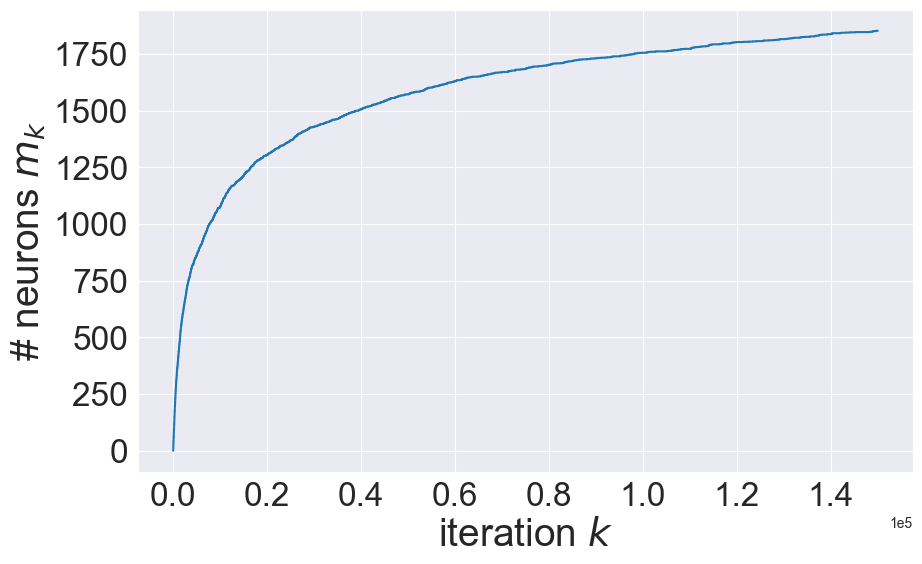

In [21]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms)), ms, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

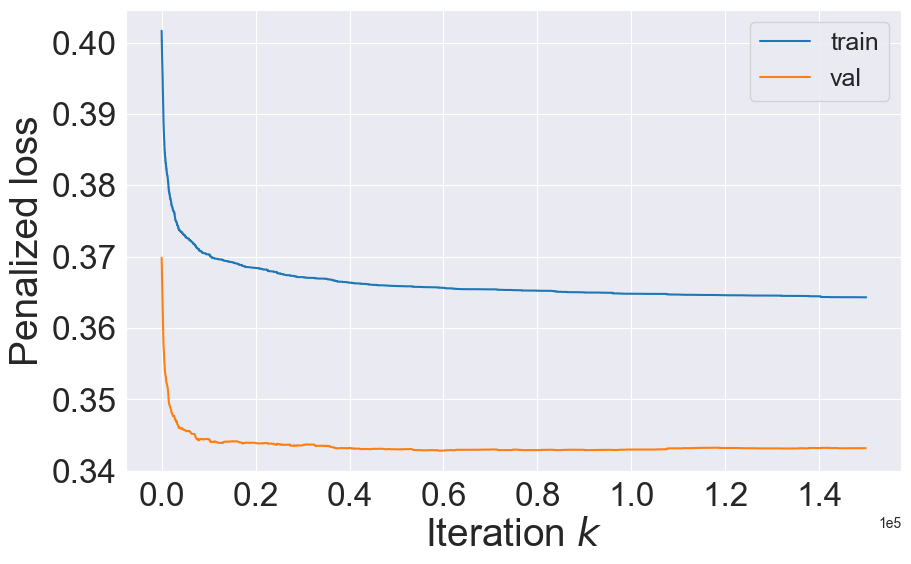

In [22]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_pop)), penalized_train_losses_pop, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses_pop)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

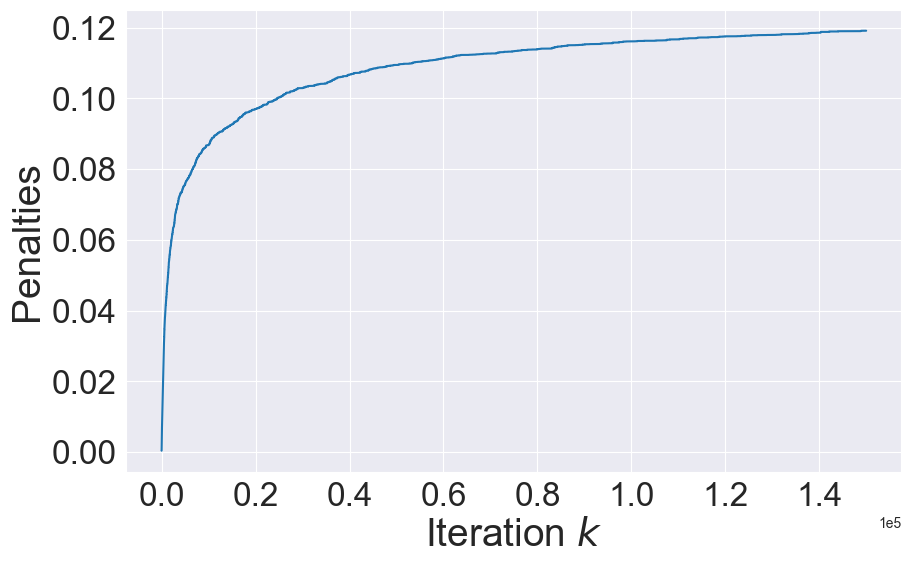

In [23]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses_pop - train_losses_pop

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

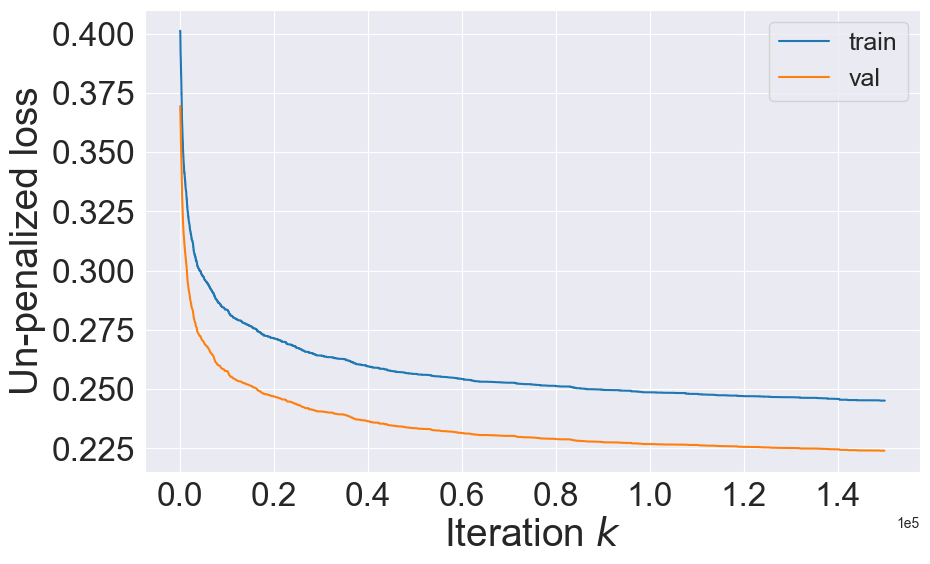

In [24]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_pop)), train_losses_pop, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses_pop)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 2. $L^2(\tau_m)$ proximal algorithm

Here we sample $m$ neurons $(b_1, \ldots, b_m)$ on the sphere and update their weights via finite-dimensional coordinate descent through the following correspondance:
\begin{align*}
    \mu_a &= \sum_{j=1}^m a_j \delta_{b_j}\\
    f(a) &= J(\mu_a) \\
    g(a) &= \lambda ||a||_1 \\
    F_m(a) &= F(\mu_a) = f(a) +  \lambda ||a||_1\\
    \nabla_j f(a) &= V[\mu_a](b_j) \\
\end{align*}
And $f$ is $L m$-Lipschitz. 

From the $L$-Lipschitzness of $V$ we know that for any $a, b, t$
\begin{align*}
    F_m(a + te_j) = F(\mu_a + t \delta_{b_j}) \leq F_m(a) + V[\mu_a](b_j) t + \frac{L}{2}t^2 + \lambda|t+a_j| - \lambda |a_j|
\end{align*}
In pratice, we do not always have access to the value of $L$, so we choose a step-size $\beta \in (0,1)$, and we have
\begin{align*}
    F_m(a + \beta te_j) \leq F_m(a) + \beta \left[V[\mu_a](b_j) t + \frac{\beta L}{2}t^2 + \lambda\left|t+\frac{a_j}{\beta} \right| \right] - \lambda |a_j|,
\end{align*}
and thus, as soon as $\beta \leq 1/L$ we can virtually replace the initial $L$ by $1$ and $a_j$ by $a_j / \beta$ since
\begin{align*}
    F_m(a + \beta te_j) \leq F_m(a) + \beta \left[V[\mu_a](b_j) t + \frac{t^2}{2} + \lambda\left|t+\frac{a_j}{\beta} \right| \right] - \lambda |a_j|.
\end{align*}
The update for the sampled coordinate $j$ thus reads
\begin{align*}
    a_j &\leftarrow a_j + \beta t_j^* \\
    t_j^* :&= \text{argmin}_{t} \left(V[\mu_a](b_j) t + \frac{t^2}{2} + \lambda\left|t+\frac{a_j}{\beta} \right| \right) = -\frac{a_j}{\beta} - \text{sign}\left(V[\mu_a](b_j) - \frac{a_j}{\beta} \right) \max \left(0, \left|V[\mu_a](b_j) - \frac{a_j}{\beta} \right| - \lambda \right),
\end{align*}
which gives 
\begin{align*}
    a_j &\leftarrow - \beta \text{sign}\left(V[\mu_a](b_j) - \frac{a_j}{\beta} \right) \max \left(0, \left|V[\mu_a](b_j) - \frac{a_j}{\beta} \right| - \lambda \right)
\end{align*}

In [25]:
n_steps = N_STEPS
m = 500
BETA = 1.0

In [26]:
def update_random_neuron(m, a, b, x, y, eps=1.0e-9):
    if a.shape[1] > 0:
        j = np.random.randint(low=0, high=m)
        b_j = b[j, :].reshape(1, -1)
        V = V_grad(a, b, x, y, b_j) - a[0, j] / BETA 
        new_a = BETA * soft_thresholding(V, tau=LAMBDA)
        a[0, j] = new_a  

        #if np.abs(new_a) > eps:
            # update weight for neuron b_j
        #    a[0, j] = new_a  
        #else:
            # remove a_j and b_j from the list
            # a = np.column_stack((a[:, :j], a[:, j+1:]))
            # b = np.row_stack((b[:j, :], b[j+1:, :]))
        #    a[0, j] = 0. 
    return a, b  

In [27]:
def train(m, n_steps, x_train, y_train, x_val, y_val, do_val=True):
    a = np.zeros(shape=(1, m))
    b = np.random.normal(size=(m, INPUT_DIM))
    b_norms = np.linalg.norm(b, axis=1, ord=2, keepdims=True)
    b = b / b_norms
    b_0 = np.copy(b)
    
    ms = [m]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []
    where_decrease_indexes = []

    for k in tqdm(range(N_STEPS)):
        a, b = update_random_neuron(m, a, b, x_train, y_train, eps=1e-9)
        ms.append(a.shape[1])
        if ms[-1] == ms[-2]-1:
            where_decrease_indexes.append(k)
        
        # compute training loss
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, b_0, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses), np.array(where_decrease_indexes)

In [28]:
a, b, b_0, ms, train_losses_coord, penalized_train_losses_coord, val_losses, penalized_val_losses, \
    where_decrease_indexes = train(m, n_steps, x_train, y_train, x_val, y_val)

  0%|                                                      | 152/150000 [00:00<03:14, 770.02it/s]

m at step 0 : 500
Train loss at step 0 : 0.40201
Validation loss at step 0 : 0.37016
m at step 100 : 500
Train loss at step 100 : 0.39312
Validation loss at step 100 : 0.36184


  0%|                                                      | 301/150000 [00:00<03:33, 701.21it/s]

m at step 200 : 500
Train loss at step 200 : 0.38396
Validation loss at step 200 : 0.35326
m at step 300 : 500
Train loss at step 300 : 0.37391
Validation loss at step 300 : 0.34357


  0%|▏                                                     | 526/150000 [00:00<03:28, 717.74it/s]

m at step 400 : 500
Train loss at step 400 : 0.36848
Validation loss at step 400 : 0.33839
m at step 500 : 500
Train loss at step 500 : 0.35997
Validation loss at step 500 : 0.32980


  1%|▎                                                     | 752/150000 [00:01<03:31, 706.38it/s]

m at step 600 : 500
Train loss at step 600 : 0.35640
Validation loss at step 600 : 0.32626
m at step 700 : 500
Train loss at step 700 : 0.35215
Validation loss at step 700 : 0.32212


  1%|▎                                                     | 905/150000 [00:01<03:22, 734.82it/s]

m at step 800 : 500
Train loss at step 800 : 0.34883
Validation loss at step 800 : 0.31976
m at step 900 : 500
Train loss at step 900 : 0.34555
Validation loss at step 900 : 0.31716


  1%|▍                                                    | 1148/150000 [00:01<03:09, 786.96it/s]

m at step 1,000 : 500
Train loss at step 1,000 : 0.34399
Validation loss at step 1,000 : 0.31569
m at step 1,100 : 500
Train loss at step 1,100 : 0.34075
Validation loss at step 1,100 : 0.31274


  1%|▍                                                    | 1313/150000 [00:01<03:06, 797.36it/s]

m at step 1,200 : 500
Train loss at step 1,200 : 0.33722
Validation loss at step 1,200 : 0.30987
m at step 1,300 : 500
Train loss at step 1,300 : 0.33499
Validation loss at step 1,300 : 0.30819


  1%|▌                                                    | 1560/150000 [00:02<03:02, 814.43it/s]

m at step 1,400 : 500
Train loss at step 1,400 : 0.33353
Validation loss at step 1,400 : 0.30687
m at step 1,500 : 500
Train loss at step 1,500 : 0.33132
Validation loss at step 1,500 : 0.30470


  1%|▌                                                    | 1728/150000 [00:02<03:01, 816.24it/s]

m at step 1,600 : 500
Train loss at step 1,600 : 0.32958
Validation loss at step 1,600 : 0.30347
m at step 1,700 : 500
Train loss at step 1,700 : 0.32706
Validation loss at step 1,700 : 0.30069


  1%|▋                                                    | 1895/150000 [00:02<03:07, 790.10it/s]

m at step 1,800 : 500
Train loss at step 1,800 : 0.32588
Validation loss at step 1,800 : 0.29959
m at step 1,900 : 500
Train loss at step 1,900 : 0.32495
Validation loss at step 1,900 : 0.29904


  1%|▊                                                    | 2147/150000 [00:02<03:04, 801.82it/s]

m at step 2,000 : 500
Train loss at step 2,000 : 0.32351
Validation loss at step 2,000 : 0.29781
m at step 2,100 : 500
Train loss at step 2,100 : 0.32281
Validation loss at step 2,100 : 0.29727


  2%|▊                                                    | 2310/150000 [00:03<03:06, 792.13it/s]

m at step 2,200 : 500
Train loss at step 2,200 : 0.32202
Validation loss at step 2,200 : 0.29679
m at step 2,300 : 500
Train loss at step 2,300 : 0.32100
Validation loss at step 2,300 : 0.29601


  2%|▉                                                    | 2563/150000 [00:03<02:59, 820.28it/s]

m at step 2,400 : 500
Train loss at step 2,400 : 0.31897
Validation loss at step 2,400 : 0.29403
m at step 2,500 : 500
Train loss at step 2,500 : 0.31822
Validation loss at step 2,500 : 0.29335


  2%|▉                                                    | 2733/150000 [00:03<02:59, 820.58it/s]

m at step 2,600 : 500
Train loss at step 2,600 : 0.31820
Validation loss at step 2,600 : 0.29326
m at step 2,700 : 500
Train loss at step 2,700 : 0.31711
Validation loss at step 2,700 : 0.29206


  2%|█                                                    | 2900/150000 [00:03<03:01, 808.98it/s]

m at step 2,800 : 500
Train loss at step 2,800 : 0.31663
Validation loss at step 2,800 : 0.29166
m at step 2,900 : 500
Train loss at step 2,900 : 0.31595
Validation loss at step 2,900 : 0.29094


  2%|█                                                    | 3152/150000 [00:04<02:57, 827.21it/s]

m at step 3,000 : 500
Train loss at step 3,000 : 0.31520
Validation loss at step 3,000 : 0.29019
m at step 3,100 : 500
Train loss at step 3,100 : 0.31330
Validation loss at step 3,100 : 0.28799


  2%|█▏                                                   | 3322/150000 [00:04<02:58, 820.82it/s]

m at step 3,200 : 500
Train loss at step 3,200 : 0.31248
Validation loss at step 3,200 : 0.28707
m at step 3,300 : 500
Train loss at step 3,300 : 0.31220
Validation loss at step 3,300 : 0.28706


  2%|█▏                                                   | 3491/150000 [00:04<03:00, 811.62it/s]

m at step 3,400 : 500
Train loss at step 3,400 : 0.31158
Validation loss at step 3,400 : 0.28641
m at step 3,500 : 500
Train loss at step 3,500 : 0.31080
Validation loss at step 3,500 : 0.28556


  2%|█▎                                                   | 3748/150000 [00:04<02:56, 828.67it/s]

m at step 3,600 : 500
Train loss at step 3,600 : 0.31024
Validation loss at step 3,600 : 0.28514
m at step 3,700 : 500
Train loss at step 3,700 : 0.30956
Validation loss at step 3,700 : 0.28448


  3%|█▍                                                   | 3908/150000 [00:05<03:42, 657.63it/s]

m at step 3,800 : 500
Train loss at step 3,800 : 0.30864
Validation loss at step 3,800 : 0.28321
m at step 3,900 : 500
Train loss at step 3,900 : 0.30788
Validation loss at step 3,900 : 0.28241


  3%|█▍                                                   | 4124/150000 [00:05<03:35, 675.72it/s]

m at step 4,000 : 500
Train loss at step 4,000 : 0.30761
Validation loss at step 4,000 : 0.28218
m at step 4,100 : 500
Train loss at step 4,100 : 0.30678
Validation loss at step 4,100 : 0.28168


  3%|█▌                                                   | 4352/150000 [00:05<03:19, 731.65it/s]

m at step 4,200 : 500
Train loss at step 4,200 : 0.30620
Validation loss at step 4,200 : 0.28117
m at step 4,300 : 500
Train loss at step 4,300 : 0.30640
Validation loss at step 4,300 : 0.28155


  3%|█▌                                                   | 4508/150000 [00:05<03:12, 755.10it/s]

m at step 4,400 : 500
Train loss at step 4,400 : 0.30559
Validation loss at step 4,400 : 0.28098
m at step 4,500 : 500
Train loss at step 4,500 : 0.30536
Validation loss at step 4,500 : 0.28094


  3%|█▋                                                   | 4755/150000 [00:06<03:01, 798.88it/s]

m at step 4,600 : 500
Train loss at step 4,600 : 0.30464
Validation loss at step 4,600 : 0.28045
m at step 4,700 : 500
Train loss at step 4,700 : 0.30350
Validation loss at step 4,700 : 0.27953


  3%|█▋                                                   | 4922/150000 [00:06<02:59, 808.91it/s]

m at step 4,800 : 500
Train loss at step 4,800 : 0.30357
Validation loss at step 4,800 : 0.27966
m at step 4,900 : 500
Train loss at step 4,900 : 0.30313
Validation loss at step 4,900 : 0.27948


  3%|█▊                                                   | 5083/150000 [00:06<03:09, 763.09it/s]

m at step 5,000 : 500
Train loss at step 5,000 : 0.30276
Validation loss at step 5,000 : 0.27909
m at step 5,100 : 500
Train loss at step 5,100 : 0.30237
Validation loss at step 5,100 : 0.27891


  4%|█▉                                                   | 5317/150000 [00:07<03:19, 724.71it/s]

m at step 5,200 : 500
Train loss at step 5,200 : 0.30220
Validation loss at step 5,200 : 0.27884
m at step 5,300 : 500
Train loss at step 5,300 : 0.30188
Validation loss at step 5,300 : 0.27853


  4%|█▉                                                   | 5561/150000 [00:07<03:03, 786.73it/s]

m at step 5,400 : 500
Train loss at step 5,400 : 0.30193
Validation loss at step 5,400 : 0.27870
m at step 5,500 : 500
Train loss at step 5,500 : 0.30165
Validation loss at step 5,500 : 0.27841


  4%|██                                                   | 5725/150000 [00:07<03:00, 799.25it/s]

m at step 5,600 : 500
Train loss at step 5,600 : 0.30144
Validation loss at step 5,600 : 0.27815
m at step 5,700 : 500
Train loss at step 5,700 : 0.30150
Validation loss at step 5,700 : 0.27825


  4%|██                                                   | 5893/150000 [00:07<02:58, 806.76it/s]

m at step 5,800 : 500
Train loss at step 5,800 : 0.30085
Validation loss at step 5,800 : 0.27766
m at step 5,900 : 500
Train loss at step 5,900 : 0.30066
Validation loss at step 5,900 : 0.27744


  4%|██▏                                                  | 6141/150000 [00:08<03:00, 797.37it/s]

m at step 6,000 : 500
Train loss at step 6,000 : 0.30000
Validation loss at step 6,000 : 0.27674
m at step 6,100 : 500
Train loss at step 6,100 : 0.29958
Validation loss at step 6,100 : 0.27643


  4%|██▏                                                  | 6308/150000 [00:08<02:59, 802.56it/s]

m at step 6,200 : 500
Train loss at step 6,200 : 0.29865
Validation loss at step 6,200 : 0.27567
m at step 6,300 : 500
Train loss at step 6,300 : 0.29819
Validation loss at step 6,300 : 0.27533


  4%|██▎                                                  | 6560/150000 [00:08<02:54, 823.14it/s]

m at step 6,400 : 500
Train loss at step 6,400 : 0.29780
Validation loss at step 6,400 : 0.27485
m at step 6,500 : 500
Train loss at step 6,500 : 0.29746
Validation loss at step 6,500 : 0.27455


  4%|██▍                                                  | 6729/150000 [00:08<02:56, 813.15it/s]

m at step 6,600 : 500
Train loss at step 6,600 : 0.29732
Validation loss at step 6,600 : 0.27446
m at step 6,700 : 500
Train loss at step 6,700 : 0.29637
Validation loss at step 6,700 : 0.27333


  5%|██▍                                                  | 6891/150000 [00:08<03:01, 790.01it/s]

m at step 6,800 : 500
Train loss at step 6,800 : 0.29646
Validation loss at step 6,800 : 0.27340
m at step 6,900 : 500
Train loss at step 6,900 : 0.29603
Validation loss at step 6,900 : 0.27300


  5%|██▍                                                  | 7049/150000 [00:09<03:10, 748.91it/s]

m at step 7,000 : 500
Train loss at step 7,000 : 0.29578
Validation loss at step 7,000 : 0.27271
m at step 7,100 : 500
Train loss at step 7,100 : 0.29571
Validation loss at step 7,100 : 0.27265


  5%|██▌                                                  | 7368/150000 [00:09<03:05, 768.54it/s]

m at step 7,200 : 500
Train loss at step 7,200 : 0.29507
Validation loss at step 7,200 : 0.27201
m at step 7,300 : 500
Train loss at step 7,300 : 0.29457
Validation loss at step 7,300 : 0.27131


  5%|██▋                                                  | 7532/150000 [00:09<03:00, 790.51it/s]

m at step 7,400 : 500
Train loss at step 7,400 : 0.29403
Validation loss at step 7,400 : 0.27071
m at step 7,500 : 500
Train loss at step 7,500 : 0.29311
Validation loss at step 7,500 : 0.26975


  5%|██▋                                                  | 7699/150000 [00:10<02:58, 799.02it/s]

m at step 7,600 : 500
Train loss at step 7,600 : 0.29314
Validation loss at step 7,600 : 0.26976
m at step 7,700 : 500
Train loss at step 7,700 : 0.29319
Validation loss at step 7,700 : 0.26980


  5%|██▊                                                  | 7950/150000 [00:10<02:52, 823.61it/s]

m at step 7,800 : 500
Train loss at step 7,800 : 0.29307
Validation loss at step 7,800 : 0.26967
m at step 7,900 : 500
Train loss at step 7,900 : 0.29311
Validation loss at step 7,900 : 0.26973


  5%|██▊                                                  | 8118/150000 [00:10<02:53, 816.48it/s]

m at step 8,000 : 500
Train loss at step 8,000 : 0.29293
Validation loss at step 8,000 : 0.26963
m at step 8,100 : 500
Train loss at step 8,100 : 0.29272
Validation loss at step 8,100 : 0.26935


  6%|██▉                                                  | 8280/150000 [00:10<03:04, 766.83it/s]

m at step 8,200 : 500
Train loss at step 8,200 : 0.29284
Validation loss at step 8,200 : 0.26949
m at step 8,300 : 500
Train loss at step 8,300 : 0.29287
Validation loss at step 8,300 : 0.26952


  6%|███                                                  | 8529/150000 [00:11<02:55, 805.13it/s]

m at step 8,400 : 500
Train loss at step 8,400 : 0.29235
Validation loss at step 8,400 : 0.26891
m at step 8,500 : 500
Train loss at step 8,500 : 0.29191
Validation loss at step 8,500 : 0.26834


  6%|███                                                  | 8696/150000 [00:11<02:57, 796.82it/s]

m at step 8,600 : 500
Train loss at step 8,600 : 0.29177
Validation loss at step 8,600 : 0.26838
m at step 8,700 : 500
Train loss at step 8,700 : 0.29163
Validation loss at step 8,700 : 0.26818


  6%|███▏                                                 | 8948/150000 [00:11<02:51, 822.90it/s]

m at step 8,800 : 500
Train loss at step 8,800 : 0.29128
Validation loss at step 8,800 : 0.26774
m at step 8,900 : 500
Train loss at step 8,900 : 0.29080
Validation loss at step 8,900 : 0.26708


  6%|███▏                                                 | 9117/150000 [00:11<02:52, 816.80it/s]

m at step 9,000 : 500
Train loss at step 9,000 : 0.29092
Validation loss at step 9,000 : 0.26716
m at step 9,100 : 500
Train loss at step 9,100 : 0.29060
Validation loss at step 9,100 : 0.26672


  6%|███▎                                                 | 9371/150000 [00:12<02:50, 826.60it/s]

m at step 9,200 : 500
Train loss at step 9,200 : 0.29052
Validation loss at step 9,200 : 0.26660
m at step 9,300 : 500
Train loss at step 9,300 : 0.29028
Validation loss at step 9,300 : 0.26631


  6%|███▎                                                 | 9539/150000 [00:12<02:51, 820.78it/s]

m at step 9,400 : 500
Train loss at step 9,400 : 0.28981
Validation loss at step 9,400 : 0.26572
m at step 9,500 : 500
Train loss at step 9,500 : 0.28957
Validation loss at step 9,500 : 0.26547


  6%|███▍                                                 | 9706/150000 [00:12<02:53, 810.95it/s]

m at step 9,600 : 500
Train loss at step 9,600 : 0.28934
Validation loss at step 9,600 : 0.26517
m at step 9,700 : 500
Train loss at step 9,700 : 0.28882
Validation loss at step 9,700 : 0.26456


  7%|███▌                                                 | 9957/150000 [00:12<02:50, 820.23it/s]

m at step 9,800 : 500
Train loss at step 9,800 : 0.28884
Validation loss at step 9,800 : 0.26457
m at step 9,900 : 500
Train loss at step 9,900 : 0.28871
Validation loss at step 9,900 : 0.26442


  7%|███▌                                                | 10126/150000 [00:13<02:51, 816.23it/s]

m at step 10,000 : 500
Train loss at step 10,000 : 0.28845
Validation loss at step 10,000 : 0.26413
m at step 10,100 : 500
Train loss at step 10,100 : 0.28797
Validation loss at step 10,100 : 0.26358


  7%|███▌                                                | 10295/150000 [00:13<02:51, 814.10it/s]

m at step 10,200 : 500
Train loss at step 10,200 : 0.28768
Validation loss at step 10,200 : 0.26318
m at step 10,300 : 500
Train loss at step 10,300 : 0.28777
Validation loss at step 10,300 : 0.26332


  7%|███▋                                                | 10543/150000 [00:13<02:50, 816.90it/s]

m at step 10,400 : 500
Train loss at step 10,400 : 0.28764
Validation loss at step 10,400 : 0.26314
m at step 10,500 : 500
Train loss at step 10,500 : 0.28739
Validation loss at step 10,500 : 0.26293


  7%|███▋                                                | 10711/150000 [00:13<02:51, 812.73it/s]

m at step 10,600 : 500
Train loss at step 10,600 : 0.28709
Validation loss at step 10,600 : 0.26271
m at step 10,700 : 500
Train loss at step 10,700 : 0.28697
Validation loss at step 10,700 : 0.26263


  7%|███▊                                                | 10966/150000 [00:14<02:47, 831.37it/s]

m at step 10,800 : 500
Train loss at step 10,800 : 0.28669
Validation loss at step 10,800 : 0.26229
m at step 10,900 : 500
Train loss at step 10,900 : 0.28659
Validation loss at step 10,900 : 0.26221


  7%|███▊                                                | 11135/150000 [00:14<02:49, 820.49it/s]

m at step 11,000 : 500
Train loss at step 11,000 : 0.28618
Validation loss at step 11,000 : 0.26173
m at step 11,100 : 500
Train loss at step 11,100 : 0.28628
Validation loss at step 11,100 : 0.26183


  8%|███▉                                                | 11302/150000 [00:14<02:52, 805.61it/s]

m at step 11,200 : 500
Train loss at step 11,200 : 0.28632
Validation loss at step 11,200 : 0.26187
m at step 11,300 : 500
Train loss at step 11,300 : 0.28591
Validation loss at step 11,300 : 0.26149


  8%|████                                                | 11546/150000 [00:14<02:57, 780.55it/s]

m at step 11,400 : 500
Train loss at step 11,400 : 0.28598
Validation loss at step 11,400 : 0.26156
m at step 11,500 : 500
Train loss at step 11,500 : 0.28608
Validation loss at step 11,500 : 0.26167


  8%|████                                                | 11711/150000 [00:15<02:53, 795.69it/s]

m at step 11,600 : 500
Train loss at step 11,600 : 0.28602
Validation loss at step 11,600 : 0.26160
m at step 11,700 : 500
Train loss at step 11,700 : 0.28605
Validation loss at step 11,700 : 0.26162


  8%|████▏                                               | 11958/150000 [00:15<02:50, 810.28it/s]

m at step 11,800 : 500
Train loss at step 11,800 : 0.28619
Validation loss at step 11,800 : 0.26173
m at step 11,900 : 500
Train loss at step 11,900 : 0.28579
Validation loss at step 11,900 : 0.26128


  8%|████▏                                               | 12126/150000 [00:15<02:52, 801.58it/s]

m at step 12,000 : 500
Train loss at step 12,000 : 0.28544
Validation loss at step 12,000 : 0.26102
m at step 12,100 : 500
Train loss at step 12,100 : 0.28555
Validation loss at step 12,100 : 0.26114


  8%|████▎                                               | 12291/150000 [00:15<02:53, 794.57it/s]

m at step 12,200 : 500
Train loss at step 12,200 : 0.28552
Validation loss at step 12,200 : 0.26112
m at step 12,300 : 500
Train loss at step 12,300 : 0.28554
Validation loss at step 12,300 : 0.26112


  8%|████▎                                               | 12545/150000 [00:16<02:47, 822.04it/s]

m at step 12,400 : 500
Train loss at step 12,400 : 0.28509
Validation loss at step 12,400 : 0.26054
m at step 12,500 : 500
Train loss at step 12,500 : 0.28476
Validation loss at step 12,500 : 0.26016


  8%|████▍                                               | 12713/150000 [00:16<02:48, 814.18it/s]

m at step 12,600 : 500
Train loss at step 12,600 : 0.28444
Validation loss at step 12,600 : 0.25992
m at step 12,700 : 500
Train loss at step 12,700 : 0.28398
Validation loss at step 12,700 : 0.25941


  9%|████▍                                               | 12879/150000 [00:16<02:48, 811.64it/s]

m at step 12,800 : 500
Train loss at step 12,800 : 0.28406
Validation loss at step 12,800 : 0.25949
m at step 12,900 : 500
Train loss at step 12,900 : 0.28403
Validation loss at step 12,900 : 0.25942


  9%|████▌                                               | 13122/150000 [00:16<03:13, 707.19it/s]

m at step 13,000 : 500
Train loss at step 13,000 : 0.28417
Validation loss at step 13,000 : 0.25951
m at step 13,100 : 500
Train loss at step 13,100 : 0.28418
Validation loss at step 13,100 : 0.25951


  9%|████▋                                               | 13368/150000 [00:17<02:54, 784.91it/s]

m at step 13,200 : 500
Train loss at step 13,200 : 0.28399
Validation loss at step 13,200 : 0.25934
m at step 13,300 : 500
Train loss at step 13,300 : 0.28369
Validation loss at step 13,300 : 0.25902


  9%|████▋                                               | 13531/150000 [00:17<02:52, 789.83it/s]

m at step 13,400 : 500
Train loss at step 13,400 : 0.28373
Validation loss at step 13,400 : 0.25911
m at step 13,500 : 500
Train loss at step 13,500 : 0.28374
Validation loss at step 13,500 : 0.25915


  9%|████▋                                               | 13696/150000 [00:17<02:52, 789.47it/s]

m at step 13,600 : 500
Train loss at step 13,600 : 0.28364
Validation loss at step 13,600 : 0.25907
m at step 13,700 : 500
Train loss at step 13,700 : 0.28352
Validation loss at step 13,700 : 0.25895


  9%|████▊                                               | 13944/150000 [00:17<02:47, 814.58it/s]

m at step 13,800 : 500
Train loss at step 13,800 : 0.28313
Validation loss at step 13,800 : 0.25835
m at step 13,900 : 500
Train loss at step 13,900 : 0.28308
Validation loss at step 13,900 : 0.25828


  9%|████▉                                               | 14112/150000 [00:18<02:47, 809.12it/s]

m at step 14,000 : 500
Train loss at step 14,000 : 0.28303
Validation loss at step 14,000 : 0.25825
m at step 14,100 : 500
Train loss at step 14,100 : 0.28309
Validation loss at step 14,100 : 0.25829


 10%|████▉                                               | 14367/150000 [00:18<02:44, 826.24it/s]

m at step 14,200 : 500
Train loss at step 14,200 : 0.28309
Validation loss at step 14,200 : 0.25834
m at step 14,300 : 500
Train loss at step 14,300 : 0.28295
Validation loss at step 14,300 : 0.25817


 10%|█████                                               | 14536/150000 [00:18<02:46, 815.67it/s]

m at step 14,400 : 500
Train loss at step 14,400 : 0.28287
Validation loss at step 14,400 : 0.25804
m at step 14,500 : 500
Train loss at step 14,500 : 0.28274
Validation loss at step 14,500 : 0.25795


 10%|█████                                               | 14698/150000 [00:18<02:54, 774.02it/s]

m at step 14,600 : 500
Train loss at step 14,600 : 0.28256
Validation loss at step 14,600 : 0.25765
m at step 14,700 : 500
Train loss at step 14,700 : 0.28250
Validation loss at step 14,700 : 0.25762


 10%|█████▏                                              | 14941/150000 [00:19<02:50, 791.03it/s]

m at step 14,800 : 500
Train loss at step 14,800 : 0.28248
Validation loss at step 14,800 : 0.25761
m at step 14,900 : 500
Train loss at step 14,900 : 0.28262
Validation loss at step 14,900 : 0.25774


 10%|█████▏                                              | 15103/150000 [00:19<02:51, 786.34it/s]

m at step 15,000 : 500
Train loss at step 15,000 : 0.28236
Validation loss at step 15,000 : 0.25745
m at step 15,100 : 500
Train loss at step 15,100 : 0.28228
Validation loss at step 15,100 : 0.25735


 10%|█████▎                                              | 15261/150000 [00:19<02:53, 774.54it/s]

m at step 15,200 : 500
Train loss at step 15,200 : 0.28176
Validation loss at step 15,200 : 0.25693
m at step 15,300 : 500
Train loss at step 15,300 : 0.28189
Validation loss at step 15,300 : 0.25704


 10%|█████▎                                              | 15470/150000 [00:20<04:08, 542.04it/s]

m at step 15,400 : 500
Train loss at step 15,400 : 0.28144
Validation loss at step 15,400 : 0.25651
m at step 15,500 : 500
Train loss at step 15,500 : 0.28159
Validation loss at step 15,500 : 0.25662


 10%|█████▍                                              | 15715/150000 [00:20<03:08, 710.57it/s]

m at step 15,600 : 500
Train loss at step 15,600 : 0.28149
Validation loss at step 15,600 : 0.25645
m at step 15,700 : 500
Train loss at step 15,700 : 0.28132
Validation loss at step 15,700 : 0.25621


 11%|█████▌                                              | 15956/150000 [00:20<02:54, 768.94it/s]

m at step 15,800 : 500
Train loss at step 15,800 : 0.28116
Validation loss at step 15,800 : 0.25594
m at step 15,900 : 500
Train loss at step 15,900 : 0.28111
Validation loss at step 15,900 : 0.25591


 11%|█████▌                                              | 16117/150000 [00:20<02:54, 767.83it/s]

m at step 16,000 : 500
Train loss at step 16,000 : 0.28125
Validation loss at step 16,000 : 0.25603
m at step 16,100 : 500
Train loss at step 16,100 : 0.28135
Validation loss at step 16,100 : 0.25613


 11%|█████▋                                              | 16366/150000 [00:21<02:45, 806.81it/s]

m at step 16,200 : 500
Train loss at step 16,200 : 0.28127
Validation loss at step 16,200 : 0.25593
m at step 16,300 : 500
Train loss at step 16,300 : 0.28115
Validation loss at step 16,300 : 0.25585


 11%|█████▋                                              | 16529/150000 [00:21<02:47, 796.75it/s]

m at step 16,400 : 500
Train loss at step 16,400 : 0.28092
Validation loss at step 16,400 : 0.25553
m at step 16,500 : 500
Train loss at step 16,500 : 0.28088
Validation loss at step 16,500 : 0.25546


 11%|█████▊                                              | 16694/150000 [00:21<02:47, 796.59it/s]

m at step 16,600 : 500
Train loss at step 16,600 : 0.28095
Validation loss at step 16,600 : 0.25550
m at step 16,700 : 500
Train loss at step 16,700 : 0.28079
Validation loss at step 16,700 : 0.25540


 11%|█████▊                                              | 16945/150000 [00:21<02:42, 818.73it/s]

m at step 16,800 : 500
Train loss at step 16,800 : 0.28049
Validation loss at step 16,800 : 0.25505
m at step 16,900 : 500
Train loss at step 16,900 : 0.28043
Validation loss at step 16,900 : 0.25489


 11%|█████▉                                              | 17113/150000 [00:22<02:45, 805.15it/s]

m at step 17,000 : 500
Train loss at step 17,000 : 0.28063
Validation loss at step 17,000 : 0.25512
m at step 17,100 : 500
Train loss at step 17,100 : 0.28055
Validation loss at step 17,100 : 0.25504


 12%|██████                                              | 17363/150000 [00:22<02:42, 816.22it/s]

m at step 17,200 : 500
Train loss at step 17,200 : 0.28022
Validation loss at step 17,200 : 0.25475
m at step 17,300 : 500
Train loss at step 17,300 : 0.28005
Validation loss at step 17,300 : 0.25457


 12%|██████                                              | 17531/150000 [00:22<02:43, 812.42it/s]

m at step 17,400 : 500
Train loss at step 17,400 : 0.28003
Validation loss at step 17,400 : 0.25461
m at step 17,500 : 500
Train loss at step 17,500 : 0.28008
Validation loss at step 17,500 : 0.25468


 12%|██████▏                                             | 17695/150000 [00:22<02:46, 796.32it/s]

m at step 17,600 : 500
Train loss at step 17,600 : 0.28006
Validation loss at step 17,600 : 0.25464
m at step 17,700 : 500
Train loss at step 17,700 : 0.28007
Validation loss at step 17,700 : 0.25466


 12%|██████▏                                             | 17946/150000 [00:23<02:44, 804.92it/s]

m at step 17,800 : 500
Train loss at step 17,800 : 0.27959
Validation loss at step 17,800 : 0.25408
m at step 17,900 : 500
Train loss at step 17,900 : 0.27950
Validation loss at step 17,900 : 0.25395


 12%|██████▎                                             | 18113/150000 [00:23<02:43, 804.50it/s]

m at step 18,000 : 500
Train loss at step 18,000 : 0.27930
Validation loss at step 18,000 : 0.25374
m at step 18,100 : 500
Train loss at step 18,100 : 0.27906
Validation loss at step 18,100 : 0.25357


 12%|██████▎                                             | 18363/150000 [00:23<02:41, 815.90it/s]

m at step 18,200 : 500
Train loss at step 18,200 : 0.27907
Validation loss at step 18,200 : 0.25362
m at step 18,300 : 500
Train loss at step 18,300 : 0.27900
Validation loss at step 18,300 : 0.25359


 12%|██████▍                                             | 18531/150000 [00:23<02:42, 809.19it/s]

m at step 18,400 : 500
Train loss at step 18,400 : 0.27899
Validation loss at step 18,400 : 0.25361
m at step 18,500 : 500
Train loss at step 18,500 : 0.27899
Validation loss at step 18,500 : 0.25365


 12%|██████▍                                             | 18699/150000 [00:24<02:43, 805.42it/s]

m at step 18,600 : 500
Train loss at step 18,600 : 0.27910
Validation loss at step 18,600 : 0.25373
m at step 18,700 : 500
Train loss at step 18,700 : 0.27916
Validation loss at step 18,700 : 0.25381


 13%|██████▌                                             | 18951/150000 [00:24<02:38, 827.34it/s]

m at step 18,800 : 500
Train loss at step 18,800 : 0.27927
Validation loss at step 18,800 : 0.25391
m at step 18,900 : 500
Train loss at step 18,900 : 0.27862
Validation loss at step 18,900 : 0.25309


 13%|██████▋                                             | 19119/150000 [00:24<02:41, 811.11it/s]

m at step 19,000 : 500
Train loss at step 19,000 : 0.27852
Validation loss at step 19,000 : 0.25298
m at step 19,100 : 500
Train loss at step 19,100 : 0.27810
Validation loss at step 19,100 : 0.25243


 13%|██████▋                                             | 19286/150000 [00:24<02:42, 805.62it/s]

m at step 19,200 : 500
Train loss at step 19,200 : 0.27809
Validation loss at step 19,200 : 0.25236
m at step 19,300 : 500
Train loss at step 19,300 : 0.27803
Validation loss at step 19,300 : 0.25235


 13%|██████▊                                             | 19542/150000 [00:25<02:39, 816.30it/s]

m at step 19,400 : 500
Train loss at step 19,400 : 0.27811
Validation loss at step 19,400 : 0.25241
m at step 19,500 : 500
Train loss at step 19,500 : 0.27815
Validation loss at step 19,500 : 0.25244


 13%|██████▊                                             | 19704/150000 [00:25<02:45, 786.22it/s]

m at step 19,600 : 500
Train loss at step 19,600 : 0.27814
Validation loss at step 19,600 : 0.25241
m at step 19,700 : 500
Train loss at step 19,700 : 0.27817
Validation loss at step 19,700 : 0.25246


 13%|██████▉                                             | 19945/150000 [00:25<02:46, 778.97it/s]

m at step 19,800 : 500
Train loss at step 19,800 : 0.27815
Validation loss at step 19,800 : 0.25234
m at step 19,900 : 500
Train loss at step 19,900 : 0.27827
Validation loss at step 19,900 : 0.25247


 13%|██████▉                                             | 20110/150000 [00:25<02:44, 790.16it/s]

m at step 20,000 : 500
Train loss at step 20,000 : 0.27816
Validation loss at step 20,000 : 0.25244
m at step 20,100 : 500
Train loss at step 20,100 : 0.27808
Validation loss at step 20,100 : 0.25230


 14%|███████                                             | 20362/150000 [00:26<02:38, 819.26it/s]

m at step 20,200 : 500
Train loss at step 20,200 : 0.27790
Validation loss at step 20,200 : 0.25208
m at step 20,300 : 500
Train loss at step 20,300 : 0.27755
Validation loss at step 20,300 : 0.25169


 14%|███████                                             | 20529/150000 [00:26<02:40, 805.84it/s]

m at step 20,400 : 500
Train loss at step 20,400 : 0.27730
Validation loss at step 20,400 : 0.25132
m at step 20,500 : 500
Train loss at step 20,500 : 0.27724
Validation loss at step 20,500 : 0.25130


 14%|███████▏                                            | 20695/150000 [00:26<02:40, 803.36it/s]

m at step 20,600 : 500
Train loss at step 20,600 : 0.27716
Validation loss at step 20,600 : 0.25132
m at step 20,700 : 500
Train loss at step 20,700 : 0.27708
Validation loss at step 20,700 : 0.25125


 14%|███████▎                                            | 20938/150000 [00:26<02:43, 791.79it/s]

m at step 20,800 : 500
Train loss at step 20,800 : 0.27700
Validation loss at step 20,800 : 0.25109
m at step 20,900 : 500
Train loss at step 20,900 : 0.27691
Validation loss at step 20,900 : 0.25106


 14%|███████▎                                            | 21103/150000 [00:27<02:44, 783.34it/s]

m at step 21,000 : 500
Train loss at step 21,000 : 0.27699
Validation loss at step 21,000 : 0.25114
m at step 21,100 : 500
Train loss at step 21,100 : 0.27696
Validation loss at step 21,100 : 0.25117


 14%|███████▍                                            | 21351/150000 [00:27<02:38, 812.87it/s]

m at step 21,200 : 500
Train loss at step 21,200 : 0.27678
Validation loss at step 21,200 : 0.25095
m at step 21,300 : 500
Train loss at step 21,300 : 0.27681
Validation loss at step 21,300 : 0.25097


 14%|███████▍                                            | 21518/150000 [00:27<02:40, 799.37it/s]

m at step 21,400 : 500
Train loss at step 21,400 : 0.27664
Validation loss at step 21,400 : 0.25078
m at step 21,500 : 500
Train loss at step 21,500 : 0.27661
Validation loss at step 21,500 : 0.25074


 15%|███████▌                                            | 21770/150000 [00:27<02:36, 816.81it/s]

m at step 21,600 : 500
Train loss at step 21,600 : 0.27641
Validation loss at step 21,600 : 0.25053
m at step 21,700 : 500
Train loss at step 21,700 : 0.27621
Validation loss at step 21,700 : 0.25027


 15%|███████▌                                            | 21938/150000 [00:28<02:36, 820.81it/s]

m at step 21,800 : 500
Train loss at step 21,800 : 0.27621
Validation loss at step 21,800 : 0.25027
m at step 21,900 : 500
Train loss at step 21,900 : 0.27631
Validation loss at step 21,900 : 0.25037


 15%|███████▋                                            | 22107/150000 [00:28<02:37, 813.42it/s]

m at step 22,000 : 500
Train loss at step 22,000 : 0.27628
Validation loss at step 22,000 : 0.25040
m at step 22,100 : 500
Train loss at step 22,100 : 0.27627
Validation loss at step 22,100 : 0.25041


 15%|███████▊                                            | 22358/150000 [00:28<02:34, 823.52it/s]

m at step 22,200 : 500
Train loss at step 22,200 : 0.27631
Validation loss at step 22,200 : 0.25039
m at step 22,300 : 500
Train loss at step 22,300 : 0.27619
Validation loss at step 22,300 : 0.25027


 15%|███████▊                                            | 22524/150000 [00:28<02:37, 807.92it/s]

m at step 22,400 : 500
Train loss at step 22,400 : 0.27622
Validation loss at step 22,400 : 0.25027
m at step 22,500 : 500
Train loss at step 22,500 : 0.27624
Validation loss at step 22,500 : 0.25027


 15%|███████▊                                            | 22692/150000 [00:29<02:38, 804.55it/s]

m at step 22,600 : 500
Train loss at step 22,600 : 0.27630
Validation loss at step 22,600 : 0.25038
m at step 22,700 : 500
Train loss at step 22,700 : 0.27637
Validation loss at step 22,700 : 0.25046


 15%|███████▉                                            | 22937/150000 [00:29<02:37, 805.36it/s]

m at step 22,800 : 500
Train loss at step 22,800 : 0.27635
Validation loss at step 22,800 : 0.25041
m at step 22,900 : 500
Train loss at step 22,900 : 0.27639
Validation loss at step 22,900 : 0.25045


 15%|████████                                            | 23101/150000 [00:29<02:39, 794.19it/s]

m at step 23,000 : 500
Train loss at step 23,000 : 0.27637
Validation loss at step 23,000 : 0.25041
m at step 23,100 : 500
Train loss at step 23,100 : 0.27644
Validation loss at step 23,100 : 0.25048


 16%|████████                                            | 23352/150000 [00:29<02:34, 817.20it/s]

m at step 23,200 : 500
Train loss at step 23,200 : 0.27615
Validation loss at step 23,200 : 0.25011
m at step 23,300 : 500
Train loss at step 23,300 : 0.27610
Validation loss at step 23,300 : 0.25013


 16%|████████▏                                           | 23519/150000 [00:30<02:38, 796.52it/s]

m at step 23,400 : 500
Train loss at step 23,400 : 0.27595
Validation loss at step 23,400 : 0.25001
m at step 23,500 : 500
Train loss at step 23,500 : 0.27582
Validation loss at step 23,500 : 0.24990


 16%|████████▏                                           | 23772/150000 [00:30<02:34, 819.48it/s]

m at step 23,600 : 500
Train loss at step 23,600 : 0.27582
Validation loss at step 23,600 : 0.24991
m at step 23,700 : 500
Train loss at step 23,700 : 0.27594
Validation loss at step 23,700 : 0.25005


 16%|████████▎                                           | 23936/150000 [00:30<02:37, 798.67it/s]

m at step 23,800 : 500
Train loss at step 23,800 : 0.27568
Validation loss at step 23,800 : 0.24972
m at step 23,900 : 500
Train loss at step 23,900 : 0.27567
Validation loss at step 23,900 : 0.24968


 16%|████████▎                                           | 24103/150000 [00:30<02:37, 798.27it/s]

m at step 24,000 : 500
Train loss at step 24,000 : 0.27538
Validation loss at step 24,000 : 0.24930
m at step 24,100 : 500
Train loss at step 24,100 : 0.27512
Validation loss at step 24,100 : 0.24888


 16%|████████▍                                           | 24355/150000 [00:31<02:37, 795.48it/s]

m at step 24,200 : 500
Train loss at step 24,200 : 0.27491
Validation loss at step 24,200 : 0.24869
m at step 24,300 : 500
Train loss at step 24,300 : 0.27478
Validation loss at step 24,300 : 0.24853


 16%|████████▌                                           | 24522/150000 [00:31<02:36, 803.16it/s]

m at step 24,400 : 500
Train loss at step 24,400 : 0.27460
Validation loss at step 24,400 : 0.24833
m at step 24,500 : 500
Train loss at step 24,500 : 0.27464
Validation loss at step 24,500 : 0.24837


 16%|████████▌                                           | 24689/150000 [00:31<02:36, 800.14it/s]

m at step 24,600 : 500
Train loss at step 24,600 : 0.27467
Validation loss at step 24,600 : 0.24837
m at step 24,700 : 500
Train loss at step 24,700 : 0.27458
Validation loss at step 24,700 : 0.24824


 17%|████████▋                                           | 24946/150000 [00:31<02:32, 820.61it/s]

m at step 24,800 : 500
Train loss at step 24,800 : 0.27456
Validation loss at step 24,800 : 0.24818
m at step 24,900 : 500
Train loss at step 24,900 : 0.27441
Validation loss at step 24,900 : 0.24798


 17%|████████▋                                           | 25115/150000 [00:32<02:34, 810.82it/s]

m at step 25,000 : 500
Train loss at step 25,000 : 0.27442
Validation loss at step 25,000 : 0.24800
m at step 25,100 : 500
Train loss at step 25,100 : 0.27443
Validation loss at step 25,100 : 0.24804


 17%|████████▊                                           | 25369/150000 [00:32<02:30, 826.69it/s]

m at step 25,200 : 500
Train loss at step 25,200 : 0.27447
Validation loss at step 25,200 : 0.24811
m at step 25,300 : 500
Train loss at step 25,300 : 0.27445
Validation loss at step 25,300 : 0.24813


 17%|████████▊                                           | 25539/150000 [00:32<02:31, 819.36it/s]

m at step 25,400 : 500
Train loss at step 25,400 : 0.27438
Validation loss at step 25,400 : 0.24804
m at step 25,500 : 500
Train loss at step 25,500 : 0.27442
Validation loss at step 25,500 : 0.24813


 17%|████████▉                                           | 25703/150000 [00:32<02:36, 795.81it/s]

m at step 25,600 : 500
Train loss at step 25,600 : 0.27427
Validation loss at step 25,600 : 0.24799
m at step 25,700 : 500
Train loss at step 25,700 : 0.27431
Validation loss at step 25,700 : 0.24801


 17%|████████▉                                           | 25951/150000 [00:33<02:33, 806.99it/s]

m at step 25,800 : 500
Train loss at step 25,800 : 0.27426
Validation loss at step 25,800 : 0.24797
m at step 25,900 : 500
Train loss at step 25,900 : 0.27405
Validation loss at step 25,900 : 0.24777


 17%|█████████                                           | 26118/150000 [00:33<02:34, 804.27it/s]

m at step 26,000 : 500
Train loss at step 26,000 : 0.27412
Validation loss at step 26,000 : 0.24784
m at step 26,100 : 500
Train loss at step 26,100 : 0.27400
Validation loss at step 26,100 : 0.24774


 18%|█████████▏                                          | 26369/150000 [00:33<02:31, 813.89it/s]

m at step 26,200 : 500
Train loss at step 26,200 : 0.27398
Validation loss at step 26,200 : 0.24767
m at step 26,300 : 500
Train loss at step 26,300 : 0.27404
Validation loss at step 26,300 : 0.24775


 18%|█████████▏                                          | 26537/150000 [00:33<02:30, 819.10it/s]

m at step 26,400 : 500
Train loss at step 26,400 : 0.27410
Validation loss at step 26,400 : 0.24782
m at step 26,500 : 500
Train loss at step 26,500 : 0.27406
Validation loss at step 26,500 : 0.24782


 18%|█████████▎                                          | 26704/150000 [00:34<02:32, 806.15it/s]

m at step 26,600 : 500
Train loss at step 26,600 : 0.27408
Validation loss at step 26,600 : 0.24784
m at step 26,700 : 500
Train loss at step 26,700 : 0.27396
Validation loss at step 26,700 : 0.24770


 18%|█████████▎                                          | 26952/150000 [00:34<02:30, 815.57it/s]

m at step 26,800 : 500
Train loss at step 26,800 : 0.27380
Validation loss at step 26,800 : 0.24751
m at step 26,900 : 500
Train loss at step 26,900 : 0.27373
Validation loss at step 26,900 : 0.24741


 18%|█████████▍                                          | 27120/150000 [00:34<02:32, 808.13it/s]

m at step 27,000 : 500
Train loss at step 27,000 : 0.27374
Validation loss at step 27,000 : 0.24744
m at step 27,100 : 500
Train loss at step 27,100 : 0.27362
Validation loss at step 27,100 : 0.24728


 18%|█████████▍                                          | 27287/150000 [00:34<02:32, 803.83it/s]

m at step 27,200 : 500
Train loss at step 27,200 : 0.27380
Validation loss at step 27,200 : 0.24752
m at step 27,300 : 500
Train loss at step 27,300 : 0.27393
Validation loss at step 27,300 : 0.24766


 18%|█████████▌                                          | 27534/150000 [00:35<02:39, 766.67it/s]

m at step 27,400 : 500
Train loss at step 27,400 : 0.27385
Validation loss at step 27,400 : 0.24761
m at step 27,500 : 500
Train loss at step 27,500 : 0.27394
Validation loss at step 27,500 : 0.24772


 18%|█████████▌                                          | 27697/150000 [00:35<02:36, 779.56it/s]

m at step 27,600 : 500
Train loss at step 27,600 : 0.27380
Validation loss at step 27,600 : 0.24759
m at step 27,700 : 500
Train loss at step 27,700 : 0.27368
Validation loss at step 27,700 : 0.24747


 19%|█████████▋                                          | 27938/150000 [00:35<02:39, 766.05it/s]

m at step 27,800 : 500
Train loss at step 27,800 : 0.27370
Validation loss at step 27,800 : 0.24754
m at step 27,900 : 500
Train loss at step 27,900 : 0.27373
Validation loss at step 27,900 : 0.24758


 19%|█████████▋                                          | 28098/150000 [00:35<02:37, 774.01it/s]

m at step 28,000 : 500
Train loss at step 28,000 : 0.27370
Validation loss at step 28,000 : 0.24758
m at step 28,100 : 500
Train loss at step 28,100 : 0.27376
Validation loss at step 28,100 : 0.24764


 19%|█████████▊                                          | 28342/150000 [00:36<02:31, 801.67it/s]

m at step 28,200 : 500
Train loss at step 28,200 : 0.27374
Validation loss at step 28,200 : 0.24761
m at step 28,300 : 500
Train loss at step 28,300 : 0.27379
Validation loss at step 28,300 : 0.24769


 19%|█████████▉                                          | 28507/150000 [00:36<02:32, 796.79it/s]

m at step 28,400 : 500
Train loss at step 28,400 : 0.27378
Validation loss at step 28,400 : 0.24769
m at step 28,500 : 500
Train loss at step 28,500 : 0.27365
Validation loss at step 28,500 : 0.24752


 19%|█████████▉                                          | 28758/150000 [00:36<02:28, 816.36it/s]

m at step 28,600 : 500
Train loss at step 28,600 : 0.27365
Validation loss at step 28,600 : 0.24756
m at step 28,700 : 500
Train loss at step 28,700 : 0.27336
Validation loss at step 28,700 : 0.24715


 19%|██████████                                          | 28913/150000 [00:37<02:54, 693.45it/s]

m at step 28,800 : 500
Train loss at step 28,800 : 0.27332
Validation loss at step 28,800 : 0.24707
m at step 28,900 : 500
Train loss at step 28,900 : 0.27333
Validation loss at step 28,900 : 0.24714


 19%|██████████                                          | 29159/150000 [00:37<02:35, 778.34it/s]

m at step 29,000 : 500
Train loss at step 29,000 : 0.27338
Validation loss at step 29,000 : 0.24720
m at step 29,100 : 500
Train loss at step 29,100 : 0.27350
Validation loss at step 29,100 : 0.24735


 20%|██████████▏                                         | 29323/150000 [00:37<02:37, 767.92it/s]

m at step 29,200 : 500
Train loss at step 29,200 : 0.27354
Validation loss at step 29,200 : 0.24737
m at step 29,300 : 500
Train loss at step 29,300 : 0.27352
Validation loss at step 29,300 : 0.24734


 20%|██████████▎                                         | 29572/150000 [00:37<02:29, 805.70it/s]

m at step 29,400 : 500
Train loss at step 29,400 : 0.27358
Validation loss at step 29,400 : 0.24740
m at step 29,500 : 500
Train loss at step 29,500 : 0.27357
Validation loss at step 29,500 : 0.24738


 20%|██████████▎                                         | 29740/150000 [00:38<02:26, 823.15it/s]

m at step 29,600 : 500
Train loss at step 29,600 : 0.27346
Validation loss at step 29,600 : 0.24724
m at step 29,700 : 500
Train loss at step 29,700 : 0.27332
Validation loss at step 29,700 : 0.24711


 20%|██████████▎                                         | 29908/150000 [00:38<02:28, 810.10it/s]

m at step 29,800 : 500
Train loss at step 29,800 : 0.27340
Validation loss at step 29,800 : 0.24719
m at step 29,900 : 500
Train loss at step 29,900 : 0.27337
Validation loss at step 29,900 : 0.24715


 20%|██████████▍                                         | 30158/150000 [00:38<02:26, 815.98it/s]

m at step 30,000 : 500
Train loss at step 30,000 : 0.27342
Validation loss at step 30,000 : 0.24719
m at step 30,100 : 500
Train loss at step 30,100 : 0.27343
Validation loss at step 30,100 : 0.24720


 20%|██████████▌                                         | 30324/150000 [00:38<02:28, 805.09it/s]

m at step 30,200 : 500
Train loss at step 30,200 : 0.27335
Validation loss at step 30,200 : 0.24713
m at step 30,300 : 500
Train loss at step 30,300 : 0.27304
Validation loss at step 30,300 : 0.24676


 20%|██████████▌                                         | 30491/150000 [00:38<02:28, 805.10it/s]

m at step 30,400 : 500
Train loss at step 30,400 : 0.27297
Validation loss at step 30,400 : 0.24672
m at step 30,500 : 500
Train loss at step 30,500 : 0.27289
Validation loss at step 30,500 : 0.24667


 20%|██████████▋                                         | 30737/150000 [00:39<02:30, 793.31it/s]

m at step 30,600 : 500
Train loss at step 30,600 : 0.27294
Validation loss at step 30,600 : 0.24671
m at step 30,700 : 500
Train loss at step 30,700 : 0.27293
Validation loss at step 30,700 : 0.24667


 21%|██████████▋                                         | 30902/150000 [00:39<02:30, 792.72it/s]

m at step 30,800 : 500
Train loss at step 30,800 : 0.27293
Validation loss at step 30,800 : 0.24670
m at step 30,900 : 500
Train loss at step 30,900 : 0.27294
Validation loss at step 30,900 : 0.24671


 21%|██████████▊                                         | 31149/150000 [00:39<02:26, 811.44it/s]

m at step 31,000 : 500
Train loss at step 31,000 : 0.27290
Validation loss at step 31,000 : 0.24668
m at step 31,100 : 500
Train loss at step 31,100 : 0.27293
Validation loss at step 31,100 : 0.24670


 21%|██████████▊                                         | 31311/150000 [00:40<02:31, 781.65it/s]

m at step 31,200 : 500
Train loss at step 31,200 : 0.27293
Validation loss at step 31,200 : 0.24670
m at step 31,300 : 500
Train loss at step 31,300 : 0.27297
Validation loss at step 31,300 : 0.24674


 21%|██████████▉                                         | 31461/150000 [00:40<03:46, 523.61it/s]

m at step 31,400 : 500
Train loss at step 31,400 : 0.27290
Validation loss at step 31,400 : 0.24663
m at step 31,500 : 500
Train loss at step 31,500 : 0.27296
Validation loss at step 31,500 : 0.24668


 21%|███████████                                         | 31767/150000 [00:40<02:59, 657.68it/s]

m at step 31,600 : 500
Train loss at step 31,600 : 0.27276
Validation loss at step 31,600 : 0.24644
m at step 31,700 : 500
Train loss at step 31,700 : 0.27250
Validation loss at step 31,700 : 0.24609


 21%|███████████                                         | 31925/150000 [00:41<02:43, 722.79it/s]

m at step 31,800 : 500
Train loss at step 31,800 : 0.27259
Validation loss at step 31,800 : 0.24615
m at step 31,900 : 500
Train loss at step 31,900 : 0.27255
Validation loss at step 31,900 : 0.24607


 21%|███████████▏                                        | 32173/150000 [00:41<02:29, 789.54it/s]

m at step 32,000 : 500
Train loss at step 32,000 : 0.27245
Validation loss at step 32,000 : 0.24601
m at step 32,100 : 500
Train loss at step 32,100 : 0.27239
Validation loss at step 32,100 : 0.24593


 22%|███████████▏                                        | 32336/150000 [00:41<02:29, 786.60it/s]

m at step 32,200 : 500
Train loss at step 32,200 : 0.27216
Validation loss at step 32,200 : 0.24564
m at step 32,300 : 500
Train loss at step 32,300 : 0.27216
Validation loss at step 32,300 : 0.24559


 22%|███████████▎                                        | 32501/150000 [00:41<02:28, 789.05it/s]

m at step 32,400 : 500
Train loss at step 32,400 : 0.27209
Validation loss at step 32,400 : 0.24554
m at step 32,500 : 500
Train loss at step 32,500 : 0.27210
Validation loss at step 32,500 : 0.24555


 22%|███████████▎                                        | 32752/150000 [00:42<02:23, 816.72it/s]

m at step 32,600 : 500
Train loss at step 32,600 : 0.27212
Validation loss at step 32,600 : 0.24553
m at step 32,700 : 500
Train loss at step 32,700 : 0.27203
Validation loss at step 32,700 : 0.24545


 22%|███████████▍                                        | 32919/150000 [00:42<02:24, 808.53it/s]

m at step 32,800 : 500
Train loss at step 32,800 : 0.27193
Validation loss at step 32,800 : 0.24533
m at step 32,900 : 500
Train loss at step 32,900 : 0.27197
Validation loss at step 32,900 : 0.24538


 22%|███████████▍                                        | 33085/150000 [00:42<02:25, 801.90it/s]

m at step 33,000 : 500
Train loss at step 33,000 : 0.27193
Validation loss at step 33,000 : 0.24534
m at step 33,100 : 500
Train loss at step 33,100 : 0.27202
Validation loss at step 33,100 : 0.24544


 22%|███████████▌                                        | 33335/150000 [00:42<02:23, 811.43it/s]

m at step 33,200 : 500
Train loss at step 33,200 : 0.27198
Validation loss at step 33,200 : 0.24547
m at step 33,300 : 500
Train loss at step 33,300 : 0.27199
Validation loss at step 33,300 : 0.24554


 22%|███████████▌                                        | 33497/150000 [00:43<02:27, 788.13it/s]

m at step 33,400 : 500
Train loss at step 33,400 : 0.27203
Validation loss at step 33,400 : 0.24557
m at step 33,500 : 500
Train loss at step 33,500 : 0.27179
Validation loss at step 33,500 : 0.24526


 22%|███████████▋                                        | 33747/150000 [00:43<02:26, 795.54it/s]

m at step 33,600 : 500
Train loss at step 33,600 : 0.27185
Validation loss at step 33,600 : 0.24530
m at step 33,700 : 500
Train loss at step 33,700 : 0.27193
Validation loss at step 33,700 : 0.24540


 23%|███████████▊                                        | 33913/150000 [00:43<02:26, 794.86it/s]

m at step 33,800 : 500
Train loss at step 33,800 : 0.27187
Validation loss at step 33,800 : 0.24534
m at step 33,900 : 500
Train loss at step 33,900 : 0.27195
Validation loss at step 33,900 : 0.24543


 23%|███████████▊                                        | 34164/150000 [00:43<02:23, 809.33it/s]

m at step 34,000 : 500
Train loss at step 34,000 : 0.27199
Validation loss at step 34,000 : 0.24546
m at step 34,100 : 500
Train loss at step 34,100 : 0.27179
Validation loss at step 34,100 : 0.24519


 23%|███████████▉                                        | 34332/150000 [00:44<02:22, 811.93it/s]

m at step 34,200 : 500
Train loss at step 34,200 : 0.27181
Validation loss at step 34,200 : 0.24522
m at step 34,300 : 500
Train loss at step 34,300 : 0.27178
Validation loss at step 34,300 : 0.24515


 23%|███████████▉                                        | 34499/150000 [00:44<02:23, 803.72it/s]

m at step 34,400 : 500
Train loss at step 34,400 : 0.27173
Validation loss at step 34,400 : 0.24507
m at step 34,500 : 500
Train loss at step 34,500 : 0.27184
Validation loss at step 34,500 : 0.24517


 23%|████████████                                        | 34747/150000 [00:44<02:22, 811.64it/s]

m at step 34,600 : 500
Train loss at step 34,600 : 0.27187
Validation loss at step 34,600 : 0.24523
m at step 34,700 : 500
Train loss at step 34,700 : 0.27185
Validation loss at step 34,700 : 0.24519


 23%|████████████                                        | 34908/150000 [00:44<02:38, 726.16it/s]

m at step 34,800 : 500
Train loss at step 34,800 : 0.27183
Validation loss at step 34,800 : 0.24519
m at step 34,900 : 500
Train loss at step 34,900 : 0.27179
Validation loss at step 34,900 : 0.24513


 23%|████████████▏                                       | 35145/150000 [00:45<02:37, 729.53it/s]

m at step 35,000 : 500
Train loss at step 35,000 : 0.27185
Validation loss at step 35,000 : 0.24523
m at step 35,100 : 500
Train loss at step 35,100 : 0.27193
Validation loss at step 35,100 : 0.24531


 24%|████████████▏                                       | 35302/150000 [00:45<02:32, 749.89it/s]

m at step 35,200 : 500
Train loss at step 35,200 : 0.27189
Validation loss at step 35,200 : 0.24530
m at step 35,300 : 500
Train loss at step 35,300 : 0.27192
Validation loss at step 35,300 : 0.24534


 24%|████████████▎                                       | 35543/150000 [00:45<02:26, 783.66it/s]

m at step 35,400 : 500
Train loss at step 35,400 : 0.27194
Validation loss at step 35,400 : 0.24536
m at step 35,500 : 500
Train loss at step 35,500 : 0.27183
Validation loss at step 35,500 : 0.24522


 24%|████████████▍                                       | 35708/150000 [00:45<02:24, 789.99it/s]

m at step 35,600 : 500
Train loss at step 35,600 : 0.27181
Validation loss at step 35,600 : 0.24519
m at step 35,700 : 500
Train loss at step 35,700 : 0.27179
Validation loss at step 35,700 : 0.24517


 24%|████████████▍                                       | 35958/150000 [00:46<02:19, 814.95it/s]

m at step 35,800 : 500
Train loss at step 35,800 : 0.27184
Validation loss at step 35,800 : 0.24524
m at step 35,900 : 500
Train loss at step 35,900 : 0.27183
Validation loss at step 35,900 : 0.24525


 24%|████████████▌                                       | 36126/150000 [00:46<02:20, 813.08it/s]

m at step 36,000 : 500
Train loss at step 36,000 : 0.27191
Validation loss at step 36,000 : 0.24529
m at step 36,100 : 500
Train loss at step 36,100 : 0.27179
Validation loss at step 36,100 : 0.24520


 24%|████████████▌                                       | 36294/150000 [00:46<02:20, 808.01it/s]

m at step 36,200 : 500
Train loss at step 36,200 : 0.27185
Validation loss at step 36,200 : 0.24529
m at step 36,300 : 500
Train loss at step 36,300 : 0.27185
Validation loss at step 36,300 : 0.24531


 24%|████████████▋                                       | 36545/150000 [00:46<02:19, 813.59it/s]

m at step 36,400 : 500
Train loss at step 36,400 : 0.27181
Validation loss at step 36,400 : 0.24524
m at step 36,500 : 500
Train loss at step 36,500 : 0.27168
Validation loss at step 36,500 : 0.24506


 24%|████████████▋                                       | 36711/150000 [00:47<02:20, 803.90it/s]

m at step 36,600 : 500
Train loss at step 36,600 : 0.27167
Validation loss at step 36,600 : 0.24502
m at step 36,700 : 500
Train loss at step 36,700 : 0.27173
Validation loss at step 36,700 : 0.24509


 25%|████████████▊                                       | 36960/150000 [00:47<02:21, 796.15it/s]

m at step 36,800 : 500
Train loss at step 36,800 : 0.27180
Validation loss at step 36,800 : 0.24515
m at step 36,900 : 500
Train loss at step 36,900 : 0.27173
Validation loss at step 36,900 : 0.24506


 25%|████████████▊                                       | 37127/150000 [00:47<02:20, 801.67it/s]

m at step 37,000 : 500
Train loss at step 37,000 : 0.27178
Validation loss at step 37,000 : 0.24510
m at step 37,100 : 500
Train loss at step 37,100 : 0.27175
Validation loss at step 37,100 : 0.24507


 25%|████████████▉                                       | 37292/150000 [00:47<02:23, 786.87it/s]

m at step 37,200 : 500
Train loss at step 37,200 : 0.27172
Validation loss at step 37,200 : 0.24504
m at step 37,300 : 500
Train loss at step 37,300 : 0.27169
Validation loss at step 37,300 : 0.24500


 25%|█████████████                                       | 37541/150000 [00:48<02:19, 809.04it/s]

m at step 37,400 : 500
Train loss at step 37,400 : 0.27168
Validation loss at step 37,400 : 0.24496
m at step 37,500 : 500
Train loss at step 37,500 : 0.27173
Validation loss at step 37,500 : 0.24496


 25%|█████████████                                       | 37708/150000 [00:48<02:19, 803.47it/s]

m at step 37,600 : 500
Train loss at step 37,600 : 0.27165
Validation loss at step 37,600 : 0.24487
m at step 37,700 : 500
Train loss at step 37,700 : 0.27162
Validation loss at step 37,700 : 0.24483


 25%|█████████████▏                                      | 37958/150000 [00:48<02:17, 815.35it/s]

m at step 37,800 : 500
Train loss at step 37,800 : 0.27141
Validation loss at step 37,800 : 0.24458
m at step 37,900 : 500
Train loss at step 37,900 : 0.27142
Validation loss at step 37,900 : 0.24460


 25%|█████████████▏                                      | 38126/150000 [00:48<02:17, 811.56it/s]

m at step 38,000 : 500
Train loss at step 38,000 : 0.27139
Validation loss at step 38,000 : 0.24456
m at step 38,100 : 500
Train loss at step 38,100 : 0.27130
Validation loss at step 38,100 : 0.24444


 26%|█████████████▎                                      | 38293/150000 [00:49<02:18, 805.88it/s]

m at step 38,200 : 500
Train loss at step 38,200 : 0.27130
Validation loss at step 38,200 : 0.24445
m at step 38,300 : 500
Train loss at step 38,300 : 0.27122
Validation loss at step 38,300 : 0.24436


 26%|█████████████▎                                      | 38543/150000 [00:49<02:16, 815.49it/s]

m at step 38,400 : 500
Train loss at step 38,400 : 0.27130
Validation loss at step 38,400 : 0.24443
m at step 38,500 : 500
Train loss at step 38,500 : 0.27108
Validation loss at step 38,500 : 0.24417


 26%|█████████████▍                                      | 38704/150000 [00:49<02:23, 777.54it/s]

m at step 38,600 : 500
Train loss at step 38,600 : 0.27118
Validation loss at step 38,600 : 0.24426
m at step 38,700 : 500
Train loss at step 38,700 : 0.27105
Validation loss at step 38,700 : 0.24411


 26%|█████████████▌                                      | 38944/150000 [00:49<02:22, 781.07it/s]

m at step 38,800 : 500
Train loss at step 38,800 : 0.27100
Validation loss at step 38,800 : 0.24404
m at step 38,900 : 500
Train loss at step 38,900 : 0.27093
Validation loss at step 38,900 : 0.24398


 26%|█████████████▌                                      | 39107/150000 [00:50<02:21, 785.57it/s]

m at step 39,000 : 500
Train loss at step 39,000 : 0.27091
Validation loss at step 39,000 : 0.24399
m at step 39,100 : 500
Train loss at step 39,100 : 0.27080
Validation loss at step 39,100 : 0.24384


 26%|█████████████▋                                      | 39353/150000 [00:50<02:16, 807.68it/s]

m at step 39,200 : 500
Train loss at step 39,200 : 0.27065
Validation loss at step 39,200 : 0.24366
m at step 39,300 : 500
Train loss at step 39,300 : 0.27038
Validation loss at step 39,300 : 0.24335


 26%|█████████████▋                                      | 39512/150000 [00:50<02:22, 774.85it/s]

m at step 39,400 : 500
Train loss at step 39,400 : 0.27037
Validation loss at step 39,400 : 0.24332
m at step 39,500 : 500
Train loss at step 39,500 : 0.27040
Validation loss at step 39,500 : 0.24332


 27%|█████████████▊                                      | 39757/150000 [00:51<02:19, 791.45it/s]

m at step 39,600 : 500
Train loss at step 39,600 : 0.27037
Validation loss at step 39,600 : 0.24332
m at step 39,700 : 500
Train loss at step 39,700 : 0.27046
Validation loss at step 39,700 : 0.24338


 27%|█████████████▊                                      | 39915/150000 [00:51<02:27, 746.13it/s]

m at step 39,800 : 500
Train loss at step 39,800 : 0.27049
Validation loss at step 39,800 : 0.24342
m at step 39,900 : 500
Train loss at step 39,900 : 0.27053
Validation loss at step 39,900 : 0.24344


 27%|█████████████▉                                      | 40158/150000 [00:51<02:19, 786.33it/s]

m at step 40,000 : 500
Train loss at step 40,000 : 0.27058
Validation loss at step 40,000 : 0.24351
m at step 40,100 : 500
Train loss at step 40,100 : 0.27059
Validation loss at step 40,100 : 0.24355


 27%|█████████████▉                                      | 40322/150000 [00:51<02:18, 793.26it/s]

m at step 40,200 : 500
Train loss at step 40,200 : 0.27057
Validation loss at step 40,200 : 0.24357
m at step 40,300 : 500
Train loss at step 40,300 : 0.27066
Validation loss at step 40,300 : 0.24366


 27%|██████████████                                      | 40570/150000 [00:52<02:15, 807.84it/s]

m at step 40,400 : 500
Train loss at step 40,400 : 0.27052
Validation loss at step 40,400 : 0.24347
m at step 40,500 : 500
Train loss at step 40,500 : 0.27051
Validation loss at step 40,500 : 0.24346


 27%|██████████████                                      | 40736/150000 [00:52<02:15, 807.05it/s]

m at step 40,600 : 500
Train loss at step 40,600 : 0.27063
Validation loss at step 40,600 : 0.24353
m at step 40,700 : 500
Train loss at step 40,700 : 0.27064
Validation loss at step 40,700 : 0.24354


 27%|██████████████▏                                     | 40902/150000 [00:52<02:15, 802.78it/s]

m at step 40,800 : 500
Train loss at step 40,800 : 0.27055
Validation loss at step 40,800 : 0.24342
m at step 40,900 : 500
Train loss at step 40,900 : 0.27057
Validation loss at step 40,900 : 0.24344


 27%|██████████████▎                                     | 41152/150000 [00:52<02:12, 819.39it/s]

m at step 41,000 : 500
Train loss at step 41,000 : 0.27053
Validation loss at step 41,000 : 0.24342
m at step 41,100 : 500
Train loss at step 41,100 : 0.27041
Validation loss at step 41,100 : 0.24328


 28%|██████████████▎                                     | 41318/150000 [00:53<02:14, 805.76it/s]

m at step 41,200 : 500
Train loss at step 41,200 : 0.27037
Validation loss at step 41,200 : 0.24323
m at step 41,300 : 500
Train loss at step 41,300 : 0.27036
Validation loss at step 41,300 : 0.24322


 28%|██████████████▍                                     | 41560/150000 [00:53<02:17, 790.16it/s]

m at step 41,400 : 500
Train loss at step 41,400 : 0.27035
Validation loss at step 41,400 : 0.24321
m at step 41,500 : 500
Train loss at step 41,500 : 0.27027
Validation loss at step 41,500 : 0.24308


 28%|██████████████▍                                     | 41721/150000 [00:53<02:18, 783.26it/s]

m at step 41,600 : 500
Train loss at step 41,600 : 0.27027
Validation loss at step 41,600 : 0.24311
m at step 41,700 : 500
Train loss at step 41,700 : 0.27031
Validation loss at step 41,700 : 0.24317


 28%|██████████████▌                                     | 41967/150000 [00:53<02:14, 801.48it/s]

m at step 41,800 : 500
Train loss at step 41,800 : 0.27027
Validation loss at step 41,800 : 0.24311
m at step 41,900 : 500
Train loss at step 41,900 : 0.27023
Validation loss at step 41,900 : 0.24300


 28%|██████████████▌                                     | 42131/150000 [00:54<02:15, 798.58it/s]

m at step 42,000 : 500
Train loss at step 42,000 : 0.27035
Validation loss at step 42,000 : 0.24308
m at step 42,100 : 500
Train loss at step 42,100 : 0.27040
Validation loss at step 42,100 : 0.24312


 28%|██████████████▋                                     | 42296/150000 [00:54<02:14, 798.57it/s]

m at step 42,200 : 500
Train loss at step 42,200 : 0.27034
Validation loss at step 42,200 : 0.24307
m at step 42,300 : 500
Train loss at step 42,300 : 0.27027
Validation loss at step 42,300 : 0.24299


 28%|██████████████▋                                     | 42545/150000 [00:54<02:11, 814.71it/s]

m at step 42,400 : 500
Train loss at step 42,400 : 0.27025
Validation loss at step 42,400 : 0.24287
m at step 42,500 : 500
Train loss at step 42,500 : 0.27023
Validation loss at step 42,500 : 0.24286


 28%|██████████████▊                                     | 42712/150000 [00:54<02:12, 807.12it/s]

m at step 42,600 : 500
Train loss at step 42,600 : 0.27016
Validation loss at step 42,600 : 0.24277
m at step 42,700 : 500
Train loss at step 42,700 : 0.27023
Validation loss at step 42,700 : 0.24282


 29%|██████████████▉                                     | 42962/150000 [00:55<02:11, 814.16it/s]

m at step 42,800 : 500
Train loss at step 42,800 : 0.27030
Validation loss at step 42,800 : 0.24289
m at step 42,900 : 500
Train loss at step 42,900 : 0.27023
Validation loss at step 42,900 : 0.24277


 29%|██████████████▉                                     | 43124/150000 [00:55<02:20, 761.14it/s]

m at step 43,000 : 500
Train loss at step 43,000 : 0.27012
Validation loss at step 43,000 : 0.24263
m at step 43,100 : 500
Train loss at step 43,100 : 0.27001
Validation loss at step 43,100 : 0.24249


 29%|███████████████                                     | 43286/150000 [00:55<02:17, 777.24it/s]

m at step 43,200 : 500
Train loss at step 43,200 : 0.27007
Validation loss at step 43,200 : 0.24252
m at step 43,300 : 500
Train loss at step 43,300 : 0.27011
Validation loss at step 43,300 : 0.24258


 29%|███████████████                                     | 43534/150000 [00:55<02:13, 795.88it/s]

m at step 43,400 : 500
Train loss at step 43,400 : 0.27010
Validation loss at step 43,400 : 0.24258
m at step 43,500 : 500
Train loss at step 43,500 : 0.27001
Validation loss at step 43,500 : 0.24247


 29%|███████████████▏                                    | 43700/150000 [00:56<02:13, 799.01it/s]

m at step 43,600 : 500
Train loss at step 43,600 : 0.26998
Validation loss at step 43,600 : 0.24247
m at step 43,700 : 500
Train loss at step 43,700 : 0.26987
Validation loss at step 43,700 : 0.24229


 29%|███████████████▏                                    | 43945/150000 [00:56<02:12, 801.68it/s]

m at step 43,800 : 500
Train loss at step 43,800 : 0.26985
Validation loss at step 43,800 : 0.24224
m at step 43,900 : 500
Train loss at step 43,900 : 0.26981
Validation loss at step 43,900 : 0.24217


 29%|███████████████▎                                    | 44111/150000 [00:56<02:12, 798.30it/s]

m at step 44,000 : 500
Train loss at step 44,000 : 0.26989
Validation loss at step 44,000 : 0.24223
m at step 44,100 : 500
Train loss at step 44,100 : 0.26998
Validation loss at step 44,100 : 0.24232


 30%|███████████████▍                                    | 44355/150000 [00:56<02:12, 799.42it/s]

m at step 44,200 : 500
Train loss at step 44,200 : 0.26983
Validation loss at step 44,200 : 0.24212
m at step 44,300 : 500
Train loss at step 44,300 : 0.26988
Validation loss at step 44,300 : 0.24215


 30%|███████████████▍                                    | 44522/150000 [00:57<02:11, 804.95it/s]

m at step 44,400 : 500
Train loss at step 44,400 : 0.26992
Validation loss at step 44,400 : 0.24217
m at step 44,500 : 500
Train loss at step 44,500 : 0.26994
Validation loss at step 44,500 : 0.24220


 30%|███████████████▍                                    | 44684/150000 [00:57<02:15, 777.18it/s]

m at step 44,600 : 500
Train loss at step 44,600 : 0.26990
Validation loss at step 44,600 : 0.24216
m at step 44,700 : 500
Train loss at step 44,700 : 0.26988
Validation loss at step 44,700 : 0.24208


 30%|███████████████▌                                    | 44929/150000 [00:57<02:12, 791.84it/s]

m at step 44,800 : 500
Train loss at step 44,800 : 0.26995
Validation loss at step 44,800 : 0.24211
m at step 44,900 : 500
Train loss at step 44,900 : 0.26999
Validation loss at step 44,900 : 0.24214


 30%|███████████████▋                                    | 45092/150000 [00:57<02:12, 788.95it/s]

m at step 45,000 : 500
Train loss at step 45,000 : 0.26994
Validation loss at step 45,000 : 0.24211
m at step 45,100 : 500
Train loss at step 45,100 : 0.26999
Validation loss at step 45,100 : 0.24214


 30%|███████████████▋                                    | 45344/150000 [00:58<02:08, 813.64it/s]

m at step 45,200 : 500
Train loss at step 45,200 : 0.27000
Validation loss at step 45,200 : 0.24216
m at step 45,300 : 500
Train loss at step 45,300 : 0.26988
Validation loss at step 45,300 : 0.24201


 30%|███████████████▊                                    | 45510/150000 [00:58<02:10, 799.55it/s]

m at step 45,400 : 500
Train loss at step 45,400 : 0.26989
Validation loss at step 45,400 : 0.24201
m at step 45,500 : 500
Train loss at step 45,500 : 0.26992
Validation loss at step 45,500 : 0.24205


 31%|███████████████▊                                    | 45757/150000 [00:58<02:09, 802.32it/s]

m at step 45,600 : 500
Train loss at step 45,600 : 0.26991
Validation loss at step 45,600 : 0.24206
m at step 45,700 : 500
Train loss at step 45,700 : 0.26993
Validation loss at step 45,700 : 0.24210


 31%|███████████████▉                                    | 45924/150000 [00:58<02:09, 803.44it/s]

m at step 45,800 : 500
Train loss at step 45,800 : 0.26991
Validation loss at step 45,800 : 0.24204
m at step 45,900 : 500
Train loss at step 45,900 : 0.26985
Validation loss at step 45,900 : 0.24195


 31%|███████████████▉                                    | 46089/150000 [00:59<02:09, 802.20it/s]

m at step 46,000 : 500
Train loss at step 46,000 : 0.26987
Validation loss at step 46,000 : 0.24199
m at step 46,100 : 500
Train loss at step 46,100 : 0.26977
Validation loss at step 46,100 : 0.24187


 31%|████████████████                                    | 46334/150000 [00:59<02:16, 757.28it/s]

m at step 46,200 : 500
Train loss at step 46,200 : 0.26971
Validation loss at step 46,200 : 0.24179
m at step 46,300 : 500
Train loss at step 46,300 : 0.26975
Validation loss at step 46,300 : 0.24183


 31%|████████████████                                    | 46495/150000 [00:59<02:14, 771.02it/s]

m at step 46,400 : 500
Train loss at step 46,400 : 0.26977
Validation loss at step 46,400 : 0.24188
m at step 46,500 : 500
Train loss at step 46,500 : 0.26977
Validation loss at step 46,500 : 0.24187


 31%|████████████████▏                                   | 46738/150000 [00:59<02:09, 797.91it/s]

m at step 46,600 : 500
Train loss at step 46,600 : 0.26980
Validation loss at step 46,600 : 0.24196
m at step 46,700 : 500
Train loss at step 46,700 : 0.26987
Validation loss at step 46,700 : 0.24201


 31%|████████████████▎                                   | 46903/150000 [01:00<02:09, 794.39it/s]

m at step 46,800 : 500
Train loss at step 46,800 : 0.26984
Validation loss at step 46,800 : 0.24199
m at step 46,900 : 500
Train loss at step 46,900 : 0.26971
Validation loss at step 46,900 : 0.24184


 31%|████████████████▎                                   | 47148/150000 [01:00<02:07, 804.74it/s]

m at step 47,000 : 500
Train loss at step 47,000 : 0.26974
Validation loss at step 47,000 : 0.24190
m at step 47,100 : 500
Train loss at step 47,100 : 0.26964
Validation loss at step 47,100 : 0.24178


 32%|████████████████▍                                   | 47299/150000 [01:00<02:41, 634.44it/s]

m at step 47,200 : 500
Train loss at step 47,200 : 0.26946
Validation loss at step 47,200 : 0.24163
m at step 47,300 : 500
Train loss at step 47,300 : 0.26943
Validation loss at step 47,300 : 0.24162


 32%|████████████████▍                                   | 47537/150000 [01:01<02:40, 637.14it/s]

m at step 47,400 : 500
Train loss at step 47,400 : 0.26947
Validation loss at step 47,400 : 0.24169
m at step 47,500 : 500
Train loss at step 47,500 : 0.26950
Validation loss at step 47,500 : 0.24174


 32%|████████████████▌                                   | 47694/150000 [01:01<02:25, 702.27it/s]

m at step 47,600 : 500
Train loss at step 47,600 : 0.26942
Validation loss at step 47,600 : 0.24167
m at step 47,700 : 500
Train loss at step 47,700 : 0.26944
Validation loss at step 47,700 : 0.24171


 32%|████████████████▌                                   | 47938/150000 [01:01<02:13, 766.32it/s]

m at step 47,800 : 500
Train loss at step 47,800 : 0.26946
Validation loss at step 47,800 : 0.24171
m at step 47,900 : 500
Train loss at step 47,900 : 0.26945
Validation loss at step 47,900 : 0.24170


 32%|████████████████▋                                   | 48101/150000 [01:01<02:11, 775.98it/s]

m at step 48,000 : 500
Train loss at step 48,000 : 0.26952
Validation loss at step 48,000 : 0.24174
m at step 48,100 : 500
Train loss at step 48,100 : 0.26956
Validation loss at step 48,100 : 0.24177


 32%|████████████████▊                                   | 48349/150000 [01:02<02:05, 810.39it/s]

m at step 48,200 : 500
Train loss at step 48,200 : 0.26961
Validation loss at step 48,200 : 0.24184
m at step 48,300 : 500
Train loss at step 48,300 : 0.26963
Validation loss at step 48,300 : 0.24179


 32%|████████████████▊                                   | 48513/150000 [01:02<02:08, 791.44it/s]

m at step 48,400 : 500
Train loss at step 48,400 : 0.26963
Validation loss at step 48,400 : 0.24178
m at step 48,500 : 500
Train loss at step 48,500 : 0.26957
Validation loss at step 48,500 : 0.24170


 33%|████████████████▉                                   | 48761/150000 [01:02<02:05, 805.49it/s]

m at step 48,600 : 500
Train loss at step 48,600 : 0.26958
Validation loss at step 48,600 : 0.24173
m at step 48,700 : 500
Train loss at step 48,700 : 0.26959
Validation loss at step 48,700 : 0.24174


 33%|████████████████▉                                   | 48925/150000 [01:02<02:06, 797.21it/s]

m at step 48,800 : 500
Train loss at step 48,800 : 0.26951
Validation loss at step 48,800 : 0.24164
m at step 48,900 : 500
Train loss at step 48,900 : 0.26946
Validation loss at step 48,900 : 0.24159


 33%|█████████████████                                   | 49091/150000 [01:03<02:24, 696.89it/s]

m at step 49,000 : 500
Train loss at step 49,000 : 0.26943
Validation loss at step 49,000 : 0.24155
m at step 49,100 : 500
Train loss at step 49,100 : 0.26946
Validation loss at step 49,100 : 0.24156


 33%|█████████████████                                   | 49332/150000 [01:03<02:16, 738.69it/s]

m at step 49,200 : 500
Train loss at step 49,200 : 0.26935
Validation loss at step 49,200 : 0.24143
m at step 49,300 : 500
Train loss at step 49,300 : 0.26932
Validation loss at step 49,300 : 0.24142


 33%|█████████████████▏                                  | 49494/150000 [01:03<02:10, 767.41it/s]

m at step 49,400 : 500
Train loss at step 49,400 : 0.26932
Validation loss at step 49,400 : 0.24142
m at step 49,500 : 500
Train loss at step 49,500 : 0.26938
Validation loss at step 49,500 : 0.24150


 33%|█████████████████▏                                  | 49741/150000 [01:04<02:05, 799.47it/s]

m at step 49,600 : 500
Train loss at step 49,600 : 0.26928
Validation loss at step 49,600 : 0.24136
m at step 49,700 : 500
Train loss at step 49,700 : 0.26911
Validation loss at step 49,700 : 0.24116


 33%|█████████████████▎                                  | 49908/150000 [01:04<02:04, 801.06it/s]

m at step 49,800 : 500
Train loss at step 49,800 : 0.26917
Validation loss at step 49,800 : 0.24122
m at step 49,900 : 500
Train loss at step 49,900 : 0.26917
Validation loss at step 49,900 : 0.24123


 33%|█████████████████▍                                  | 50155/150000 [01:04<02:04, 803.96it/s]

m at step 50,000 : 500
Train loss at step 50,000 : 0.26913
Validation loss at step 50,000 : 0.24114
m at step 50,100 : 500
Train loss at step 50,100 : 0.26917
Validation loss at step 50,100 : 0.24117


 34%|█████████████████▍                                  | 50320/150000 [01:04<02:04, 797.50it/s]

m at step 50,200 : 500
Train loss at step 50,200 : 0.26925
Validation loss at step 50,200 : 0.24125
m at step 50,300 : 500
Train loss at step 50,300 : 0.26931
Validation loss at step 50,300 : 0.24132


 34%|█████████████████▍                                  | 50401/150000 [01:04<02:07, 778.18it/s]

m at step 50,400 : 500
Train loss at step 50,400 : 0.26929
Validation loss at step 50,400 : 0.24128


 34%|█████████████████▌                                  | 50628/150000 [01:05<02:33, 647.57it/s]

m at step 50,500 : 500
Train loss at step 50,500 : 0.26921
Validation loss at step 50,500 : 0.24117
m at step 50,600 : 500
Train loss at step 50,600 : 0.26914
Validation loss at step 50,600 : 0.24106


 34%|█████████████████▋                                  | 50857/150000 [01:05<02:19, 708.18it/s]

m at step 50,700 : 500
Train loss at step 50,700 : 0.26916
Validation loss at step 50,700 : 0.24107
m at step 50,800 : 500
Train loss at step 50,800 : 0.26915
Validation loss at step 50,800 : 0.24110


 34%|█████████████████▋                                  | 51003/150000 [01:05<02:19, 707.66it/s]

m at step 50,900 : 500
Train loss at step 50,900 : 0.26918
Validation loss at step 50,900 : 0.24112
m at step 51,000 : 500
Train loss at step 51,000 : 0.26903
Validation loss at step 51,000 : 0.24090


 34%|█████████████████▊                                  | 51243/150000 [01:06<02:08, 768.89it/s]

m at step 51,100 : 500
Train loss at step 51,100 : 0.26908
Validation loss at step 51,100 : 0.24096
m at step 51,200 : 500
Train loss at step 51,200 : 0.26904
Validation loss at step 51,200 : 0.24090


 34%|█████████████████▊                                  | 51405/150000 [01:06<02:06, 777.39it/s]

m at step 51,300 : 500
Train loss at step 51,300 : 0.26912
Validation loss at step 51,300 : 0.24094
m at step 51,400 : 500
Train loss at step 51,400 : 0.26911
Validation loss at step 51,400 : 0.24092


 34%|█████████████████▉                                  | 51652/150000 [01:06<02:02, 801.81it/s]

m at step 51,500 : 500
Train loss at step 51,500 : 0.26904
Validation loss at step 51,500 : 0.24080
m at step 51,600 : 500
Train loss at step 51,600 : 0.26905
Validation loss at step 51,600 : 0.24081


 35%|█████████████████▉                                  | 51812/150000 [01:06<02:05, 781.58it/s]

m at step 51,700 : 500
Train loss at step 51,700 : 0.26905
Validation loss at step 51,700 : 0.24079
m at step 51,800 : 500
Train loss at step 51,800 : 0.26901
Validation loss at step 51,800 : 0.24081


 35%|██████████████████                                  | 52061/150000 [01:07<02:09, 757.23it/s]

m at step 51,900 : 500
Train loss at step 51,900 : 0.26902
Validation loss at step 51,900 : 0.24083
m at step 52,000 : 500
Train loss at step 52,000 : 0.26900
Validation loss at step 52,000 : 0.24083


 35%|██████████████████                                  | 52224/150000 [01:07<02:05, 777.72it/s]

m at step 52,100 : 500
Train loss at step 52,100 : 0.26896
Validation loss at step 52,100 : 0.24081
m at step 52,200 : 500
Train loss at step 52,200 : 0.26896
Validation loss at step 52,200 : 0.24078


 35%|██████████████████▏                                 | 52388/150000 [01:07<02:08, 757.95it/s]

m at step 52,300 : 500
Train loss at step 52,300 : 0.26896
Validation loss at step 52,300 : 0.24078
m at step 52,400 : 500
Train loss at step 52,400 : 0.26881
Validation loss at step 52,400 : 0.24057


 35%|██████████████████▏                                 | 52639/150000 [01:07<02:02, 793.25it/s]

m at step 52,500 : 500
Train loss at step 52,500 : 0.26886
Validation loss at step 52,500 : 0.24064
m at step 52,600 : 500
Train loss at step 52,600 : 0.26888
Validation loss at step 52,600 : 0.24064


 35%|██████████████████▎                                 | 52803/150000 [01:08<02:04, 782.94it/s]

m at step 52,700 : 500
Train loss at step 52,700 : 0.26889
Validation loss at step 52,700 : 0.24066
m at step 52,800 : 500
Train loss at step 52,800 : 0.26880
Validation loss at step 52,800 : 0.24060


 35%|██████████████████▍                                 | 53050/150000 [01:08<02:00, 802.22it/s]

m at step 52,900 : 500
Train loss at step 52,900 : 0.26886
Validation loss at step 52,900 : 0.24060
m at step 53,000 : 500
Train loss at step 53,000 : 0.26876
Validation loss at step 53,000 : 0.24046


 35%|██████████████████▍                                 | 53214/150000 [01:08<02:02, 791.95it/s]

m at step 53,100 : 500
Train loss at step 53,100 : 0.26868
Validation loss at step 53,100 : 0.24035
m at step 53,200 : 500
Train loss at step 53,200 : 0.26853
Validation loss at step 53,200 : 0.24012


 36%|██████████████████▌                                 | 53458/150000 [01:08<02:01, 793.30it/s]

m at step 53,300 : 500
Train loss at step 53,300 : 0.26860
Validation loss at step 53,300 : 0.24016
m at step 53,400 : 500
Train loss at step 53,400 : 0.26848
Validation loss at step 53,400 : 0.24003


 36%|██████████████████▌                                 | 53623/150000 [01:09<02:01, 793.85it/s]

m at step 53,500 : 500
Train loss at step 53,500 : 0.26853
Validation loss at step 53,500 : 0.24008
m at step 53,600 : 500
Train loss at step 53,600 : 0.26857
Validation loss at step 53,600 : 0.24015


 36%|██████████████████▋                                 | 53788/150000 [01:09<02:04, 775.67it/s]

m at step 53,700 : 500
Train loss at step 53,700 : 0.26852
Validation loss at step 53,700 : 0.24012
m at step 53,800 : 500
Train loss at step 53,800 : 0.26849
Validation loss at step 53,800 : 0.24006


 36%|██████████████████▋                                 | 54038/150000 [01:09<02:00, 796.48it/s]

m at step 53,900 : 500
Train loss at step 53,900 : 0.26851
Validation loss at step 53,900 : 0.24010
m at step 54,000 : 500
Train loss at step 54,000 : 0.26843
Validation loss at step 54,000 : 0.23996


 36%|██████████████████▊                                 | 54201/150000 [01:09<02:02, 780.09it/s]

m at step 54,100 : 500
Train loss at step 54,100 : 0.26844
Validation loss at step 54,100 : 0.23998
m at step 54,200 : 500
Train loss at step 54,200 : 0.26840
Validation loss at step 54,200 : 0.23994


 36%|██████████████████▉                                 | 54451/150000 [01:10<01:57, 812.37it/s]

m at step 54,300 : 500
Train loss at step 54,300 : 0.26829
Validation loss at step 54,300 : 0.23982
m at step 54,400 : 500
Train loss at step 54,400 : 0.26832
Validation loss at step 54,400 : 0.23983


 36%|██████████████████▉                                 | 54618/150000 [01:10<01:58, 803.20it/s]

m at step 54,500 : 500
Train loss at step 54,500 : 0.26828
Validation loss at step 54,500 : 0.23976
m at step 54,600 : 500
Train loss at step 54,600 : 0.26825
Validation loss at step 54,600 : 0.23973


 37%|███████████████████                                 | 54861/150000 [01:10<02:00, 789.52it/s]

m at step 54,700 : 500
Train loss at step 54,700 : 0.26824
Validation loss at step 54,700 : 0.23976
m at step 54,800 : 500
Train loss at step 54,800 : 0.26823
Validation loss at step 54,800 : 0.23969


 37%|███████████████████                                 | 55025/150000 [01:10<01:59, 791.75it/s]

m at step 54,900 : 500
Train loss at step 54,900 : 0.26821
Validation loss at step 54,900 : 0.23966
m at step 55,000 : 500
Train loss at step 55,000 : 0.26813
Validation loss at step 55,000 : 0.23955


 37%|███████████████████▏                                | 55190/150000 [01:11<01:59, 793.33it/s]

m at step 55,100 : 500
Train loss at step 55,100 : 0.26817
Validation loss at step 55,100 : 0.23959
m at step 55,200 : 500
Train loss at step 55,200 : 0.26809
Validation loss at step 55,200 : 0.23949


 37%|███████████████████▏                                | 55434/150000 [01:11<02:02, 774.24it/s]

m at step 55,300 : 500
Train loss at step 55,300 : 0.26803
Validation loss at step 55,300 : 0.23941
m at step 55,400 : 500
Train loss at step 55,400 : 0.26802
Validation loss at step 55,400 : 0.23939


 37%|███████████████████▎                                | 55595/150000 [01:11<02:02, 770.89it/s]

m at step 55,500 : 500
Train loss at step 55,500 : 0.26804
Validation loss at step 55,500 : 0.23941
m at step 55,600 : 500
Train loss at step 55,600 : 0.26808
Validation loss at step 55,600 : 0.23942


 37%|███████████████████▎                                | 55837/150000 [01:12<01:58, 792.45it/s]

m at step 55,700 : 500
Train loss at step 55,700 : 0.26804
Validation loss at step 55,700 : 0.23940
m at step 55,800 : 500
Train loss at step 55,800 : 0.26805
Validation loss at step 55,800 : 0.23940


 37%|███████████████████▍                                | 56001/150000 [01:12<01:59, 789.34it/s]

m at step 55,900 : 500
Train loss at step 55,900 : 0.26809
Validation loss at step 55,900 : 0.23946
m at step 56,000 : 500
Train loss at step 56,000 : 0.26802
Validation loss at step 56,000 : 0.23937


 37%|███████████████████▍                                | 56248/150000 [01:12<01:56, 807.92it/s]

m at step 56,100 : 500
Train loss at step 56,100 : 0.26807
Validation loss at step 56,100 : 0.23938
m at step 56,200 : 500
Train loss at step 56,200 : 0.26812
Validation loss at step 56,200 : 0.23943


 38%|███████████████████▌                                | 56412/150000 [01:12<01:57, 793.39it/s]

m at step 56,300 : 500
Train loss at step 56,300 : 0.26813
Validation loss at step 56,300 : 0.23943
m at step 56,400 : 500
Train loss at step 56,400 : 0.26810
Validation loss at step 56,400 : 0.23942


 38%|███████████████████▋                                | 56660/150000 [01:13<01:55, 806.79it/s]

m at step 56,500 : 500
Train loss at step 56,500 : 0.26809
Validation loss at step 56,500 : 0.23943
m at step 56,600 : 500
Train loss at step 56,600 : 0.26804
Validation loss at step 56,600 : 0.23935


 38%|███████████████████▋                                | 56825/150000 [01:13<01:56, 802.92it/s]

m at step 56,700 : 500
Train loss at step 56,700 : 0.26806
Validation loss at step 56,700 : 0.23938
m at step 56,800 : 500
Train loss at step 56,800 : 0.26804
Validation loss at step 56,800 : 0.23935


 38%|███████████████████▊                                | 56987/150000 [01:13<01:57, 789.01it/s]

m at step 56,900 : 500
Train loss at step 56,900 : 0.26805
Validation loss at step 56,900 : 0.23936
m at step 57,000 : 500
Train loss at step 57,000 : 0.26807
Validation loss at step 57,000 : 0.23937


 38%|███████████████████▊                                | 57238/150000 [01:13<01:55, 802.50it/s]

m at step 57,100 : 500
Train loss at step 57,100 : 0.26805
Validation loss at step 57,100 : 0.23936
m at step 57,200 : 500
Train loss at step 57,200 : 0.26808
Validation loss at step 57,200 : 0.23938


 38%|███████████████████▉                                | 57404/150000 [01:14<01:56, 791.75it/s]

m at step 57,300 : 500
Train loss at step 57,300 : 0.26808
Validation loss at step 57,300 : 0.23938
m at step 57,400 : 500
Train loss at step 57,400 : 0.26809
Validation loss at step 57,400 : 0.23939


 38%|███████████████████▉                                | 57653/150000 [01:14<01:53, 814.35it/s]

m at step 57,500 : 500
Train loss at step 57,500 : 0.26807
Validation loss at step 57,500 : 0.23939
m at step 57,600 : 500
Train loss at step 57,600 : 0.26811
Validation loss at step 57,600 : 0.23939


 39%|████████████████████                                | 57820/150000 [01:14<01:54, 804.80it/s]

m at step 57,700 : 500
Train loss at step 57,700 : 0.26814
Validation loss at step 57,700 : 0.23945
m at step 57,800 : 500
Train loss at step 57,800 : 0.26815
Validation loss at step 57,800 : 0.23947


 39%|████████████████████▏                               | 58073/150000 [01:14<01:52, 815.14it/s]

m at step 57,900 : 500
Train loss at step 57,900 : 0.26822
Validation loss at step 57,900 : 0.23953
m at step 58,000 : 500
Train loss at step 58,000 : 0.26822
Validation loss at step 58,000 : 0.23953


 39%|████████████████████▏                               | 58239/150000 [01:15<01:53, 805.53it/s]

m at step 58,100 : 500
Train loss at step 58,100 : 0.26818
Validation loss at step 58,100 : 0.23946
m at step 58,200 : 500
Train loss at step 58,200 : 0.26819
Validation loss at step 58,200 : 0.23946


 39%|████████████████████▏                               | 58403/150000 [01:15<01:56, 786.03it/s]

m at step 58,300 : 500
Train loss at step 58,300 : 0.26818
Validation loss at step 58,300 : 0.23945
m at step 58,400 : 500
Train loss at step 58,400 : 0.26822
Validation loss at step 58,400 : 0.23948


 39%|████████████████████▎                               | 58556/150000 [01:15<02:16, 667.99it/s]

m at step 58,500 : 500
Train loss at step 58,500 : 0.26821
Validation loss at step 58,500 : 0.23947
m at step 58,600 : 500
Train loss at step 58,600 : 0.26821
Validation loss at step 58,600 : 0.23949


 39%|████████████████████▎                               | 58757/150000 [01:15<02:21, 645.64it/s]

m at step 58,700 : 500
Train loss at step 58,700 : 0.26818
Validation loss at step 58,700 : 0.23946
m at step 58,800 : 500
Train loss at step 58,800 : 0.26821
Validation loss at step 58,800 : 0.23948


 39%|████████████████████▍                               | 59053/150000 [01:16<02:21, 644.23it/s]

m at step 58,900 : 500
Train loss at step 58,900 : 0.26820
Validation loss at step 58,900 : 0.23946
m at step 59,000 : 500
Train loss at step 59,000 : 0.26821
Validation loss at step 59,000 : 0.23948


 39%|████████████████████▌                               | 59208/150000 [01:16<02:08, 709.17it/s]

m at step 59,100 : 500
Train loss at step 59,100 : 0.26818
Validation loss at step 59,100 : 0.23945
m at step 59,200 : 500
Train loss at step 59,200 : 0.26811
Validation loss at step 59,200 : 0.23935


 40%|████████████████████▌                               | 59449/150000 [01:16<01:57, 773.85it/s]

m at step 59,300 : 500
Train loss at step 59,300 : 0.26811
Validation loss at step 59,300 : 0.23936
m at step 59,400 : 500
Train loss at step 59,400 : 0.26809
Validation loss at step 59,400 : 0.23936


 40%|████████████████████▋                               | 59613/150000 [01:17<02:03, 734.26it/s]

m at step 59,500 : 500
Train loss at step 59,500 : 0.26816
Validation loss at step 59,500 : 0.23940
m at step 59,600 : 500
Train loss at step 59,600 : 0.26821
Validation loss at step 59,600 : 0.23943


 40%|████████████████████▋                               | 59837/150000 [01:17<02:07, 707.29it/s]

m at step 59,700 : 500
Train loss at step 59,700 : 0.26819
Validation loss at step 59,700 : 0.23940
m at step 59,800 : 500
Train loss at step 59,800 : 0.26818
Validation loss at step 59,800 : 0.23937


 40%|████████████████████▊                               | 59984/150000 [01:17<02:07, 706.90it/s]

m at step 59,900 : 500
Train loss at step 59,900 : 0.26815
Validation loss at step 59,900 : 0.23936
m at step 60,000 : 500
Train loss at step 60,000 : 0.26807
Validation loss at step 60,000 : 0.23926


 40%|████████████████████▊                               | 60213/150000 [01:17<02:11, 684.02it/s]

m at step 60,100 : 500
Train loss at step 60,100 : 0.26806
Validation loss at step 60,100 : 0.23926
m at step 60,200 : 500
Train loss at step 60,200 : 0.26808
Validation loss at step 60,200 : 0.23927


 40%|████████████████████▉                               | 60452/150000 [01:18<01:59, 750.72it/s]

m at step 60,300 : 500
Train loss at step 60,300 : 0.26810
Validation loss at step 60,300 : 0.23929
m at step 60,400 : 500
Train loss at step 60,400 : 0.26813
Validation loss at step 60,400 : 0.23932


 40%|█████████████████████                               | 60613/150000 [01:18<01:56, 770.50it/s]

m at step 60,500 : 500
Train loss at step 60,500 : 0.26816
Validation loss at step 60,500 : 0.23934
m at step 60,600 : 500
Train loss at step 60,600 : 0.26815
Validation loss at step 60,600 : 0.23933


 41%|█████████████████████                               | 60861/150000 [01:18<01:51, 801.59it/s]

m at step 60,700 : 500
Train loss at step 60,700 : 0.26814
Validation loss at step 60,700 : 0.23934
m at step 60,800 : 500
Train loss at step 60,800 : 0.26814
Validation loss at step 60,800 : 0.23934


 41%|█████████████████████▏                              | 61026/150000 [01:19<01:51, 797.05it/s]

m at step 60,900 : 500
Train loss at step 60,900 : 0.26818
Validation loss at step 60,900 : 0.23938
m at step 61,000 : 500
Train loss at step 61,000 : 0.26819
Validation loss at step 61,000 : 0.23939


 41%|█████████████████████▏                              | 61190/150000 [01:19<01:52, 790.84it/s]

m at step 61,100 : 500
Train loss at step 61,100 : 0.26817
Validation loss at step 61,100 : 0.23939
m at step 61,200 : 500
Train loss at step 61,200 : 0.26822
Validation loss at step 61,200 : 0.23943


 41%|█████████████████████▎                              | 61441/150000 [01:19<01:49, 805.71it/s]

m at step 61,300 : 500
Train loss at step 61,300 : 0.26823
Validation loss at step 61,300 : 0.23945
m at step 61,400 : 500
Train loss at step 61,400 : 0.26822
Validation loss at step 61,400 : 0.23944


 41%|█████████████████████▎                              | 61603/150000 [01:19<01:56, 759.48it/s]

m at step 61,500 : 500
Train loss at step 61,500 : 0.26822
Validation loss at step 61,500 : 0.23944
m at step 61,600 : 500
Train loss at step 61,600 : 0.26822
Validation loss at step 61,600 : 0.23944


 41%|█████████████████████▍                              | 61845/150000 [01:20<01:51, 788.07it/s]

m at step 61,700 : 500
Train loss at step 61,700 : 0.26816
Validation loss at step 61,700 : 0.23934
m at step 61,800 : 500
Train loss at step 61,800 : 0.26807
Validation loss at step 61,800 : 0.23923


 41%|█████████████████████▍                              | 62011/150000 [01:20<01:50, 795.81it/s]

m at step 61,900 : 500
Train loss at step 61,900 : 0.26790
Validation loss at step 61,900 : 0.23906
m at step 62,000 : 500
Train loss at step 62,000 : 0.26782
Validation loss at step 62,000 : 0.23894


 42%|█████████████████████▌                              | 62256/150000 [01:20<01:49, 800.11it/s]

m at step 62,100 : 500
Train loss at step 62,100 : 0.26783
Validation loss at step 62,100 : 0.23896
m at step 62,200 : 500
Train loss at step 62,200 : 0.26783
Validation loss at step 62,200 : 0.23896


 42%|█████████████████████▋                              | 62415/150000 [01:20<01:53, 769.84it/s]

m at step 62,300 : 500
Train loss at step 62,300 : 0.26777
Validation loss at step 62,300 : 0.23893
m at step 62,400 : 500
Train loss at step 62,400 : 0.26767
Validation loss at step 62,400 : 0.23886


 42%|█████████████████████▋                              | 62568/150000 [01:21<01:58, 737.27it/s]

m at step 62,500 : 500
Train loss at step 62,500 : 0.26763
Validation loss at step 62,500 : 0.23885
m at step 62,600 : 500
Train loss at step 62,600 : 0.26763
Validation loss at step 62,600 : 0.23885


 42%|█████████████████████▊                              | 62774/150000 [01:21<02:48, 516.96it/s]

m at step 62,700 : 500
Train loss at step 62,700 : 0.26755
Validation loss at step 62,700 : 0.23874
m at step 62,800 : 500
Train loss at step 62,800 : 0.26746
Validation loss at step 62,800 : 0.23864


 42%|█████████████████████▊                              | 63008/150000 [01:21<02:08, 678.50it/s]

m at step 62,900 : 500
Train loss at step 62,900 : 0.26745
Validation loss at step 62,900 : 0.23864
m at step 63,000 : 500
Train loss at step 63,000 : 0.26741
Validation loss at step 63,000 : 0.23859


 42%|█████████████████████▉                              | 63234/150000 [01:22<02:00, 718.96it/s]

m at step 63,100 : 500
Train loss at step 63,100 : 0.26730
Validation loss at step 63,100 : 0.23845
m at step 63,200 : 500
Train loss at step 63,200 : 0.26730
Validation loss at step 63,200 : 0.23846


 42%|█████████████████████▉                              | 63386/150000 [01:22<01:59, 727.08it/s]

m at step 63,300 : 500
Train loss at step 63,300 : 0.26728
Validation loss at step 63,300 : 0.23845
m at step 63,400 : 500
Train loss at step 63,400 : 0.26725
Validation loss at step 63,400 : 0.23843


 42%|██████████████████████                              | 63628/150000 [01:22<01:51, 776.16it/s]

m at step 63,500 : 500
Train loss at step 63,500 : 0.26721
Validation loss at step 63,500 : 0.23841
m at step 63,600 : 500
Train loss at step 63,600 : 0.26718
Validation loss at step 63,600 : 0.23839


 43%|██████████████████████                              | 63786/150000 [01:22<01:52, 767.76it/s]

m at step 63,700 : 500
Train loss at step 63,700 : 0.26711
Validation loss at step 63,700 : 0.23828
m at step 63,800 : 500
Train loss at step 63,800 : 0.26708
Validation loss at step 63,800 : 0.23825


 43%|██████████████████████▏                             | 64033/150000 [01:23<01:48, 795.56it/s]

m at step 63,900 : 500
Train loss at step 63,900 : 0.26713
Validation loss at step 63,900 : 0.23830
m at step 64,000 : 500
Train loss at step 64,000 : 0.26705
Validation loss at step 64,000 : 0.23818


 43%|██████████████████████▎                             | 64192/150000 [01:23<01:50, 775.61it/s]

m at step 64,100 : 500
Train loss at step 64,100 : 0.26705
Validation loss at step 64,100 : 0.23818
m at step 64,200 : 500
Train loss at step 64,200 : 0.26706
Validation loss at step 64,200 : 0.23820


 43%|██████████████████████▎                             | 64426/150000 [01:23<01:53, 753.32it/s]

m at step 64,300 : 500
Train loss at step 64,300 : 0.26707
Validation loss at step 64,300 : 0.23821
m at step 64,400 : 500
Train loss at step 64,400 : 0.26712
Validation loss at step 64,400 : 0.23826


 43%|██████████████████████▍                             | 64587/150000 [01:23<01:51, 768.96it/s]

m at step 64,500 : 500
Train loss at step 64,500 : 0.26716
Validation loss at step 64,500 : 0.23829
m at step 64,600 : 500
Train loss at step 64,600 : 0.26717
Validation loss at step 64,600 : 0.23830


 43%|██████████████████████▍                             | 64828/150000 [01:24<01:49, 778.82it/s]

m at step 64,700 : 500
Train loss at step 64,700 : 0.26716
Validation loss at step 64,700 : 0.23830
m at step 64,800 : 500
Train loss at step 64,800 : 0.26718
Validation loss at step 64,800 : 0.23832


 43%|██████████████████████▌                             | 64992/150000 [01:24<01:48, 783.15it/s]

m at step 64,900 : 500
Train loss at step 64,900 : 0.26714
Validation loss at step 64,900 : 0.23825
m at step 65,000 : 500
Train loss at step 65,000 : 0.26712
Validation loss at step 65,000 : 0.23823


 43%|██████████████████████▌                             | 65238/150000 [01:24<01:46, 796.62it/s]

m at step 65,100 : 500
Train loss at step 65,100 : 0.26705
Validation loss at step 65,100 : 0.23815
m at step 65,200 : 500
Train loss at step 65,200 : 0.26706
Validation loss at step 65,200 : 0.23815


 44%|██████████████████████▋                             | 65403/150000 [01:24<01:47, 788.16it/s]

m at step 65,300 : 500
Train loss at step 65,300 : 0.26708
Validation loss at step 65,300 : 0.23817
m at step 65,400 : 500
Train loss at step 65,400 : 0.26702
Validation loss at step 65,400 : 0.23809


 44%|██████████████████████▊                             | 65653/150000 [01:25<01:44, 808.07it/s]

m at step 65,500 : 500
Train loss at step 65,500 : 0.26702
Validation loss at step 65,500 : 0.23808
m at step 65,600 : 500
Train loss at step 65,600 : 0.26700
Validation loss at step 65,600 : 0.23806


 44%|██████████████████████▊                             | 65817/150000 [01:25<01:46, 792.11it/s]

m at step 65,700 : 500
Train loss at step 65,700 : 0.26700
Validation loss at step 65,700 : 0.23806
m at step 65,800 : 500
Train loss at step 65,800 : 0.26698
Validation loss at step 65,800 : 0.23803


 44%|██████████████████████▉                             | 66061/150000 [01:25<01:45, 795.81it/s]

m at step 65,900 : 500
Train loss at step 65,900 : 0.26702
Validation loss at step 65,900 : 0.23806
m at step 66,000 : 500
Train loss at step 66,000 : 0.26701
Validation loss at step 66,000 : 0.23805


 44%|██████████████████████▉                             | 66225/150000 [01:25<01:46, 789.53it/s]

m at step 66,100 : 500
Train loss at step 66,100 : 0.26697
Validation loss at step 66,100 : 0.23801
m at step 66,200 : 500
Train loss at step 66,200 : 0.26689
Validation loss at step 66,200 : 0.23793


 44%|███████████████████████                             | 66390/150000 [01:26<01:46, 788.52it/s]

m at step 66,300 : 500
Train loss at step 66,300 : 0.26685
Validation loss at step 66,300 : 0.23786
m at step 66,400 : 500
Train loss at step 66,400 : 0.26691
Validation loss at step 66,400 : 0.23793


 44%|███████████████████████                             | 66637/150000 [01:26<01:44, 795.65it/s]

m at step 66,500 : 500
Train loss at step 66,500 : 0.26689
Validation loss at step 66,500 : 0.23791
m at step 66,600 : 500
Train loss at step 66,600 : 0.26692
Validation loss at step 66,600 : 0.23793


 45%|███████████████████████▏                            | 66801/150000 [01:26<01:45, 789.35it/s]

m at step 66,700 : 500
Train loss at step 66,700 : 0.26690
Validation loss at step 66,700 : 0.23789
m at step 66,800 : 500
Train loss at step 66,800 : 0.26686
Validation loss at step 66,800 : 0.23784


 45%|███████████████████████▏                            | 67047/150000 [01:27<01:43, 802.94it/s]

m at step 66,900 : 500
Train loss at step 66,900 : 0.26679
Validation loss at step 66,900 : 0.23777
m at step 67,000 : 500
Train loss at step 67,000 : 0.26675
Validation loss at step 67,000 : 0.23772


 45%|███████████████████████▎                            | 67212/150000 [01:27<01:44, 793.33it/s]

m at step 67,100 : 500
Train loss at step 67,100 : 0.26670
Validation loss at step 67,100 : 0.23765
m at step 67,200 : 500
Train loss at step 67,200 : 0.26670
Validation loss at step 67,200 : 0.23764


 45%|███████████████████████▍                            | 67461/150000 [01:27<01:42, 805.04it/s]

m at step 67,300 : 500
Train loss at step 67,300 : 0.26668
Validation loss at step 67,300 : 0.23763
m at step 67,400 : 500
Train loss at step 67,400 : 0.26668
Validation loss at step 67,400 : 0.23761


 45%|███████████████████████▍                            | 67621/150000 [01:27<01:47, 765.24it/s]

m at step 67,500 : 500
Train loss at step 67,500 : 0.26661
Validation loss at step 67,500 : 0.23750
m at step 67,600 : 500
Train loss at step 67,600 : 0.26659
Validation loss at step 67,600 : 0.23746


 45%|███████████████████████▌                            | 67864/150000 [01:28<01:45, 781.03it/s]

m at step 67,700 : 500
Train loss at step 67,700 : 0.26655
Validation loss at step 67,700 : 0.23742
m at step 67,800 : 500
Train loss at step 67,800 : 0.26656
Validation loss at step 67,800 : 0.23743


 45%|███████████████████████▌                            | 68028/150000 [01:28<01:45, 774.00it/s]

m at step 67,900 : 500
Train loss at step 67,900 : 0.26660
Validation loss at step 67,900 : 0.23746
m at step 68,000 : 500
Train loss at step 68,000 : 0.26661
Validation loss at step 68,000 : 0.23747


 45%|███████████████████████▋                            | 68191/150000 [01:28<01:45, 776.69it/s]

m at step 68,100 : 500
Train loss at step 68,100 : 0.26659
Validation loss at step 68,100 : 0.23745
m at step 68,200 : 500
Train loss at step 68,200 : 0.26650
Validation loss at step 68,200 : 0.23734


 46%|███████████████████████▋                            | 68437/150000 [01:28<01:42, 794.44it/s]

m at step 68,300 : 500
Train loss at step 68,300 : 0.26653
Validation loss at step 68,300 : 0.23737
m at step 68,400 : 500
Train loss at step 68,400 : 0.26654
Validation loss at step 68,400 : 0.23737


 46%|███████████████████████▊                            | 68602/150000 [01:29<01:42, 790.91it/s]

m at step 68,500 : 500
Train loss at step 68,500 : 0.26652
Validation loss at step 68,500 : 0.23736
m at step 68,600 : 500
Train loss at step 68,600 : 0.26647
Validation loss at step 68,600 : 0.23733


 46%|███████████████████████▊                            | 68848/150000 [01:29<01:40, 803.82it/s]

m at step 68,700 : 500
Train loss at step 68,700 : 0.26655
Validation loss at step 68,700 : 0.23740
m at step 68,800 : 500
Train loss at step 68,800 : 0.26655
Validation loss at step 68,800 : 0.23740


 46%|███████████████████████▉                            | 69009/150000 [01:29<01:43, 779.46it/s]

m at step 68,900 : 500
Train loss at step 68,900 : 0.26657
Validation loss at step 68,900 : 0.23742
m at step 69,000 : 500
Train loss at step 69,000 : 0.26657
Validation loss at step 69,000 : 0.23742


 46%|████████████████████████                            | 69252/150000 [01:29<01:41, 791.68it/s]

m at step 69,100 : 500
Train loss at step 69,100 : 0.26655
Validation loss at step 69,100 : 0.23741
m at step 69,200 : 500
Train loss at step 69,200 : 0.26652
Validation loss at step 69,200 : 0.23735


 46%|████████████████████████                            | 69417/150000 [01:30<01:42, 785.65it/s]

m at step 69,300 : 500
Train loss at step 69,300 : 0.26656
Validation loss at step 69,300 : 0.23739
m at step 69,400 : 500
Train loss at step 69,400 : 0.26660
Validation loss at step 69,400 : 0.23742


 46%|████████████████████████▏                           | 69661/150000 [01:30<01:40, 800.93it/s]

m at step 69,500 : 500
Train loss at step 69,500 : 0.26656
Validation loss at step 69,500 : 0.23736
m at step 69,600 : 500
Train loss at step 69,600 : 0.26656
Validation loss at step 69,600 : 0.23736


 47%|████████████████████████▏                           | 69826/150000 [01:30<01:41, 792.46it/s]

m at step 69,700 : 500
Train loss at step 69,700 : 0.26659
Validation loss at step 69,700 : 0.23738
m at step 69,800 : 500
Train loss at step 69,800 : 0.26649
Validation loss at step 69,800 : 0.23725


 47%|████████████████████████▎                           | 69983/150000 [01:30<01:45, 757.62it/s]

m at step 69,900 : 500
Train loss at step 69,900 : 0.26650
Validation loss at step 69,900 : 0.23727
m at step 70,000 : 500
Train loss at step 70,000 : 0.26645
Validation loss at step 70,000 : 0.23719


 47%|████████████████████████▎                           | 70227/150000 [01:31<01:41, 789.34it/s]

m at step 70,100 : 500
Train loss at step 70,100 : 0.26641
Validation loss at step 70,100 : 0.23717
m at step 70,200 : 500
Train loss at step 70,200 : 0.26645
Validation loss at step 70,200 : 0.23720


 47%|████████████████████████▍                           | 70389/150000 [01:31<01:42, 776.80it/s]

m at step 70,300 : 500
Train loss at step 70,300 : 0.26638
Validation loss at step 70,300 : 0.23713
m at step 70,400 : 500
Train loss at step 70,400 : 0.26633
Validation loss at step 70,400 : 0.23706


 47%|████████████████████████▍                           | 70625/150000 [01:31<01:42, 772.61it/s]

m at step 70,500 : 500
Train loss at step 70,500 : 0.26636
Validation loss at step 70,500 : 0.23709
m at step 70,600 : 500
Train loss at step 70,600 : 0.26638
Validation loss at step 70,600 : 0.23712


 47%|████████████████████████▌                           | 70779/150000 [01:31<01:47, 739.21it/s]

m at step 70,700 : 500
Train loss at step 70,700 : 0.26641
Validation loss at step 70,700 : 0.23714
m at step 70,800 : 500
Train loss at step 70,800 : 0.26635
Validation loss at step 70,800 : 0.23706


 47%|████████████████████████▌                           | 71020/150000 [01:32<01:43, 759.61it/s]

m at step 70,900 : 500
Train loss at step 70,900 : 0.26635
Validation loss at step 70,900 : 0.23706
m at step 71,000 : 500
Train loss at step 71,000 : 0.26634
Validation loss at step 71,000 : 0.23706


 48%|████████████████████████▋                           | 71258/150000 [01:32<01:42, 770.93it/s]

m at step 71,100 : 500
Train loss at step 71,100 : 0.26638
Validation loss at step 71,100 : 0.23709
m at step 71,200 : 500
Train loss at step 71,200 : 0.26636
Validation loss at step 71,200 : 0.23707


 48%|████████████████████████▊                           | 71417/150000 [01:32<01:42, 763.65it/s]

m at step 71,300 : 500
Train loss at step 71,300 : 0.26632
Validation loss at step 71,300 : 0.23701
m at step 71,400 : 500
Train loss at step 71,400 : 0.26635
Validation loss at step 71,400 : 0.23703


 48%|████████████████████████▊                           | 71656/150000 [01:32<01:40, 776.05it/s]

m at step 71,500 : 500
Train loss at step 71,500 : 0.26637
Validation loss at step 71,500 : 0.23706
m at step 71,600 : 500
Train loss at step 71,600 : 0.26637
Validation loss at step 71,600 : 0.23706


 48%|████████████████████████▉                           | 71816/150000 [01:33<01:41, 772.64it/s]

m at step 71,700 : 500
Train loss at step 71,700 : 0.26640
Validation loss at step 71,700 : 0.23708
m at step 71,800 : 500
Train loss at step 71,800 : 0.26642
Validation loss at step 71,800 : 0.23710


 48%|████████████████████████▉                           | 72058/150000 [01:33<01:39, 782.21it/s]

m at step 71,900 : 500
Train loss at step 71,900 : 0.26644
Validation loss at step 71,900 : 0.23712
m at step 72,000 : 500
Train loss at step 72,000 : 0.26646
Validation loss at step 72,000 : 0.23714


 48%|█████████████████████████                           | 72214/150000 [01:33<01:42, 760.34it/s]

m at step 72,100 : 500
Train loss at step 72,100 : 0.26641
Validation loss at step 72,100 : 0.23706
m at step 72,200 : 500
Train loss at step 72,200 : 0.26641
Validation loss at step 72,200 : 0.23706


 48%|█████████████████████████                           | 72450/150000 [01:34<01:40, 768.42it/s]

m at step 72,300 : 500
Train loss at step 72,300 : 0.26643
Validation loss at step 72,300 : 0.23707
m at step 72,400 : 500
Train loss at step 72,400 : 0.26642
Validation loss at step 72,400 : 0.23705


 48%|█████████████████████████▏                          | 72609/150000 [01:34<01:40, 769.20it/s]

m at step 72,500 : 500
Train loss at step 72,500 : 0.26640
Validation loss at step 72,500 : 0.23704
m at step 72,600 : 500
Train loss at step 72,600 : 0.26641
Validation loss at step 72,600 : 0.23705


 49%|█████████████████████████▎                          | 72847/150000 [01:34<01:39, 773.74it/s]

m at step 72,700 : 500
Train loss at step 72,700 : 0.26642
Validation loss at step 72,700 : 0.23706
m at step 72,800 : 500
Train loss at step 72,800 : 0.26640
Validation loss at step 72,800 : 0.23705


 49%|█████████████████████████▎                          | 73007/150000 [01:34<01:40, 767.41it/s]

m at step 72,900 : 500
Train loss at step 72,900 : 0.26634
Validation loss at step 72,900 : 0.23700
m at step 73,000 : 500
Train loss at step 73,000 : 0.26635
Validation loss at step 73,000 : 0.23700


 49%|█████████████████████████▍                          | 73242/150000 [01:35<01:41, 759.30it/s]

m at step 73,100 : 500
Train loss at step 73,100 : 0.26630
Validation loss at step 73,100 : 0.23694
m at step 73,200 : 500
Train loss at step 73,200 : 0.26625
Validation loss at step 73,200 : 0.23686


 49%|█████████████████████████▍                          | 73401/150000 [01:35<01:40, 764.98it/s]

m at step 73,300 : 500
Train loss at step 73,300 : 0.26614
Validation loss at step 73,300 : 0.23671
m at step 73,400 : 500
Train loss at step 73,400 : 0.26613
Validation loss at step 73,400 : 0.23670


 49%|█████████████████████████▌                          | 73640/150000 [01:35<01:37, 779.45it/s]

m at step 73,500 : 500
Train loss at step 73,500 : 0.26616
Validation loss at step 73,500 : 0.23673
m at step 73,600 : 500
Train loss at step 73,600 : 0.26617
Validation loss at step 73,600 : 0.23673


 49%|█████████████████████████▌                          | 73793/150000 [01:35<01:47, 709.15it/s]

m at step 73,700 : 500
Train loss at step 73,700 : 0.26620
Validation loss at step 73,700 : 0.23675
m at step 73,800 : 500
Train loss at step 73,800 : 0.26620
Validation loss at step 73,800 : 0.23675


 49%|█████████████████████████▋                          | 74021/150000 [01:36<01:42, 741.63it/s]

m at step 73,900 : 500
Train loss at step 73,900 : 0.26618
Validation loss at step 73,900 : 0.23671
m at step 74,000 : 500
Train loss at step 74,000 : 0.26618
Validation loss at step 74,000 : 0.23672


 50%|█████████████████████████▋                          | 74260/150000 [01:36<01:37, 772.93it/s]

m at step 74,100 : 500
Train loss at step 74,100 : 0.26620
Validation loss at step 74,100 : 0.23674
m at step 74,200 : 500
Train loss at step 74,200 : 0.26621
Validation loss at step 74,200 : 0.23676


 50%|█████████████████████████▊                          | 74418/150000 [01:36<01:39, 762.84it/s]

m at step 74,300 : 500
Train loss at step 74,300 : 0.26619
Validation loss at step 74,300 : 0.23672
m at step 74,400 : 500
Train loss at step 74,400 : 0.26617
Validation loss at step 74,400 : 0.23671


 50%|█████████████████████████▊                          | 74570/150000 [01:36<01:48, 693.93it/s]

m at step 74,500 : 500
Train loss at step 74,500 : 0.26617
Validation loss at step 74,500 : 0.23671
m at step 74,600 : 500
Train loss at step 74,600 : 0.26617
Validation loss at step 74,600 : 0.23668


 50%|█████████████████████████▉                          | 74801/150000 [01:37<01:44, 721.40it/s]

m at step 74,700 : 500
Train loss at step 74,700 : 0.26615
Validation loss at step 74,700 : 0.23666
m at step 74,800 : 500
Train loss at step 74,800 : 0.26615
Validation loss at step 74,800 : 0.23665


 50%|██████████████████████████                          | 75030/150000 [01:37<01:40, 742.68it/s]

m at step 74,900 : 500
Train loss at step 74,900 : 0.26615
Validation loss at step 74,900 : 0.23665
m at step 75,000 : 500
Train loss at step 75,000 : 0.26609
Validation loss at step 75,000 : 0.23657


 50%|██████████████████████████                          | 75183/150000 [01:37<01:41, 739.85it/s]

m at step 75,100 : 500
Train loss at step 75,100 : 0.26606
Validation loss at step 75,100 : 0.23653
m at step 75,200 : 500
Train loss at step 75,200 : 0.26594
Validation loss at step 75,200 : 0.23638


 50%|██████████████████████████▏                         | 75416/150000 [01:38<01:38, 753.67it/s]

m at step 75,300 : 500
Train loss at step 75,300 : 0.26594
Validation loss at step 75,300 : 0.23639
m at step 75,400 : 500
Train loss at step 75,400 : 0.26595
Validation loss at step 75,400 : 0.23639


 50%|██████████████████████████▏                         | 75654/150000 [01:38<01:36, 772.84it/s]

m at step 75,500 : 500
Train loss at step 75,500 : 0.26596
Validation loss at step 75,500 : 0.23640
m at step 75,600 : 500
Train loss at step 75,600 : 0.26599
Validation loss at step 75,600 : 0.23642


 51%|██████████████████████████▎                         | 75813/150000 [01:38<01:36, 772.18it/s]

m at step 75,700 : 500
Train loss at step 75,700 : 0.26593
Validation loss at step 75,700 : 0.23635
m at step 75,800 : 500
Train loss at step 75,800 : 0.26595
Validation loss at step 75,800 : 0.23637


 51%|██████████████████████████▎                         | 76048/150000 [01:38<01:36, 764.82it/s]

m at step 75,900 : 500
Train loss at step 75,900 : 0.26595
Validation loss at step 75,900 : 0.23637
m at step 76,000 : 500
Train loss at step 76,000 : 0.26595
Validation loss at step 76,000 : 0.23637


 51%|██████████████████████████▍                         | 76207/150000 [01:39<01:36, 767.21it/s]

m at step 76,100 : 500
Train loss at step 76,100 : 0.26597
Validation loss at step 76,100 : 0.23640
m at step 76,200 : 500
Train loss at step 76,200 : 0.26602
Validation loss at step 76,200 : 0.23645


 51%|██████████████████████████▌                         | 76446/150000 [01:39<01:34, 781.78it/s]

m at step 76,300 : 500
Train loss at step 76,300 : 0.26598
Validation loss at step 76,300 : 0.23640
m at step 76,400 : 500
Train loss at step 76,400 : 0.26601
Validation loss at step 76,400 : 0.23642


 51%|██████████████████████████▌                         | 76605/150000 [01:39<01:35, 770.33it/s]

m at step 76,500 : 500
Train loss at step 76,500 : 0.26605
Validation loss at step 76,500 : 0.23644
m at step 76,600 : 500
Train loss at step 76,600 : 0.26608
Validation loss at step 76,600 : 0.23648


 51%|██████████████████████████▋                         | 76832/150000 [01:39<01:41, 721.56it/s]

m at step 76,700 : 500
Train loss at step 76,700 : 0.26609
Validation loss at step 76,700 : 0.23648
m at step 76,800 : 500
Train loss at step 76,800 : 0.26608
Validation loss at step 76,800 : 0.23647


 51%|██████████████████████████▋                         | 76986/150000 [01:40<01:38, 742.80it/s]

m at step 76,900 : 500
Train loss at step 76,900 : 0.26604
Validation loss at step 76,900 : 0.23642
m at step 77,000 : 500
Train loss at step 77,000 : 0.26603
Validation loss at step 77,000 : 0.23640


 51%|██████████████████████████▊                         | 77226/150000 [01:40<01:34, 768.70it/s]

m at step 77,100 : 500
Train loss at step 77,100 : 0.26604
Validation loss at step 77,100 : 0.23640
m at step 77,200 : 500
Train loss at step 77,200 : 0.26611
Validation loss at step 77,200 : 0.23647


 52%|██████████████████████████▊                         | 77383/150000 [01:40<01:35, 760.17it/s]

m at step 77,300 : 500
Train loss at step 77,300 : 0.26616
Validation loss at step 77,300 : 0.23651
m at step 77,400 : 500
Train loss at step 77,400 : 0.26617
Validation loss at step 77,400 : 0.23653


 52%|██████████████████████████▉                         | 77619/150000 [01:40<01:36, 752.82it/s]

m at step 77,500 : 500
Train loss at step 77,500 : 0.26614
Validation loss at step 77,500 : 0.23649
m at step 77,600 : 500
Train loss at step 77,600 : 0.26615
Validation loss at step 77,600 : 0.23650


 52%|██████████████████████████▉                         | 77857/150000 [01:41<01:33, 769.04it/s]

m at step 77,700 : 500
Train loss at step 77,700 : 0.26606
Validation loss at step 77,700 : 0.23636
m at step 77,800 : 500
Train loss at step 77,800 : 0.26603
Validation loss at step 77,800 : 0.23630


 52%|███████████████████████████                         | 78017/150000 [01:41<01:33, 769.06it/s]

m at step 77,900 : 500
Train loss at step 77,900 : 0.26601
Validation loss at step 77,900 : 0.23627
m at step 78,000 : 500
Train loss at step 78,000 : 0.26603
Validation loss at step 78,000 : 0.23628


 52%|███████████████████████████                         | 78167/150000 [01:41<01:59, 602.94it/s]

m at step 78,100 : 500
Train loss at step 78,100 : 0.26607
Validation loss at step 78,100 : 0.23632


 52%|███████████████████████████▏                        | 78311/150000 [01:42<02:06, 568.77it/s]

m at step 78,200 : 500
Train loss at step 78,200 : 0.26604
Validation loss at step 78,200 : 0.23628
m at step 78,300 : 500
Train loss at step 78,300 : 0.26603
Validation loss at step 78,300 : 0.23626


 52%|███████████████████████████▏                        | 78543/150000 [01:42<01:42, 696.21it/s]

m at step 78,400 : 500
Train loss at step 78,400 : 0.26594
Validation loss at step 78,400 : 0.23617
m at step 78,500 : 500
Train loss at step 78,500 : 0.26594
Validation loss at step 78,500 : 0.23617


 52%|███████████████████████████▎                        | 78698/150000 [01:42<01:37, 729.72it/s]

m at step 78,600 : 500
Train loss at step 78,600 : 0.26601
Validation loss at step 78,600 : 0.23623
m at step 78,700 : 500
Train loss at step 78,700 : 0.26601
Validation loss at step 78,700 : 0.23624


 53%|███████████████████████████▎                        | 78936/150000 [01:42<01:32, 767.27it/s]

m at step 78,800 : 500
Train loss at step 78,800 : 0.26601
Validation loss at step 78,800 : 0.23624
m at step 78,900 : 500
Train loss at step 78,900 : 0.26601
Validation loss at step 78,900 : 0.23624


 53%|███████████████████████████▍                        | 79094/150000 [01:43<01:32, 762.85it/s]

m at step 79,000 : 500
Train loss at step 79,000 : 0.26604
Validation loss at step 79,000 : 0.23625
m at step 79,100 : 500
Train loss at step 79,100 : 0.26603
Validation loss at step 79,100 : 0.23624


 53%|███████████████████████████▌                        | 79331/150000 [01:43<01:30, 780.12it/s]

m at step 79,200 : 500
Train loss at step 79,200 : 0.26606
Validation loss at step 79,200 : 0.23627
m at step 79,300 : 500
Train loss at step 79,300 : 0.26603
Validation loss at step 79,300 : 0.23623


 53%|███████████████████████████▌                        | 79491/150000 [01:43<01:32, 762.54it/s]

m at step 79,400 : 500
Train loss at step 79,400 : 0.26599
Validation loss at step 79,400 : 0.23618
m at step 79,500 : 500
Train loss at step 79,500 : 0.26595
Validation loss at step 79,500 : 0.23613


 53%|███████████████████████████▋                        | 79723/150000 [01:43<01:35, 736.68it/s]

m at step 79,600 : 500
Train loss at step 79,600 : 0.26591
Validation loss at step 79,600 : 0.23605
m at step 79,700 : 500
Train loss at step 79,700 : 0.26584
Validation loss at step 79,700 : 0.23597


 53%|███████████████████████████▋                        | 79958/150000 [01:44<01:31, 762.82it/s]

m at step 79,800 : 500
Train loss at step 79,800 : 0.26585
Validation loss at step 79,800 : 0.23598
m at step 79,900 : 500
Train loss at step 79,900 : 0.26588
Validation loss at step 79,900 : 0.23599


 53%|███████████████████████████▊                        | 80117/150000 [01:44<01:31, 767.02it/s]

m at step 80,000 : 500
Train loss at step 80,000 : 0.26588
Validation loss at step 80,000 : 0.23599
m at step 80,100 : 500
Train loss at step 80,100 : 0.26591
Validation loss at step 80,100 : 0.23602


 54%|███████████████████████████▊                        | 80356/150000 [01:44<01:29, 778.10it/s]

m at step 80,200 : 500
Train loss at step 80,200 : 0.26592
Validation loss at step 80,200 : 0.23604
m at step 80,300 : 500
Train loss at step 80,300 : 0.26587
Validation loss at step 80,300 : 0.23598


 54%|███████████████████████████▉                        | 80516/150000 [01:45<01:44, 665.10it/s]

m at step 80,400 : 500
Train loss at step 80,400 : 0.26588
Validation loss at step 80,400 : 0.23598
m at step 80,500 : 500
Train loss at step 80,500 : 0.26592
Validation loss at step 80,500 : 0.23602


 54%|███████████████████████████▉                        | 80749/150000 [01:45<01:34, 733.23it/s]

m at step 80,600 : 500
Train loss at step 80,600 : 0.26599
Validation loss at step 80,600 : 0.23608
m at step 80,700 : 500
Train loss at step 80,700 : 0.26598
Validation loss at step 80,700 : 0.23607


 54%|████████████████████████████                        | 80899/150000 [01:45<01:38, 698.01it/s]

m at step 80,800 : 500
Train loss at step 80,800 : 0.26595
Validation loss at step 80,800 : 0.23602
m at step 80,900 : 500
Train loss at step 80,900 : 0.26597
Validation loss at step 80,900 : 0.23604


 54%|████████████████████████████                        | 81126/150000 [01:45<01:34, 729.26it/s]

m at step 81,000 : 500
Train loss at step 81,000 : 0.26598
Validation loss at step 81,000 : 0.23606
m at step 81,100 : 500
Train loss at step 81,100 : 0.26595
Validation loss at step 81,100 : 0.23602


 54%|████████████████████████████▏                       | 81360/150000 [01:46<01:31, 753.43it/s]

m at step 81,200 : 500
Train loss at step 81,200 : 0.26596
Validation loss at step 81,200 : 0.23603
m at step 81,300 : 500
Train loss at step 81,300 : 0.26595
Validation loss at step 81,300 : 0.23603


 54%|████████████████████████████▎                       | 81517/150000 [01:46<01:30, 755.82it/s]

m at step 81,400 : 500
Train loss at step 81,400 : 0.26582
Validation loss at step 81,400 : 0.23588
m at step 81,500 : 500
Train loss at step 81,500 : 0.26581
Validation loss at step 81,500 : 0.23587


 55%|████████████████████████████▎                       | 81754/150000 [01:46<01:28, 767.03it/s]

m at step 81,600 : 500
Train loss at step 81,600 : 0.26583
Validation loss at step 81,600 : 0.23589
m at step 81,700 : 500
Train loss at step 81,700 : 0.26580
Validation loss at step 81,700 : 0.23585


 55%|████████████████████████████▍                       | 81912/150000 [01:46<01:28, 765.27it/s]

m at step 81,800 : 500
Train loss at step 81,800 : 0.26575
Validation loss at step 81,800 : 0.23578
m at step 81,900 : 500
Train loss at step 81,900 : 0.26570
Validation loss at step 81,900 : 0.23572


 55%|████████████████████████████▍                       | 82152/150000 [01:47<01:27, 778.61it/s]

m at step 82,000 : 500
Train loss at step 82,000 : 0.26570
Validation loss at step 82,000 : 0.23572
m at step 82,100 : 500
Train loss at step 82,100 : 0.26568
Validation loss at step 82,100 : 0.23568


 55%|████████████████████████████▌                       | 82312/150000 [01:47<01:28, 768.19it/s]

m at step 82,200 : 500
Train loss at step 82,200 : 0.26569
Validation loss at step 82,200 : 0.23570
m at step 82,300 : 500
Train loss at step 82,300 : 0.26565
Validation loss at step 82,300 : 0.23565


 55%|████████████████████████████▌                       | 82552/150000 [01:47<01:26, 778.54it/s]

m at step 82,400 : 500
Train loss at step 82,400 : 0.26566
Validation loss at step 82,400 : 0.23566
m at step 82,500 : 500
Train loss at step 82,500 : 0.26566
Validation loss at step 82,500 : 0.23566


 55%|████████████████████████████▋                       | 82707/150000 [01:48<01:32, 731.01it/s]

m at step 82,600 : 500
Train loss at step 82,600 : 0.26562
Validation loss at step 82,600 : 0.23562
m at step 82,700 : 500
Train loss at step 82,700 : 0.26563
Validation loss at step 82,700 : 0.23563


 55%|████████████████████████████▊                       | 82944/150000 [01:48<01:27, 764.68it/s]

m at step 82,800 : 500
Train loss at step 82,800 : 0.26559
Validation loss at step 82,800 : 0.23558
m at step 82,900 : 500
Train loss at step 82,900 : 0.26559
Validation loss at step 82,900 : 0.23558


 55%|████████████████████████████▊                       | 83102/150000 [01:48<01:27, 761.00it/s]

m at step 83,000 : 500
Train loss at step 83,000 : 0.26559
Validation loss at step 83,000 : 0.23557
m at step 83,100 : 500
Train loss at step 83,100 : 0.26556
Validation loss at step 83,100 : 0.23551


 56%|████████████████████████████▉                       | 83340/150000 [01:48<01:25, 777.10it/s]

m at step 83,200 : 500
Train loss at step 83,200 : 0.26549
Validation loss at step 83,200 : 0.23543
m at step 83,300 : 500
Train loss at step 83,300 : 0.26549
Validation loss at step 83,300 : 0.23543


 56%|████████████████████████████▉                       | 83499/150000 [01:49<01:26, 767.69it/s]

m at step 83,400 : 500
Train loss at step 83,400 : 0.26551
Validation loss at step 83,400 : 0.23544
m at step 83,500 : 500
Train loss at step 83,500 : 0.26550
Validation loss at step 83,500 : 0.23545


 56%|█████████████████████████████                       | 83737/150000 [01:49<01:25, 777.22it/s]

m at step 83,600 : 500
Train loss at step 83,600 : 0.26547
Validation loss at step 83,600 : 0.23539
m at step 83,700 : 500
Train loss at step 83,700 : 0.26542
Validation loss at step 83,700 : 0.23533


 56%|█████████████████████████████                       | 83897/150000 [01:49<01:25, 769.68it/s]

m at step 83,800 : 500
Train loss at step 83,800 : 0.26542
Validation loss at step 83,800 : 0.23532
m at step 83,900 : 500
Train loss at step 83,900 : 0.26540
Validation loss at step 83,900 : 0.23528


 56%|█████████████████████████████▏                      | 84133/150000 [01:49<01:26, 763.87it/s]

m at step 84,000 : 500
Train loss at step 84,000 : 0.26540
Validation loss at step 84,000 : 0.23527
m at step 84,100 : 500
Train loss at step 84,100 : 0.26542
Validation loss at step 84,100 : 0.23529


 56%|█████████████████████████████▏                      | 84291/150000 [01:50<01:26, 759.41it/s]

m at step 84,200 : 500
Train loss at step 84,200 : 0.26546
Validation loss at step 84,200 : 0.23534
m at step 84,300 : 500
Train loss at step 84,300 : 0.26545
Validation loss at step 84,300 : 0.23534


 56%|█████████████████████████████▎                      | 84527/150000 [01:50<01:25, 770.16it/s]

m at step 84,400 : 500
Train loss at step 84,400 : 0.26544
Validation loss at step 84,400 : 0.23529
m at step 84,500 : 500
Train loss at step 84,500 : 0.26545
Validation loss at step 84,500 : 0.23529


 56%|█████████████████████████████▎                      | 84685/150000 [01:50<01:26, 757.91it/s]

m at step 84,600 : 500
Train loss at step 84,600 : 0.26543
Validation loss at step 84,600 : 0.23528
m at step 84,700 : 500
Train loss at step 84,700 : 0.26543
Validation loss at step 84,700 : 0.23528


 57%|█████████████████████████████▍                      | 84915/150000 [01:50<01:27, 740.17it/s]

m at step 84,800 : 500
Train loss at step 84,800 : 0.26545
Validation loss at step 84,800 : 0.23530
m at step 84,900 : 500
Train loss at step 84,900 : 0.26541
Validation loss at step 84,900 : 0.23526


 57%|█████████████████████████████▌                      | 85153/150000 [01:51<01:24, 763.07it/s]

m at step 85,000 : 500
Train loss at step 85,000 : 0.26537
Validation loss at step 85,000 : 0.23523
m at step 85,100 : 500
Train loss at step 85,100 : 0.26541
Validation loss at step 85,100 : 0.23527


 57%|█████████████████████████████▌                      | 85311/150000 [01:51<01:24, 763.00it/s]

m at step 85,200 : 500
Train loss at step 85,200 : 0.26545
Validation loss at step 85,200 : 0.23529
m at step 85,300 : 500
Train loss at step 85,300 : 0.26545
Validation loss at step 85,300 : 0.23529


 57%|█████████████████████████████▋                      | 85544/150000 [01:51<01:24, 758.37it/s]

m at step 85,400 : 500
Train loss at step 85,400 : 0.26542
Validation loss at step 85,400 : 0.23526
m at step 85,500 : 500
Train loss at step 85,500 : 0.26543
Validation loss at step 85,500 : 0.23526


 57%|█████████████████████████████▋                      | 85695/150000 [01:52<01:30, 711.90it/s]

m at step 85,600 : 500
Train loss at step 85,600 : 0.26546
Validation loss at step 85,600 : 0.23529
m at step 85,700 : 500
Train loss at step 85,700 : 0.26550
Validation loss at step 85,700 : 0.23534


 57%|█████████████████████████████▊                      | 85930/150000 [01:52<01:24, 758.32it/s]

m at step 85,800 : 500
Train loss at step 85,800 : 0.26550
Validation loss at step 85,800 : 0.23534
m at step 85,900 : 500
Train loss at step 85,900 : 0.26554
Validation loss at step 85,900 : 0.23538


 57%|█████████████████████████████▊                      | 86089/150000 [01:52<01:23, 761.24it/s]

m at step 86,000 : 500
Train loss at step 86,000 : 0.26554
Validation loss at step 86,000 : 0.23538
m at step 86,100 : 500
Train loss at step 86,100 : 0.26559
Validation loss at step 86,100 : 0.23543


 58%|█████████████████████████████▉                      | 86326/150000 [01:52<01:22, 772.59it/s]

m at step 86,200 : 500
Train loss at step 86,200 : 0.26560
Validation loss at step 86,200 : 0.23543
m at step 86,300 : 500
Train loss at step 86,300 : 0.26559
Validation loss at step 86,300 : 0.23542


 58%|█████████████████████████████▉                      | 86486/150000 [01:53<01:23, 763.15it/s]

m at step 86,400 : 500
Train loss at step 86,400 : 0.26549
Validation loss at step 86,400 : 0.23531
m at step 86,500 : 500
Train loss at step 86,500 : 0.26547
Validation loss at step 86,500 : 0.23526


 58%|██████████████████████████████                      | 86726/150000 [01:53<01:21, 772.74it/s]

m at step 86,600 : 500
Train loss at step 86,600 : 0.26539
Validation loss at step 86,600 : 0.23517
m at step 86,700 : 500
Train loss at step 86,700 : 0.26542
Validation loss at step 86,700 : 0.23519


 58%|██████████████████████████████                      | 86884/150000 [01:53<01:22, 763.02it/s]

m at step 86,800 : 500
Train loss at step 86,800 : 0.26544
Validation loss at step 86,800 : 0.23521
m at step 86,900 : 500
Train loss at step 86,900 : 0.26544
Validation loss at step 86,900 : 0.23520


 58%|██████████████████████████████▏                     | 87121/150000 [01:53<01:22, 764.07it/s]

m at step 87,000 : 500
Train loss at step 87,000 : 0.26545
Validation loss at step 87,000 : 0.23521
m at step 87,100 : 500
Train loss at step 87,100 : 0.26549
Validation loss at step 87,100 : 0.23525


 58%|██████████████████████████████▎                     | 87357/150000 [01:54<01:22, 760.99it/s]

m at step 87,200 : 500
Train loss at step 87,200 : 0.26549
Validation loss at step 87,200 : 0.23525
m at step 87,300 : 500
Train loss at step 87,300 : 0.26549
Validation loss at step 87,300 : 0.23526


 58%|██████████████████████████████▎                     | 87515/150000 [01:54<01:21, 763.95it/s]

m at step 87,400 : 500
Train loss at step 87,400 : 0.26539
Validation loss at step 87,400 : 0.23512
m at step 87,500 : 500
Train loss at step 87,500 : 0.26541
Validation loss at step 87,500 : 0.23515


 59%|██████████████████████████████▍                     | 87752/150000 [01:54<01:20, 770.44it/s]

m at step 87,600 : 500
Train loss at step 87,600 : 0.26542
Validation loss at step 87,600 : 0.23516
m at step 87,700 : 500
Train loss at step 87,700 : 0.26542
Validation loss at step 87,700 : 0.23515


 59%|██████████████████████████████▍                     | 87911/150000 [01:54<01:20, 771.08it/s]

m at step 87,800 : 500
Train loss at step 87,800 : 0.26546
Validation loss at step 87,800 : 0.23519
m at step 87,900 : 500
Train loss at step 87,900 : 0.26546
Validation loss at step 87,900 : 0.23519


 59%|██████████████████████████████▌                     | 88150/150000 [01:55<01:19, 776.82it/s]

m at step 88,000 : 500
Train loss at step 88,000 : 0.26550
Validation loss at step 88,000 : 0.23522
m at step 88,100 : 500
Train loss at step 88,100 : 0.26553
Validation loss at step 88,100 : 0.23526


 59%|██████████████████████████████▌                     | 88309/150000 [01:55<01:20, 767.53it/s]

m at step 88,200 : 500
Train loss at step 88,200 : 0.26549
Validation loss at step 88,200 : 0.23520
m at step 88,300 : 500
Train loss at step 88,300 : 0.26548
Validation loss at step 88,300 : 0.23520


 59%|██████████████████████████████▋                     | 88547/150000 [01:55<01:19, 773.53it/s]

m at step 88,400 : 500
Train loss at step 88,400 : 0.26550
Validation loss at step 88,400 : 0.23520
m at step 88,500 : 500
Train loss at step 88,500 : 0.26548
Validation loss at step 88,500 : 0.23519


 59%|██████████████████████████████▊                     | 88706/150000 [01:55<01:20, 763.11it/s]

m at step 88,600 : 500
Train loss at step 88,600 : 0.26548
Validation loss at step 88,600 : 0.23518
m at step 88,700 : 500
Train loss at step 88,700 : 0.26543
Validation loss at step 88,700 : 0.23512


 59%|██████████████████████████████▊                     | 88945/150000 [01:56<01:20, 755.94it/s]

m at step 88,800 : 500
Train loss at step 88,800 : 0.26546
Validation loss at step 88,800 : 0.23515
m at step 88,900 : 500
Train loss at step 88,900 : 0.26544
Validation loss at step 88,900 : 0.23511


 59%|██████████████████████████████▉                     | 89103/150000 [01:56<01:20, 758.91it/s]

m at step 89,000 : 500
Train loss at step 89,000 : 0.26544
Validation loss at step 89,000 : 0.23512
m at step 89,100 : 500
Train loss at step 89,100 : 0.26544
Validation loss at step 89,100 : 0.23511


 60%|██████████████████████████████▉                     | 89337/150000 [01:56<01:19, 764.96it/s]

m at step 89,200 : 500
Train loss at step 89,200 : 0.26549
Validation loss at step 89,200 : 0.23517
m at step 89,300 : 500
Train loss at step 89,300 : 0.26548
Validation loss at step 89,300 : 0.23517


 60%|███████████████████████████████                     | 89494/150000 [01:57<01:19, 760.90it/s]

m at step 89,400 : 500
Train loss at step 89,400 : 0.26546
Validation loss at step 89,400 : 0.23515
m at step 89,500 : 500
Train loss at step 89,500 : 0.26541
Validation loss at step 89,500 : 0.23509


 60%|███████████████████████████████                     | 89731/150000 [01:57<01:18, 770.23it/s]

m at step 89,600 : 500
Train loss at step 89,600 : 0.26541
Validation loss at step 89,600 : 0.23509
m at step 89,700 : 500
Train loss at step 89,700 : 0.26541
Validation loss at step 89,700 : 0.23509


 60%|███████████████████████████████▏                    | 89889/150000 [01:57<01:18, 762.65it/s]

m at step 89,800 : 500
Train loss at step 89,800 : 0.26542
Validation loss at step 89,800 : 0.23509
m at step 89,900 : 500
Train loss at step 89,900 : 0.26540
Validation loss at step 89,900 : 0.23506


 60%|███████████████████████████████▏                    | 90121/150000 [01:57<01:19, 753.25it/s]

m at step 90,000 : 500
Train loss at step 90,000 : 0.26540
Validation loss at step 90,000 : 0.23507
m at step 90,100 : 500
Train loss at step 90,100 : 0.26538
Validation loss at step 90,100 : 0.23504


 60%|███████████████████████████████▎                    | 90358/150000 [01:58<01:17, 768.92it/s]

m at step 90,200 : 500
Train loss at step 90,200 : 0.26537
Validation loss at step 90,200 : 0.23502
m at step 90,300 : 500
Train loss at step 90,300 : 0.26539
Validation loss at step 90,300 : 0.23504


 60%|███████████████████████████████▍                    | 90518/150000 [01:58<01:17, 766.35it/s]

m at step 90,400 : 500
Train loss at step 90,400 : 0.26540
Validation loss at step 90,400 : 0.23505
m at step 90,500 : 500
Train loss at step 90,500 : 0.26540
Validation loss at step 90,500 : 0.23505


 60%|███████████████████████████████▍                    | 90749/150000 [01:58<01:19, 746.95it/s]

m at step 90,600 : 500
Train loss at step 90,600 : 0.26536
Validation loss at step 90,600 : 0.23500
m at step 90,700 : 500
Train loss at step 90,700 : 0.26537
Validation loss at step 90,700 : 0.23500


 61%|███████████████████████████████▌                    | 90900/150000 [01:58<01:20, 736.41it/s]

m at step 90,800 : 500
Train loss at step 90,800 : 0.26534
Validation loss at step 90,800 : 0.23496
m at step 90,900 : 500
Train loss at step 90,900 : 0.26535
Validation loss at step 90,900 : 0.23497


 61%|███████████████████████████████▌                    | 91133/150000 [01:59<01:17, 762.18it/s]

m at step 91,000 : 500
Train loss at step 91,000 : 0.26535
Validation loss at step 91,000 : 0.23497
m at step 91,100 : 500
Train loss at step 91,100 : 0.26536
Validation loss at step 91,100 : 0.23497


 61%|███████████████████████████████▋                    | 91290/150000 [01:59<01:17, 755.48it/s]

m at step 91,200 : 500
Train loss at step 91,200 : 0.26530
Validation loss at step 91,200 : 0.23488
m at step 91,300 : 500
Train loss at step 91,300 : 0.26532
Validation loss at step 91,300 : 0.23491


 61%|███████████████████████████████▋                    | 91525/150000 [01:59<01:16, 767.09it/s]

m at step 91,400 : 500
Train loss at step 91,400 : 0.26536
Validation loss at step 91,400 : 0.23495
m at step 91,500 : 500
Train loss at step 91,500 : 0.26532
Validation loss at step 91,500 : 0.23489


 61%|███████████████████████████████▊                    | 91680/150000 [01:59<01:18, 743.98it/s]

m at step 91,600 : 500
Train loss at step 91,600 : 0.26533
Validation loss at step 91,600 : 0.23491
m at step 91,700 : 500
Train loss at step 91,700 : 0.26534
Validation loss at step 91,700 : 0.23492


 61%|███████████████████████████████▊                    | 91918/150000 [02:00<01:19, 734.99it/s]

m at step 91,800 : 500
Train loss at step 91,800 : 0.26534
Validation loss at step 91,800 : 0.23492
m at step 91,900 : 500
Train loss at step 91,900 : 0.26537
Validation loss at step 91,900 : 0.23494


 61%|███████████████████████████████▉                    | 92154/150000 [02:00<01:15, 764.41it/s]

m at step 92,000 : 500
Train loss at step 92,000 : 0.26538
Validation loss at step 92,000 : 0.23495
m at step 92,100 : 500
Train loss at step 92,100 : 0.26542
Validation loss at step 92,100 : 0.23499


 62%|███████████████████████████████▉                    | 92306/150000 [02:00<01:18, 739.53it/s]

m at step 92,200 : 500
Train loss at step 92,200 : 0.26542
Validation loss at step 92,200 : 0.23499
m at step 92,300 : 500
Train loss at step 92,300 : 0.26541
Validation loss at step 92,300 : 0.23499


 62%|████████████████████████████████                    | 92540/150000 [02:01<01:16, 751.11it/s]

m at step 92,400 : 500
Train loss at step 92,400 : 0.26541
Validation loss at step 92,400 : 0.23500
m at step 92,500 : 500
Train loss at step 92,500 : 0.26541
Validation loss at step 92,500 : 0.23500


 62%|████████████████████████████████▏                   | 92697/150000 [02:01<01:15, 754.20it/s]

m at step 92,600 : 500
Train loss at step 92,600 : 0.26537
Validation loss at step 92,600 : 0.23495
m at step 92,700 : 500
Train loss at step 92,700 : 0.26539
Validation loss at step 92,700 : 0.23497


 62%|████████████████████████████████▏                   | 92932/150000 [02:01<01:13, 773.69it/s]

m at step 92,800 : 500
Train loss at step 92,800 : 0.26541
Validation loss at step 92,800 : 0.23499
m at step 92,900 : 500
Train loss at step 92,900 : 0.26537
Validation loss at step 92,900 : 0.23494


 62%|████████████████████████████████▎                   | 93087/150000 [02:01<01:15, 752.57it/s]

m at step 93,000 : 500
Train loss at step 93,000 : 0.26538
Validation loss at step 93,000 : 0.23495
m at step 93,100 : 500
Train loss at step 93,100 : 0.26538
Validation loss at step 93,100 : 0.23495


 62%|████████████████████████████████▎                   | 93241/150000 [02:02<01:19, 716.12it/s]

m at step 93,200 : 500
Train loss at step 93,200 : 0.26539
Validation loss at step 93,200 : 0.23495
m at step 93,300 : 500
Train loss at step 93,300 : 0.26538
Validation loss at step 93,300 : 0.23493


 62%|████████████████████████████████▍                   | 93508/150000 [02:02<01:40, 560.26it/s]

m at step 93,400 : 500
Train loss at step 93,400 : 0.26537
Validation loss at step 93,400 : 0.23492
m at step 93,500 : 500
Train loss at step 93,500 : 0.26530
Validation loss at step 93,500 : 0.23481


 62%|████████████████████████████████▍                   | 93655/150000 [02:02<01:27, 642.59it/s]

m at step 93,600 : 500
Train loss at step 93,600 : 0.26531
Validation loss at step 93,600 : 0.23481
m at step 93,700 : 500
Train loss at step 93,700 : 0.26534
Validation loss at step 93,700 : 0.23485


 63%|████████████████████████████████▌                   | 93884/150000 [02:03<01:26, 649.43it/s]

m at step 93,800 : 500
Train loss at step 93,800 : 0.26536
Validation loss at step 93,800 : 0.23486
m at step 93,900 : 500
Train loss at step 93,900 : 0.26537
Validation loss at step 93,900 : 0.23487


 63%|████████████████████████████████▋                   | 94119/150000 [02:03<01:16, 725.99it/s]

m at step 94,000 : 500
Train loss at step 94,000 : 0.26531
Validation loss at step 94,000 : 0.23479
m at step 94,100 : 500
Train loss at step 94,100 : 0.26532
Validation loss at step 94,100 : 0.23480


 63%|████████████████████████████████▋                   | 94356/150000 [02:03<01:13, 756.80it/s]

m at step 94,200 : 500
Train loss at step 94,200 : 0.26533
Validation loss at step 94,200 : 0.23480
m at step 94,300 : 500
Train loss at step 94,300 : 0.26531
Validation loss at step 94,300 : 0.23479


 63%|████████████████████████████████▊                   | 94514/150000 [02:04<01:12, 761.40it/s]

m at step 94,400 : 500
Train loss at step 94,400 : 0.26534
Validation loss at step 94,400 : 0.23482
m at step 94,500 : 500
Train loss at step 94,500 : 0.26529
Validation loss at step 94,500 : 0.23473


 63%|████████████████████████████████▊                   | 94754/150000 [02:04<01:12, 757.45it/s]

m at step 94,600 : 500
Train loss at step 94,600 : 0.26531
Validation loss at step 94,600 : 0.23475
m at step 94,700 : 500
Train loss at step 94,700 : 0.26531
Validation loss at step 94,700 : 0.23475


 63%|████████████████████████████████▉                   | 94912/150000 [02:04<01:12, 757.89it/s]

m at step 94,800 : 500
Train loss at step 94,800 : 0.26532
Validation loss at step 94,800 : 0.23477
m at step 94,900 : 500
Train loss at step 94,900 : 0.26535
Validation loss at step 94,900 : 0.23479


 63%|████████████████████████████████▉                   | 95069/150000 [02:04<01:12, 755.25it/s]

m at step 95,000 : 500
Train loss at step 95,000 : 0.26535
Validation loss at step 95,000 : 0.23480
m at step 95,100 : 500
Train loss at step 95,100 : 0.26537
Validation loss at step 95,100 : 0.23483


 64%|█████████████████████████████████                   | 95288/150000 [02:05<01:26, 631.73it/s]

m at step 95,200 : 500
Train loss at step 95,200 : 0.26539
Validation loss at step 95,200 : 0.23484
m at step 95,300 : 500
Train loss at step 95,300 : 0.26539
Validation loss at step 95,300 : 0.23483


 64%|█████████████████████████████████                   | 95514/150000 [02:05<01:18, 696.45it/s]

m at step 95,400 : 500
Train loss at step 95,400 : 0.26538
Validation loss at step 95,400 : 0.23482
m at step 95,500 : 500
Train loss at step 95,500 : 0.26538
Validation loss at step 95,500 : 0.23482


 64%|█████████████████████████████████▏                  | 95731/150000 [02:05<01:16, 707.59it/s]

m at step 95,600 : 500
Train loss at step 95,600 : 0.26538
Validation loss at step 95,600 : 0.23482
m at step 95,700 : 500
Train loss at step 95,700 : 0.26540
Validation loss at step 95,700 : 0.23484


 64%|█████████████████████████████████▏                  | 95881/150000 [02:06<01:15, 716.47it/s]

m at step 95,800 : 500
Train loss at step 95,800 : 0.26540
Validation loss at step 95,800 : 0.23484
m at step 95,900 : 500
Train loss at step 95,900 : 0.26545
Validation loss at step 95,900 : 0.23489


 64%|█████████████████████████████████▎                  | 96111/150000 [02:06<01:12, 743.57it/s]

m at step 96,000 : 500
Train loss at step 96,000 : 0.26540
Validation loss at step 96,000 : 0.23483
m at step 96,100 : 500
Train loss at step 96,100 : 0.26541
Validation loss at step 96,100 : 0.23483


 64%|█████████████████████████████████▍                  | 96347/150000 [02:06<01:10, 765.54it/s]

m at step 96,200 : 500
Train loss at step 96,200 : 0.26541
Validation loss at step 96,200 : 0.23483
m at step 96,300 : 500
Train loss at step 96,300 : 0.26542
Validation loss at step 96,300 : 0.23484


 64%|█████████████████████████████████▍                  | 96499/150000 [02:06<01:19, 676.84it/s]

m at step 96,400 : 500
Train loss at step 96,400 : 0.26540
Validation loss at step 96,400 : 0.23480
m at step 96,500 : 500
Train loss at step 96,500 : 0.26541
Validation loss at step 96,500 : 0.23482


 64%|█████████████████████████████████▌                  | 96730/150000 [02:07<01:13, 721.31it/s]

m at step 96,600 : 500
Train loss at step 96,600 : 0.26537
Validation loss at step 96,600 : 0.23477
m at step 96,700 : 500
Train loss at step 96,700 : 0.26539
Validation loss at step 96,700 : 0.23478


 65%|█████████████████████████████████▌                  | 96885/150000 [02:07<01:12, 736.56it/s]

m at step 96,800 : 500
Train loss at step 96,800 : 0.26539
Validation loss at step 96,800 : 0.23478
m at step 96,900 : 500
Train loss at step 96,900 : 0.26539
Validation loss at step 96,900 : 0.23478


 65%|█████████████████████████████████▋                  | 97123/150000 [02:07<01:09, 761.30it/s]

m at step 97,000 : 500
Train loss at step 97,000 : 0.26539
Validation loss at step 97,000 : 0.23478
m at step 97,100 : 500
Train loss at step 97,100 : 0.26537
Validation loss at step 97,100 : 0.23478


 65%|█████████████████████████████████▊                  | 97361/150000 [02:08<01:08, 772.54it/s]

m at step 97,200 : 500
Train loss at step 97,200 : 0.26537
Validation loss at step 97,200 : 0.23475
m at step 97,300 : 500
Train loss at step 97,300 : 0.26533
Validation loss at step 97,300 : 0.23470


 65%|█████████████████████████████████▊                  | 97519/150000 [02:08<01:10, 743.13it/s]

m at step 97,400 : 500
Train loss at step 97,400 : 0.26533
Validation loss at step 97,400 : 0.23470
m at step 97,500 : 500
Train loss at step 97,500 : 0.26527
Validation loss at step 97,500 : 0.23464


 65%|█████████████████████████████████▉                  | 97755/150000 [02:08<01:08, 761.16it/s]

m at step 97,600 : 500
Train loss at step 97,600 : 0.26529
Validation loss at step 97,600 : 0.23464
m at step 97,700 : 500
Train loss at step 97,700 : 0.26525
Validation loss at step 97,700 : 0.23461


 65%|█████████████████████████████████▉                  | 97913/150000 [02:08<01:08, 758.70it/s]

m at step 97,800 : 500
Train loss at step 97,800 : 0.26524
Validation loss at step 97,800 : 0.23460
m at step 97,900 : 500
Train loss at step 97,900 : 0.26527
Validation loss at step 97,900 : 0.23462


 65%|██████████████████████████████████                  | 98151/150000 [02:09<01:07, 769.99it/s]

m at step 98,000 : 500
Train loss at step 98,000 : 0.26529
Validation loss at step 98,000 : 0.23465
m at step 98,100 : 500
Train loss at step 98,100 : 0.26527
Validation loss at step 98,100 : 0.23462


 66%|██████████████████████████████████                  | 98310/150000 [02:09<01:07, 761.57it/s]

m at step 98,200 : 500
Train loss at step 98,200 : 0.26527
Validation loss at step 98,200 : 0.23462
m at step 98,300 : 500
Train loss at step 98,300 : 0.26527
Validation loss at step 98,300 : 0.23462


 66%|██████████████████████████████████▏                 | 98549/150000 [02:09<01:06, 772.70it/s]

m at step 98,400 : 500
Train loss at step 98,400 : 0.26523
Validation loss at step 98,400 : 0.23457
m at step 98,500 : 500
Train loss at step 98,500 : 0.26528
Validation loss at step 98,500 : 0.23461


 66%|██████████████████████████████████▏                 | 98705/150000 [02:09<01:07, 756.05it/s]

m at step 98,600 : 500
Train loss at step 98,600 : 0.26529
Validation loss at step 98,600 : 0.23462
m at step 98,700 : 500
Train loss at step 98,700 : 0.26522
Validation loss at step 98,700 : 0.23453


 66%|██████████████████████████████████▎                 | 98940/150000 [02:10<01:06, 766.47it/s]

m at step 98,800 : 500
Train loss at step 98,800 : 0.26523
Validation loss at step 98,800 : 0.23454
m at step 98,900 : 500
Train loss at step 98,900 : 0.26524
Validation loss at step 98,900 : 0.23456


 66%|██████████████████████████████████▎                 | 99096/150000 [02:10<01:07, 754.14it/s]

m at step 99,000 : 500
Train loss at step 99,000 : 0.26522
Validation loss at step 99,000 : 0.23451
m at step 99,100 : 500
Train loss at step 99,100 : 0.26523
Validation loss at step 99,100 : 0.23453


 66%|██████████████████████████████████▍                 | 99331/150000 [02:10<01:06, 765.89it/s]

m at step 99,200 : 500
Train loss at step 99,200 : 0.26527
Validation loss at step 99,200 : 0.23455
m at step 99,300 : 500
Train loss at step 99,300 : 0.26527
Validation loss at step 99,300 : 0.23456


 66%|██████████████████████████████████▍                 | 99487/150000 [02:10<01:07, 745.25it/s]

m at step 99,400 : 500
Train loss at step 99,400 : 0.26527
Validation loss at step 99,400 : 0.23455
m at step 99,500 : 500
Train loss at step 99,500 : 0.26524
Validation loss at step 99,500 : 0.23451


 66%|██████████████████████████████████▌                 | 99681/150000 [02:11<01:42, 488.62it/s]

m at step 99,600 : 500
Train loss at step 99,600 : 0.26525
Validation loss at step 99,600 : 0.23452


 67%|██████████████████████████████████▌                 | 99820/150000 [02:11<01:25, 583.91it/s]

m at step 99,700 : 500
Train loss at step 99,700 : 0.26520
Validation loss at step 99,700 : 0.23447
m at step 99,800 : 500
Train loss at step 99,800 : 0.26520
Validation loss at step 99,800 : 0.23447


 67%|██████████████████████████████████                 | 100040/150000 [02:11<01:12, 686.48it/s]

m at step 99,900 : 500
Train loss at step 99,900 : 0.26521
Validation loss at step 99,900 : 0.23447
m at step 100,000 : 500
Train loss at step 100,000 : 0.26517
Validation loss at step 100,000 : 0.23442


 67%|██████████████████████████████████                 | 100190/150000 [02:12<01:09, 713.58it/s]

m at step 100,100 : 500
Train loss at step 100,100 : 0.26518
Validation loss at step 100,100 : 0.23442
m at step 100,200 : 500
Train loss at step 100,200 : 0.26521
Validation loss at step 100,200 : 0.23444


 67%|██████████████████████████████████▏                | 100421/150000 [02:12<01:07, 734.65it/s]

m at step 100,300 : 500
Train loss at step 100,300 : 0.26521
Validation loss at step 100,300 : 0.23444
m at step 100,400 : 500
Train loss at step 100,400 : 0.26520
Validation loss at step 100,400 : 0.23442


 67%|██████████████████████████████████▏                | 100656/150000 [02:12<01:05, 757.90it/s]

m at step 100,500 : 500
Train loss at step 100,500 : 0.26520
Validation loss at step 100,500 : 0.23442
m at step 100,600 : 500
Train loss at step 100,600 : 0.26522
Validation loss at step 100,600 : 0.23444


 67%|██████████████████████████████████▎                | 100813/150000 [02:12<01:05, 756.46it/s]

m at step 100,700 : 500
Train loss at step 100,700 : 0.26520
Validation loss at step 100,700 : 0.23442
m at step 100,800 : 500
Train loss at step 100,800 : 0.26521
Validation loss at step 100,800 : 0.23442


 67%|██████████████████████████████████▎                | 101050/150000 [02:13<01:03, 767.21it/s]

m at step 100,900 : 500
Train loss at step 100,900 : 0.26518
Validation loss at step 100,900 : 0.23438
m at step 101,000 : 500
Train loss at step 101,000 : 0.26516
Validation loss at step 101,000 : 0.23435


 67%|██████████████████████████████████▍                | 101207/150000 [02:13<01:04, 762.03it/s]

m at step 101,100 : 500
Train loss at step 101,100 : 0.26518
Validation loss at step 101,100 : 0.23437
m at step 101,200 : 500
Train loss at step 101,200 : 0.26519
Validation loss at step 101,200 : 0.23438


 68%|██████████████████████████████████▍                | 101445/150000 [02:13<01:02, 772.36it/s]

m at step 101,300 : 500
Train loss at step 101,300 : 0.26514
Validation loss at step 101,300 : 0.23431
m at step 101,400 : 500
Train loss at step 101,400 : 0.26514
Validation loss at step 101,400 : 0.23431


 68%|██████████████████████████████████▌                | 101604/150000 [02:14<01:03, 757.91it/s]

m at step 101,500 : 500
Train loss at step 101,500 : 0.26514
Validation loss at step 101,500 : 0.23431
m at step 101,600 : 500
Train loss at step 101,600 : 0.26517
Validation loss at step 101,600 : 0.23434


 68%|██████████████████████████████████▌                | 101837/150000 [02:14<01:03, 756.15it/s]

m at step 101,700 : 500
Train loss at step 101,700 : 0.26521
Validation loss at step 101,700 : 0.23438
m at step 101,800 : 500
Train loss at step 101,800 : 0.26517
Validation loss at step 101,800 : 0.23433


 68%|██████████████████████████████████▋                | 101994/150000 [02:14<01:03, 756.68it/s]

m at step 101,900 : 500
Train loss at step 101,900 : 0.26519
Validation loss at step 101,900 : 0.23435
m at step 102,000 : 500
Train loss at step 102,000 : 0.26519
Validation loss at step 102,000 : 0.23434


 68%|██████████████████████████████████▊                | 102225/150000 [02:14<01:02, 761.88it/s]

m at step 102,100 : 500
Train loss at step 102,100 : 0.26517
Validation loss at step 102,100 : 0.23434
m at step 102,200 : 500
Train loss at step 102,200 : 0.26518
Validation loss at step 102,200 : 0.23434


 68%|██████████████████████████████████▊                | 102381/150000 [02:15<01:03, 745.82it/s]

m at step 102,300 : 500
Train loss at step 102,300 : 0.26520
Validation loss at step 102,300 : 0.23436
m at step 102,400 : 500
Train loss at step 102,400 : 0.26521
Validation loss at step 102,400 : 0.23436


 68%|██████████████████████████████████▉                | 102614/150000 [02:15<01:08, 695.35it/s]

m at step 102,500 : 500
Train loss at step 102,500 : 0.26522
Validation loss at step 102,500 : 0.23437
m at step 102,600 : 500
Train loss at step 102,600 : 0.26520
Validation loss at step 102,600 : 0.23435


 69%|██████████████████████████████████▉                | 102844/150000 [02:15<01:03, 741.30it/s]

m at step 102,700 : 500
Train loss at step 102,700 : 0.26516
Validation loss at step 102,700 : 0.23432
m at step 102,800 : 500
Train loss at step 102,800 : 0.26516
Validation loss at step 102,800 : 0.23432


 69%|███████████████████████████████████                | 102999/150000 [02:15<01:03, 742.70it/s]

m at step 102,900 : 500
Train loss at step 102,900 : 0.26515
Validation loss at step 102,900 : 0.23430
m at step 103,000 : 500
Train loss at step 103,000 : 0.26513
Validation loss at step 103,000 : 0.23427


 69%|███████████████████████████████████                | 103234/150000 [02:16<01:01, 763.65it/s]

m at step 103,100 : 500
Train loss at step 103,100 : 0.26513
Validation loss at step 103,100 : 0.23426
m at step 103,200 : 500
Train loss at step 103,200 : 0.26513
Validation loss at step 103,200 : 0.23427


 69%|███████████████████████████████████▏               | 103392/150000 [02:16<01:03, 736.59it/s]

m at step 103,300 : 500
Train loss at step 103,300 : 0.26510
Validation loss at step 103,300 : 0.23421
m at step 103,400 : 500
Train loss at step 103,400 : 0.26509
Validation loss at step 103,400 : 0.23420


 69%|███████████████████████████████████▏               | 103622/150000 [02:16<01:01, 750.64it/s]

m at step 103,500 : 500
Train loss at step 103,500 : 0.26509
Validation loss at step 103,500 : 0.23420
m at step 103,600 : 500
Train loss at step 103,600 : 0.26511
Validation loss at step 103,600 : 0.23422


 69%|███████████████████████████████████▎               | 103859/150000 [02:17<01:00, 765.60it/s]

m at step 103,700 : 500
Train loss at step 103,700 : 0.26510
Validation loss at step 103,700 : 0.23422
m at step 103,800 : 500
Train loss at step 103,800 : 0.26510
Validation loss at step 103,800 : 0.23422


 69%|███████████████████████████████████▎               | 104016/150000 [02:17<01:00, 761.22it/s]

m at step 103,900 : 500
Train loss at step 103,900 : 0.26508
Validation loss at step 103,900 : 0.23419
m at step 104,000 : 500
Train loss at step 104,000 : 0.26509
Validation loss at step 104,000 : 0.23421


 70%|███████████████████████████████████▍               | 104255/150000 [02:17<00:59, 773.99it/s]

m at step 104,100 : 500
Train loss at step 104,100 : 0.26509
Validation loss at step 104,100 : 0.23421
m at step 104,200 : 500
Train loss at step 104,200 : 0.26511
Validation loss at step 104,200 : 0.23423


 70%|███████████████████████████████████▌               | 104413/150000 [02:17<00:59, 764.39it/s]

m at step 104,300 : 500
Train loss at step 104,300 : 0.26510
Validation loss at step 104,300 : 0.23422
m at step 104,400 : 500
Train loss at step 104,400 : 0.26511
Validation loss at step 104,400 : 0.23422


 70%|███████████████████████████████████▌               | 104644/150000 [02:18<01:00, 748.10it/s]

m at step 104,500 : 500
Train loss at step 104,500 : 0.26513
Validation loss at step 104,500 : 0.23424
m at step 104,600 : 500
Train loss at step 104,600 : 0.26512
Validation loss at step 104,600 : 0.23423


 70%|███████████████████████████████████▋               | 104801/150000 [02:18<01:00, 751.58it/s]

m at step 104,700 : 500
Train loss at step 104,700 : 0.26514
Validation loss at step 104,700 : 0.23425
m at step 104,800 : 500
Train loss at step 104,800 : 0.26514
Validation loss at step 104,800 : 0.23425


 70%|███████████████████████████████████▋               | 105036/150000 [02:18<00:58, 763.24it/s]

m at step 104,900 : 500
Train loss at step 104,900 : 0.26515
Validation loss at step 104,900 : 0.23425
m at step 105,000 : 500
Train loss at step 105,000 : 0.26517
Validation loss at step 105,000 : 0.23427


 70%|███████████████████████████████████▊               | 105193/150000 [02:18<00:59, 754.96it/s]

m at step 105,100 : 500
Train loss at step 105,100 : 0.26514
Validation loss at step 105,100 : 0.23423
m at step 105,200 : 500
Train loss at step 105,200 : 0.26513
Validation loss at step 105,200 : 0.23422


 70%|███████████████████████████████████▊               | 105426/150000 [02:19<00:58, 766.16it/s]

m at step 105,300 : 500
Train loss at step 105,300 : 0.26514
Validation loss at step 105,300 : 0.23423
m at step 105,400 : 500
Train loss at step 105,400 : 0.26514
Validation loss at step 105,400 : 0.23423


 70%|███████████████████████████████████▉               | 105581/150000 [02:19<00:59, 752.56it/s]

m at step 105,500 : 500
Train loss at step 105,500 : 0.26512
Validation loss at step 105,500 : 0.23422
m at step 105,600 : 500
Train loss at step 105,600 : 0.26506
Validation loss at step 105,600 : 0.23414


 71%|███████████████████████████████████▉               | 105812/150000 [02:19<00:58, 753.25it/s]

m at step 105,700 : 500
Train loss at step 105,700 : 0.26509
Validation loss at step 105,700 : 0.23417
m at step 105,800 : 500
Train loss at step 105,800 : 0.26508
Validation loss at step 105,800 : 0.23416


 71%|████████████████████████████████████               | 106049/150000 [02:20<00:57, 767.78it/s]

m at step 105,900 : 500
Train loss at step 105,900 : 0.26506
Validation loss at step 105,900 : 0.23415
m at step 106,000 : 500
Train loss at step 106,000 : 0.26506
Validation loss at step 106,000 : 0.23415


 71%|████████████████████████████████████               | 106206/150000 [02:20<00:57, 760.72it/s]

m at step 106,100 : 500
Train loss at step 106,100 : 0.26507
Validation loss at step 106,100 : 0.23416
m at step 106,200 : 500
Train loss at step 106,200 : 0.26506
Validation loss at step 106,200 : 0.23416


 71%|████████████████████████████████████▏              | 106439/150000 [02:20<00:58, 741.98it/s]

m at step 106,300 : 500
Train loss at step 106,300 : 0.26504
Validation loss at step 106,300 : 0.23413
m at step 106,400 : 500
Train loss at step 106,400 : 0.26503
Validation loss at step 106,400 : 0.23413


 71%|████████████████████████████████████▏              | 106593/150000 [02:20<00:58, 741.00it/s]

m at step 106,500 : 500
Train loss at step 106,500 : 0.26502
Validation loss at step 106,500 : 0.23410
m at step 106,600 : 500
Train loss at step 106,600 : 0.26503
Validation loss at step 106,600 : 0.23410


 71%|████████████████████████████████████▎              | 106822/150000 [02:21<01:04, 671.54it/s]

m at step 106,700 : 500
Train loss at step 106,700 : 0.26503
Validation loss at step 106,700 : 0.23410
m at step 106,800 : 500
Train loss at step 106,800 : 0.26503
Validation loss at step 106,800 : 0.23410


 71%|████████████████████████████████████▍              | 107053/150000 [02:21<00:58, 735.34it/s]

m at step 106,900 : 500
Train loss at step 106,900 : 0.26504
Validation loss at step 106,900 : 0.23411
m at step 107,000 : 500
Train loss at step 107,000 : 0.26503
Validation loss at step 107,000 : 0.23410


 71%|████████████████████████████████████▍              | 107209/150000 [02:21<00:57, 737.86it/s]

m at step 107,100 : 500
Train loss at step 107,100 : 0.26500
Validation loss at step 107,100 : 0.23406
m at step 107,200 : 500
Train loss at step 107,200 : 0.26499
Validation loss at step 107,200 : 0.23406


 72%|████████████████████████████████████▌              | 107439/150000 [02:21<00:57, 745.46it/s]

m at step 107,300 : 500
Train loss at step 107,300 : 0.26499
Validation loss at step 107,300 : 0.23406
m at step 107,400 : 500
Train loss at step 107,400 : 0.26502
Validation loss at step 107,400 : 0.23407


 72%|████████████████████████████████████▌              | 107592/150000 [02:22<00:57, 741.86it/s]

m at step 107,500 : 500
Train loss at step 107,500 : 0.26499
Validation loss at step 107,500 : 0.23406
m at step 107,600 : 500
Train loss at step 107,600 : 0.26493
Validation loss at step 107,600 : 0.23398


 72%|████████████████████████████████████▋              | 107817/150000 [02:22<01:04, 654.14it/s]

m at step 107,700 : 500
Train loss at step 107,700 : 0.26492
Validation loss at step 107,700 : 0.23397
m at step 107,800 : 500
Train loss at step 107,800 : 0.26486
Validation loss at step 107,800 : 0.23389


 72%|████████████████████████████████████▋              | 108020/150000 [02:22<01:14, 560.42it/s]

m at step 107,900 : 500
Train loss at step 107,900 : 0.26487
Validation loss at step 107,900 : 0.23390
m at step 108,000 : 500
Train loss at step 108,000 : 0.26487
Validation loss at step 108,000 : 0.23390


 72%|████████████████████████████████████▊              | 108247/150000 [02:23<01:00, 686.98it/s]

m at step 108,100 : 500
Train loss at step 108,100 : 0.26487
Validation loss at step 108,100 : 0.23391
m at step 108,200 : 500
Train loss at step 108,200 : 0.26488
Validation loss at step 108,200 : 0.23391


 72%|████████████████████████████████████▊              | 108401/150000 [02:23<00:57, 720.45it/s]

m at step 108,300 : 500
Train loss at step 108,300 : 0.26488
Validation loss at step 108,300 : 0.23391
m at step 108,400 : 500
Train loss at step 108,400 : 0.26488
Validation loss at step 108,400 : 0.23391


 72%|████████████████████████████████████▉              | 108630/150000 [02:23<00:55, 743.03it/s]

m at step 108,500 : 500
Train loss at step 108,500 : 0.26489
Validation loss at step 108,500 : 0.23393
m at step 108,600 : 500
Train loss at step 108,600 : 0.26495
Validation loss at step 108,600 : 0.23397


 73%|████████████████████████████████████▉              | 108785/150000 [02:23<00:55, 747.18it/s]

m at step 108,700 : 500
Train loss at step 108,700 : 0.26495
Validation loss at step 108,700 : 0.23397
m at step 108,800 : 500
Train loss at step 108,800 : 0.26498
Validation loss at step 108,800 : 0.23400


 73%|█████████████████████████████████████              | 109021/150000 [02:24<00:54, 758.71it/s]

m at step 108,900 : 500
Train loss at step 108,900 : 0.26498
Validation loss at step 108,900 : 0.23400
m at step 109,000 : 500
Train loss at step 109,000 : 0.26499
Validation loss at step 109,000 : 0.23400


 73%|█████████████████████████████████████▏             | 109259/150000 [02:24<00:54, 746.63it/s]

m at step 109,100 : 500
Train loss at step 109,100 : 0.26496
Validation loss at step 109,100 : 0.23398
m at step 109,200 : 500
Train loss at step 109,200 : 0.26496
Validation loss at step 109,200 : 0.23397


 73%|█████████████████████████████████████▏             | 109415/150000 [02:24<00:54, 747.28it/s]

m at step 109,300 : 500
Train loss at step 109,300 : 0.26499
Validation loss at step 109,300 : 0.23399
m at step 109,400 : 500
Train loss at step 109,400 : 0.26499
Validation loss at step 109,400 : 0.23399


 73%|█████████████████████████████████████▎             | 109646/150000 [02:25<00:55, 730.11it/s]

m at step 109,500 : 500
Train loss at step 109,500 : 0.26496
Validation loss at step 109,500 : 0.23395
m at step 109,600 : 500
Train loss at step 109,600 : 0.26495
Validation loss at step 109,600 : 0.23394


 73%|█████████████████████████████████████▎             | 109800/150000 [02:25<00:54, 742.75it/s]

m at step 109,700 : 500
Train loss at step 109,700 : 0.26494
Validation loss at step 109,700 : 0.23392
m at step 109,800 : 500
Train loss at step 109,800 : 0.26492
Validation loss at step 109,800 : 0.23390


 73%|█████████████████████████████████████▍             | 110025/150000 [02:25<00:54, 732.26it/s]

m at step 109,900 : 500
Train loss at step 109,900 : 0.26494
Validation loss at step 109,900 : 0.23392
m at step 110,000 : 500
Train loss at step 110,000 : 0.26493
Validation loss at step 110,000 : 0.23389


 74%|█████████████████████████████████████▍             | 110258/150000 [02:25<00:52, 753.94it/s]

m at step 110,100 : 500
Train loss at step 110,100 : 0.26495
Validation loss at step 110,100 : 0.23390
m at step 110,200 : 500
Train loss at step 110,200 : 0.26495
Validation loss at step 110,200 : 0.23390


 74%|█████████████████████████████████████▌             | 110410/150000 [02:26<00:53, 742.48it/s]

m at step 110,300 : 500
Train loss at step 110,300 : 0.26495
Validation loss at step 110,300 : 0.23390
m at step 110,400 : 500
Train loss at step 110,400 : 0.26496
Validation loss at step 110,400 : 0.23391


 74%|█████████████████████████████████████▌             | 110643/150000 [02:26<00:51, 759.30it/s]

m at step 110,500 : 500
Train loss at step 110,500 : 0.26495
Validation loss at step 110,500 : 0.23389
m at step 110,600 : 500
Train loss at step 110,600 : 0.26497
Validation loss at step 110,600 : 0.23391


 74%|█████████████████████████████████████▋             | 110800/150000 [02:26<00:52, 752.81it/s]

m at step 110,700 : 500
Train loss at step 110,700 : 0.26500
Validation loss at step 110,700 : 0.23394
m at step 110,800 : 500
Train loss at step 110,800 : 0.26502
Validation loss at step 110,800 : 0.23396


 74%|█████████████████████████████████████▊             | 111035/150000 [02:27<00:50, 765.20it/s]

m at step 110,900 : 500
Train loss at step 110,900 : 0.26499
Validation loss at step 110,900 : 0.23392
m at step 111,000 : 500
Train loss at step 111,000 : 0.26499
Validation loss at step 111,000 : 0.23393


 74%|█████████████████████████████████████▊             | 111191/150000 [02:27<00:51, 750.48it/s]

m at step 111,100 : 500
Train loss at step 111,100 : 0.26499
Validation loss at step 111,100 : 0.23393
m at step 111,200 : 500
Train loss at step 111,200 : 0.26501
Validation loss at step 111,200 : 0.23394


 74%|█████████████████████████████████████▉             | 111425/150000 [02:27<00:50, 764.23it/s]

m at step 111,300 : 500
Train loss at step 111,300 : 0.26501
Validation loss at step 111,300 : 0.23394
m at step 111,400 : 500
Train loss at step 111,400 : 0.26501
Validation loss at step 111,400 : 0.23394


 74%|█████████████████████████████████████▉             | 111582/150000 [02:27<00:50, 756.51it/s]

m at step 111,500 : 500
Train loss at step 111,500 : 0.26499
Validation loss at step 111,500 : 0.23392
m at step 111,600 : 500
Train loss at step 111,600 : 0.26499
Validation loss at step 111,600 : 0.23392


 75%|██████████████████████████████████████             | 111822/150000 [02:28<00:49, 766.55it/s]

m at step 111,700 : 500
Train loss at step 111,700 : 0.26499
Validation loss at step 111,700 : 0.23391
m at step 111,800 : 500
Train loss at step 111,800 : 0.26500
Validation loss at step 111,800 : 0.23392


 75%|██████████████████████████████████████             | 112058/150000 [02:28<00:49, 768.37it/s]

m at step 111,900 : 500
Train loss at step 111,900 : 0.26500
Validation loss at step 111,900 : 0.23392
m at step 112,000 : 500
Train loss at step 112,000 : 0.26503
Validation loss at step 112,000 : 0.23395


 75%|██████████████████████████████████████▏            | 112217/150000 [02:28<00:50, 743.41it/s]

m at step 112,100 : 500
Train loss at step 112,100 : 0.26504
Validation loss at step 112,100 : 0.23396
m at step 112,200 : 500
Train loss at step 112,200 : 0.26499
Validation loss at step 112,200 : 0.23390


 75%|██████████████████████████████████████▏            | 112454/150000 [02:28<00:49, 765.09it/s]

m at step 112,300 : 500
Train loss at step 112,300 : 0.26496
Validation loss at step 112,300 : 0.23386
m at step 112,400 : 500
Train loss at step 112,400 : 0.26493
Validation loss at step 112,400 : 0.23382


 75%|██████████████████████████████████████▎            | 112611/150000 [02:29<00:49, 761.27it/s]

m at step 112,500 : 500
Train loss at step 112,500 : 0.26495
Validation loss at step 112,500 : 0.23385
m at step 112,600 : 500
Train loss at step 112,600 : 0.26496
Validation loss at step 112,600 : 0.23385


 75%|██████████████████████████████████████▎            | 112847/150000 [02:29<00:48, 764.84it/s]

m at step 112,700 : 500
Train loss at step 112,700 : 0.26498
Validation loss at step 112,700 : 0.23387
m at step 112,800 : 500
Train loss at step 112,800 : 0.26497
Validation loss at step 112,800 : 0.23385


 75%|██████████████████████████████████████▍            | 113005/150000 [02:29<00:48, 761.05it/s]

m at step 112,900 : 500
Train loss at step 112,900 : 0.26498
Validation loss at step 112,900 : 0.23386
m at step 113,000 : 500
Train loss at step 113,000 : 0.26497
Validation loss at step 113,000 : 0.23385


 75%|██████████████████████████████████████▌            | 113236/150000 [02:29<00:49, 746.53it/s]

m at step 113,100 : 500
Train loss at step 113,100 : 0.26497
Validation loss at step 113,100 : 0.23386
m at step 113,200 : 500
Train loss at step 113,200 : 0.26499
Validation loss at step 113,200 : 0.23387


 76%|██████████████████████████████████████▌            | 113388/150000 [02:30<00:49, 735.33it/s]

m at step 113,300 : 500
Train loss at step 113,300 : 0.26496
Validation loss at step 113,300 : 0.23385
m at step 113,400 : 500
Train loss at step 113,400 : 0.26500
Validation loss at step 113,400 : 0.23387


 76%|██████████████████████████████████████▋            | 113617/150000 [02:30<00:48, 751.92it/s]

m at step 113,500 : 500
Train loss at step 113,500 : 0.26495
Validation loss at step 113,500 : 0.23381
m at step 113,600 : 500
Train loss at step 113,600 : 0.26497
Validation loss at step 113,600 : 0.23383


 76%|██████████████████████████████████████▋            | 113851/150000 [02:30<00:47, 761.89it/s]

m at step 113,700 : 500
Train loss at step 113,700 : 0.26499
Validation loss at step 113,700 : 0.23384
m at step 113,800 : 500
Train loss at step 113,800 : 0.26499
Validation loss at step 113,800 : 0.23384


 76%|██████████████████████████████████████▊            | 114008/150000 [02:31<00:47, 754.20it/s]

m at step 113,900 : 500
Train loss at step 113,900 : 0.26500
Validation loss at step 113,900 : 0.23385
m at step 114,000 : 500
Train loss at step 114,000 : 0.26500
Validation loss at step 114,000 : 0.23385


 76%|██████████████████████████████████████▊            | 114240/150000 [02:31<00:47, 756.32it/s]

m at step 114,100 : 500
Train loss at step 114,100 : 0.26497
Validation loss at step 114,100 : 0.23380
m at step 114,200 : 500
Train loss at step 114,200 : 0.26496
Validation loss at step 114,200 : 0.23380


 76%|██████████████████████████████████████▉            | 114395/150000 [02:31<00:47, 745.43it/s]

m at step 114,300 : 500
Train loss at step 114,300 : 0.26495
Validation loss at step 114,300 : 0.23380
m at step 114,400 : 500
Train loss at step 114,400 : 0.26494
Validation loss at step 114,400 : 0.23378


 76%|██████████████████████████████████████▉            | 114625/150000 [02:31<00:46, 755.27it/s]

m at step 114,500 : 500
Train loss at step 114,500 : 0.26494
Validation loss at step 114,500 : 0.23378
m at step 114,600 : 500
Train loss at step 114,600 : 0.26494
Validation loss at step 114,600 : 0.23378


 77%|███████████████████████████████████████            | 114781/150000 [02:32<00:46, 751.10it/s]

m at step 114,700 : 500
Train loss at step 114,700 : 0.26495
Validation loss at step 114,700 : 0.23379
m at step 114,800 : 500
Train loss at step 114,800 : 0.26497
Validation loss at step 114,800 : 0.23381


 77%|███████████████████████████████████████            | 115016/150000 [02:32<00:47, 742.99it/s]

m at step 114,900 : 500
Train loss at step 114,900 : 0.26495
Validation loss at step 114,900 : 0.23377
m at step 115,000 : 500
Train loss at step 115,000 : 0.26494
Validation loss at step 115,000 : 0.23376


 77%|███████████████████████████████████████▏           | 115252/150000 [02:32<00:47, 735.73it/s]

m at step 115,100 : 500
Train loss at step 115,100 : 0.26493
Validation loss at step 115,100 : 0.23375
m at step 115,200 : 500
Train loss at step 115,200 : 0.26494
Validation loss at step 115,200 : 0.23376


 77%|███████████████████████████████████████▏           | 115408/150000 [02:32<00:46, 744.85it/s]

m at step 115,300 : 500
Train loss at step 115,300 : 0.26494
Validation loss at step 115,300 : 0.23376
m at step 115,400 : 500
Train loss at step 115,400 : 0.26495
Validation loss at step 115,400 : 0.23377


 77%|███████████████████████████████████████▎           | 115640/150000 [02:33<00:45, 757.90it/s]

m at step 115,500 : 500
Train loss at step 115,500 : 0.26495
Validation loss at step 115,500 : 0.23377
m at step 115,600 : 500
Train loss at step 115,600 : 0.26495
Validation loss at step 115,600 : 0.23377


 77%|███████████████████████████████████████▎           | 115798/150000 [02:33<00:45, 756.00it/s]

m at step 115,700 : 500
Train loss at step 115,700 : 0.26492
Validation loss at step 115,700 : 0.23373
m at step 115,800 : 500
Train loss at step 115,800 : 0.26493
Validation loss at step 115,800 : 0.23373


 77%|███████████████████████████████████████▍           | 116032/150000 [02:33<00:44, 761.73it/s]

m at step 115,900 : 500
Train loss at step 115,900 : 0.26491
Validation loss at step 115,900 : 0.23371
m at step 116,000 : 500
Train loss at step 116,000 : 0.26491
Validation loss at step 116,000 : 0.23370


 77%|███████████████████████████████████████▌           | 116185/150000 [02:33<00:45, 744.59it/s]

m at step 116,100 : 500
Train loss at step 116,100 : 0.26492
Validation loss at step 116,100 : 0.23369
m at step 116,200 : 500
Train loss at step 116,200 : 0.26492
Validation loss at step 116,200 : 0.23369


 78%|███████████████████████████████████████▌           | 116418/150000 [02:34<00:44, 754.51it/s]

m at step 116,300 : 500
Train loss at step 116,300 : 0.26491
Validation loss at step 116,300 : 0.23366
m at step 116,400 : 500
Train loss at step 116,400 : 0.26485
Validation loss at step 116,400 : 0.23360


 78%|███████████████████████████████████████▋           | 116649/150000 [02:34<00:44, 752.05it/s]

m at step 116,500 : 500
Train loss at step 116,500 : 0.26485
Validation loss at step 116,500 : 0.23357
m at step 116,600 : 500
Train loss at step 116,600 : 0.26486
Validation loss at step 116,600 : 0.23359


 78%|███████████████████████████████████████▋           | 116805/150000 [02:34<00:44, 749.09it/s]

m at step 116,700 : 500
Train loss at step 116,700 : 0.26487
Validation loss at step 116,700 : 0.23359
m at step 116,800 : 500
Train loss at step 116,800 : 0.26483
Validation loss at step 116,800 : 0.23355


 78%|███████████████████████████████████████▊           | 117036/150000 [02:35<00:43, 750.65it/s]

m at step 116,900 : 500
Train loss at step 116,900 : 0.26482
Validation loss at step 116,900 : 0.23354
m at step 117,000 : 500
Train loss at step 117,000 : 0.26484
Validation loss at step 117,000 : 0.23355


 78%|███████████████████████████████████████▊           | 117191/150000 [02:35<00:43, 747.96it/s]

m at step 117,100 : 500
Train loss at step 117,100 : 0.26481
Validation loss at step 117,100 : 0.23351
m at step 117,200 : 500
Train loss at step 117,200 : 0.26481
Validation loss at step 117,200 : 0.23351


 78%|███████████████████████████████████████▉           | 117421/150000 [02:35<00:43, 757.03it/s]

m at step 117,300 : 500
Train loss at step 117,300 : 0.26480
Validation loss at step 117,300 : 0.23350
m at step 117,400 : 500
Train loss at step 117,400 : 0.26479
Validation loss at step 117,400 : 0.23348


 78%|████████████████████████████████████████           | 117652/150000 [02:35<00:43, 743.79it/s]

m at step 117,500 : 500
Train loss at step 117,500 : 0.26479
Validation loss at step 117,500 : 0.23348
m at step 117,600 : 500
Train loss at step 117,600 : 0.26476
Validation loss at step 117,600 : 0.23342


 79%|████████████████████████████████████████           | 117806/150000 [02:36<00:43, 745.01it/s]

m at step 117,700 : 500
Train loss at step 117,700 : 0.26476
Validation loss at step 117,700 : 0.23342
m at step 117,800 : 500
Train loss at step 117,800 : 0.26473
Validation loss at step 117,800 : 0.23338


 79%|████████████████████████████████████████▏          | 118039/150000 [02:36<00:42, 760.57it/s]

m at step 117,900 : 500
Train loss at step 117,900 : 0.26476
Validation loss at step 117,900 : 0.23341
m at step 118,000 : 500
Train loss at step 118,000 : 0.26475
Validation loss at step 118,000 : 0.23340


 79%|████████████████████████████████████████▏          | 118195/150000 [02:36<00:43, 727.35it/s]

m at step 118,100 : 500
Train loss at step 118,100 : 0.26476
Validation loss at step 118,100 : 0.23338
m at step 118,200 : 500
Train loss at step 118,200 : 0.26473
Validation loss at step 118,200 : 0.23336


 79%|████████████████████████████████████████▎          | 118421/150000 [02:37<00:46, 676.42it/s]

m at step 118,300 : 500
Train loss at step 118,300 : 0.26472
Validation loss at step 118,300 : 0.23333
m at step 118,400 : 500
Train loss at step 118,400 : 0.26471
Validation loss at step 118,400 : 0.23333


 79%|████████████████████████████████████████▎          | 118652/150000 [02:37<00:42, 738.32it/s]

m at step 118,500 : 500
Train loss at step 118,500 : 0.26474
Validation loss at step 118,500 : 0.23335
m at step 118,600 : 500
Train loss at step 118,600 : 0.26473
Validation loss at step 118,600 : 0.23333


 79%|████████████████████████████████████████▍          | 118807/150000 [02:37<00:43, 724.12it/s]

m at step 118,700 : 500
Train loss at step 118,700 : 0.26472
Validation loss at step 118,700 : 0.23333
m at step 118,800 : 500
Train loss at step 118,800 : 0.26473
Validation loss at step 118,800 : 0.23334


 79%|████████████████████████████████████████▍          | 119035/150000 [02:37<00:46, 660.03it/s]

m at step 118,900 : 500
Train loss at step 118,900 : 0.26474
Validation loss at step 118,900 : 0.23335
m at step 119,000 : 500
Train loss at step 119,000 : 0.26467
Validation loss at step 119,000 : 0.23326


 79%|████████████████████████████████████████▌          | 119181/150000 [02:38<00:44, 684.92it/s]

m at step 119,100 : 500
Train loss at step 119,100 : 0.26466
Validation loss at step 119,100 : 0.23324
m at step 119,200 : 500
Train loss at step 119,200 : 0.26467
Validation loss at step 119,200 : 0.23325


 80%|████████████████████████████████████████▌          | 119416/150000 [02:38<00:41, 737.84it/s]

m at step 119,300 : 500
Train loss at step 119,300 : 0.26465
Validation loss at step 119,300 : 0.23322
m at step 119,400 : 500
Train loss at step 119,400 : 0.26467
Validation loss at step 119,400 : 0.23324


 80%|████████████████████████████████████████▋          | 119650/150000 [02:38<00:40, 754.93it/s]

m at step 119,500 : 500
Train loss at step 119,500 : 0.26468
Validation loss at step 119,500 : 0.23325
m at step 119,600 : 500
Train loss at step 119,600 : 0.26469
Validation loss at step 119,600 : 0.23325


 80%|████████████████████████████████████████▋          | 119806/150000 [02:38<00:40, 751.81it/s]

m at step 119,700 : 500
Train loss at step 119,700 : 0.26467
Validation loss at step 119,700 : 0.23322
m at step 119,800 : 500
Train loss at step 119,800 : 0.26470
Validation loss at step 119,800 : 0.23325


 80%|████████████████████████████████████████▊          | 120041/150000 [02:39<00:39, 763.33it/s]

m at step 119,900 : 500
Train loss at step 119,900 : 0.26468
Validation loss at step 119,900 : 0.23322
m at step 120,000 : 500
Train loss at step 120,000 : 0.26467
Validation loss at step 120,000 : 0.23322


 80%|████████████████████████████████████████▊          | 120199/150000 [02:39<00:39, 756.12it/s]

m at step 120,100 : 500
Train loss at step 120,100 : 0.26466
Validation loss at step 120,100 : 0.23320
m at step 120,200 : 500
Train loss at step 120,200 : 0.26467
Validation loss at step 120,200 : 0.23321


 80%|████████████████████████████████████████▉          | 120430/150000 [02:39<00:38, 758.68it/s]

m at step 120,300 : 500
Train loss at step 120,300 : 0.26469
Validation loss at step 120,300 : 0.23323
m at step 120,400 : 500
Train loss at step 120,400 : 0.26469
Validation loss at step 120,400 : 0.23323


 80%|████████████████████████████████████████▉          | 120587/150000 [02:40<00:39, 751.07it/s]

m at step 120,500 : 500
Train loss at step 120,500 : 0.26469
Validation loss at step 120,500 : 0.23323
m at step 120,600 : 500
Train loss at step 120,600 : 0.26469
Validation loss at step 120,600 : 0.23323


 81%|█████████████████████████████████████████          | 120823/150000 [02:40<00:38, 761.42it/s]

m at step 120,700 : 500
Train loss at step 120,700 : 0.26469
Validation loss at step 120,700 : 0.23323
m at step 120,800 : 500
Train loss at step 120,800 : 0.26467
Validation loss at step 120,800 : 0.23321


 81%|█████████████████████████████████████████▏         | 120979/150000 [02:40<00:38, 750.63it/s]

m at step 120,900 : 500
Train loss at step 120,900 : 0.26469
Validation loss at step 120,900 : 0.23322
m at step 121,000 : 500
Train loss at step 121,000 : 0.26469
Validation loss at step 121,000 : 0.23322


 81%|█████████████████████████████████████████▏         | 121204/150000 [02:40<00:39, 728.30it/s]

m at step 121,100 : 500
Train loss at step 121,100 : 0.26469
Validation loss at step 121,100 : 0.23322
m at step 121,200 : 500
Train loss at step 121,200 : 0.26468
Validation loss at step 121,200 : 0.23319


 81%|█████████████████████████████████████████▎         | 121437/150000 [02:41<00:37, 757.68it/s]

m at step 121,300 : 500
Train loss at step 121,300 : 0.26466
Validation loss at step 121,300 : 0.23317
m at step 121,400 : 500
Train loss at step 121,400 : 0.26468
Validation loss at step 121,400 : 0.23318


 81%|█████████████████████████████████████████▎         | 121590/150000 [02:41<00:38, 742.00it/s]

m at step 121,500 : 500
Train loss at step 121,500 : 0.26468
Validation loss at step 121,500 : 0.23318
m at step 121,600 : 500
Train loss at step 121,600 : 0.26468
Validation loss at step 121,600 : 0.23318


 81%|█████████████████████████████████████████▍         | 121821/150000 [02:41<00:37, 750.75it/s]

m at step 121,700 : 500
Train loss at step 121,700 : 0.26471
Validation loss at step 121,700 : 0.23319
m at step 121,800 : 500
Train loss at step 121,800 : 0.26469
Validation loss at step 121,800 : 0.23318


 81%|█████████████████████████████████████████▍         | 122055/150000 [02:42<00:36, 756.56it/s]

m at step 121,900 : 500
Train loss at step 121,900 : 0.26470
Validation loss at step 121,900 : 0.23319
m at step 122,000 : 500
Train loss at step 122,000 : 0.26471
Validation loss at step 122,000 : 0.23320


 81%|█████████████████████████████████████████▌         | 122208/150000 [02:42<00:37, 746.11it/s]

m at step 122,100 : 500
Train loss at step 122,100 : 0.26472
Validation loss at step 122,100 : 0.23320
m at step 122,200 : 500
Train loss at step 122,200 : 0.26473
Validation loss at step 122,200 : 0.23321


 82%|█████████████████████████████████████████▋         | 122443/150000 [02:42<00:36, 762.82it/s]

m at step 122,300 : 500
Train loss at step 122,300 : 0.26467
Validation loss at step 122,300 : 0.23313
m at step 122,400 : 500
Train loss at step 122,400 : 0.26466
Validation loss at step 122,400 : 0.23313


 82%|█████████████████████████████████████████▋         | 122595/150000 [02:42<00:37, 733.67it/s]

m at step 122,500 : 500
Train loss at step 122,500 : 0.26467
Validation loss at step 122,500 : 0.23313
m at step 122,600 : 500
Train loss at step 122,600 : 0.26463
Validation loss at step 122,600 : 0.23308


 82%|█████████████████████████████████████████▊         | 122814/150000 [02:43<00:46, 584.53it/s]

m at step 122,700 : 500
Train loss at step 122,700 : 0.26463
Validation loss at step 122,700 : 0.23308
m at step 122,800 : 500
Train loss at step 122,800 : 0.26461
Validation loss at step 122,800 : 0.23306


 82%|█████████████████████████████████████████▊         | 123037/150000 [02:43<00:39, 683.88it/s]

m at step 122,900 : 500
Train loss at step 122,900 : 0.26458
Validation loss at step 122,900 : 0.23302
m at step 123,000 : 500
Train loss at step 123,000 : 0.26459
Validation loss at step 123,000 : 0.23302


 82%|█████████████████████████████████████████▉         | 123186/150000 [02:43<00:37, 709.17it/s]

m at step 123,100 : 500
Train loss at step 123,100 : 0.26459
Validation loss at step 123,100 : 0.23302
m at step 123,200 : 500
Train loss at step 123,200 : 0.26459
Validation loss at step 123,200 : 0.23302


 82%|█████████████████████████████████████████▉         | 123418/150000 [02:44<00:35, 740.51it/s]

m at step 123,300 : 500
Train loss at step 123,300 : 0.26457
Validation loss at step 123,300 : 0.23299
m at step 123,400 : 500
Train loss at step 123,400 : 0.26457
Validation loss at step 123,400 : 0.23299


 82%|██████████████████████████████████████████         | 123651/150000 [02:44<00:35, 750.37it/s]

m at step 123,500 : 500
Train loss at step 123,500 : 0.26457
Validation loss at step 123,500 : 0.23298
m at step 123,600 : 500
Train loss at step 123,600 : 0.26459
Validation loss at step 123,600 : 0.23299


 83%|██████████████████████████████████████████         | 123807/150000 [02:44<00:34, 749.07it/s]

m at step 123,700 : 500
Train loss at step 123,700 : 0.26458
Validation loss at step 123,700 : 0.23297
m at step 123,800 : 500
Train loss at step 123,800 : 0.26460
Validation loss at step 123,800 : 0.23298


 83%|██████████████████████████████████████████▏        | 124044/150000 [02:44<00:34, 750.55it/s]

m at step 123,900 : 500
Train loss at step 123,900 : 0.26458
Validation loss at step 123,900 : 0.23295
m at step 124,000 : 500
Train loss at step 124,000 : 0.26457
Validation loss at step 124,000 : 0.23295


 83%|██████████████████████████████████████████▏        | 124201/150000 [02:45<00:34, 749.09it/s]

m at step 124,100 : 500
Train loss at step 124,100 : 0.26457
Validation loss at step 124,100 : 0.23296
m at step 124,200 : 500
Train loss at step 124,200 : 0.26456
Validation loss at step 124,200 : 0.23294


 83%|██████████████████████████████████████████▎        | 124431/150000 [02:45<00:34, 749.55it/s]

m at step 124,300 : 500
Train loss at step 124,300 : 0.26456
Validation loss at step 124,300 : 0.23294
m at step 124,400 : 500
Train loss at step 124,400 : 0.26458
Validation loss at step 124,400 : 0.23295


 83%|██████████████████████████████████████████▎        | 124585/150000 [02:45<00:34, 742.39it/s]

m at step 124,500 : 500
Train loss at step 124,500 : 0.26455
Validation loss at step 124,500 : 0.23291
m at step 124,600 : 500
Train loss at step 124,600 : 0.26454
Validation loss at step 124,600 : 0.23289


 83%|██████████████████████████████████████████▍        | 124821/150000 [02:45<00:33, 758.19it/s]

m at step 124,700 : 500
Train loss at step 124,700 : 0.26459
Validation loss at step 124,700 : 0.23293
m at step 124,800 : 500
Train loss at step 124,800 : 0.26460
Validation loss at step 124,800 : 0.23293


 83%|██████████████████████████████████████████▌        | 125055/150000 [02:46<00:33, 755.16it/s]

m at step 124,900 : 500
Train loss at step 124,900 : 0.26455
Validation loss at step 124,900 : 0.23287
m at step 125,000 : 500
Train loss at step 125,000 : 0.26458
Validation loss at step 125,000 : 0.23289


 83%|██████████████████████████████████████████▌        | 125211/150000 [02:46<00:32, 751.46it/s]

m at step 125,100 : 500
Train loss at step 125,100 : 0.26457
Validation loss at step 125,100 : 0.23287
m at step 125,200 : 500
Train loss at step 125,200 : 0.26456
Validation loss at step 125,200 : 0.23287


 84%|██████████████████████████████████████████▋        | 125440/150000 [02:46<00:33, 741.78it/s]

m at step 125,300 : 500
Train loss at step 125,300 : 0.26456
Validation loss at step 125,300 : 0.23286
m at step 125,400 : 500
Train loss at step 125,400 : 0.26457
Validation loss at step 125,400 : 0.23286


 84%|██████████████████████████████████████████▋        | 125595/150000 [02:46<00:32, 742.07it/s]

m at step 125,500 : 500
Train loss at step 125,500 : 0.26459
Validation loss at step 125,500 : 0.23287
m at step 125,600 : 500
Train loss at step 125,600 : 0.26460
Validation loss at step 125,600 : 0.23287


 84%|██████████████████████████████████████████▊        | 125827/150000 [02:47<00:31, 757.70it/s]

m at step 125,700 : 500
Train loss at step 125,700 : 0.26458
Validation loss at step 125,700 : 0.23285
m at step 125,800 : 500
Train loss at step 125,800 : 0.26458
Validation loss at step 125,800 : 0.23286


 84%|██████████████████████████████████████████▊        | 125983/150000 [02:47<00:31, 750.61it/s]

m at step 125,900 : 500
Train loss at step 125,900 : 0.26462
Validation loss at step 125,900 : 0.23289
m at step 126,000 : 500
Train loss at step 126,000 : 0.26459
Validation loss at step 126,000 : 0.23285


 84%|██████████████████████████████████████████▉        | 126218/150000 [02:47<00:31, 753.22it/s]

m at step 126,100 : 500
Train loss at step 126,100 : 0.26456
Validation loss at step 126,100 : 0.23282
m at step 126,200 : 500
Train loss at step 126,200 : 0.26454
Validation loss at step 126,200 : 0.23278


 84%|██████████████████████████████████████████▉        | 126453/150000 [02:48<00:30, 760.22it/s]

m at step 126,300 : 500
Train loss at step 126,300 : 0.26456
Validation loss at step 126,300 : 0.23279
m at step 126,400 : 500
Train loss at step 126,400 : 0.26458
Validation loss at step 126,400 : 0.23281


 84%|███████████████████████████████████████████        | 126609/150000 [02:48<00:31, 749.14it/s]

m at step 126,500 : 500
Train loss at step 126,500 : 0.26459
Validation loss at step 126,500 : 0.23281
m at step 126,600 : 500
Train loss at step 126,600 : 0.26458
Validation loss at step 126,600 : 0.23281


 85%|███████████████████████████████████████████▏       | 126845/150000 [02:48<00:30, 761.95it/s]

m at step 126,700 : 500
Train loss at step 126,700 : 0.26458
Validation loss at step 126,700 : 0.23281
m at step 126,800 : 500
Train loss at step 126,800 : 0.26460
Validation loss at step 126,800 : 0.23282


 85%|███████████████████████████████████████████▏       | 127002/150000 [02:48<00:31, 731.58it/s]

m at step 126,900 : 500
Train loss at step 126,900 : 0.26457
Validation loss at step 126,900 : 0.23279
m at step 127,000 : 500
Train loss at step 127,000 : 0.26453
Validation loss at step 127,000 : 0.23273


 85%|███████████████████████████████████████████▎       | 127232/150000 [02:49<00:30, 750.60it/s]

m at step 127,100 : 500
Train loss at step 127,100 : 0.26455
Validation loss at step 127,100 : 0.23275
m at step 127,200 : 500
Train loss at step 127,200 : 0.26456
Validation loss at step 127,200 : 0.23275


 85%|███████████████████████████████████████████▎       | 127387/150000 [02:49<00:30, 744.98it/s]

m at step 127,300 : 500
Train loss at step 127,300 : 0.26460
Validation loss at step 127,300 : 0.23278
m at step 127,400 : 500
Train loss at step 127,400 : 0.26461
Validation loss at step 127,400 : 0.23279


 85%|███████████████████████████████████████████▍       | 127613/150000 [02:49<00:30, 734.50it/s]

m at step 127,500 : 500
Train loss at step 127,500 : 0.26461
Validation loss at step 127,500 : 0.23278
m at step 127,600 : 500
Train loss at step 127,600 : 0.26461
Validation loss at step 127,600 : 0.23278


 85%|███████████████████████████████████████████▍       | 127847/150000 [02:50<00:29, 755.14it/s]

m at step 127,700 : 500
Train loss at step 127,700 : 0.26463
Validation loss at step 127,700 : 0.23280
m at step 127,800 : 500
Train loss at step 127,800 : 0.26461
Validation loss at step 127,800 : 0.23277


 85%|███████████████████████████████████████████▌       | 127999/150000 [02:50<00:29, 735.12it/s]

m at step 127,900 : 500
Train loss at step 127,900 : 0.26462
Validation loss at step 127,900 : 0.23278
m at step 128,000 : 500
Train loss at step 128,000 : 0.26462
Validation loss at step 128,000 : 0.23278


 85%|███████████████████████████████████████████▌       | 128232/150000 [02:50<00:28, 753.65it/s]

m at step 128,100 : 500
Train loss at step 128,100 : 0.26462
Validation loss at step 128,100 : 0.23278
m at step 128,200 : 500
Train loss at step 128,200 : 0.26464
Validation loss at step 128,200 : 0.23279


 86%|███████████████████████████████████████████▋       | 128385/150000 [02:50<00:29, 740.97it/s]

m at step 128,300 : 500
Train loss at step 128,300 : 0.26463
Validation loss at step 128,300 : 0.23278
m at step 128,400 : 500
Train loss at step 128,400 : 0.26466
Validation loss at step 128,400 : 0.23281


 86%|███████████████████████████████████████████▋       | 128613/150000 [02:51<00:28, 742.60it/s]

m at step 128,500 : 500
Train loss at step 128,500 : 0.26466
Validation loss at step 128,500 : 0.23281
m at step 128,600 : 500
Train loss at step 128,600 : 0.26466
Validation loss at step 128,600 : 0.23282


 86%|███████████████████████████████████████████▊       | 128846/150000 [02:51<00:27, 755.65it/s]

m at step 128,700 : 500
Train loss at step 128,700 : 0.26468
Validation loss at step 128,700 : 0.23282
m at step 128,800 : 500
Train loss at step 128,800 : 0.26467
Validation loss at step 128,800 : 0.23281


 86%|███████████████████████████████████████████▊       | 128999/150000 [02:51<00:28, 730.74it/s]

m at step 128,900 : 500
Train loss at step 128,900 : 0.26466
Validation loss at step 128,900 : 0.23280
m at step 129,000 : 500
Train loss at step 129,000 : 0.26465
Validation loss at step 129,000 : 0.23280


 86%|███████████████████████████████████████████▉       | 129231/150000 [02:51<00:27, 748.97it/s]

m at step 129,100 : 500
Train loss at step 129,100 : 0.26466
Validation loss at step 129,100 : 0.23281
m at step 129,200 : 500
Train loss at step 129,200 : 0.26467
Validation loss at step 129,200 : 0.23282


 86%|███████████████████████████████████████████▉       | 129386/150000 [02:52<00:27, 745.77it/s]

m at step 129,300 : 500
Train loss at step 129,300 : 0.26464
Validation loss at step 129,300 : 0.23278
m at step 129,400 : 500
Train loss at step 129,400 : 0.26464
Validation loss at step 129,400 : 0.23277


 86%|████████████████████████████████████████████       | 129619/150000 [02:52<00:27, 750.53it/s]

m at step 129,500 : 500
Train loss at step 129,500 : 0.26462
Validation loss at step 129,500 : 0.23275
m at step 129,600 : 500
Train loss at step 129,600 : 0.26462
Validation loss at step 129,600 : 0.23275


 87%|████████████████████████████████████████████▏      | 129849/150000 [02:52<00:27, 738.93it/s]

m at step 129,700 : 500
Train loss at step 129,700 : 0.26463
Validation loss at step 129,700 : 0.23277
m at step 129,800 : 500
Train loss at step 129,800 : 0.26466
Validation loss at step 129,800 : 0.23279


 87%|████████████████████████████████████████████▏      | 130003/150000 [02:52<00:27, 730.09it/s]

m at step 129,900 : 500
Train loss at step 129,900 : 0.26467
Validation loss at step 129,900 : 0.23281
m at step 130,000 : 500
Train loss at step 130,000 : 0.26467
Validation loss at step 130,000 : 0.23281


 87%|████████████████████████████████████████████▎      | 130234/150000 [02:53<00:26, 753.71it/s]

m at step 130,100 : 500
Train loss at step 130,100 : 0.26467
Validation loss at step 130,100 : 0.23281
m at step 130,200 : 500
Train loss at step 130,200 : 0.26467
Validation loss at step 130,200 : 0.23281


 87%|████████████████████████████████████████████▎      | 130388/150000 [02:53<00:26, 740.27it/s]

m at step 130,300 : 500
Train loss at step 130,300 : 0.26466
Validation loss at step 130,300 : 0.23278
m at step 130,400 : 500
Train loss at step 130,400 : 0.26468
Validation loss at step 130,400 : 0.23280


 87%|████████████████████████████████████████████▍      | 130540/150000 [02:53<00:26, 729.33it/s]

m at step 130,500 : 500
Train loss at step 130,500 : 0.26467
Validation loss at step 130,500 : 0.23279


 87%|████████████████████████████████████████████▍      | 130691/150000 [02:53<00:30, 626.58it/s]

m at step 130,600 : 500
Train loss at step 130,600 : 0.26467
Validation loss at step 130,600 : 0.23279
m at step 130,700 : 500
Train loss at step 130,700 : 0.26469
Validation loss at step 130,700 : 0.23280


 87%|████████████████████████████████████████████▌      | 130909/150000 [02:54<00:27, 684.76it/s]

m at step 130,800 : 500
Train loss at step 130,800 : 0.26470
Validation loss at step 130,800 : 0.23282
m at step 130,900 : 500
Train loss at step 130,900 : 0.26468
Validation loss at step 130,900 : 0.23278


 87%|████████████████████████████████████████████▌      | 131129/150000 [02:54<00:26, 709.06it/s]

m at step 131,000 : 500
Train loss at step 131,000 : 0.26468
Validation loss at step 131,000 : 0.23278
m at step 131,100 : 500
Train loss at step 131,100 : 0.26467
Validation loss at step 131,100 : 0.23278


 88%|████████████████████████████████████████████▋      | 131357/150000 [02:54<00:25, 737.66it/s]

m at step 131,200 : 500
Train loss at step 131,200 : 0.26467
Validation loss at step 131,200 : 0.23278
m at step 131,300 : 500
Train loss at step 131,300 : 0.26467
Validation loss at step 131,300 : 0.23278


 88%|████████████████████████████████████████████▋      | 131515/150000 [02:55<00:24, 763.34it/s]

m at step 131,400 : 500
Train loss at step 131,400 : 0.26467
Validation loss at step 131,400 : 0.23278
m at step 131,500 : 500
Train loss at step 131,500 : 0.26469
Validation loss at step 131,500 : 0.23280


 88%|████████████████████████████████████████████▊      | 131750/150000 [02:55<00:23, 763.35it/s]

m at step 131,600 : 500
Train loss at step 131,600 : 0.26468
Validation loss at step 131,600 : 0.23279
m at step 131,700 : 500
Train loss at step 131,700 : 0.26466
Validation loss at step 131,700 : 0.23277


 88%|████████████████████████████████████████████▊      | 131906/150000 [02:55<00:24, 752.27it/s]

m at step 131,800 : 500
Train loss at step 131,800 : 0.26467
Validation loss at step 131,800 : 0.23278
m at step 131,900 : 500
Train loss at step 131,900 : 0.26470
Validation loss at step 131,900 : 0.23280


 88%|████████████████████████████████████████████▉      | 132135/150000 [02:55<00:23, 749.12it/s]

m at step 132,000 : 500
Train loss at step 132,000 : 0.26470
Validation loss at step 132,000 : 0.23280
m at step 132,100 : 500
Train loss at step 132,100 : 0.26471
Validation loss at step 132,100 : 0.23280


 88%|████████████████████████████████████████████▉      | 132291/150000 [02:56<00:23, 741.24it/s]

m at step 132,200 : 500
Train loss at step 132,200 : 0.26471
Validation loss at step 132,200 : 0.23280
m at step 132,300 : 500
Train loss at step 132,300 : 0.26470
Validation loss at step 132,300 : 0.23281


 88%|█████████████████████████████████████████████      | 132519/150000 [02:56<00:23, 747.09it/s]

m at step 132,400 : 500
Train loss at step 132,400 : 0.26469
Validation loss at step 132,400 : 0.23280
m at step 132,500 : 500
Train loss at step 132,500 : 0.26467
Validation loss at step 132,500 : 0.23278


 89%|█████████████████████████████████████████████▏     | 132751/150000 [02:56<00:23, 749.94it/s]

m at step 132,600 : 500
Train loss at step 132,600 : 0.26467
Validation loss at step 132,600 : 0.23278
m at step 132,700 : 500
Train loss at step 132,700 : 0.26466
Validation loss at step 132,700 : 0.23277


 89%|█████████████████████████████████████████████▏     | 132907/150000 [02:57<00:23, 729.21it/s]

m at step 132,800 : 500
Train loss at step 132,800 : 0.26468
Validation loss at step 132,800 : 0.23278
m at step 132,900 : 500
Train loss at step 132,900 : 0.26470
Validation loss at step 132,900 : 0.23279


 89%|█████████████████████████████████████████████▎     | 133139/150000 [02:57<00:22, 752.92it/s]

m at step 133,000 : 500
Train loss at step 133,000 : 0.26466
Validation loss at step 133,000 : 0.23276
m at step 133,100 : 500
Train loss at step 133,100 : 0.26468
Validation loss at step 133,100 : 0.23277


 89%|█████████████████████████████████████████████▎     | 133293/150000 [02:57<00:22, 743.32it/s]

m at step 133,200 : 500
Train loss at step 133,200 : 0.26462
Validation loss at step 133,200 : 0.23270
m at step 133,300 : 500
Train loss at step 133,300 : 0.26463
Validation loss at step 133,300 : 0.23271


 89%|█████████████████████████████████████████████▍     | 133523/150000 [02:57<00:21, 752.84it/s]

m at step 133,400 : 500
Train loss at step 133,400 : 0.26463
Validation loss at step 133,400 : 0.23271
m at step 133,500 : 500
Train loss at step 133,500 : 0.26464
Validation loss at step 133,500 : 0.23271


 89%|█████████████████████████████████████████████▍     | 133756/150000 [02:58<00:21, 756.96it/s]

m at step 133,600 : 500
Train loss at step 133,600 : 0.26464
Validation loss at step 133,600 : 0.23271
m at step 133,700 : 500
Train loss at step 133,700 : 0.26463
Validation loss at step 133,700 : 0.23271


 89%|█████████████████████████████████████████████▌     | 133912/150000 [02:58<00:21, 748.32it/s]

m at step 133,800 : 500
Train loss at step 133,800 : 0.26462
Validation loss at step 133,800 : 0.23268
m at step 133,900 : 500
Train loss at step 133,900 : 0.26462
Validation loss at step 133,900 : 0.23269


 89%|█████████████████████████████████████████████▌     | 134145/150000 [02:58<00:20, 757.34it/s]

m at step 134,000 : 500
Train loss at step 134,000 : 0.26464
Validation loss at step 134,000 : 0.23270
m at step 134,100 : 500
Train loss at step 134,100 : 0.26465
Validation loss at step 134,100 : 0.23272


 90%|█████████████████████████████████████████████▋     | 134300/150000 [02:58<00:20, 747.85it/s]

m at step 134,200 : 500
Train loss at step 134,200 : 0.26467
Validation loss at step 134,200 : 0.23273
m at step 134,300 : 500
Train loss at step 134,300 : 0.26468
Validation loss at step 134,300 : 0.23274


 90%|█████████████████████████████████████████████▋     | 134534/150000 [02:59<00:20, 760.30it/s]

m at step 134,400 : 500
Train loss at step 134,400 : 0.26470
Validation loss at step 134,400 : 0.23276
m at step 134,500 : 500
Train loss at step 134,500 : 0.26470
Validation loss at step 134,500 : 0.23276


 90%|█████████████████████████████████████████████▊     | 134688/150000 [02:59<00:20, 744.07it/s]

m at step 134,600 : 500
Train loss at step 134,600 : 0.26470
Validation loss at step 134,600 : 0.23276
m at step 134,700 : 500
Train loss at step 134,700 : 0.26470
Validation loss at step 134,700 : 0.23275


 90%|█████████████████████████████████████████████▊     | 134918/150000 [02:59<00:20, 751.45it/s]

m at step 134,800 : 500
Train loss at step 134,800 : 0.26470
Validation loss at step 134,800 : 0.23275
m at step 134,900 : 500
Train loss at step 134,900 : 0.26470
Validation loss at step 134,900 : 0.23275


 90%|█████████████████████████████████████████████▉     | 135147/150000 [03:00<00:20, 736.68it/s]

m at step 135,000 : 500
Train loss at step 135,000 : 0.26470
Validation loss at step 135,000 : 0.23275
m at step 135,100 : 500
Train loss at step 135,100 : 0.26470
Validation loss at step 135,100 : 0.23275


 90%|██████████████████████████████████████████████     | 135300/150000 [03:00<00:20, 726.61it/s]

m at step 135,200 : 500
Train loss at step 135,200 : 0.26469
Validation loss at step 135,200 : 0.23275
m at step 135,300 : 500
Train loss at step 135,300 : 0.26466
Validation loss at step 135,300 : 0.23271


 90%|██████████████████████████████████████████████     | 135530/150000 [03:00<00:19, 749.32it/s]

m at step 135,400 : 500
Train loss at step 135,400 : 0.26465
Validation loss at step 135,400 : 0.23271
m at step 135,500 : 500
Train loss at step 135,500 : 0.26466
Validation loss at step 135,500 : 0.23271


 90%|██████████████████████████████████████████████▏    | 135682/150000 [03:00<00:19, 731.25it/s]

m at step 135,600 : 500
Train loss at step 135,600 : 0.26467
Validation loss at step 135,600 : 0.23271
m at step 135,700 : 500
Train loss at step 135,700 : 0.26467
Validation loss at step 135,700 : 0.23271


 91%|██████████████████████████████████████████████▏    | 135916/150000 [03:01<00:19, 730.85it/s]

m at step 135,800 : 500
Train loss at step 135,800 : 0.26468
Validation loss at step 135,800 : 0.23271
m at step 135,900 : 500
Train loss at step 135,900 : 0.26468
Validation loss at step 135,900 : 0.23271


 91%|██████████████████████████████████████████████▎    | 136150/150000 [03:01<00:18, 754.12it/s]

m at step 136,000 : 500
Train loss at step 136,000 : 0.26470
Validation loss at step 136,000 : 0.23273
m at step 136,100 : 500
Train loss at step 136,100 : 0.26468
Validation loss at step 136,100 : 0.23270


 91%|██████████████████████████████████████████████▎    | 136306/150000 [03:01<00:18, 749.90it/s]

m at step 136,200 : 500
Train loss at step 136,200 : 0.26467
Validation loss at step 136,200 : 0.23268
m at step 136,300 : 500
Train loss at step 136,300 : 0.26467
Validation loss at step 136,300 : 0.23268


 91%|██████████████████████████████████████████████▍    | 136539/150000 [03:01<00:17, 756.21it/s]

m at step 136,400 : 500
Train loss at step 136,400 : 0.26469
Validation loss at step 136,400 : 0.23270
m at step 136,500 : 500
Train loss at step 136,500 : 0.26470
Validation loss at step 136,500 : 0.23270


 91%|██████████████████████████████████████████████▍    | 136691/150000 [03:02<00:17, 740.83it/s]

m at step 136,600 : 500
Train loss at step 136,600 : 0.26469
Validation loss at step 136,600 : 0.23270
m at step 136,700 : 500
Train loss at step 136,700 : 0.26469
Validation loss at step 136,700 : 0.23270


 91%|██████████████████████████████████████████████▌    | 136920/150000 [03:02<00:17, 745.62it/s]

m at step 136,800 : 500
Train loss at step 136,800 : 0.26470
Validation loss at step 136,800 : 0.23271
m at step 136,900 : 500
Train loss at step 136,900 : 0.26470
Validation loss at step 136,900 : 0.23270


 91%|██████████████████████████████████████████████▋    | 137152/150000 [03:02<00:17, 752.13it/s]

m at step 137,000 : 500
Train loss at step 137,000 : 0.26470
Validation loss at step 137,000 : 0.23271
m at step 137,100 : 500
Train loss at step 137,100 : 0.26470
Validation loss at step 137,100 : 0.23271


 92%|██████████████████████████████████████████████▋    | 137305/150000 [03:02<00:17, 736.68it/s]

m at step 137,200 : 500
Train loss at step 137,200 : 0.26472
Validation loss at step 137,200 : 0.23272
m at step 137,300 : 500
Train loss at step 137,300 : 0.26473
Validation loss at step 137,300 : 0.23273


 92%|██████████████████████████████████████████████▋    | 137450/150000 [03:03<00:25, 496.86it/s]

m at step 137,400 : 500
Train loss at step 137,400 : 0.26474
Validation loss at step 137,400 : 0.23274


 92%|██████████████████████████████████████████████▊    | 137592/150000 [03:03<00:21, 589.82it/s]

m at step 137,500 : 500
Train loss at step 137,500 : 0.26474
Validation loss at step 137,500 : 0.23274
m at step 137,600 : 500
Train loss at step 137,600 : 0.26472
Validation loss at step 137,600 : 0.23274


 92%|██████████████████████████████████████████████▊    | 137817/150000 [03:03<00:17, 687.49it/s]

m at step 137,700 : 500
Train loss at step 137,700 : 0.26472
Validation loss at step 137,700 : 0.23274
m at step 137,800 : 500
Train loss at step 137,800 : 0.26472
Validation loss at step 137,800 : 0.23274


 92%|██████████████████████████████████████████████▉    | 138049/150000 [03:04<00:16, 738.35it/s]

m at step 137,900 : 500
Train loss at step 137,900 : 0.26475
Validation loss at step 137,900 : 0.23276
m at step 138,000 : 500
Train loss at step 138,000 : 0.26475
Validation loss at step 138,000 : 0.23276


 92%|██████████████████████████████████████████████▉    | 138205/150000 [03:04<00:15, 741.08it/s]

m at step 138,100 : 500
Train loss at step 138,100 : 0.26476
Validation loss at step 138,100 : 0.23276
m at step 138,200 : 500
Train loss at step 138,200 : 0.26477
Validation loss at step 138,200 : 0.23278


 92%|███████████████████████████████████████████████    | 138438/150000 [03:04<00:15, 750.49it/s]

m at step 138,300 : 500
Train loss at step 138,300 : 0.26477
Validation loss at step 138,300 : 0.23278
m at step 138,400 : 500
Train loss at step 138,400 : 0.26478
Validation loss at step 138,400 : 0.23279


 92%|███████████████████████████████████████████████    | 138514/150000 [03:04<00:15, 724.84it/s]

m at step 138,500 : 500
Train loss at step 138,500 : 0.26479
Validation loss at step 138,500 : 0.23279


 92%|███████████████████████████████████████████████▏   | 138726/150000 [03:05<00:19, 592.53it/s]

m at step 138,600 : 500
Train loss at step 138,600 : 0.26480
Validation loss at step 138,600 : 0.23280
m at step 138,700 : 500
Train loss at step 138,700 : 0.26480
Validation loss at step 138,700 : 0.23280


 93%|███████████████████████████████████████████████▏   | 138905/150000 [03:05<00:20, 539.59it/s]

m at step 138,800 : 500
Train loss at step 138,800 : 0.26479
Validation loss at step 138,800 : 0.23279
m at step 138,900 : 500
Train loss at step 138,900 : 0.26480
Validation loss at step 138,900 : 0.23280


 93%|███████████████████████████████████████████████▎   | 139071/150000 [03:05<00:21, 511.79it/s]

m at step 139,000 : 500
Train loss at step 139,000 : 0.26475
Validation loss at step 139,000 : 0.23275


 93%|███████████████████████████████████████████████▎   | 139173/150000 [03:06<00:22, 481.43it/s]

m at step 139,100 : 500
Train loss at step 139,100 : 0.26475
Validation loss at step 139,100 : 0.23274


 93%|███████████████████████████████████████████████▎   | 139276/150000 [03:06<00:22, 479.77it/s]

m at step 139,200 : 500
Train loss at step 139,200 : 0.26474
Validation loss at step 139,200 : 0.23274


 93%|███████████████████████████████████████████████▍   | 139381/150000 [03:06<00:21, 493.59it/s]

m at step 139,300 : 500
Train loss at step 139,300 : 0.26476
Validation loss at step 139,300 : 0.23275


 93%|███████████████████████████████████████████████▍   | 139483/150000 [03:06<00:22, 477.72it/s]

m at step 139,400 : 500
Train loss at step 139,400 : 0.26476
Validation loss at step 139,400 : 0.23275


 93%|███████████████████████████████████████████████▍   | 139583/150000 [03:07<00:23, 438.21it/s]

m at step 139,500 : 500
Train loss at step 139,500 : 0.26476
Validation loss at step 139,500 : 0.23275


 93%|███████████████████████████████████████████████▍   | 139680/150000 [03:07<00:23, 447.78it/s]

m at step 139,600 : 500
Train loss at step 139,600 : 0.26476
Validation loss at step 139,600 : 0.23275
m at step 139,700 : 500
Train loss at step 139,700 : 0.26476
Validation loss at step 139,700 : 0.23275


 93%|███████████████████████████████████████████████▌   | 139898/150000 [03:07<00:18, 535.11it/s]

m at step 139,800 : 500
Train loss at step 139,800 : 0.26474
Validation loss at step 139,800 : 0.23272
m at step 139,900 : 500
Train loss at step 139,900 : 0.26471
Validation loss at step 139,900 : 0.23268


 93%|███████████████████████████████████████████████▋   | 140120/150000 [03:08<00:14, 675.03it/s]

m at step 140,000 : 500
Train loss at step 140,000 : 0.26470
Validation loss at step 140,000 : 0.23268
m at step 140,100 : 500
Train loss at step 140,100 : 0.26471
Validation loss at step 140,100 : 0.23268


 94%|███████████████████████████████████████████████▋   | 140348/150000 [03:08<00:13, 731.07it/s]

m at step 140,200 : 500
Train loss at step 140,200 : 0.26471
Validation loss at step 140,200 : 0.23268
m at step 140,300 : 500
Train loss at step 140,300 : 0.26469
Validation loss at step 140,300 : 0.23266


 94%|███████████████████████████████████████████████▊   | 140501/150000 [03:08<00:12, 734.82it/s]

m at step 140,400 : 500
Train loss at step 140,400 : 0.26470
Validation loss at step 140,400 : 0.23267
m at step 140,500 : 500
Train loss at step 140,500 : 0.26470
Validation loss at step 140,500 : 0.23267


 94%|███████████████████████████████████████████████▊   | 140728/150000 [03:08<00:13, 701.75it/s]

m at step 140,600 : 500
Train loss at step 140,600 : 0.26472
Validation loss at step 140,600 : 0.23269
m at step 140,700 : 500
Train loss at step 140,700 : 0.26470
Validation loss at step 140,700 : 0.23266


 94%|███████████████████████████████████████████████▉   | 140958/150000 [03:09<00:14, 644.85it/s]

m at step 140,800 : 500
Train loss at step 140,800 : 0.26470
Validation loss at step 140,800 : 0.23266
m at step 140,900 : 500
Train loss at step 140,900 : 0.26471
Validation loss at step 140,900 : 0.23266


 94%|███████████████████████████████████████████████▉   | 141107/150000 [03:09<00:12, 690.08it/s]

m at step 141,000 : 500
Train loss at step 141,000 : 0.26472
Validation loss at step 141,000 : 0.23267
m at step 141,100 : 500
Train loss at step 141,100 : 0.26472
Validation loss at step 141,100 : 0.23267


 94%|████████████████████████████████████████████████   | 141337/150000 [03:09<00:11, 736.54it/s]

m at step 141,200 : 500
Train loss at step 141,200 : 0.26472
Validation loss at step 141,200 : 0.23267
m at step 141,300 : 500
Train loss at step 141,300 : 0.26473
Validation loss at step 141,300 : 0.23267


 94%|████████████████████████████████████████████████   | 141491/150000 [03:10<00:13, 631.55it/s]

m at step 141,400 : 500
Train loss at step 141,400 : 0.26474
Validation loss at step 141,400 : 0.23268
m at step 141,500 : 500
Train loss at step 141,500 : 0.26475
Validation loss at step 141,500 : 0.23270


 94%|████████████████████████████████████████████████▏  | 141714/150000 [03:10<00:11, 702.75it/s]

m at step 141,600 : 500
Train loss at step 141,600 : 0.26477
Validation loss at step 141,600 : 0.23271
m at step 141,700 : 500
Train loss at step 141,700 : 0.26481
Validation loss at step 141,700 : 0.23275


 95%|████████████████████████████████████████████████▎  | 141944/150000 [03:10<00:10, 736.83it/s]

m at step 141,800 : 500
Train loss at step 141,800 : 0.26479
Validation loss at step 141,800 : 0.23272
m at step 141,900 : 500
Train loss at step 141,900 : 0.26477
Validation loss at step 141,900 : 0.23269


 95%|████████████████████████████████████████████████▎  | 142092/150000 [03:10<00:11, 716.92it/s]

m at step 142,000 : 500
Train loss at step 142,000 : 0.26476
Validation loss at step 142,000 : 0.23268
m at step 142,100 : 500
Train loss at step 142,100 : 0.26477
Validation loss at step 142,100 : 0.23270


 95%|████████████████████████████████████████████████▍  | 142318/150000 [03:11<00:10, 729.70it/s]

m at step 142,200 : 500
Train loss at step 142,200 : 0.26474
Validation loss at step 142,200 : 0.23266
m at step 142,300 : 500
Train loss at step 142,300 : 0.26475
Validation loss at step 142,300 : 0.23266


 95%|████████████████████████████████████████████████▍  | 142541/150000 [03:11<00:10, 700.80it/s]

m at step 142,400 : 500
Train loss at step 142,400 : 0.26477
Validation loss at step 142,400 : 0.23268
m at step 142,500 : 500
Train loss at step 142,500 : 0.26476
Validation loss at step 142,500 : 0.23268


 95%|████████████████████████████████████████████████▌  | 142683/150000 [03:11<00:10, 679.83it/s]

m at step 142,600 : 500
Train loss at step 142,600 : 0.26479
Validation loss at step 142,600 : 0.23271
m at step 142,700 : 500
Train loss at step 142,700 : 0.26481
Validation loss at step 142,700 : 0.23272


 95%|████████████████████████████████████████████████▌  | 142899/150000 [03:12<00:10, 698.42it/s]

m at step 142,800 : 500
Train loss at step 142,800 : 0.26480
Validation loss at step 142,800 : 0.23271
m at step 142,900 : 500
Train loss at step 142,900 : 0.26481
Validation loss at step 142,900 : 0.23273


 95%|████████████████████████████████████████████████▋  | 143125/150000 [03:12<00:09, 733.53it/s]

m at step 143,000 : 500
Train loss at step 143,000 : 0.26482
Validation loss at step 143,000 : 0.23273
m at step 143,100 : 500
Train loss at step 143,100 : 0.26482
Validation loss at step 143,100 : 0.23273


 96%|████████████████████████████████████████████████▋  | 143356/150000 [03:12<00:08, 750.38it/s]

m at step 143,200 : 500
Train loss at step 143,200 : 0.26481
Validation loss at step 143,200 : 0.23274
m at step 143,300 : 500
Train loss at step 143,300 : 0.26481
Validation loss at step 143,300 : 0.23273


 96%|████████████████████████████████████████████████▊  | 143511/150000 [03:12<00:08, 746.43it/s]

m at step 143,400 : 500
Train loss at step 143,400 : 0.26484
Validation loss at step 143,400 : 0.23276
m at step 143,500 : 500
Train loss at step 143,500 : 0.26484
Validation loss at step 143,500 : 0.23276


 96%|████████████████████████████████████████████████▊  | 143744/150000 [03:13<00:08, 740.10it/s]

m at step 143,600 : 500
Train loss at step 143,600 : 0.26484
Validation loss at step 143,600 : 0.23276
m at step 143,700 : 500
Train loss at step 143,700 : 0.26482
Validation loss at step 143,700 : 0.23273


 96%|████████████████████████████████████████████████▉  | 143899/150000 [03:13<00:08, 740.84it/s]

m at step 143,800 : 500
Train loss at step 143,800 : 0.26482
Validation loss at step 143,800 : 0.23273
m at step 143,900 : 500
Train loss at step 143,900 : 0.26484
Validation loss at step 143,900 : 0.23275


 96%|█████████████████████████████████████████████████  | 144131/150000 [03:13<00:07, 753.55it/s]

m at step 144,000 : 500
Train loss at step 144,000 : 0.26482
Validation loss at step 144,000 : 0.23272
m at step 144,100 : 500
Train loss at step 144,100 : 0.26481
Validation loss at step 144,100 : 0.23270


 96%|█████████████████████████████████████████████████  | 144285/150000 [03:13<00:07, 744.09it/s]

m at step 144,200 : 500
Train loss at step 144,200 : 0.26481
Validation loss at step 144,200 : 0.23272
m at step 144,300 : 500
Train loss at step 144,300 : 0.26481
Validation loss at step 144,300 : 0.23271


 96%|█████████████████████████████████████████████████▏ | 144518/150000 [03:14<00:07, 746.68it/s]

m at step 144,400 : 500
Train loss at step 144,400 : 0.26481
Validation loss at step 144,400 : 0.23271
m at step 144,500 : 500
Train loss at step 144,500 : 0.26481
Validation loss at step 144,500 : 0.23270


 96%|█████████████████████████████████████████████████▏ | 144750/150000 [03:14<00:07, 749.32it/s]

m at step 144,600 : 500
Train loss at step 144,600 : 0.26481
Validation loss at step 144,600 : 0.23269
m at step 144,700 : 500
Train loss at step 144,700 : 0.26481
Validation loss at step 144,700 : 0.23268


 97%|█████████████████████████████████████████████████▎ | 144905/150000 [03:14<00:06, 746.49it/s]

m at step 144,800 : 500
Train loss at step 144,800 : 0.26482
Validation loss at step 144,800 : 0.23269
m at step 144,900 : 500
Train loss at step 144,900 : 0.26483
Validation loss at step 144,900 : 0.23270


 97%|█████████████████████████████████████████████████▎ | 145132/150000 [03:15<00:06, 739.14it/s]

m at step 145,000 : 500
Train loss at step 145,000 : 0.26483
Validation loss at step 145,000 : 0.23270
m at step 145,100 : 500
Train loss at step 145,100 : 0.26485
Validation loss at step 145,100 : 0.23272


 97%|█████████████████████████████████████████████████▍ | 145284/150000 [03:15<00:06, 732.16it/s]

m at step 145,200 : 500
Train loss at step 145,200 : 0.26485
Validation loss at step 145,200 : 0.23272
m at step 145,300 : 500
Train loss at step 145,300 : 0.26485
Validation loss at step 145,300 : 0.23272


 97%|█████████████████████████████████████████████████▍ | 145490/150000 [03:15<00:07, 621.86it/s]

m at step 145,400 : 500
Train loss at step 145,400 : 0.26486
Validation loss at step 145,400 : 0.23273
m at step 145,500 : 500
Train loss at step 145,500 : 0.26487
Validation loss at step 145,500 : 0.23274


 97%|█████████████████████████████████████████████████▌ | 145678/150000 [03:16<00:07, 551.08it/s]

m at step 145,600 : 500
Train loss at step 145,600 : 0.26488
Validation loss at step 145,600 : 0.23275


 97%|█████████████████████████████████████████████████▌ | 145813/150000 [03:16<00:06, 613.41it/s]

m at step 145,700 : 500
Train loss at step 145,700 : 0.26489
Validation loss at step 145,700 : 0.23276
m at step 145,800 : 500
Train loss at step 145,800 : 0.26489
Validation loss at step 145,800 : 0.23275


 97%|█████████████████████████████████████████████████▋ | 146037/150000 [03:16<00:05, 702.51it/s]

m at step 145,900 : 500
Train loss at step 145,900 : 0.26489
Validation loss at step 145,900 : 0.23275
m at step 146,000 : 500
Train loss at step 146,000 : 0.26487
Validation loss at step 146,000 : 0.23273


 97%|█████████████████████████████████████████████████▋ | 146177/150000 [03:16<00:05, 679.81it/s]

m at step 146,100 : 500
Train loss at step 146,100 : 0.26487
Validation loss at step 146,100 : 0.23273
m at step 146,200 : 500
Train loss at step 146,200 : 0.26488
Validation loss at step 146,200 : 0.23274


 98%|█████████████████████████████████████████████████▊ | 146378/150000 [03:17<00:05, 623.66it/s]

m at step 146,300 : 500
Train loss at step 146,300 : 0.26488
Validation loss at step 146,300 : 0.23274
m at step 146,400 : 500
Train loss at step 146,400 : 0.26489
Validation loss at step 146,400 : 0.23275


 98%|█████████████████████████████████████████████████▊ | 146596/150000 [03:17<00:04, 696.33it/s]

m at step 146,500 : 500
Train loss at step 146,500 : 0.26489
Validation loss at step 146,500 : 0.23275
m at step 146,600 : 500
Train loss at step 146,600 : 0.26489
Validation loss at step 146,600 : 0.23276


 98%|█████████████████████████████████████████████████▉ | 146818/150000 [03:17<00:05, 625.94it/s]

m at step 146,700 : 500
Train loss at step 146,700 : 0.26489
Validation loss at step 146,700 : 0.23276
m at step 146,800 : 500
Train loss at step 146,800 : 0.26489
Validation loss at step 146,800 : 0.23276


 98%|█████████████████████████████████████████████████▉ | 147020/150000 [03:18<00:04, 617.60it/s]

m at step 146,900 : 500
Train loss at step 146,900 : 0.26488
Validation loss at step 146,900 : 0.23275
m at step 147,000 : 500
Train loss at step 147,000 : 0.26489
Validation loss at step 147,000 : 0.23276


 98%|██████████████████████████████████████████████████ | 147238/150000 [03:18<00:03, 691.78it/s]

m at step 147,100 : 500
Train loss at step 147,100 : 0.26487
Validation loss at step 147,100 : 0.23273
m at step 147,200 : 500
Train loss at step 147,200 : 0.26489
Validation loss at step 147,200 : 0.23275


 98%|██████████████████████████████████████████████████ | 147388/150000 [03:18<00:03, 712.84it/s]

m at step 147,300 : 500
Train loss at step 147,300 : 0.26488
Validation loss at step 147,300 : 0.23274
m at step 147,400 : 500
Train loss at step 147,400 : 0.26488
Validation loss at step 147,400 : 0.23274


 98%|██████████████████████████████████████████████████▏| 147618/150000 [03:18<00:03, 741.87it/s]

m at step 147,500 : 500
Train loss at step 147,500 : 0.26485
Validation loss at step 147,500 : 0.23271
m at step 147,600 : 500
Train loss at step 147,600 : 0.26487
Validation loss at step 147,600 : 0.23272


 99%|██████████████████████████████████████████████████▎| 147846/150000 [03:19<00:02, 731.83it/s]

m at step 147,700 : 500
Train loss at step 147,700 : 0.26485
Validation loss at step 147,700 : 0.23270
m at step 147,800 : 500
Train loss at step 147,800 : 0.26484
Validation loss at step 147,800 : 0.23268


 99%|██████████████████████████████████████████████████▎| 147998/150000 [03:19<00:02, 733.47it/s]

m at step 147,900 : 500
Train loss at step 147,900 : 0.26485
Validation loss at step 147,900 : 0.23268
m at step 148,000 : 500
Train loss at step 148,000 : 0.26485
Validation loss at step 148,000 : 0.23268


 99%|██████████████████████████████████████████████████▍| 148229/150000 [03:19<00:02, 749.20it/s]

m at step 148,100 : 500
Train loss at step 148,100 : 0.26482
Validation loss at step 148,100 : 0.23264
m at step 148,200 : 500
Train loss at step 148,200 : 0.26482
Validation loss at step 148,200 : 0.23264


 99%|██████████████████████████████████████████████████▍| 148385/150000 [03:19<00:02, 743.96it/s]

m at step 148,300 : 500
Train loss at step 148,300 : 0.26482
Validation loss at step 148,300 : 0.23264
m at step 148,400 : 500
Train loss at step 148,400 : 0.26481
Validation loss at step 148,400 : 0.23264


 99%|██████████████████████████████████████████████████▌| 148619/150000 [03:20<00:01, 752.56it/s]

m at step 148,500 : 500
Train loss at step 148,500 : 0.26482
Validation loss at step 148,500 : 0.23265
m at step 148,600 : 500
Train loss at step 148,600 : 0.26479
Validation loss at step 148,600 : 0.23262


 99%|██████████████████████████████████████████████████▌| 148851/150000 [03:20<00:01, 752.71it/s]

m at step 148,700 : 500
Train loss at step 148,700 : 0.26479
Validation loss at step 148,700 : 0.23262
m at step 148,800 : 500
Train loss at step 148,800 : 0.26481
Validation loss at step 148,800 : 0.23263


 99%|██████████████████████████████████████████████████▋| 149002/150000 [03:20<00:01, 734.82it/s]

m at step 148,900 : 500
Train loss at step 148,900 : 0.26481
Validation loss at step 148,900 : 0.23263
m at step 149,000 : 500
Train loss at step 149,000 : 0.26481
Validation loss at step 149,000 : 0.23263


 99%|██████████████████████████████████████████████████▋| 149225/150000 [03:21<00:01, 704.35it/s]

m at step 149,100 : 500
Train loss at step 149,100 : 0.26479
Validation loss at step 149,100 : 0.23262
m at step 149,200 : 500
Train loss at step 149,200 : 0.26478
Validation loss at step 149,200 : 0.23260


100%|██████████████████████████████████████████████████▊| 149453/150000 [03:21<00:00, 739.84it/s]

m at step 149,300 : 500
Train loss at step 149,300 : 0.26475
Validation loss at step 149,300 : 0.23256
m at step 149,400 : 500
Train loss at step 149,400 : 0.26472
Validation loss at step 149,400 : 0.23252


100%|██████████████████████████████████████████████████▊| 149607/150000 [03:21<00:00, 738.65it/s]

m at step 149,500 : 500
Train loss at step 149,500 : 0.26471
Validation loss at step 149,500 : 0.23250
m at step 149,600 : 500
Train loss at step 149,600 : 0.26471
Validation loss at step 149,600 : 0.23250


100%|██████████████████████████████████████████████████▉| 149840/150000 [03:21<00:00, 753.86it/s]

m at step 149,700 : 500
Train loss at step 149,700 : 0.26470
Validation loss at step 149,700 : 0.23250
m at step 149,800 : 500
Train loss at step 149,800 : 0.26470
Validation loss at step 149,800 : 0.23250


100%|███████████████████████████████████████████████████| 150000/150000 [03:22<00:00, 741.89it/s]

m at step 149,900 : 500
Train loss at step 149,900 : 0.26469
Validation loss at step 149,900 : 0.23249


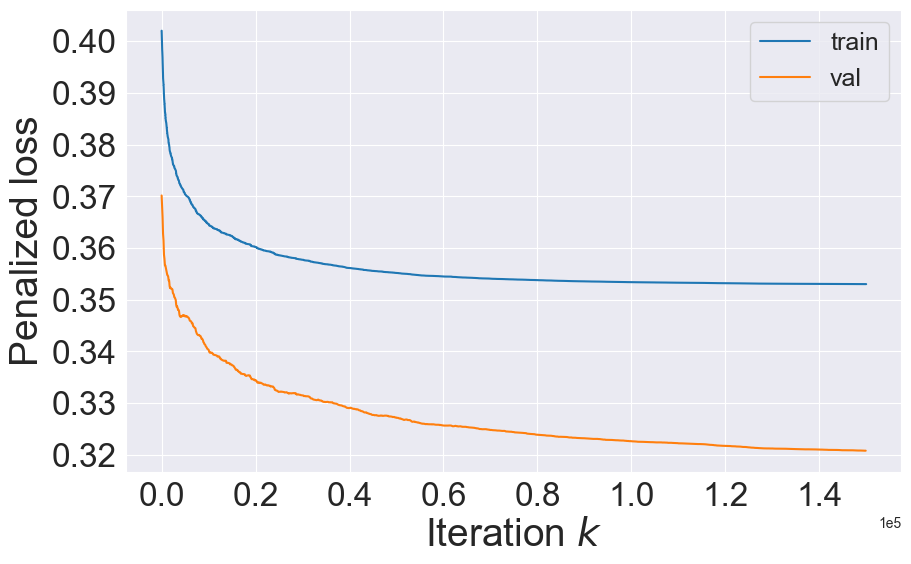

In [29]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_coord)), penalized_train_losses_coord, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses_coord)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

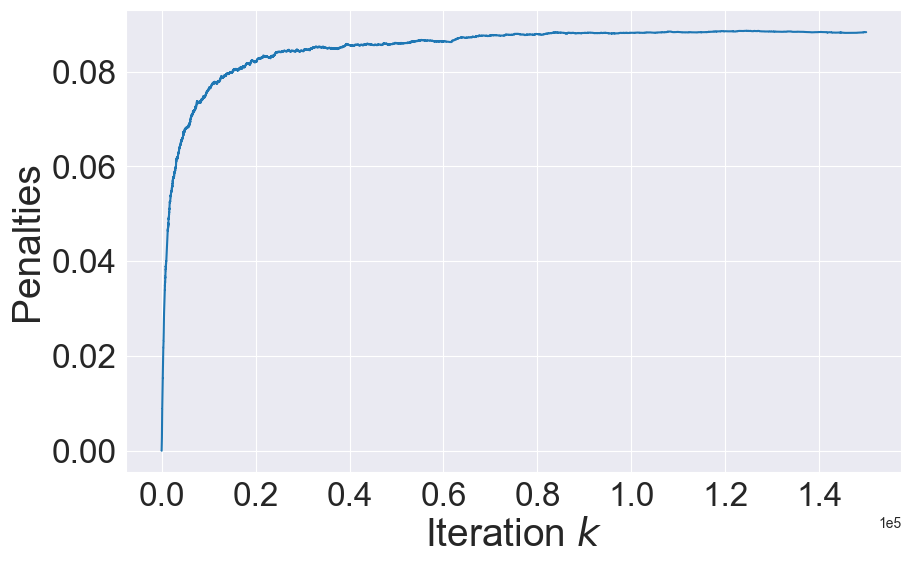

In [30]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses_coord - train_losses_coord

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

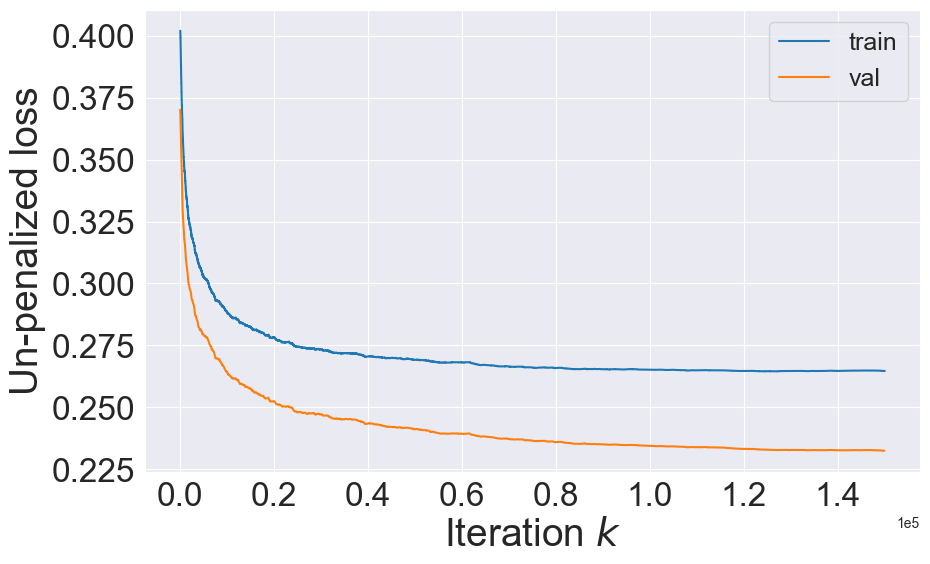

In [31]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_coord)), train_losses_coord, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses_coord)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 3. Projected conic descent

In [32]:
n_steps = N_STEPS
m = 500
ETA = 0.01
penalized = True

In [33]:
def projected_conic_particle_update(a, b, x, y, penalized=False):
    m = a.shape[1]
    if m > 0:
        signs = np.sign(a)
        a = a * (1 - 2 * ETA * signs * V_grad(a, b, x, y, b).reshape(1, -1))
        b = b - ETA * signs.T * nabla_V_grad(a, b, x, y)
        
        if penalized:
            a -= 2 * ETA * LAMBDA * a
            b -= ETA * LAMBDA * b
        
        b_norms = np.linalg.norm(b, ord=2, axis=1, keepdims=True)
        b = b / b_norms
    return a, b  

In [34]:
def train(m, n_steps, x_train, y_train, x_val, y_val, do_val=True, penalized=False):
    #a = np.zeros(shape=(1, m))
    a = np.random.normal(size=(1, m)) / m
    b = np.random.normal(size=(m, INPUT_DIM))
    b_norms = np.linalg.norm(b, axis=1, ord=2, keepdims=True)
    b = b / b_norms
    
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []
    ms = [m]

    for k in tqdm(range(n_steps)):
        a, b = projected_conic_particle_update(a, b, x_train, y_train, penalized=penalized)
        ms.append(a.shape[1])
        
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses) 

In [35]:
a, b, ms, train_losses_conic, penalized_train_losses_conic, val_losses_conic, penalized_val_losses_conic = \
    train(m, n_steps, x_train, y_train, x_val, y_val, penalized=penalized)

  0%|                                                       | 14/150000 [00:00<18:40, 133.87it/s]

m at step 0 : 500
Train loss at step 0 : 0.40241
Validation loss at step 0 : 0.37073


  0%|                                                      | 148/150000 [00:00<11:08, 224.06it/s]

m at step 100 : 500
Train loss at step 100 : 0.39923
Validation loss at step 100 : 0.36867


  0%|                                                      | 237/150000 [00:01<11:56, 209.11it/s]

m at step 200 : 500
Train loss at step 200 : 0.39633
Validation loss at step 200 : 0.36676


  0%|                                                      | 329/150000 [00:01<11:20, 219.97it/s]

m at step 300 : 500
Train loss at step 300 : 0.39363
Validation loss at step 300 : 0.36495


  0%|▏                                                     | 450/150000 [00:02<10:42, 232.71it/s]

m at step 400 : 500
Train loss at step 400 : 0.39107
Validation loss at step 400 : 0.36322


  0%|▏                                                     | 547/150000 [00:02<10:35, 235.25it/s]

m at step 500 : 500
Train loss at step 500 : 0.38858
Validation loss at step 500 : 0.36152


  0%|▏                                                     | 645/150000 [00:03<10:25, 238.62it/s]

m at step 600 : 500
Train loss at step 600 : 0.38612
Validation loss at step 600 : 0.35982


  0%|▎                                                     | 744/150000 [00:03<10:21, 240.23it/s]

m at step 700 : 500
Train loss at step 700 : 0.38363
Validation loss at step 700 : 0.35809


  1%|▎                                                     | 843/150000 [00:03<10:22, 239.79it/s]

m at step 800 : 500
Train loss at step 800 : 0.38107
Validation loss at step 800 : 0.35631


  1%|▎                                                     | 940/150000 [00:04<11:50, 209.66it/s]

m at step 900 : 500
Train loss at step 900 : 0.37843
Validation loss at step 900 : 0.35447


  1%|▎                                                    | 1034/150000 [00:04<10:54, 227.77it/s]

m at step 1,000 : 500
Train loss at step 1,000 : 0.37566
Validation loss at step 1,000 : 0.35254


  1%|▍                                                    | 1132/150000 [00:05<10:22, 239.07it/s]

m at step 1,100 : 500
Train loss at step 1,100 : 0.37274
Validation loss at step 1,100 : 0.35050


  1%|▍                                                    | 1229/150000 [00:05<10:35, 234.01it/s]

m at step 1,200 : 500
Train loss at step 1,200 : 0.36963
Validation loss at step 1,200 : 0.34834


  1%|▍                                                    | 1328/150000 [00:05<10:21, 239.16it/s]

m at step 1,300 : 500
Train loss at step 1,300 : 0.36630
Validation loss at step 1,300 : 0.34603


  1%|▌                                                    | 1426/150000 [00:06<10:22, 238.53it/s]

m at step 1,400 : 500
Train loss at step 1,400 : 0.36274
Validation loss at step 1,400 : 0.34355


  1%|▌                                                    | 1549/150000 [00:06<10:22, 238.45it/s]

m at step 1,500 : 500
Train loss at step 1,500 : 0.35890
Validation loss at step 1,500 : 0.34089


  1%|▌                                                    | 1647/150000 [00:07<10:21, 238.74it/s]

m at step 1,600 : 500
Train loss at step 1,600 : 0.35479
Validation loss at step 1,600 : 0.33804


  1%|▌                                                    | 1745/150000 [00:07<10:22, 237.98it/s]

m at step 1,700 : 500
Train loss at step 1,700 : 0.35038
Validation loss at step 1,700 : 0.33498


  1%|▋                                                    | 1844/150000 [00:08<10:15, 240.69it/s]

m at step 1,800 : 500
Train loss at step 1,800 : 0.34566
Validation loss at step 1,800 : 0.33171


  1%|▋                                                    | 1944/150000 [00:08<10:16, 240.14it/s]

m at step 1,900 : 500
Train loss at step 1,900 : 0.34059
Validation loss at step 1,900 : 0.32819


  1%|▋                                                    | 2044/150000 [00:09<10:14, 240.83it/s]

m at step 2,000 : 500
Train loss at step 2,000 : 0.33521
Validation loss at step 2,000 : 0.32444


  1%|▊                                                    | 2143/150000 [00:09<10:32, 233.84it/s]

m at step 2,100 : 500
Train loss at step 2,100 : 0.32950
Validation loss at step 2,100 : 0.32044


  1%|▊                                                    | 2240/150000 [00:09<10:33, 233.33it/s]

m at step 2,200 : 500
Train loss at step 2,200 : 0.32346
Validation loss at step 2,200 : 0.31620


  2%|▊                                                    | 2339/150000 [00:10<10:13, 240.71it/s]

m at step 2,300 : 500
Train loss at step 2,300 : 0.31711
Validation loss at step 2,300 : 0.31171


  2%|▊                                                    | 2438/150000 [00:10<10:18, 238.40it/s]

m at step 2,400 : 500
Train loss at step 2,400 : 0.31046
Validation loss at step 2,400 : 0.30698


  2%|▉                                                    | 2536/150000 [00:11<10:17, 238.76it/s]

m at step 2,500 : 500
Train loss at step 2,500 : 0.30355
Validation loss at step 2,500 : 0.30203


  2%|▉                                                    | 2635/150000 [00:11<10:18, 238.22it/s]

m at step 2,600 : 500
Train loss at step 2,600 : 0.29640
Validation loss at step 2,600 : 0.29687


  2%|▉                                                    | 2733/150000 [00:11<10:18, 237.94it/s]

m at step 2,700 : 500
Train loss at step 2,700 : 0.28905
Validation loss at step 2,700 : 0.29154


  2%|▉                                                    | 2830/150000 [00:12<10:32, 232.80it/s]

m at step 2,800 : 500
Train loss at step 2,800 : 0.28156
Validation loss at step 2,800 : 0.28605


  2%|█                                                    | 2928/150000 [00:12<10:17, 238.16it/s]

m at step 2,900 : 500
Train loss at step 2,900 : 0.27397
Validation loss at step 2,900 : 0.28044


  2%|█                                                    | 3047/150000 [00:13<11:18, 216.54it/s]

m at step 3,000 : 500
Train loss at step 3,000 : 0.26634
Validation loss at step 3,000 : 0.27474


  2%|█                                                    | 3139/150000 [00:13<10:55, 224.07it/s]

m at step 3,100 : 500
Train loss at step 3,100 : 0.25871
Validation loss at step 3,100 : 0.26898


  2%|█▏                                                   | 3235/150000 [00:14<10:31, 232.37it/s]

m at step 3,200 : 500
Train loss at step 3,200 : 0.25114
Validation loss at step 3,200 : 0.26319


  2%|█▏                                                   | 3331/150000 [00:14<10:27, 233.79it/s]

m at step 3,300 : 500
Train loss at step 3,300 : 0.24368
Validation loss at step 3,300 : 0.25741


  2%|█▏                                                   | 3430/150000 [00:15<10:16, 237.87it/s]

m at step 3,400 : 500
Train loss at step 3,400 : 0.23637
Validation loss at step 3,400 : 0.25168


  2%|█▏                                                   | 3527/150000 [00:15<10:25, 234.12it/s]

m at step 3,500 : 500
Train loss at step 3,500 : 0.22925
Validation loss at step 3,500 : 0.24603


  2%|█▎                                                   | 3650/150000 [00:15<10:05, 241.61it/s]

m at step 3,600 : 500
Train loss at step 3,600 : 0.22238
Validation loss at step 3,600 : 0.24049


  2%|█▎                                                   | 3749/150000 [00:16<10:05, 241.46it/s]

m at step 3,700 : 500
Train loss at step 3,700 : 0.21577
Validation loss at step 3,700 : 0.23508


  3%|█▎                                                   | 3849/150000 [00:16<10:03, 242.02it/s]

m at step 3,800 : 500
Train loss at step 3,800 : 0.20946
Validation loss at step 3,800 : 0.22982


  3%|█▍                                                   | 3947/150000 [00:17<10:15, 237.45it/s]

m at step 3,900 : 500
Train loss at step 3,900 : 0.20345
Validation loss at step 3,900 : 0.22475


  3%|█▍                                                   | 4044/150000 [00:17<10:34, 230.19it/s]

m at step 4,000 : 500
Train loss at step 4,000 : 0.19775
Validation loss at step 4,000 : 0.21986


  3%|█▍                                                   | 4143/150000 [00:18<10:12, 238.20it/s]

m at step 4,100 : 500
Train loss at step 4,100 : 0.19238
Validation loss at step 4,100 : 0.21518


  3%|█▍                                                   | 4240/150000 [00:18<10:15, 236.78it/s]

m at step 4,200 : 500
Train loss at step 4,200 : 0.18732
Validation loss at step 4,200 : 0.21071


  3%|█▌                                                   | 4338/150000 [00:18<10:09, 238.80it/s]

m at step 4,300 : 500
Train loss at step 4,300 : 0.18257
Validation loss at step 4,300 : 0.20645


  3%|█▌                                                   | 4436/150000 [00:19<10:12, 237.83it/s]

m at step 4,400 : 500
Train loss at step 4,400 : 0.17812
Validation loss at step 4,400 : 0.20240


  3%|█▌                                                   | 4534/150000 [00:19<10:13, 237.17it/s]

m at step 4,500 : 500
Train loss at step 4,500 : 0.17395
Validation loss at step 4,500 : 0.19856


  3%|█▋                                                   | 4633/150000 [00:20<10:07, 239.44it/s]

m at step 4,600 : 500
Train loss at step 4,600 : 0.17006
Validation loss at step 4,600 : 0.19492


  3%|█▋                                                   | 4728/150000 [00:20<12:33, 192.83it/s]

m at step 4,700 : 500
Train loss at step 4,700 : 0.16643
Validation loss at step 4,700 : 0.19149


  3%|█▋                                                   | 4850/150000 [00:21<10:25, 231.97it/s]

m at step 4,800 : 500
Train loss at step 4,800 : 0.16305
Validation loss at step 4,800 : 0.18825


  3%|█▋                                                   | 4924/150000 [00:21<10:17, 234.81it/s]

m at step 4,900 : 500
Train loss at step 4,900 : 0.15989
Validation loss at step 4,900 : 0.18520


  3%|█▊                                                   | 5045/150000 [00:22<10:14, 235.77it/s]

m at step 5,000 : 500
Train loss at step 5,000 : 0.15695
Validation loss at step 5,000 : 0.18232


  3%|█▊                                                   | 5144/150000 [00:22<10:07, 238.46it/s]

m at step 5,100 : 500
Train loss at step 5,100 : 0.15421
Validation loss at step 5,100 : 0.17960


  3%|█▊                                                   | 5242/150000 [00:22<10:06, 238.49it/s]

m at step 5,200 : 500
Train loss at step 5,200 : 0.15165
Validation loss at step 5,200 : 0.17704


  4%|█▉                                                   | 5341/150000 [00:23<10:01, 240.44it/s]

m at step 5,300 : 500
Train loss at step 5,300 : 0.14926
Validation loss at step 5,300 : 0.17463


  4%|█▉                                                   | 5441/150000 [00:23<09:59, 241.17it/s]

m at step 5,400 : 500
Train loss at step 5,400 : 0.14703
Validation loss at step 5,400 : 0.17236


  4%|█▉                                                   | 5540/150000 [00:24<10:07, 237.75it/s]

m at step 5,500 : 500
Train loss at step 5,500 : 0.14494
Validation loss at step 5,500 : 0.17023


  4%|█▉                                                   | 5636/150000 [00:24<10:31, 228.45it/s]

m at step 5,600 : 500
Train loss at step 5,600 : 0.14299
Validation loss at step 5,600 : 0.16821


  4%|██                                                   | 5733/150000 [00:25<10:15, 234.54it/s]

m at step 5,700 : 500
Train loss at step 5,700 : 0.14116
Validation loss at step 5,700 : 0.16632


  4%|██                                                   | 5830/150000 [00:25<10:06, 237.71it/s]

m at step 5,800 : 500
Train loss at step 5,800 : 0.13945
Validation loss at step 5,800 : 0.16454


  4%|██                                                   | 5927/150000 [00:25<10:35, 226.53it/s]

m at step 5,900 : 500
Train loss at step 5,900 : 0.13785
Validation loss at step 5,900 : 0.16286


  4%|██▏                                                  | 6049/150000 [00:26<10:04, 237.95it/s]

m at step 6,000 : 500
Train loss at step 6,000 : 0.13634
Validation loss at step 6,000 : 0.16127


  4%|██▏                                                  | 6147/150000 [00:26<10:00, 239.66it/s]

m at step 6,100 : 500
Train loss at step 6,100 : 0.13493
Validation loss at step 6,100 : 0.15978


  4%|██▏                                                  | 6244/150000 [00:27<10:18, 232.61it/s]

m at step 6,200 : 500
Train loss at step 6,200 : 0.13359
Validation loss at step 6,200 : 0.15837


  4%|██▏                                                  | 6343/150000 [00:27<10:01, 239.03it/s]

m at step 6,300 : 500
Train loss at step 6,300 : 0.13234
Validation loss at step 6,300 : 0.15703


  4%|██▎                                                  | 6439/150000 [00:28<10:17, 232.58it/s]

m at step 6,400 : 500
Train loss at step 6,400 : 0.13115
Validation loss at step 6,400 : 0.15577


  4%|██▎                                                  | 6538/150000 [00:28<10:03, 237.83it/s]

m at step 6,500 : 500
Train loss at step 6,500 : 0.13003
Validation loss at step 6,500 : 0.15458


  4%|██▎                                                  | 6637/150000 [00:28<09:58, 239.68it/s]

m at step 6,600 : 500
Train loss at step 6,600 : 0.12897
Validation loss at step 6,600 : 0.15345


  4%|██▍                                                  | 6735/150000 [00:29<09:56, 240.18it/s]

m at step 6,700 : 500
Train loss at step 6,700 : 0.12797
Validation loss at step 6,700 : 0.15238


  5%|██▍                                                  | 6834/150000 [00:29<10:20, 230.78it/s]

m at step 6,800 : 500
Train loss at step 6,800 : 0.12701
Validation loss at step 6,800 : 0.15137


  5%|██▍                                                  | 6933/150000 [00:30<10:02, 237.49it/s]

m at step 6,900 : 500
Train loss at step 6,900 : 0.12611
Validation loss at step 6,900 : 0.15041


  5%|██▍                                                  | 7031/150000 [00:30<10:01, 237.62it/s]

m at step 7,000 : 500
Train loss at step 7,000 : 0.12525
Validation loss at step 7,000 : 0.14950


  5%|██▌                                                  | 7129/150000 [00:31<09:57, 239.25it/s]

m at step 7,100 : 500
Train loss at step 7,100 : 0.12443
Validation loss at step 7,100 : 0.14864


  5%|██▌                                                  | 7225/150000 [00:31<10:03, 236.73it/s]

m at step 7,200 : 500
Train loss at step 7,200 : 0.12365
Validation loss at step 7,200 : 0.14783


  5%|██▌                                                  | 7349/150000 [00:31<09:55, 239.46it/s]

m at step 7,300 : 500
Train loss at step 7,300 : 0.12291
Validation loss at step 7,300 : 0.14705


  5%|██▋                                                  | 7447/150000 [00:32<09:56, 239.03it/s]

m at step 7,400 : 500
Train loss at step 7,400 : 0.12219
Validation loss at step 7,400 : 0.14631


  5%|██▋                                                  | 7545/150000 [00:32<09:58, 238.03it/s]

m at step 7,500 : 500
Train loss at step 7,500 : 0.12151
Validation loss at step 7,500 : 0.14561


  5%|██▋                                                  | 7642/150000 [00:33<09:55, 238.88it/s]

m at step 7,600 : 500
Train loss at step 7,600 : 0.12086
Validation loss at step 7,600 : 0.14494


  5%|██▋                                                  | 7740/150000 [00:33<09:57, 238.20it/s]

m at step 7,700 : 500
Train loss at step 7,700 : 0.12024
Validation loss at step 7,700 : 0.14431


  5%|██▊                                                  | 7837/150000 [00:34<10:05, 234.88it/s]

m at step 7,800 : 500
Train loss at step 7,800 : 0.11964
Validation loss at step 7,800 : 0.14370


  5%|██▊                                                  | 7934/150000 [00:34<10:11, 232.34it/s]

m at step 7,900 : 500
Train loss at step 7,900 : 0.11906
Validation loss at step 7,900 : 0.14312


  5%|██▊                                                  | 8031/150000 [00:34<10:05, 234.30it/s]

m at step 8,000 : 500
Train loss at step 8,000 : 0.11851
Validation loss at step 8,000 : 0.14257


  5%|██▊                                                  | 8128/150000 [00:35<10:00, 236.29it/s]

m at step 8,100 : 500
Train loss at step 8,100 : 0.11797
Validation loss at step 8,100 : 0.14204


  5%|██▉                                                  | 8226/150000 [00:35<09:53, 238.68it/s]

m at step 8,200 : 500
Train loss at step 8,200 : 0.11746
Validation loss at step 8,200 : 0.14154


  6%|██▉                                                  | 8350/150000 [00:36<09:48, 240.55it/s]

m at step 8,300 : 500
Train loss at step 8,300 : 0.11697
Validation loss at step 8,300 : 0.14106


  6%|██▉                                                  | 8449/150000 [00:36<09:51, 239.34it/s]

m at step 8,400 : 500
Train loss at step 8,400 : 0.11649
Validation loss at step 8,400 : 0.14060


  6%|███                                                  | 8546/150000 [00:37<09:53, 238.29it/s]

m at step 8,500 : 500
Train loss at step 8,500 : 0.11603
Validation loss at step 8,500 : 0.14016


  6%|███                                                  | 8645/150000 [00:37<09:47, 240.68it/s]

m at step 8,600 : 500
Train loss at step 8,600 : 0.11558
Validation loss at step 8,600 : 0.13974


  6%|███                                                  | 8744/150000 [00:37<10:05, 233.14it/s]

m at step 8,700 : 500
Train loss at step 8,700 : 0.11515
Validation loss at step 8,700 : 0.13934


  6%|███                                                  | 8841/150000 [00:38<09:55, 236.88it/s]

m at step 8,800 : 500
Train loss at step 8,800 : 0.11473
Validation loss at step 8,800 : 0.13895


  6%|███▏                                                 | 8938/150000 [00:38<09:58, 235.60it/s]

m at step 8,900 : 500
Train loss at step 8,900 : 0.11433
Validation loss at step 8,900 : 0.13858


  6%|███▏                                                 | 9037/150000 [00:39<09:49, 238.99it/s]

m at step 9,000 : 500
Train loss at step 9,000 : 0.11393
Validation loss at step 9,000 : 0.13823


  6%|███▏                                                 | 9136/150000 [00:39<09:45, 240.65it/s]

m at step 9,100 : 500
Train loss at step 9,100 : 0.11355
Validation loss at step 9,100 : 0.13788


  6%|███▎                                                 | 9235/150000 [00:40<09:56, 236.04it/s]

m at step 9,200 : 500
Train loss at step 9,200 : 0.11317
Validation loss at step 9,200 : 0.13756


  6%|███▎                                                 | 9334/150000 [00:40<09:50, 238.11it/s]

m at step 9,300 : 500
Train loss at step 9,300 : 0.11281
Validation loss at step 9,300 : 0.13724


  6%|███▎                                                 | 9423/150000 [00:41<13:46, 170.10it/s]

m at step 9,400 : 500
Train loss at step 9,400 : 0.11246
Validation loss at step 9,400 : 0.13694


  6%|███▎                                                 | 9541/150000 [00:41<12:24, 188.71it/s]

m at step 9,500 : 500
Train loss at step 9,500 : 0.11212
Validation loss at step 9,500 : 0.13664


  6%|███▍                                                 | 9631/150000 [00:42<10:43, 218.02it/s]

m at step 9,600 : 500
Train loss at step 9,600 : 0.11178
Validation loss at step 9,600 : 0.13636


  6%|███▍                                                 | 9727/150000 [00:42<10:03, 232.48it/s]

m at step 9,700 : 500
Train loss at step 9,700 : 0.11146
Validation loss at step 9,700 : 0.13610


  7%|███▍                                                 | 9821/150000 [00:43<13:19, 175.35it/s]

m at step 9,800 : 500
Train loss at step 9,800 : 0.11114
Validation loss at step 9,800 : 0.13583


  7%|███▌                                                 | 9940/150000 [00:43<10:31, 221.92it/s]

m at step 9,900 : 500
Train loss at step 9,900 : 0.11083
Validation loss at step 9,900 : 0.13558


  7%|███▍                                                | 10037/150000 [00:44<09:55, 235.03it/s]

m at step 10,000 : 500
Train loss at step 10,000 : 0.11053
Validation loss at step 10,000 : 0.13534


  7%|███▌                                                | 10116/150000 [00:44<20:02, 116.32it/s]

m at step 10,100 : 500
Train loss at step 10,100 : 0.11024
Validation loss at step 10,100 : 0.13511


  7%|███▌                                                | 10233/150000 [00:45<11:30, 202.28it/s]

m at step 10,200 : 500
Train loss at step 10,200 : 0.10995
Validation loss at step 10,200 : 0.13489


  7%|███▌                                                | 10328/150000 [00:45<10:09, 229.04it/s]

m at step 10,300 : 500
Train loss at step 10,300 : 0.10967
Validation loss at step 10,300 : 0.13467


  7%|███▌                                                | 10449/150000 [00:46<09:56, 233.92it/s]

m at step 10,400 : 500
Train loss at step 10,400 : 0.10939
Validation loss at step 10,400 : 0.13446


  7%|███▋                                                | 10546/150000 [00:46<10:00, 232.15it/s]

m at step 10,500 : 500
Train loss at step 10,500 : 0.10912
Validation loss at step 10,500 : 0.13425


  7%|███▋                                                | 10643/150000 [00:47<09:57, 233.23it/s]

m at step 10,600 : 500
Train loss at step 10,600 : 0.10885
Validation loss at step 10,600 : 0.13406


  7%|███▋                                                | 10737/150000 [00:47<10:38, 218.07it/s]

m at step 10,700 : 500
Train loss at step 10,700 : 0.10859
Validation loss at step 10,700 : 0.13386


  7%|███▊                                                | 10827/150000 [00:48<10:38, 217.94it/s]

m at step 10,800 : 500
Train loss at step 10,800 : 0.10834
Validation loss at step 10,800 : 0.13368


  7%|███▊                                                | 10948/150000 [00:48<09:47, 236.54it/s]

m at step 10,900 : 500
Train loss at step 10,900 : 0.10809
Validation loss at step 10,900 : 0.13350


  7%|███▊                                                | 11045/150000 [00:48<09:46, 237.05it/s]

m at step 11,000 : 500
Train loss at step 11,000 : 0.10784
Validation loss at step 11,000 : 0.13332


  7%|███▊                                                | 11143/150000 [00:49<09:43, 238.16it/s]

m at step 11,100 : 500
Train loss at step 11,100 : 0.10760
Validation loss at step 11,100 : 0.13316


  7%|███▉                                                | 11242/150000 [00:49<09:42, 238.26it/s]

m at step 11,200 : 500
Train loss at step 11,200 : 0.10736
Validation loss at step 11,200 : 0.13299


  8%|███▉                                                | 11340/150000 [00:50<09:49, 235.13it/s]

m at step 11,300 : 500
Train loss at step 11,300 : 0.10713
Validation loss at step 11,300 : 0.13283


  8%|███▉                                                | 11438/150000 [00:50<09:43, 237.37it/s]

m at step 11,400 : 500
Train loss at step 11,400 : 0.10690
Validation loss at step 11,400 : 0.13268


  8%|███▉                                                | 11537/150000 [00:51<09:40, 238.60it/s]

m at step 11,500 : 500
Train loss at step 11,500 : 0.10667
Validation loss at step 11,500 : 0.13253


  8%|████                                                | 11635/150000 [00:51<09:43, 236.93it/s]

m at step 11,600 : 500
Train loss at step 11,600 : 0.10645
Validation loss at step 11,600 : 0.13239


  8%|████                                                | 11733/150000 [00:51<09:45, 236.05it/s]

m at step 11,700 : 500
Train loss at step 11,700 : 0.10623
Validation loss at step 11,700 : 0.13225


  8%|████                                                | 11828/150000 [00:52<10:09, 226.63it/s]

m at step 11,800 : 500
Train loss at step 11,800 : 0.10601
Validation loss at step 11,800 : 0.13211


  8%|████▏                                               | 11948/150000 [00:52<09:41, 237.40it/s]

m at step 11,900 : 500
Train loss at step 11,900 : 0.10580
Validation loss at step 11,900 : 0.13198


  8%|████▏                                               | 12047/150000 [00:53<09:37, 238.90it/s]

m at step 12,000 : 500
Train loss at step 12,000 : 0.10559
Validation loss at step 12,000 : 0.13186


  8%|████▏                                               | 12146/150000 [00:53<09:36, 239.15it/s]

m at step 12,100 : 500
Train loss at step 12,100 : 0.10538
Validation loss at step 12,100 : 0.13173


  8%|████▏                                               | 12243/150000 [00:54<09:57, 230.48it/s]

m at step 12,200 : 500
Train loss at step 12,200 : 0.10518
Validation loss at step 12,200 : 0.13161


  8%|████▎                                               | 12341/150000 [00:54<09:40, 237.02it/s]

m at step 12,300 : 500
Train loss at step 12,300 : 0.10497
Validation loss at step 12,300 : 0.13150


  8%|████▎                                               | 12439/150000 [00:54<09:41, 236.73it/s]

m at step 12,400 : 500
Train loss at step 12,400 : 0.10478
Validation loss at step 12,400 : 0.13139


  8%|████▎                                               | 12538/150000 [00:55<09:37, 238.09it/s]

m at step 12,500 : 500
Train loss at step 12,500 : 0.10458
Validation loss at step 12,500 : 0.13128


  8%|████▍                                               | 12635/150000 [00:55<09:35, 238.61it/s]

m at step 12,600 : 500
Train loss at step 12,600 : 0.10439
Validation loss at step 12,600 : 0.13117


  8%|████▍                                               | 12733/150000 [00:56<09:36, 238.05it/s]

m at step 12,700 : 500
Train loss at step 12,700 : 0.10420
Validation loss at step 12,700 : 0.13107


  9%|████▍                                               | 12831/150000 [00:56<09:35, 238.54it/s]

m at step 12,800 : 500
Train loss at step 12,800 : 0.10402
Validation loss at step 12,800 : 0.13097


  9%|████▍                                               | 12928/150000 [00:57<09:36, 237.60it/s]

m at step 12,900 : 500
Train loss at step 12,900 : 0.10384
Validation loss at step 12,900 : 0.13088


  9%|████▌                                               | 13049/150000 [00:57<09:37, 237.03it/s]

m at step 13,000 : 500
Train loss at step 13,000 : 0.10366
Validation loss at step 13,000 : 0.13079


  9%|████▌                                               | 13148/150000 [00:57<09:30, 239.70it/s]

m at step 13,100 : 500
Train loss at step 13,100 : 0.10348
Validation loss at step 13,100 : 0.13070


  9%|████▌                                               | 13246/150000 [00:58<09:43, 234.47it/s]

m at step 13,200 : 500
Train loss at step 13,200 : 0.10330
Validation loss at step 13,200 : 0.13061


  9%|████▋                                               | 13344/150000 [00:58<09:36, 236.96it/s]

m at step 13,300 : 500
Train loss at step 13,300 : 0.10313
Validation loss at step 13,300 : 0.13053


  9%|████▋                                               | 13442/150000 [00:59<09:33, 238.08it/s]

m at step 13,400 : 500
Train loss at step 13,400 : 0.10296
Validation loss at step 13,400 : 0.13045


  9%|████▋                                               | 13540/150000 [00:59<09:31, 238.88it/s]

m at step 13,500 : 500
Train loss at step 13,500 : 0.10279
Validation loss at step 13,500 : 0.13037


  9%|████▋                                               | 13637/150000 [01:00<09:36, 236.46it/s]

m at step 13,600 : 500
Train loss at step 13,600 : 0.10263
Validation loss at step 13,600 : 0.13029


  9%|████▊                                               | 13736/150000 [01:00<09:28, 239.49it/s]

m at step 13,700 : 500
Train loss at step 13,700 : 0.10247
Validation loss at step 13,700 : 0.13021


  9%|████▊                                               | 13834/150000 [01:00<09:31, 238.20it/s]

m at step 13,800 : 500
Train loss at step 13,800 : 0.10231
Validation loss at step 13,800 : 0.13014


  9%|████▊                                               | 13931/150000 [01:01<09:32, 237.87it/s]

m at step 13,900 : 500
Train loss at step 13,900 : 0.10215
Validation loss at step 13,900 : 0.13007


  9%|████▊                                               | 14028/150000 [01:01<09:32, 237.32it/s]

m at step 14,000 : 500
Train loss at step 14,000 : 0.10199
Validation loss at step 14,000 : 0.12999


  9%|████▉                                               | 14125/150000 [01:02<09:55, 228.32it/s]

m at step 14,100 : 500
Train loss at step 14,100 : 0.10183
Validation loss at step 14,100 : 0.12992


  9%|████▉                                               | 14245/150000 [01:02<09:42, 233.12it/s]

m at step 14,200 : 500
Train loss at step 14,200 : 0.10168
Validation loss at step 14,200 : 0.12985


 10%|████▉                                               | 14343/150000 [01:03<09:46, 231.39it/s]

m at step 14,300 : 500
Train loss at step 14,300 : 0.10152
Validation loss at step 14,300 : 0.12979


 10%|█████                                               | 14441/150000 [01:03<09:36, 235.26it/s]

m at step 14,400 : 500
Train loss at step 14,400 : 0.10137
Validation loss at step 14,400 : 0.12972


 10%|█████                                               | 14539/150000 [01:03<09:27, 238.76it/s]

m at step 14,500 : 500
Train loss at step 14,500 : 0.10122
Validation loss at step 14,500 : 0.12965


 10%|█████                                               | 14637/150000 [01:04<09:26, 238.92it/s]

m at step 14,600 : 500
Train loss at step 14,600 : 0.10108
Validation loss at step 14,600 : 0.12959


 10%|█████                                               | 14734/150000 [01:04<09:31, 236.49it/s]

m at step 14,700 : 500
Train loss at step 14,700 : 0.10093
Validation loss at step 14,700 : 0.12952


 10%|█████▏                                              | 14828/150000 [01:05<11:44, 191.77it/s]

m at step 14,800 : 500
Train loss at step 14,800 : 0.10079
Validation loss at step 14,800 : 0.12946


 10%|█████▏                                              | 14948/150000 [01:05<09:49, 229.19it/s]

m at step 14,900 : 500
Train loss at step 14,900 : 0.10065
Validation loss at step 14,900 : 0.12940


 10%|█████▏                                              | 15045/150000 [01:06<09:53, 227.41it/s]

m at step 15,000 : 500
Train loss at step 15,000 : 0.10051
Validation loss at step 15,000 : 0.12934


 10%|█████▏                                              | 15142/150000 [01:06<09:34, 234.78it/s]

m at step 15,100 : 500
Train loss at step 15,100 : 0.10037
Validation loss at step 15,100 : 0.12928


 10%|█████▎                                              | 15240/150000 [01:07<09:28, 236.91it/s]

m at step 15,200 : 500
Train loss at step 15,200 : 0.10024
Validation loss at step 15,200 : 0.12922


 10%|█████▎                                              | 15339/150000 [01:07<09:22, 239.33it/s]

m at step 15,300 : 500
Train loss at step 15,300 : 0.10010
Validation loss at step 15,300 : 0.12917


 10%|█████▎                                              | 15438/150000 [01:07<09:20, 240.08it/s]

m at step 15,400 : 500
Train loss at step 15,400 : 0.09997
Validation loss at step 15,400 : 0.12911


 10%|█████▍                                              | 15536/150000 [01:08<09:32, 234.82it/s]

m at step 15,500 : 500
Train loss at step 15,500 : 0.09984
Validation loss at step 15,500 : 0.12906


 10%|█████▍                                              | 15635/150000 [01:08<09:21, 239.15it/s]

m at step 15,600 : 500
Train loss at step 15,600 : 0.09971
Validation loss at step 15,600 : 0.12901


 10%|█████▍                                              | 15732/150000 [01:09<09:30, 235.54it/s]

m at step 15,700 : 500
Train loss at step 15,700 : 0.09959
Validation loss at step 15,700 : 0.12896


 11%|█████▍                                              | 15831/150000 [01:09<09:20, 239.28it/s]

m at step 15,800 : 500
Train loss at step 15,800 : 0.09946
Validation loss at step 15,800 : 0.12891


 11%|█████▌                                              | 15928/150000 [01:10<09:23, 237.74it/s]

m at step 15,900 : 500
Train loss at step 15,900 : 0.09934
Validation loss at step 15,900 : 0.12886


 11%|█████▌                                              | 16026/150000 [01:10<09:29, 235.34it/s]

m at step 16,000 : 500
Train loss at step 16,000 : 0.09922
Validation loss at step 16,000 : 0.12881


 11%|█████▌                                              | 16150/150000 [01:11<09:13, 242.03it/s]

m at step 16,100 : 500
Train loss at step 16,100 : 0.09910
Validation loss at step 16,100 : 0.12876


 11%|█████▋                                              | 16249/150000 [01:11<09:24, 236.85it/s]

m at step 16,200 : 500
Train loss at step 16,200 : 0.09898
Validation loss at step 16,200 : 0.12872


 11%|█████▋                                              | 16347/150000 [01:11<09:25, 236.27it/s]

m at step 16,300 : 500
Train loss at step 16,300 : 0.09887
Validation loss at step 16,300 : 0.12867


 11%|█████▋                                              | 16443/150000 [01:12<09:33, 232.93it/s]

m at step 16,400 : 500
Train loss at step 16,400 : 0.09875
Validation loss at step 16,400 : 0.12863


 11%|█████▋                                              | 16541/150000 [01:12<09:22, 237.46it/s]

m at step 16,500 : 500
Train loss at step 16,500 : 0.09864
Validation loss at step 16,500 : 0.12859


 11%|█████▊                                              | 16636/150000 [01:13<10:00, 222.01it/s]

m at step 16,600 : 500
Train loss at step 16,600 : 0.09853
Validation loss at step 16,600 : 0.12854


 11%|█████▊                                              | 16733/150000 [01:13<09:33, 232.31it/s]

m at step 16,700 : 500
Train loss at step 16,700 : 0.09842
Validation loss at step 16,700 : 0.12850


 11%|█████▉                                               | 16799/150000 [01:14<34:24, 64.52it/s]

m at step 16,800 : 500
Train loss at step 16,800 : 0.09831
Validation loss at step 16,800 : 0.12847


 11%|█████▊                                              | 16932/150000 [01:15<13:14, 167.45it/s]

m at step 16,900 : 500
Train loss at step 16,900 : 0.09820
Validation loss at step 16,900 : 0.12843


 11%|█████▉                                              | 17045/150000 [01:16<09:04, 244.34it/s]

m at step 17,000 : 500
Train loss at step 17,000 : 0.09810
Validation loss at step 17,000 : 0.12839


 11%|█████▉                                              | 17154/150000 [01:16<08:29, 260.54it/s]

m at step 17,100 : 500
Train loss at step 17,100 : 0.09799
Validation loss at step 17,100 : 0.12835


 11%|█████▉                                              | 17236/150000 [01:16<08:41, 254.61it/s]

m at step 17,200 : 500
Train loss at step 17,200 : 0.09789
Validation loss at step 17,200 : 0.12832


 12%|██████                                              | 17347/150000 [01:17<08:14, 268.20it/s]

m at step 17,300 : 500
Train loss at step 17,300 : 0.09779
Validation loss at step 17,300 : 0.12828


 12%|██████                                              | 17429/150000 [01:17<08:11, 269.86it/s]

m at step 17,400 : 500
Train loss at step 17,400 : 0.09769
Validation loss at step 17,400 : 0.12825


 12%|██████                                              | 17541/150000 [01:17<08:14, 268.11it/s]

m at step 17,500 : 500
Train loss at step 17,500 : 0.09759
Validation loss at step 17,500 : 0.12821


 12%|██████                                              | 17651/150000 [01:18<08:10, 269.82it/s]

m at step 17,600 : 500
Train loss at step 17,600 : 0.09749
Validation loss at step 17,600 : 0.12818


 12%|██████▏                                             | 17733/150000 [01:18<08:28, 259.98it/s]

m at step 17,700 : 500
Train loss at step 17,700 : 0.09739
Validation loss at step 17,700 : 0.12815


 12%|██████▏                                             | 17815/150000 [01:19<11:53, 185.30it/s]

m at step 17,800 : 500
Train loss at step 17,800 : 0.09730
Validation loss at step 17,800 : 0.12811


 12%|██████▏                                             | 17949/150000 [01:19<08:57, 245.85it/s]

m at step 17,900 : 500
Train loss at step 17,900 : 0.09720
Validation loss at step 17,900 : 0.12808


 12%|██████▎                                             | 18029/150000 [01:19<08:34, 256.47it/s]

m at step 18,000 : 500
Train loss at step 18,000 : 0.09711
Validation loss at step 18,000 : 0.12805


 12%|██████▎                                             | 18140/150000 [01:20<08:10, 268.91it/s]

m at step 18,100 : 500
Train loss at step 18,100 : 0.09702
Validation loss at step 18,100 : 0.12802


 12%|██████▎                                             | 18250/150000 [01:20<08:14, 266.30it/s]

m at step 18,200 : 500
Train loss at step 18,200 : 0.09693
Validation loss at step 18,200 : 0.12799


 12%|██████▎                                             | 18333/150000 [01:21<08:07, 270.22it/s]

m at step 18,300 : 500
Train loss at step 18,300 : 0.09684
Validation loss at step 18,300 : 0.12796


 12%|██████▍                                             | 18445/150000 [01:21<08:01, 273.06it/s]

m at step 18,400 : 500
Train loss at step 18,400 : 0.09675
Validation loss at step 18,400 : 0.12793


 12%|██████▍                                             | 18528/150000 [01:21<08:19, 263.43it/s]

m at step 18,500 : 500
Train loss at step 18,500 : 0.09667
Validation loss at step 18,500 : 0.12790


 12%|██████▍                                             | 18637/150000 [01:22<08:14, 265.66it/s]

m at step 18,600 : 500
Train loss at step 18,600 : 0.09658
Validation loss at step 18,600 : 0.12788


 12%|██████▍                                             | 18746/150000 [01:22<08:20, 262.41it/s]

m at step 18,700 : 500
Train loss at step 18,700 : 0.09650
Validation loss at step 18,700 : 0.12785


 13%|██████▌                                             | 18855/150000 [01:22<08:13, 265.80it/s]

m at step 18,800 : 500
Train loss at step 18,800 : 0.09641
Validation loss at step 18,800 : 0.12782


 13%|██████▌                                             | 18938/150000 [01:23<08:06, 269.61it/s]

m at step 18,900 : 500
Train loss at step 18,900 : 0.09633
Validation loss at step 18,900 : 0.12780


 13%|██████▌                                             | 19048/150000 [01:23<08:11, 266.58it/s]

m at step 19,000 : 500
Train loss at step 19,000 : 0.09625
Validation loss at step 19,000 : 0.12777


 13%|██████▋                                             | 19130/150000 [01:24<08:11, 266.33it/s]

m at step 19,100 : 500
Train loss at step 19,100 : 0.09617
Validation loss at step 19,100 : 0.12775


 13%|██████▋                                             | 19241/150000 [01:24<08:02, 271.09it/s]

m at step 19,200 : 500
Train loss at step 19,200 : 0.09609
Validation loss at step 19,200 : 0.12772


 13%|██████▋                                             | 19322/150000 [01:24<09:20, 233.08it/s]

m at step 19,300 : 500
Train loss at step 19,300 : 0.09602
Validation loss at step 19,300 : 0.12770


 13%|██████▋                                             | 19449/150000 [01:25<09:13, 236.07it/s]

m at step 19,400 : 500
Train loss at step 19,400 : 0.09594
Validation loss at step 19,400 : 0.12767


 13%|██████▊                                             | 19530/150000 [01:25<08:36, 252.78it/s]

m at step 19,500 : 500
Train loss at step 19,500 : 0.09587
Validation loss at step 19,500 : 0.12765


 13%|██████▊                                             | 19640/150000 [01:26<08:10, 265.67it/s]

m at step 19,600 : 500
Train loss at step 19,600 : 0.09579
Validation loss at step 19,600 : 0.12763


 13%|██████▊                                             | 19750/150000 [01:26<08:21, 259.97it/s]

m at step 19,700 : 500
Train loss at step 19,700 : 0.09572
Validation loss at step 19,700 : 0.12761


 13%|██████▊                                             | 19830/150000 [01:26<08:31, 254.24it/s]

m at step 19,800 : 500
Train loss at step 19,800 : 0.09565
Validation loss at step 19,800 : 0.12759


 13%|██████▉                                             | 19939/150000 [01:27<08:07, 266.78it/s]

m at step 19,900 : 500
Train loss at step 19,900 : 0.09557
Validation loss at step 19,900 : 0.12757


 13%|██████▉                                             | 20050/150000 [01:27<08:07, 266.53it/s]

m at step 20,000 : 500
Train loss at step 20,000 : 0.09550
Validation loss at step 20,000 : 0.12755


 13%|██████▉                                             | 20132/150000 [01:27<08:07, 266.44it/s]

m at step 20,100 : 500
Train loss at step 20,100 : 0.09543
Validation loss at step 20,100 : 0.12753


 13%|███████                                             | 20241/150000 [01:28<08:07, 266.17it/s]

m at step 20,200 : 500
Train loss at step 20,200 : 0.09537
Validation loss at step 20,200 : 0.12751


 14%|███████                                             | 20325/150000 [01:28<08:14, 262.09it/s]

m at step 20,300 : 500
Train loss at step 20,300 : 0.09530
Validation loss at step 20,300 : 0.12749


 14%|███████                                             | 20436/150000 [01:29<08:03, 268.14it/s]

m at step 20,400 : 500
Train loss at step 20,400 : 0.09523
Validation loss at step 20,400 : 0.12747


 14%|███████                                             | 20547/150000 [01:29<08:00, 269.28it/s]

m at step 20,500 : 500
Train loss at step 20,500 : 0.09517
Validation loss at step 20,500 : 0.12745


 14%|███████▏                                            | 20629/150000 [01:29<08:04, 267.29it/s]

m at step 20,600 : 500
Train loss at step 20,600 : 0.09510
Validation loss at step 20,600 : 0.12743


 14%|███████▏                                            | 20741/150000 [01:30<07:55, 271.75it/s]

m at step 20,700 : 500
Train loss at step 20,700 : 0.09504
Validation loss at step 20,700 : 0.12741


 14%|███████▏                                            | 20825/150000 [01:30<08:09, 263.76it/s]

m at step 20,800 : 500
Train loss at step 20,800 : 0.09497
Validation loss at step 20,800 : 0.12739


 14%|███████▎                                            | 20933/150000 [01:30<08:11, 262.77it/s]

m at step 20,900 : 500
Train loss at step 20,900 : 0.09491
Validation loss at step 20,900 : 0.12737


 14%|███████▎                                            | 21045/150000 [01:31<07:54, 271.62it/s]

m at step 21,000 : 500
Train loss at step 21,000 : 0.09485
Validation loss at step 21,000 : 0.12736


 14%|███████▎                                            | 21129/150000 [01:31<08:05, 265.54it/s]

m at step 21,100 : 500
Train loss at step 21,100 : 0.09479
Validation loss at step 21,100 : 0.12734


 14%|███████▎                                            | 21240/150000 [01:32<07:59, 268.42it/s]

m at step 21,200 : 500
Train loss at step 21,200 : 0.09473
Validation loss at step 21,200 : 0.12732


 14%|███████▍                                            | 21350/150000 [01:32<07:52, 272.14it/s]

m at step 21,300 : 500
Train loss at step 21,300 : 0.09467
Validation loss at step 21,300 : 0.12731


 14%|███████▍                                            | 21432/150000 [01:32<08:08, 262.98it/s]

m at step 21,400 : 500
Train loss at step 21,400 : 0.09461
Validation loss at step 21,400 : 0.12729


 14%|███████▍                                            | 21544/150000 [01:33<07:56, 269.73it/s]

m at step 21,500 : 500
Train loss at step 21,500 : 0.09456
Validation loss at step 21,500 : 0.12727


 14%|███████▍                                            | 21627/150000 [01:33<07:51, 272.50it/s]

m at step 21,600 : 500
Train loss at step 21,600 : 0.09450
Validation loss at step 21,600 : 0.12726


 14%|███████▌                                            | 21738/150000 [01:33<07:54, 270.56it/s]

m at step 21,700 : 500
Train loss at step 21,700 : 0.09445
Validation loss at step 21,700 : 0.12724


 15%|███████▌                                            | 21850/150000 [01:34<07:48, 273.43it/s]

m at step 21,800 : 500
Train loss at step 21,800 : 0.09439
Validation loss at step 21,800 : 0.12723


 15%|███████▌                                            | 21933/150000 [01:34<08:14, 259.12it/s]

m at step 21,900 : 500
Train loss at step 21,900 : 0.09434
Validation loss at step 21,900 : 0.12721


 15%|███████▋                                            | 22041/150000 [01:35<08:24, 253.63it/s]

m at step 22,000 : 500
Train loss at step 22,000 : 0.09428
Validation loss at step 22,000 : 0.12720


 15%|███████▋                                            | 22119/150000 [01:35<12:15, 173.98it/s]

m at step 22,100 : 500
Train loss at step 22,100 : 0.09423
Validation loss at step 22,100 : 0.12719


 15%|███████▋                                            | 22255/150000 [01:36<08:38, 246.61it/s]

m at step 22,200 : 500
Train loss at step 22,200 : 0.09418
Validation loss at step 22,200 : 0.12717


 15%|███████▋                                            | 22338/150000 [01:36<08:04, 263.61it/s]

m at step 22,300 : 500
Train loss at step 22,300 : 0.09413
Validation loss at step 22,300 : 0.12716


 15%|███████▊                                            | 22449/150000 [01:36<07:54, 268.57it/s]

m at step 22,400 : 500
Train loss at step 22,400 : 0.09408
Validation loss at step 22,400 : 0.12714


 15%|███████▊                                            | 22532/150000 [01:37<07:50, 270.92it/s]

m at step 22,500 : 500
Train loss at step 22,500 : 0.09403
Validation loss at step 22,500 : 0.12713


 15%|███████▊                                            | 22644/150000 [01:37<07:45, 273.48it/s]

m at step 22,600 : 500
Train loss at step 22,600 : 0.09398
Validation loss at step 22,600 : 0.12712


 15%|███████▉                                            | 22756/150000 [01:37<07:51, 270.08it/s]

m at step 22,700 : 500
Train loss at step 22,700 : 0.09393
Validation loss at step 22,700 : 0.12710


 15%|███████▉                                            | 22840/150000 [01:38<07:45, 273.20it/s]

m at step 22,800 : 500
Train loss at step 22,800 : 0.09389
Validation loss at step 22,800 : 0.12709


 15%|███████▉                                            | 22924/150000 [01:38<07:44, 273.64it/s]

m at step 22,900 : 500
Train loss at step 22,900 : 0.09384
Validation loss at step 22,900 : 0.12708


 15%|███████▉                                            | 23035/150000 [01:38<07:58, 265.56it/s]

m at step 23,000 : 500
Train loss at step 23,000 : 0.09379
Validation loss at step 23,000 : 0.12707


 15%|████████                                            | 23147/150000 [01:39<07:42, 273.99it/s]

m at step 23,100 : 500
Train loss at step 23,100 : 0.09375
Validation loss at step 23,100 : 0.12706


 15%|████████                                            | 23231/150000 [01:39<07:52, 268.20it/s]

m at step 23,200 : 500
Train loss at step 23,200 : 0.09370
Validation loss at step 23,200 : 0.12704


 16%|████████                                            | 23342/150000 [01:40<07:46, 271.28it/s]

m at step 23,300 : 500
Train loss at step 23,300 : 0.09366
Validation loss at step 23,300 : 0.12703


 16%|████████▏                                           | 23454/150000 [01:40<07:51, 268.66it/s]

m at step 23,400 : 500
Train loss at step 23,400 : 0.09361
Validation loss at step 23,400 : 0.12702


 16%|████████▏                                           | 23536/150000 [01:40<08:06, 259.86it/s]

m at step 23,500 : 500
Train loss at step 23,500 : 0.09357
Validation loss at step 23,500 : 0.12701


 16%|████████▏                                           | 23591/150000 [01:41<07:53, 267.15it/s]

m at step 23,600 : 500
Train loss at step 23,600 : 0.09353
Validation loss at step 23,600 : 0.12700


 16%|████████▏                                           | 23748/150000 [01:42<10:12, 206.02it/s]

m at step 23,700 : 500
Train loss at step 23,700 : 0.09348
Validation loss at step 23,700 : 0.12698


 16%|████████▎                                           | 23832/150000 [01:42<08:28, 248.30it/s]

m at step 23,800 : 500
Train loss at step 23,800 : 0.09344
Validation loss at step 23,800 : 0.12697


 16%|████████▎                                           | 23939/150000 [01:42<09:12, 228.05it/s]

m at step 23,900 : 500
Train loss at step 23,900 : 0.09340
Validation loss at step 23,900 : 0.12696


 16%|████████▎                                           | 24044/150000 [01:43<08:32, 245.74it/s]

m at step 24,000 : 500
Train loss at step 24,000 : 0.09336
Validation loss at step 24,000 : 0.12695


 16%|████████▎                                           | 24151/150000 [01:43<08:09, 257.12it/s]

m at step 24,100 : 500
Train loss at step 24,100 : 0.09332
Validation loss at step 24,100 : 0.12694


 16%|████████▍                                           | 24234/150000 [01:44<07:50, 267.24it/s]

m at step 24,200 : 500
Train loss at step 24,200 : 0.09328
Validation loss at step 24,200 : 0.12693


 16%|████████▍                                           | 24344/150000 [01:44<07:49, 267.61it/s]

m at step 24,300 : 500
Train loss at step 24,300 : 0.09324
Validation loss at step 24,300 : 0.12692


 16%|████████▍                                           | 24455/150000 [01:44<07:40, 272.48it/s]

m at step 24,400 : 500
Train loss at step 24,400 : 0.09321
Validation loss at step 24,400 : 0.12691


 16%|████████▌                                           | 24537/150000 [01:45<08:00, 260.95it/s]

m at step 24,500 : 500
Train loss at step 24,500 : 0.09317
Validation loss at step 24,500 : 0.12690


 16%|████████▌                                           | 24649/150000 [01:45<07:46, 268.62it/s]

m at step 24,600 : 500
Train loss at step 24,600 : 0.09313
Validation loss at step 24,600 : 0.12689


 16%|████████▌                                           | 24734/150000 [01:45<07:35, 275.07it/s]

m at step 24,700 : 500
Train loss at step 24,700 : 0.09310
Validation loss at step 24,700 : 0.12688


 17%|████████▌                                           | 24847/150000 [01:46<07:33, 276.11it/s]

m at step 24,800 : 500
Train loss at step 24,800 : 0.09306
Validation loss at step 24,800 : 0.12687


 17%|████████▋                                           | 24932/150000 [01:46<07:46, 267.84it/s]

m at step 24,900 : 500
Train loss at step 24,900 : 0.09303
Validation loss at step 24,900 : 0.12686


 17%|████████▋                                           | 25042/150000 [01:47<07:44, 268.85it/s]

m at step 25,000 : 500
Train loss at step 25,000 : 0.09299
Validation loss at step 25,000 : 0.12685


 17%|████████▋                                           | 25151/150000 [01:47<07:48, 266.55it/s]

m at step 25,100 : 500
Train loss at step 25,100 : 0.09296
Validation loss at step 25,100 : 0.12684


 17%|████████▋                                           | 25234/150000 [01:47<07:47, 267.01it/s]

m at step 25,200 : 500
Train loss at step 25,200 : 0.09292
Validation loss at step 25,200 : 0.12683


 17%|████████▊                                           | 25347/150000 [01:48<07:35, 273.42it/s]

m at step 25,300 : 500
Train loss at step 25,300 : 0.09289
Validation loss at step 25,300 : 0.12682


 17%|████████▊                                           | 25432/150000 [01:48<07:28, 278.05it/s]

m at step 25,400 : 500
Train loss at step 25,400 : 0.09286
Validation loss at step 25,400 : 0.12682


 17%|████████▊                                           | 25545/150000 [01:48<07:32, 275.18it/s]

m at step 25,500 : 500
Train loss at step 25,500 : 0.09283
Validation loss at step 25,500 : 0.12681


 17%|████████▉                                           | 25630/150000 [01:49<07:27, 278.04it/s]

m at step 25,600 : 500
Train loss at step 25,600 : 0.09280
Validation loss at step 25,600 : 0.12680


 17%|████████▉                                           | 25743/150000 [01:49<07:41, 268.97it/s]

m at step 25,700 : 500
Train loss at step 25,700 : 0.09277
Validation loss at step 25,700 : 0.12679


 17%|████████▉                                           | 25854/150000 [01:50<07:36, 271.87it/s]

m at step 25,800 : 500
Train loss at step 25,800 : 0.09273
Validation loss at step 25,800 : 0.12678


 17%|████████▉                                           | 25940/150000 [01:50<07:29, 275.93it/s]

m at step 25,900 : 500
Train loss at step 25,900 : 0.09270
Validation loss at step 25,900 : 0.12677


 17%|█████████                                           | 26051/150000 [01:50<07:55, 260.92it/s]

m at step 26,000 : 500
Train loss at step 26,000 : 0.09267
Validation loss at step 26,000 : 0.12676


 17%|█████████                                           | 26133/150000 [01:51<07:51, 262.96it/s]

m at step 26,100 : 500
Train loss at step 26,100 : 0.09265
Validation loss at step 26,100 : 0.12675


 17%|█████████                                           | 26243/150000 [01:51<10:41, 192.86it/s]

m at step 26,200 : 500
Train loss at step 26,200 : 0.09262
Validation loss at step 26,200 : 0.12675


 18%|█████████▏                                          | 26356/150000 [01:52<08:11, 251.73it/s]

m at step 26,300 : 500
Train loss at step 26,300 : 0.09259
Validation loss at step 26,300 : 0.12674


 18%|█████████▏                                          | 26426/150000 [01:52<11:55, 172.81it/s]

m at step 26,400 : 500
Train loss at step 26,400 : 0.09256
Validation loss at step 26,400 : 0.12673


 18%|█████████▏                                          | 26539/150000 [01:53<09:24, 218.84it/s]

m at step 26,500 : 500
Train loss at step 26,500 : 0.09253
Validation loss at step 26,500 : 0.12672


 18%|█████████▏                                          | 26651/150000 [01:53<08:01, 256.00it/s]

m at step 26,600 : 500
Train loss at step 26,600 : 0.09251
Validation loss at step 26,600 : 0.12671


 18%|█████████▎                                          | 26733/150000 [01:53<07:43, 265.67it/s]

m at step 26,700 : 500
Train loss at step 26,700 : 0.09248
Validation loss at step 26,700 : 0.12671


 18%|█████████▎                                          | 26841/150000 [01:54<08:00, 256.30it/s]

m at step 26,800 : 500
Train loss at step 26,800 : 0.09245
Validation loss at step 26,800 : 0.12670


 18%|█████████▎                                          | 26947/150000 [01:54<07:53, 259.81it/s]

m at step 26,900 : 500
Train loss at step 26,900 : 0.09243
Validation loss at step 26,900 : 0.12669


 18%|█████████▎                                          | 27027/150000 [01:55<08:12, 249.48it/s]

m at step 27,000 : 500
Train loss at step 27,000 : 0.09240
Validation loss at step 27,000 : 0.12669


 18%|█████████▍                                          | 27140/150000 [01:55<07:33, 270.89it/s]

m at step 27,100 : 500
Train loss at step 27,100 : 0.09238
Validation loss at step 27,100 : 0.12668


 18%|█████████▍                                          | 27222/150000 [01:55<07:39, 267.11it/s]

m at step 27,200 : 500
Train loss at step 27,200 : 0.09235
Validation loss at step 27,200 : 0.12667


 18%|█████████▍                                          | 27351/150000 [01:56<08:39, 236.17it/s]

m at step 27,300 : 500
Train loss at step 27,300 : 0.09233
Validation loss at step 27,300 : 0.12667


 18%|█████████▌                                          | 27432/150000 [01:56<08:02, 253.95it/s]

m at step 27,400 : 500
Train loss at step 27,400 : 0.09230
Validation loss at step 27,400 : 0.12666


 18%|█████████▌                                          | 27545/150000 [01:57<07:30, 271.57it/s]

m at step 27,500 : 500
Train loss at step 27,500 : 0.09228
Validation loss at step 27,500 : 0.12665


 18%|█████████▌                                          | 27629/150000 [01:57<07:28, 272.83it/s]

m at step 27,600 : 500
Train loss at step 27,600 : 0.09226
Validation loss at step 27,600 : 0.12665


 18%|█████████▌                                          | 27742/150000 [01:57<07:29, 272.21it/s]

m at step 27,700 : 500
Train loss at step 27,700 : 0.09223
Validation loss at step 27,700 : 0.12664


 19%|█████████▋                                          | 27856/150000 [01:58<07:17, 278.89it/s]

m at step 27,800 : 500
Train loss at step 27,800 : 0.09221
Validation loss at step 27,800 : 0.12663


 19%|█████████▋                                          | 27940/150000 [01:58<07:17, 278.84it/s]

m at step 27,900 : 500
Train loss at step 27,900 : 0.09219
Validation loss at step 27,900 : 0.12663


 19%|█████████▋                                          | 28024/150000 [01:58<07:49, 259.71it/s]

m at step 28,000 : 500
Train loss at step 28,000 : 0.09217
Validation loss at step 28,000 : 0.12662


 19%|█████████▊                                          | 28138/150000 [01:59<07:23, 274.91it/s]

m at step 28,100 : 500
Train loss at step 28,100 : 0.09214
Validation loss at step 28,100 : 0.12662


 19%|█████████▊                                          | 28251/150000 [01:59<07:26, 272.85it/s]

m at step 28,200 : 500
Train loss at step 28,200 : 0.09212
Validation loss at step 28,200 : 0.12661


 19%|█████████▊                                          | 28336/150000 [02:00<07:23, 274.46it/s]

m at step 28,300 : 500
Train loss at step 28,300 : 0.09210
Validation loss at step 28,300 : 0.12660


 19%|█████████▊                                          | 28449/150000 [02:00<07:23, 274.12it/s]

m at step 28,400 : 500
Train loss at step 28,400 : 0.09208
Validation loss at step 28,400 : 0.12660


 19%|█████████▉                                          | 28532/150000 [02:00<07:37, 265.45it/s]

m at step 28,500 : 500
Train loss at step 28,500 : 0.09206
Validation loss at step 28,500 : 0.12659


 19%|█████████▉                                          | 28646/150000 [02:01<07:19, 275.95it/s]

m at step 28,600 : 500
Train loss at step 28,600 : 0.09204
Validation loss at step 28,600 : 0.12659


 19%|█████████▉                                          | 28731/150000 [02:01<07:16, 277.95it/s]

m at step 28,700 : 500
Train loss at step 28,700 : 0.09202
Validation loss at step 28,700 : 0.12658


 19%|█████████▉                                          | 28843/150000 [02:01<07:20, 275.01it/s]

m at step 28,800 : 500
Train loss at step 28,800 : 0.09200
Validation loss at step 28,800 : 0.12658


 19%|██████████                                          | 28957/150000 [02:02<07:15, 278.09it/s]

m at step 28,900 : 500
Train loss at step 28,900 : 0.09198
Validation loss at step 28,900 : 0.12657


 19%|██████████                                          | 29041/150000 [02:02<07:19, 275.20it/s]

m at step 29,000 : 500
Train loss at step 29,000 : 0.09196
Validation loss at step 29,000 : 0.12657


 19%|██████████                                          | 29125/150000 [02:02<07:45, 259.93it/s]

m at step 29,100 : 500
Train loss at step 29,100 : 0.09194
Validation loss at step 29,100 : 0.12656


 19%|██████████▏                                         | 29237/150000 [02:03<07:27, 270.06it/s]

m at step 29,200 : 500
Train loss at step 29,200 : 0.09193
Validation loss at step 29,200 : 0.12656


 20%|██████████▏                                         | 29349/150000 [02:03<07:25, 270.76it/s]

m at step 29,300 : 500
Train loss at step 29,300 : 0.09191
Validation loss at step 29,300 : 0.12655


 20%|██████████▏                                         | 29433/150000 [02:04<07:20, 273.78it/s]

m at step 29,400 : 500
Train loss at step 29,400 : 0.09189
Validation loss at step 29,400 : 0.12655


 20%|██████████▏                                         | 29548/150000 [02:04<07:11, 279.13it/s]

m at step 29,500 : 500
Train loss at step 29,500 : 0.09187
Validation loss at step 29,500 : 0.12654


 20%|██████████▎                                         | 29632/150000 [02:04<07:25, 269.97it/s]

m at step 29,600 : 500
Train loss at step 29,600 : 0.09185
Validation loss at step 29,600 : 0.12654


 20%|██████████▎                                         | 29743/150000 [02:05<07:31, 266.22it/s]

m at step 29,700 : 500
Train loss at step 29,700 : 0.09184
Validation loss at step 29,700 : 0.12654


 20%|██████████▎                                         | 29828/150000 [02:05<07:17, 274.37it/s]

m at step 29,800 : 500
Train loss at step 29,800 : 0.09182
Validation loss at step 29,800 : 0.12653


 20%|██████████▍                                         | 29941/150000 [02:05<07:16, 275.31it/s]

m at step 29,900 : 500
Train loss at step 29,900 : 0.09180
Validation loss at step 29,900 : 0.12653


 20%|██████████▍                                         | 30054/150000 [02:06<07:15, 275.12it/s]

m at step 30,000 : 500
Train loss at step 30,000 : 0.09179
Validation loss at step 30,000 : 0.12652


 20%|██████████▍                                         | 30138/150000 [02:06<07:34, 263.94it/s]

m at step 30,100 : 500
Train loss at step 30,100 : 0.09177
Validation loss at step 30,100 : 0.12652


 20%|██████████▍                                         | 30250/150000 [02:07<07:33, 263.86it/s]

m at step 30,200 : 500
Train loss at step 30,200 : 0.09176
Validation loss at step 30,200 : 0.12652


 20%|██████████▌                                         | 30334/150000 [02:07<07:24, 269.19it/s]

m at step 30,300 : 500
Train loss at step 30,300 : 0.09174
Validation loss at step 30,300 : 0.12651


 20%|██████████▌                                         | 30444/150000 [02:07<07:24, 268.69it/s]

m at step 30,400 : 500
Train loss at step 30,400 : 0.09172
Validation loss at step 30,400 : 0.12651


 20%|██████████▌                                         | 30529/150000 [02:08<07:15, 274.06it/s]

m at step 30,500 : 500
Train loss at step 30,500 : 0.09171
Validation loss at step 30,500 : 0.12650


 20%|██████████▌                                         | 30642/150000 [02:08<07:08, 278.43it/s]

m at step 30,600 : 500
Train loss at step 30,600 : 0.09169
Validation loss at step 30,600 : 0.12650


 21%|██████████▋                                         | 30754/150000 [02:08<07:16, 273.23it/s]

m at step 30,700 : 500
Train loss at step 30,700 : 0.09168
Validation loss at step 30,700 : 0.12649


 21%|██████████▋                                         | 30839/150000 [02:09<07:11, 276.04it/s]

m at step 30,800 : 500
Train loss at step 30,800 : 0.09166
Validation loss at step 30,800 : 0.12649


 21%|██████████▋                                         | 30951/150000 [02:09<07:20, 269.96it/s]

m at step 30,900 : 500
Train loss at step 30,900 : 0.09165
Validation loss at step 30,900 : 0.12649


 21%|██████████▊                                         | 31036/150000 [02:09<07:14, 273.48it/s]

m at step 31,000 : 500
Train loss at step 31,000 : 0.09164
Validation loss at step 31,000 : 0.12648


 21%|██████████▊                                         | 31150/150000 [02:10<07:06, 278.61it/s]

m at step 31,100 : 500
Train loss at step 31,100 : 0.09162
Validation loss at step 31,100 : 0.12648


 21%|██████████▊                                         | 31234/150000 [02:10<07:19, 269.98it/s]

m at step 31,200 : 500
Train loss at step 31,200 : 0.09161
Validation loss at step 31,200 : 0.12648


 21%|██████████▊                                         | 31346/150000 [02:11<07:26, 265.73it/s]

m at step 31,300 : 500
Train loss at step 31,300 : 0.09159
Validation loss at step 31,300 : 0.12647


 21%|██████████▉                                         | 31431/150000 [02:11<07:16, 271.91it/s]

m at step 31,400 : 500
Train loss at step 31,400 : 0.09158
Validation loss at step 31,400 : 0.12647


 21%|██████████▉                                         | 31542/150000 [02:11<07:23, 267.15it/s]

m at step 31,500 : 500
Train loss at step 31,500 : 0.09157
Validation loss at step 31,500 : 0.12647


 21%|██████████▉                                         | 31654/150000 [02:12<07:12, 273.36it/s]

m at step 31,600 : 500
Train loss at step 31,600 : 0.09155
Validation loss at step 31,600 : 0.12646


 21%|███████████                                         | 31738/150000 [02:12<07:09, 275.31it/s]

m at step 31,700 : 500
Train loss at step 31,700 : 0.09154
Validation loss at step 31,700 : 0.12646


 21%|███████████                                         | 31850/150000 [02:12<07:12, 273.17it/s]

m at step 31,800 : 500
Train loss at step 31,800 : 0.09153
Validation loss at step 31,800 : 0.12645


 21%|███████████                                         | 31932/150000 [02:13<07:41, 255.65it/s]

m at step 31,900 : 500
Train loss at step 31,900 : 0.09151
Validation loss at step 31,900 : 0.12645


 21%|███████████                                         | 32040/150000 [02:13<07:29, 262.25it/s]

m at step 32,000 : 500
Train loss at step 32,000 : 0.09150
Validation loss at step 32,000 : 0.12645


 21%|███████████▏                                        | 32153/150000 [02:14<07:08, 274.82it/s]

m at step 32,100 : 500
Train loss at step 32,100 : 0.09149
Validation loss at step 32,100 : 0.12644


 21%|███████████▏                                        | 32238/150000 [02:14<07:03, 278.06it/s]

m at step 32,200 : 500
Train loss at step 32,200 : 0.09147
Validation loss at step 32,200 : 0.12644


 22%|███████████▏                                        | 32350/150000 [02:14<07:10, 273.51it/s]

m at step 32,300 : 500
Train loss at step 32,300 : 0.09146
Validation loss at step 32,300 : 0.12644


 22%|███████████▏                                        | 32434/150000 [02:15<07:38, 256.40it/s]

m at step 32,400 : 500
Train loss at step 32,400 : 0.09145
Validation loss at step 32,400 : 0.12643


 22%|███████████▎                                        | 32544/150000 [02:15<07:19, 267.40it/s]

m at step 32,500 : 500
Train loss at step 32,500 : 0.09144
Validation loss at step 32,500 : 0.12643


 22%|███████████▎                                        | 32657/150000 [02:16<07:06, 275.21it/s]

m at step 32,600 : 500
Train loss at step 32,600 : 0.09143
Validation loss at step 32,600 : 0.12642


 22%|███████████▎                                        | 32741/150000 [02:16<07:44, 252.40it/s]

m at step 32,700 : 500
Train loss at step 32,700 : 0.09141
Validation loss at step 32,700 : 0.12642


 22%|███████████▍                                        | 32851/150000 [02:16<08:18, 234.86it/s]

m at step 32,800 : 500
Train loss at step 32,800 : 0.09140
Validation loss at step 32,800 : 0.12642


 22%|███████████▍                                        | 32936/150000 [02:17<07:27, 261.50it/s]

m at step 32,900 : 500
Train loss at step 32,900 : 0.09139
Validation loss at step 32,900 : 0.12641


 22%|███████████▍                                        | 33048/150000 [02:17<07:13, 270.03it/s]

m at step 33,000 : 500
Train loss at step 33,000 : 0.09138
Validation loss at step 33,000 : 0.12641


 22%|███████████▍                                        | 33131/150000 [02:17<07:23, 263.75it/s]

m at step 33,100 : 500
Train loss at step 33,100 : 0.09137
Validation loss at step 33,100 : 0.12641


 22%|███████████▌                                        | 33245/150000 [02:18<07:02, 276.50it/s]

m at step 33,200 : 500
Train loss at step 33,200 : 0.09136
Validation loss at step 33,200 : 0.12640


 22%|███████████▌                                        | 33330/150000 [02:18<07:09, 271.56it/s]

m at step 33,300 : 500
Train loss at step 33,300 : 0.09135
Validation loss at step 33,300 : 0.12640


 22%|███████████▌                                        | 33443/150000 [02:19<07:08, 271.90it/s]

m at step 33,400 : 500
Train loss at step 33,400 : 0.09134
Validation loss at step 33,400 : 0.12640


 22%|███████████▋                                        | 33558/150000 [02:19<07:04, 274.27it/s]

m at step 33,500 : 500
Train loss at step 33,500 : 0.09132
Validation loss at step 33,500 : 0.12639


 22%|███████████▋                                        | 33643/150000 [02:19<07:08, 271.39it/s]

m at step 33,600 : 500
Train loss at step 33,600 : 0.09131
Validation loss at step 33,600 : 0.12639


 23%|███████████▋                                        | 33756/150000 [02:20<07:00, 276.70it/s]

m at step 33,700 : 500
Train loss at step 33,700 : 0.09130
Validation loss at step 33,700 : 0.12639


 23%|███████████▋                                        | 33841/150000 [02:20<06:57, 277.93it/s]

m at step 33,800 : 500
Train loss at step 33,800 : 0.09129
Validation loss at step 33,800 : 0.12638


 23%|███████████▊                                        | 33955/150000 [02:20<07:00, 275.71it/s]

m at step 33,900 : 500
Train loss at step 33,900 : 0.09128
Validation loss at step 33,900 : 0.12638


 23%|███████████▊                                        | 34040/150000 [02:21<06:57, 278.02it/s]

m at step 34,000 : 500
Train loss at step 34,000 : 0.09127
Validation loss at step 34,000 : 0.12638


 23%|███████████▊                                        | 34153/150000 [02:21<07:13, 267.13it/s]

m at step 34,100 : 500
Train loss at step 34,100 : 0.09126
Validation loss at step 34,100 : 0.12638


 23%|███████████▊                                        | 34237/150000 [02:21<07:06, 271.49it/s]

m at step 34,200 : 500
Train loss at step 34,200 : 0.09125
Validation loss at step 34,200 : 0.12637


 23%|███████████▉                                        | 34351/150000 [02:22<06:54, 278.77it/s]

m at step 34,300 : 500
Train loss at step 34,300 : 0.09124
Validation loss at step 34,300 : 0.12637


 23%|███████████▉                                        | 34435/150000 [02:22<07:09, 269.34it/s]

m at step 34,400 : 500
Train loss at step 34,400 : 0.09123
Validation loss at step 34,400 : 0.12637


 23%|███████████▉                                        | 34548/150000 [02:23<07:02, 272.98it/s]

m at step 34,500 : 500
Train loss at step 34,500 : 0.09122
Validation loss at step 34,500 : 0.12636


 23%|████████████                                        | 34634/150000 [02:23<07:02, 272.79it/s]

m at step 34,600 : 500
Train loss at step 34,600 : 0.09122
Validation loss at step 34,600 : 0.12636


 23%|████████████                                        | 34746/150000 [02:23<07:06, 270.16it/s]

m at step 34,700 : 500
Train loss at step 34,700 : 0.09121
Validation loss at step 34,700 : 0.12636


 23%|████████████                                        | 34831/150000 [02:24<06:58, 275.25it/s]

m at step 34,800 : 500
Train loss at step 34,800 : 0.09120
Validation loss at step 34,800 : 0.12636


 23%|████████████                                        | 34943/150000 [02:24<06:59, 274.08it/s]

m at step 34,900 : 500
Train loss at step 34,900 : 0.09119
Validation loss at step 34,900 : 0.12635


 23%|████████████▏                                       | 35056/150000 [02:24<07:02, 271.99it/s]

m at step 35,000 : 500
Train loss at step 35,000 : 0.09118
Validation loss at step 35,000 : 0.12635


 23%|████████████▏                                       | 35141/150000 [02:25<07:04, 270.79it/s]

m at step 35,100 : 500
Train loss at step 35,100 : 0.09117
Validation loss at step 35,100 : 0.12635


 24%|████████████▏                                       | 35254/150000 [02:25<07:00, 272.80it/s]

m at step 35,200 : 500
Train loss at step 35,200 : 0.09116
Validation loss at step 35,200 : 0.12635


 24%|████████████▎                                       | 35337/150000 [02:26<07:14, 263.85it/s]

m at step 35,300 : 500
Train loss at step 35,300 : 0.09115
Validation loss at step 35,300 : 0.12634


 24%|████████████▎                                       | 35449/150000 [02:26<06:57, 274.63it/s]

m at step 35,400 : 500
Train loss at step 35,400 : 0.09114
Validation loss at step 35,400 : 0.12634


 24%|████████████▎                                       | 35532/150000 [02:26<07:09, 266.30it/s]

m at step 35,500 : 500
Train loss at step 35,500 : 0.09114
Validation loss at step 35,500 : 0.12634


 24%|████████████▎                                       | 35644/150000 [02:27<07:10, 265.45it/s]

m at step 35,600 : 500
Train loss at step 35,600 : 0.09113
Validation loss at step 35,600 : 0.12634


 24%|████████████▍                                       | 35755/150000 [02:27<07:05, 268.79it/s]

m at step 35,700 : 500
Train loss at step 35,700 : 0.09112
Validation loss at step 35,700 : 0.12634


 24%|████████████▍                                       | 35838/150000 [02:27<06:59, 272.17it/s]

m at step 35,800 : 500
Train loss at step 35,800 : 0.09111
Validation loss at step 35,800 : 0.12633


 24%|████████████▍                                       | 35951/150000 [02:28<07:07, 266.98it/s]

m at step 35,900 : 500
Train loss at step 35,900 : 0.09110
Validation loss at step 35,900 : 0.12633


 24%|████████████▍                                       | 36033/150000 [02:28<07:16, 261.28it/s]

m at step 36,000 : 500
Train loss at step 36,000 : 0.09110
Validation loss at step 36,000 : 0.12633


 24%|████████████▌                                       | 36146/150000 [02:29<06:58, 272.25it/s]

m at step 36,100 : 500
Train loss at step 36,100 : 0.09109
Validation loss at step 36,100 : 0.12633


 24%|████████████▌                                       | 36231/150000 [02:29<06:51, 276.22it/s]

m at step 36,200 : 500
Train loss at step 36,200 : 0.09108
Validation loss at step 36,200 : 0.12632


 24%|████████████▌                                       | 36344/150000 [02:29<06:55, 273.34it/s]

m at step 36,300 : 500
Train loss at step 36,300 : 0.09107
Validation loss at step 36,300 : 0.12632


 24%|████████████▋                                       | 36430/150000 [02:30<06:49, 277.53it/s]

m at step 36,400 : 500
Train loss at step 36,400 : 0.09106
Validation loss at step 36,400 : 0.12632


 24%|████████████▋                                       | 36544/150000 [02:30<06:46, 279.41it/s]

m at step 36,500 : 500
Train loss at step 36,500 : 0.09106
Validation loss at step 36,500 : 0.12632


 24%|████████████▋                                       | 36657/150000 [02:30<06:55, 272.72it/s]

m at step 36,600 : 500
Train loss at step 36,600 : 0.09105
Validation loss at step 36,600 : 0.12632


 24%|████████████▋                                       | 36741/150000 [02:31<06:59, 269.96it/s]

m at step 36,700 : 500
Train loss at step 36,700 : 0.09104
Validation loss at step 36,700 : 0.12631


 25%|████████████▊                                       | 36854/150000 [02:31<07:05, 266.11it/s]

m at step 36,800 : 500
Train loss at step 36,800 : 0.09103
Validation loss at step 36,800 : 0.12631


 25%|████████████▊                                       | 36938/150000 [02:31<06:53, 273.72it/s]

m at step 36,900 : 500
Train loss at step 36,900 : 0.09103
Validation loss at step 36,900 : 0.12631


 25%|████████████▊                                       | 37052/150000 [02:32<06:46, 277.66it/s]

m at step 37,000 : 500
Train loss at step 37,000 : 0.09102
Validation loss at step 37,000 : 0.12631


 25%|████████████▊                                       | 37136/150000 [02:32<07:01, 267.53it/s]

m at step 37,100 : 500
Train loss at step 37,100 : 0.09101
Validation loss at step 37,100 : 0.12630


 25%|████████████▉                                       | 37247/150000 [02:33<06:54, 272.23it/s]

m at step 37,200 : 500
Train loss at step 37,200 : 0.09101
Validation loss at step 37,200 : 0.12630


 25%|████████████▉                                       | 37331/150000 [02:33<06:49, 274.99it/s]

m at step 37,300 : 500
Train loss at step 37,300 : 0.09100
Validation loss at step 37,300 : 0.12630


 25%|████████████▉                                       | 37444/150000 [02:33<06:51, 273.79it/s]

m at step 37,400 : 500
Train loss at step 37,400 : 0.09099
Validation loss at step 37,400 : 0.12630


 25%|█████████████                                       | 37529/150000 [02:34<06:46, 276.83it/s]

m at step 37,500 : 500
Train loss at step 37,500 : 0.09099
Validation loss at step 37,500 : 0.12630


 25%|█████████████                                       | 37643/150000 [02:34<06:42, 278.95it/s]

m at step 37,600 : 500
Train loss at step 37,600 : 0.09098
Validation loss at step 37,600 : 0.12629


 25%|█████████████                                       | 37756/150000 [02:34<06:52, 272.37it/s]

m at step 37,700 : 500
Train loss at step 37,700 : 0.09097
Validation loss at step 37,700 : 0.12629


 25%|█████████████                                       | 37838/150000 [02:35<07:14, 258.05it/s]

m at step 37,800 : 500
Train loss at step 37,800 : 0.09097
Validation loss at step 37,800 : 0.12629


 25%|█████████████▏                                      | 37947/150000 [02:35<07:01, 266.01it/s]

m at step 37,900 : 500
Train loss at step 37,900 : 0.09096
Validation loss at step 37,900 : 0.12629


 25%|█████████████▏                                      | 38031/150000 [02:35<06:52, 271.64it/s]

m at step 38,000 : 500
Train loss at step 38,000 : 0.09095
Validation loss at step 38,000 : 0.12628


 25%|█████████████▏                                      | 38144/150000 [02:36<06:52, 271.46it/s]

m at step 38,100 : 500
Train loss at step 38,100 : 0.09095
Validation loss at step 38,100 : 0.12628


 25%|█████████████▎                                      | 38226/150000 [02:36<08:34, 217.08it/s]

m at step 38,200 : 500
Train loss at step 38,200 : 0.09094
Validation loss at step 38,200 : 0.12628


 26%|█████████████▎                                      | 38334/150000 [02:37<07:46, 239.26it/s]

m at step 38,300 : 500
Train loss at step 38,300 : 0.09093
Validation loss at step 38,300 : 0.12628


 26%|█████████████▎                                      | 38444/150000 [02:37<07:09, 259.97it/s]

m at step 38,400 : 500
Train loss at step 38,400 : 0.09093
Validation loss at step 38,400 : 0.12627


 26%|█████████████▎                                      | 38557/150000 [02:38<06:46, 274.03it/s]

m at step 38,500 : 500
Train loss at step 38,500 : 0.09092
Validation loss at step 38,500 : 0.12627


 26%|█████████████▍                                      | 38642/150000 [02:38<06:41, 277.56it/s]

m at step 38,600 : 500
Train loss at step 38,600 : 0.09091
Validation loss at step 38,600 : 0.12627


 26%|█████████████▍                                      | 38753/150000 [02:38<06:58, 265.93it/s]

m at step 38,700 : 500
Train loss at step 38,700 : 0.09091
Validation loss at step 38,700 : 0.12627


 26%|█████████████▍                                      | 38838/150000 [02:39<06:48, 272.39it/s]

m at step 38,800 : 500
Train loss at step 38,800 : 0.09090
Validation loss at step 38,800 : 0.12627


 26%|█████████████▌                                      | 38951/150000 [02:39<06:47, 272.35it/s]

m at step 38,900 : 500
Train loss at step 38,900 : 0.09090
Validation loss at step 38,900 : 0.12626


 26%|█████████████▌                                      | 39035/150000 [02:39<06:54, 267.76it/s]

m at step 39,000 : 500
Train loss at step 39,000 : 0.09089
Validation loss at step 39,000 : 0.12626


 26%|█████████████▌                                      | 39149/150000 [02:40<06:40, 276.71it/s]

m at step 39,100 : 500
Train loss at step 39,100 : 0.09088
Validation loss at step 39,100 : 0.12626


 26%|█████████████▌                                      | 39233/150000 [02:40<06:46, 272.72it/s]

m at step 39,200 : 500
Train loss at step 39,200 : 0.09088
Validation loss at step 39,200 : 0.12626


 26%|█████████████▋                                      | 39347/150000 [02:41<06:40, 276.51it/s]

m at step 39,300 : 500
Train loss at step 39,300 : 0.09087
Validation loss at step 39,300 : 0.12625


 26%|█████████████▋                                      | 39428/150000 [02:41<08:07, 227.01it/s]

m at step 39,400 : 500
Train loss at step 39,400 : 0.09087
Validation loss at step 39,400 : 0.12625


 26%|█████████████▋                                      | 39528/150000 [02:41<07:42, 239.03it/s]

m at step 39,500 : 500
Train loss at step 39,500 : 0.09086
Validation loss at step 39,500 : 0.12625


 26%|█████████████▋                                      | 39642/150000 [02:42<06:49, 269.59it/s]

m at step 39,600 : 500
Train loss at step 39,600 : 0.09086
Validation loss at step 39,600 : 0.12625


 27%|█████████████▊                                      | 39755/150000 [02:42<06:50, 268.78it/s]

m at step 39,700 : 500
Train loss at step 39,700 : 0.09085
Validation loss at step 39,700 : 0.12625


 27%|█████████████▊                                      | 39840/150000 [02:42<06:44, 272.46it/s]

m at step 39,800 : 500
Train loss at step 39,800 : 0.09085
Validation loss at step 39,800 : 0.12624


 27%|█████████████▊                                      | 39947/150000 [02:43<07:22, 248.83it/s]

m at step 39,900 : 500
Train loss at step 39,900 : 0.09084
Validation loss at step 39,900 : 0.12624


 27%|█████████████▉                                      | 40028/150000 [02:43<07:14, 253.25it/s]

m at step 40,000 : 500
Train loss at step 40,000 : 0.09083
Validation loss at step 40,000 : 0.12624


 27%|█████████████▉                                      | 40140/150000 [02:44<06:43, 272.04it/s]

m at step 40,100 : 500
Train loss at step 40,100 : 0.09083
Validation loss at step 40,100 : 0.12624


 27%|█████████████▉                                      | 40252/150000 [02:44<06:42, 272.59it/s]

m at step 40,200 : 500
Train loss at step 40,200 : 0.09082
Validation loss at step 40,200 : 0.12624


 27%|█████████████▉                                      | 40336/150000 [02:44<06:46, 269.63it/s]

m at step 40,300 : 500
Train loss at step 40,300 : 0.09082
Validation loss at step 40,300 : 0.12623


 27%|██████████████                                      | 40448/150000 [02:45<06:49, 267.48it/s]

m at step 40,400 : 500
Train loss at step 40,400 : 0.09081
Validation loss at step 40,400 : 0.12623


 27%|██████████████                                      | 40532/150000 [02:45<06:45, 269.65it/s]

m at step 40,500 : 500
Train loss at step 40,500 : 0.09081
Validation loss at step 40,500 : 0.12623


 27%|██████████████                                      | 40646/150000 [02:45<06:37, 275.20it/s]

m at step 40,600 : 500
Train loss at step 40,600 : 0.09080
Validation loss at step 40,600 : 0.12623


 27%|██████████████                                      | 40732/150000 [02:46<06:35, 275.98it/s]

m at step 40,700 : 500
Train loss at step 40,700 : 0.09080
Validation loss at step 40,700 : 0.12623


 27%|██████████████▏                                     | 40844/150000 [02:46<06:43, 270.86it/s]

m at step 40,800 : 500
Train loss at step 40,800 : 0.09079
Validation loss at step 40,800 : 0.12623


 27%|██████████████▏                                     | 40955/150000 [02:47<06:47, 267.75it/s]

m at step 40,900 : 500
Train loss at step 40,900 : 0.09079
Validation loss at step 40,900 : 0.12622


 27%|██████████████▏                                     | 41031/150000 [02:47<09:38, 188.39it/s]

m at step 41,000 : 500
Train loss at step 41,000 : 0.09078
Validation loss at step 41,000 : 0.12622


 27%|██████████████▎                                     | 41141/150000 [02:48<07:17, 248.64it/s]

m at step 41,100 : 500
Train loss at step 41,100 : 0.09078
Validation loss at step 41,100 : 0.12622


 28%|██████████████▎                                     | 41255/150000 [02:48<06:40, 271.23it/s]

m at step 41,200 : 500
Train loss at step 41,200 : 0.09077
Validation loss at step 41,200 : 0.12622


 28%|██████████████▎                                     | 41338/150000 [02:48<06:44, 268.59it/s]

m at step 41,300 : 500
Train loss at step 41,300 : 0.09077
Validation loss at step 41,300 : 0.12622


 28%|██████████████▎                                     | 41451/150000 [02:49<06:32, 276.41it/s]

m at step 41,400 : 500
Train loss at step 41,400 : 0.09076
Validation loss at step 41,400 : 0.12622


 28%|██████████████▍                                     | 41536/150000 [02:49<06:29, 278.50it/s]

m at step 41,500 : 500
Train loss at step 41,500 : 0.09076
Validation loss at step 41,500 : 0.12622


 28%|██████████████▍                                     | 41647/150000 [02:49<06:45, 267.15it/s]

m at step 41,600 : 500
Train loss at step 41,600 : 0.09075
Validation loss at step 41,600 : 0.12622


 28%|██████████████▍                                     | 41731/150000 [02:50<06:35, 273.57it/s]

m at step 41,700 : 500
Train loss at step 41,700 : 0.09075
Validation loss at step 41,700 : 0.12621


 28%|██████████████▌                                     | 41844/150000 [02:50<06:40, 270.30it/s]

m at step 41,800 : 500
Train loss at step 41,800 : 0.09074
Validation loss at step 41,800 : 0.12621


 28%|██████████████▌                                     | 41929/150000 [02:50<06:33, 274.59it/s]

m at step 41,900 : 500
Train loss at step 41,900 : 0.09074
Validation loss at step 41,900 : 0.12621


 28%|██████████████▌                                     | 42042/150000 [02:51<06:31, 275.54it/s]

m at step 42,000 : 500
Train loss at step 42,000 : 0.09073
Validation loss at step 42,000 : 0.12621


 28%|██████████████▌                                     | 42152/150000 [02:51<06:47, 264.77it/s]

m at step 42,100 : 500
Train loss at step 42,100 : 0.09073
Validation loss at step 42,100 : 0.12621


 28%|██████████████▋                                     | 42237/150000 [02:52<06:35, 272.79it/s]

m at step 42,200 : 500
Train loss at step 42,200 : 0.09072
Validation loss at step 42,200 : 0.12621


 28%|██████████████▋                                     | 42352/150000 [02:52<06:27, 277.86it/s]

m at step 42,300 : 500
Train loss at step 42,300 : 0.09072
Validation loss at step 42,300 : 0.12621


 28%|██████████████▋                                     | 42436/150000 [02:52<06:34, 272.72it/s]

m at step 42,400 : 500
Train loss at step 42,400 : 0.09071
Validation loss at step 42,400 : 0.12621


 28%|██████████████▊                                     | 42550/150000 [02:53<06:27, 277.43it/s]

m at step 42,500 : 500
Train loss at step 42,500 : 0.09071
Validation loss at step 42,500 : 0.12620


 28%|██████████████▊                                     | 42635/150000 [02:53<06:26, 278.04it/s]

m at step 42,600 : 500
Train loss at step 42,600 : 0.09070
Validation loss at step 42,600 : 0.12620


 28%|██████████████▊                                     | 42748/150000 [02:53<06:31, 273.97it/s]

m at step 42,700 : 500
Train loss at step 42,700 : 0.09070
Validation loss at step 42,700 : 0.12620


 29%|██████████████▊                                     | 42832/150000 [02:54<06:28, 275.51it/s]

m at step 42,800 : 500
Train loss at step 42,800 : 0.09069
Validation loss at step 42,800 : 0.12620


 29%|██████████████▉                                     | 42945/150000 [02:54<06:37, 269.43it/s]

m at step 42,900 : 500
Train loss at step 42,900 : 0.09069
Validation loss at step 42,900 : 0.12620


 29%|██████████████▉                                     | 43030/150000 [02:54<06:28, 275.02it/s]

m at step 43,000 : 500
Train loss at step 43,000 : 0.09069
Validation loss at step 43,000 : 0.12620


 29%|██████████████▉                                     | 43141/150000 [02:55<06:39, 267.49it/s]

m at step 43,100 : 500
Train loss at step 43,100 : 0.09068
Validation loss at step 43,100 : 0.12620


 29%|██████████████▉                                     | 43250/150000 [02:55<06:42, 265.40it/s]

m at step 43,200 : 500
Train loss at step 43,200 : 0.09068
Validation loss at step 43,200 : 0.12619


 29%|███████████████                                     | 43334/150000 [02:56<06:35, 269.81it/s]

m at step 43,300 : 500
Train loss at step 43,300 : 0.09067
Validation loss at step 43,300 : 0.12619


 29%|███████████████                                     | 43449/150000 [02:56<06:23, 277.67it/s]

m at step 43,400 : 500
Train loss at step 43,400 : 0.09067
Validation loss at step 43,400 : 0.12619


 29%|███████████████                                     | 43533/150000 [02:56<06:35, 269.11it/s]

m at step 43,500 : 500
Train loss at step 43,500 : 0.09066
Validation loss at step 43,500 : 0.12619


 29%|███████████████▏                                    | 43640/150000 [02:57<07:37, 232.62it/s]

m at step 43,600 : 500
Train loss at step 43,600 : 0.09066
Validation loss at step 43,600 : 0.12619


 29%|███████████████▏                                    | 43750/150000 [02:57<06:51, 258.22it/s]

m at step 43,700 : 500
Train loss at step 43,700 : 0.09065
Validation loss at step 43,700 : 0.12619


 29%|███████████████▏                                    | 43835/150000 [02:58<06:30, 271.79it/s]

m at step 43,800 : 500
Train loss at step 43,800 : 0.09065
Validation loss at step 43,800 : 0.12619


 29%|███████████████▏                                    | 43949/150000 [02:58<06:21, 278.29it/s]

m at step 43,900 : 500
Train loss at step 43,900 : 0.09065
Validation loss at step 43,900 : 0.12619


 29%|███████████████▎                                    | 44034/150000 [02:58<06:24, 275.32it/s]

m at step 44,000 : 500
Train loss at step 44,000 : 0.09064
Validation loss at step 44,000 : 0.12618


 29%|███████████████▎                                    | 44147/150000 [02:59<06:22, 276.65it/s]

m at step 44,100 : 500
Train loss at step 44,100 : 0.09064
Validation loss at step 44,100 : 0.12618


 29%|███████████████▎                                    | 44232/150000 [02:59<06:22, 276.78it/s]

m at step 44,200 : 500
Train loss at step 44,200 : 0.09063
Validation loss at step 44,200 : 0.12618


 30%|███████████████▎                                    | 44344/150000 [02:59<06:29, 271.27it/s]

m at step 44,300 : 500
Train loss at step 44,300 : 0.09063
Validation loss at step 44,300 : 0.12618


 30%|███████████████▍                                    | 44429/150000 [03:00<06:22, 276.03it/s]

m at step 44,400 : 500
Train loss at step 44,400 : 0.09063
Validation loss at step 44,400 : 0.12618


 30%|███████████████▍                                    | 44542/150000 [03:00<06:30, 270.00it/s]

m at step 44,500 : 500
Train loss at step 44,500 : 0.09062
Validation loss at step 44,500 : 0.12618


 30%|███████████████▍                                    | 44655/150000 [03:01<06:22, 275.53it/s]

m at step 44,600 : 500
Train loss at step 44,600 : 0.09062
Validation loss at step 44,600 : 0.12618


 30%|███████████████▌                                    | 44740/150000 [03:01<06:17, 278.74it/s]

m at step 44,700 : 500
Train loss at step 44,700 : 0.09061
Validation loss at step 44,700 : 0.12618


 30%|███████████████▌                                    | 44853/150000 [03:01<06:23, 273.88it/s]

m at step 44,800 : 500
Train loss at step 44,800 : 0.09061
Validation loss at step 44,800 : 0.12618


 30%|███████████████▌                                    | 44938/150000 [03:02<06:20, 276.07it/s]

m at step 44,900 : 500
Train loss at step 44,900 : 0.09061
Validation loss at step 44,900 : 0.12617


 30%|███████████████▌                                    | 45053/150000 [03:02<06:15, 279.71it/s]

m at step 45,000 : 500
Train loss at step 45,000 : 0.09060
Validation loss at step 45,000 : 0.12617


 30%|███████████████▋                                    | 45138/150000 [03:02<06:21, 274.55it/s]

m at step 45,100 : 500
Train loss at step 45,100 : 0.09060
Validation loss at step 45,100 : 0.12617


 30%|███████████████▋                                    | 45251/150000 [03:03<06:20, 275.51it/s]

m at step 45,200 : 500
Train loss at step 45,200 : 0.09059
Validation loss at step 45,200 : 0.12617


 30%|███████████████▋                                    | 45335/150000 [03:03<06:21, 274.27it/s]

m at step 45,300 : 500
Train loss at step 45,300 : 0.09059
Validation loss at step 45,300 : 0.12617


 30%|███████████████▊                                    | 45446/150000 [03:03<06:29, 268.63it/s]

m at step 45,400 : 500
Train loss at step 45,400 : 0.09059
Validation loss at step 45,400 : 0.12617


 30%|███████████████▊                                    | 45530/150000 [03:04<06:21, 273.72it/s]

m at step 45,500 : 500
Train loss at step 45,500 : 0.09058
Validation loss at step 45,500 : 0.12617


 30%|███████████████▊                                    | 45643/150000 [03:04<06:25, 270.44it/s]

m at step 45,600 : 500
Train loss at step 45,600 : 0.09058
Validation loss at step 45,600 : 0.12617


 31%|███████████████▊                                    | 45752/150000 [03:05<06:37, 262.01it/s]

m at step 45,700 : 500
Train loss at step 45,700 : 0.09058
Validation loss at step 45,700 : 0.12617


 31%|███████████████▉                                    | 45837/150000 [03:05<06:20, 273.84it/s]

m at step 45,800 : 500
Train loss at step 45,800 : 0.09057
Validation loss at step 45,800 : 0.12616


 31%|███████████████▉                                    | 45950/150000 [03:05<06:19, 274.40it/s]

m at step 45,900 : 500
Train loss at step 45,900 : 0.09057
Validation loss at step 45,900 : 0.12616


 31%|███████████████▉                                    | 46035/150000 [03:06<06:17, 275.14it/s]

m at step 46,000 : 500
Train loss at step 46,000 : 0.09057
Validation loss at step 46,000 : 0.12616


 31%|███████████████▉                                    | 46148/150000 [03:06<06:15, 276.78it/s]

m at step 46,100 : 500
Train loss at step 46,100 : 0.09056
Validation loss at step 46,100 : 0.12616


 31%|████████████████                                    | 46233/150000 [03:06<06:20, 272.59it/s]

m at step 46,200 : 500
Train loss at step 46,200 : 0.09056
Validation loss at step 46,200 : 0.12616


 31%|████████████████                                    | 46346/150000 [03:07<06:25, 268.82it/s]

m at step 46,300 : 500
Train loss at step 46,300 : 0.09055
Validation loss at step 46,300 : 0.12616


 31%|████████████████                                    | 46428/150000 [03:07<06:25, 268.55it/s]

m at step 46,400 : 500
Train loss at step 46,400 : 0.09055
Validation loss at step 46,400 : 0.12616


 31%|████████████████▏                                   | 46540/150000 [03:08<06:23, 269.52it/s]

m at step 46,500 : 500
Train loss at step 46,500 : 0.09055
Validation loss at step 46,500 : 0.12616


 31%|████████████████▏                                   | 46654/150000 [03:08<06:14, 276.12it/s]

m at step 46,600 : 500
Train loss at step 46,600 : 0.09054
Validation loss at step 46,600 : 0.12615


 31%|████████████████▏                                   | 46738/150000 [03:08<06:22, 269.99it/s]

m at step 46,700 : 500
Train loss at step 46,700 : 0.09054
Validation loss at step 46,700 : 0.12615


 31%|████████████████▏                                   | 46852/150000 [03:09<06:12, 276.75it/s]

m at step 46,800 : 500
Train loss at step 46,800 : 0.09054
Validation loss at step 46,800 : 0.12615


 31%|████████████████▎                                   | 46936/150000 [03:09<06:11, 277.41it/s]

m at step 46,900 : 500
Train loss at step 46,900 : 0.09053
Validation loss at step 46,900 : 0.12615


 31%|████████████████▎                                   | 47048/150000 [03:09<06:18, 272.30it/s]

m at step 47,000 : 500
Train loss at step 47,000 : 0.09053
Validation loss at step 47,000 : 0.12615


 31%|████████████████▎                                   | 47133/150000 [03:10<06:11, 276.87it/s]

m at step 47,100 : 500
Train loss at step 47,100 : 0.09053
Validation loss at step 47,100 : 0.12615


 31%|████████████████▍                                   | 47247/150000 [03:10<06:18, 271.37it/s]

m at step 47,200 : 500
Train loss at step 47,200 : 0.09052
Validation loss at step 47,200 : 0.12614


 32%|████████████████▍                                   | 47331/150000 [03:10<06:14, 274.33it/s]

m at step 47,300 : 500
Train loss at step 47,300 : 0.09052
Validation loss at step 47,300 : 0.12614


 32%|████████████████▍                                   | 47442/150000 [03:11<06:27, 264.59it/s]

m at step 47,400 : 500
Train loss at step 47,400 : 0.09052
Validation loss at step 47,400 : 0.12614


 32%|████████████████▍                                   | 47526/150000 [03:11<06:28, 263.93it/s]

m at step 47,500 : 500
Train loss at step 47,500 : 0.09051
Validation loss at step 47,500 : 0.12614


 32%|████████████████▌                                   | 47636/150000 [03:12<06:24, 266.36it/s]

m at step 47,600 : 500
Train loss at step 47,600 : 0.09051
Validation loss at step 47,600 : 0.12614


 32%|████████████████▌                                   | 47751/150000 [03:12<06:08, 277.46it/s]

m at step 47,700 : 500
Train loss at step 47,700 : 0.09051
Validation loss at step 47,700 : 0.12614


 32%|████████████████▌                                   | 47835/150000 [03:12<06:16, 271.59it/s]

m at step 47,800 : 500
Train loss at step 47,800 : 0.09050
Validation loss at step 47,800 : 0.12614


 32%|████████████████▌                                   | 47947/150000 [03:13<06:46, 251.34it/s]

m at step 47,900 : 500
Train loss at step 47,900 : 0.09050
Validation loss at step 47,900 : 0.12613


 32%|████████████████▋                                   | 48031/150000 [03:13<06:21, 267.45it/s]

m at step 48,000 : 500
Train loss at step 48,000 : 0.09050
Validation loss at step 48,000 : 0.12613


 32%|████████████████▋                                   | 48141/150000 [03:13<06:20, 267.73it/s]

m at step 48,100 : 500
Train loss at step 48,100 : 0.09049
Validation loss at step 48,100 : 0.12613


 32%|████████████████▋                                   | 48252/150000 [03:14<06:13, 272.16it/s]

m at step 48,200 : 500
Train loss at step 48,200 : 0.09049
Validation loss at step 48,200 : 0.12613


 32%|████████████████▊                                   | 48336/150000 [03:14<06:17, 269.56it/s]

m at step 48,300 : 500
Train loss at step 48,300 : 0.09049
Validation loss at step 48,300 : 0.12613


 32%|████████████████▊                                   | 48448/150000 [03:15<06:22, 265.83it/s]

m at step 48,400 : 500
Train loss at step 48,400 : 0.09048
Validation loss at step 48,400 : 0.12613


 32%|████████████████▊                                   | 48530/150000 [03:15<06:15, 269.92it/s]

m at step 48,500 : 500
Train loss at step 48,500 : 0.09048
Validation loss at step 48,500 : 0.12612


 32%|████████████████▊                                   | 48640/150000 [03:15<06:26, 262.48it/s]

m at step 48,600 : 500
Train loss at step 48,600 : 0.09048
Validation loss at step 48,600 : 0.12612


 33%|████████████████▉                                   | 48753/150000 [03:16<06:45, 249.88it/s]

m at step 48,700 : 500
Train loss at step 48,700 : 0.09047
Validation loss at step 48,700 : 0.12612


 33%|████████████████▉                                   | 48836/150000 [03:16<06:28, 260.39it/s]

m at step 48,800 : 500
Train loss at step 48,800 : 0.09047
Validation loss at step 48,800 : 0.12612


 33%|████████████████▉                                   | 48950/150000 [03:17<06:10, 272.39it/s]

m at step 48,900 : 500
Train loss at step 48,900 : 0.09047
Validation loss at step 48,900 : 0.12612


 33%|████████████████▉                                   | 49006/150000 [03:17<06:28, 260.18it/s]

m at step 49,000 : 500
Train loss at step 49,000 : 0.09046
Validation loss at step 49,000 : 0.12612


 33%|█████████████████                                   | 49137/150000 [03:17<07:05, 237.13it/s]

m at step 49,100 : 500
Train loss at step 49,100 : 0.09046
Validation loss at step 49,100 : 0.12611


 33%|█████████████████                                   | 49250/150000 [03:18<06:15, 268.04it/s]

m at step 49,200 : 500
Train loss at step 49,200 : 0.09046
Validation loss at step 49,200 : 0.12611


 33%|█████████████████                                   | 49334/150000 [03:18<06:16, 267.62it/s]

m at step 49,300 : 500
Train loss at step 49,300 : 0.09046
Validation loss at step 49,300 : 0.12611


 33%|█████████████████▏                                  | 49448/150000 [03:19<06:04, 275.54it/s]

m at step 49,400 : 500
Train loss at step 49,400 : 0.09045
Validation loss at step 49,400 : 0.12611


 33%|█████████████████▏                                  | 49532/150000 [03:19<06:04, 275.27it/s]

m at step 49,500 : 500
Train loss at step 49,500 : 0.09045
Validation loss at step 49,500 : 0.12611


 33%|█████████████████▏                                  | 49643/150000 [03:19<06:30, 256.88it/s]

m at step 49,600 : 500
Train loss at step 49,600 : 0.09045
Validation loss at step 49,600 : 0.12611


 33%|█████████████████▏                                  | 49756/150000 [03:20<06:09, 271.05it/s]

m at step 49,700 : 500
Train loss at step 49,700 : 0.09044
Validation loss at step 49,700 : 0.12610


 33%|█████████████████▎                                  | 49840/150000 [03:20<06:07, 272.65it/s]

m at step 49,800 : 500
Train loss at step 49,800 : 0.09044
Validation loss at step 49,800 : 0.12610


 33%|█████████████████▎                                  | 49953/150000 [03:20<06:05, 273.43it/s]

m at step 49,900 : 500
Train loss at step 49,900 : 0.09044
Validation loss at step 49,900 : 0.12610


 33%|█████████████████▎                                  | 50039/150000 [03:21<05:59, 278.11it/s]

m at step 50,000 : 500
Train loss at step 50,000 : 0.09043
Validation loss at step 50,000 : 0.12610


 33%|█████████████████▍                                  | 50152/150000 [03:21<06:03, 274.36it/s]

m at step 50,100 : 500
Train loss at step 50,100 : 0.09043
Validation loss at step 50,100 : 0.12610


 33%|█████████████████▍                                  | 50236/150000 [03:21<06:06, 272.27it/s]

m at step 50,200 : 500
Train loss at step 50,200 : 0.09043
Validation loss at step 50,200 : 0.12609


 34%|█████████████████▍                                  | 50349/150000 [03:22<05:58, 277.63it/s]

m at step 50,300 : 500
Train loss at step 50,300 : 0.09043
Validation loss at step 50,300 : 0.12609


 34%|█████████████████▍                                  | 50433/150000 [03:22<06:16, 264.40it/s]

m at step 50,400 : 500
Train loss at step 50,400 : 0.09042
Validation loss at step 50,400 : 0.12609


 34%|█████████████████▌                                  | 50545/150000 [03:23<06:01, 274.85it/s]

m at step 50,500 : 500
Train loss at step 50,500 : 0.09042
Validation loss at step 50,500 : 0.12609


 34%|█████████████████▌                                  | 50629/150000 [03:23<06:01, 275.18it/s]

m at step 50,600 : 500
Train loss at step 50,600 : 0.09042
Validation loss at step 50,600 : 0.12609


 34%|█████████████████▌                                  | 50741/150000 [03:23<06:18, 262.05it/s]

m at step 50,700 : 500
Train loss at step 50,700 : 0.09041
Validation loss at step 50,700 : 0.12609


 34%|█████████████████▋                                  | 50856/150000 [03:24<05:59, 276.14it/s]

m at step 50,800 : 500
Train loss at step 50,800 : 0.09041
Validation loss at step 50,800 : 0.12608


 34%|█████████████████▋                                  | 50940/150000 [03:24<06:04, 271.90it/s]

m at step 50,900 : 500
Train loss at step 50,900 : 0.09041
Validation loss at step 50,900 : 0.12608


 34%|█████████████████▋                                  | 51053/150000 [03:25<06:05, 270.60it/s]

m at step 51,000 : 500
Train loss at step 51,000 : 0.09041
Validation loss at step 51,000 : 0.12608


 34%|█████████████████▋                                  | 51137/150000 [03:25<06:07, 268.93it/s]

m at step 51,100 : 500
Train loss at step 51,100 : 0.09040
Validation loss at step 51,100 : 0.12608


 34%|█████████████████▊                                  | 51249/150000 [03:25<06:05, 269.94it/s]

m at step 51,200 : 500
Train loss at step 51,200 : 0.09040
Validation loss at step 51,200 : 0.12608


 34%|█████████████████▊                                  | 51334/150000 [03:26<05:58, 275.04it/s]

m at step 51,300 : 500
Train loss at step 51,300 : 0.09040
Validation loss at step 51,300 : 0.12608


 34%|█████████████████▊                                  | 51447/150000 [03:26<05:53, 278.55it/s]

m at step 51,400 : 500
Train loss at step 51,400 : 0.09040
Validation loss at step 51,400 : 0.12607


 34%|█████████████████▊                                  | 51531/150000 [03:26<06:09, 266.77it/s]

m at step 51,500 : 500
Train loss at step 51,500 : 0.09039
Validation loss at step 51,500 : 0.12607


 34%|█████████████████▉                                  | 51643/150000 [03:27<06:20, 258.35it/s]

m at step 51,600 : 500
Train loss at step 51,600 : 0.09039
Validation loss at step 51,600 : 0.12607


 35%|█████████████████▉                                  | 51752/150000 [03:27<06:13, 263.14it/s]

m at step 51,700 : 500
Train loss at step 51,700 : 0.09039
Validation loss at step 51,700 : 0.12607


 35%|█████████████████▉                                  | 51834/150000 [03:27<06:18, 259.60it/s]

m at step 51,800 : 500
Train loss at step 51,800 : 0.09038
Validation loss at step 51,800 : 0.12607


 35%|██████████████████                                  | 51947/150000 [03:28<06:03, 269.60it/s]

m at step 51,900 : 500
Train loss at step 51,900 : 0.09038
Validation loss at step 51,900 : 0.12607


 35%|██████████████████                                  | 52030/150000 [03:28<06:14, 261.68it/s]

m at step 52,000 : 500
Train loss at step 52,000 : 0.09038
Validation loss at step 52,000 : 0.12606


 35%|██████████████████                                  | 52143/150000 [03:29<05:59, 272.33it/s]

m at step 52,100 : 500
Train loss at step 52,100 : 0.09038
Validation loss at step 52,100 : 0.12606


 35%|██████████████████                                  | 52256/150000 [03:29<05:52, 277.27it/s]

m at step 52,200 : 500
Train loss at step 52,200 : 0.09037
Validation loss at step 52,200 : 0.12606


 35%|██████████████████▏                                 | 52341/150000 [03:29<05:57, 273.22it/s]

m at step 52,300 : 500
Train loss at step 52,300 : 0.09037
Validation loss at step 52,300 : 0.12606


 35%|██████████████████▏                                 | 52455/150000 [03:30<05:50, 278.36it/s]

m at step 52,400 : 500
Train loss at step 52,400 : 0.09037
Validation loss at step 52,400 : 0.12606


 35%|██████████████████▏                                 | 52539/150000 [03:30<05:50, 278.05it/s]

m at step 52,500 : 500
Train loss at step 52,500 : 0.09037
Validation loss at step 52,500 : 0.12606


 35%|██████████████████▎                                 | 52652/150000 [03:30<05:56, 273.29it/s]

m at step 52,600 : 500
Train loss at step 52,600 : 0.09036
Validation loss at step 52,600 : 0.12606


 35%|██████████████████▎                                 | 52736/150000 [03:31<05:57, 271.78it/s]

m at step 52,700 : 500
Train loss at step 52,700 : 0.09036
Validation loss at step 52,700 : 0.12605


 35%|██████████████████▎                                 | 52848/150000 [03:31<06:02, 267.90it/s]

m at step 52,800 : 500
Train loss at step 52,800 : 0.09036
Validation loss at step 52,800 : 0.12605


 35%|██████████████████▎                                 | 52932/150000 [03:31<06:09, 262.44it/s]

m at step 52,900 : 500
Train loss at step 52,900 : 0.09036
Validation loss at step 52,900 : 0.12605


 35%|██████████████████▍                                 | 53045/150000 [03:32<05:53, 274.61it/s]

m at step 53,000 : 500
Train loss at step 53,000 : 0.09035
Validation loss at step 53,000 : 0.12605


 35%|██████████████████▍                                 | 53129/150000 [03:32<05:59, 269.63it/s]

m at step 53,100 : 500
Train loss at step 53,100 : 0.09035
Validation loss at step 53,100 : 0.12605


 35%|██████████████████▍                                 | 53241/150000 [03:33<05:52, 274.60it/s]

m at step 53,200 : 500
Train loss at step 53,200 : 0.09035
Validation loss at step 53,200 : 0.12605


 36%|██████████████████▍                                 | 53354/150000 [03:33<05:55, 272.21it/s]

m at step 53,300 : 500
Train loss at step 53,300 : 0.09035
Validation loss at step 53,300 : 0.12604


 36%|██████████████████▌                                 | 53438/150000 [03:33<05:58, 269.58it/s]

m at step 53,400 : 500
Train loss at step 53,400 : 0.09034
Validation loss at step 53,400 : 0.12604


 36%|██████████████████▌                                 | 53552/150000 [03:34<05:49, 276.02it/s]

m at step 53,500 : 500
Train loss at step 53,500 : 0.09034
Validation loss at step 53,500 : 0.12604


 36%|██████████████████▌                                 | 53636/150000 [03:34<05:47, 277.03it/s]

m at step 53,600 : 500
Train loss at step 53,600 : 0.09034
Validation loss at step 53,600 : 0.12604


 36%|██████████████████▋                                 | 53747/150000 [03:34<05:53, 272.54it/s]

m at step 53,700 : 500
Train loss at step 53,700 : 0.09034
Validation loss at step 53,700 : 0.12604


 36%|██████████████████▋                                 | 53832/150000 [03:35<05:58, 268.44it/s]

m at step 53,800 : 500
Train loss at step 53,800 : 0.09033
Validation loss at step 53,800 : 0.12604


 36%|██████████████████▋                                 | 53943/150000 [03:35<06:00, 266.62it/s]

m at step 53,900 : 500
Train loss at step 53,900 : 0.09033
Validation loss at step 53,900 : 0.12603


 36%|██████████████████▋                                 | 54028/150000 [03:36<06:01, 265.27it/s]

m at step 54,000 : 500
Train loss at step 54,000 : 0.09033
Validation loss at step 54,000 : 0.12603


 36%|██████████████████▊                                 | 54141/150000 [03:36<05:49, 274.61it/s]

m at step 54,100 : 500
Train loss at step 54,100 : 0.09033
Validation loss at step 54,100 : 0.12603


 36%|██████████████████▊                                 | 54254/150000 [03:36<05:51, 272.50it/s]

m at step 54,200 : 500
Train loss at step 54,200 : 0.09032
Validation loss at step 54,200 : 0.12603


 36%|██████████████████▊                                 | 54339/150000 [03:37<05:47, 275.53it/s]

m at step 54,300 : 500
Train loss at step 54,300 : 0.09032
Validation loss at step 54,300 : 0.12603


 36%|██████████████████▉                                 | 54451/150000 [03:37<05:48, 274.02it/s]

m at step 54,400 : 500
Train loss at step 54,400 : 0.09032
Validation loss at step 54,400 : 0.12603


 36%|██████████████████▉                                 | 54532/150000 [03:37<07:11, 221.41it/s]

m at step 54,500 : 500
Train loss at step 54,500 : 0.09032
Validation loss at step 54,500 : 0.12602


 36%|██████████████████▉                                 | 54635/150000 [03:38<06:47, 234.18it/s]

m at step 54,600 : 500
Train loss at step 54,600 : 0.09031
Validation loss at step 54,600 : 0.12602


 36%|██████████████████▉                                 | 54746/150000 [03:38<06:03, 262.11it/s]

m at step 54,700 : 500
Train loss at step 54,700 : 0.09031
Validation loss at step 54,700 : 0.12602


 37%|███████████████████                                 | 54832/150000 [03:39<05:47, 273.78it/s]

m at step 54,800 : 500
Train loss at step 54,800 : 0.09031
Validation loss at step 54,800 : 0.12602


 37%|███████████████████                                 | 54945/150000 [03:39<05:46, 274.60it/s]

m at step 54,900 : 500
Train loss at step 54,900 : 0.09031
Validation loss at step 54,900 : 0.12602


 37%|███████████████████                                 | 55057/150000 [03:39<05:45, 274.41it/s]

m at step 55,000 : 500
Train loss at step 55,000 : 0.09030
Validation loss at step 55,000 : 0.12602


 37%|███████████████████                                 | 55143/150000 [03:40<05:48, 272.37it/s]

m at step 55,100 : 500
Train loss at step 55,100 : 0.09030
Validation loss at step 55,100 : 0.12602


 37%|███████████████████▏                                | 55228/150000 [03:40<05:50, 270.57it/s]

m at step 55,200 : 500
Train loss at step 55,200 : 0.09030
Validation loss at step 55,200 : 0.12601


 37%|███████████████████▏                                | 55342/150000 [03:41<05:43, 275.95it/s]

m at step 55,300 : 500
Train loss at step 55,300 : 0.09030
Validation loss at step 55,300 : 0.12601


 37%|███████████████████▏                                | 55448/150000 [03:41<06:44, 233.91it/s]

m at step 55,400 : 500
Train loss at step 55,400 : 0.09029
Validation loss at step 55,400 : 0.12601


 37%|███████████████████▏                                | 55527/150000 [03:41<06:28, 243.24it/s]

m at step 55,500 : 500
Train loss at step 55,500 : 0.09029
Validation loss at step 55,500 : 0.12601


 37%|███████████████████▎                                | 55635/150000 [03:42<06:05, 258.24it/s]

m at step 55,600 : 500
Train loss at step 55,600 : 0.09029
Validation loss at step 55,600 : 0.12601


 37%|███████████████████▎                                | 55746/150000 [03:42<06:02, 260.02it/s]

m at step 55,700 : 500
Train loss at step 55,700 : 0.09029
Validation loss at step 55,700 : 0.12601


 37%|███████████████████▎                                | 55831/150000 [03:43<05:45, 272.23it/s]

m at step 55,800 : 500
Train loss at step 55,800 : 0.09028
Validation loss at step 55,800 : 0.12601


 37%|███████████████████▍                                | 55940/150000 [03:43<06:02, 259.38it/s]

m at step 55,900 : 500
Train loss at step 55,900 : 0.09028
Validation loss at step 55,900 : 0.12601


 37%|███████████████████▍                                | 56049/150000 [03:43<05:58, 261.97it/s]

m at step 56,000 : 500
Train loss at step 56,000 : 0.09028
Validation loss at step 56,000 : 0.12600


 37%|███████████████████▍                                | 56132/150000 [03:44<05:59, 260.88it/s]

m at step 56,100 : 500
Train loss at step 56,100 : 0.09028
Validation loss at step 56,100 : 0.12600


 37%|███████████████████▍                                | 56242/150000 [03:44<05:54, 264.66it/s]

m at step 56,200 : 500
Train loss at step 56,200 : 0.09027
Validation loss at step 56,200 : 0.12600


 38%|███████████████████▌                                | 56354/150000 [03:45<05:54, 264.02it/s]

m at step 56,300 : 500
Train loss at step 56,300 : 0.09027
Validation loss at step 56,300 : 0.12600


 38%|███████████████████▌                                | 56436/150000 [03:45<05:48, 268.53it/s]

m at step 56,400 : 500
Train loss at step 56,400 : 0.09027
Validation loss at step 56,400 : 0.12600


 38%|███████████████████▌                                | 56549/150000 [03:45<05:45, 270.41it/s]

m at step 56,500 : 500
Train loss at step 56,500 : 0.09027
Validation loss at step 56,500 : 0.12600


 38%|███████████████████▋                                | 56632/150000 [03:46<05:51, 265.63it/s]

m at step 56,600 : 500
Train loss at step 56,600 : 0.09026
Validation loss at step 56,600 : 0.12600


 38%|███████████████████▋                                | 56745/150000 [03:46<05:37, 275.98it/s]

m at step 56,700 : 500
Train loss at step 56,700 : 0.09026
Validation loss at step 56,700 : 0.12599


 38%|███████████████████▋                                | 56857/150000 [03:46<05:39, 274.62it/s]

m at step 56,800 : 500
Train loss at step 56,800 : 0.09026
Validation loss at step 56,800 : 0.12599


 38%|███████████████████▋                                | 56941/150000 [03:47<05:37, 275.84it/s]

m at step 56,900 : 500
Train loss at step 56,900 : 0.09026
Validation loss at step 56,900 : 0.12599


 38%|███████████████████▊                                | 57044/150000 [03:47<07:27, 207.84it/s]

m at step 57,000 : 500
Train loss at step 57,000 : 0.09026
Validation loss at step 57,000 : 0.12599


 38%|███████████████████▊                                | 57127/150000 [03:48<06:13, 248.56it/s]

m at step 57,100 : 500
Train loss at step 57,100 : 0.09025
Validation loss at step 57,100 : 0.12599


 38%|███████████████████▊                                | 57209/150000 [03:48<05:57, 259.41it/s]

m at step 57,200 : 500
Train loss at step 57,200 : 0.09025
Validation loss at step 57,200 : 0.12599


 38%|███████████████████▉                                | 57346/150000 [03:49<07:02, 219.53it/s]

m at step 57,300 : 500
Train loss at step 57,300 : 0.09025
Validation loss at step 57,300 : 0.12599


 38%|███████████████████▉                                | 57430/150000 [03:49<06:06, 252.92it/s]

m at step 57,400 : 500
Train loss at step 57,400 : 0.09025
Validation loss at step 57,400 : 0.12599


 38%|███████████████████▉                                | 57540/150000 [03:49<05:46, 266.66it/s]

m at step 57,500 : 500
Train loss at step 57,500 : 0.09024
Validation loss at step 57,500 : 0.12598


 38%|███████████████████▉                                | 57654/150000 [03:50<05:34, 276.34it/s]

m at step 57,600 : 500
Train loss at step 57,600 : 0.09024
Validation loss at step 57,600 : 0.12598


 38%|████████████████████                                | 57738/150000 [03:50<05:41, 269.80it/s]

m at step 57,700 : 500
Train loss at step 57,700 : 0.09024
Validation loss at step 57,700 : 0.12598


 39%|████████████████████                                | 57852/150000 [03:51<05:33, 276.66it/s]

m at step 57,800 : 500
Train loss at step 57,800 : 0.09024
Validation loss at step 57,800 : 0.12598


 39%|████████████████████                                | 57936/150000 [03:51<05:39, 271.14it/s]

m at step 57,900 : 500
Train loss at step 57,900 : 0.09023
Validation loss at step 57,900 : 0.12598


 39%|████████████████████                                | 58047/150000 [03:51<05:45, 265.76it/s]

m at step 58,000 : 500
Train loss at step 58,000 : 0.09023
Validation loss at step 58,000 : 0.12598


 39%|████████████████████▏                               | 58130/150000 [03:52<05:41, 269.37it/s]

m at step 58,100 : 500
Train loss at step 58,100 : 0.09023
Validation loss at step 58,100 : 0.12598


 39%|████████████████████▏                               | 58239/150000 [03:52<08:56, 170.98it/s]

m at step 58,200 : 500
Train loss at step 58,200 : 0.09023
Validation loss at step 58,200 : 0.12598


 39%|████████████████████▏                               | 58342/150000 [03:53<06:29, 235.49it/s]

m at step 58,300 : 500
Train loss at step 58,300 : 0.09023
Validation loss at step 58,300 : 0.12597


 39%|████████████████████▎                               | 58451/150000 [03:53<06:01, 253.25it/s]

m at step 58,400 : 500
Train loss at step 58,400 : 0.09022
Validation loss at step 58,400 : 0.12597


 39%|████████████████████▎                               | 58534/150000 [03:54<05:48, 262.12it/s]

m at step 58,500 : 500
Train loss at step 58,500 : 0.09022
Validation loss at step 58,500 : 0.12597


 39%|████████████████████▎                               | 58639/150000 [03:54<06:00, 253.22it/s]

m at step 58,600 : 500
Train loss at step 58,600 : 0.09022
Validation loss at step 58,600 : 0.12597


 39%|████████████████████▎                               | 58748/150000 [03:54<05:44, 265.11it/s]

m at step 58,700 : 500
Train loss at step 58,700 : 0.09022
Validation loss at step 58,700 : 0.12597


 39%|████████████████████▍                               | 58830/150000 [03:55<05:47, 262.24it/s]

m at step 58,800 : 500
Train loss at step 58,800 : 0.09021
Validation loss at step 58,800 : 0.12597


 39%|████████████████████▍                               | 58940/150000 [03:55<05:38, 269.00it/s]

m at step 58,900 : 500
Train loss at step 58,900 : 0.09021
Validation loss at step 58,900 : 0.12597


 39%|████████████████████▍                               | 59052/150000 [03:56<05:31, 274.08it/s]

m at step 59,000 : 500
Train loss at step 59,000 : 0.09021
Validation loss at step 59,000 : 0.12596


 39%|████████████████████▌                               | 59136/150000 [03:56<05:41, 266.44it/s]

m at step 59,100 : 500
Train loss at step 59,100 : 0.09021
Validation loss at step 59,100 : 0.12596


 39%|████████████████████▌                               | 59249/150000 [03:56<05:38, 268.08it/s]

m at step 59,200 : 500
Train loss at step 59,200 : 0.09021
Validation loss at step 59,200 : 0.12596


 40%|████████████████████▌                               | 59334/150000 [03:57<05:32, 272.82it/s]

m at step 59,300 : 500
Train loss at step 59,300 : 0.09020
Validation loss at step 59,300 : 0.12596


 40%|████████████████████▌                               | 59446/150000 [03:57<05:32, 271.94it/s]

m at step 59,400 : 500
Train loss at step 59,400 : 0.09020
Validation loss at step 59,400 : 0.12596


 40%|████████████████████▋                               | 59528/150000 [03:57<05:42, 264.27it/s]

m at step 59,500 : 500
Train loss at step 59,500 : 0.09020
Validation loss at step 59,500 : 0.12596


 40%|████████████████████▋                               | 59641/150000 [03:58<05:27, 275.51it/s]

m at step 59,600 : 500
Train loss at step 59,600 : 0.09020
Validation loss at step 59,600 : 0.12596


 40%|████████████████████▋                               | 59748/150000 [03:58<06:53, 218.41it/s]

m at step 59,700 : 500
Train loss at step 59,700 : 0.09020
Validation loss at step 59,700 : 0.12595


 40%|████████████████████▋                               | 59833/150000 [03:59<05:52, 255.58it/s]

m at step 59,800 : 500
Train loss at step 59,800 : 0.09019
Validation loss at step 59,800 : 0.12595


 40%|████████████████████▊                               | 59946/150000 [03:59<05:33, 269.76it/s]

m at step 59,900 : 500
Train loss at step 59,900 : 0.09019
Validation loss at step 59,900 : 0.12595


 40%|████████████████████▊                               | 60030/150000 [03:59<05:33, 269.60it/s]

m at step 60,000 : 500
Train loss at step 60,000 : 0.09019
Validation loss at step 60,000 : 0.12595


 40%|████████████████████▊                               | 60143/150000 [04:00<05:23, 277.38it/s]

m at step 60,100 : 500
Train loss at step 60,100 : 0.09019
Validation loss at step 60,100 : 0.12595


 40%|████████████████████▉                               | 60255/150000 [04:00<05:36, 266.74it/s]

m at step 60,200 : 500
Train loss at step 60,200 : 0.09018
Validation loss at step 60,200 : 0.12595


 40%|████████████████████▉                               | 60339/150000 [04:00<05:27, 273.93it/s]

m at step 60,300 : 500
Train loss at step 60,300 : 0.09018
Validation loss at step 60,300 : 0.12595


 40%|████████████████████▉                               | 60452/150000 [04:01<05:36, 265.92it/s]

m at step 60,400 : 500
Train loss at step 60,400 : 0.09018
Validation loss at step 60,400 : 0.12594


 40%|████████████████████▉                               | 60536/150000 [04:01<05:31, 269.89it/s]

m at step 60,500 : 500
Train loss at step 60,500 : 0.09018
Validation loss at step 60,500 : 0.12594


 40%|█████████████████████                               | 60648/150000 [04:02<05:29, 271.52it/s]

m at step 60,600 : 500
Train loss at step 60,600 : 0.09018
Validation loss at step 60,600 : 0.12594


 40%|█████████████████████                               | 60733/150000 [04:02<05:22, 276.52it/s]

m at step 60,700 : 500
Train loss at step 60,700 : 0.09017
Validation loss at step 60,700 : 0.12594


 41%|█████████████████████                               | 60845/150000 [04:02<05:27, 272.43it/s]

m at step 60,800 : 500
Train loss at step 60,800 : 0.09017
Validation loss at step 60,800 : 0.12594


 41%|█████████████████████                               | 60930/150000 [04:03<05:22, 276.53it/s]

m at step 60,900 : 500
Train loss at step 60,900 : 0.09017
Validation loss at step 60,900 : 0.12594


 41%|█████████████████████▏                              | 61043/150000 [04:03<05:22, 276.26it/s]

m at step 61,000 : 500
Train loss at step 61,000 : 0.09017
Validation loss at step 61,000 : 0.12594


 41%|█████████████████████▏                              | 61155/150000 [04:03<05:24, 273.54it/s]

m at step 61,100 : 500
Train loss at step 61,100 : 0.09017
Validation loss at step 61,100 : 0.12594


 41%|█████████████████████▏                              | 61241/150000 [04:04<05:19, 277.77it/s]

m at step 61,200 : 500
Train loss at step 61,200 : 0.09016
Validation loss at step 61,200 : 0.12593


 41%|█████████████████████▎                              | 61353/150000 [04:04<05:33, 265.51it/s]

m at step 61,300 : 500
Train loss at step 61,300 : 0.09016
Validation loss at step 61,300 : 0.12593


 41%|█████████████████████▎                              | 61437/150000 [04:04<05:29, 268.97it/s]

m at step 61,400 : 500
Train loss at step 61,400 : 0.09016
Validation loss at step 61,400 : 0.12593


 41%|█████████████████████▎                              | 61548/150000 [04:05<05:29, 268.39it/s]

m at step 61,500 : 500
Train loss at step 61,500 : 0.09016
Validation loss at step 61,500 : 0.12593


 41%|█████████████████████▎                              | 61632/150000 [04:05<05:26, 270.79it/s]

m at step 61,600 : 500
Train loss at step 61,600 : 0.09015
Validation loss at step 61,600 : 0.12593


 41%|█████████████████████▍                              | 61745/150000 [04:06<05:26, 270.54it/s]

m at step 61,700 : 500
Train loss at step 61,700 : 0.09015
Validation loss at step 61,700 : 0.12593


 41%|█████████████████████▍                              | 61830/150000 [04:06<05:19, 276.18it/s]

m at step 61,800 : 500
Train loss at step 61,800 : 0.09015
Validation loss at step 61,800 : 0.12593


 41%|█████████████████████▍                              | 61942/150000 [04:06<05:24, 271.70it/s]

m at step 61,900 : 500
Train loss at step 61,900 : 0.09015
Validation loss at step 61,900 : 0.12593


 41%|█████████████████████▌                              | 62054/150000 [04:07<05:19, 275.21it/s]

m at step 62,000 : 500
Train loss at step 62,000 : 0.09015
Validation loss at step 62,000 : 0.12592


 41%|█████████████████████▌                              | 62137/150000 [04:07<05:29, 266.62it/s]

m at step 62,100 : 500
Train loss at step 62,100 : 0.09014
Validation loss at step 62,100 : 0.12592


 41%|█████████████████████▌                              | 62248/150000 [04:07<05:22, 272.15it/s]

m at step 62,200 : 500
Train loss at step 62,200 : 0.09014
Validation loss at step 62,200 : 0.12592


 42%|█████████████████████▌                              | 62333/150000 [04:08<05:16, 276.66it/s]

m at step 62,300 : 500
Train loss at step 62,300 : 0.09014
Validation loss at step 62,300 : 0.12592


 42%|█████████████████████▋                              | 62444/150000 [04:08<05:28, 266.53it/s]

m at step 62,400 : 500
Train loss at step 62,400 : 0.09014
Validation loss at step 62,400 : 0.12592


 42%|█████████████████████▋                              | 62556/150000 [04:09<05:18, 274.70it/s]

m at step 62,500 : 500
Train loss at step 62,500 : 0.09014
Validation loss at step 62,500 : 0.12592


 42%|█████████████████████▋                              | 62640/150000 [04:09<05:26, 267.67it/s]

m at step 62,600 : 500
Train loss at step 62,600 : 0.09013
Validation loss at step 62,600 : 0.12592


 42%|█████████████████████▊                              | 62751/150000 [04:09<05:23, 269.96it/s]

m at step 62,700 : 500
Train loss at step 62,700 : 0.09013
Validation loss at step 62,700 : 0.12592


 42%|█████████████████████▊                              | 62836/150000 [04:10<05:16, 275.21it/s]

m at step 62,800 : 500
Train loss at step 62,800 : 0.09013
Validation loss at step 62,800 : 0.12591


 42%|█████████████████████▊                              | 62949/150000 [04:10<05:18, 273.60it/s]

m at step 62,900 : 500
Train loss at step 62,900 : 0.09013
Validation loss at step 62,900 : 0.12591


 42%|█████████████████████▊                              | 63033/150000 [04:10<05:17, 273.57it/s]

m at step 63,000 : 500
Train loss at step 63,000 : 0.09012
Validation loss at step 63,000 : 0.12591


 42%|█████████████████████▉                              | 63147/150000 [04:11<05:18, 272.53it/s]

m at step 63,100 : 500
Train loss at step 63,100 : 0.09012
Validation loss at step 63,100 : 0.12591


 42%|█████████████████████▉                              | 63231/150000 [04:11<05:23, 268.28it/s]

m at step 63,200 : 500
Train loss at step 63,200 : 0.09012
Validation loss at step 63,200 : 0.12591


 42%|█████████████████████▉                              | 63342/150000 [04:12<05:23, 267.62it/s]

m at step 63,300 : 500
Train loss at step 63,300 : 0.09012
Validation loss at step 63,300 : 0.12591


 42%|█████████████████████▉                              | 63427/150000 [04:12<05:14, 275.15it/s]

m at step 63,400 : 500
Train loss at step 63,400 : 0.09012
Validation loss at step 63,400 : 0.12591


 42%|██████████████████████                              | 63538/150000 [04:12<05:21, 268.55it/s]

m at step 63,500 : 500
Train loss at step 63,500 : 0.09011
Validation loss at step 63,500 : 0.12591


 42%|██████████████████████                              | 63623/150000 [04:13<05:36, 256.85it/s]

m at step 63,600 : 500
Train loss at step 63,600 : 0.09011
Validation loss at step 63,600 : 0.12590


 42%|██████████████████████                              | 63735/150000 [04:13<05:21, 268.64it/s]

m at step 63,700 : 500
Train loss at step 63,700 : 0.09011
Validation loss at step 63,700 : 0.12590


 43%|██████████████████████▏                             | 63845/150000 [04:13<05:20, 268.99it/s]

m at step 63,800 : 500
Train loss at step 63,800 : 0.09011
Validation loss at step 63,800 : 0.12590


 43%|██████████████████████▏                             | 63930/150000 [04:14<05:12, 275.52it/s]

m at step 63,900 : 500
Train loss at step 63,900 : 0.09011
Validation loss at step 63,900 : 0.12590


 43%|██████████████████████▏                             | 64042/150000 [04:14<05:24, 265.14it/s]

m at step 64,000 : 500
Train loss at step 64,000 : 0.09010
Validation loss at step 64,000 : 0.12590


 43%|██████████████████████▏                             | 64126/150000 [04:14<05:15, 272.11it/s]

m at step 64,100 : 500
Train loss at step 64,100 : 0.09010
Validation loss at step 64,100 : 0.12590


 43%|██████████████████████▎                             | 64238/150000 [04:15<05:18, 269.27it/s]

m at step 64,200 : 500
Train loss at step 64,200 : 0.09010
Validation loss at step 64,200 : 0.12590


 43%|██████████████████████▎                             | 64348/150000 [04:15<05:16, 270.50it/s]

m at step 64,300 : 500
Train loss at step 64,300 : 0.09010
Validation loss at step 64,300 : 0.12590


 43%|██████████████████████▎                             | 64433/150000 [04:16<05:15, 271.21it/s]

m at step 64,400 : 500
Train loss at step 64,400 : 0.09009
Validation loss at step 64,400 : 0.12590


 43%|██████████████████████▍                             | 64546/150000 [04:16<05:23, 264.10it/s]

m at step 64,500 : 500
Train loss at step 64,500 : 0.09009
Validation loss at step 64,500 : 0.12589


 43%|██████████████████████▍                             | 64630/150000 [04:16<05:16, 270.05it/s]

m at step 64,600 : 500
Train loss at step 64,600 : 0.09009
Validation loss at step 64,600 : 0.12589


 43%|██████████████████████▍                             | 64743/150000 [04:17<05:08, 276.67it/s]

m at step 64,700 : 500
Train loss at step 64,700 : 0.09009
Validation loss at step 64,700 : 0.12589


 43%|██████████████████████▍                             | 64828/150000 [04:17<05:10, 274.27it/s]

m at step 64,800 : 500
Train loss at step 64,800 : 0.09009
Validation loss at step 64,800 : 0.12589


 43%|██████████████████████▌                             | 64940/150000 [04:17<05:11, 272.91it/s]

m at step 64,900 : 500
Train loss at step 64,900 : 0.09008
Validation loss at step 64,900 : 0.12589


 43%|██████████████████████▌                             | 65053/150000 [04:18<05:05, 277.89it/s]

m at step 65,000 : 500
Train loss at step 65,000 : 0.09008
Validation loss at step 65,000 : 0.12589


 43%|██████████████████████▌                             | 65137/150000 [04:18<06:06, 231.71it/s]

m at step 65,100 : 500
Train loss at step 65,100 : 0.09008
Validation loss at step 65,100 : 0.12589


 43%|██████████████████████▌                             | 65245/150000 [04:19<05:52, 240.69it/s]

m at step 65,200 : 500
Train loss at step 65,200 : 0.09008
Validation loss at step 65,200 : 0.12589


 44%|██████████████████████▋                             | 65354/150000 [04:19<05:27, 258.83it/s]

m at step 65,300 : 500
Train loss at step 65,300 : 0.09008
Validation loss at step 65,300 : 0.12589


 44%|██████████████████████▋                             | 65437/150000 [04:19<05:16, 267.17it/s]

m at step 65,400 : 500
Train loss at step 65,400 : 0.09007
Validation loss at step 65,400 : 0.12588


 44%|██████████████████████▋                             | 65551/150000 [04:20<05:10, 272.29it/s]

m at step 65,500 : 500
Train loss at step 65,500 : 0.09007
Validation loss at step 65,500 : 0.12588


 44%|██████████████████████▊                             | 65634/150000 [04:20<05:25, 259.46it/s]

m at step 65,600 : 500
Train loss at step 65,600 : 0.09007
Validation loss at step 65,600 : 0.12588


 44%|██████████████████████▊                             | 65747/150000 [04:21<05:07, 273.77it/s]

m at step 65,700 : 500
Train loss at step 65,700 : 0.09007
Validation loss at step 65,700 : 0.12588


 44%|██████████████████████▊                             | 65832/150000 [04:21<05:04, 276.67it/s]

m at step 65,800 : 500
Train loss at step 65,800 : 0.09007
Validation loss at step 65,800 : 0.12588


 44%|██████████████████████▊                             | 65945/150000 [04:21<05:08, 272.14it/s]

m at step 65,900 : 500
Train loss at step 65,900 : 0.09006
Validation loss at step 65,900 : 0.12588


 44%|██████████████████████▉                             | 66030/150000 [04:22<05:05, 274.99it/s]

m at step 66,000 : 500
Train loss at step 66,000 : 0.09006
Validation loss at step 66,000 : 0.12588


 44%|██████████████████████▉                             | 66144/150000 [04:22<05:03, 276.70it/s]

m at step 66,100 : 500
Train loss at step 66,100 : 0.09006
Validation loss at step 66,100 : 0.12588


 44%|██████████████████████▉                             | 66257/150000 [04:22<05:02, 276.47it/s]

m at step 66,200 : 500
Train loss at step 66,200 : 0.09006
Validation loss at step 66,200 : 0.12588


 44%|██████████████████████▉                             | 66342/150000 [04:23<04:59, 278.87it/s]

m at step 66,300 : 500
Train loss at step 66,300 : 0.09006
Validation loss at step 66,300 : 0.12587


 44%|███████████████████████                             | 66427/150000 [04:23<05:07, 271.61it/s]

m at step 66,400 : 500
Train loss at step 66,400 : 0.09005
Validation loss at step 66,400 : 0.12587


 44%|███████████████████████                             | 66540/150000 [04:24<05:03, 274.71it/s]

m at step 66,500 : 500
Train loss at step 66,500 : 0.09005
Validation loss at step 66,500 : 0.12587


 44%|███████████████████████                             | 66652/150000 [04:24<05:07, 271.24it/s]

m at step 66,600 : 500
Train loss at step 66,600 : 0.09005
Validation loss at step 66,600 : 0.12587


 44%|███████████████████████▏                            | 66736/150000 [04:24<05:19, 260.71it/s]

m at step 66,700 : 500
Train loss at step 66,700 : 0.09005
Validation loss at step 66,700 : 0.12587


 45%|███████████████████████▏                            | 66846/150000 [04:25<05:18, 260.70it/s]

m at step 66,800 : 500
Train loss at step 66,800 : 0.09005
Validation loss at step 66,800 : 0.12587


 45%|███████████████████████▏                            | 66930/150000 [04:25<05:07, 270.00it/s]

m at step 66,900 : 500
Train loss at step 66,900 : 0.09004
Validation loss at step 66,900 : 0.12587


 45%|███████████████████████▏                            | 67042/150000 [04:25<05:04, 272.26it/s]

m at step 67,000 : 500
Train loss at step 67,000 : 0.09004
Validation loss at step 67,000 : 0.12587


 45%|███████████████████████▎                            | 67157/150000 [04:26<04:56, 279.09it/s]

m at step 67,100 : 500
Train loss at step 67,100 : 0.09004
Validation loss at step 67,100 : 0.12586


 45%|███████████████████████▎                            | 67242/150000 [04:26<05:01, 274.28it/s]

m at step 67,200 : 500
Train loss at step 67,200 : 0.09004
Validation loss at step 67,200 : 0.12586


 45%|███████████████████████▎                            | 67355/150000 [04:27<05:02, 273.43it/s]

m at step 67,300 : 500
Train loss at step 67,300 : 0.09004
Validation loss at step 67,300 : 0.12586


 45%|███████████████████████▍                            | 67440/150000 [04:27<04:58, 276.65it/s]

m at step 67,400 : 500
Train loss at step 67,400 : 0.09003
Validation loss at step 67,400 : 0.12586


 45%|███████████████████████▍                            | 67552/150000 [04:27<05:08, 266.95it/s]

m at step 67,500 : 500
Train loss at step 67,500 : 0.09003
Validation loss at step 67,500 : 0.12586


 45%|███████████████████████▍                            | 67635/150000 [04:28<05:01, 273.12it/s]

m at step 67,600 : 500
Train loss at step 67,600 : 0.09003
Validation loss at step 67,600 : 0.12586


 45%|███████████████████████▍                            | 67749/150000 [04:28<04:56, 277.48it/s]

m at step 67,700 : 500
Train loss at step 67,700 : 0.09003
Validation loss at step 67,700 : 0.12586


 45%|███████████████████████▌                            | 67832/150000 [04:28<05:20, 256.31it/s]

m at step 67,800 : 500
Train loss at step 67,800 : 0.09003
Validation loss at step 67,800 : 0.12586


 45%|███████████████████████▌                            | 67941/150000 [04:29<05:11, 263.42it/s]

m at step 67,900 : 500
Train loss at step 67,900 : 0.09002
Validation loss at step 67,900 : 0.12586


 45%|███████████████████████▌                            | 68054/150000 [04:29<05:07, 266.83it/s]

m at step 68,000 : 500
Train loss at step 68,000 : 0.09002
Validation loss at step 68,000 : 0.12585


 45%|███████████████████████▌                            | 68139/150000 [04:29<04:58, 274.35it/s]

m at step 68,100 : 500
Train loss at step 68,100 : 0.09002
Validation loss at step 68,100 : 0.12585


 46%|███████████████████████▋                            | 68253/150000 [04:30<04:53, 278.23it/s]

m at step 68,200 : 500
Train loss at step 68,200 : 0.09002
Validation loss at step 68,200 : 0.12585


 46%|███████████████████████▋                            | 68337/150000 [04:30<05:07, 265.71it/s]

m at step 68,300 : 500
Train loss at step 68,300 : 0.09002
Validation loss at step 68,300 : 0.12585


 46%|███████████████████████▋                            | 68450/150000 [04:31<04:57, 273.90it/s]

m at step 68,400 : 500
Train loss at step 68,400 : 0.09001
Validation loss at step 68,400 : 0.12585


 46%|███████████████████████▊                            | 68535/150000 [04:31<04:54, 276.94it/s]

m at step 68,500 : 500
Train loss at step 68,500 : 0.09001
Validation loss at step 68,500 : 0.12585


 46%|███████████████████████▊                            | 68648/150000 [04:31<04:59, 271.95it/s]

m at step 68,600 : 500
Train loss at step 68,600 : 0.09001
Validation loss at step 68,600 : 0.12585


 46%|███████████████████████▊                            | 68732/150000 [04:32<04:55, 274.73it/s]

m at step 68,700 : 500
Train loss at step 68,700 : 0.09001
Validation loss at step 68,700 : 0.12585


 46%|███████████████████████▊                            | 68846/150000 [04:32<04:51, 278.77it/s]

m at step 68,800 : 500
Train loss at step 68,800 : 0.09001
Validation loss at step 68,800 : 0.12584


 46%|███████████████████████▉                            | 68929/150000 [04:32<05:05, 265.32it/s]

m at step 68,900 : 500
Train loss at step 68,900 : 0.09000
Validation loss at step 68,900 : 0.12584


 46%|███████████████████████▉                            | 69042/150000 [04:33<04:53, 275.66it/s]

m at step 69,000 : 500
Train loss at step 69,000 : 0.09000
Validation loss at step 69,000 : 0.12584


 46%|███████████████████████▉                            | 69127/150000 [04:33<04:57, 271.56it/s]

m at step 69,100 : 500
Train loss at step 69,100 : 0.09000
Validation loss at step 69,100 : 0.12584


 46%|████████████████████████                            | 69240/150000 [04:34<04:51, 276.88it/s]

m at step 69,200 : 500
Train loss at step 69,200 : 0.09000
Validation loss at step 69,200 : 0.12584


 46%|████████████████████████                            | 69352/150000 [04:34<04:53, 274.75it/s]

m at step 69,300 : 500
Train loss at step 69,300 : 0.09000
Validation loss at step 69,300 : 0.12584


 46%|████████████████████████                            | 69435/150000 [04:34<05:02, 266.14it/s]

m at step 69,400 : 500
Train loss at step 69,400 : 0.08999
Validation loss at step 69,400 : 0.12583


 46%|████████████████████████                            | 69547/150000 [04:35<05:04, 264.53it/s]

m at step 69,500 : 500
Train loss at step 69,500 : 0.08999
Validation loss at step 69,500 : 0.12583


 46%|████████████████████████▏                           | 69630/150000 [04:35<04:57, 270.23it/s]

m at step 69,600 : 500
Train loss at step 69,600 : 0.08999
Validation loss at step 69,600 : 0.12583


 46%|████████████████████████▏                           | 69714/150000 [04:35<06:41, 199.89it/s]

m at step 69,700 : 500
Train loss at step 69,700 : 0.08999
Validation loss at step 69,700 : 0.12583


 47%|████████████████████████▏                           | 69850/150000 [04:36<05:58, 223.29it/s]

m at step 69,800 : 500
Train loss at step 69,800 : 0.08999
Validation loss at step 69,800 : 0.12583


 47%|████████████████████████▏                           | 69931/150000 [04:36<05:21, 249.26it/s]

m at step 69,900 : 500
Train loss at step 69,900 : 0.08998
Validation loss at step 69,900 : 0.12583


 47%|████████████████████████▎                           | 70044/150000 [04:37<04:54, 271.75it/s]

m at step 70,000 : 500
Train loss at step 70,000 : 0.08998
Validation loss at step 70,000 : 0.12583


 47%|████████████████████████▎                           | 70128/150000 [04:37<04:59, 266.40it/s]

m at step 70,100 : 500
Train loss at step 70,100 : 0.08998
Validation loss at step 70,100 : 0.12583


 47%|████████████████████████▎                           | 70241/150000 [04:38<04:51, 273.18it/s]

m at step 70,200 : 500
Train loss at step 70,200 : 0.08998
Validation loss at step 70,200 : 0.12582


 47%|████████████████████████▍                           | 70355/150000 [04:38<04:46, 278.02it/s]

m at step 70,300 : 500
Train loss at step 70,300 : 0.08998
Validation loss at step 70,300 : 0.12582


 47%|████████████████████████▍                           | 70439/150000 [04:38<04:52, 272.28it/s]

m at step 70,400 : 500
Train loss at step 70,400 : 0.08997
Validation loss at step 70,400 : 0.12582


 47%|████████████████████████▍                           | 70550/150000 [04:39<05:50, 226.77it/s]

m at step 70,500 : 500
Train loss at step 70,500 : 0.08997
Validation loss at step 70,500 : 0.12582


 47%|████████████████████████▍                           | 70634/150000 [04:39<05:17, 250.03it/s]

m at step 70,600 : 500
Train loss at step 70,600 : 0.08997
Validation loss at step 70,600 : 0.12582


 47%|████████████████████████▌                           | 70745/150000 [04:40<04:53, 269.74it/s]

m at step 70,700 : 500
Train loss at step 70,700 : 0.08997
Validation loss at step 70,700 : 0.12582


 47%|████████████████████████▌                           | 70831/150000 [04:40<04:45, 276.87it/s]

m at step 70,800 : 500
Train loss at step 70,800 : 0.08997
Validation loss at step 70,800 : 0.12582


 47%|████████████████████████▌                           | 70943/150000 [04:40<05:05, 258.93it/s]

m at step 70,900 : 500
Train loss at step 70,900 : 0.08996
Validation loss at step 70,900 : 0.12582


 47%|████████████████████████▌                           | 71025/150000 [04:41<05:03, 259.92it/s]

m at step 71,000 : 500
Train loss at step 71,000 : 0.08996
Validation loss at step 71,000 : 0.12581


 47%|████████████████████████▋                           | 71130/150000 [04:41<05:37, 233.46it/s]

m at step 71,100 : 500
Train loss at step 71,100 : 0.08996
Validation loss at step 71,100 : 0.12581


 47%|████████████████████████▋                           | 71238/150000 [04:42<05:02, 260.76it/s]

m at step 71,200 : 500
Train loss at step 71,200 : 0.08996
Validation loss at step 71,200 : 0.12581


 48%|████████████████████████▋                           | 71352/150000 [04:42<04:46, 274.86it/s]

m at step 71,300 : 500
Train loss at step 71,300 : 0.08996
Validation loss at step 71,300 : 0.12581


 48%|████████████████████████▊                           | 71435/150000 [04:42<04:57, 264.53it/s]

m at step 71,400 : 500
Train loss at step 71,400 : 0.08995
Validation loss at step 71,400 : 0.12581


 48%|████████████████████████▊                           | 71546/150000 [04:43<05:14, 249.49it/s]

m at step 71,500 : 500
Train loss at step 71,500 : 0.08995
Validation loss at step 71,500 : 0.12581


 48%|████████████████████████▊                           | 71631/150000 [04:43<04:51, 268.56it/s]

m at step 71,600 : 500
Train loss at step 71,600 : 0.08995
Validation loss at step 71,600 : 0.12581


 48%|████████████████████████▊                           | 71739/150000 [04:43<04:55, 264.57it/s]

m at step 71,700 : 500
Train loss at step 71,700 : 0.08995
Validation loss at step 71,700 : 0.12581


 48%|████████████████████████▉                           | 71851/150000 [04:44<04:44, 274.32it/s]

m at step 71,800 : 500
Train loss at step 71,800 : 0.08995
Validation loss at step 71,800 : 0.12580


 48%|████████████████████████▉                           | 71935/150000 [04:44<04:47, 271.86it/s]

m at step 71,900 : 500
Train loss at step 71,900 : 0.08994
Validation loss at step 71,900 : 0.12580


 48%|████████████████████████▉                           | 72044/150000 [04:45<05:03, 256.87it/s]

m at step 72,000 : 500
Train loss at step 72,000 : 0.08994
Validation loss at step 72,000 : 0.12580


 48%|█████████████████████████                           | 72155/150000 [04:45<04:49, 269.06it/s]

m at step 72,100 : 500
Train loss at step 72,100 : 0.08994
Validation loss at step 72,100 : 0.12580


 48%|█████████████████████████                           | 72239/150000 [04:45<04:48, 269.63it/s]

m at step 72,200 : 500
Train loss at step 72,200 : 0.08994
Validation loss at step 72,200 : 0.12580


 48%|█████████████████████████                           | 72353/150000 [04:46<04:44, 272.66it/s]

m at step 72,300 : 500
Train loss at step 72,300 : 0.08994
Validation loss at step 72,300 : 0.12580


 48%|█████████████████████████                           | 72437/150000 [04:46<04:40, 276.60it/s]

m at step 72,400 : 500
Train loss at step 72,400 : 0.08994
Validation loss at step 72,400 : 0.12580


 48%|█████████████████████████▏                          | 72549/150000 [04:46<04:42, 274.42it/s]

m at step 72,500 : 500
Train loss at step 72,500 : 0.08993
Validation loss at step 72,500 : 0.12580


 48%|█████████████████████████▏                          | 72633/150000 [04:47<04:45, 271.18it/s]

m at step 72,600 : 500
Train loss at step 72,600 : 0.08993
Validation loss at step 72,600 : 0.12579


 48%|█████████████████████████▏                          | 72746/150000 [04:47<04:51, 265.23it/s]

m at step 72,700 : 500
Train loss at step 72,700 : 0.08993
Validation loss at step 72,700 : 0.12579


 49%|█████████████████████████▏                          | 72831/150000 [04:47<04:45, 270.00it/s]

m at step 72,800 : 500
Train loss at step 72,800 : 0.08993
Validation loss at step 72,800 : 0.12579


 49%|█████████████████████████▎                          | 72944/150000 [04:48<04:37, 277.38it/s]

m at step 72,900 : 500
Train loss at step 72,900 : 0.08993
Validation loss at step 72,900 : 0.12579


 49%|█████████████████████████▎                          | 73029/150000 [04:48<04:47, 268.12it/s]

m at step 73,000 : 500
Train loss at step 73,000 : 0.08992
Validation loss at step 73,000 : 0.12579


 49%|█████████████████████████▎                          | 73138/150000 [04:49<04:45, 268.82it/s]

m at step 73,100 : 500
Train loss at step 73,100 : 0.08992
Validation loss at step 73,100 : 0.12579


 49%|█████████████████████████▍                          | 73252/150000 [04:49<04:37, 276.55it/s]

m at step 73,200 : 500
Train loss at step 73,200 : 0.08992
Validation loss at step 73,200 : 0.12579


 49%|█████████████████████████▍                          | 73336/150000 [04:49<04:46, 267.70it/s]

m at step 73,300 : 500
Train loss at step 73,300 : 0.08992
Validation loss at step 73,300 : 0.12579


 49%|█████████████████████████▍                          | 73449/150000 [04:50<04:39, 273.82it/s]

m at step 73,400 : 500
Train loss at step 73,400 : 0.08992
Validation loss at step 73,400 : 0.12578


 49%|█████████████████████████▍                          | 73534/150000 [04:50<04:36, 276.87it/s]

m at step 73,500 : 500
Train loss at step 73,500 : 0.08991
Validation loss at step 73,500 : 0.12578


 49%|█████████████████████████▌                          | 73647/150000 [04:50<04:37, 274.84it/s]

m at step 73,600 : 500
Train loss at step 73,600 : 0.08991
Validation loss at step 73,600 : 0.12578


 49%|█████████████████████████▌                          | 73731/150000 [04:51<04:38, 274.07it/s]

m at step 73,700 : 500
Train loss at step 73,700 : 0.08991
Validation loss at step 73,700 : 0.12578


 49%|█████████████████████████▌                          | 73844/150000 [04:51<04:41, 271.01it/s]

m at step 73,800 : 500
Train loss at step 73,800 : 0.08991
Validation loss at step 73,800 : 0.12578


 49%|█████████████████████████▋                          | 73955/150000 [04:52<04:40, 270.75it/s]

m at step 73,900 : 500
Train loss at step 73,900 : 0.08991
Validation loss at step 73,900 : 0.12578


 49%|█████████████████████████▋                          | 74039/150000 [04:52<04:36, 275.13it/s]

m at step 74,000 : 500
Train loss at step 74,000 : 0.08990
Validation loss at step 74,000 : 0.12578


 49%|█████████████████████████▋                          | 74123/150000 [04:52<08:09, 155.01it/s]

m at step 74,100 : 500
Train loss at step 74,100 : 0.08990
Validation loss at step 74,100 : 0.12578


 49%|█████████████████████████▋                          | 74236/150000 [04:53<05:23, 234.34it/s]

m at step 74,200 : 500
Train loss at step 74,200 : 0.08990
Validation loss at step 74,200 : 0.12578


 50%|█████████████████████████▊                          | 74348/150000 [04:53<04:57, 253.87it/s]

m at step 74,300 : 500
Train loss at step 74,300 : 0.08990
Validation loss at step 74,300 : 0.12577


 50%|█████████████████████████▊                          | 74432/150000 [04:54<04:40, 269.12it/s]

m at step 74,400 : 500
Train loss at step 74,400 : 0.08990
Validation loss at step 74,400 : 0.12577


 50%|█████████████████████████▊                          | 74545/150000 [04:54<04:31, 277.42it/s]

m at step 74,500 : 500
Train loss at step 74,500 : 0.08990
Validation loss at step 74,500 : 0.12577


 50%|█████████████████████████▊                          | 74629/150000 [04:54<04:40, 269.04it/s]

m at step 74,600 : 500
Train loss at step 74,600 : 0.08989
Validation loss at step 74,600 : 0.12577


 50%|█████████████████████████▉                          | 74741/150000 [04:55<04:44, 264.33it/s]

m at step 74,700 : 500
Train loss at step 74,700 : 0.08989
Validation loss at step 74,700 : 0.12577


 50%|█████████████████████████▉                          | 74826/150000 [04:55<04:34, 273.56it/s]

m at step 74,800 : 500
Train loss at step 74,800 : 0.08989
Validation loss at step 74,800 : 0.12577


 50%|█████████████████████████▉                          | 74938/150000 [04:55<04:37, 270.28it/s]

m at step 74,900 : 500
Train loss at step 74,900 : 0.08989
Validation loss at step 74,900 : 0.12577


 50%|██████████████████████████                          | 75051/150000 [04:56<04:32, 275.55it/s]

m at step 75,000 : 500
Train loss at step 75,000 : 0.08989
Validation loss at step 75,000 : 0.12577


 50%|██████████████████████████                          | 75135/150000 [04:56<04:38, 268.85it/s]

m at step 75,100 : 500
Train loss at step 75,100 : 0.08988
Validation loss at step 75,100 : 0.12576


 50%|██████████████████████████                          | 75247/150000 [04:57<04:45, 262.07it/s]

m at step 75,200 : 500
Train loss at step 75,200 : 0.08988
Validation loss at step 75,200 : 0.12576


 50%|██████████████████████████                          | 75332/150000 [04:57<04:34, 272.09it/s]

m at step 75,300 : 500
Train loss at step 75,300 : 0.08988
Validation loss at step 75,300 : 0.12576


 50%|██████████████████████████▏                         | 75443/150000 [04:57<04:37, 268.39it/s]

m at step 75,400 : 500
Train loss at step 75,400 : 0.08988
Validation loss at step 75,400 : 0.12576


 50%|██████████████████████████▏                         | 75557/150000 [04:58<04:28, 276.97it/s]

m at step 75,500 : 500
Train loss at step 75,500 : 0.08988
Validation loss at step 75,500 : 0.12576


 50%|██████████████████████████▏                         | 75642/150000 [04:58<04:27, 278.13it/s]

m at step 75,600 : 500
Train loss at step 75,600 : 0.08987
Validation loss at step 75,600 : 0.12576


 51%|██████████████████████████▎                         | 75754/150000 [04:58<04:29, 275.20it/s]

m at step 75,700 : 500
Train loss at step 75,700 : 0.08987
Validation loss at step 75,700 : 0.12576


 51%|██████████████████████████▎                         | 75839/150000 [04:59<04:47, 258.26it/s]

m at step 75,800 : 500
Train loss at step 75,800 : 0.08987
Validation loss at step 75,800 : 0.12576


 51%|██████████████████████████▎                         | 75943/150000 [04:59<05:27, 226.09it/s]

m at step 75,900 : 500
Train loss at step 75,900 : 0.08987
Validation loss at step 75,900 : 0.12575


 51%|██████████████████████████▎                         | 76058/150000 [05:00<04:38, 265.65it/s]

m at step 76,000 : 500
Train loss at step 76,000 : 0.08987
Validation loss at step 76,000 : 0.12575


 51%|██████████████████████████▍                         | 76142/150000 [05:00<04:29, 273.70it/s]

m at step 76,100 : 500
Train loss at step 76,100 : 0.08987
Validation loss at step 76,100 : 0.12575


 51%|██████████████████████████▍                         | 76255/150000 [05:00<04:27, 275.21it/s]

m at step 76,200 : 500
Train loss at step 76,200 : 0.08986
Validation loss at step 76,200 : 0.12575


 51%|██████████████████████████▍                         | 76340/150000 [05:01<04:30, 272.49it/s]

m at step 76,300 : 500
Train loss at step 76,300 : 0.08986
Validation loss at step 76,300 : 0.12575


 51%|██████████████████████████▌                         | 76452/150000 [05:01<04:34, 268.31it/s]

m at step 76,400 : 500
Train loss at step 76,400 : 0.08986
Validation loss at step 76,400 : 0.12575


 51%|██████████████████████████▌                         | 76537/150000 [05:02<04:28, 273.62it/s]

m at step 76,500 : 500
Train loss at step 76,500 : 0.08986
Validation loss at step 76,500 : 0.12575


 51%|██████████████████████████▌                         | 76651/150000 [05:02<04:25, 276.66it/s]

m at step 76,600 : 500
Train loss at step 76,600 : 0.08986
Validation loss at step 76,600 : 0.12575


 51%|██████████████████████████▌                         | 76735/150000 [05:02<04:32, 268.82it/s]

m at step 76,700 : 500
Train loss at step 76,700 : 0.08985
Validation loss at step 76,700 : 0.12574


 51%|██████████████████████████▋                         | 76849/150000 [05:03<04:24, 276.84it/s]

m at step 76,800 : 500
Train loss at step 76,800 : 0.08985
Validation loss at step 76,800 : 0.12574


 51%|██████████████████████████▋                         | 76934/150000 [05:03<04:23, 277.11it/s]

m at step 76,900 : 500
Train loss at step 76,900 : 0.08985
Validation loss at step 76,900 : 0.12574


 51%|██████████████████████████▋                         | 77046/150000 [05:03<04:31, 269.04it/s]

m at step 77,000 : 500
Train loss at step 77,000 : 0.08985
Validation loss at step 77,000 : 0.12574


 51%|██████████████████████████▋                         | 77131/150000 [05:04<04:24, 275.78it/s]

m at step 77,100 : 500
Train loss at step 77,100 : 0.08985
Validation loss at step 77,100 : 0.12574


 51%|██████████████████████████▊                         | 77243/150000 [05:04<04:31, 267.97it/s]

m at step 77,200 : 500
Train loss at step 77,200 : 0.08985
Validation loss at step 77,200 : 0.12574


 52%|██████████████████████████▊                         | 77327/150000 [05:04<04:25, 273.85it/s]

m at step 77,300 : 500
Train loss at step 77,300 : 0.08984
Validation loss at step 77,300 : 0.12574


 52%|██████████████████████████▊                         | 77439/150000 [05:05<04:31, 267.31it/s]

m at step 77,400 : 500
Train loss at step 77,400 : 0.08984
Validation loss at step 77,400 : 0.12574


 52%|██████████████████████████▉                         | 77551/150000 [05:05<04:29, 269.23it/s]

m at step 77,500 : 500
Train loss at step 77,500 : 0.08984
Validation loss at step 77,500 : 0.12574


 52%|██████████████████████████▉                         | 77636/150000 [05:06<04:26, 271.08it/s]

m at step 77,600 : 500
Train loss at step 77,600 : 0.08984
Validation loss at step 77,600 : 0.12573


 52%|██████████████████████████▉                         | 77750/150000 [05:06<04:20, 277.64it/s]

m at step 77,700 : 500
Train loss at step 77,700 : 0.08984
Validation loss at step 77,700 : 0.12573


 52%|██████████████████████████▉                         | 77835/150000 [05:06<04:25, 272.29it/s]

m at step 77,800 : 500
Train loss at step 77,800 : 0.08984
Validation loss at step 77,800 : 0.12573


 52%|███████████████████████████                         | 77947/150000 [05:07<04:21, 275.14it/s]

m at step 77,900 : 500
Train loss at step 77,900 : 0.08983
Validation loss at step 77,900 : 0.12573


 52%|███████████████████████████                         | 78031/150000 [05:07<04:19, 277.41it/s]

m at step 78,000 : 500
Train loss at step 78,000 : 0.08983
Validation loss at step 78,000 : 0.12573


 52%|███████████████████████████                         | 78141/150000 [05:07<04:30, 265.96it/s]

m at step 78,100 : 500
Train loss at step 78,100 : 0.08983
Validation loss at step 78,100 : 0.12573


 52%|███████████████████████████▏                        | 78253/150000 [05:08<04:21, 274.85it/s]

m at step 78,200 : 500
Train loss at step 78,200 : 0.08983
Validation loss at step 78,200 : 0.12573


 52%|███████████████████████████▏                        | 78337/150000 [05:08<04:26, 268.48it/s]

m at step 78,300 : 500
Train loss at step 78,300 : 0.08983
Validation loss at step 78,300 : 0.12572


 52%|███████████████████████████▏                        | 78449/150000 [05:09<04:19, 275.66it/s]

m at step 78,400 : 500
Train loss at step 78,400 : 0.08982
Validation loss at step 78,400 : 0.12572


 52%|███████████████████████████▏                        | 78534/150000 [05:09<04:23, 271.50it/s]

m at step 78,500 : 500
Train loss at step 78,500 : 0.08982
Validation loss at step 78,500 : 0.12572


 52%|███████████████████████████▎                        | 78645/150000 [05:09<04:27, 266.27it/s]

m at step 78,600 : 500
Train loss at step 78,600 : 0.08982
Validation loss at step 78,600 : 0.12572


 52%|███████████████████████████▎                        | 78730/150000 [05:10<04:20, 273.46it/s]

m at step 78,700 : 500
Train loss at step 78,700 : 0.08982
Validation loss at step 78,700 : 0.12572


 53%|███████████████████████████▎                        | 78843/150000 [05:10<04:25, 268.45it/s]

m at step 78,800 : 500
Train loss at step 78,800 : 0.08982
Validation loss at step 78,800 : 0.12572


 53%|███████████████████████████▎                        | 78954/150000 [05:10<04:21, 271.63it/s]

m at step 78,900 : 500
Train loss at step 78,900 : 0.08982
Validation loss at step 78,900 : 0.12572


 53%|███████████████████████████▍                        | 79039/150000 [05:11<04:20, 272.69it/s]

m at step 79,000 : 500
Train loss at step 79,000 : 0.08981
Validation loss at step 79,000 : 0.12572


 53%|███████████████████████████▍                        | 79148/150000 [05:11<04:35, 257.59it/s]

m at step 79,100 : 500
Train loss at step 79,100 : 0.08981
Validation loss at step 79,100 : 0.12572


 53%|███████████████████████████▍                        | 79256/150000 [05:12<04:25, 266.46it/s]

m at step 79,200 : 500
Train loss at step 79,200 : 0.08981
Validation loss at step 79,200 : 0.12571


 53%|███████████████████████████▌                        | 79342/150000 [05:12<04:16, 275.45it/s]

m at step 79,300 : 500
Train loss at step 79,300 : 0.08981
Validation loss at step 79,300 : 0.12571


 53%|███████████████████████████▌                        | 79453/150000 [05:12<04:21, 269.72it/s]

m at step 79,400 : 500
Train loss at step 79,400 : 0.08981
Validation loss at step 79,400 : 0.12571


 53%|███████████████████████████▌                        | 79535/150000 [05:13<04:52, 240.53it/s]

m at step 79,500 : 500
Train loss at step 79,500 : 0.08981
Validation loss at step 79,500 : 0.12571


 53%|███████████████████████████▌                        | 79646/150000 [05:13<04:26, 264.11it/s]

m at step 79,600 : 500
Train loss at step 79,600 : 0.08980
Validation loss at step 79,600 : 0.12571


 53%|███████████████████████████▋                        | 79755/150000 [05:14<04:25, 264.73it/s]

m at step 79,700 : 500
Train loss at step 79,700 : 0.08980
Validation loss at step 79,700 : 0.12571


 53%|███████████████████████████▋                        | 79839/150000 [05:14<04:17, 272.45it/s]

m at step 79,800 : 500
Train loss at step 79,800 : 0.08980
Validation loss at step 79,800 : 0.12571


 53%|███████████████████████████▋                        | 79951/150000 [05:14<04:18, 271.32it/s]

m at step 79,900 : 500
Train loss at step 79,900 : 0.08980
Validation loss at step 79,900 : 0.12571


 53%|███████████████████████████▋                        | 80035/150000 [05:15<04:27, 261.22it/s]

m at step 80,000 : 500
Train loss at step 80,000 : 0.08980
Validation loss at step 80,000 : 0.12570


 53%|███████████████████████████▊                        | 80146/150000 [05:15<04:16, 271.92it/s]

m at step 80,100 : 500
Train loss at step 80,100 : 0.08979
Validation loss at step 80,100 : 0.12570


 53%|███████████████████████████▊                        | 80229/150000 [05:15<04:25, 262.46it/s]

m at step 80,200 : 500
Train loss at step 80,200 : 0.08979
Validation loss at step 80,200 : 0.12570


 54%|███████████████████████████▊                        | 80340/150000 [05:16<04:18, 269.61it/s]

m at step 80,300 : 500
Train loss at step 80,300 : 0.08979
Validation loss at step 80,300 : 0.12570


 54%|███████████████████████████▉                        | 80452/150000 [05:16<04:16, 271.34it/s]

m at step 80,400 : 500
Train loss at step 80,400 : 0.08979
Validation loss at step 80,400 : 0.12570


 54%|███████████████████████████▉                        | 80536/150000 [05:16<04:15, 272.36it/s]

m at step 80,500 : 500
Train loss at step 80,500 : 0.08979
Validation loss at step 80,500 : 0.12570


 54%|███████████████████████████▉                        | 80648/150000 [05:17<04:19, 267.16it/s]

m at step 80,600 : 500
Train loss at step 80,600 : 0.08979
Validation loss at step 80,600 : 0.12570


 54%|███████████████████████████▉                        | 80732/150000 [05:17<04:23, 262.87it/s]

m at step 80,700 : 500
Train loss at step 80,700 : 0.08978
Validation loss at step 80,700 : 0.12570


 54%|████████████████████████████                        | 80845/150000 [05:18<04:13, 272.35it/s]

m at step 80,800 : 500
Train loss at step 80,800 : 0.08978
Validation loss at step 80,800 : 0.12570


 54%|████████████████████████████                        | 80931/150000 [05:18<04:09, 277.28it/s]

m at step 80,900 : 500
Train loss at step 80,900 : 0.08978
Validation loss at step 80,900 : 0.12570


 54%|████████████████████████████                        | 81043/150000 [05:18<04:12, 272.91it/s]

m at step 81,000 : 500
Train loss at step 81,000 : 0.08978
Validation loss at step 81,000 : 0.12569


 54%|████████████████████████████▏                       | 81157/150000 [05:19<04:07, 277.78it/s]

m at step 81,100 : 500
Train loss at step 81,100 : 0.08978
Validation loss at step 81,100 : 0.12569


 54%|████████████████████████████▏                       | 81241/150000 [05:19<04:10, 274.96it/s]

m at step 81,200 : 500
Train loss at step 81,200 : 0.08978
Validation loss at step 81,200 : 0.12569


 54%|████████████████████████████▏                       | 81324/150000 [05:19<04:42, 243.04it/s]

m at step 81,300 : 500
Train loss at step 81,300 : 0.08977
Validation loss at step 81,300 : 0.12569


 54%|████████████████████████████▏                       | 81456/150000 [05:20<04:43, 242.17it/s]

m at step 81,400 : 500
Train loss at step 81,400 : 0.08977
Validation loss at step 81,400 : 0.12569


 54%|████████████████████████████▎                       | 81537/150000 [05:20<04:24, 258.52it/s]

m at step 81,500 : 500
Train loss at step 81,500 : 0.08977
Validation loss at step 81,500 : 0.12569


 54%|████████████████████████████▎                       | 81651/150000 [05:21<04:10, 272.39it/s]

m at step 81,600 : 500
Train loss at step 81,600 : 0.08977
Validation loss at step 81,600 : 0.12569


 54%|████████████████████████████▎                       | 81735/150000 [05:21<04:13, 268.88it/s]

m at step 81,700 : 500
Train loss at step 81,700 : 0.08977
Validation loss at step 81,700 : 0.12569


 55%|████████████████████████████▎                       | 81846/150000 [05:21<04:12, 269.87it/s]

m at step 81,800 : 500
Train loss at step 81,800 : 0.08976
Validation loss at step 81,800 : 0.12569


 55%|████████████████████████████▍                       | 81930/150000 [05:22<04:09, 273.07it/s]

m at step 81,900 : 500
Train loss at step 81,900 : 0.08976
Validation loss at step 81,900 : 0.12569


 55%|████████████████████████████▍                       | 82042/150000 [05:22<04:15, 266.37it/s]

m at step 82,000 : 500
Train loss at step 82,000 : 0.08976
Validation loss at step 82,000 : 0.12569


 55%|████████████████████████████▍                       | 82155/150000 [05:23<04:05, 275.84it/s]

m at step 82,100 : 500
Train loss at step 82,100 : 0.08976
Validation loss at step 82,100 : 0.12568


 55%|████████████████████████████▌                       | 82240/150000 [05:23<04:02, 278.85it/s]

m at step 82,200 : 500
Train loss at step 82,200 : 0.08976
Validation loss at step 82,200 : 0.12568


 55%|████████████████████████████▌                       | 82352/150000 [05:23<04:14, 265.46it/s]

m at step 82,300 : 500
Train loss at step 82,300 : 0.08976
Validation loss at step 82,300 : 0.12568


 55%|████████████████████████████▌                       | 82438/150000 [05:24<04:05, 274.91it/s]

m at step 82,400 : 500
Train loss at step 82,400 : 0.08975
Validation loss at step 82,400 : 0.12568


 55%|████████████████████████████▌                       | 82551/150000 [05:24<04:03, 277.38it/s]

m at step 82,500 : 500
Train loss at step 82,500 : 0.08975
Validation loss at step 82,500 : 0.12568


 55%|████████████████████████████▋                       | 82636/150000 [05:24<04:05, 273.93it/s]

m at step 82,600 : 500
Train loss at step 82,600 : 0.08975
Validation loss at step 82,600 : 0.12568


 55%|████████████████████████████▋                       | 82748/150000 [05:25<04:08, 270.30it/s]

m at step 82,700 : 500
Train loss at step 82,700 : 0.08975
Validation loss at step 82,700 : 0.12568


 55%|████████████████████████████▋                       | 82831/150000 [05:25<04:14, 263.62it/s]

m at step 82,800 : 500
Train loss at step 82,800 : 0.08975
Validation loss at step 82,800 : 0.12568


 55%|████████████████████████████▊                       | 82943/150000 [05:25<04:06, 272.52it/s]

m at step 82,900 : 500
Train loss at step 82,900 : 0.08975
Validation loss at step 82,900 : 0.12568


 55%|████████████████████████████▊                       | 83056/150000 [05:26<04:01, 277.53it/s]

m at step 83,000 : 500
Train loss at step 83,000 : 0.08974
Validation loss at step 83,000 : 0.12568


 55%|████████████████████████████▊                       | 83140/150000 [05:26<04:07, 270.23it/s]

m at step 83,100 : 500
Train loss at step 83,100 : 0.08974
Validation loss at step 83,100 : 0.12567


 56%|████████████████████████████▊                       | 83253/150000 [05:27<04:05, 271.54it/s]

m at step 83,200 : 500
Train loss at step 83,200 : 0.08974
Validation loss at step 83,200 : 0.12567


 56%|████████████████████████████▉                       | 83338/150000 [05:27<04:00, 276.75it/s]

m at step 83,300 : 500
Train loss at step 83,300 : 0.08974
Validation loss at step 83,300 : 0.12567


 56%|████████████████████████████▉                       | 83449/150000 [05:27<04:12, 263.59it/s]

m at step 83,400 : 500
Train loss at step 83,400 : 0.08974
Validation loss at step 83,400 : 0.12567


 56%|████████████████████████████▉                       | 83534/150000 [05:28<04:03, 273.32it/s]

m at step 83,500 : 500
Train loss at step 83,500 : 0.08973
Validation loss at step 83,500 : 0.12567


 56%|████████████████████████████▉                       | 83646/150000 [05:28<04:00, 275.54it/s]

m at step 83,600 : 500
Train loss at step 83,600 : 0.08973
Validation loss at step 83,600 : 0.12567


 56%|█████████████████████████████                       | 83729/150000 [05:28<04:11, 263.02it/s]

m at step 83,700 : 500
Train loss at step 83,700 : 0.08973
Validation loss at step 83,700 : 0.12567


 56%|█████████████████████████████                       | 83841/150000 [05:29<04:01, 273.42it/s]

m at step 83,800 : 500
Train loss at step 83,800 : 0.08973
Validation loss at step 83,800 : 0.12567


 56%|█████████████████████████████                       | 83953/150000 [05:29<04:07, 266.54it/s]

m at step 83,900 : 500
Train loss at step 83,900 : 0.08973
Validation loss at step 83,900 : 0.12567


 56%|█████████████████████████████▏                      | 84038/150000 [05:30<04:00, 274.31it/s]

m at step 84,000 : 500
Train loss at step 84,000 : 0.08973
Validation loss at step 84,000 : 0.12567


 56%|█████████████████████████████▏                      | 84151/150000 [05:30<04:13, 259.86it/s]

m at step 84,100 : 500
Train loss at step 84,100 : 0.08972
Validation loss at step 84,100 : 0.12567


 56%|█████████████████████████████▏                      | 84232/150000 [05:30<04:15, 257.90it/s]

m at step 84,200 : 500
Train loss at step 84,200 : 0.08972
Validation loss at step 84,200 : 0.12567


 56%|█████████████████████████████▏                      | 84346/150000 [05:31<03:59, 273.89it/s]

m at step 84,300 : 500
Train loss at step 84,300 : 0.08972
Validation loss at step 84,300 : 0.12566


 56%|█████████████████████████████▎                      | 84430/150000 [05:31<03:57, 276.41it/s]

m at step 84,400 : 500
Train loss at step 84,400 : 0.08972
Validation loss at step 84,400 : 0.12566


 56%|█████████████████████████████▎                      | 84541/150000 [05:31<04:02, 270.34it/s]

m at step 84,500 : 500
Train loss at step 84,500 : 0.08972
Validation loss at step 84,500 : 0.12566


 56%|█████████████████████████████▎                      | 84655/150000 [05:32<03:56, 276.24it/s]

m at step 84,600 : 500
Train loss at step 84,600 : 0.08972
Validation loss at step 84,600 : 0.12566


 56%|█████████████████████████████▍                      | 84739/150000 [05:32<03:59, 272.06it/s]

m at step 84,700 : 500
Train loss at step 84,700 : 0.08971
Validation loss at step 84,700 : 0.12566


 57%|█████████████████████████████▍                      | 84852/150000 [05:33<03:58, 273.62it/s]

m at step 84,800 : 500
Train loss at step 84,800 : 0.08971
Validation loss at step 84,800 : 0.12566


 57%|█████████████████████████████▍                      | 84937/150000 [05:33<03:54, 277.06it/s]

m at step 84,900 : 500
Train loss at step 84,900 : 0.08971
Validation loss at step 84,900 : 0.12566


 57%|█████████████████████████████▍                      | 85047/150000 [05:33<04:02, 268.23it/s]

m at step 85,000 : 500
Train loss at step 85,000 : 0.08971
Validation loss at step 85,000 : 0.12566


 57%|█████████████████████████████▌                      | 85132/150000 [05:34<03:56, 274.64it/s]

m at step 85,100 : 500
Train loss at step 85,100 : 0.08971
Validation loss at step 85,100 : 0.12566


 57%|█████████████████████████████▌                      | 85245/150000 [05:34<03:52, 278.32it/s]

m at step 85,200 : 500
Train loss at step 85,200 : 0.08971
Validation loss at step 85,200 : 0.12566


 57%|█████████████████████████████▌                      | 85329/150000 [05:34<04:00, 268.99it/s]

m at step 85,300 : 500
Train loss at step 85,300 : 0.08970
Validation loss at step 85,300 : 0.12566


 57%|█████████████████████████████▌                      | 85441/150000 [05:35<04:02, 266.51it/s]

m at step 85,400 : 500
Train loss at step 85,400 : 0.08970
Validation loss at step 85,400 : 0.12566


 57%|█████████████████████████████▋                      | 85550/150000 [05:35<04:04, 263.94it/s]

m at step 85,500 : 500
Train loss at step 85,500 : 0.08970
Validation loss at step 85,500 : 0.12565


 57%|█████████████████████████████▋                      | 85633/150000 [05:35<03:58, 269.51it/s]

m at step 85,600 : 500
Train loss at step 85,600 : 0.08970
Validation loss at step 85,600 : 0.12565


 57%|█████████████████████████████▋                      | 85744/150000 [05:36<03:53, 274.76it/s]

m at step 85,700 : 500
Train loss at step 85,700 : 0.08970
Validation loss at step 85,700 : 0.12565


 57%|█████████████████████████████▊                      | 85828/150000 [05:36<04:00, 266.84it/s]

m at step 85,800 : 500
Train loss at step 85,800 : 0.08970
Validation loss at step 85,800 : 0.12565


 57%|█████████████████████████████▊                      | 85939/150000 [05:37<03:54, 272.82it/s]

m at step 85,900 : 500
Train loss at step 85,900 : 0.08969
Validation loss at step 85,900 : 0.12565


 57%|█████████████████████████████▊                      | 86052/150000 [05:37<03:59, 266.83it/s]

m at step 86,000 : 500
Train loss at step 86,000 : 0.08969
Validation loss at step 86,000 : 0.12565


 57%|█████████████████████████████▊                      | 86133/150000 [05:37<04:01, 264.48it/s]

m at step 86,100 : 500
Train loss at step 86,100 : 0.08969
Validation loss at step 86,100 : 0.12565


 57%|█████████████████████████████▉                      | 86247/150000 [05:38<03:51, 275.81it/s]

m at step 86,200 : 500
Train loss at step 86,200 : 0.08969
Validation loss at step 86,200 : 0.12565


 58%|█████████████████████████████▉                      | 86332/150000 [05:38<03:49, 277.69it/s]

m at step 86,300 : 500
Train loss at step 86,300 : 0.08969
Validation loss at step 86,300 : 0.12565


 58%|█████████████████████████████▉                      | 86444/150000 [05:38<03:51, 274.66it/s]

m at step 86,400 : 500
Train loss at step 86,400 : 0.08969
Validation loss at step 86,400 : 0.12565


 58%|█████████████████████████████▉                      | 86530/150000 [05:39<03:48, 278.11it/s]

m at step 86,500 : 500
Train loss at step 86,500 : 0.08968
Validation loss at step 86,500 : 0.12564


 58%|██████████████████████████████                      | 86644/150000 [05:39<03:53, 271.58it/s]

m at step 86,600 : 500
Train loss at step 86,600 : 0.08968
Validation loss at step 86,600 : 0.12564


 58%|██████████████████████████████                      | 86756/150000 [05:40<03:51, 273.63it/s]

m at step 86,700 : 500
Train loss at step 86,700 : 0.08968
Validation loss at step 86,700 : 0.12564


 58%|██████████████████████████████                      | 86812/150000 [05:40<03:58, 265.28it/s]

m at step 86,800 : 500
Train loss at step 86,800 : 0.08968
Validation loss at step 86,800 : 0.12564


 58%|██████████████████████████████▏                     | 86945/150000 [05:40<04:20, 241.72it/s]

m at step 86,900 : 500
Train loss at step 86,900 : 0.08968
Validation loss at step 86,900 : 0.12564


 58%|██████████████████████████████▏                     | 87031/150000 [05:41<03:57, 265.66it/s]

m at step 87,000 : 500
Train loss at step 87,000 : 0.08968
Validation loss at step 87,000 : 0.12564


 58%|██████████████████████████████▏                     | 87133/150000 [05:41<04:35, 228.49it/s]

m at step 87,100 : 500
Train loss at step 87,100 : 0.08967
Validation loss at step 87,100 : 0.12564


 58%|██████████████████████████████▏                     | 87246/150000 [05:42<03:56, 265.62it/s]

m at step 87,200 : 500
Train loss at step 87,200 : 0.08967
Validation loss at step 87,200 : 0.12564


 58%|██████████████████████████████▎                     | 87328/150000 [05:42<04:15, 245.61it/s]

m at step 87,300 : 500
Train loss at step 87,300 : 0.08967
Validation loss at step 87,300 : 0.12564


 58%|██████████████████████████████▎                     | 87438/150000 [05:42<03:56, 264.57it/s]

m at step 87,400 : 500
Train loss at step 87,400 : 0.08967
Validation loss at step 87,400 : 0.12564


 58%|██████████████████████████████▎                     | 87548/150000 [05:43<03:59, 261.21it/s]

m at step 87,500 : 500
Train loss at step 87,500 : 0.08967
Validation loss at step 87,500 : 0.12564


 58%|██████████████████████████████▍                     | 87631/150000 [05:43<03:54, 266.05it/s]

m at step 87,600 : 500
Train loss at step 87,600 : 0.08967
Validation loss at step 87,600 : 0.12564


 58%|██████████████████████████████▍                     | 87741/150000 [05:44<03:51, 268.38it/s]

m at step 87,700 : 500
Train loss at step 87,700 : 0.08967
Validation loss at step 87,700 : 0.12563


 59%|██████████████████████████████▍                     | 87854/150000 [05:44<03:45, 275.92it/s]

m at step 87,800 : 500
Train loss at step 87,800 : 0.08966
Validation loss at step 87,800 : 0.12563


 59%|██████████████████████████████▍                     | 87938/150000 [05:44<03:47, 272.39it/s]

m at step 87,900 : 500
Train loss at step 87,900 : 0.08966
Validation loss at step 87,900 : 0.12563


 59%|██████████████████████████████▌                     | 88049/150000 [05:45<03:50, 268.49it/s]

m at step 88,000 : 500
Train loss at step 88,000 : 0.08966
Validation loss at step 88,000 : 0.12563


 59%|██████████████████████████████▌                     | 88133/150000 [05:45<03:56, 261.68it/s]

m at step 88,100 : 500
Train loss at step 88,100 : 0.08966
Validation loss at step 88,100 : 0.12563


 59%|██████████████████████████████▌                     | 88243/150000 [05:45<03:51, 266.58it/s]

m at step 88,200 : 500
Train loss at step 88,200 : 0.08966
Validation loss at step 88,200 : 0.12563


 59%|██████████████████████████████▋                     | 88354/150000 [05:46<03:47, 270.80it/s]

m at step 88,300 : 500
Train loss at step 88,300 : 0.08966
Validation loss at step 88,300 : 0.12563


 59%|██████████████████████████████▋                     | 88438/150000 [05:46<03:50, 267.04it/s]

m at step 88,400 : 500
Train loss at step 88,400 : 0.08965
Validation loss at step 88,400 : 0.12563


 59%|██████████████████████████████▋                     | 88551/150000 [05:47<03:44, 274.07it/s]

m at step 88,500 : 500
Train loss at step 88,500 : 0.08965
Validation loss at step 88,500 : 0.12563


 59%|██████████████████████████████▋                     | 88636/150000 [05:47<03:41, 277.10it/s]

m at step 88,600 : 500
Train loss at step 88,600 : 0.08965
Validation loss at step 88,600 : 0.12563


 59%|██████████████████████████████▊                     | 88747/150000 [05:47<03:49, 267.46it/s]

m at step 88,700 : 500
Train loss at step 88,700 : 0.08965
Validation loss at step 88,700 : 0.12562


 59%|██████████████████████████████▊                     | 88831/150000 [05:48<03:44, 272.88it/s]

m at step 88,800 : 500
Train loss at step 88,800 : 0.08965
Validation loss at step 88,800 : 0.12562


 59%|██████████████████████████████▊                     | 88943/150000 [05:48<03:41, 276.19it/s]

m at step 88,900 : 500
Train loss at step 88,900 : 0.08965
Validation loss at step 88,900 : 0.12562


 59%|██████████████████████████████▊                     | 89056/150000 [05:48<03:41, 274.62it/s]

m at step 89,000 : 500
Train loss at step 89,000 : 0.08964
Validation loss at step 89,000 : 0.12562


 59%|██████████████████████████████▉                     | 89140/150000 [05:49<03:44, 271.38it/s]

m at step 89,100 : 500
Train loss at step 89,100 : 0.08964
Validation loss at step 89,100 : 0.12562


 59%|██████████████████████████████▉                     | 89224/150000 [05:49<03:45, 269.87it/s]

m at step 89,200 : 500
Train loss at step 89,200 : 0.08964
Validation loss at step 89,200 : 0.12562


 60%|██████████████████████████████▉                     | 89336/150000 [05:49<03:44, 269.69it/s]

m at step 89,300 : 500
Train loss at step 89,300 : 0.08964
Validation loss at step 89,300 : 0.12562


 60%|███████████████████████████████                     | 89450/150000 [05:50<03:38, 277.17it/s]

m at step 89,400 : 500
Train loss at step 89,400 : 0.08964
Validation loss at step 89,400 : 0.12562


 60%|███████████████████████████████                     | 89534/150000 [05:50<03:43, 270.45it/s]

m at step 89,500 : 500
Train loss at step 89,500 : 0.08964
Validation loss at step 89,500 : 0.12562


 60%|███████████████████████████████                     | 89647/150000 [05:51<03:38, 276.76it/s]

m at step 89,600 : 500
Train loss at step 89,600 : 0.08964
Validation loss at step 89,600 : 0.12562


 60%|███████████████████████████████                     | 89731/150000 [05:51<03:37, 276.66it/s]

m at step 89,700 : 500
Train loss at step 89,700 : 0.08963
Validation loss at step 89,700 : 0.12561


 60%|███████████████████████████████▏                    | 89843/150000 [05:51<03:42, 270.76it/s]

m at step 89,800 : 500
Train loss at step 89,800 : 0.08963
Validation loss at step 89,800 : 0.12561


 60%|███████████████████████████████▏                    | 89927/150000 [05:52<03:40, 272.43it/s]

m at step 89,900 : 500
Train loss at step 89,900 : 0.08963
Validation loss at step 89,900 : 0.12561


 60%|███████████████████████████████▏                    | 90021/150000 [05:52<05:28, 182.48it/s]

m at step 90,000 : 500
Train loss at step 90,000 : 0.08963
Validation loss at step 90,000 : 0.12561


 60%|███████████████████████████████▏                    | 90130/150000 [05:53<05:16, 189.11it/s]

m at step 90,100 : 500
Train loss at step 90,100 : 0.08963
Validation loss at step 90,100 : 0.12561


 60%|███████████████████████████████▎                    | 90233/150000 [05:53<04:21, 228.89it/s]

m at step 90,200 : 500
Train loss at step 90,200 : 0.08963
Validation loss at step 90,200 : 0.12561


 60%|███████████████████████████████▎                    | 90330/150000 [05:54<04:12, 236.06it/s]

m at step 90,300 : 500
Train loss at step 90,300 : 0.08962
Validation loss at step 90,300 : 0.12561


 60%|███████████████████████████████▎                    | 90435/150000 [05:54<03:53, 254.72it/s]

m at step 90,400 : 500
Train loss at step 90,400 : 0.08962
Validation loss at step 90,400 : 0.12561


 60%|███████████████████████████████▍                    | 90546/150000 [05:55<03:47, 261.32it/s]

m at step 90,500 : 500
Train loss at step 90,500 : 0.08962
Validation loss at step 90,500 : 0.12561


 60%|███████████████████████████████▍                    | 90657/150000 [05:55<03:37, 272.50it/s]

m at step 90,600 : 500
Train loss at step 90,600 : 0.08962
Validation loss at step 90,600 : 0.12561


 60%|███████████████████████████████▍                    | 90741/150000 [05:55<03:38, 271.35it/s]

m at step 90,700 : 500
Train loss at step 90,700 : 0.08962
Validation loss at step 90,700 : 0.12561


 61%|███████████████████████████████▍                    | 90853/150000 [05:56<03:37, 271.50it/s]

m at step 90,800 : 500
Train loss at step 90,800 : 0.08962
Validation loss at step 90,800 : 0.12560


 61%|███████████████████████████████▌                    | 90939/150000 [05:56<03:33, 276.16it/s]

m at step 90,900 : 500
Train loss at step 90,900 : 0.08961
Validation loss at step 90,900 : 0.12560


 61%|███████████████████████████████▌                    | 91051/150000 [05:56<03:35, 274.00it/s]

m at step 91,000 : 500
Train loss at step 91,000 : 0.08961
Validation loss at step 91,000 : 0.12560


 61%|███████████████████████████████▌                    | 91135/150000 [05:57<03:34, 274.83it/s]

m at step 91,100 : 500
Train loss at step 91,100 : 0.08961
Validation loss at step 91,100 : 0.12560


 61%|███████████████████████████████▋                    | 91248/150000 [05:57<03:40, 266.79it/s]

m at step 91,200 : 500
Train loss at step 91,200 : 0.08961
Validation loss at step 91,200 : 0.12560


 61%|███████████████████████████████▋                    | 91331/150000 [05:57<03:41, 265.02it/s]

m at step 91,300 : 500
Train loss at step 91,300 : 0.08961
Validation loss at step 91,300 : 0.12560


 61%|███████████████████████████████▋                    | 91445/150000 [05:58<03:32, 275.93it/s]

m at step 91,400 : 500
Train loss at step 91,400 : 0.08961
Validation loss at step 91,400 : 0.12560


 61%|███████████████████████████████▋                    | 91529/150000 [05:58<03:37, 269.41it/s]

m at step 91,500 : 500
Train loss at step 91,500 : 0.08961
Validation loss at step 91,500 : 0.12560


 61%|███████████████████████████████▊                    | 91642/150000 [05:59<03:32, 274.80it/s]

m at step 91,600 : 500
Train loss at step 91,600 : 0.08960
Validation loss at step 91,600 : 0.12560


 61%|███████████████████████████████▊                    | 91755/150000 [05:59<03:29, 278.34it/s]

m at step 91,700 : 500
Train loss at step 91,700 : 0.08960
Validation loss at step 91,700 : 0.12560


 61%|███████████████████████████████▊                    | 91839/150000 [05:59<03:35, 269.31it/s]

m at step 91,800 : 500
Train loss at step 91,800 : 0.08960
Validation loss at step 91,800 : 0.12559


 61%|███████████████████████████████▉                    | 91952/150000 [06:00<03:30, 275.54it/s]

m at step 91,900 : 500
Train loss at step 91,900 : 0.08960
Validation loss at step 91,900 : 0.12559


 61%|███████████████████████████████▉                    | 92037/150000 [06:00<03:30, 275.99it/s]

m at step 92,000 : 500
Train loss at step 92,000 : 0.08960
Validation loss at step 92,000 : 0.12559


 61%|███████████████████████████████▉                    | 92116/150000 [06:00<04:48, 200.47it/s]

m at step 92,100 : 500
Train loss at step 92,100 : 0.08960
Validation loss at step 92,100 : 0.12559


 62%|███████████████████████████████▉                    | 92253/150000 [06:01<03:45, 256.61it/s]

m at step 92,200 : 500
Train loss at step 92,200 : 0.08959
Validation loss at step 92,200 : 0.12559


 62%|████████████████████████████████                    | 92334/150000 [06:01<03:49, 251.08it/s]

m at step 92,300 : 500
Train loss at step 92,300 : 0.08959
Validation loss at step 92,300 : 0.12559


 62%|████████████████████████████████                    | 92447/150000 [06:02<03:31, 271.62it/s]

m at step 92,400 : 500
Train loss at step 92,400 : 0.08959
Validation loss at step 92,400 : 0.12558


 62%|████████████████████████████████                    | 92532/150000 [06:02<03:27, 276.93it/s]

m at step 92,500 : 500
Train loss at step 92,500 : 0.08959
Validation loss at step 92,500 : 0.12558


 62%|████████████████████████████████                    | 92643/150000 [06:02<03:31, 270.60it/s]

m at step 92,600 : 500
Train loss at step 92,600 : 0.08959
Validation loss at step 92,600 : 0.12558


 62%|████████████████████████████████▏                   | 92756/150000 [06:03<03:26, 277.11it/s]

m at step 92,700 : 500
Train loss at step 92,700 : 0.08959
Validation loss at step 92,700 : 0.12558


 62%|████████████████████████████████▏                   | 92840/150000 [06:03<03:29, 272.73it/s]

m at step 92,800 : 500
Train loss at step 92,800 : 0.08959
Validation loss at step 92,800 : 0.12558


 62%|████████████████████████████████▏                   | 92896/150000 [06:03<03:36, 263.17it/s]

m at step 92,900 : 500
Train loss at step 92,900 : 0.08958
Validation loss at step 92,900 : 0.12558


 62%|████████████████████████████████▎                   | 93035/150000 [06:04<04:03, 233.84it/s]

m at step 93,000 : 500
Train loss at step 93,000 : 0.08958
Validation loss at step 93,000 : 0.12557


 62%|████████████████████████████████▎                   | 93145/150000 [06:04<03:43, 254.18it/s]

m at step 93,100 : 500
Train loss at step 93,100 : 0.08958
Validation loss at step 93,100 : 0.12557


 62%|████████████████████████████████▎                   | 93229/150000 [06:05<03:33, 266.40it/s]

m at step 93,200 : 500
Train loss at step 93,200 : 0.08958
Validation loss at step 93,200 : 0.12557


 62%|████████████████████████████████▎                   | 93342/150000 [06:05<03:31, 267.78it/s]

m at step 93,300 : 500
Train loss at step 93,300 : 0.08958
Validation loss at step 93,300 : 0.12557


 62%|████████████████████████████████▍                   | 93453/150000 [06:06<03:36, 261.78it/s]

m at step 93,400 : 500
Train loss at step 93,400 : 0.08958
Validation loss at step 93,400 : 0.12557


 62%|████████████████████████████████▍                   | 93537/150000 [06:06<03:27, 272.21it/s]

m at step 93,500 : 500
Train loss at step 93,500 : 0.08957
Validation loss at step 93,500 : 0.12557


 62%|████████████████████████████████▍                   | 93649/150000 [06:06<03:26, 273.41it/s]

m at step 93,600 : 500
Train loss at step 93,600 : 0.08957
Validation loss at step 93,600 : 0.12557


 62%|████████████████████████████████▍                   | 93734/150000 [06:07<03:23, 276.14it/s]

m at step 93,700 : 500
Train loss at step 93,700 : 0.08957
Validation loss at step 93,700 : 0.12556


 63%|████████████████████████████████▌                   | 93847/150000 [06:07<03:27, 270.19it/s]

m at step 93,800 : 500
Train loss at step 93,800 : 0.08957
Validation loss at step 93,800 : 0.12556


 63%|████████████████████████████████▌                   | 93932/150000 [06:07<03:27, 270.34it/s]

m at step 93,900 : 500
Train loss at step 93,900 : 0.08957
Validation loss at step 93,900 : 0.12556


 63%|████████████████████████████████▌                   | 94046/150000 [06:08<03:21, 277.04it/s]

m at step 94,000 : 500
Train loss at step 94,000 : 0.08957
Validation loss at step 94,000 : 0.12556


 63%|████████████████████████████████▋                   | 94130/150000 [06:08<03:30, 265.35it/s]

m at step 94,100 : 500
Train loss at step 94,100 : 0.08956
Validation loss at step 94,100 : 0.12556


 63%|████████████████████████████████▋                   | 94244/150000 [06:09<03:23, 274.09it/s]

m at step 94,200 : 500
Train loss at step 94,200 : 0.08956
Validation loss at step 94,200 : 0.12556


 63%|████████████████████████████████▋                   | 94355/150000 [06:09<03:23, 273.21it/s]

m at step 94,300 : 500
Train loss at step 94,300 : 0.08956
Validation loss at step 94,300 : 0.12556


 63%|████████████████████████████████▋                   | 94438/150000 [06:09<03:27, 267.61it/s]

m at step 94,400 : 500
Train loss at step 94,400 : 0.08956
Validation loss at step 94,400 : 0.12555


 63%|████████████████████████████████▊                   | 94551/150000 [06:10<03:23, 272.65it/s]

m at step 94,500 : 500
Train loss at step 94,500 : 0.08956
Validation loss at step 94,500 : 0.12555


 63%|████████████████████████████████▊                   | 94635/150000 [06:10<03:21, 275.16it/s]

m at step 94,600 : 500
Train loss at step 94,600 : 0.08956
Validation loss at step 94,600 : 0.12555


 63%|████████████████████████████████▊                   | 94746/150000 [06:10<03:23, 271.59it/s]

m at step 94,700 : 500
Train loss at step 94,700 : 0.08956
Validation loss at step 94,700 : 0.12555


 63%|████████████████████████████████▊                   | 94831/150000 [06:11<03:20, 275.42it/s]

m at step 94,800 : 500
Train loss at step 94,800 : 0.08955
Validation loss at step 94,800 : 0.12555


 63%|████████████████████████████████▉                   | 94941/150000 [06:11<03:28, 263.45it/s]

m at step 94,900 : 500
Train loss at step 94,900 : 0.08955
Validation loss at step 94,900 : 0.12555


 63%|████████████████████████████████▉                   | 95050/150000 [06:12<03:26, 265.94it/s]

m at step 95,000 : 500
Train loss at step 95,000 : 0.08955
Validation loss at step 95,000 : 0.12555


 63%|████████████████████████████████▉                   | 95134/150000 [06:12<03:20, 273.74it/s]

m at step 95,100 : 500
Train loss at step 95,100 : 0.08955
Validation loss at step 95,100 : 0.12555


 63%|█████████████████████████████████                   | 95247/150000 [06:12<03:20, 272.93it/s]

m at step 95,200 : 500
Train loss at step 95,200 : 0.08955
Validation loss at step 95,200 : 0.12554


 64%|█████████████████████████████████                   | 95331/150000 [06:13<03:36, 252.23it/s]

m at step 95,300 : 500
Train loss at step 95,300 : 0.08955
Validation loss at step 95,300 : 0.12554


 64%|█████████████████████████████████                   | 95438/150000 [06:13<03:34, 253.80it/s]

m at step 95,400 : 500
Train loss at step 95,400 : 0.08955
Validation loss at step 95,400 : 0.12554


 64%|█████████████████████████████████                   | 95546/150000 [06:13<03:34, 253.38it/s]

m at step 95,500 : 500
Train loss at step 95,500 : 0.08954
Validation loss at step 95,500 : 0.12554


 64%|█████████████████████████████████▏                  | 95630/150000 [06:14<03:23, 266.89it/s]

m at step 95,600 : 500
Train loss at step 95,600 : 0.08954
Validation loss at step 95,600 : 0.12554


 64%|█████████████████████████████████▏                  | 95743/150000 [06:14<04:45, 190.16it/s]

m at step 95,700 : 500
Train loss at step 95,700 : 0.08954
Validation loss at step 95,700 : 0.12554


 64%|█████████████████████████████████▏                  | 95850/150000 [06:15<03:41, 244.67it/s]

m at step 95,800 : 500
Train loss at step 95,800 : 0.08954
Validation loss at step 95,800 : 0.12554


 64%|█████████████████████████████████▎                  | 95933/150000 [06:15<03:30, 257.28it/s]

m at step 95,900 : 500
Train loss at step 95,900 : 0.08954
Validation loss at step 95,900 : 0.12554


 64%|█████████████████████████████████▎                  | 96045/150000 [06:16<03:26, 260.81it/s]

m at step 96,000 : 500
Train loss at step 96,000 : 0.08954
Validation loss at step 96,000 : 0.12553


 64%|█████████████████████████████████▎                  | 96130/150000 [06:16<03:18, 271.37it/s]

m at step 96,100 : 500
Train loss at step 96,100 : 0.08953
Validation loss at step 96,100 : 0.12553


 64%|█████████████████████████████████▎                  | 96242/150000 [06:16<03:19, 269.33it/s]

m at step 96,200 : 500
Train loss at step 96,200 : 0.08953
Validation loss at step 96,200 : 0.12553


 64%|█████████████████████████████████▍                  | 96355/150000 [06:17<03:15, 274.67it/s]

m at step 96,300 : 500
Train loss at step 96,300 : 0.08953
Validation loss at step 96,300 : 0.12553


 64%|█████████████████████████████████▍                  | 96440/150000 [06:17<03:13, 276.39it/s]

m at step 96,400 : 500
Train loss at step 96,400 : 0.08953
Validation loss at step 96,400 : 0.12553


 64%|█████████████████████████████████▍                  | 96552/150000 [06:17<03:17, 270.38it/s]

m at step 96,500 : 500
Train loss at step 96,500 : 0.08953
Validation loss at step 96,500 : 0.12553


 64%|█████████████████████████████████▌                  | 96637/150000 [06:18<03:16, 271.73it/s]

m at step 96,600 : 500
Train loss at step 96,600 : 0.08953
Validation loss at step 96,600 : 0.12553


 64%|█████████████████████████████████▌                  | 96750/150000 [06:18<03:18, 268.73it/s]

m at step 96,700 : 500
Train loss at step 96,700 : 0.08953
Validation loss at step 96,700 : 0.12553


 65%|█████████████████████████████████▌                  | 96835/150000 [06:18<03:13, 275.34it/s]

m at step 96,800 : 500
Train loss at step 96,800 : 0.08952
Validation loss at step 96,800 : 0.12553


 65%|█████████████████████████████████▌                  | 96949/150000 [06:19<03:10, 278.31it/s]

m at step 96,900 : 500
Train loss at step 96,900 : 0.08952
Validation loss at step 96,900 : 0.12552


 65%|█████████████████████████████████▋                  | 97033/150000 [06:19<03:15, 270.72it/s]

m at step 97,000 : 500
Train loss at step 97,000 : 0.08952
Validation loss at step 97,000 : 0.12552


 65%|█████████████████████████████████▋                  | 97145/150000 [06:20<03:14, 272.03it/s]

m at step 97,100 : 500
Train loss at step 97,100 : 0.08952
Validation loss at step 97,100 : 0.12552


 65%|█████████████████████████████████▋                  | 97231/150000 [06:20<03:10, 277.41it/s]

m at step 97,200 : 500
Train loss at step 97,200 : 0.08952
Validation loss at step 97,200 : 0.12552


 65%|█████████████████████████████████▋                  | 97344/150000 [06:20<03:12, 273.68it/s]

m at step 97,300 : 500
Train loss at step 97,300 : 0.08952
Validation loss at step 97,300 : 0.12552


 65%|█████████████████████████████████▊                  | 97425/150000 [06:21<04:33, 191.96it/s]

m at step 97,400 : 500
Train loss at step 97,400 : 0.08951
Validation loss at step 97,400 : 0.12552


 65%|█████████████████████████████████▊                  | 97535/150000 [06:21<03:34, 244.48it/s]

m at step 97,500 : 500
Train loss at step 97,500 : 0.08951
Validation loss at step 97,500 : 0.12552


 65%|█████████████████████████████████▊                  | 97645/150000 [06:22<03:21, 259.23it/s]

m at step 97,600 : 500
Train loss at step 97,600 : 0.08951
Validation loss at step 97,600 : 0.12552


 65%|█████████████████████████████████▉                  | 97730/150000 [06:22<03:12, 271.87it/s]

m at step 97,700 : 500
Train loss at step 97,700 : 0.08951
Validation loss at step 97,700 : 0.12552


 65%|█████████████████████████████████▉                  | 97843/150000 [06:22<03:10, 273.69it/s]

m at step 97,800 : 500
Train loss at step 97,800 : 0.08951
Validation loss at step 97,800 : 0.12552


 65%|█████████████████████████████████▉                  | 97956/150000 [06:23<03:07, 277.38it/s]

m at step 97,900 : 500
Train loss at step 97,900 : 0.08951
Validation loss at step 97,900 : 0.12551


 65%|█████████████████████████████████▉                  | 98041/150000 [06:23<03:07, 277.05it/s]

m at step 98,000 : 500
Train loss at step 98,000 : 0.08951
Validation loss at step 98,000 : 0.12551


 65%|██████████████████████████████████                  | 98152/150000 [06:23<03:10, 272.05it/s]

m at step 98,100 : 500
Train loss at step 98,100 : 0.08950
Validation loss at step 98,100 : 0.12551


 65%|██████████████████████████████████                  | 98237/150000 [06:24<03:08, 275.00it/s]

m at step 98,200 : 500
Train loss at step 98,200 : 0.08950
Validation loss at step 98,200 : 0.12551


 66%|██████████████████████████████████                  | 98350/150000 [06:24<03:11, 270.30it/s]

m at step 98,300 : 500
Train loss at step 98,300 : 0.08950
Validation loss at step 98,300 : 0.12551


 66%|██████████████████████████████████                  | 98434/150000 [06:24<03:13, 266.06it/s]

m at step 98,400 : 500
Train loss at step 98,400 : 0.08950
Validation loss at step 98,400 : 0.12551


 66%|██████████████████████████████████▏                 | 98545/150000 [06:25<03:09, 271.15it/s]

m at step 98,500 : 500
Train loss at step 98,500 : 0.08950
Validation loss at step 98,500 : 0.12551


 66%|██████████████████████████████████▏                 | 98629/150000 [06:25<03:10, 270.16it/s]

m at step 98,600 : 500
Train loss at step 98,600 : 0.08950
Validation loss at step 98,600 : 0.12551


 66%|██████████████████████████████████▏                 | 98741/150000 [06:26<03:12, 266.21it/s]

m at step 98,700 : 500
Train loss at step 98,700 : 0.08950
Validation loss at step 98,700 : 0.12551


 66%|██████████████████████████████████▎                 | 98854/150000 [06:26<03:06, 274.73it/s]

m at step 98,800 : 500
Train loss at step 98,800 : 0.08949
Validation loss at step 98,800 : 0.12551


 66%|██████████████████████████████████▎                 | 98936/150000 [06:26<03:17, 259.10it/s]

m at step 98,900 : 500
Train loss at step 98,900 : 0.08949
Validation loss at step 98,900 : 0.12550


 66%|██████████████████████████████████▎                 | 99048/150000 [06:27<03:06, 273.84it/s]

m at step 99,000 : 500
Train loss at step 99,000 : 0.08949
Validation loss at step 99,000 : 0.12550


 66%|██████████████████████████████████▎                 | 99132/150000 [06:27<03:07, 270.88it/s]

m at step 99,100 : 500
Train loss at step 99,100 : 0.08949
Validation loss at step 99,100 : 0.12550


 66%|██████████████████████████████████▍                 | 99245/150000 [06:28<03:05, 273.12it/s]

m at step 99,200 : 500
Train loss at step 99,200 : 0.08949
Validation loss at step 99,200 : 0.12550


 66%|██████████████████████████████████▍                 | 99331/150000 [06:28<03:03, 276.61it/s]

m at step 99,300 : 500
Train loss at step 99,300 : 0.08949
Validation loss at step 99,300 : 0.12550


 66%|██████████████████████████████████▍                 | 99442/150000 [06:28<03:11, 263.59it/s]

m at step 99,400 : 500
Train loss at step 99,400 : 0.08949
Validation loss at step 99,400 : 0.12550


 66%|██████████████████████████████████▌                 | 99553/150000 [06:29<03:08, 268.26it/s]

m at step 99,500 : 500
Train loss at step 99,500 : 0.08948
Validation loss at step 99,500 : 0.12550


 66%|██████████████████████████████████▌                 | 99637/150000 [06:29<03:04, 273.43it/s]

m at step 99,600 : 500
Train loss at step 99,600 : 0.08948
Validation loss at step 99,600 : 0.12550


 66%|██████████████████████████████████▌                 | 99748/150000 [06:29<03:05, 270.35it/s]

m at step 99,700 : 500
Train loss at step 99,700 : 0.08948
Validation loss at step 99,700 : 0.12550


 67%|██████████████████████████████████▌                 | 99832/150000 [06:30<03:07, 267.60it/s]

m at step 99,800 : 500
Train loss at step 99,800 : 0.08948
Validation loss at step 99,800 : 0.12550


 67%|██████████████████████████████████▋                 | 99944/150000 [06:30<03:03, 273.33it/s]

m at step 99,900 : 500
Train loss at step 99,900 : 0.08948
Validation loss at step 99,900 : 0.12550


 67%|██████████████████████████████████                 | 100029/150000 [06:30<03:02, 273.11it/s]

m at step 100,000 : 500
Train loss at step 100,000 : 0.08948
Validation loss at step 100,000 : 0.12549


 67%|██████████████████████████████████                 | 100143/150000 [06:31<02:58, 278.59it/s]

m at step 100,100 : 500
Train loss at step 100,100 : 0.08947
Validation loss at step 100,100 : 0.12549


 67%|██████████████████████████████████                 | 100228/150000 [06:31<03:04, 269.59it/s]

m at step 100,200 : 500
Train loss at step 100,200 : 0.08947
Validation loss at step 100,200 : 0.12549


 67%|██████████████████████████████████                 | 100338/150000 [06:32<03:07, 264.89it/s]

m at step 100,300 : 500
Train loss at step 100,300 : 0.08947
Validation loss at step 100,300 : 0.12549


 67%|██████████████████████████████████▏                | 100451/150000 [06:32<03:00, 274.18it/s]

m at step 100,400 : 500
Train loss at step 100,400 : 0.08947
Validation loss at step 100,400 : 0.12549


 67%|██████████████████████████████████▏                | 100534/150000 [06:32<03:06, 265.91it/s]

m at step 100,500 : 500
Train loss at step 100,500 : 0.08947
Validation loss at step 100,500 : 0.12549


 67%|██████████████████████████████████▏                | 100648/150000 [06:33<02:59, 274.69it/s]

m at step 100,600 : 500
Train loss at step 100,600 : 0.08947
Validation loss at step 100,600 : 0.12549


 67%|██████████████████████████████████▏                | 100734/150000 [06:33<02:57, 278.08it/s]

m at step 100,700 : 500
Train loss at step 100,700 : 0.08947
Validation loss at step 100,700 : 0.12549


 67%|██████████████████████████████████▎                | 100846/150000 [06:33<02:59, 274.08it/s]

m at step 100,800 : 500
Train loss at step 100,800 : 0.08946
Validation loss at step 100,800 : 0.12549


 67%|██████████████████████████████████▎                | 100930/150000 [06:34<03:05, 264.86it/s]

m at step 100,900 : 500
Train loss at step 100,900 : 0.08946
Validation loss at step 100,900 : 0.12549


 67%|██████████████████████████████████▎                | 101043/150000 [06:34<03:03, 266.79it/s]

m at step 101,000 : 500
Train loss at step 101,000 : 0.08946
Validation loss at step 101,000 : 0.12549


 67%|██████████████████████████████████▍                | 101127/150000 [06:34<03:07, 261.34it/s]

m at step 101,100 : 500
Train loss at step 101,100 : 0.08946
Validation loss at step 101,100 : 0.12548


 67%|██████████████████████████████████▍                | 101239/150000 [06:35<02:58, 273.04it/s]

m at step 101,200 : 500
Train loss at step 101,200 : 0.08946
Validation loss at step 101,200 : 0.12548


 68%|██████████████████████████████████▍                | 101350/150000 [06:35<03:01, 268.63it/s]

m at step 101,300 : 500
Train loss at step 101,300 : 0.08946
Validation loss at step 101,300 : 0.12548


 68%|██████████████████████████████████▍                | 101431/150000 [06:36<03:01, 267.16it/s]

m at step 101,400 : 500
Train loss at step 101,400 : 0.08946
Validation loss at step 101,400 : 0.12548


 68%|██████████████████████████████████▌                | 101544/150000 [06:36<02:55, 275.50it/s]

m at step 101,500 : 500
Train loss at step 101,500 : 0.08945
Validation loss at step 101,500 : 0.12548


 68%|██████████████████████████████████▌                | 101656/150000 [06:36<02:57, 271.61it/s]

m at step 101,600 : 500
Train loss at step 101,600 : 0.08945
Validation loss at step 101,600 : 0.12548


 68%|██████████████████████████████████▌                | 101740/150000 [06:37<02:55, 274.97it/s]

m at step 101,700 : 500
Train loss at step 101,700 : 0.08945
Validation loss at step 101,700 : 0.12548


 68%|██████████████████████████████████▋                | 101853/150000 [06:37<03:00, 266.01it/s]

m at step 101,800 : 500
Train loss at step 101,800 : 0.08945
Validation loss at step 101,800 : 0.12548


 68%|██████████████████████████████████▋                | 101937/150000 [06:37<02:56, 272.17it/s]

m at step 101,900 : 500
Train loss at step 101,900 : 0.08945
Validation loss at step 101,900 : 0.12548


 68%|██████████████████████████████████▋                | 102050/150000 [06:38<02:55, 273.01it/s]

m at step 102,000 : 500
Train loss at step 102,000 : 0.08945
Validation loss at step 102,000 : 0.12548


 68%|██████████████████████████████████▋                | 102133/150000 [06:38<03:00, 265.39it/s]

m at step 102,100 : 500
Train loss at step 102,100 : 0.08945
Validation loss at step 102,100 : 0.12548


 68%|██████████████████████████████████▊                | 102246/150000 [06:39<02:53, 275.31it/s]

m at step 102,200 : 500
Train loss at step 102,200 : 0.08944
Validation loss at step 102,200 : 0.12548


 68%|██████████████████████████████████▊                | 102331/150000 [06:39<02:51, 278.48it/s]

m at step 102,300 : 500
Train loss at step 102,300 : 0.08944
Validation loss at step 102,300 : 0.12547


 68%|██████████████████████████████████▊                | 102443/150000 [06:39<02:54, 271.91it/s]

m at step 102,400 : 500
Train loss at step 102,400 : 0.08944
Validation loss at step 102,400 : 0.12547


 68%|██████████████████████████████████▊                | 102557/150000 [06:40<02:52, 275.28it/s]

m at step 102,500 : 500
Train loss at step 102,500 : 0.08944
Validation loss at step 102,500 : 0.12547


 68%|██████████████████████████████████▉                | 102642/150000 [06:40<02:52, 273.90it/s]

m at step 102,600 : 500
Train loss at step 102,600 : 0.08944
Validation loss at step 102,600 : 0.12547


 69%|██████████████████████████████████▉                | 102755/150000 [06:40<02:51, 275.99it/s]

m at step 102,700 : 500
Train loss at step 102,700 : 0.08944
Validation loss at step 102,700 : 0.12547


 69%|██████████████████████████████████▉                | 102811/150000 [06:41<02:50, 276.40it/s]

m at step 102,800 : 500
Train loss at step 102,800 : 0.08944
Validation loss at step 102,800 : 0.12547


 69%|██████████████████████████████████▉                | 102941/150000 [06:42<03:53, 201.96it/s]

m at step 102,900 : 500
Train loss at step 102,900 : 0.08944
Validation loss at step 102,900 : 0.12547


 69%|███████████████████████████████████                | 103050/150000 [06:42<03:08, 249.52it/s]

m at step 103,000 : 500
Train loss at step 103,000 : 0.08943
Validation loss at step 103,000 : 0.12547


 69%|███████████████████████████████████                | 103133/150000 [06:42<02:59, 260.79it/s]

m at step 103,100 : 500
Train loss at step 103,100 : 0.08943
Validation loss at step 103,100 : 0.12547


 69%|███████████████████████████████████                | 103217/150000 [06:43<03:11, 243.90it/s]

m at step 103,200 : 500
Train loss at step 103,200 : 0.08943
Validation loss at step 103,200 : 0.12547


 69%|███████████████████████████████████▏               | 103354/150000 [06:43<03:02, 255.15it/s]

m at step 103,300 : 500
Train loss at step 103,300 : 0.08943
Validation loss at step 103,300 : 0.12547


 69%|███████████████████████████████████▏               | 103438/150000 [06:43<02:52, 269.38it/s]

m at step 103,400 : 500
Train loss at step 103,400 : 0.08943
Validation loss at step 103,400 : 0.12547


 69%|███████████████████████████████████▏               | 103550/150000 [06:44<02:54, 265.98it/s]

m at step 103,500 : 500
Train loss at step 103,500 : 0.08943
Validation loss at step 103,500 : 0.12546


 69%|███████████████████████████████████▏               | 103629/150000 [06:44<03:08, 245.48it/s]

m at step 103,600 : 500
Train loss at step 103,600 : 0.08943
Validation loss at step 103,600 : 0.12546


 69%|███████████████████████████████████▎               | 103738/150000 [06:45<02:59, 257.20it/s]

m at step 103,700 : 500
Train loss at step 103,700 : 0.08942
Validation loss at step 103,700 : 0.12546


 69%|███████████████████████████████████▎               | 103851/150000 [06:45<02:48, 273.31it/s]

m at step 103,800 : 500
Train loss at step 103,800 : 0.08942
Validation loss at step 103,800 : 0.12546


 69%|███████████████████████████████████▎               | 103936/150000 [06:45<02:49, 271.50it/s]

m at step 103,900 : 500
Train loss at step 103,900 : 0.08942
Validation loss at step 103,900 : 0.12546


 69%|███████████████████████████████████▍               | 104048/150000 [06:46<02:49, 270.56it/s]

m at step 104,000 : 500
Train loss at step 104,000 : 0.08942
Validation loss at step 104,000 : 0.12546


 69%|███████████████████████████████████▍               | 104132/150000 [06:46<02:51, 267.04it/s]

m at step 104,100 : 500
Train loss at step 104,100 : 0.08942
Validation loss at step 104,100 : 0.12546


 69%|███████████████████████████████████▍               | 104243/150000 [06:46<02:49, 270.52it/s]

m at step 104,200 : 500
Train loss at step 104,200 : 0.08942
Validation loss at step 104,200 : 0.12546


 70%|███████████████████████████████████▍               | 104357/150000 [06:47<02:44, 277.51it/s]

m at step 104,300 : 500
Train loss at step 104,300 : 0.08942
Validation loss at step 104,300 : 0.12546


 70%|███████████████████████████████████▌               | 104441/150000 [06:47<02:53, 263.24it/s]

m at step 104,400 : 500
Train loss at step 104,400 : 0.08941
Validation loss at step 104,400 : 0.12546


 70%|███████████████████████████████████▌               | 104554/150000 [06:48<02:46, 272.94it/s]

m at step 104,500 : 500
Train loss at step 104,500 : 0.08941
Validation loss at step 104,500 : 0.12546


 70%|███████████████████████████████████▌               | 104639/150000 [06:48<02:44, 276.42it/s]

m at step 104,600 : 500
Train loss at step 104,600 : 0.08941
Validation loss at step 104,600 : 0.12546


 70%|███████████████████████████████████▌               | 104751/150000 [06:48<02:47, 270.79it/s]

m at step 104,700 : 500
Train loss at step 104,700 : 0.08941
Validation loss at step 104,700 : 0.12546


 70%|███████████████████████████████████▋               | 104835/150000 [06:49<02:44, 275.30it/s]

m at step 104,800 : 500
Train loss at step 104,800 : 0.08941
Validation loss at step 104,800 : 0.12546


 70%|███████████████████████████████████▋               | 104948/150000 [06:49<02:42, 277.48it/s]

m at step 104,900 : 500
Train loss at step 104,900 : 0.08941
Validation loss at step 104,900 : 0.12545


 70%|███████████████████████████████████▋               | 105031/150000 [06:49<02:47, 268.90it/s]

m at step 105,000 : 500
Train loss at step 105,000 : 0.08941
Validation loss at step 105,000 : 0.12545


 70%|███████████████████████████████████▋               | 105144/150000 [06:50<02:45, 271.84it/s]

m at step 105,100 : 500
Train loss at step 105,100 : 0.08940
Validation loss at step 105,100 : 0.12545


 70%|███████████████████████████████████▊               | 105254/150000 [06:50<02:50, 262.71it/s]

m at step 105,200 : 500
Train loss at step 105,200 : 0.08940
Validation loss at step 105,200 : 0.12545


 70%|███████████████████████████████████▊               | 105339/150000 [06:51<02:43, 272.86it/s]

m at step 105,300 : 500
Train loss at step 105,300 : 0.08940
Validation loss at step 105,300 : 0.12545


 70%|███████████████████████████████████▊               | 105452/150000 [06:51<02:41, 276.39it/s]

m at step 105,400 : 500
Train loss at step 105,400 : 0.08940
Validation loss at step 105,400 : 0.12545


 70%|███████████████████████████████████▉               | 105535/150000 [06:51<02:47, 265.38it/s]

m at step 105,500 : 500
Train loss at step 105,500 : 0.08940
Validation loss at step 105,500 : 0.12545


 70%|███████████████████████████████████▉               | 105647/150000 [06:52<02:42, 273.77it/s]

m at step 105,600 : 500
Train loss at step 105,600 : 0.08940
Validation loss at step 105,600 : 0.12545


 70%|███████████████████████████████████▉               | 105732/150000 [06:52<02:40, 276.24it/s]

m at step 105,700 : 500
Train loss at step 105,700 : 0.08940
Validation loss at step 105,700 : 0.12545


 71%|███████████████████████████████████▉               | 105844/150000 [06:52<02:43, 269.57it/s]

m at step 105,800 : 500
Train loss at step 105,800 : 0.08939
Validation loss at step 105,800 : 0.12545


 71%|████████████████████████████████████               | 105929/150000 [06:53<02:40, 275.15it/s]

m at step 105,900 : 500
Train loss at step 105,900 : 0.08939
Validation loss at step 105,900 : 0.12545


 71%|████████████████████████████████████               | 106042/150000 [06:53<02:41, 272.42it/s]

m at step 106,000 : 500
Train loss at step 106,000 : 0.08939
Validation loss at step 106,000 : 0.12545


 71%|████████████████████████████████████               | 106154/150000 [06:54<02:40, 272.87it/s]

m at step 106,100 : 500
Train loss at step 106,100 : 0.08939
Validation loss at step 106,100 : 0.12545


 71%|████████████████████████████████████               | 106239/150000 [06:54<02:37, 277.61it/s]

m at step 106,200 : 500
Train loss at step 106,200 : 0.08939
Validation loss at step 106,200 : 0.12545


 71%|████████████████████████████████████▏              | 106352/150000 [06:54<02:42, 268.04it/s]

m at step 106,300 : 500
Train loss at step 106,300 : 0.08939
Validation loss at step 106,300 : 0.12544


 71%|████████████████████████████████████▏              | 106436/150000 [06:55<02:51, 254.17it/s]

m at step 106,400 : 500
Train loss at step 106,400 : 0.08939
Validation loss at step 106,400 : 0.12544


 71%|████████████████████████████████████▏              | 106549/150000 [06:55<02:39, 272.52it/s]

m at step 106,500 : 500
Train loss at step 106,500 : 0.08938
Validation loss at step 106,500 : 0.12544


 71%|████████████████████████████████████▎              | 106632/150000 [06:55<02:42, 267.32it/s]

m at step 106,600 : 500
Train loss at step 106,600 : 0.08938
Validation loss at step 106,600 : 0.12544


 71%|████████████████████████████████████▎              | 106745/150000 [06:56<02:40, 270.26it/s]

m at step 106,700 : 500
Train loss at step 106,700 : 0.08938
Validation loss at step 106,700 : 0.12544


 71%|████████████████████████████████████▎              | 106829/150000 [06:56<02:37, 273.24it/s]

m at step 106,800 : 500
Train loss at step 106,800 : 0.08938
Validation loss at step 106,800 : 0.12544


 71%|████████████████████████████████████▎              | 106941/150000 [06:56<02:37, 273.59it/s]

m at step 106,900 : 500
Train loss at step 106,900 : 0.08938
Validation loss at step 106,900 : 0.12544


 71%|████████████████████████████████████▍              | 107053/150000 [06:57<02:35, 276.08it/s]

m at step 107,000 : 500
Train loss at step 107,000 : 0.08938
Validation loss at step 107,000 : 0.12544


 71%|████████████████████████████████████▍              | 107137/150000 [06:57<02:37, 272.12it/s]

m at step 107,100 : 500
Train loss at step 107,100 : 0.08938
Validation loss at step 107,100 : 0.12544


 72%|████████████████████████████████████▍              | 107250/150000 [06:58<02:35, 274.22it/s]

m at step 107,200 : 500
Train loss at step 107,200 : 0.08938
Validation loss at step 107,200 : 0.12544


 72%|████████████████████████████████████▍              | 107335/150000 [06:58<02:34, 276.74it/s]

m at step 107,300 : 500
Train loss at step 107,300 : 0.08937
Validation loss at step 107,300 : 0.12544


 72%|████████████████████████████████████▌              | 107445/150000 [06:58<02:38, 268.76it/s]

m at step 107,400 : 500
Train loss at step 107,400 : 0.08937
Validation loss at step 107,400 : 0.12544


 72%|████████████████████████████████████▌              | 107530/150000 [06:59<02:34, 275.54it/s]

m at step 107,500 : 500
Train loss at step 107,500 : 0.08937
Validation loss at step 107,500 : 0.12544


 72%|████████████████████████████████████▌              | 107644/150000 [06:59<02:31, 279.48it/s]

m at step 107,600 : 500
Train loss at step 107,600 : 0.08937
Validation loss at step 107,600 : 0.12543


 72%|████████████████████████████████████▋              | 107756/150000 [06:59<02:33, 274.65it/s]

m at step 107,700 : 500
Train loss at step 107,700 : 0.08937
Validation loss at step 107,700 : 0.12543


 72%|████████████████████████████████████▋              | 107840/150000 [07:00<02:33, 274.85it/s]

m at step 107,800 : 500
Train loss at step 107,800 : 0.08937
Validation loss at step 107,800 : 0.12543


 72%|████████████████████████████████████▋              | 107953/150000 [07:00<02:37, 267.39it/s]

m at step 107,900 : 500
Train loss at step 107,900 : 0.08937
Validation loss at step 107,900 : 0.12543


 72%|████████████████████████████████████▋              | 108038/150000 [07:00<02:32, 274.37it/s]

m at step 108,000 : 500
Train loss at step 108,000 : 0.08936
Validation loss at step 108,000 : 0.12543


 72%|████████████████████████████████████▊              | 108152/150000 [07:01<02:30, 278.49it/s]

m at step 108,100 : 500
Train loss at step 108,100 : 0.08936
Validation loss at step 108,100 : 0.12543


 72%|████████████████████████████████████▊              | 108236/150000 [07:01<02:32, 274.45it/s]

m at step 108,200 : 500
Train loss at step 108,200 : 0.08936
Validation loss at step 108,200 : 0.12543


 72%|████████████████████████████████████▊              | 108343/150000 [07:02<03:16, 211.67it/s]

m at step 108,300 : 500
Train loss at step 108,300 : 0.08936
Validation loss at step 108,300 : 0.12543


 72%|████████████████████████████████████▊              | 108450/150000 [07:02<02:50, 244.41it/s]

m at step 108,400 : 500
Train loss at step 108,400 : 0.08936
Validation loss at step 108,400 : 0.12543


 72%|████████████████████████████████████▉              | 108533/150000 [07:02<02:36, 265.37it/s]

m at step 108,500 : 500
Train loss at step 108,500 : 0.08936
Validation loss at step 108,500 : 0.12543


 72%|████████████████████████████████████▉              | 108647/150000 [07:03<02:29, 276.95it/s]

m at step 108,600 : 500
Train loss at step 108,600 : 0.08936
Validation loss at step 108,600 : 0.12543


 72%|████████████████████████████████████▉              | 108731/150000 [07:03<02:32, 270.92it/s]

m at step 108,700 : 500
Train loss at step 108,700 : 0.08935
Validation loss at step 108,700 : 0.12543


 73%|█████████████████████████████████████              | 108844/150000 [07:04<02:29, 275.38it/s]

m at step 108,800 : 500
Train loss at step 108,800 : 0.08935
Validation loss at step 108,800 : 0.12543


 73%|█████████████████████████████████████              | 108957/150000 [07:04<02:28, 277.11it/s]

m at step 108,900 : 500
Train loss at step 108,900 : 0.08935
Validation loss at step 108,900 : 0.12543


 73%|█████████████████████████████████████              | 109042/150000 [07:04<02:29, 273.46it/s]

m at step 109,000 : 500
Train loss at step 109,000 : 0.08935
Validation loss at step 109,000 : 0.12542


 73%|█████████████████████████████████████              | 109153/150000 [07:05<02:31, 269.43it/s]

m at step 109,100 : 500
Train loss at step 109,100 : 0.08935
Validation loss at step 109,100 : 0.12542


 73%|█████████████████████████████████████▏             | 109238/150000 [07:05<02:27, 276.09it/s]

m at step 109,200 : 500
Train loss at step 109,200 : 0.08935
Validation loss at step 109,200 : 0.12542


 73%|█████████████████████████████████████▏             | 109349/150000 [07:05<02:29, 272.16it/s]

m at step 109,300 : 500
Train loss at step 109,300 : 0.08935
Validation loss at step 109,300 : 0.12542


 73%|█████████████████████████████████████▏             | 109435/150000 [07:06<02:27, 274.88it/s]

m at step 109,400 : 500
Train loss at step 109,400 : 0.08934
Validation loss at step 109,400 : 0.12542


 73%|█████████████████████████████████████▏             | 109547/150000 [07:06<02:34, 261.79it/s]

m at step 109,500 : 500
Train loss at step 109,500 : 0.08934
Validation loss at step 109,500 : 0.12542


 73%|█████████████████████████████████████▎             | 109632/150000 [07:06<02:28, 271.40it/s]

m at step 109,600 : 500
Train loss at step 109,600 : 0.08934
Validation loss at step 109,600 : 0.12542


 73%|█████████████████████████████████████▎             | 109746/150000 [07:07<02:24, 278.35it/s]

m at step 109,700 : 500
Train loss at step 109,700 : 0.08934
Validation loss at step 109,700 : 0.12542


 73%|█████████████████████████████████████▎             | 109830/150000 [07:07<02:32, 263.80it/s]

m at step 109,800 : 500
Train loss at step 109,800 : 0.08934
Validation loss at step 109,800 : 0.12542


 73%|█████████████████████████████████████▍             | 109944/150000 [07:08<02:24, 276.33it/s]

m at step 109,900 : 500
Train loss at step 109,900 : 0.08934
Validation loss at step 109,900 : 0.12542


 73%|█████████████████████████████████████▍             | 110058/150000 [07:08<02:23, 277.92it/s]

m at step 110,000 : 500
Train loss at step 110,000 : 0.08934
Validation loss at step 110,000 : 0.12542


 73%|█████████████████████████████████████▍             | 110143/150000 [07:08<02:25, 273.84it/s]

m at step 110,100 : 500
Train loss at step 110,100 : 0.08933
Validation loss at step 110,100 : 0.12542


 74%|█████████████████████████████████████▍             | 110255/150000 [07:09<02:23, 276.14it/s]

m at step 110,200 : 500
Train loss at step 110,200 : 0.08933
Validation loss at step 110,200 : 0.12542


 74%|█████████████████████████████████████▌             | 110339/150000 [07:09<02:23, 276.84it/s]

m at step 110,300 : 500
Train loss at step 110,300 : 0.08933
Validation loss at step 110,300 : 0.12542


 74%|█████████████████████████████████████▌             | 110452/150000 [07:10<02:44, 240.04it/s]

m at step 110,400 : 500
Train loss at step 110,400 : 0.08933
Validation loss at step 110,400 : 0.12541


 74%|█████████████████████████████████████▌             | 110536/150000 [07:10<02:30, 262.44it/s]

m at step 110,500 : 500
Train loss at step 110,500 : 0.08933
Validation loss at step 110,500 : 0.12541


 74%|█████████████████████████████████████▌             | 110647/150000 [07:10<02:30, 262.28it/s]

m at step 110,600 : 500
Train loss at step 110,600 : 0.08933
Validation loss at step 110,600 : 0.12541


 74%|█████████████████████████████████████▋             | 110732/150000 [07:11<02:23, 273.18it/s]

m at step 110,700 : 500
Train loss at step 110,700 : 0.08933
Validation loss at step 110,700 : 0.12541


 74%|█████████████████████████████████████▋             | 110843/150000 [07:11<02:29, 261.52it/s]

m at step 110,800 : 500
Train loss at step 110,800 : 0.08933
Validation loss at step 110,800 : 0.12541


 74%|█████████████████████████████████████▋             | 110952/150000 [07:12<02:28, 262.26it/s]

m at step 110,900 : 500
Train loss at step 110,900 : 0.08932
Validation loss at step 110,900 : 0.12541


 74%|█████████████████████████████████████▊             | 111035/150000 [07:12<02:25, 267.59it/s]

m at step 111,000 : 500
Train loss at step 111,000 : 0.08932
Validation loss at step 111,000 : 0.12541


 74%|█████████████████████████████████████▊             | 111148/150000 [07:12<02:24, 269.22it/s]

m at step 111,100 : 500
Train loss at step 111,100 : 0.08932
Validation loss at step 111,100 : 0.12541


 74%|█████████████████████████████████████▊             | 111232/150000 [07:13<02:34, 250.76it/s]

m at step 111,200 : 500
Train loss at step 111,200 : 0.08932
Validation loss at step 111,200 : 0.12541


 74%|█████████████████████████████████████▊             | 111340/150000 [07:13<02:26, 264.47it/s]

m at step 111,300 : 500
Train loss at step 111,300 : 0.08932
Validation loss at step 111,300 : 0.12541


 74%|█████████████████████████████████████▉             | 111449/150000 [07:13<02:23, 267.90it/s]

m at step 111,400 : 500
Train loss at step 111,400 : 0.08932
Validation loss at step 111,400 : 0.12541


 74%|█████████████████████████████████████▉             | 111534/150000 [07:14<02:19, 275.12it/s]

m at step 111,500 : 500
Train loss at step 111,500 : 0.08932
Validation loss at step 111,500 : 0.12541


 74%|█████████████████████████████████████▉             | 111647/150000 [07:14<02:25, 263.36it/s]

m at step 111,600 : 500
Train loss at step 111,600 : 0.08931
Validation loss at step 111,600 : 0.12541


 74%|█████████████████████████████████████▉             | 111730/150000 [07:14<02:22, 268.47it/s]

m at step 111,700 : 500
Train loss at step 111,700 : 0.08931
Validation loss at step 111,700 : 0.12541


 75%|██████████████████████████████████████             | 111839/150000 [07:15<02:23, 266.12it/s]

m at step 111,800 : 500
Train loss at step 111,800 : 0.08931
Validation loss at step 111,800 : 0.12541


 75%|██████████████████████████████████████             | 111950/150000 [07:15<02:23, 265.27it/s]

m at step 111,900 : 500
Train loss at step 111,900 : 0.08931
Validation loss at step 111,900 : 0.12541


 75%|██████████████████████████████████████             | 112034/150000 [07:16<02:21, 269.02it/s]

m at step 112,000 : 500
Train loss at step 112,000 : 0.08931
Validation loss at step 112,000 : 0.12541


 75%|██████████████████████████████████████▏            | 112146/150000 [07:16<02:20, 270.28it/s]

m at step 112,100 : 500
Train loss at step 112,100 : 0.08931
Validation loss at step 112,100 : 0.12540


 75%|██████████████████████████████████████▏            | 112230/150000 [07:16<02:19, 270.23it/s]

m at step 112,200 : 500
Train loss at step 112,200 : 0.08931
Validation loss at step 112,200 : 0.12540


 75%|██████████████████████████████████████▏            | 112343/150000 [07:17<02:17, 273.57it/s]

m at step 112,300 : 500
Train loss at step 112,300 : 0.08931
Validation loss at step 112,300 : 0.12540


 75%|██████████████████████████████████████▏            | 112428/150000 [07:17<02:17, 273.85it/s]

m at step 112,400 : 500
Train loss at step 112,400 : 0.08930
Validation loss at step 112,400 : 0.12540


 75%|██████████████████████████████████████▎            | 112539/150000 [07:17<02:18, 270.01it/s]

m at step 112,500 : 500
Train loss at step 112,500 : 0.08930
Validation loss at step 112,500 : 0.12540


 75%|██████████████████████████████████████▎            | 112652/150000 [07:18<02:15, 276.41it/s]

m at step 112,600 : 500
Train loss at step 112,600 : 0.08930
Validation loss at step 112,600 : 0.12540


 75%|██████████████████████████████████████▎            | 112737/150000 [07:18<02:21, 263.64it/s]

m at step 112,700 : 500
Train loss at step 112,700 : 0.08930
Validation loss at step 112,700 : 0.12540


 75%|██████████████████████████████████████▎            | 112849/150000 [07:19<02:18, 269.20it/s]

m at step 112,800 : 500
Train loss at step 112,800 : 0.08930
Validation loss at step 112,800 : 0.12540


 75%|██████████████████████████████████████▍            | 112933/150000 [07:19<02:14, 275.20it/s]

m at step 112,900 : 500
Train loss at step 112,900 : 0.08930
Validation loss at step 112,900 : 0.12540


 75%|██████████████████████████████████████▍            | 113046/150000 [07:19<02:16, 270.61it/s]

m at step 113,000 : 500
Train loss at step 113,000 : 0.08930
Validation loss at step 113,000 : 0.12540


 75%|██████████████████████████████████████▍            | 113132/150000 [07:20<02:13, 276.03it/s]

m at step 113,100 : 500
Train loss at step 113,100 : 0.08929
Validation loss at step 113,100 : 0.12540


 75%|██████████████████████████████████████▌            | 113245/150000 [07:20<02:12, 276.72it/s]

m at step 113,200 : 500
Train loss at step 113,200 : 0.08929
Validation loss at step 113,200 : 0.12540


 76%|██████████████████████████████████████▌            | 113329/150000 [07:20<02:15, 271.50it/s]

m at step 113,300 : 500
Train loss at step 113,300 : 0.08929
Validation loss at step 113,300 : 0.12540


 76%|██████████████████████████████████████▌            | 113443/150000 [07:21<02:11, 277.32it/s]

m at step 113,400 : 500
Train loss at step 113,400 : 0.08929
Validation loss at step 113,400 : 0.12540


 76%|██████████████████████████████████████▌            | 113528/150000 [07:21<02:12, 275.08it/s]

m at step 113,500 : 500
Train loss at step 113,500 : 0.08929
Validation loss at step 113,500 : 0.12540


 76%|██████████████████████████████████████▋            | 113639/150000 [07:21<02:15, 267.63it/s]

m at step 113,600 : 500
Train loss at step 113,600 : 0.08929
Validation loss at step 113,600 : 0.12540


 76%|██████████████████████████████████████▋            | 113724/150000 [07:22<02:44, 220.51it/s]

m at step 113,700 : 500
Train loss at step 113,700 : 0.08929
Validation loss at step 113,700 : 0.12540


 76%|██████████████████████████████████████▋            | 113855/150000 [07:22<02:27, 245.20it/s]

m at step 113,800 : 500
Train loss at step 113,800 : 0.08929
Validation loss at step 113,800 : 0.12540


 76%|██████████████████████████████████████▋            | 113940/150000 [07:23<02:15, 266.26it/s]

m at step 113,900 : 500
Train loss at step 113,900 : 0.08928
Validation loss at step 113,900 : 0.12539


 76%|██████████████████████████████████████▊            | 114052/150000 [07:23<02:14, 267.37it/s]

m at step 114,000 : 500
Train loss at step 114,000 : 0.08928
Validation loss at step 114,000 : 0.12539


 76%|██████████████████████████████████████▊            | 114136/150000 [07:23<02:11, 273.23it/s]

m at step 114,100 : 500
Train loss at step 114,100 : 0.08928
Validation loss at step 114,100 : 0.12539


 76%|██████████████████████████████████████▊            | 114249/150000 [07:24<02:10, 274.00it/s]

m at step 114,200 : 500
Train loss at step 114,200 : 0.08928
Validation loss at step 114,200 : 0.12539


 76%|██████████████████████████████████████▊            | 114332/150000 [07:24<02:12, 268.97it/s]

m at step 114,300 : 500
Train loss at step 114,300 : 0.08928
Validation loss at step 114,300 : 0.12539


 76%|██████████████████████████████████████▉            | 114443/150000 [07:25<02:16, 260.55it/s]

m at step 114,400 : 500
Train loss at step 114,400 : 0.08928
Validation loss at step 114,400 : 0.12539


 76%|██████████████████████████████████████▉            | 114556/150000 [07:25<02:08, 275.19it/s]

m at step 114,500 : 500
Train loss at step 114,500 : 0.08928
Validation loss at step 114,500 : 0.12539


 76%|██████████████████████████████████████▉            | 114640/150000 [07:25<02:10, 271.51it/s]

m at step 114,600 : 500
Train loss at step 114,600 : 0.08927
Validation loss at step 114,600 : 0.12539


 77%|███████████████████████████████████████            | 114754/150000 [07:26<02:07, 277.41it/s]

m at step 114,700 : 500
Train loss at step 114,700 : 0.08927
Validation loss at step 114,700 : 0.12539


 77%|███████████████████████████████████████            | 114838/150000 [07:26<02:08, 274.13it/s]

m at step 114,800 : 500
Train loss at step 114,800 : 0.08927
Validation loss at step 114,800 : 0.12539


 77%|███████████████████████████████████████            | 114949/150000 [07:27<02:13, 262.99it/s]

m at step 114,900 : 500
Train loss at step 114,900 : 0.08927
Validation loss at step 114,900 : 0.12539


 77%|███████████████████████████████████████            | 115034/150000 [07:27<02:10, 268.61it/s]

m at step 115,000 : 500
Train loss at step 115,000 : 0.08927
Validation loss at step 115,000 : 0.12539


 77%|███████████████████████████████████████▏           | 115145/150000 [07:27<02:11, 265.46it/s]

m at step 115,100 : 500
Train loss at step 115,100 : 0.08927
Validation loss at step 115,100 : 0.12539


 77%|███████████████████████████████████████▏           | 115230/150000 [07:28<02:07, 273.17it/s]

m at step 115,200 : 500
Train loss at step 115,200 : 0.08927
Validation loss at step 115,200 : 0.12539


 77%|███████████████████████████████████████▏           | 115343/150000 [07:28<02:06, 274.67it/s]

m at step 115,300 : 500
Train loss at step 115,300 : 0.08927
Validation loss at step 115,300 : 0.12539


 77%|███████████████████████████████████████▎           | 115453/150000 [07:28<02:08, 269.16it/s]

m at step 115,400 : 500
Train loss at step 115,400 : 0.08926
Validation loss at step 115,400 : 0.12539


 77%|███████████████████████████████████████▎           | 115538/150000 [07:29<02:04, 275.93it/s]

m at step 115,500 : 500
Train loss at step 115,500 : 0.08926
Validation loss at step 115,500 : 0.12539


 77%|███████████████████████████████████████▎           | 115648/150000 [07:29<02:08, 267.11it/s]

m at step 115,600 : 500
Train loss at step 115,600 : 0.08926
Validation loss at step 115,600 : 0.12538


 77%|███████████████████████████████████████▎           | 115731/150000 [07:29<02:06, 270.05it/s]

m at step 115,700 : 500
Train loss at step 115,700 : 0.08926
Validation loss at step 115,700 : 0.12538


 77%|███████████████████████████████████████▍           | 115843/150000 [07:30<02:03, 275.74it/s]

m at step 115,800 : 500
Train loss at step 115,800 : 0.08926
Validation loss at step 115,800 : 0.12538


 77%|███████████████████████████████████████▍           | 115928/150000 [07:30<02:05, 271.95it/s]

m at step 115,900 : 500
Train loss at step 115,900 : 0.08926
Validation loss at step 115,900 : 0.12538


 77%|███████████████████████████████████████▍           | 116039/150000 [07:31<02:06, 268.75it/s]

m at step 116,000 : 500
Train loss at step 116,000 : 0.08926
Validation loss at step 116,000 : 0.12538


 77%|███████████████████████████████████████▍           | 116152/150000 [07:31<02:02, 276.64it/s]

m at step 116,100 : 500
Train loss at step 116,100 : 0.08926
Validation loss at step 116,100 : 0.12538


 77%|███████████████████████████████████████▌           | 116236/150000 [07:31<02:04, 270.77it/s]

m at step 116,200 : 500
Train loss at step 116,200 : 0.08925
Validation loss at step 116,200 : 0.12538


 78%|███████████████████████████████████████▌           | 116349/150000 [07:32<02:01, 276.14it/s]

m at step 116,300 : 500
Train loss at step 116,300 : 0.08925
Validation loss at step 116,300 : 0.12538


 78%|███████████████████████████████████████▌           | 116434/150000 [07:32<02:01, 275.97it/s]

m at step 116,400 : 500
Train loss at step 116,400 : 0.08925
Validation loss at step 116,400 : 0.12538


 78%|███████████████████████████████████████▋           | 116546/150000 [07:32<02:03, 271.79it/s]

m at step 116,500 : 500
Train loss at step 116,500 : 0.08925
Validation loss at step 116,500 : 0.12538


 78%|███████████████████████████████████████▋           | 116631/150000 [07:33<02:00, 276.26it/s]

m at step 116,600 : 500
Train loss at step 116,600 : 0.08925
Validation loss at step 116,600 : 0.12538


 78%|███████████████████████████████████████▋           | 116741/150000 [07:33<02:07, 260.92it/s]

m at step 116,700 : 500
Train loss at step 116,700 : 0.08925
Validation loss at step 116,700 : 0.12538


 78%|███████████████████████████████████████▋           | 116853/150000 [07:34<02:01, 273.87it/s]

m at step 116,800 : 500
Train loss at step 116,800 : 0.08925
Validation loss at step 116,800 : 0.12538


 78%|███████████████████████████████████████▊           | 116937/150000 [07:34<01:59, 276.29it/s]

m at step 116,900 : 500
Train loss at step 116,900 : 0.08924
Validation loss at step 116,900 : 0.12538


 78%|███████████████████████████████████████▊           | 117049/150000 [07:34<02:02, 268.22it/s]

m at step 117,000 : 500
Train loss at step 117,000 : 0.08924
Validation loss at step 117,000 : 0.12538


 78%|███████████████████████████████████████▊           | 117130/150000 [07:35<02:09, 254.14it/s]

m at step 117,100 : 500
Train loss at step 117,100 : 0.08924
Validation loss at step 117,100 : 0.12538


 78%|███████████████████████████████████████▊           | 117243/150000 [07:35<02:00, 271.88it/s]

m at step 117,200 : 500
Train loss at step 117,200 : 0.08924
Validation loss at step 117,200 : 0.12538


 78%|███████████████████████████████████████▉           | 117355/150000 [07:35<01:59, 272.49it/s]

m at step 117,300 : 500
Train loss at step 117,300 : 0.08924
Validation loss at step 117,300 : 0.12538


 78%|███████████████████████████████████████▉           | 117439/150000 [07:36<01:58, 273.62it/s]

m at step 117,400 : 500
Train loss at step 117,400 : 0.08924
Validation loss at step 117,400 : 0.12538


 78%|███████████████████████████████████████▉           | 117551/150000 [07:36<02:00, 268.55it/s]

m at step 117,500 : 500
Train loss at step 117,500 : 0.08924
Validation loss at step 117,500 : 0.12538


 78%|███████████████████████████████████████▉           | 117634/150000 [07:36<01:58, 272.77it/s]

m at step 117,600 : 500
Train loss at step 117,600 : 0.08924
Validation loss at step 117,600 : 0.12537


 78%|████████████████████████████████████████           | 117746/150000 [07:37<01:58, 272.90it/s]

m at step 117,700 : 500
Train loss at step 117,700 : 0.08923
Validation loss at step 117,700 : 0.12537


 79%|████████████████████████████████████████           | 117830/150000 [07:37<01:59, 268.22it/s]

m at step 117,800 : 500
Train loss at step 117,800 : 0.08923
Validation loss at step 117,800 : 0.12537


 79%|████████████████████████████████████████           | 117942/150000 [07:38<01:57, 272.98it/s]

m at step 117,900 : 500
Train loss at step 117,900 : 0.08923
Validation loss at step 117,900 : 0.12537


 79%|████████████████████████████████████████▏          | 118055/150000 [07:38<01:55, 277.50it/s]

m at step 118,000 : 500
Train loss at step 118,000 : 0.08923
Validation loss at step 118,000 : 0.12537


 79%|████████████████████████████████████████▏          | 118139/150000 [07:38<01:57, 272.14it/s]

m at step 118,100 : 500
Train loss at step 118,100 : 0.08923
Validation loss at step 118,100 : 0.12537


 79%|████████████████████████████████████████▏          | 118251/150000 [07:39<01:56, 272.96it/s]

m at step 118,200 : 500
Train loss at step 118,200 : 0.08923
Validation loss at step 118,200 : 0.12537


 79%|████████████████████████████████████████▏          | 118336/150000 [07:39<01:54, 277.24it/s]

m at step 118,300 : 500
Train loss at step 118,300 : 0.08923
Validation loss at step 118,300 : 0.12537


 79%|████████████████████████████████████████▎          | 118449/150000 [07:39<01:54, 274.95it/s]

m at step 118,400 : 500
Train loss at step 118,400 : 0.08923
Validation loss at step 118,400 : 0.12537


 79%|████████████████████████████████████████▎          | 118535/150000 [07:40<01:53, 277.85it/s]

m at step 118,500 : 500
Train loss at step 118,500 : 0.08922
Validation loss at step 118,500 : 0.12537


 79%|████████████████████████████████████████▎          | 118647/150000 [07:40<01:57, 265.79it/s]

m at step 118,600 : 500
Train loss at step 118,600 : 0.08922
Validation loss at step 118,600 : 0.12537


 79%|████████████████████████████████████████▎          | 118731/150000 [07:40<01:54, 273.77it/s]

m at step 118,700 : 500
Train loss at step 118,700 : 0.08922
Validation loss at step 118,700 : 0.12537


 79%|████████████████████████████████████████▍          | 118816/150000 [07:41<01:52, 277.18it/s]

m at step 118,800 : 500
Train loss at step 118,800 : 0.08922
Validation loss at step 118,800 : 0.12537


 79%|████████████████████████████████████████▍          | 118948/150000 [07:41<02:08, 242.16it/s]

m at step 118,900 : 500
Train loss at step 118,900 : 0.08922
Validation loss at step 118,900 : 0.12537


 79%|████████████████████████████████████████▍          | 119033/150000 [07:42<01:56, 265.60it/s]

m at step 119,000 : 500
Train loss at step 119,000 : 0.08922
Validation loss at step 119,000 : 0.12537


 79%|████████████████████████████████████████▍          | 119116/150000 [07:42<02:21, 218.47it/s]

m at step 119,100 : 500
Train loss at step 119,100 : 0.08922
Validation loss at step 119,100 : 0.12537


 79%|████████████████████████████████████████▌          | 119233/150000 [07:44<04:03, 126.54it/s]

m at step 119,200 : 500
Train loss at step 119,200 : 0.08922
Validation loss at step 119,200 : 0.12537


 80%|████████████████████████████████████████▌          | 119345/150000 [07:44<02:20, 217.61it/s]

m at step 119,300 : 500
Train loss at step 119,300 : 0.08921
Validation loss at step 119,300 : 0.12537


 80%|████████████████████████████████████████▌          | 119453/150000 [07:44<02:01, 252.19it/s]

m at step 119,400 : 500
Train loss at step 119,400 : 0.08921
Validation loss at step 119,400 : 0.12537


 80%|████████████████████████████████████████▋          | 119535/150000 [07:45<02:00, 253.06it/s]

m at step 119,500 : 500
Train loss at step 119,500 : 0.08921
Validation loss at step 119,500 : 0.12537


 80%|████████████████████████████████████████▋          | 119646/150000 [07:45<01:53, 268.54it/s]

m at step 119,600 : 500
Train loss at step 119,600 : 0.08921
Validation loss at step 119,600 : 0.12537


 80%|████████████████████████████████████████▋          | 119730/150000 [07:45<01:51, 272.04it/s]

m at step 119,700 : 500
Train loss at step 119,700 : 0.08921
Validation loss at step 119,700 : 0.12537


 80%|████████████████████████████████████████▋          | 119843/150000 [07:46<01:51, 271.13it/s]

m at step 119,800 : 500
Train loss at step 119,800 : 0.08921
Validation loss at step 119,800 : 0.12536


 80%|████████████████████████████████████████▊          | 119928/150000 [07:46<01:53, 263.89it/s]

m at step 119,900 : 500
Train loss at step 119,900 : 0.08921
Validation loss at step 119,900 : 0.12536


 80%|████████████████████████████████████████▊          | 120040/150000 [07:47<01:55, 258.77it/s]

m at step 120,000 : 500
Train loss at step 120,000 : 0.08921
Validation loss at step 120,000 : 0.12536


 80%|████████████████████████████████████████▊          | 120152/150000 [07:47<01:49, 273.20it/s]

m at step 120,100 : 500
Train loss at step 120,100 : 0.08920
Validation loss at step 120,100 : 0.12536


 80%|████████████████████████████████████████▉          | 120234/150000 [07:47<01:52, 264.50it/s]

m at step 120,200 : 500
Train loss at step 120,200 : 0.08920
Validation loss at step 120,200 : 0.12536


 80%|████████████████████████████████████████▉          | 120347/150000 [07:48<01:47, 275.07it/s]

m at step 120,300 : 500
Train loss at step 120,300 : 0.08920
Validation loss at step 120,300 : 0.12536


 80%|████████████████████████████████████████▉          | 120431/150000 [07:48<01:48, 272.51it/s]

m at step 120,400 : 500
Train loss at step 120,400 : 0.08920
Validation loss at step 120,400 : 0.12536


 80%|████████████████████████████████████████▉          | 120544/150000 [07:48<01:47, 274.68it/s]

m at step 120,500 : 500
Train loss at step 120,500 : 0.08920
Validation loss at step 120,500 : 0.12536


 80%|█████████████████████████████████████████          | 120630/150000 [07:49<01:45, 277.12it/s]

m at step 120,600 : 500
Train loss at step 120,600 : 0.08920
Validation loss at step 120,600 : 0.12536


 80%|█████████████████████████████████████████          | 120743/150000 [07:49<01:48, 270.66it/s]

m at step 120,700 : 500
Train loss at step 120,700 : 0.08920
Validation loss at step 120,700 : 0.12536


 81%|█████████████████████████████████████████          | 120856/150000 [07:50<01:46, 274.49it/s]

m at step 120,800 : 500
Train loss at step 120,800 : 0.08920
Validation loss at step 120,800 : 0.12536


 81%|█████████████████████████████████████████          | 120941/150000 [07:50<01:44, 277.71it/s]

m at step 120,900 : 500
Train loss at step 120,900 : 0.08920
Validation loss at step 120,900 : 0.12536


 81%|█████████████████████████████████████████▏         | 121053/150000 [07:50<01:46, 271.49it/s]

m at step 121,000 : 500
Train loss at step 121,000 : 0.08919
Validation loss at step 121,000 : 0.12536


 81%|█████████████████████████████████████████▏         | 121138/150000 [07:51<01:48, 265.06it/s]

m at step 121,100 : 500
Train loss at step 121,100 : 0.08919
Validation loss at step 121,100 : 0.12536


 81%|█████████████████████████████████████████▏         | 121251/150000 [07:51<01:46, 269.58it/s]

m at step 121,200 : 500
Train loss at step 121,200 : 0.08919
Validation loss at step 121,200 : 0.12536


 81%|█████████████████████████████████████████▎         | 121333/150000 [07:51<01:47, 266.88it/s]

m at step 121,300 : 500
Train loss at step 121,300 : 0.08919
Validation loss at step 121,300 : 0.12536


 81%|█████████████████████████████████████████▎         | 121444/150000 [07:52<01:44, 273.84it/s]

m at step 121,400 : 500
Train loss at step 121,400 : 0.08919
Validation loss at step 121,400 : 0.12536


 81%|█████████████████████████████████████████▎         | 121528/150000 [07:52<01:45, 271.12it/s]

m at step 121,500 : 500
Train loss at step 121,500 : 0.08919
Validation loss at step 121,500 : 0.12536


 81%|█████████████████████████████████████████▎         | 121641/150000 [07:52<01:43, 273.03it/s]

m at step 121,600 : 500
Train loss at step 121,600 : 0.08919
Validation loss at step 121,600 : 0.12536


 81%|█████████████████████████████████████████▍         | 121754/150000 [07:53<01:41, 277.14it/s]

m at step 121,700 : 500
Train loss at step 121,700 : 0.08919
Validation loss at step 121,700 : 0.12536


 81%|█████████████████████████████████████████▍         | 121838/150000 [07:53<01:43, 271.50it/s]

m at step 121,800 : 500
Train loss at step 121,800 : 0.08918
Validation loss at step 121,800 : 0.12536


 81%|█████████████████████████████████████████▍         | 121951/150000 [07:54<01:42, 273.77it/s]

m at step 121,900 : 500
Train loss at step 121,900 : 0.08918
Validation loss at step 121,900 : 0.12536


 81%|█████████████████████████████████████████▍         | 122035/150000 [07:54<01:41, 276.33it/s]

m at step 122,000 : 500
Train loss at step 122,000 : 0.08918
Validation loss at step 122,000 : 0.12536


 81%|█████████████████████████████████████████▌         | 122147/150000 [07:54<01:42, 272.39it/s]

m at step 122,100 : 500
Train loss at step 122,100 : 0.08918
Validation loss at step 122,100 : 0.12536


 81%|█████████████████████████████████████████▌         | 122230/150000 [07:55<01:50, 251.78it/s]

m at step 122,200 : 500
Train loss at step 122,200 : 0.08918
Validation loss at step 122,200 : 0.12536


 82%|█████████████████████████████████████████▌         | 122341/150000 [07:55<01:42, 269.16it/s]

m at step 122,300 : 500
Train loss at step 122,300 : 0.08918
Validation loss at step 122,300 : 0.12536


 82%|█████████████████████████████████████████▋         | 122452/150000 [07:55<01:41, 272.70it/s]

m at step 122,400 : 500
Train loss at step 122,400 : 0.08918
Validation loss at step 122,400 : 0.12536


 82%|█████████████████████████████████████████▋         | 122536/150000 [07:56<01:40, 273.95it/s]

m at step 122,500 : 500
Train loss at step 122,500 : 0.08918
Validation loss at step 122,500 : 0.12535


 82%|█████████████████████████████████████████▋         | 122647/150000 [07:56<01:42, 267.15it/s]

m at step 122,600 : 500
Train loss at step 122,600 : 0.08917
Validation loss at step 122,600 : 0.12535


 82%|█████████████████████████████████████████▋         | 122731/150000 [07:57<01:42, 267.10it/s]

m at step 122,700 : 500
Train loss at step 122,700 : 0.08917
Validation loss at step 122,700 : 0.12535


 82%|█████████████████████████████████████████▊         | 122844/150000 [07:57<01:39, 273.61it/s]

m at step 122,800 : 500
Train loss at step 122,800 : 0.08917
Validation loss at step 122,800 : 0.12535


 82%|█████████████████████████████████████████▊         | 122928/150000 [07:57<01:41, 266.55it/s]

m at step 122,900 : 500
Train loss at step 122,900 : 0.08917
Validation loss at step 122,900 : 0.12535


 82%|█████████████████████████████████████████▊         | 123037/150000 [07:58<01:40, 269.09it/s]

m at step 123,000 : 500
Train loss at step 123,000 : 0.08917
Validation loss at step 123,000 : 0.12535


 82%|█████████████████████████████████████████▊         | 123151/150000 [07:58<01:37, 275.69it/s]

m at step 123,100 : 500
Train loss at step 123,100 : 0.08917
Validation loss at step 123,100 : 0.12535


 82%|█████████████████████████████████████████▉         | 123235/150000 [07:58<01:38, 272.41it/s]

m at step 123,200 : 500
Train loss at step 123,200 : 0.08917
Validation loss at step 123,200 : 0.12535


 82%|█████████████████████████████████████████▉         | 123348/150000 [07:59<01:38, 269.38it/s]

m at step 123,300 : 500
Train loss at step 123,300 : 0.08917
Validation loss at step 123,300 : 0.12535


 82%|█████████████████████████████████████████▉         | 123432/150000 [07:59<01:37, 272.12it/s]

m at step 123,400 : 500
Train loss at step 123,400 : 0.08916
Validation loss at step 123,400 : 0.12535


 82%|██████████████████████████████████████████         | 123546/150000 [08:00<01:36, 273.95it/s]

m at step 123,500 : 500
Train loss at step 123,500 : 0.08916
Validation loss at step 123,500 : 0.12535


 82%|██████████████████████████████████████████         | 123632/150000 [08:00<01:35, 277.26it/s]

m at step 123,600 : 500
Train loss at step 123,600 : 0.08916
Validation loss at step 123,600 : 0.12535


 82%|██████████████████████████████████████████         | 123744/150000 [08:00<01:37, 269.07it/s]

m at step 123,700 : 500
Train loss at step 123,700 : 0.08916
Validation loss at step 123,700 : 0.12535


 83%|██████████████████████████████████████████         | 123830/150000 [08:01<01:34, 276.25it/s]

m at step 123,800 : 500
Train loss at step 123,800 : 0.08916
Validation loss at step 123,800 : 0.12535


 83%|██████████████████████████████████████████▏        | 123944/150000 [08:01<01:33, 278.32it/s]

m at step 123,900 : 500
Train loss at step 123,900 : 0.08916
Validation loss at step 123,900 : 0.12535


 83%|██████████████████████████████████████████▏        | 124028/150000 [08:01<01:36, 269.91it/s]

m at step 124,000 : 500
Train loss at step 124,000 : 0.08916
Validation loss at step 124,000 : 0.12535


 83%|██████████████████████████████████████████▏        | 124141/150000 [08:02<01:33, 276.66it/s]

m at step 124,100 : 500
Train loss at step 124,100 : 0.08916
Validation loss at step 124,100 : 0.12535


 83%|██████████████████████████████████████████▏        | 124254/150000 [08:02<01:34, 272.92it/s]

m at step 124,200 : 500
Train loss at step 124,200 : 0.08916
Validation loss at step 124,200 : 0.12535


 83%|██████████████████████████████████████████▎        | 124338/150000 [08:02<01:41, 252.18it/s]

m at step 124,300 : 500
Train loss at step 124,300 : 0.08915
Validation loss at step 124,300 : 0.12535


 83%|██████████████████████████████████████████▎        | 124444/150000 [08:03<01:49, 233.42it/s]

m at step 124,400 : 500
Train loss at step 124,400 : 0.08915
Validation loss at step 124,400 : 0.12535


 83%|██████████████████████████████████████████▎        | 124553/150000 [08:03<01:37, 259.96it/s]

m at step 124,500 : 500
Train loss at step 124,500 : 0.08915
Validation loss at step 124,500 : 0.12535


 83%|██████████████████████████████████████████▍        | 124637/150000 [08:04<01:33, 271.62it/s]

m at step 124,600 : 500
Train loss at step 124,600 : 0.08915
Validation loss at step 124,600 : 0.12535


 83%|██████████████████████████████████████████▍        | 124749/150000 [08:04<01:33, 269.62it/s]

m at step 124,700 : 500
Train loss at step 124,700 : 0.08915
Validation loss at step 124,700 : 0.12535


 83%|██████████████████████████████████████████▍        | 124833/150000 [08:04<01:32, 272.48it/s]

m at step 124,800 : 500
Train loss at step 124,800 : 0.08915
Validation loss at step 124,800 : 0.12535


 83%|██████████████████████████████████████████▍        | 124944/150000 [08:05<01:32, 271.45it/s]

m at step 124,900 : 500
Train loss at step 124,900 : 0.08915
Validation loss at step 124,900 : 0.12535


 83%|██████████████████████████████████████████▌        | 125029/150000 [08:05<01:32, 270.03it/s]

m at step 125,000 : 500
Train loss at step 125,000 : 0.08915
Validation loss at step 125,000 : 0.12534


 83%|██████████████████████████████████████████▌        | 125142/150000 [08:06<01:31, 272.52it/s]

m at step 125,100 : 500
Train loss at step 125,100 : 0.08914
Validation loss at step 125,100 : 0.12534


 84%|██████████████████████████████████████████▌        | 125257/150000 [08:06<01:28, 278.58it/s]

m at step 125,200 : 500
Train loss at step 125,200 : 0.08914
Validation loss at step 125,200 : 0.12534


 84%|██████████████████████████████████████████▌        | 125341/150000 [08:06<01:30, 272.17it/s]

m at step 125,300 : 500
Train loss at step 125,300 : 0.08914
Validation loss at step 125,300 : 0.12534


 84%|██████████████████████████████████████████▋        | 125454/150000 [08:07<01:28, 276.94it/s]

m at step 125,400 : 500
Train loss at step 125,400 : 0.08914
Validation loss at step 125,400 : 0.12534


 84%|██████████████████████████████████████████▋        | 125540/150000 [08:07<01:29, 272.95it/s]

m at step 125,500 : 500
Train loss at step 125,500 : 0.08914
Validation loss at step 125,500 : 0.12534


 84%|██████████████████████████████████████████▋        | 125651/150000 [08:07<01:30, 269.08it/s]

m at step 125,600 : 500
Train loss at step 125,600 : 0.08914
Validation loss at step 125,600 : 0.12534


 84%|██████████████████████████████████████████▊        | 125737/150000 [08:08<01:27, 276.39it/s]

m at step 125,700 : 500
Train loss at step 125,700 : 0.08914
Validation loss at step 125,700 : 0.12534


 84%|██████████████████████████████████████████▊        | 125849/150000 [08:08<01:30, 268.11it/s]

m at step 125,800 : 500
Train loss at step 125,800 : 0.08914
Validation loss at step 125,800 : 0.12534


 84%|██████████████████████████████████████████▊        | 125933/150000 [08:08<01:27, 274.09it/s]

m at step 125,900 : 500
Train loss at step 125,900 : 0.08914
Validation loss at step 125,900 : 0.12534


 84%|██████████████████████████████████████████▊        | 126046/150000 [08:09<01:26, 277.62it/s]

m at step 126,000 : 500
Train loss at step 126,000 : 0.08913
Validation loss at step 126,000 : 0.12534


 84%|██████████████████████████████████████████▉        | 126130/150000 [08:09<01:28, 271.18it/s]

m at step 126,100 : 500
Train loss at step 126,100 : 0.08913
Validation loss at step 126,100 : 0.12534


 84%|██████████████████████████████████████████▉        | 126243/150000 [08:10<01:26, 274.15it/s]

m at step 126,200 : 500
Train loss at step 126,200 : 0.08913
Validation loss at step 126,200 : 0.12534


 84%|██████████████████████████████████████████▉        | 126356/150000 [08:10<01:25, 277.34it/s]

m at step 126,300 : 500
Train loss at step 126,300 : 0.08913
Validation loss at step 126,300 : 0.12534


 84%|██████████████████████████████████████████▉        | 126440/150000 [08:10<01:27, 270.41it/s]

m at step 126,400 : 500
Train loss at step 126,400 : 0.08913
Validation loss at step 126,400 : 0.12534


 84%|███████████████████████████████████████████        | 126554/150000 [08:11<01:24, 276.96it/s]

m at step 126,500 : 500
Train loss at step 126,500 : 0.08913
Validation loss at step 126,500 : 0.12534


 84%|███████████████████████████████████████████        | 126637/150000 [08:11<01:27, 266.24it/s]

m at step 126,600 : 500
Train loss at step 126,600 : 0.08913
Validation loss at step 126,600 : 0.12534


 84%|███████████████████████████████████████████        | 126746/150000 [08:11<01:29, 259.84it/s]

m at step 126,700 : 500
Train loss at step 126,700 : 0.08913
Validation loss at step 126,700 : 0.12534


 85%|███████████████████████████████████████████        | 126829/150000 [08:12<01:27, 265.66it/s]

m at step 126,800 : 500
Train loss at step 126,800 : 0.08913
Validation loss at step 126,800 : 0.12534


 85%|███████████████████████████████████████████▏       | 126937/150000 [08:12<01:28, 261.95it/s]

m at step 126,900 : 500
Train loss at step 126,900 : 0.08912
Validation loss at step 126,900 : 0.12534


 85%|███████████████████████████████████████████▏       | 127019/150000 [08:12<01:26, 265.26it/s]

m at step 127,000 : 500
Train loss at step 127,000 : 0.08912
Validation loss at step 127,000 : 0.12534


 85%|███████████████████████████████████████████▏       | 127153/150000 [08:13<01:28, 258.94it/s]

m at step 127,100 : 500
Train loss at step 127,100 : 0.08912
Validation loss at step 127,100 : 0.12534


 85%|███████████████████████████████████████████▎       | 127234/150000 [08:13<01:28, 258.63it/s]

m at step 127,200 : 500
Train loss at step 127,200 : 0.08912
Validation loss at step 127,200 : 0.12534


 85%|███████████████████████████████████████████▎       | 127344/150000 [08:14<01:24, 267.35it/s]

m at step 127,300 : 500
Train loss at step 127,300 : 0.08912
Validation loss at step 127,300 : 0.12534


 85%|███████████████████████████████████████████▎       | 127426/150000 [08:14<01:25, 262.86it/s]

m at step 127,400 : 500
Train loss at step 127,400 : 0.08912
Validation loss at step 127,400 : 0.12534


 85%|███████████████████████████████████████████▎       | 127534/150000 [08:14<01:27, 258.13it/s]

m at step 127,500 : 500
Train loss at step 127,500 : 0.08912
Validation loss at step 127,500 : 0.12534


 85%|███████████████████████████████████████████▍       | 127640/150000 [08:15<01:30, 248.31it/s]

m at step 127,600 : 500
Train loss at step 127,600 : 0.08912
Validation loss at step 127,600 : 0.12534


 85%|███████████████████████████████████████████▍       | 127747/150000 [08:15<01:25, 259.24it/s]

m at step 127,700 : 500
Train loss at step 127,700 : 0.08912
Validation loss at step 127,700 : 0.12534


 85%|███████████████████████████████████████████▍       | 127829/150000 [08:16<01:25, 258.04it/s]

m at step 127,800 : 500
Train loss at step 127,800 : 0.08911
Validation loss at step 127,800 : 0.12533


 85%|███████████████████████████████████████████▍       | 127939/150000 [08:16<01:23, 265.39it/s]

m at step 127,900 : 500
Train loss at step 127,900 : 0.08911
Validation loss at step 127,900 : 0.12533


 85%|███████████████████████████████████████████▌       | 128047/150000 [08:16<01:23, 261.36it/s]

m at step 128,000 : 500
Train loss at step 128,000 : 0.08911
Validation loss at step 128,000 : 0.12533


 85%|███████████████████████████████████████████▌       | 128128/150000 [08:17<01:24, 259.45it/s]

m at step 128,100 : 500
Train loss at step 128,100 : 0.08911
Validation loss at step 128,100 : 0.12533


 85%|███████████████████████████████████████████▌       | 128235/150000 [08:17<01:23, 260.39it/s]

m at step 128,200 : 500
Train loss at step 128,200 : 0.08911
Validation loss at step 128,200 : 0.12533


 86%|███████████████████████████████████████████▋       | 128343/150000 [08:18<01:22, 263.43it/s]

m at step 128,300 : 500
Train loss at step 128,300 : 0.08911
Validation loss at step 128,300 : 0.12533


 86%|███████████████████████████████████████████▋       | 128453/150000 [08:18<01:20, 267.49it/s]

m at step 128,400 : 500
Train loss at step 128,400 : 0.08911
Validation loss at step 128,400 : 0.12533


 86%|███████████████████████████████████████████▋       | 128535/150000 [08:18<01:21, 264.19it/s]

m at step 128,500 : 500
Train loss at step 128,500 : 0.08911
Validation loss at step 128,500 : 0.12533


 86%|███████████████████████████████████████████▋       | 128644/150000 [08:19<01:19, 267.17it/s]

m at step 128,600 : 500
Train loss at step 128,600 : 0.08910
Validation loss at step 128,600 : 0.12533


 86%|███████████████████████████████████████████▊       | 128750/150000 [08:19<01:22, 256.20it/s]

m at step 128,700 : 500
Train loss at step 128,700 : 0.08910
Validation loss at step 128,700 : 0.12533


 86%|███████████████████████████████████████████▊       | 128803/150000 [08:19<01:22, 257.45it/s]

m at step 128,800 : 500
Train loss at step 128,800 : 0.08910
Validation loss at step 128,800 : 0.12533


 86%|███████████████████████████████████████████▊       | 128939/150000 [08:20<01:24, 248.56it/s]

m at step 128,900 : 500
Train loss at step 128,900 : 0.08910
Validation loss at step 128,900 : 0.12533


 86%|███████████████████████████████████████████▉       | 129046/150000 [08:20<01:21, 257.73it/s]

m at step 129,000 : 500
Train loss at step 129,000 : 0.08910
Validation loss at step 129,000 : 0.12533


 86%|███████████████████████████████████████████▉       | 129129/150000 [08:21<01:18, 265.45it/s]

m at step 129,100 : 500
Train loss at step 129,100 : 0.08910
Validation loss at step 129,100 : 0.12533


 86%|███████████████████████████████████████████▉       | 129237/150000 [08:21<01:20, 257.37it/s]

m at step 129,200 : 500
Train loss at step 129,200 : 0.08910
Validation loss at step 129,200 : 0.12533


 86%|███████████████████████████████████████████▉       | 129344/150000 [08:22<01:18, 263.19it/s]

m at step 129,300 : 500
Train loss at step 129,300 : 0.08910
Validation loss at step 129,300 : 0.12533


 86%|████████████████████████████████████████████       | 129454/150000 [08:22<01:16, 268.24it/s]

m at step 129,400 : 500
Train loss at step 129,400 : 0.08910
Validation loss at step 129,400 : 0.12533


 86%|████████████████████████████████████████████       | 129535/150000 [08:22<01:17, 263.07it/s]

m at step 129,500 : 500
Train loss at step 129,500 : 0.08909
Validation loss at step 129,500 : 0.12533


 86%|████████████████████████████████████████████       | 129644/150000 [08:23<01:16, 266.08it/s]

m at step 129,600 : 500
Train loss at step 129,600 : 0.08909
Validation loss at step 129,600 : 0.12533


 86%|████████████████████████████████████████████       | 129748/150000 [08:23<01:38, 205.12it/s]

m at step 129,700 : 500
Train loss at step 129,700 : 0.08909
Validation loss at step 129,700 : 0.12533


 87%|████████████████████████████████████████████▏      | 129830/150000 [08:24<01:22, 243.07it/s]

m at step 129,800 : 500
Train loss at step 129,800 : 0.08909
Validation loss at step 129,800 : 0.12533


 87%|████████████████████████████████████████████▏      | 129939/150000 [08:24<01:16, 262.37it/s]

m at step 129,900 : 500
Train loss at step 129,900 : 0.08909
Validation loss at step 129,900 : 0.12533


 87%|████████████████████████████████████████████▏      | 130048/150000 [08:24<01:16, 260.86it/s]

m at step 130,000 : 500
Train loss at step 130,000 : 0.08909
Validation loss at step 130,000 : 0.12533


 87%|████████████████████████████████████████████▏      | 130128/150000 [08:25<01:17, 255.22it/s]

m at step 130,100 : 500
Train loss at step 130,100 : 0.08909
Validation loss at step 130,100 : 0.12533


 87%|████████████████████████████████████████████▎      | 130238/150000 [08:25<01:16, 259.51it/s]

m at step 130,200 : 500
Train loss at step 130,200 : 0.08909
Validation loss at step 130,200 : 0.12533


 87%|████████████████████████████████████████████▎      | 130346/150000 [08:26<01:16, 255.46it/s]

m at step 130,300 : 500
Train loss at step 130,300 : 0.08909
Validation loss at step 130,300 : 0.12533


 87%|████████████████████████████████████████████▎      | 130429/150000 [08:26<01:13, 264.75it/s]

m at step 130,400 : 500
Train loss at step 130,400 : 0.08908
Validation loss at step 130,400 : 0.12533


 87%|████████████████████████████████████████████▍      | 130538/150000 [08:26<01:14, 259.88it/s]

m at step 130,500 : 500
Train loss at step 130,500 : 0.08908
Validation loss at step 130,500 : 0.12533


 87%|████████████████████████████████████████████▍      | 130648/150000 [08:27<01:12, 266.82it/s]

m at step 130,600 : 500
Train loss at step 130,600 : 0.08908
Validation loss at step 130,600 : 0.12533


 87%|████████████████████████████████████████████▍      | 130729/150000 [08:27<01:14, 257.78it/s]

m at step 130,700 : 500
Train loss at step 130,700 : 0.08908
Validation loss at step 130,700 : 0.12533


 87%|████████████████████████████████████████████▍      | 130836/150000 [08:27<01:13, 260.35it/s]

m at step 130,800 : 500
Train loss at step 130,800 : 0.08908
Validation loss at step 130,800 : 0.12533


 87%|████████████████████████████████████████████▌      | 130945/150000 [08:28<01:11, 266.72it/s]

m at step 130,900 : 500
Train loss at step 130,900 : 0.08908
Validation loss at step 130,900 : 0.12532


 87%|████████████████████████████████████████████▌      | 131025/150000 [08:28<01:17, 246.12it/s]

m at step 131,000 : 500
Train loss at step 131,000 : 0.08908
Validation loss at step 131,000 : 0.12532


 87%|████████████████████████████████████████████▌      | 131133/150000 [08:29<01:12, 261.18it/s]

m at step 131,100 : 500
Train loss at step 131,100 : 0.08908
Validation loss at step 131,100 : 0.12532


 87%|████████████████████████████████████████████▌      | 131241/150000 [08:29<01:14, 252.87it/s]

m at step 131,200 : 500
Train loss at step 131,200 : 0.08908
Validation loss at step 131,200 : 0.12532


 88%|████████████████████████████████████████████▋      | 131347/150000 [08:29<01:11, 259.41it/s]

m at step 131,300 : 500
Train loss at step 131,300 : 0.08907
Validation loss at step 131,300 : 0.12532


 88%|████████████████████████████████████████████▋      | 131429/150000 [08:30<01:10, 265.10it/s]

m at step 131,400 : 500
Train loss at step 131,400 : 0.08907
Validation loss at step 131,400 : 0.12532


 88%|████████████████████████████████████████████▋      | 131538/150000 [08:30<01:10, 261.39it/s]

m at step 131,500 : 500
Train loss at step 131,500 : 0.08907
Validation loss at step 131,500 : 0.12532


 88%|████████████████████████████████████████████▊      | 131646/150000 [08:31<01:09, 263.96it/s]

m at step 131,600 : 500
Train loss at step 131,600 : 0.08907
Validation loss at step 131,600 : 0.12532


 88%|████████████████████████████████████████████▊      | 131729/150000 [08:31<01:08, 268.48it/s]

m at step 131,700 : 500
Train loss at step 131,700 : 0.08907
Validation loss at step 131,700 : 0.12532


 88%|████████████████████████████████████████████▊      | 131836/150000 [08:31<01:10, 257.35it/s]

m at step 131,800 : 500
Train loss at step 131,800 : 0.08907
Validation loss at step 131,800 : 0.12532


 88%|████████████████████████████████████████████▊      | 131945/150000 [08:32<01:07, 266.65it/s]

m at step 131,900 : 500
Train loss at step 131,900 : 0.08907
Validation loss at step 131,900 : 0.12532


 88%|████████████████████████████████████████████▉      | 132054/150000 [08:32<01:07, 264.48it/s]

m at step 132,000 : 500
Train loss at step 132,000 : 0.08907
Validation loss at step 132,000 : 0.12532


 88%|████████████████████████████████████████████▉      | 132135/150000 [08:32<01:08, 260.69it/s]

m at step 132,100 : 500
Train loss at step 132,100 : 0.08907
Validation loss at step 132,100 : 0.12532


 88%|████████████████████████████████████████████▉      | 132244/150000 [08:33<01:06, 265.99it/s]

m at step 132,200 : 500
Train loss at step 132,200 : 0.08906
Validation loss at step 132,200 : 0.12532


 88%|████████████████████████████████████████████▉      | 132352/150000 [08:33<01:07, 262.60it/s]

m at step 132,300 : 500
Train loss at step 132,300 : 0.08906
Validation loss at step 132,300 : 0.12532


 88%|█████████████████████████████████████████████      | 132434/150000 [08:34<01:06, 264.80it/s]

m at step 132,400 : 500
Train loss at step 132,400 : 0.08906
Validation loss at step 132,400 : 0.12532


 88%|█████████████████████████████████████████████      | 132544/150000 [08:34<01:05, 268.30it/s]

m at step 132,500 : 500
Train loss at step 132,500 : 0.08906
Validation loss at step 132,500 : 0.12532


 88%|█████████████████████████████████████████████      | 132653/150000 [08:34<01:06, 261.76it/s]

m at step 132,600 : 500
Train loss at step 132,600 : 0.08906
Validation loss at step 132,600 : 0.12532


 88%|█████████████████████████████████████████████▏     | 132733/150000 [08:35<01:12, 239.71it/s]

m at step 132,700 : 500
Train loss at step 132,700 : 0.08906
Validation loss at step 132,700 : 0.12532


 89%|█████████████████████████████████████████████▏     | 132839/150000 [08:35<01:11, 241.34it/s]

m at step 132,800 : 500
Train loss at step 132,800 : 0.08906
Validation loss at step 132,800 : 0.12532


 89%|█████████████████████████████████████████████▏     | 132947/150000 [08:36<01:06, 257.87it/s]

m at step 132,900 : 500
Train loss at step 132,900 : 0.08906
Validation loss at step 132,900 : 0.12532


 89%|█████████████████████████████████████████████▏     | 133029/150000 [08:36<01:04, 265.03it/s]

m at step 133,000 : 500
Train loss at step 133,000 : 0.08906
Validation loss at step 133,000 : 0.12532


 89%|█████████████████████████████████████████████▎     | 133137/150000 [08:36<01:05, 259.31it/s]

m at step 133,100 : 500
Train loss at step 133,100 : 0.08905
Validation loss at step 133,100 : 0.12532


 89%|█████████████████████████████████████████████▎     | 133246/150000 [08:37<01:03, 265.22it/s]

m at step 133,200 : 500
Train loss at step 133,200 : 0.08905
Validation loss at step 133,200 : 0.12532


 89%|█████████████████████████████████████████████▎     | 133329/150000 [08:37<01:02, 268.10it/s]

m at step 133,300 : 500
Train loss at step 133,300 : 0.08905
Validation loss at step 133,300 : 0.12532


 89%|█████████████████████████████████████████████▎     | 133436/150000 [08:37<01:03, 259.16it/s]

m at step 133,400 : 500
Train loss at step 133,400 : 0.08905
Validation loss at step 133,400 : 0.12532


 89%|█████████████████████████████████████████████▍     | 133546/150000 [08:38<01:01, 267.57it/s]

m at step 133,500 : 500
Train loss at step 133,500 : 0.08905
Validation loss at step 133,500 : 0.12532


 89%|█████████████████████████████████████████████▍     | 133628/150000 [08:38<01:02, 260.74it/s]

m at step 133,600 : 500
Train loss at step 133,600 : 0.08905
Validation loss at step 133,600 : 0.12532


 89%|█████████████████████████████████████████████▍     | 133737/150000 [08:39<01:01, 263.35it/s]

m at step 133,700 : 500
Train loss at step 133,700 : 0.08905
Validation loss at step 133,700 : 0.12532


 89%|█████████████████████████████████████████████▌     | 133845/150000 [08:39<01:00, 266.16it/s]

m at step 133,800 : 500
Train loss at step 133,800 : 0.08905
Validation loss at step 133,800 : 0.12532


 89%|█████████████████████████████████████████████▌     | 133951/150000 [08:39<01:03, 253.87it/s]

m at step 133,900 : 500
Train loss at step 133,900 : 0.08904
Validation loss at step 133,900 : 0.12532


 89%|█████████████████████████████████████████████▌     | 134032/150000 [08:40<01:01, 260.06it/s]

m at step 134,000 : 500
Train loss at step 134,000 : 0.08904
Validation loss at step 134,000 : 0.12532


 89%|█████████████████████████████████████████████▌     | 134141/150000 [08:40<01:01, 257.40it/s]

m at step 134,100 : 500
Train loss at step 134,100 : 0.08904
Validation loss at step 134,100 : 0.12532


 90%|█████████████████████████████████████████████▋     | 134250/150000 [08:41<00:59, 263.86it/s]

m at step 134,200 : 500
Train loss at step 134,200 : 0.08904
Validation loss at step 134,200 : 0.12532


 90%|█████████████████████████████████████████████▋     | 134304/150000 [08:41<01:44, 150.58it/s]

m at step 134,300 : 500
Train loss at step 134,300 : 0.08904
Validation loss at step 134,300 : 0.12532


 90%|█████████████████████████████████████████████▋     | 134440/150000 [08:42<01:26, 180.12it/s]

m at step 134,400 : 500
Train loss at step 134,400 : 0.08904
Validation loss at step 134,400 : 0.12532


 90%|█████████████████████████████████████████████▋     | 134545/150000 [08:42<01:04, 237.98it/s]

m at step 134,500 : 500
Train loss at step 134,500 : 0.08904
Validation loss at step 134,500 : 0.12532


 90%|█████████████████████████████████████████████▊     | 134625/150000 [08:43<01:03, 241.45it/s]

m at step 134,600 : 500
Train loss at step 134,600 : 0.08904
Validation loss at step 134,600 : 0.12532


 90%|█████████████████████████████████████████████▊     | 134726/150000 [08:43<01:03, 239.01it/s]

m at step 134,700 : 500
Train loss at step 134,700 : 0.08904
Validation loss at step 134,700 : 0.12532


 90%|█████████████████████████████████████████████▊     | 134818/150000 [08:44<01:23, 182.12it/s]

m at step 134,800 : 500
Train loss at step 134,800 : 0.08903
Validation loss at step 134,800 : 0.12532


 90%|█████████████████████████████████████████████▉     | 134945/150000 [08:44<01:04, 235.03it/s]

m at step 134,900 : 500
Train loss at step 134,900 : 0.08903
Validation loss at step 134,900 : 0.12532


 90%|█████████████████████████████████████████████▉     | 135047/150000 [08:44<01:01, 243.41it/s]

m at step 135,000 : 500
Train loss at step 135,000 : 0.08903
Validation loss at step 135,000 : 0.12532


 90%|█████████████████████████████████████████████▉     | 135152/150000 [08:45<00:58, 254.56it/s]

m at step 135,100 : 500
Train loss at step 135,100 : 0.08903
Validation loss at step 135,100 : 0.12532


 90%|█████████████████████████████████████████████▉     | 135232/150000 [08:45<00:56, 259.54it/s]

m at step 135,200 : 500
Train loss at step 135,200 : 0.08903
Validation loss at step 135,200 : 0.12532


 90%|██████████████████████████████████████████████     | 135341/150000 [08:46<00:55, 262.44it/s]

m at step 135,300 : 500
Train loss at step 135,300 : 0.08903
Validation loss at step 135,300 : 0.12532


 90%|██████████████████████████████████████████████     | 135450/150000 [08:46<00:54, 267.43it/s]

m at step 135,400 : 500
Train loss at step 135,400 : 0.08903
Validation loss at step 135,400 : 0.12532


 90%|██████████████████████████████████████████████     | 135532/150000 [08:46<00:55, 261.09it/s]

m at step 135,500 : 500
Train loss at step 135,500 : 0.08903
Validation loss at step 135,500 : 0.12532


 90%|██████████████████████████████████████████████     | 135640/150000 [08:47<00:57, 250.32it/s]

m at step 135,600 : 500
Train loss at step 135,600 : 0.08903
Validation loss at step 135,600 : 0.12532


 90%|██████████████████████████████████████████████▏    | 135734/150000 [08:47<01:12, 195.57it/s]

m at step 135,700 : 500
Train loss at step 135,700 : 0.08903
Validation loss at step 135,700 : 0.12532


 91%|██████████████████████████████████████████████▏    | 135839/150000 [08:48<00:58, 242.30it/s]

m at step 135,800 : 500
Train loss at step 135,800 : 0.08902
Validation loss at step 135,800 : 0.12532


 91%|██████████████████████████████████████████████▏    | 135945/150000 [08:48<00:55, 251.59it/s]

m at step 135,900 : 500
Train loss at step 135,900 : 0.08902
Validation loss at step 135,900 : 0.12532


 91%|██████████████████████████████████████████████▎    | 136054/150000 [08:49<00:53, 262.06it/s]

m at step 136,000 : 500
Train loss at step 136,000 : 0.08902
Validation loss at step 136,000 : 0.12532


 91%|██████████████████████████████████████████████▎    | 136137/150000 [08:49<00:51, 267.11it/s]

m at step 136,100 : 500
Train loss at step 136,100 : 0.08902
Validation loss at step 136,100 : 0.12532


 91%|██████████████████████████████████████████████▎    | 136245/150000 [08:49<00:53, 256.98it/s]

m at step 136,200 : 500
Train loss at step 136,200 : 0.08902
Validation loss at step 136,200 : 0.12532


 91%|██████████████████████████████████████████████▎    | 136354/150000 [08:50<00:51, 265.93it/s]

m at step 136,300 : 500
Train loss at step 136,300 : 0.08902
Validation loss at step 136,300 : 0.12532


 91%|██████████████████████████████████████████████▍    | 136436/150000 [08:50<00:50, 267.58it/s]

m at step 136,400 : 500
Train loss at step 136,400 : 0.08902
Validation loss at step 136,400 : 0.12532


 91%|██████████████████████████████████████████████▍    | 136544/150000 [08:50<00:50, 264.14it/s]

m at step 136,500 : 500
Train loss at step 136,500 : 0.08902
Validation loss at step 136,500 : 0.12532


 91%|██████████████████████████████████████████████▍    | 136654/150000 [08:51<00:50, 265.25it/s]

m at step 136,600 : 500
Train loss at step 136,600 : 0.08902
Validation loss at step 136,600 : 0.12532


 91%|██████████████████████████████████████████████▍    | 136735/150000 [08:51<00:50, 260.66it/s]

m at step 136,700 : 500
Train loss at step 136,700 : 0.08901
Validation loss at step 136,700 : 0.12532


 91%|██████████████████████████████████████████████▌    | 136845/150000 [08:52<00:50, 260.97it/s]

m at step 136,800 : 500
Train loss at step 136,800 : 0.08901
Validation loss at step 136,800 : 0.12532


 91%|██████████████████████████████████████████████▌    | 136954/150000 [08:52<00:49, 265.05it/s]

m at step 136,900 : 500
Train loss at step 136,900 : 0.08901
Validation loss at step 136,900 : 0.12532


 91%|██████████████████████████████████████████████▌    | 137034/150000 [08:52<00:49, 260.59it/s]

m at step 137,000 : 500
Train loss at step 137,000 : 0.08901
Validation loss at step 137,000 : 0.12532


 91%|██████████████████████████████████████████████▋    | 137144/150000 [08:53<00:47, 268.10it/s]

m at step 137,100 : 500
Train loss at step 137,100 : 0.08901
Validation loss at step 137,100 : 0.12532


 91%|██████████████████████████████████████████████▋    | 137226/150000 [08:53<00:48, 262.11it/s]

m at step 137,200 : 500
Train loss at step 137,200 : 0.08901
Validation loss at step 137,200 : 0.12532


 92%|██████████████████████████████████████████████▋    | 137333/150000 [08:53<00:48, 260.87it/s]

m at step 137,300 : 500
Train loss at step 137,300 : 0.08901
Validation loss at step 137,300 : 0.12532


 92%|██████████████████████████████████████████████▋    | 137443/150000 [08:54<00:46, 267.59it/s]

m at step 137,400 : 500
Train loss at step 137,400 : 0.08901
Validation loss at step 137,400 : 0.12532


 92%|██████████████████████████████████████████████▊    | 137551/150000 [08:54<00:47, 262.66it/s]

m at step 137,500 : 500
Train loss at step 137,500 : 0.08901
Validation loss at step 137,500 : 0.12532


 92%|██████████████████████████████████████████████▊    | 137631/150000 [08:55<00:48, 252.93it/s]

m at step 137,600 : 500
Train loss at step 137,600 : 0.08901
Validation loss at step 137,600 : 0.12532


 92%|██████████████████████████████████████████████▊    | 137740/150000 [08:55<00:46, 265.40it/s]

m at step 137,700 : 500
Train loss at step 137,700 : 0.08900
Validation loss at step 137,700 : 0.12532


 92%|██████████████████████████████████████████████▊    | 137847/150000 [08:55<00:48, 252.00it/s]

m at step 137,800 : 500
Train loss at step 137,800 : 0.08900
Validation loss at step 137,800 : 0.12532


 92%|██████████████████████████████████████████████▉    | 137929/150000 [08:56<00:46, 261.42it/s]

m at step 137,900 : 500
Train loss at step 137,900 : 0.08900
Validation loss at step 137,900 : 0.12532


 92%|██████████████████████████████████████████████▉    | 138037/150000 [08:56<00:46, 258.89it/s]

m at step 138,000 : 500
Train loss at step 138,000 : 0.08900
Validation loss at step 138,000 : 0.12532


 92%|██████████████████████████████████████████████▉    | 138143/150000 [08:57<00:45, 260.97it/s]

m at step 138,100 : 500
Train loss at step 138,100 : 0.08900
Validation loss at step 138,100 : 0.12532


 92%|███████████████████████████████████████████████    | 138252/150000 [08:57<00:44, 264.70it/s]

m at step 138,200 : 500
Train loss at step 138,200 : 0.08900
Validation loss at step 138,200 : 0.12532


 92%|███████████████████████████████████████████████    | 138333/150000 [08:57<00:44, 261.28it/s]

m at step 138,300 : 500
Train loss at step 138,300 : 0.08900
Validation loss at step 138,300 : 0.12532


 92%|███████████████████████████████████████████████    | 138443/150000 [08:58<00:43, 267.42it/s]

m at step 138,400 : 500
Train loss at step 138,400 : 0.08900
Validation loss at step 138,400 : 0.12532


 92%|███████████████████████████████████████████████    | 138525/150000 [08:58<00:43, 265.08it/s]

m at step 138,500 : 500
Train loss at step 138,500 : 0.08900
Validation loss at step 138,500 : 0.12532


 92%|███████████████████████████████████████████████▏   | 138634/150000 [08:58<00:42, 264.79it/s]

m at step 138,600 : 500
Train loss at step 138,600 : 0.08900
Validation loss at step 138,600 : 0.12532


 92%|███████████████████████████████████████████████▏   | 138743/150000 [08:59<00:42, 267.34it/s]

m at step 138,700 : 500
Train loss at step 138,700 : 0.08899
Validation loss at step 138,700 : 0.12532


 93%|███████████████████████████████████████████████▏   | 138850/150000 [08:59<00:43, 255.48it/s]

m at step 138,800 : 500
Train loss at step 138,800 : 0.08899
Validation loss at step 138,800 : 0.12532


 93%|███████████████████████████████████████████████▏   | 138931/150000 [09:00<00:42, 257.71it/s]

m at step 138,900 : 500
Train loss at step 138,900 : 0.08899
Validation loss at step 138,900 : 0.12532


 93%|███████████████████████████████████████████████▎   | 139040/150000 [09:00<00:41, 266.69it/s]

m at step 139,000 : 500
Train loss at step 139,000 : 0.08899
Validation loss at step 139,000 : 0.12532


 93%|███████████████████████████████████████████████▎   | 139149/150000 [09:00<00:41, 262.88it/s]

m at step 139,100 : 500
Train loss at step 139,100 : 0.08899
Validation loss at step 139,100 : 0.12532


 93%|███████████████████████████████████████████████▎   | 139232/150000 [09:01<00:40, 267.07it/s]

m at step 139,200 : 500
Train loss at step 139,200 : 0.08899
Validation loss at step 139,200 : 0.12532


 93%|███████████████████████████████████████████████▎   | 139338/150000 [09:01<00:41, 257.55it/s]

m at step 139,300 : 500
Train loss at step 139,300 : 0.08899
Validation loss at step 139,300 : 0.12532


 93%|███████████████████████████████████████████████▍   | 139444/150000 [09:02<00:40, 259.68it/s]

m at step 139,400 : 500
Train loss at step 139,400 : 0.08899
Validation loss at step 139,400 : 0.12532


 93%|███████████████████████████████████████████████▍   | 139553/150000 [09:02<00:39, 266.61it/s]

m at step 139,500 : 500
Train loss at step 139,500 : 0.08899
Validation loss at step 139,500 : 0.12532


 93%|███████████████████████████████████████████████▍   | 139635/150000 [09:02<00:39, 260.82it/s]

m at step 139,600 : 500
Train loss at step 139,600 : 0.08899
Validation loss at step 139,600 : 0.12532


 93%|███████████████████████████████████████████████▌   | 139744/150000 [09:03<00:38, 264.97it/s]

m at step 139,700 : 500
Train loss at step 139,700 : 0.08898
Validation loss at step 139,700 : 0.12532


 93%|███████████████████████████████████████████████▌   | 139825/150000 [09:03<00:39, 259.53it/s]

m at step 139,800 : 500
Train loss at step 139,800 : 0.08898
Validation loss at step 139,800 : 0.12532


 93%|███████████████████████████████████████████████▌   | 139929/150000 [09:03<00:41, 244.03it/s]

m at step 139,900 : 500
Train loss at step 139,900 : 0.08898
Validation loss at step 139,900 : 0.12532


 93%|███████████████████████████████████████████████▌   | 140009/150000 [09:04<00:40, 246.95it/s]

m at step 140,000 : 500
Train loss at step 140,000 : 0.08898
Validation loss at step 140,000 : 0.12532


 93%|███████████████████████████████████████████████▋   | 140135/150000 [09:04<00:42, 231.97it/s]

m at step 140,100 : 500
Train loss at step 140,100 : 0.08898
Validation loss at step 140,100 : 0.12532


 93%|███████████████████████████████████████████████▋   | 140239/150000 [09:05<00:38, 250.75it/s]

m at step 140,200 : 500
Train loss at step 140,200 : 0.08898
Validation loss at step 140,200 : 0.12532


 94%|███████████████████████████████████████████████▋   | 140347/150000 [09:05<00:37, 258.87it/s]

m at step 140,300 : 500
Train loss at step 140,300 : 0.08898
Validation loss at step 140,300 : 0.12532


 94%|███████████████████████████████████████████████▋   | 140429/150000 [09:06<00:36, 260.96it/s]

m at step 140,400 : 500
Train loss at step 140,400 : 0.08898
Validation loss at step 140,400 : 0.12532


 94%|███████████████████████████████████████████████▊   | 140538/150000 [09:06<00:36, 262.25it/s]

m at step 140,500 : 500
Train loss at step 140,500 : 0.08898
Validation loss at step 140,500 : 0.12532


 94%|███████████████████████████████████████████████▊   | 140645/150000 [09:06<00:35, 260.86it/s]

m at step 140,600 : 500
Train loss at step 140,600 : 0.08898
Validation loss at step 140,600 : 0.12532


 94%|███████████████████████████████████████████████▊   | 140755/150000 [09:07<00:34, 267.89it/s]

m at step 140,700 : 500
Train loss at step 140,700 : 0.08897
Validation loss at step 140,700 : 0.12532


 94%|███████████████████████████████████████████████▉   | 140837/150000 [09:07<00:34, 263.47it/s]

m at step 140,800 : 500
Train loss at step 140,800 : 0.08897
Validation loss at step 140,800 : 0.12532


 94%|███████████████████████████████████████████████▉   | 140945/150000 [09:08<00:35, 253.20it/s]

m at step 140,900 : 500
Train loss at step 140,900 : 0.08897
Validation loss at step 140,900 : 0.12532


 94%|███████████████████████████████████████████████▉   | 141056/150000 [09:08<00:33, 266.68it/s]

m at step 141,000 : 500
Train loss at step 141,000 : 0.08897
Validation loss at step 141,000 : 0.12532


 94%|███████████████████████████████████████████████▉   | 141137/150000 [09:08<00:33, 262.29it/s]

m at step 141,100 : 500
Train loss at step 141,100 : 0.08897
Validation loss at step 141,100 : 0.12532


 94%|████████████████████████████████████████████████   | 141246/150000 [09:09<00:33, 264.49it/s]

m at step 141,200 : 500
Train loss at step 141,200 : 0.08897
Validation loss at step 141,200 : 0.12532


 94%|████████████████████████████████████████████████   | 141329/150000 [09:09<00:32, 267.82it/s]

m at step 141,300 : 500
Train loss at step 141,300 : 0.08897
Validation loss at step 141,300 : 0.12532


 94%|████████████████████████████████████████████████   | 141436/150000 [09:09<00:32, 260.81it/s]

m at step 141,400 : 500
Train loss at step 141,400 : 0.08897
Validation loss at step 141,400 : 0.12532


 94%|████████████████████████████████████████████████▏  | 141545/150000 [09:10<00:31, 266.39it/s]

m at step 141,500 : 500
Train loss at step 141,500 : 0.08897
Validation loss at step 141,500 : 0.12532


 94%|████████████████████████████████████████████████▏  | 141627/150000 [09:10<00:31, 261.82it/s]

m at step 141,600 : 500
Train loss at step 141,600 : 0.08897
Validation loss at step 141,600 : 0.12532


 94%|████████████████████████████████████████████████▏  | 141737/150000 [09:11<00:31, 266.05it/s]

m at step 141,700 : 500
Train loss at step 141,700 : 0.08896
Validation loss at step 141,700 : 0.12532


 95%|████████████████████████████████████████████████▏  | 141847/150000 [09:11<00:30, 268.67it/s]

m at step 141,800 : 500
Train loss at step 141,800 : 0.08896
Validation loss at step 141,800 : 0.12532


 95%|████████████████████████████████████████████████▎  | 141927/150000 [09:11<00:31, 252.85it/s]

m at step 141,900 : 500
Train loss at step 141,900 : 0.08896
Validation loss at step 141,900 : 0.12532


 95%|████████████████████████████████████████████████▎  | 142035/150000 [09:12<00:31, 254.88it/s]

m at step 142,000 : 500
Train loss at step 142,000 : 0.08896
Validation loss at step 142,000 : 0.12532


 95%|████████████████████████████████████████████████▎  | 142144/150000 [09:12<00:30, 258.33it/s]

m at step 142,100 : 500
Train loss at step 142,100 : 0.08896
Validation loss at step 142,100 : 0.12532


 95%|████████████████████████████████████████████████▎  | 142225/150000 [09:12<00:29, 261.14it/s]

m at step 142,200 : 500
Train loss at step 142,200 : 0.08896
Validation loss at step 142,200 : 0.12532


 95%|████████████████████████████████████████████████▍  | 142331/150000 [09:13<00:30, 251.65it/s]

m at step 142,300 : 500
Train loss at step 142,300 : 0.08896
Validation loss at step 142,300 : 0.12532


 95%|████████████████████████████████████████████████▍  | 142438/150000 [09:13<00:29, 256.11it/s]

m at step 142,400 : 500
Train loss at step 142,400 : 0.08896
Validation loss at step 142,400 : 0.12532


 95%|████████████████████████████████████████████████▍  | 142548/150000 [09:14<00:28, 265.48it/s]

m at step 142,500 : 500
Train loss at step 142,500 : 0.08896
Validation loss at step 142,500 : 0.12532


 95%|████████████████████████████████████████████████▍  | 142630/150000 [09:14<00:27, 267.96it/s]

m at step 142,600 : 500
Train loss at step 142,600 : 0.08896
Validation loss at step 142,600 : 0.12532


 95%|████████████████████████████████████████████████▌  | 142738/150000 [09:14<00:27, 260.95it/s]

m at step 142,700 : 500
Train loss at step 142,700 : 0.08896
Validation loss at step 142,700 : 0.12532


 95%|████████████████████████████████████████████████▌  | 142846/150000 [09:15<00:27, 260.50it/s]

m at step 142,800 : 500
Train loss at step 142,800 : 0.08895
Validation loss at step 142,800 : 0.12531


 95%|████████████████████████████████████████████████▌  | 142928/150000 [09:15<00:27, 260.67it/s]

m at step 142,900 : 500
Train loss at step 142,900 : 0.08895
Validation loss at step 142,900 : 0.12531


 95%|████████████████████████████████████████████████▋  | 143036/150000 [09:16<00:27, 256.43it/s]

m at step 143,000 : 500
Train loss at step 143,000 : 0.08895
Validation loss at step 143,000 : 0.12531


 95%|████████████████████████████████████████████████▋  | 143144/150000 [09:16<00:25, 263.84it/s]

m at step 143,100 : 500
Train loss at step 143,100 : 0.08895
Validation loss at step 143,100 : 0.12531


 96%|████████████████████████████████████████████████▋  | 143251/150000 [09:16<00:26, 257.74it/s]

m at step 143,200 : 500
Train loss at step 143,200 : 0.08895
Validation loss at step 143,200 : 0.12531


 96%|████████████████████████████████████████████████▋  | 143331/150000 [09:17<00:25, 261.86it/s]

m at step 143,300 : 500
Train loss at step 143,300 : 0.08895
Validation loss at step 143,300 : 0.12531


 96%|████████████████████████████████████████████████▊  | 143439/150000 [09:17<00:25, 258.27it/s]

m at step 143,400 : 500
Train loss at step 143,400 : 0.08895
Validation loss at step 143,400 : 0.12531


 96%|████████████████████████████████████████████████▊  | 143545/150000 [09:18<00:24, 259.75it/s]

m at step 143,500 : 500
Train loss at step 143,500 : 0.08895
Validation loss at step 143,500 : 0.12531


 96%|████████████████████████████████████████████████▊  | 143655/150000 [09:18<00:23, 267.76it/s]

m at step 143,600 : 500
Train loss at step 143,600 : 0.08895
Validation loss at step 143,600 : 0.12531


 96%|████████████████████████████████████████████████▊  | 143736/150000 [09:18<00:23, 262.56it/s]

m at step 143,700 : 500
Train loss at step 143,700 : 0.08895
Validation loss at step 143,700 : 0.12531


 96%|████████████████████████████████████████████████▉  | 143846/150000 [09:19<00:22, 268.09it/s]

m at step 143,800 : 500
Train loss at step 143,800 : 0.08894
Validation loss at step 143,800 : 0.12531


 96%|████████████████████████████████████████████████▉  | 143929/150000 [09:19<00:22, 268.92it/s]

m at step 143,900 : 500
Train loss at step 143,900 : 0.08894
Validation loss at step 143,900 : 0.12531


 96%|████████████████████████████████████████████████▉  | 144037/150000 [09:19<00:22, 260.25it/s]

m at step 144,000 : 500
Train loss at step 144,000 : 0.08894
Validation loss at step 144,000 : 0.12531


 96%|█████████████████████████████████████████████████  | 144145/150000 [09:20<00:22, 259.48it/s]

m at step 144,100 : 500
Train loss at step 144,100 : 0.08894
Validation loss at step 144,100 : 0.12531


 96%|█████████████████████████████████████████████████  | 144227/150000 [09:20<00:22, 255.01it/s]

m at step 144,200 : 500
Train loss at step 144,200 : 0.08894
Validation loss at step 144,200 : 0.12531


 96%|█████████████████████████████████████████████████  | 144336/150000 [09:21<00:21, 264.42it/s]

m at step 144,300 : 500
Train loss at step 144,300 : 0.08894
Validation loss at step 144,300 : 0.12531


 96%|█████████████████████████████████████████████████  | 144446/150000 [09:21<00:20, 268.74it/s]

m at step 144,400 : 500
Train loss at step 144,400 : 0.08894
Validation loss at step 144,400 : 0.12531


 96%|█████████████████████████████████████████████████▏ | 144554/150000 [09:21<00:20, 262.45it/s]

m at step 144,500 : 500
Train loss at step 144,500 : 0.08894
Validation loss at step 144,500 : 0.12531


 96%|█████████████████████████████████████████████████▏ | 144636/150000 [09:22<00:20, 266.40it/s]

m at step 144,600 : 500
Train loss at step 144,600 : 0.08894
Validation loss at step 144,600 : 0.12531


 96%|█████████████████████████████████████████████████▏ | 144745/150000 [09:22<00:19, 265.36it/s]

m at step 144,700 : 500
Train loss at step 144,700 : 0.08894
Validation loss at step 144,700 : 0.12532


 97%|█████████████████████████████████████████████████▎ | 144855/150000 [09:22<00:19, 266.72it/s]

m at step 144,800 : 500
Train loss at step 144,800 : 0.08894
Validation loss at step 144,800 : 0.12532


 97%|█████████████████████████████████████████████████▎ | 144937/150000 [09:23<00:18, 268.53it/s]

m at step 144,900 : 500
Train loss at step 144,900 : 0.08893
Validation loss at step 144,900 : 0.12532


 97%|█████████████████████████████████████████████████▎ | 145044/150000 [09:23<00:19, 255.49it/s]

m at step 145,000 : 500
Train loss at step 145,000 : 0.08893
Validation loss at step 145,000 : 0.12532


 97%|█████████████████████████████████████████████████▎ | 145153/150000 [09:24<00:18, 264.63it/s]

m at step 145,100 : 500
Train loss at step 145,100 : 0.08893
Validation loss at step 145,100 : 0.12532


 97%|█████████████████████████████████████████████████▍ | 145234/150000 [09:24<00:18, 261.00it/s]

m at step 145,200 : 500
Train loss at step 145,200 : 0.08893
Validation loss at step 145,200 : 0.12532


 97%|█████████████████████████████████████████████████▍ | 145312/150000 [09:24<00:24, 194.92it/s]

m at step 145,300 : 500
Train loss at step 145,300 : 0.08893
Validation loss at step 145,300 : 0.12532


 97%|█████████████████████████████████████████████████▍ | 145440/150000 [09:25<00:18, 241.14it/s]

m at step 145,400 : 500
Train loss at step 145,400 : 0.08893
Validation loss at step 145,400 : 0.12532


 97%|█████████████████████████████████████████████████▍ | 145548/150000 [09:25<00:17, 258.50it/s]

m at step 145,500 : 500
Train loss at step 145,500 : 0.08893
Validation loss at step 145,500 : 0.12532


 97%|█████████████████████████████████████████████████▌ | 145630/150000 [09:26<00:16, 264.67it/s]

m at step 145,600 : 500
Train loss at step 145,600 : 0.08893
Validation loss at step 145,600 : 0.12532


 97%|█████████████████████████████████████████████████▌ | 145740/150000 [09:26<00:15, 268.47it/s]

m at step 145,700 : 500
Train loss at step 145,700 : 0.08893
Validation loss at step 145,700 : 0.12532


 97%|█████████████████████████████████████████████████▌ | 145848/150000 [09:26<00:15, 261.39it/s]

m at step 145,800 : 500
Train loss at step 145,800 : 0.08893
Validation loss at step 145,800 : 0.12532


 97%|█████████████████████████████████████████████████▌ | 145930/150000 [09:27<00:15, 266.07it/s]

m at step 145,900 : 500
Train loss at step 145,900 : 0.08893
Validation loss at step 145,900 : 0.12532


 97%|█████████████████████████████████████████████████▋ | 146039/150000 [09:27<00:15, 259.50it/s]

m at step 146,000 : 500
Train loss at step 146,000 : 0.08892
Validation loss at step 146,000 : 0.12532


 97%|█████████████████████████████████████████████████▋ | 146148/150000 [09:28<00:14, 264.39it/s]

m at step 146,100 : 500
Train loss at step 146,100 : 0.08892
Validation loss at step 146,100 : 0.12532


 97%|█████████████████████████████████████████████████▋ | 146229/150000 [09:28<00:14, 261.84it/s]

m at step 146,200 : 500
Train loss at step 146,200 : 0.08892
Validation loss at step 146,200 : 0.12532


 98%|█████████████████████████████████████████████████▊ | 146337/150000 [09:28<00:14, 257.62it/s]

m at step 146,300 : 500
Train loss at step 146,300 : 0.08892
Validation loss at step 146,300 : 0.12532


 98%|█████████████████████████████████████████████████▊ | 146446/150000 [09:29<00:13, 266.34it/s]

m at step 146,400 : 500
Train loss at step 146,400 : 0.08892
Validation loss at step 146,400 : 0.12532


 98%|█████████████████████████████████████████████████▊ | 146528/150000 [09:29<00:13, 266.90it/s]

m at step 146,500 : 500
Train loss at step 146,500 : 0.08892
Validation loss at step 146,500 : 0.12532


 98%|█████████████████████████████████████████████████▊ | 146636/150000 [09:29<00:12, 260.55it/s]

m at step 146,600 : 500
Train loss at step 146,600 : 0.08892
Validation loss at step 146,600 : 0.12532


 98%|█████████████████████████████████████████████████▉ | 146745/150000 [09:30<00:12, 263.50it/s]

m at step 146,700 : 500
Train loss at step 146,700 : 0.08892
Validation loss at step 146,700 : 0.12532


 98%|█████████████████████████████████████████████████▉ | 146852/150000 [09:30<00:12, 257.81it/s]

m at step 146,800 : 500
Train loss at step 146,800 : 0.08892
Validation loss at step 146,800 : 0.12532


 98%|█████████████████████████████████████████████████▉ | 146934/150000 [09:31<00:11, 264.46it/s]

m at step 146,900 : 500
Train loss at step 146,900 : 0.08892
Validation loss at step 146,900 : 0.12532


 98%|█████████████████████████████████████████████████▉ | 147044/150000 [09:31<00:11, 268.04it/s]

m at step 147,000 : 500
Train loss at step 147,000 : 0.08892
Validation loss at step 147,000 : 0.12532


 98%|██████████████████████████████████████████████████ | 147152/150000 [09:31<00:10, 262.92it/s]

m at step 147,100 : 500
Train loss at step 147,100 : 0.08891
Validation loss at step 147,100 : 0.12532


 98%|██████████████████████████████████████████████████ | 147233/150000 [09:32<00:10, 260.53it/s]

m at step 147,200 : 500
Train loss at step 147,200 : 0.08891
Validation loss at step 147,200 : 0.12532


 98%|██████████████████████████████████████████████████ | 147341/150000 [09:32<00:10, 257.26it/s]

m at step 147,300 : 500
Train loss at step 147,300 : 0.08891
Validation loss at step 147,300 : 0.12532


 98%|██████████████████████████████████████████████████▏| 147448/150000 [09:33<00:09, 262.75it/s]

m at step 147,400 : 500
Train loss at step 147,400 : 0.08891
Validation loss at step 147,400 : 0.12532


 98%|██████████████████████████████████████████████████▏| 147528/150000 [09:33<00:09, 260.42it/s]

m at step 147,500 : 500
Train loss at step 147,500 : 0.08891
Validation loss at step 147,500 : 0.12532


 98%|██████████████████████████████████████████████████▏| 147637/150000 [09:33<00:09, 261.55it/s]

m at step 147,600 : 500
Train loss at step 147,600 : 0.08891
Validation loss at step 147,600 : 0.12532


 98%|██████████████████████████████████████████████████▏| 147745/150000 [09:34<00:08, 266.55it/s]

m at step 147,700 : 500
Train loss at step 147,700 : 0.08891
Validation loss at step 147,700 : 0.12532


 99%|██████████████████████████████████████████████████▎| 147828/150000 [09:34<00:08, 269.13it/s]

m at step 147,800 : 500
Train loss at step 147,800 : 0.08891
Validation loss at step 147,800 : 0.12532


 99%|██████████████████████████████████████████████████▎| 147936/150000 [09:34<00:07, 264.10it/s]

m at step 147,900 : 500
Train loss at step 147,900 : 0.08891
Validation loss at step 147,900 : 0.12532


 99%|██████████████████████████████████████████████████▎| 148045/150000 [09:35<00:07, 262.82it/s]

m at step 148,000 : 500
Train loss at step 148,000 : 0.08891
Validation loss at step 148,000 : 0.12532


 99%|██████████████████████████████████████████████████▎| 148153/150000 [09:35<00:06, 264.22it/s]

m at step 148,100 : 500
Train loss at step 148,100 : 0.08891
Validation loss at step 148,100 : 0.12532


 99%|██████████████████████████████████████████████████▍| 148235/150000 [09:36<00:06, 263.18it/s]

m at step 148,200 : 500
Train loss at step 148,200 : 0.08890
Validation loss at step 148,200 : 0.12532


 99%|██████████████████████████████████████████████████▍| 148342/150000 [09:36<00:06, 247.20it/s]

m at step 148,300 : 500
Train loss at step 148,300 : 0.08890
Validation loss at step 148,300 : 0.12532


 99%|██████████████████████████████████████████████████▍| 148448/150000 [09:36<00:06, 255.74it/s]

m at step 148,400 : 500
Train loss at step 148,400 : 0.08890
Validation loss at step 148,400 : 0.12531


 99%|██████████████████████████████████████████████████▍| 148529/150000 [09:37<00:05, 263.12it/s]

m at step 148,500 : 500
Train loss at step 148,500 : 0.08890
Validation loss at step 148,500 : 0.12531


 99%|██████████████████████████████████████████████████▌| 148637/150000 [09:37<00:05, 261.14it/s]

m at step 148,600 : 500
Train loss at step 148,600 : 0.08890
Validation loss at step 148,600 : 0.12531


 99%|██████████████████████████████████████████████████▌| 148719/150000 [09:37<00:05, 243.76it/s]

m at step 148,700 : 500
Train loss at step 148,700 : 0.08890
Validation loss at step 148,700 : 0.12531


 99%|██████████████████████████████████████████████████▌| 148851/150000 [09:38<00:04, 257.99it/s]

m at step 148,800 : 500
Train loss at step 148,800 : 0.08890
Validation loss at step 148,800 : 0.12531


 99%|██████████████████████████████████████████████████▋| 148932/150000 [09:38<00:04, 261.50it/s]

m at step 148,900 : 500
Train loss at step 148,900 : 0.08890
Validation loss at step 148,900 : 0.12531


 99%|██████████████████████████████████████████████████▋| 149040/150000 [09:39<00:03, 264.19it/s]

m at step 149,000 : 500
Train loss at step 149,000 : 0.08890
Validation loss at step 149,000 : 0.12531


 99%|██████████████████████████████████████████████████▋| 149149/150000 [09:39<00:03, 260.01it/s]

m at step 149,100 : 500
Train loss at step 149,100 : 0.08890
Validation loss at step 149,100 : 0.12531


 99%|██████████████████████████████████████████████████▋| 149230/150000 [09:39<00:02, 259.14it/s]

m at step 149,200 : 500
Train loss at step 149,200 : 0.08890
Validation loss at step 149,200 : 0.12531


100%|██████████████████████████████████████████████████▊| 149339/150000 [09:40<00:02, 254.77it/s]

m at step 149,300 : 500
Train loss at step 149,300 : 0.08889
Validation loss at step 149,300 : 0.12531


100%|██████████████████████████████████████████████████▊| 149446/150000 [09:40<00:02, 258.24it/s]

m at step 149,400 : 500
Train loss at step 149,400 : 0.08889
Validation loss at step 149,400 : 0.12531


100%|██████████████████████████████████████████████████▊| 149553/150000 [09:41<00:01, 264.47it/s]

m at step 149,500 : 500
Train loss at step 149,500 : 0.08889
Validation loss at step 149,500 : 0.12531


100%|██████████████████████████████████████████████████▊| 149626/150000 [09:41<00:01, 205.89it/s]

m at step 149,600 : 500
Train loss at step 149,600 : 0.08889
Validation loss at step 149,600 : 0.12531


100%|██████████████████████████████████████████████████▉| 149732/150000 [09:42<00:01, 246.99it/s]

m at step 149,700 : 500
Train loss at step 149,700 : 0.08889
Validation loss at step 149,700 : 0.12531


100%|██████████████████████████████████████████████████▉| 149842/150000 [09:42<00:00, 263.96it/s]

m at step 149,800 : 500
Train loss at step 149,800 : 0.08889
Validation loss at step 149,800 : 0.12531


100%|██████████████████████████████████████████████████▉| 149950/150000 [09:42<00:00, 264.08it/s]

m at step 149,900 : 500
Train loss at step 149,900 : 0.08889
Validation loss at step 149,900 : 0.12531


100%|███████████████████████████████████████████████████| 150000/150000 [09:43<00:00, 257.26it/s]


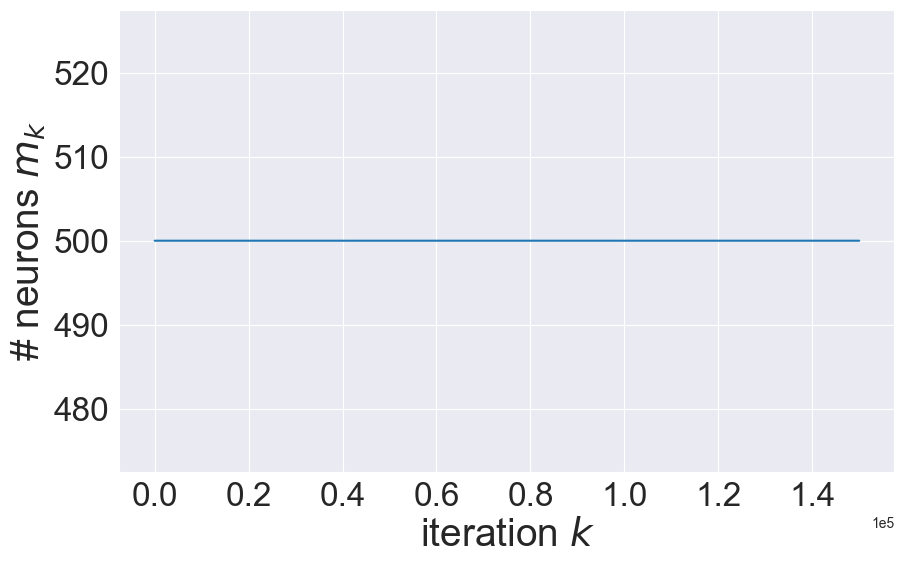

In [36]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms)), ms, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

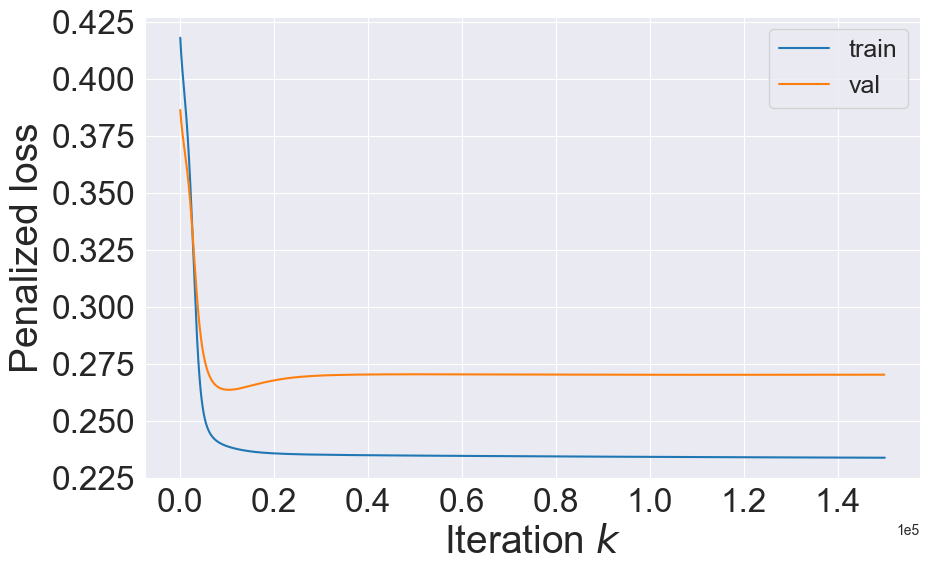

In [37]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_conic)), penalized_train_losses_conic, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses_conic)) for k in range(len(penalized_val_losses_conic))], 
         penalized_val_losses_conic, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

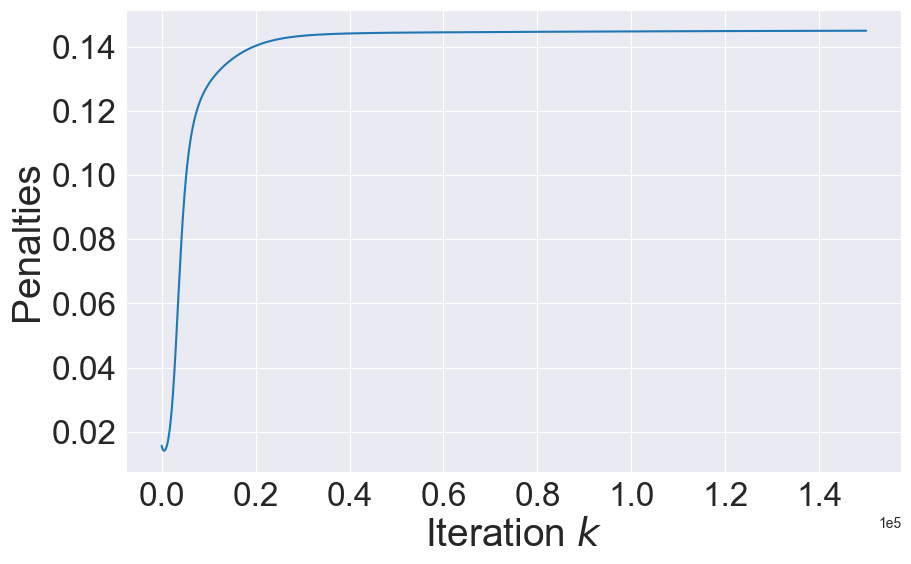

In [38]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses_conic - train_losses_conic

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

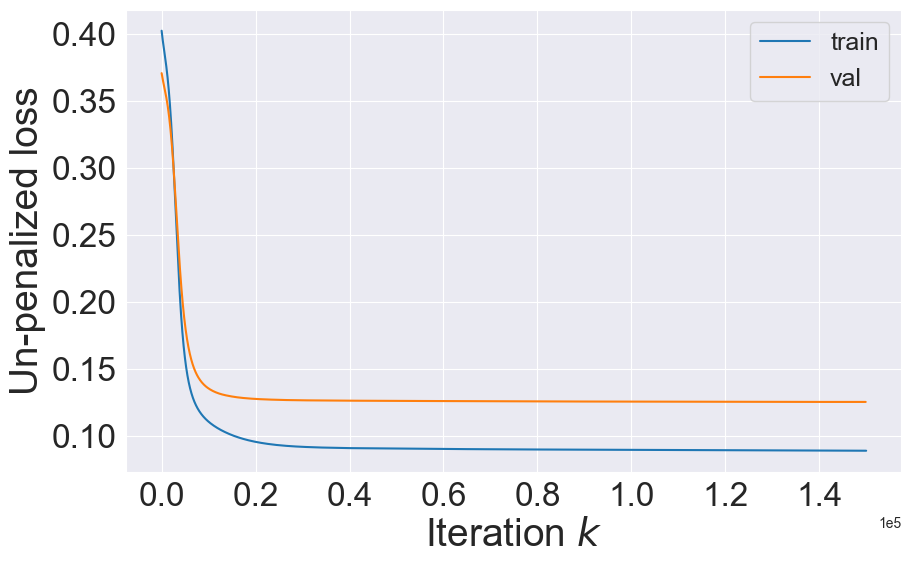

In [39]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_conic)), train_losses_conic, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses_conic)) for k in range(len(val_losses_conic))], val_losses_conic,
         label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 4. Mix $L^2(\tau)/L^2(\tau_m)$ proximal algorithm

Here we mix one step of sampling a new particle and adjusting its weight and one step of chosing an existing particle at random and updating its weight. 

In [40]:
n_steps = N_STEPS
m = 500
ALPHA = 1.0
BETA = 1.0

In [41]:
def update_random_neuron(a, b, x, y, eps=1.0e-9):
    if a.shape[1] > 0:
        j = np.random.randint(low=0, high=a.shape[1])
        b_j = b[j, :].reshape(1, -1)
        V = V_grad(a, b, x, y, b_j) - a[0, j] / BETA 
        new_a = BETA * soft_thresholding(V, tau=LAMBDA)

        if np.abs(new_a) > 0:
            # update weight for neuron b_j
            a[0, j] = new_a  
        else:
            # remove a_j and b_j from the list
            a = np.column_stack((a[:, :j], a[:, j+1:]))
            b = np.row_stack((b[:j, :], b[j+1:, :]))
        #    a[0, j] = 0. 
    return a, b  

In [42]:
def train(n_steps, x_train, y_train, x_val, y_val, do_val=True):
    a = np.array([[]])
    b = np.array([[]])
    ms = [0]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []

    for k in tqdm(range(n_steps)):
        if k % 2 == 0:
            # sample new particle and set weight
            a, b = add_new_neuron(a, b, x_train, y_train, eps=1e-8)
            ms.append(a.shape[1])
            # compute training loss
            train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
            train_losses.append(train_loss)
            penalized_train_losses.append(penalized_train_loss)
        else:
            # update existing particle
            a, b = update_random_neuron(a, b, x_train, y_train, eps=1e-8)
            ms.append(a.shape[1])
            # compute training loss
            train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
            train_losses.append(train_loss)
            penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses) 

In [43]:
a, b, ms, train_losses_mix, penalized_train_losses_mix, val_losses, penalized_val_losses = \
        train(n_steps, x_train, y_train, x_val, y_val)

  0%|                                                     | 165/150000 [00:00<01:31, 1629.24it/s]

m at step 0 : 0
Train loss at step 0 : 0.40201
Validation loss at step 0 : 0.37016
m at step 100 : 25
Train loss at step 100 : 0.39140
Validation loss at step 100 : 0.36038
m at step 200 : 51
Train loss at step 200 : 0.37814
Validation loss at step 200 : 0.34801


  0%|▏                                                    | 642/150000 [00:00<01:17, 1936.64it/s]

m at step 300 : 69
Train loss at step 300 : 0.36754
Validation loss at step 300 : 0.33864
m at step 400 : 84
Train loss at step 400 : 0.35862
Validation loss at step 400 : 0.33074
m at step 500 : 98
Train loss at step 500 : 0.34948
Validation loss at step 500 : 0.32190
m at step 600 : 109
Train loss at step 600 : 0.34285
Validation loss at step 600 : 0.31526
m at step 700 : 117
Train loss at step 700 : 0.33787
Validation loss at step 700 : 0.31083
m at step 800 : 125
Train loss at step 800 : 0.33309
Validation loss at step 800 : 0.30643
m at step 900 : 133
Train loss at step 900 : 0.32842
Validation loss at step 900 : 0.30239


  1%|▍                                                   | 1422/150000 [00:00<01:02, 2392.52it/s]

m at step 1,000 : 138
Train loss at step 1,000 : 0.32441
Validation loss at step 1,000 : 0.29841
m at step 1,100 : 138
Train loss at step 1,100 : 0.32186
Validation loss at step 1,100 : 0.29598
m at step 1,200 : 145
Train loss at step 1,200 : 0.31913
Validation loss at step 1,200 : 0.29361
m at step 1,300 : 150
Train loss at step 1,300 : 0.31569
Validation loss at step 1,300 : 0.29033
m at step 1,400 : 153
Train loss at step 1,400 : 0.31262
Validation loss at step 1,400 : 0.28776
m at step 1,500 : 158
Train loss at step 1,500 : 0.31009
Validation loss at step 1,500 : 0.28535


  1%|▋                                                   | 1922/150000 [00:00<01:01, 2425.94it/s]

m at step 1,600 : 157
Train loss at step 1,600 : 0.30903
Validation loss at step 1,600 : 0.28450
m at step 1,700 : 152
Train loss at step 1,700 : 0.30762
Validation loss at step 1,700 : 0.28295
m at step 1,800 : 149
Train loss at step 1,800 : 0.30622
Validation loss at step 1,800 : 0.28153
m at step 1,900 : 150
Train loss at step 1,900 : 0.30431
Validation loss at step 1,900 : 0.27945
m at step 2,000 : 152
Train loss at step 2,000 : 0.30275
Validation loss at step 2,000 : 0.27833
m at step 2,100 : 152
Train loss at step 2,100 : 0.30103
Validation loss at step 2,100 : 0.27656


  2%|▉                                                   | 2702/150000 [00:01<00:58, 2528.06it/s]

m at step 2,200 : 153
Train loss at step 2,200 : 0.29966
Validation loss at step 2,200 : 0.27549
m at step 2,300 : 156
Train loss at step 2,300 : 0.29809
Validation loss at step 2,300 : 0.27420
m at step 2,400 : 155
Train loss at step 2,400 : 0.29732
Validation loss at step 2,400 : 0.27358
m at step 2,500 : 151
Train loss at step 2,500 : 0.29631
Validation loss at step 2,500 : 0.27276
m at step 2,600 : 149
Train loss at step 2,600 : 0.29476
Validation loss at step 2,600 : 0.27135
m at step 2,700 : 148
Train loss at step 2,700 : 0.29312
Validation loss at step 2,700 : 0.26991


  2%|█                                                   | 3219/150000 [00:01<00:58, 2508.16it/s]

m at step 2,800 : 148
Train loss at step 2,800 : 0.29266
Validation loss at step 2,800 : 0.26951
m at step 2,900 : 149
Train loss at step 2,900 : 0.29162
Validation loss at step 2,900 : 0.26846
m at step 3,000 : 149
Train loss at step 3,000 : 0.29060
Validation loss at step 3,000 : 0.26751
m at step 3,100 : 151
Train loss at step 3,100 : 0.28886
Validation loss at step 3,100 : 0.26599
m at step 3,200 : 152
Train loss at step 3,200 : 0.28764
Validation loss at step 3,200 : 0.26492
m at step 3,300 : 149
Train loss at step 3,300 : 0.28675
Validation loss at step 3,300 : 0.26385


  2%|█▎                                                  | 3734/150000 [00:01<00:57, 2523.90it/s]

m at step 3,400 : 150
Train loss at step 3,400 : 0.28631
Validation loss at step 3,400 : 0.26352
m at step 3,500 : 150
Train loss at step 3,500 : 0.28552
Validation loss at step 3,500 : 0.26292
m at step 3,600 : 150
Train loss at step 3,600 : 0.28438
Validation loss at step 3,600 : 0.26199
m at step 3,700 : 150
Train loss at step 3,700 : 0.28359
Validation loss at step 3,700 : 0.26115
m at step 3,800 : 151
Train loss at step 3,800 : 0.28331
Validation loss at step 3,800 : 0.26101
m at step 3,900 : 151
Train loss at step 3,900 : 0.28257
Validation loss at step 3,900 : 0.26046


  3%|█▌                                                  | 4498/150000 [00:01<00:58, 2507.19it/s]

m at step 4,000 : 154
Train loss at step 4,000 : 0.28146
Validation loss at step 4,000 : 0.25942
m at step 4,100 : 155
Train loss at step 4,100 : 0.28056
Validation loss at step 4,100 : 0.25865
m at step 4,200 : 159
Train loss at step 4,200 : 0.27976
Validation loss at step 4,200 : 0.25770
m at step 4,300 : 161
Train loss at step 4,300 : 0.27873
Validation loss at step 4,300 : 0.25660
m at step 4,400 : 158
Train loss at step 4,400 : 0.27788
Validation loss at step 4,400 : 0.25594


  3%|█▋                                                  | 5015/150000 [00:02<00:56, 2543.72it/s]

m at step 4,500 : 155
Train loss at step 4,500 : 0.27682
Validation loss at step 4,500 : 0.25492
m at step 4,600 : 155
Train loss at step 4,600 : 0.27688
Validation loss at step 4,600 : 0.25490
m at step 4,700 : 154
Train loss at step 4,700 : 0.27607
Validation loss at step 4,700 : 0.25426
m at step 4,800 : 154
Train loss at step 4,800 : 0.27469
Validation loss at step 4,800 : 0.25295
m at step 4,900 : 156
Train loss at step 4,900 : 0.27352
Validation loss at step 4,900 : 0.25188
m at step 5,000 : 155
Train loss at step 5,000 : 0.27329
Validation loss at step 5,000 : 0.25163


  4%|█▉                                                  | 5533/150000 [00:02<00:56, 2560.35it/s]

m at step 5,100 : 156
Train loss at step 5,100 : 0.27312
Validation loss at step 5,100 : 0.25179
m at step 5,200 : 156
Train loss at step 5,200 : 0.27289
Validation loss at step 5,200 : 0.25160
m at step 5,300 : 158
Train loss at step 5,300 : 0.27224
Validation loss at step 5,300 : 0.25087
m at step 5,400 : 155
Train loss at step 5,400 : 0.27175
Validation loss at step 5,400 : 0.25040
m at step 5,500 : 156
Train loss at step 5,500 : 0.27098
Validation loss at step 5,500 : 0.24974
m at step 5,600 : 155
Train loss at step 5,600 : 0.27067
Validation loss at step 5,600 : 0.24940


  4%|██                                                  | 6047/150000 [00:02<00:58, 2457.11it/s]

m at step 5,700 : 152
Train loss at step 5,700 : 0.27055
Validation loss at step 5,700 : 0.24921
m at step 5,800 : 152
Train loss at step 5,800 : 0.26953
Validation loss at step 5,800 : 0.24831
m at step 5,900 : 149
Train loss at step 5,900 : 0.26923
Validation loss at step 5,900 : 0.24805
m at step 6,000 : 148
Train loss at step 6,000 : 0.26847
Validation loss at step 6,000 : 0.24733
m at step 6,100 : 146
Train loss at step 6,100 : 0.26799
Validation loss at step 6,100 : 0.24710


  4%|██▎                                                 | 6566/150000 [00:02<00:56, 2524.26it/s]

m at step 6,200 : 146
Train loss at step 6,200 : 0.26722
Validation loss at step 6,200 : 0.24640
m at step 6,300 : 145
Train loss at step 6,300 : 0.26624
Validation loss at step 6,300 : 0.24577
m at step 6,400 : 145
Train loss at step 6,400 : 0.26660
Validation loss at step 6,400 : 0.24614
m at step 6,500 : 144
Train loss at step 6,500 : 0.26562
Validation loss at step 6,500 : 0.24529
m at step 6,600 : 141
Train loss at step 6,600 : 0.26536
Validation loss at step 6,600 : 0.24514
m at step 6,700 : 138
Train loss at step 6,700 : 0.26524
Validation loss at step 6,700 : 0.24497


  5%|██▍                                                 | 7098/150000 [00:02<00:56, 2551.47it/s]

m at step 6,800 : 137
Train loss at step 6,800 : 0.26472
Validation loss at step 6,800 : 0.24450
m at step 6,900 : 136
Train loss at step 6,900 : 0.26312
Validation loss at step 6,900 : 0.24289
m at step 7,000 : 135
Train loss at step 7,000 : 0.26266
Validation loss at step 7,000 : 0.24229
m at step 7,100 : 136
Train loss at step 7,100 : 0.26239
Validation loss at step 7,100 : 0.24192
m at step 7,200 : 135
Train loss at step 7,200 : 0.26250
Validation loss at step 7,200 : 0.24187
m at step 7,300 : 135
Train loss at step 7,300 : 0.26255
Validation loss at step 7,300 : 0.24210


  5%|██▋                                                 | 7901/150000 [00:03<00:53, 2635.08it/s]

m at step 7,400 : 135
Train loss at step 7,400 : 0.26173
Validation loss at step 7,400 : 0.24143
m at step 7,500 : 134
Train loss at step 7,500 : 0.26089
Validation loss at step 7,500 : 0.24059
m at step 7,600 : 133
Train loss at step 7,600 : 0.26070
Validation loss at step 7,600 : 0.24021
m at step 7,700 : 137
Train loss at step 7,700 : 0.25970
Validation loss at step 7,700 : 0.23935
m at step 7,800 : 136
Train loss at step 7,800 : 0.25903
Validation loss at step 7,800 : 0.23880
m at step 7,900 : 133
Train loss at step 7,900 : 0.25872
Validation loss at step 7,900 : 0.23873


  6%|██▉                                                 | 8474/150000 [00:03<00:51, 2752.51it/s]

m at step 8,000 : 131
Train loss at step 8,000 : 0.25776
Validation loss at step 8,000 : 0.23787
m at step 8,100 : 128
Train loss at step 8,100 : 0.25714
Validation loss at step 8,100 : 0.23756
m at step 8,200 : 126
Train loss at step 8,200 : 0.25692
Validation loss at step 8,200 : 0.23750
m at step 8,300 : 121
Train loss at step 8,300 : 0.25591
Validation loss at step 8,300 : 0.23675
m at step 8,400 : 121
Train loss at step 8,400 : 0.25496
Validation loss at step 8,400 : 0.23607
m at step 8,500 : 120
Train loss at step 8,500 : 0.25461
Validation loss at step 8,500 : 0.23589


  6%|███▏                                                | 9051/150000 [00:03<00:50, 2770.13it/s]

m at step 8,600 : 119
Train loss at step 8,600 : 0.25450
Validation loss at step 8,600 : 0.23612
m at step 8,700 : 120
Train loss at step 8,700 : 0.25403
Validation loss at step 8,700 : 0.23589
m at step 8,800 : 116
Train loss at step 8,800 : 0.25382
Validation loss at step 8,800 : 0.23576
m at step 8,900 : 116
Train loss at step 8,900 : 0.25399
Validation loss at step 8,900 : 0.23597
m at step 9,000 : 116
Train loss at step 9,000 : 0.25406
Validation loss at step 9,000 : 0.23596
m at step 9,100 : 115
Train loss at step 9,100 : 0.25334
Validation loss at step 9,100 : 0.23544


  6%|███▎                                                | 9637/150000 [00:03<00:49, 2855.24it/s]

m at step 9,200 : 115
Train loss at step 9,200 : 0.25293
Validation loss at step 9,200 : 0.23525
m at step 9,300 : 111
Train loss at step 9,300 : 0.25287
Validation loss at step 9,300 : 0.23537
m at step 9,400 : 111
Train loss at step 9,400 : 0.25293
Validation loss at step 9,400 : 0.23575
m at step 9,500 : 110
Train loss at step 9,500 : 0.25232
Validation loss at step 9,500 : 0.23520
m at step 9,600 : 107
Train loss at step 9,600 : 0.25250
Validation loss at step 9,600 : 0.23551
m at step 9,700 : 104
Train loss at step 9,700 : 0.25226
Validation loss at step 9,700 : 0.23562
m at step 9,800 : 102
Train loss at step 9,800 : 0.25185
Validation loss at step 9,800 : 0.23536


  7%|███▍                                               | 10249/150000 [00:04<00:46, 2974.31it/s]

m at step 9,900 : 102
Train loss at step 9,900 : 0.25136
Validation loss at step 9,900 : 0.23504
m at step 10,000 : 100
Train loss at step 10,000 : 0.25150
Validation loss at step 10,000 : 0.23529
m at step 10,100 : 101
Train loss at step 10,100 : 0.25127
Validation loss at step 10,100 : 0.23510
m at step 10,200 : 101
Train loss at step 10,200 : 0.25082
Validation loss at step 10,200 : 0.23474
m at step 10,300 : 101
Train loss at step 10,300 : 0.25072
Validation loss at step 10,300 : 0.23472
m at step 10,400 : 101
Train loss at step 10,400 : 0.25072
Validation loss at step 10,400 : 0.23466
m at step 10,500 : 99
Train loss at step 10,500 : 0.25039
Validation loss at step 10,500 : 0.23441


  7%|███▊                                               | 11228/150000 [00:04<00:43, 3176.13it/s]

m at step 10,600 : 99
Train loss at step 10,600 : 0.24948
Validation loss at step 10,600 : 0.23356
m at step 10,700 : 97
Train loss at step 10,700 : 0.24951
Validation loss at step 10,700 : 0.23360
m at step 10,800 : 96
Train loss at step 10,800 : 0.24948
Validation loss at step 10,800 : 0.23358
m at step 10,900 : 95
Train loss at step 10,900 : 0.24839
Validation loss at step 10,900 : 0.23252
m at step 11,000 : 94
Train loss at step 11,000 : 0.24803
Validation loss at step 11,000 : 0.23235
m at step 11,100 : 94
Train loss at step 11,100 : 0.24810
Validation loss at step 11,100 : 0.23246
m at step 11,200 : 93
Train loss at step 11,200 : 0.24786
Validation loss at step 11,200 : 0.23225


  8%|████                                               | 11916/150000 [00:04<00:41, 3316.48it/s]

m at step 11,300 : 93
Train loss at step 11,300 : 0.24717
Validation loss at step 11,300 : 0.23162
m at step 11,400 : 90
Train loss at step 11,400 : 0.24711
Validation loss at step 11,400 : 0.23155
m at step 11,500 : 88
Train loss at step 11,500 : 0.24620
Validation loss at step 11,500 : 0.23095
m at step 11,600 : 89
Train loss at step 11,600 : 0.24523
Validation loss at step 11,600 : 0.22986
m at step 11,700 : 88
Train loss at step 11,700 : 0.24501
Validation loss at step 11,700 : 0.22975
m at step 11,800 : 87
Train loss at step 11,800 : 0.24515
Validation loss at step 11,800 : 0.22994
m at step 11,900 : 88
Train loss at step 11,900 : 0.24462
Validation loss at step 11,900 : 0.22935
m at step 12,000 : 88
Train loss at step 12,000 : 0.24473
Validation loss at step 12,000 : 0.22962


  8%|████▎                                              | 12592/150000 [00:04<00:41, 3324.97it/s]

m at step 12,100 : 86
Train loss at step 12,100 : 0.24438
Validation loss at step 12,100 : 0.22950
m at step 12,200 : 86
Train loss at step 12,200 : 0.24385
Validation loss at step 12,200 : 0.22891
m at step 12,300 : 85
Train loss at step 12,300 : 0.24328
Validation loss at step 12,300 : 0.22846
m at step 12,400 : 84
Train loss at step 12,400 : 0.24315
Validation loss at step 12,400 : 0.22849
m at step 12,500 : 84
Train loss at step 12,500 : 0.24300
Validation loss at step 12,500 : 0.22844
m at step 12,600 : 81
Train loss at step 12,600 : 0.24297
Validation loss at step 12,600 : 0.22828
m at step 12,700 : 82
Train loss at step 12,700 : 0.24188
Validation loss at step 12,700 : 0.22723


  9%|████▌                                              | 13284/150000 [00:04<00:40, 3393.06it/s]

m at step 12,800 : 84
Train loss at step 12,800 : 0.24175
Validation loss at step 12,800 : 0.22714
m at step 12,900 : 81
Train loss at step 12,900 : 0.24172
Validation loss at step 12,900 : 0.22730
m at step 13,000 : 81
Train loss at step 13,000 : 0.24152
Validation loss at step 13,000 : 0.22704
m at step 13,100 : 83
Train loss at step 13,100 : 0.24124
Validation loss at step 13,100 : 0.22682
m at step 13,200 : 81
Train loss at step 13,200 : 0.24130
Validation loss at step 13,200 : 0.22679
m at step 13,300 : 82
Train loss at step 13,300 : 0.24112
Validation loss at step 13,300 : 0.22662
m at step 13,400 : 83
Train loss at step 13,400 : 0.24038
Validation loss at step 13,400 : 0.22581


  9%|████▊                                              | 13999/150000 [00:05<00:38, 3490.10it/s]

m at step 13,500 : 82
Train loss at step 13,500 : 0.23989
Validation loss at step 13,500 : 0.22539
m at step 13,600 : 81
Train loss at step 13,600 : 0.23946
Validation loss at step 13,600 : 0.22487
m at step 13,700 : 82
Train loss at step 13,700 : 0.23901
Validation loss at step 13,700 : 0.22437
m at step 13,800 : 81
Train loss at step 13,800 : 0.23892
Validation loss at step 13,800 : 0.22414
m at step 13,900 : 81
Train loss at step 13,900 : 0.23904
Validation loss at step 13,900 : 0.22423
m at step 14,000 : 79
Train loss at step 14,000 : 0.23858
Validation loss at step 14,000 : 0.22378
m at step 14,100 : 80
Train loss at step 14,100 : 0.23776
Validation loss at step 14,100 : 0.22292
m at step 14,200 : 80
Train loss at step 14,200 : 0.23792
Validation loss at step 14,200 : 0.22323


 10%|█████                                              | 14728/150000 [00:05<00:37, 3566.01it/s]

m at step 14,300 : 77
Train loss at step 14,300 : 0.23710
Validation loss at step 14,300 : 0.22252
m at step 14,400 : 77
Train loss at step 14,400 : 0.23694
Validation loss at step 14,400 : 0.22243
m at step 14,500 : 77
Train loss at step 14,500 : 0.23695
Validation loss at step 14,500 : 0.22235
m at step 14,600 : 75
Train loss at step 14,600 : 0.23701
Validation loss at step 14,600 : 0.22232
m at step 14,700 : 75
Train loss at step 14,700 : 0.23697
Validation loss at step 14,700 : 0.22238
m at step 14,800 : 74
Train loss at step 14,800 : 0.23650
Validation loss at step 14,800 : 0.22183
m at step 14,900 : 74
Train loss at step 14,900 : 0.23647
Validation loss at step 14,900 : 0.22183
m at step 15,000 : 74
Train loss at step 15,000 : 0.23672
Validation loss at step 15,000 : 0.22193


 11%|█████▍                                             | 15836/150000 [00:05<00:36, 3648.12it/s]

m at step 15,100 : 74
Train loss at step 15,100 : 0.23643
Validation loss at step 15,100 : 0.22154
m at step 15,200 : 74
Train loss at step 15,200 : 0.23604
Validation loss at step 15,200 : 0.22110
m at step 15,300 : 72
Train loss at step 15,300 : 0.23586
Validation loss at step 15,300 : 0.22085
m at step 15,400 : 72
Train loss at step 15,400 : 0.23536
Validation loss at step 15,400 : 0.22033
m at step 15,500 : 71
Train loss at step 15,500 : 0.23511
Validation loss at step 15,500 : 0.22002
m at step 15,600 : 70
Train loss at step 15,600 : 0.23494
Validation loss at step 15,600 : 0.21980
m at step 15,700 : 69
Train loss at step 15,700 : 0.23424
Validation loss at step 15,700 : 0.21910
m at step 15,800 : 68
Train loss at step 15,800 : 0.23404
Validation loss at step 15,800 : 0.21878


 11%|█████▋                                             | 16597/150000 [00:05<00:35, 3712.06it/s]

m at step 15,900 : 68
Train loss at step 15,900 : 0.23372
Validation loss at step 15,900 : 0.21840
m at step 16,000 : 68
Train loss at step 16,000 : 0.23369
Validation loss at step 16,000 : 0.21825
m at step 16,100 : 67
Train loss at step 16,100 : 0.23345
Validation loss at step 16,100 : 0.21791
m at step 16,200 : 66
Train loss at step 16,200 : 0.23295
Validation loss at step 16,200 : 0.21735
m at step 16,300 : 66
Train loss at step 16,300 : 0.23285
Validation loss at step 16,300 : 0.21701
m at step 16,400 : 65
Train loss at step 16,400 : 0.23297
Validation loss at step 16,400 : 0.21705
m at step 16,500 : 64
Train loss at step 16,500 : 0.23260
Validation loss at step 16,500 : 0.21658
m at step 16,600 : 64
Train loss at step 16,600 : 0.23223
Validation loss at step 16,600 : 0.21616


 12%|█████▉                                             | 17386/150000 [00:06<00:34, 3823.39it/s]

m at step 16,700 : 64
Train loss at step 16,700 : 0.23209
Validation loss at step 16,700 : 0.21594
m at step 16,800 : 64
Train loss at step 16,800 : 0.23160
Validation loss at step 16,800 : 0.21542
m at step 16,900 : 64
Train loss at step 16,900 : 0.23133
Validation loss at step 16,900 : 0.21513
m at step 17,000 : 64
Train loss at step 17,000 : 0.23147
Validation loss at step 17,000 : 0.21512
m at step 17,100 : 64
Train loss at step 17,100 : 0.23146
Validation loss at step 17,100 : 0.21510
m at step 17,200 : 63
Train loss at step 17,200 : 0.23152
Validation loss at step 17,200 : 0.21500
m at step 17,300 : 63
Train loss at step 17,300 : 0.23143
Validation loss at step 17,300 : 0.21484
m at step 17,400 : 61
Train loss at step 17,400 : 0.23155
Validation loss at step 17,400 : 0.21490
m at step 17,500 : 61
Train loss at step 17,500 : 0.23101
Validation loss at step 17,500 : 0.21432


 12%|██████▏                                            | 18182/150000 [00:06<00:33, 3902.12it/s]

m at step 17,600 : 60
Train loss at step 17,600 : 0.23133
Validation loss at step 17,600 : 0.21458
m at step 17,700 : 60
Train loss at step 17,700 : 0.23142
Validation loss at step 17,700 : 0.21452
m at step 17,800 : 60
Train loss at step 17,800 : 0.23135
Validation loss at step 17,800 : 0.21448
m at step 17,900 : 59
Train loss at step 17,900 : 0.23102
Validation loss at step 17,900 : 0.21415
m at step 18,000 : 60
Train loss at step 18,000 : 0.23032
Validation loss at step 18,000 : 0.21354
m at step 18,100 : 59
Train loss at step 18,100 : 0.22970
Validation loss at step 18,100 : 0.21287
m at step 18,200 : 60
Train loss at step 18,200 : 0.22978
Validation loss at step 18,200 : 0.21291
m at step 18,300 : 59
Train loss at step 18,300 : 0.22954
Validation loss at step 18,300 : 0.21275
m at step 18,400 : 58
Train loss at step 18,400 : 0.22923
Validation loss at step 18,400 : 0.21248


 13%|██████▍                                            | 18995/150000 [00:06<00:32, 3987.76it/s]

m at step 18,500 : 57
Train loss at step 18,500 : 0.22886
Validation loss at step 18,500 : 0.21202
m at step 18,600 : 55
Train loss at step 18,600 : 0.22918
Validation loss at step 18,600 : 0.21225
m at step 18,700 : 55
Train loss at step 18,700 : 0.22869
Validation loss at step 18,700 : 0.21189
m at step 18,800 : 55
Train loss at step 18,800 : 0.22836
Validation loss at step 18,800 : 0.21157
m at step 18,900 : 54
Train loss at step 18,900 : 0.22817
Validation loss at step 18,900 : 0.21137
m at step 19,000 : 53
Train loss at step 19,000 : 0.22774
Validation loss at step 19,000 : 0.21096
m at step 19,100 : 53
Train loss at step 19,100 : 0.22743
Validation loss at step 19,100 : 0.21064
m at step 19,200 : 53
Train loss at step 19,200 : 0.22732
Validation loss at step 19,200 : 0.21059
m at step 19,300 : 54
Train loss at step 19,300 : 0.22676
Validation loss at step 19,300 : 0.21009


 13%|██████▉                                            | 20224/150000 [00:06<00:31, 4060.71it/s]

m at step 19,400 : 52
Train loss at step 19,400 : 0.22678
Validation loss at step 19,400 : 0.21004
m at step 19,500 : 52
Train loss at step 19,500 : 0.22703
Validation loss at step 19,500 : 0.21028
m at step 19,600 : 51
Train loss at step 19,600 : 0.22718
Validation loss at step 19,600 : 0.21030
m at step 19,700 : 50
Train loss at step 19,700 : 0.22683
Validation loss at step 19,700 : 0.21003
m at step 19,800 : 50
Train loss at step 19,800 : 0.22651
Validation loss at step 19,800 : 0.20979
m at step 19,900 : 50
Train loss at step 19,900 : 0.22663
Validation loss at step 19,900 : 0.20977
m at step 20,000 : 51
Train loss at step 20,000 : 0.22638
Validation loss at step 20,000 : 0.20945
m at step 20,100 : 52
Train loss at step 20,100 : 0.22599
Validation loss at step 20,100 : 0.20921
m at step 20,200 : 52
Train loss at step 20,200 : 0.22559
Validation loss at step 20,200 : 0.20895


 14%|███████▏                                           | 21062/150000 [00:06<00:31, 4115.73it/s]

m at step 20,300 : 52
Train loss at step 20,300 : 0.22554
Validation loss at step 20,300 : 0.20891
m at step 20,400 : 51
Train loss at step 20,400 : 0.22530
Validation loss at step 20,400 : 0.20856
m at step 20,500 : 50
Train loss at step 20,500 : 0.22531
Validation loss at step 20,500 : 0.20851
m at step 20,600 : 50
Train loss at step 20,600 : 0.22518
Validation loss at step 20,600 : 0.20851
m at step 20,700 : 50
Train loss at step 20,700 : 0.22520
Validation loss at step 20,700 : 0.20852
m at step 20,800 : 50
Train loss at step 20,800 : 0.22516
Validation loss at step 20,800 : 0.20848
m at step 20,900 : 49
Train loss at step 20,900 : 0.22479
Validation loss at step 20,900 : 0.20821
m at step 21,000 : 48
Train loss at step 21,000 : 0.22477
Validation loss at step 21,000 : 0.20829
m at step 21,100 : 49
Train loss at step 21,100 : 0.22465
Validation loss at step 21,100 : 0.20826


 15%|███████▍                                           | 21903/150000 [00:07<00:30, 4166.19it/s]

m at step 21,200 : 49
Train loss at step 21,200 : 0.22449
Validation loss at step 21,200 : 0.20810
m at step 21,300 : 49
Train loss at step 21,300 : 0.22404
Validation loss at step 21,300 : 0.20771
m at step 21,400 : 49
Train loss at step 21,400 : 0.22402
Validation loss at step 21,400 : 0.20768
m at step 21,500 : 48
Train loss at step 21,500 : 0.22373
Validation loss at step 21,500 : 0.20744
m at step 21,600 : 47
Train loss at step 21,600 : 0.22393
Validation loss at step 21,600 : 0.20755
m at step 21,700 : 47
Train loss at step 21,700 : 0.22359
Validation loss at step 21,700 : 0.20718
m at step 21,800 : 47
Train loss at step 21,800 : 0.22317
Validation loss at step 21,800 : 0.20668
m at step 21,900 : 45
Train loss at step 21,900 : 0.22295
Validation loss at step 21,900 : 0.20646
m at step 22,000 : 45
Train loss at step 22,000 : 0.22273
Validation loss at step 22,000 : 0.20615


 15%|███████▋                                           | 22754/150000 [00:07<00:30, 4215.55it/s]

m at step 22,100 : 46
Train loss at step 22,100 : 0.22276
Validation loss at step 22,100 : 0.20609
m at step 22,200 : 46
Train loss at step 22,200 : 0.22263
Validation loss at step 22,200 : 0.20600
m at step 22,300 : 46
Train loss at step 22,300 : 0.22259
Validation loss at step 22,300 : 0.20595
m at step 22,400 : 46
Train loss at step 22,400 : 0.22234
Validation loss at step 22,400 : 0.20559
m at step 22,500 : 46
Train loss at step 22,500 : 0.22254
Validation loss at step 22,500 : 0.20568
m at step 22,600 : 46
Train loss at step 22,600 : 0.22246
Validation loss at step 22,600 : 0.20567
m at step 22,700 : 46
Train loss at step 22,700 : 0.22239
Validation loss at step 22,700 : 0.20560
m at step 22,800 : 47
Train loss at step 22,800 : 0.22244
Validation loss at step 22,800 : 0.20564
m at step 22,900 : 47
Train loss at step 22,900 : 0.22229
Validation loss at step 22,900 : 0.20554


 16%|████████                                           | 23608/150000 [00:07<00:30, 4182.33it/s]

m at step 23,000 : 47
Train loss at step 23,000 : 0.22182
Validation loss at step 23,000 : 0.20515
m at step 23,100 : 46
Train loss at step 23,100 : 0.22178
Validation loss at step 23,100 : 0.20513
m at step 23,200 : 45
Train loss at step 23,200 : 0.22193
Validation loss at step 23,200 : 0.20525
m at step 23,300 : 45
Train loss at step 23,300 : 0.22179
Validation loss at step 23,300 : 0.20513
m at step 23,400 : 45
Train loss at step 23,400 : 0.22136
Validation loss at step 23,400 : 0.20480
m at step 23,500 : 45
Train loss at step 23,500 : 0.22124
Validation loss at step 23,500 : 0.20461
m at step 23,600 : 44
Train loss at step 23,600 : 0.22091
Validation loss at step 23,600 : 0.20429
m at step 23,700 : 45
Train loss at step 23,700 : 0.22088
Validation loss at step 23,700 : 0.20423
m at step 23,800 : 44
Train loss at step 23,800 : 0.22096
Validation loss at step 23,800 : 0.20441


 16%|████████▎                                          | 24447/150000 [00:07<00:30, 4112.55it/s]

m at step 23,900 : 44
Train loss at step 23,900 : 0.22096
Validation loss at step 23,900 : 0.20438
m at step 24,000 : 44
Train loss at step 24,000 : 0.22100
Validation loss at step 24,000 : 0.20439
m at step 24,100 : 44
Train loss at step 24,100 : 0.22113
Validation loss at step 24,100 : 0.20454
m at step 24,200 : 44
Train loss at step 24,200 : 0.22116
Validation loss at step 24,200 : 0.20458
m at step 24,300 : 44
Train loss at step 24,300 : 0.22073
Validation loss at step 24,300 : 0.20431
m at step 24,400 : 44
Train loss at step 24,400 : 0.22073
Validation loss at step 24,400 : 0.20437
m at step 24,500 : 44
Train loss at step 24,500 : 0.22032
Validation loss at step 24,500 : 0.20396
m at step 24,600 : 44
Train loss at step 24,600 : 0.22021
Validation loss at step 24,600 : 0.20378
m at step 24,700 : 44
Train loss at step 24,700 : 0.21997
Validation loss at step 24,700 : 0.20364


 17%|████████▌                                          | 25295/150000 [00:07<00:29, 4177.18it/s]

m at step 24,800 : 46
Train loss at step 24,800 : 0.21994
Validation loss at step 24,800 : 0.20366
m at step 24,900 : 45
Train loss at step 24,900 : 0.21981
Validation loss at step 24,900 : 0.20358
m at step 25,000 : 44
Train loss at step 25,000 : 0.21960
Validation loss at step 25,000 : 0.20330
m at step 25,100 : 44
Train loss at step 25,100 : 0.21927
Validation loss at step 25,100 : 0.20304
m at step 25,200 : 43
Train loss at step 25,200 : 0.21917
Validation loss at step 25,200 : 0.20306
m at step 25,300 : 43
Train loss at step 25,300 : 0.21874
Validation loss at step 25,300 : 0.20284
m at step 25,400 : 42
Train loss at step 25,400 : 0.21841
Validation loss at step 25,400 : 0.20265
m at step 25,500 : 42
Train loss at step 25,500 : 0.21815
Validation loss at step 25,500 : 0.20248


 17%|████████▉                                          | 26115/150000 [00:08<00:31, 3935.73it/s]

m at step 25,600 : 42
Train loss at step 25,600 : 0.21830
Validation loss at step 25,600 : 0.20265
m at step 25,700 : 42
Train loss at step 25,700 : 0.21800
Validation loss at step 25,700 : 0.20244
m at step 25,800 : 42
Train loss at step 25,800 : 0.21792
Validation loss at step 25,800 : 0.20234
m at step 25,900 : 42
Train loss at step 25,900 : 0.21777
Validation loss at step 25,900 : 0.20228
m at step 26,000 : 42
Train loss at step 26,000 : 0.21760
Validation loss at step 26,000 : 0.20211
m at step 26,100 : 41
Train loss at step 26,100 : 0.21760
Validation loss at step 26,100 : 0.20225
m at step 26,200 : 41
Train loss at step 26,200 : 0.21742
Validation loss at step 26,200 : 0.20217
m at step 26,300 : 41
Train loss at step 26,300 : 0.21755
Validation loss at step 26,300 : 0.20237
m at step 26,400 : 41
Train loss at step 26,400 : 0.21727
Validation loss at step 26,400 : 0.20209


 18%|█████████▏                                         | 27008/150000 [00:08<00:29, 4209.36it/s]

m at step 26,500 : 41
Train loss at step 26,500 : 0.21723
Validation loss at step 26,500 : 0.20211
m at step 26,600 : 41
Train loss at step 26,600 : 0.21711
Validation loss at step 26,600 : 0.20203
m at step 26,700 : 40
Train loss at step 26,700 : 0.21714
Validation loss at step 26,700 : 0.20217
m at step 26,800 : 40
Train loss at step 26,800 : 0.21721
Validation loss at step 26,800 : 0.20227
m at step 26,900 : 39
Train loss at step 26,900 : 0.21709
Validation loss at step 26,900 : 0.20219
m at step 27,000 : 39
Train loss at step 27,000 : 0.21687
Validation loss at step 27,000 : 0.20203
m at step 27,100 : 38
Train loss at step 27,100 : 0.21679
Validation loss at step 27,100 : 0.20205
m at step 27,200 : 38
Train loss at step 27,200 : 0.21678
Validation loss at step 27,200 : 0.20212
m at step 27,300 : 38
Train loss at step 27,300 : 0.21649
Validation loss at step 27,300 : 0.20188
m at step 27,400 : 38
Train loss at step 27,400 : 0.21621
Validation loss at step 27,400 : 0.20168


 19%|█████████▋                                         | 28327/150000 [00:08<00:28, 4245.01it/s]

m at step 27,500 : 38
Train loss at step 27,500 : 0.21639
Validation loss at step 27,500 : 0.20188
m at step 27,600 : 38
Train loss at step 27,600 : 0.21656
Validation loss at step 27,600 : 0.20206
m at step 27,700 : 40
Train loss at step 27,700 : 0.21666
Validation loss at step 27,700 : 0.20217
m at step 27,800 : 40
Train loss at step 27,800 : 0.21632
Validation loss at step 27,800 : 0.20189
m at step 27,900 : 40
Train loss at step 27,900 : 0.21608
Validation loss at step 27,900 : 0.20173
m at step 28,000 : 40
Train loss at step 28,000 : 0.21588
Validation loss at step 28,000 : 0.20151
m at step 28,100 : 39
Train loss at step 28,100 : 0.21594
Validation loss at step 28,100 : 0.20152
m at step 28,200 : 39
Train loss at step 28,200 : 0.21584
Validation loss at step 28,200 : 0.20148
m at step 28,300 : 39
Train loss at step 28,300 : 0.21592
Validation loss at step 28,300 : 0.20152


 19%|█████████▉                                         | 29193/150000 [00:08<00:28, 4280.72it/s]

m at step 28,400 : 39
Train loss at step 28,400 : 0.21583
Validation loss at step 28,400 : 0.20141
m at step 28,500 : 39
Train loss at step 28,500 : 0.21565
Validation loss at step 28,500 : 0.20129
m at step 28,600 : 39
Train loss at step 28,600 : 0.21535
Validation loss at step 28,600 : 0.20100
m at step 28,700 : 38
Train loss at step 28,700 : 0.21519
Validation loss at step 28,700 : 0.20088
m at step 28,800 : 37
Train loss at step 28,800 : 0.21525
Validation loss at step 28,800 : 0.20095
m at step 28,900 : 37
Train loss at step 28,900 : 0.21510
Validation loss at step 28,900 : 0.20088
m at step 29,000 : 37
Train loss at step 29,000 : 0.21519
Validation loss at step 29,000 : 0.20096
m at step 29,100 : 37
Train loss at step 29,100 : 0.21523
Validation loss at step 29,100 : 0.20105
m at step 29,200 : 37
Train loss at step 29,200 : 0.21533
Validation loss at step 29,200 : 0.20111


 20%|██████████▏                                        | 30088/150000 [00:09<00:27, 4376.28it/s]

m at step 29,300 : 37
Train loss at step 29,300 : 0.21526
Validation loss at step 29,300 : 0.20106
m at step 29,400 : 37
Train loss at step 29,400 : 0.21506
Validation loss at step 29,400 : 0.20091
m at step 29,500 : 37
Train loss at step 29,500 : 0.21516
Validation loss at step 29,500 : 0.20104
m at step 29,600 : 37
Train loss at step 29,600 : 0.21500
Validation loss at step 29,600 : 0.20090
m at step 29,700 : 37
Train loss at step 29,700 : 0.21509
Validation loss at step 29,700 : 0.20098
m at step 29,800 : 38
Train loss at step 29,800 : 0.21508
Validation loss at step 29,800 : 0.20104
m at step 29,900 : 38
Train loss at step 29,900 : 0.21501
Validation loss at step 29,900 : 0.20099
m at step 30,000 : 38
Train loss at step 30,000 : 0.21502
Validation loss at step 30,000 : 0.20100
m at step 30,100 : 38
Train loss at step 30,100 : 0.21520
Validation loss at step 30,100 : 0.20121
m at step 30,200 : 37
Train loss at step 30,200 : 0.21501
Validation loss at step 30,200 : 0.20108


 21%|██████████▌                                        | 30972/150000 [00:09<00:27, 4371.08it/s]

m at step 30,300 : 37
Train loss at step 30,300 : 0.21493
Validation loss at step 30,300 : 0.20105
m at step 30,400 : 38
Train loss at step 30,400 : 0.21474
Validation loss at step 30,400 : 0.20094
m at step 30,500 : 38
Train loss at step 30,500 : 0.21474
Validation loss at step 30,500 : 0.20102
m at step 30,600 : 38
Train loss at step 30,600 : 0.21462
Validation loss at step 30,600 : 0.20097
m at step 30,700 : 38
Train loss at step 30,700 : 0.21467
Validation loss at step 30,700 : 0.20104
m at step 30,800 : 38
Train loss at step 30,800 : 0.21447
Validation loss at step 30,800 : 0.20089
m at step 30,900 : 38
Train loss at step 30,900 : 0.21446
Validation loss at step 30,900 : 0.20092
m at step 31,000 : 37
Train loss at step 31,000 : 0.21443
Validation loss at step 31,000 : 0.20091
m at step 31,100 : 37
Train loss at step 31,100 : 0.21438
Validation loss at step 31,100 : 0.20094


 21%|██████████▊                                        | 31854/150000 [00:09<00:28, 4183.28it/s]

m at step 31,200 : 37
Train loss at step 31,200 : 0.21433
Validation loss at step 31,200 : 0.20095
m at step 31,300 : 37
Train loss at step 31,300 : 0.21420
Validation loss at step 31,300 : 0.20081
m at step 31,400 : 37
Train loss at step 31,400 : 0.21412
Validation loss at step 31,400 : 0.20076
m at step 31,500 : 37
Train loss at step 31,500 : 0.21402
Validation loss at step 31,500 : 0.20068
m at step 31,600 : 36
Train loss at step 31,600 : 0.21413
Validation loss at step 31,600 : 0.20082
m at step 31,700 : 36
Train loss at step 31,700 : 0.21407
Validation loss at step 31,700 : 0.20085
m at step 31,800 : 36
Train loss at step 31,800 : 0.21415
Validation loss at step 31,800 : 0.20096
m at step 31,900 : 36
Train loss at step 31,900 : 0.21416
Validation loss at step 31,900 : 0.20103


 22%|███████████                                        | 32720/150000 [00:09<00:27, 4251.33it/s]

m at step 32,000 : 36
Train loss at step 32,000 : 0.21407
Validation loss at step 32,000 : 0.20099
m at step 32,100 : 36
Train loss at step 32,100 : 0.21409
Validation loss at step 32,100 : 0.20103
m at step 32,200 : 36
Train loss at step 32,200 : 0.21418
Validation loss at step 32,200 : 0.20113
m at step 32,300 : 36
Train loss at step 32,300 : 0.21404
Validation loss at step 32,300 : 0.20100
m at step 32,400 : 36
Train loss at step 32,400 : 0.21390
Validation loss at step 32,400 : 0.20088
m at step 32,500 : 36
Train loss at step 32,500 : 0.21390
Validation loss at step 32,500 : 0.20090
m at step 32,600 : 35
Train loss at step 32,600 : 0.21398
Validation loss at step 32,600 : 0.20100
m at step 32,700 : 35
Train loss at step 32,700 : 0.21395
Validation loss at step 32,700 : 0.20097
m at step 32,800 : 34
Train loss at step 32,800 : 0.21394
Validation loss at step 32,800 : 0.20097
m at step 32,900 : 34
Train loss at step 32,900 : 0.21386
Validation loss at step 32,900 : 0.20089


 22%|███████████▍                                       | 33656/150000 [00:09<00:25, 4478.52it/s]

m at step 33,000 : 34
Train loss at step 33,000 : 0.21389
Validation loss at step 33,000 : 0.20093
m at step 33,100 : 34
Train loss at step 33,100 : 0.21396
Validation loss at step 33,100 : 0.20102
m at step 33,200 : 34
Train loss at step 33,200 : 0.21400
Validation loss at step 33,200 : 0.20102
m at step 33,300 : 34
Train loss at step 33,300 : 0.21387
Validation loss at step 33,300 : 0.20094
m at step 33,400 : 34
Train loss at step 33,400 : 0.21383
Validation loss at step 33,400 : 0.20090
m at step 33,500 : 34
Train loss at step 33,500 : 0.21377
Validation loss at step 33,500 : 0.20077
m at step 33,600 : 34
Train loss at step 33,600 : 0.21371
Validation loss at step 33,600 : 0.20068
m at step 33,700 : 34
Train loss at step 33,700 : 0.21370
Validation loss at step 33,700 : 0.20070
m at step 33,800 : 34
Train loss at step 33,800 : 0.21367
Validation loss at step 33,800 : 0.20071
m at step 33,900 : 34
Train loss at step 33,900 : 0.21377
Validation loss at step 33,900 : 0.20082


 23%|███████████▊                                       | 34581/150000 [00:10<00:25, 4500.55it/s]

m at step 34,000 : 34
Train loss at step 34,000 : 0.21369
Validation loss at step 34,000 : 0.20074
m at step 34,100 : 34
Train loss at step 34,100 : 0.21372
Validation loss at step 34,100 : 0.20080
m at step 34,200 : 33
Train loss at step 34,200 : 0.21376
Validation loss at step 34,200 : 0.20086
m at step 34,300 : 33
Train loss at step 34,300 : 0.21377
Validation loss at step 34,300 : 0.20087
m at step 34,400 : 33
Train loss at step 34,400 : 0.21368
Validation loss at step 34,400 : 0.20075
m at step 34,500 : 33
Train loss at step 34,500 : 0.21370
Validation loss at step 34,500 : 0.20079
m at step 34,600 : 33
Train loss at step 34,600 : 0.21372
Validation loss at step 34,600 : 0.20084
m at step 34,700 : 33
Train loss at step 34,700 : 0.21377
Validation loss at step 34,700 : 0.20087
m at step 34,800 : 33
Train loss at step 34,800 : 0.21368
Validation loss at step 34,800 : 0.20079
m at step 34,900 : 33
Train loss at step 34,900 : 0.21363
Validation loss at step 34,900 : 0.20073


 24%|████████████                                       | 35525/150000 [00:10<00:24, 4622.21it/s]

m at step 35,000 : 33
Train loss at step 35,000 : 0.21364
Validation loss at step 35,000 : 0.20074
m at step 35,100 : 33
Train loss at step 35,100 : 0.21362
Validation loss at step 35,100 : 0.20074
m at step 35,200 : 33
Train loss at step 35,200 : 0.21351
Validation loss at step 35,200 : 0.20064
m at step 35,300 : 33
Train loss at step 35,300 : 0.21352
Validation loss at step 35,300 : 0.20067
m at step 35,400 : 32
Train loss at step 35,400 : 0.21352
Validation loss at step 35,400 : 0.20070
m at step 35,500 : 32
Train loss at step 35,500 : 0.21350
Validation loss at step 35,500 : 0.20063
m at step 35,600 : 32
Train loss at step 35,600 : 0.21353
Validation loss at step 35,600 : 0.20068
m at step 35,700 : 32
Train loss at step 35,700 : 0.21343
Validation loss at step 35,700 : 0.20059
m at step 35,800 : 32
Train loss at step 35,800 : 0.21335
Validation loss at step 35,800 : 0.20050
m at step 35,900 : 32
Train loss at step 35,900 : 0.21337
Validation loss at step 35,900 : 0.20048
m at step 

 25%|████████████▌                                      | 36978/150000 [00:10<00:23, 4734.33it/s]

m at step 36,100 : 31
Train loss at step 36,100 : 0.21333
Validation loss at step 36,100 : 0.20045
m at step 36,200 : 31
Train loss at step 36,200 : 0.21329
Validation loss at step 36,200 : 0.20043
m at step 36,300 : 31
Train loss at step 36,300 : 0.21322
Validation loss at step 36,300 : 0.20036
m at step 36,400 : 31
Train loss at step 36,400 : 0.21328
Validation loss at step 36,400 : 0.20038
m at step 36,500 : 31
Train loss at step 36,500 : 0.21328
Validation loss at step 36,500 : 0.20040
m at step 36,600 : 31
Train loss at step 36,600 : 0.21324
Validation loss at step 36,600 : 0.20034
m at step 36,700 : 31
Train loss at step 36,700 : 0.21330
Validation loss at step 36,700 : 0.20032
m at step 36,800 : 31
Train loss at step 36,800 : 0.21320
Validation loss at step 36,800 : 0.20017
m at step 36,900 : 31
Train loss at step 36,900 : 0.21315
Validation loss at step 36,900 : 0.20013
m at step 37,000 : 31
Train loss at step 37,000 : 0.21316
Validation loss at step 37,000 : 0.20013


 25%|████████████▉                                      | 37928/150000 [00:10<00:24, 4658.33it/s]

m at step 37,100 : 31
Train loss at step 37,100 : 0.21314
Validation loss at step 37,100 : 0.20011
m at step 37,200 : 31
Train loss at step 37,200 : 0.21307
Validation loss at step 37,200 : 0.20006
m at step 37,300 : 31
Train loss at step 37,300 : 0.21314
Validation loss at step 37,300 : 0.20013
m at step 37,400 : 31
Train loss at step 37,400 : 0.21322
Validation loss at step 37,400 : 0.20019
m at step 37,500 : 31
Train loss at step 37,500 : 0.21331
Validation loss at step 37,500 : 0.20027
m at step 37,600 : 31
Train loss at step 37,600 : 0.21331
Validation loss at step 37,600 : 0.20030
m at step 37,700 : 31
Train loss at step 37,700 : 0.21320
Validation loss at step 37,700 : 0.20017
m at step 37,800 : 31
Train loss at step 37,800 : 0.21324
Validation loss at step 37,800 : 0.20022
m at step 37,900 : 31
Train loss at step 37,900 : 0.21322
Validation loss at step 37,900 : 0.20024
m at step 38,000 : 31
Train loss at step 38,000 : 0.21321
Validation loss at step 38,000 : 0.20021


 26%|█████████████▏                                     | 38889/150000 [00:11<00:23, 4736.93it/s]

m at step 38,100 : 31
Train loss at step 38,100 : 0.21315
Validation loss at step 38,100 : 0.20017
m at step 38,200 : 31
Train loss at step 38,200 : 0.21310
Validation loss at step 38,200 : 0.20011
m at step 38,300 : 31
Train loss at step 38,300 : 0.21303
Validation loss at step 38,300 : 0.20005
m at step 38,400 : 31
Train loss at step 38,400 : 0.21307
Validation loss at step 38,400 : 0.20006
m at step 38,500 : 31
Train loss at step 38,500 : 0.21321
Validation loss at step 38,500 : 0.20021
m at step 38,600 : 31
Train loss at step 38,600 : 0.21317
Validation loss at step 38,600 : 0.20017
m at step 38,700 : 31
Train loss at step 38,700 : 0.21308
Validation loss at step 38,700 : 0.20012
m at step 38,800 : 32
Train loss at step 38,800 : 0.21300
Validation loss at step 38,800 : 0.20010
m at step 38,900 : 32
Train loss at step 38,900 : 0.21300
Validation loss at step 38,900 : 0.20011
m at step 39,000 : 32
Train loss at step 39,000 : 0.21283
Validation loss at step 39,000 : 0.19995


 27%|█████████████▌                                     | 39867/150000 [00:11<00:23, 4735.70it/s]

m at step 39,100 : 32
Train loss at step 39,100 : 0.21272
Validation loss at step 39,100 : 0.19984
m at step 39,200 : 32
Train loss at step 39,200 : 0.21277
Validation loss at step 39,200 : 0.19987
m at step 39,300 : 32
Train loss at step 39,300 : 0.21285
Validation loss at step 39,300 : 0.19994
m at step 39,400 : 31
Train loss at step 39,400 : 0.21269
Validation loss at step 39,400 : 0.19983
m at step 39,500 : 31
Train loss at step 39,500 : 0.21267
Validation loss at step 39,500 : 0.19981
m at step 39,600 : 31
Train loss at step 39,600 : 0.21253
Validation loss at step 39,600 : 0.19968
m at step 39,700 : 31
Train loss at step 39,700 : 0.21252
Validation loss at step 39,700 : 0.19969
m at step 39,800 : 31
Train loss at step 39,800 : 0.21233
Validation loss at step 39,800 : 0.19952
m at step 39,900 : 31
Train loss at step 39,900 : 0.21223
Validation loss at step 39,900 : 0.19944
m at step 40,000 : 31
Train loss at step 40,000 : 0.21216
Validation loss at step 40,000 : 0.19939


 27%|█████████████▉                                     | 40840/150000 [00:11<00:22, 4799.49it/s]

m at step 40,100 : 31
Train loss at step 40,100 : 0.21206
Validation loss at step 40,100 : 0.19927
m at step 40,200 : 31
Train loss at step 40,200 : 0.21188
Validation loss at step 40,200 : 0.19908
m at step 40,300 : 31
Train loss at step 40,300 : 0.21204
Validation loss at step 40,300 : 0.19923
m at step 40,400 : 31
Train loss at step 40,400 : 0.21208
Validation loss at step 40,400 : 0.19929
m at step 40,500 : 31
Train loss at step 40,500 : 0.21202
Validation loss at step 40,500 : 0.19923
m at step 40,600 : 32
Train loss at step 40,600 : 0.21201
Validation loss at step 40,600 : 0.19922
m at step 40,700 : 32
Train loss at step 40,700 : 0.21203
Validation loss at step 40,700 : 0.19924
m at step 40,800 : 33
Train loss at step 40,800 : 0.21199
Validation loss at step 40,800 : 0.19919
m at step 40,900 : 33
Train loss at step 40,900 : 0.21198
Validation loss at step 40,900 : 0.19917
m at step 41,000 : 33
Train loss at step 41,000 : 0.21196
Validation loss at step 41,000 : 0.19914


 28%|██████████████▏                                    | 41802/150000 [00:11<00:22, 4788.17it/s]

m at step 41,100 : 33
Train loss at step 41,100 : 0.21189
Validation loss at step 41,100 : 0.19908
m at step 41,200 : 33
Train loss at step 41,200 : 0.21189
Validation loss at step 41,200 : 0.19910
m at step 41,300 : 34
Train loss at step 41,300 : 0.21181
Validation loss at step 41,300 : 0.19902
m at step 41,400 : 34
Train loss at step 41,400 : 0.21171
Validation loss at step 41,400 : 0.19897
m at step 41,500 : 34
Train loss at step 41,500 : 0.21161
Validation loss at step 41,500 : 0.19890
m at step 41,600 : 34
Train loss at step 41,600 : 0.21149
Validation loss at step 41,600 : 0.19882
m at step 41,700 : 34
Train loss at step 41,700 : 0.21142
Validation loss at step 41,700 : 0.19879
m at step 41,800 : 35
Train loss at step 41,800 : 0.21127
Validation loss at step 41,800 : 0.19867
m at step 41,900 : 35
Train loss at step 41,900 : 0.21130
Validation loss at step 41,900 : 0.19878


 28%|██████████████▌                                    | 42743/150000 [00:11<00:23, 4522.50it/s]

m at step 42,000 : 35
Train loss at step 42,000 : 0.21144
Validation loss at step 42,000 : 0.19888
m at step 42,100 : 35
Train loss at step 42,100 : 0.21143
Validation loss at step 42,100 : 0.19890
m at step 42,200 : 35
Train loss at step 42,200 : 0.21136
Validation loss at step 42,200 : 0.19883
m at step 42,300 : 35
Train loss at step 42,300 : 0.21128
Validation loss at step 42,300 : 0.19877
m at step 42,400 : 35
Train loss at step 42,400 : 0.21128
Validation loss at step 42,400 : 0.19877
m at step 42,500 : 35
Train loss at step 42,500 : 0.21132
Validation loss at step 42,500 : 0.19884
m at step 42,600 : 35
Train loss at step 42,600 : 0.21118
Validation loss at step 42,600 : 0.19877
m at step 42,700 : 35
Train loss at step 42,700 : 0.21102
Validation loss at step 42,700 : 0.19866
m at step 42,800 : 35
Train loss at step 42,800 : 0.21084
Validation loss at step 42,800 : 0.19855
m at step 42,900 : 35
Train loss at step 42,900 : 0.21089
Validation loss at step 42,900 : 0.19862


 29%|██████████████▊                                    | 43655/150000 [00:12<00:23, 4517.45it/s]

m at step 43,000 : 36
Train loss at step 43,000 : 0.21098
Validation loss at step 43,000 : 0.19875
m at step 43,100 : 36
Train loss at step 43,100 : 0.21112
Validation loss at step 43,100 : 0.19884
m at step 43,200 : 36
Train loss at step 43,200 : 0.21104
Validation loss at step 43,200 : 0.19876
m at step 43,300 : 36
Train loss at step 43,300 : 0.21096
Validation loss at step 43,300 : 0.19871
m at step 43,400 : 36
Train loss at step 43,400 : 0.21084
Validation loss at step 43,400 : 0.19863
m at step 43,500 : 36
Train loss at step 43,500 : 0.21096
Validation loss at step 43,500 : 0.19872
m at step 43,600 : 36
Train loss at step 43,600 : 0.21096
Validation loss at step 43,600 : 0.19876
m at step 43,700 : 37
Train loss at step 43,700 : 0.21089
Validation loss at step 43,700 : 0.19872
m at step 43,800 : 37
Train loss at step 43,800 : 0.21092
Validation loss at step 43,800 : 0.19874
m at step 43,900 : 37
Train loss at step 43,900 : 0.21070
Validation loss at step 43,900 : 0.19859


 30%|███████████████▏                                   | 44575/150000 [00:12<00:23, 4514.88it/s]

m at step 44,000 : 37
Train loss at step 44,000 : 0.21069
Validation loss at step 44,000 : 0.19860
m at step 44,100 : 37
Train loss at step 44,100 : 0.21054
Validation loss at step 44,100 : 0.19848
m at step 44,200 : 37
Train loss at step 44,200 : 0.21058
Validation loss at step 44,200 : 0.19849
m at step 44,300 : 37
Train loss at step 44,300 : 0.21056
Validation loss at step 44,300 : 0.19848
m at step 44,400 : 36
Train loss at step 44,400 : 0.21056
Validation loss at step 44,400 : 0.19850
m at step 44,500 : 36
Train loss at step 44,500 : 0.21043
Validation loss at step 44,500 : 0.19844
m at step 44,600 : 36
Train loss at step 44,600 : 0.21048
Validation loss at step 44,600 : 0.19849
m at step 44,700 : 36
Train loss at step 44,700 : 0.21041
Validation loss at step 44,700 : 0.19845
m at step 44,800 : 36
Train loss at step 44,800 : 0.21031
Validation loss at step 44,800 : 0.19842
m at step 44,900 : 36
Train loss at step 44,900 : 0.21019
Validation loss at step 44,900 : 0.19838


 30%|███████████████▍                                   | 45516/150000 [00:12<00:22, 4618.63it/s]

m at step 45,000 : 36
Train loss at step 45,000 : 0.21025
Validation loss at step 45,000 : 0.19846
m at step 45,100 : 35
Train loss at step 45,100 : 0.21021
Validation loss at step 45,100 : 0.19844
m at step 45,200 : 35
Train loss at step 45,200 : 0.21021
Validation loss at step 45,200 : 0.19844
m at step 45,300 : 35
Train loss at step 45,300 : 0.21011
Validation loss at step 45,300 : 0.19840
m at step 45,400 : 35
Train loss at step 45,400 : 0.21016
Validation loss at step 45,400 : 0.19839
m at step 45,500 : 35
Train loss at step 45,500 : 0.21004
Validation loss at step 45,500 : 0.19832
m at step 45,600 : 35
Train loss at step 45,600 : 0.21010
Validation loss at step 45,600 : 0.19836
m at step 45,700 : 35
Train loss at step 45,700 : 0.21009
Validation loss at step 45,700 : 0.19843
m at step 45,800 : 35
Train loss at step 45,800 : 0.21001
Validation loss at step 45,800 : 0.19840
m at step 45,900 : 33
Train loss at step 45,900 : 0.20998
Validation loss at step 45,900 : 0.19835


 31%|███████████████▉                                   | 46937/150000 [00:12<00:22, 4667.27it/s]

m at step 46,000 : 33
Train loss at step 46,000 : 0.20992
Validation loss at step 46,000 : 0.19834
m at step 46,100 : 33
Train loss at step 46,100 : 0.20987
Validation loss at step 46,100 : 0.19828
m at step 46,200 : 33
Train loss at step 46,200 : 0.20990
Validation loss at step 46,200 : 0.19824
m at step 46,300 : 33
Train loss at step 46,300 : 0.21004
Validation loss at step 46,300 : 0.19834
m at step 46,400 : 33
Train loss at step 46,400 : 0.20994
Validation loss at step 46,400 : 0.19829
m at step 46,500 : 33
Train loss at step 46,500 : 0.20996
Validation loss at step 46,500 : 0.19831
m at step 46,600 : 33
Train loss at step 46,600 : 0.21006
Validation loss at step 46,600 : 0.19839
m at step 46,700 : 33
Train loss at step 46,700 : 0.21009
Validation loss at step 46,700 : 0.19842
m at step 46,800 : 33
Train loss at step 46,800 : 0.21005
Validation loss at step 46,800 : 0.19841
m at step 46,900 : 33
Train loss at step 46,900 : 0.21006
Validation loss at step 46,900 : 0.19844


 32%|████████████████▎                                  | 47891/150000 [00:12<00:21, 4678.87it/s]

m at step 47,000 : 33
Train loss at step 47,000 : 0.20999
Validation loss at step 47,000 : 0.19839
m at step 47,100 : 33
Train loss at step 47,100 : 0.20991
Validation loss at step 47,100 : 0.19832
m at step 47,200 : 33
Train loss at step 47,200 : 0.20983
Validation loss at step 47,200 : 0.19825
m at step 47,300 : 33
Train loss at step 47,300 : 0.20977
Validation loss at step 47,300 : 0.19822
m at step 47,400 : 33
Train loss at step 47,400 : 0.20973
Validation loss at step 47,400 : 0.19818
m at step 47,500 : 33
Train loss at step 47,500 : 0.20973
Validation loss at step 47,500 : 0.19816
m at step 47,600 : 34
Train loss at step 47,600 : 0.20969
Validation loss at step 47,600 : 0.19813
m at step 47,700 : 34
Train loss at step 47,700 : 0.20968
Validation loss at step 47,700 : 0.19812
m at step 47,800 : 34
Train loss at step 47,800 : 0.20967
Validation loss at step 47,800 : 0.19814
m at step 47,900 : 33
Train loss at step 47,900 : 0.20961
Validation loss at step 47,900 : 0.19811


 33%|████████████████▌                                  | 48842/150000 [00:13<00:21, 4689.97it/s]

m at step 48,000 : 33
Train loss at step 48,000 : 0.20951
Validation loss at step 48,000 : 0.19802
m at step 48,100 : 33
Train loss at step 48,100 : 0.20952
Validation loss at step 48,100 : 0.19802
m at step 48,200 : 33
Train loss at step 48,200 : 0.20946
Validation loss at step 48,200 : 0.19795
m at step 48,300 : 33
Train loss at step 48,300 : 0.20946
Validation loss at step 48,300 : 0.19794
m at step 48,400 : 33
Train loss at step 48,400 : 0.20941
Validation loss at step 48,400 : 0.19789
m at step 48,500 : 33
Train loss at step 48,500 : 0.20941
Validation loss at step 48,500 : 0.19790
m at step 48,600 : 33
Train loss at step 48,600 : 0.20945
Validation loss at step 48,600 : 0.19794
m at step 48,700 : 33
Train loss at step 48,700 : 0.20942
Validation loss at step 48,700 : 0.19790
m at step 48,800 : 33
Train loss at step 48,800 : 0.20947
Validation loss at step 48,800 : 0.19795
m at step 48,900 : 33
Train loss at step 48,900 : 0.20948
Validation loss at step 48,900 : 0.19796


 33%|████████████████▉                                  | 49781/150000 [00:13<00:21, 4644.60it/s]

m at step 49,000 : 33
Train loss at step 49,000 : 0.20949
Validation loss at step 49,000 : 0.19794
m at step 49,100 : 33
Train loss at step 49,100 : 0.20951
Validation loss at step 49,100 : 0.19796
m at step 49,200 : 33
Train loss at step 49,200 : 0.20930
Validation loss at step 49,200 : 0.19782
m at step 49,300 : 33
Train loss at step 49,300 : 0.20923
Validation loss at step 49,300 : 0.19778
m at step 49,400 : 33
Train loss at step 49,400 : 0.20929
Validation loss at step 49,400 : 0.19783
m at step 49,500 : 34
Train loss at step 49,500 : 0.20932
Validation loss at step 49,500 : 0.19789
m at step 49,600 : 34
Train loss at step 49,600 : 0.20926
Validation loss at step 49,600 : 0.19781
m at step 49,700 : 34
Train loss at step 49,700 : 0.20925
Validation loss at step 49,700 : 0.19782
m at step 49,800 : 34
Train loss at step 49,800 : 0.20932
Validation loss at step 49,800 : 0.19785
m at step 49,900 : 34
Train loss at step 49,900 : 0.20923
Validation loss at step 49,900 : 0.19783


 34%|█████████████████▏                                 | 50734/150000 [00:13<00:21, 4708.20it/s]

m at step 50,000 : 34
Train loss at step 50,000 : 0.20932
Validation loss at step 50,000 : 0.19788
m at step 50,100 : 34
Train loss at step 50,100 : 0.20938
Validation loss at step 50,100 : 0.19792
m at step 50,200 : 34
Train loss at step 50,200 : 0.20934
Validation loss at step 50,200 : 0.19791
m at step 50,300 : 34
Train loss at step 50,300 : 0.20933
Validation loss at step 50,300 : 0.19791
m at step 50,400 : 34
Train loss at step 50,400 : 0.20927
Validation loss at step 50,400 : 0.19786
m at step 50,500 : 34
Train loss at step 50,500 : 0.20930
Validation loss at step 50,500 : 0.19789
m at step 50,600 : 34
Train loss at step 50,600 : 0.20927
Validation loss at step 50,600 : 0.19786
m at step 50,700 : 34
Train loss at step 50,700 : 0.20921
Validation loss at step 50,700 : 0.19779
m at step 50,800 : 34
Train loss at step 50,800 : 0.20922
Validation loss at step 50,800 : 0.19781
m at step 50,900 : 34
Train loss at step 50,900 : 0.20919
Validation loss at step 50,900 : 0.19779


 34%|█████████████████▌                                 | 51669/150000 [00:13<00:21, 4616.53it/s]

m at step 51,000 : 34
Train loss at step 51,000 : 0.20911
Validation loss at step 51,000 : 0.19772
m at step 51,100 : 34
Train loss at step 51,100 : 0.20912
Validation loss at step 51,100 : 0.19772
m at step 51,200 : 34
Train loss at step 51,200 : 0.20919
Validation loss at step 51,200 : 0.19773
m at step 51,300 : 34
Train loss at step 51,300 : 0.20916
Validation loss at step 51,300 : 0.19772
m at step 51,400 : 34
Train loss at step 51,400 : 0.20919
Validation loss at step 51,400 : 0.19771
m at step 51,500 : 34
Train loss at step 51,500 : 0.20911
Validation loss at step 51,500 : 0.19765
m at step 51,600 : 34
Train loss at step 51,600 : 0.20902
Validation loss at step 51,600 : 0.19759
m at step 51,700 : 34
Train loss at step 51,700 : 0.20899
Validation loss at step 51,700 : 0.19756
m at step 51,800 : 34
Train loss at step 51,800 : 0.20904
Validation loss at step 51,800 : 0.19762


 35%|█████████████████▉                                 | 52609/150000 [00:13<00:21, 4594.89it/s]

m at step 51,900 : 34
Train loss at step 51,900 : 0.20906
Validation loss at step 51,900 : 0.19761
m at step 52,000 : 34
Train loss at step 52,000 : 0.20904
Validation loss at step 52,000 : 0.19758
m at step 52,100 : 34
Train loss at step 52,100 : 0.20897
Validation loss at step 52,100 : 0.19755
m at step 52,200 : 34
Train loss at step 52,200 : 0.20905
Validation loss at step 52,200 : 0.19755
m at step 52,300 : 34
Train loss at step 52,300 : 0.20909
Validation loss at step 52,300 : 0.19763
m at step 52,400 : 34
Train loss at step 52,400 : 0.20897
Validation loss at step 52,400 : 0.19754
m at step 52,500 : 34
Train loss at step 52,500 : 0.20901
Validation loss at step 52,500 : 0.19757
m at step 52,600 : 34
Train loss at step 52,600 : 0.20897
Validation loss at step 52,600 : 0.19755
m at step 52,700 : 34
Train loss at step 52,700 : 0.20896
Validation loss at step 52,700 : 0.19756
m at step 52,800 : 34
Train loss at step 52,800 : 0.20895
Validation loss at step 52,800 : 0.19757


 36%|██████████████████▏                                | 53554/150000 [00:14<00:20, 4663.43it/s]

m at step 52,900 : 34
Train loss at step 52,900 : 0.20893
Validation loss at step 52,900 : 0.19756
m at step 53,000 : 34
Train loss at step 53,000 : 0.20886
Validation loss at step 53,000 : 0.19751
m at step 53,100 : 34
Train loss at step 53,100 : 0.20890
Validation loss at step 53,100 : 0.19753
m at step 53,200 : 34
Train loss at step 53,200 : 0.20893
Validation loss at step 53,200 : 0.19756
m at step 53,300 : 34
Train loss at step 53,300 : 0.20892
Validation loss at step 53,300 : 0.19756
m at step 53,400 : 34
Train loss at step 53,400 : 0.20886
Validation loss at step 53,400 : 0.19753
m at step 53,500 : 34
Train loss at step 53,500 : 0.20885
Validation loss at step 53,500 : 0.19754
m at step 53,600 : 33
Train loss at step 53,600 : 0.20892
Validation loss at step 53,600 : 0.19758
m at step 53,700 : 33
Train loss at step 53,700 : 0.20895
Validation loss at step 53,700 : 0.19761
m at step 53,800 : 33
Train loss at step 53,800 : 0.20893
Validation loss at step 53,800 : 0.19758


 36%|██████████████████▌                                | 54558/150000 [00:14<00:19, 4854.76it/s]

m at step 53,900 : 32
Train loss at step 53,900 : 0.20894
Validation loss at step 53,900 : 0.19760
m at step 54,000 : 32
Train loss at step 54,000 : 0.20889
Validation loss at step 54,000 : 0.19756
m at step 54,100 : 32
Train loss at step 54,100 : 0.20887
Validation loss at step 54,100 : 0.19756
m at step 54,200 : 32
Train loss at step 54,200 : 0.20884
Validation loss at step 54,200 : 0.19753
m at step 54,300 : 32
Train loss at step 54,300 : 0.20879
Validation loss at step 54,300 : 0.19749
m at step 54,400 : 32
Train loss at step 54,400 : 0.20881
Validation loss at step 54,400 : 0.19753
m at step 54,500 : 32
Train loss at step 54,500 : 0.20884
Validation loss at step 54,500 : 0.19755
m at step 54,600 : 32
Train loss at step 54,600 : 0.20890
Validation loss at step 54,600 : 0.19759
m at step 54,700 : 32
Train loss at step 54,700 : 0.20876
Validation loss at step 54,700 : 0.19747
m at step 54,800 : 32
Train loss at step 54,800 : 0.20876
Validation loss at step 54,800 : 0.19749
m at step 

 37%|██████████████████▉                                | 55558/150000 [00:14<00:19, 4919.48it/s]

m at step 55,000 : 32
Train loss at step 55,000 : 0.20874
Validation loss at step 55,000 : 0.19747
m at step 55,100 : 32
Train loss at step 55,100 : 0.20874
Validation loss at step 55,100 : 0.19746
m at step 55,200 : 32
Train loss at step 55,200 : 0.20878
Validation loss at step 55,200 : 0.19753
m at step 55,300 : 32
Train loss at step 55,300 : 0.20879
Validation loss at step 55,300 : 0.19755
m at step 55,400 : 31
Train loss at step 55,400 : 0.20878
Validation loss at step 55,400 : 0.19755
m at step 55,500 : 31
Train loss at step 55,500 : 0.20878
Validation loss at step 55,500 : 0.19756
m at step 55,600 : 31
Train loss at step 55,600 : 0.20873
Validation loss at step 55,600 : 0.19755
m at step 55,700 : 31
Train loss at step 55,700 : 0.20877
Validation loss at step 55,700 : 0.19760
m at step 55,800 : 31
Train loss at step 55,800 : 0.20883
Validation loss at step 55,800 : 0.19766
m at step 55,900 : 31
Train loss at step 55,900 : 0.20881
Validation loss at step 55,900 : 0.19765


 38%|███████████████████▏                               | 56531/150000 [00:14<00:19, 4700.05it/s]

m at step 56,000 : 31
Train loss at step 56,000 : 0.20875
Validation loss at step 56,000 : 0.19762
m at step 56,100 : 31
Train loss at step 56,100 : 0.20867
Validation loss at step 56,100 : 0.19757
m at step 56,200 : 31
Train loss at step 56,200 : 0.20865
Validation loss at step 56,200 : 0.19754
m at step 56,300 : 31
Train loss at step 56,300 : 0.20861
Validation loss at step 56,300 : 0.19753
m at step 56,400 : 31
Train loss at step 56,400 : 0.20856
Validation loss at step 56,400 : 0.19748
m at step 56,500 : 31
Train loss at step 56,500 : 0.20860
Validation loss at step 56,500 : 0.19752
m at step 56,600 : 31
Train loss at step 56,600 : 0.20859
Validation loss at step 56,600 : 0.19752
m at step 56,700 : 31
Train loss at step 56,700 : 0.20858
Validation loss at step 56,700 : 0.19752
m at step 56,800 : 31
Train loss at step 56,800 : 0.20864
Validation loss at step 56,800 : 0.19757
m at step 56,900 : 31
Train loss at step 56,900 : 0.20865
Validation loss at step 56,900 : 0.19755


 38%|███████████████████▌                               | 57495/150000 [00:15<00:19, 4745.46it/s]

m at step 57,000 : 31
Train loss at step 57,000 : 0.20861
Validation loss at step 57,000 : 0.19750
m at step 57,100 : 31
Train loss at step 57,100 : 0.20864
Validation loss at step 57,100 : 0.19754
m at step 57,200 : 31
Train loss at step 57,200 : 0.20853
Validation loss at step 57,200 : 0.19747
m at step 57,300 : 32
Train loss at step 57,300 : 0.20843
Validation loss at step 57,300 : 0.19739
m at step 57,400 : 32
Train loss at step 57,400 : 0.20841
Validation loss at step 57,400 : 0.19739
m at step 57,500 : 32
Train loss at step 57,500 : 0.20833
Validation loss at step 57,500 : 0.19733
m at step 57,600 : 32
Train loss at step 57,600 : 0.20840
Validation loss at step 57,600 : 0.19737
m at step 57,700 : 32
Train loss at step 57,700 : 0.20842
Validation loss at step 57,700 : 0.19741
m at step 57,800 : 32
Train loss at step 57,800 : 0.20846
Validation loss at step 57,800 : 0.19744
m at step 57,900 : 32
Train loss at step 57,900 : 0.20847
Validation loss at step 57,900 : 0.19744
m at step 

 39%|████████████████████                               | 59022/150000 [00:15<00:18, 4956.45it/s]

m at step 58,100 : 32
Train loss at step 58,100 : 0.20845
Validation loss at step 58,100 : 0.19740
m at step 58,200 : 32
Train loss at step 58,200 : 0.20840
Validation loss at step 58,200 : 0.19738
m at step 58,300 : 32
Train loss at step 58,300 : 0.20835
Validation loss at step 58,300 : 0.19735
m at step 58,400 : 32
Train loss at step 58,400 : 0.20834
Validation loss at step 58,400 : 0.19738
m at step 58,500 : 32
Train loss at step 58,500 : 0.20830
Validation loss at step 58,500 : 0.19737
m at step 58,600 : 32
Train loss at step 58,600 : 0.20826
Validation loss at step 58,600 : 0.19738
m at step 58,700 : 32
Train loss at step 58,700 : 0.20826
Validation loss at step 58,700 : 0.19739
m at step 58,800 : 33
Train loss at step 58,800 : 0.20807
Validation loss at step 58,800 : 0.19731
m at step 58,900 : 33
Train loss at step 58,900 : 0.20802
Validation loss at step 58,900 : 0.19729
m at step 59,000 : 33
Train loss at step 59,000 : 0.20802
Validation loss at step 59,000 : 0.19734
m at step 

 40%|████████████████████▍                              | 60006/150000 [00:15<00:18, 4857.93it/s]

m at step 59,200 : 34
Train loss at step 59,200 : 0.20804
Validation loss at step 59,200 : 0.19739
m at step 59,300 : 34
Train loss at step 59,300 : 0.20792
Validation loss at step 59,300 : 0.19736
m at step 59,400 : 34
Train loss at step 59,400 : 0.20795
Validation loss at step 59,400 : 0.19739
m at step 59,500 : 34
Train loss at step 59,500 : 0.20795
Validation loss at step 59,500 : 0.19741
m at step 59,600 : 34
Train loss at step 59,600 : 0.20798
Validation loss at step 59,600 : 0.19744
m at step 59,700 : 34
Train loss at step 59,700 : 0.20787
Validation loss at step 59,700 : 0.19741
m at step 59,800 : 33
Train loss at step 59,800 : 0.20787
Validation loss at step 59,800 : 0.19743
m at step 59,900 : 33
Train loss at step 59,900 : 0.20791
Validation loss at step 59,900 : 0.19750
m at step 60,000 : 33
Train loss at step 60,000 : 0.20789
Validation loss at step 60,000 : 0.19753
m at step 60,100 : 33
Train loss at step 60,100 : 0.20782
Validation loss at step 60,100 : 0.19753


 41%|████████████████████▋                              | 60976/150000 [00:15<00:19, 4588.35it/s]

m at step 60,200 : 33
Train loss at step 60,200 : 0.20783
Validation loss at step 60,200 : 0.19757
m at step 60,300 : 33
Train loss at step 60,300 : 0.20777
Validation loss at step 60,300 : 0.19756
m at step 60,400 : 33
Train loss at step 60,400 : 0.20777
Validation loss at step 60,400 : 0.19760
m at step 60,500 : 33
Train loss at step 60,500 : 0.20775
Validation loss at step 60,500 : 0.19762
m at step 60,600 : 33
Train loss at step 60,600 : 0.20774
Validation loss at step 60,600 : 0.19762
m at step 60,700 : 33
Train loss at step 60,700 : 0.20771
Validation loss at step 60,700 : 0.19763
m at step 60,800 : 34
Train loss at step 60,800 : 0.20771
Validation loss at step 60,800 : 0.19762
m at step 60,900 : 34
Train loss at step 60,900 : 0.20774
Validation loss at step 60,900 : 0.19766
m at step 61,000 : 34
Train loss at step 61,000 : 0.20743
Validation loss at step 61,000 : 0.19747


 41%|█████████████████████                              | 61920/150000 [00:15<00:18, 4658.10it/s]

m at step 61,100 : 34
Train loss at step 61,100 : 0.20745
Validation loss at step 61,100 : 0.19751
m at step 61,200 : 33
Train loss at step 61,200 : 0.20745
Validation loss at step 61,200 : 0.19753
m at step 61,300 : 33
Train loss at step 61,300 : 0.20736
Validation loss at step 61,300 : 0.19748
m at step 61,400 : 34
Train loss at step 61,400 : 0.20720
Validation loss at step 61,400 : 0.19740
m at step 61,500 : 34
Train loss at step 61,500 : 0.20719
Validation loss at step 61,500 : 0.19744
m at step 61,600 : 34
Train loss at step 61,600 : 0.20714
Validation loss at step 61,600 : 0.19742
m at step 61,700 : 34
Train loss at step 61,700 : 0.20704
Validation loss at step 61,700 : 0.19740
m at step 61,800 : 34
Train loss at step 61,800 : 0.20708
Validation loss at step 61,800 : 0.19747
m at step 61,900 : 34
Train loss at step 61,900 : 0.20692
Validation loss at step 61,900 : 0.19740
m at step 62,000 : 34
Train loss at step 62,000 : 0.20691
Validation loss at step 62,000 : 0.19744


 42%|█████████████████████▎                             | 62863/150000 [00:16<00:18, 4680.79it/s]

m at step 62,100 : 34
Train loss at step 62,100 : 0.20696
Validation loss at step 62,100 : 0.19747
m at step 62,200 : 34
Train loss at step 62,200 : 0.20707
Validation loss at step 62,200 : 0.19761
m at step 62,300 : 34
Train loss at step 62,300 : 0.20702
Validation loss at step 62,300 : 0.19761
m at step 62,400 : 34
Train loss at step 62,400 : 0.20697
Validation loss at step 62,400 : 0.19760
m at step 62,500 : 34
Train loss at step 62,500 : 0.20691
Validation loss at step 62,500 : 0.19759
m at step 62,600 : 34
Train loss at step 62,600 : 0.20686
Validation loss at step 62,600 : 0.19762
m at step 62,700 : 34
Train loss at step 62,700 : 0.20688
Validation loss at step 62,700 : 0.19765
m at step 62,800 : 34
Train loss at step 62,800 : 0.20695
Validation loss at step 62,800 : 0.19772
m at step 62,900 : 34
Train loss at step 62,900 : 0.20704
Validation loss at step 62,900 : 0.19781
m at step 63,000 : 34
Train loss at step 63,000 : 0.20699
Validation loss at step 63,000 : 0.19777


 43%|█████████████████████▋                             | 63814/150000 [00:16<00:18, 4701.16it/s]

m at step 63,100 : 35
Train loss at step 63,100 : 0.20696
Validation loss at step 63,100 : 0.19776
m at step 63,200 : 35
Train loss at step 63,200 : 0.20682
Validation loss at step 63,200 : 0.19770
m at step 63,300 : 35
Train loss at step 63,300 : 0.20668
Validation loss at step 63,300 : 0.19759
m at step 63,400 : 35
Train loss at step 63,400 : 0.20669
Validation loss at step 63,400 : 0.19764
m at step 63,500 : 35
Train loss at step 63,500 : 0.20667
Validation loss at step 63,500 : 0.19765
m at step 63,600 : 35
Train loss at step 63,600 : 0.20659
Validation loss at step 63,600 : 0.19759
m at step 63,700 : 35
Train loss at step 63,700 : 0.20659
Validation loss at step 63,700 : 0.19760
m at step 63,800 : 35
Train loss at step 63,800 : 0.20663
Validation loss at step 63,800 : 0.19764
m at step 63,900 : 35
Train loss at step 63,900 : 0.20659
Validation loss at step 63,900 : 0.19766
m at step 64,000 : 35
Train loss at step 64,000 : 0.20650
Validation loss at step 64,000 : 0.19759


 43%|██████████████████████                             | 64767/150000 [00:16<00:18, 4724.14it/s]

m at step 64,100 : 35
Train loss at step 64,100 : 0.20656
Validation loss at step 64,100 : 0.19766
m at step 64,200 : 35
Train loss at step 64,200 : 0.20668
Validation loss at step 64,200 : 0.19775
m at step 64,300 : 35
Train loss at step 64,300 : 0.20671
Validation loss at step 64,300 : 0.19779
m at step 64,400 : 35
Train loss at step 64,400 : 0.20669
Validation loss at step 64,400 : 0.19777
m at step 64,500 : 34
Train loss at step 64,500 : 0.20670
Validation loss at step 64,500 : 0.19781
m at step 64,600 : 34
Train loss at step 64,600 : 0.20672
Validation loss at step 64,600 : 0.19783
m at step 64,700 : 34
Train loss at step 64,700 : 0.20659
Validation loss at step 64,700 : 0.19773
m at step 64,800 : 34
Train loss at step 64,800 : 0.20658
Validation loss at step 64,800 : 0.19773
m at step 64,900 : 34
Train loss at step 64,900 : 0.20661
Validation loss at step 64,900 : 0.19773
m at step 65,000 : 34
Train loss at step 65,000 : 0.20659
Validation loss at step 65,000 : 0.19772


 44%|██████████████████████▎                            | 65711/150000 [00:16<00:18, 4667.26it/s]

m at step 65,100 : 34
Train loss at step 65,100 : 0.20651
Validation loss at step 65,100 : 0.19769
m at step 65,200 : 34
Train loss at step 65,200 : 0.20649
Validation loss at step 65,200 : 0.19770
m at step 65,300 : 34
Train loss at step 65,300 : 0.20641
Validation loss at step 65,300 : 0.19764
m at step 65,400 : 34
Train loss at step 65,400 : 0.20642
Validation loss at step 65,400 : 0.19765
m at step 65,500 : 34
Train loss at step 65,500 : 0.20644
Validation loss at step 65,500 : 0.19765
m at step 65,600 : 34
Train loss at step 65,600 : 0.20654
Validation loss at step 65,600 : 0.19774
m at step 65,700 : 34
Train loss at step 65,700 : 0.20647
Validation loss at step 65,700 : 0.19769
m at step 65,800 : 34
Train loss at step 65,800 : 0.20644
Validation loss at step 65,800 : 0.19768
m at step 65,900 : 34
Train loss at step 65,900 : 0.20634
Validation loss at step 65,900 : 0.19762
m at step 66,000 : 34
Train loss at step 66,000 : 0.20638
Validation loss at step 66,000 : 0.19765


 44%|██████████████████████▋                            | 66661/150000 [00:16<00:17, 4679.62it/s]

m at step 66,100 : 34
Train loss at step 66,100 : 0.20637
Validation loss at step 66,100 : 0.19764
m at step 66,200 : 34
Train loss at step 66,200 : 0.20636
Validation loss at step 66,200 : 0.19765
m at step 66,300 : 34
Train loss at step 66,300 : 0.20633
Validation loss at step 66,300 : 0.19762
m at step 66,400 : 34
Train loss at step 66,400 : 0.20629
Validation loss at step 66,400 : 0.19760
m at step 66,500 : 34
Train loss at step 66,500 : 0.20638
Validation loss at step 66,500 : 0.19768
m at step 66,600 : 34
Train loss at step 66,600 : 0.20642
Validation loss at step 66,600 : 0.19773
m at step 66,700 : 34
Train loss at step 66,700 : 0.20633
Validation loss at step 66,700 : 0.19764
m at step 66,800 : 35
Train loss at step 66,800 : 0.20642
Validation loss at step 66,800 : 0.19773
m at step 66,900 : 35
Train loss at step 66,900 : 0.20650
Validation loss at step 66,900 : 0.19781
m at step 67,000 : 35
Train loss at step 67,000 : 0.20650
Validation loss at step 67,000 : 0.19780


 45%|██████████████████████▉                            | 67608/150000 [00:17<00:17, 4624.94it/s]

m at step 67,100 : 35
Train loss at step 67,100 : 0.20640
Validation loss at step 67,100 : 0.19774
m at step 67,200 : 35
Train loss at step 67,200 : 0.20630
Validation loss at step 67,200 : 0.19767
m at step 67,300 : 35
Train loss at step 67,300 : 0.20634
Validation loss at step 67,300 : 0.19770
m at step 67,400 : 35
Train loss at step 67,400 : 0.20624
Validation loss at step 67,400 : 0.19763
m at step 67,500 : 35
Train loss at step 67,500 : 0.20619
Validation loss at step 67,500 : 0.19760
m at step 67,600 : 35
Train loss at step 67,600 : 0.20628
Validation loss at step 67,600 : 0.19767
m at step 67,700 : 35
Train loss at step 67,700 : 0.20627
Validation loss at step 67,700 : 0.19766
m at step 67,800 : 35
Train loss at step 67,800 : 0.20618
Validation loss at step 67,800 : 0.19758
m at step 67,900 : 35
Train loss at step 67,900 : 0.20620
Validation loss at step 67,900 : 0.19761
m at step 68,000 : 35
Train loss at step 68,000 : 0.20631
Validation loss at step 68,000 : 0.19770


 46%|███████████████████████▍                           | 69038/150000 [00:17<00:17, 4724.56it/s]

m at step 68,100 : 34
Train loss at step 68,100 : 0.20622
Validation loss at step 68,100 : 0.19763
m at step 68,200 : 34
Train loss at step 68,200 : 0.20625
Validation loss at step 68,200 : 0.19767
m at step 68,300 : 34
Train loss at step 68,300 : 0.20632
Validation loss at step 68,300 : 0.19772
m at step 68,400 : 34
Train loss at step 68,400 : 0.20626
Validation loss at step 68,400 : 0.19767
m at step 68,500 : 34
Train loss at step 68,500 : 0.20624
Validation loss at step 68,500 : 0.19766
m at step 68,600 : 34
Train loss at step 68,600 : 0.20618
Validation loss at step 68,600 : 0.19763
m at step 68,700 : 34
Train loss at step 68,700 : 0.20623
Validation loss at step 68,700 : 0.19768
m at step 68,800 : 34
Train loss at step 68,800 : 0.20627
Validation loss at step 68,800 : 0.19770
m at step 68,900 : 34
Train loss at step 68,900 : 0.20617
Validation loss at step 68,900 : 0.19762
m at step 69,000 : 34
Train loss at step 69,000 : 0.20619
Validation loss at step 69,000 : 0.19764


 47%|███████████████████████▊                           | 69993/150000 [00:17<00:16, 4750.36it/s]

m at step 69,100 : 34
Train loss at step 69,100 : 0.20622
Validation loss at step 69,100 : 0.19766
m at step 69,200 : 34
Train loss at step 69,200 : 0.20617
Validation loss at step 69,200 : 0.19762
m at step 69,300 : 34
Train loss at step 69,300 : 0.20621
Validation loss at step 69,300 : 0.19764
m at step 69,400 : 34
Train loss at step 69,400 : 0.20623
Validation loss at step 69,400 : 0.19768
m at step 69,500 : 33
Train loss at step 69,500 : 0.20611
Validation loss at step 69,500 : 0.19759
m at step 69,600 : 33
Train loss at step 69,600 : 0.20615
Validation loss at step 69,600 : 0.19762
m at step 69,700 : 33
Train loss at step 69,700 : 0.20616
Validation loss at step 69,700 : 0.19764
m at step 69,800 : 33
Train loss at step 69,800 : 0.20611
Validation loss at step 69,800 : 0.19760
m at step 69,900 : 33
Train loss at step 69,900 : 0.20613
Validation loss at step 69,900 : 0.19762
m at step 70,000 : 33
Train loss at step 70,000 : 0.20605
Validation loss at step 70,000 : 0.19754


 47%|████████████████████████▏                          | 70961/150000 [00:17<00:16, 4761.95it/s]

m at step 70,100 : 33
Train loss at step 70,100 : 0.20600
Validation loss at step 70,100 : 0.19750
m at step 70,200 : 33
Train loss at step 70,200 : 0.20598
Validation loss at step 70,200 : 0.19749
m at step 70,300 : 32
Train loss at step 70,300 : 0.20594
Validation loss at step 70,300 : 0.19748
m at step 70,400 : 32
Train loss at step 70,400 : 0.20593
Validation loss at step 70,400 : 0.19748
m at step 70,500 : 32
Train loss at step 70,500 : 0.20597
Validation loss at step 70,500 : 0.19751
m at step 70,600 : 32
Train loss at step 70,600 : 0.20589
Validation loss at step 70,600 : 0.19744
m at step 70,700 : 32
Train loss at step 70,700 : 0.20590
Validation loss at step 70,700 : 0.19747
m at step 70,800 : 31
Train loss at step 70,800 : 0.20590
Validation loss at step 70,800 : 0.19746
m at step 70,900 : 31
Train loss at step 70,900 : 0.20596
Validation loss at step 70,900 : 0.19752
m at step 71,000 : 31
Train loss at step 71,000 : 0.20580
Validation loss at step 71,000 : 0.19738


 48%|████████████████████████▍                          | 71916/150000 [00:18<00:16, 4750.00it/s]

m at step 71,100 : 31
Train loss at step 71,100 : 0.20576
Validation loss at step 71,100 : 0.19735
m at step 71,200 : 31
Train loss at step 71,200 : 0.20582
Validation loss at step 71,200 : 0.19740
m at step 71,300 : 31
Train loss at step 71,300 : 0.20577
Validation loss at step 71,300 : 0.19735
m at step 71,400 : 31
Train loss at step 71,400 : 0.20571
Validation loss at step 71,400 : 0.19731
m at step 71,500 : 31
Train loss at step 71,500 : 0.20564
Validation loss at step 71,500 : 0.19725
m at step 71,600 : 31
Train loss at step 71,600 : 0.20569
Validation loss at step 71,600 : 0.19730
m at step 71,700 : 31
Train loss at step 71,700 : 0.20568
Validation loss at step 71,700 : 0.19728
m at step 71,800 : 31
Train loss at step 71,800 : 0.20569
Validation loss at step 71,800 : 0.19729
m at step 71,900 : 31
Train loss at step 71,900 : 0.20571
Validation loss at step 71,900 : 0.19730
m at step 72,000 : 31
Train loss at step 72,000 : 0.20565
Validation loss at step 72,000 : 0.19726


 49%|████████████████████████▊                          | 72909/150000 [00:18<00:15, 4867.89it/s]

m at step 72,100 : 31
Train loss at step 72,100 : 0.20565
Validation loss at step 72,100 : 0.19726
m at step 72,200 : 31
Train loss at step 72,200 : 0.20567
Validation loss at step 72,200 : 0.19726
m at step 72,300 : 31
Train loss at step 72,300 : 0.20559
Validation loss at step 72,300 : 0.19721
m at step 72,400 : 32
Train loss at step 72,400 : 0.20552
Validation loss at step 72,400 : 0.19717
m at step 72,500 : 32
Train loss at step 72,500 : 0.20563
Validation loss at step 72,500 : 0.19726
m at step 72,600 : 32
Train loss at step 72,600 : 0.20556
Validation loss at step 72,600 : 0.19722
m at step 72,700 : 32
Train loss at step 72,700 : 0.20546
Validation loss at step 72,700 : 0.19712
m at step 72,800 : 32
Train loss at step 72,800 : 0.20532
Validation loss at step 72,800 : 0.19703
m at step 72,900 : 32
Train loss at step 72,900 : 0.20527
Validation loss at step 72,900 : 0.19699
m at step 73,000 : 32
Train loss at step 73,000 : 0.20508
Validation loss at step 73,000 : 0.19685
m at step 

 49%|█████████████████████████▏                         | 73939/150000 [00:18<00:15, 5013.06it/s]

m at step 73,200 : 32
Train loss at step 73,200 : 0.20518
Validation loss at step 73,200 : 0.19692
m at step 73,300 : 32
Train loss at step 73,300 : 0.20521
Validation loss at step 73,300 : 0.19695
m at step 73,400 : 32
Train loss at step 73,400 : 0.20522
Validation loss at step 73,400 : 0.19697
m at step 73,500 : 32
Train loss at step 73,500 : 0.20532
Validation loss at step 73,500 : 0.19706
m at step 73,600 : 32
Train loss at step 73,600 : 0.20523
Validation loss at step 73,600 : 0.19701
m at step 73,700 : 32
Train loss at step 73,700 : 0.20511
Validation loss at step 73,700 : 0.19692
m at step 73,800 : 32
Train loss at step 73,800 : 0.20507
Validation loss at step 73,800 : 0.19689
m at step 73,900 : 32
Train loss at step 73,900 : 0.20512
Validation loss at step 73,900 : 0.19692
m at step 74,000 : 32
Train loss at step 74,000 : 0.20502
Validation loss at step 74,000 : 0.19687
m at step 74,100 : 32
Train loss at step 74,100 : 0.20493
Validation loss at step 74,100 : 0.19681
m at step 

 50%|█████████████████████████▍                         | 74959/150000 [00:18<00:14, 5051.14it/s]

m at step 74,300 : 32
Train loss at step 74,300 : 0.20501
Validation loss at step 74,300 : 0.19693
m at step 74,400 : 32
Train loss at step 74,400 : 0.20505
Validation loss at step 74,400 : 0.19696
m at step 74,500 : 32
Train loss at step 74,500 : 0.20498
Validation loss at step 74,500 : 0.19692
m at step 74,600 : 32
Train loss at step 74,600 : 0.20503
Validation loss at step 74,600 : 0.19699
m at step 74,700 : 32
Train loss at step 74,700 : 0.20495
Validation loss at step 74,700 : 0.19692
m at step 74,800 : 32
Train loss at step 74,800 : 0.20505
Validation loss at step 74,800 : 0.19700
m at step 74,900 : 32
Train loss at step 74,900 : 0.20500
Validation loss at step 74,900 : 0.19695
m at step 75,000 : 32
Train loss at step 75,000 : 0.20506
Validation loss at step 75,000 : 0.19700
m at step 75,100 : 32
Train loss at step 75,100 : 0.20504
Validation loss at step 75,100 : 0.19700
m at step 75,200 : 32
Train loss at step 75,200 : 0.20497
Validation loss at step 75,200 : 0.19697
m at step 

 51%|█████████████████████████▊                         | 75962/150000 [00:18<00:14, 4955.04it/s]

m at step 75,400 : 32
Train loss at step 75,400 : 0.20495
Validation loss at step 75,400 : 0.19695
m at step 75,500 : 32
Train loss at step 75,500 : 0.20493
Validation loss at step 75,500 : 0.19694
m at step 75,600 : 32
Train loss at step 75,600 : 0.20491
Validation loss at step 75,600 : 0.19691
m at step 75,700 : 32
Train loss at step 75,700 : 0.20482
Validation loss at step 75,700 : 0.19685
m at step 75,800 : 32
Train loss at step 75,800 : 0.20478
Validation loss at step 75,800 : 0.19681
m at step 75,900 : 32
Train loss at step 75,900 : 0.20484
Validation loss at step 75,900 : 0.19685
m at step 76,000 : 32
Train loss at step 76,000 : 0.20478
Validation loss at step 76,000 : 0.19682
m at step 76,100 : 32
Train loss at step 76,100 : 0.20479
Validation loss at step 76,100 : 0.19682
m at step 76,200 : 32
Train loss at step 76,200 : 0.20482
Validation loss at step 76,200 : 0.19685
m at step 76,300 : 32
Train loss at step 76,300 : 0.20478
Validation loss at step 76,300 : 0.19682
m at step 

 52%|██████████████████████████▎                        | 77501/150000 [00:19<00:14, 5071.35it/s]

m at step 76,500 : 32
Train loss at step 76,500 : 0.20470
Validation loss at step 76,500 : 0.19676
m at step 76,600 : 32
Train loss at step 76,600 : 0.20477
Validation loss at step 76,600 : 0.19682
m at step 76,700 : 32
Train loss at step 76,700 : 0.20478
Validation loss at step 76,700 : 0.19684
m at step 76,800 : 32
Train loss at step 76,800 : 0.20476
Validation loss at step 76,800 : 0.19683
m at step 76,900 : 32
Train loss at step 76,900 : 0.20473
Validation loss at step 76,900 : 0.19681
m at step 77,000 : 32
Train loss at step 77,000 : 0.20469
Validation loss at step 77,000 : 0.19678
m at step 77,100 : 32
Train loss at step 77,100 : 0.20467
Validation loss at step 77,100 : 0.19677
m at step 77,200 : 32
Train loss at step 77,200 : 0.20471
Validation loss at step 77,200 : 0.19682
m at step 77,300 : 32
Train loss at step 77,300 : 0.20473
Validation loss at step 77,300 : 0.19683
m at step 77,400 : 32
Train loss at step 77,400 : 0.20461
Validation loss at step 77,400 : 0.19674
m at step 

 52%|██████████████████████████▋                        | 78510/150000 [00:19<00:14, 4808.02it/s]

m at step 77,600 : 32
Train loss at step 77,600 : 0.20449
Validation loss at step 77,600 : 0.19666
m at step 77,700 : 32
Train loss at step 77,700 : 0.20448
Validation loss at step 77,700 : 0.19667
m at step 77,800 : 31
Train loss at step 77,800 : 0.20442
Validation loss at step 77,800 : 0.19664
m at step 77,900 : 31
Train loss at step 77,900 : 0.20442
Validation loss at step 77,900 : 0.19665
m at step 78,000 : 31
Train loss at step 78,000 : 0.20445
Validation loss at step 78,000 : 0.19667
m at step 78,100 : 31
Train loss at step 78,100 : 0.20448
Validation loss at step 78,100 : 0.19671
m at step 78,200 : 31
Train loss at step 78,200 : 0.20443
Validation loss at step 78,200 : 0.19667
m at step 78,300 : 31
Train loss at step 78,300 : 0.20440
Validation loss at step 78,300 : 0.19663
m at step 78,400 : 31
Train loss at step 78,400 : 0.20444
Validation loss at step 78,400 : 0.19666
m at step 78,500 : 30
Train loss at step 78,500 : 0.20450
Validation loss at step 78,500 : 0.19671


 53%|███████████████████████████                        | 79467/150000 [00:19<00:14, 4727.20it/s]

m at step 78,600 : 30
Train loss at step 78,600 : 0.20450
Validation loss at step 78,600 : 0.19671
m at step 78,700 : 30
Train loss at step 78,700 : 0.20453
Validation loss at step 78,700 : 0.19675
m at step 78,800 : 30
Train loss at step 78,800 : 0.20443
Validation loss at step 78,800 : 0.19667
m at step 78,900 : 30
Train loss at step 78,900 : 0.20438
Validation loss at step 78,900 : 0.19665
m at step 79,000 : 30
Train loss at step 79,000 : 0.20439
Validation loss at step 79,000 : 0.19665
m at step 79,100 : 30
Train loss at step 79,100 : 0.20440
Validation loss at step 79,100 : 0.19667
m at step 79,200 : 30
Train loss at step 79,200 : 0.20442
Validation loss at step 79,200 : 0.19670
m at step 79,300 : 30
Train loss at step 79,300 : 0.20449
Validation loss at step 79,300 : 0.19676
m at step 79,400 : 30
Train loss at step 79,400 : 0.20453
Validation loss at step 79,400 : 0.19678
m at step 79,500 : 30
Train loss at step 79,500 : 0.20452
Validation loss at step 79,500 : 0.19678


 54%|███████████████████████████▎                       | 80408/150000 [00:19<00:15, 4480.97it/s]

m at step 79,600 : 30
Train loss at step 79,600 : 0.20453
Validation loss at step 79,600 : 0.19678
m at step 79,700 : 30
Train loss at step 79,700 : 0.20448
Validation loss at step 79,700 : 0.19674
m at step 79,800 : 30
Train loss at step 79,800 : 0.20449
Validation loss at step 79,800 : 0.19677
m at step 79,900 : 30
Train loss at step 79,900 : 0.20450
Validation loss at step 79,900 : 0.19678
m at step 80,000 : 30
Train loss at step 80,000 : 0.20450
Validation loss at step 80,000 : 0.19678
m at step 80,100 : 30
Train loss at step 80,100 : 0.20455
Validation loss at step 80,100 : 0.19681
m at step 80,200 : 30
Train loss at step 80,200 : 0.20449
Validation loss at step 80,200 : 0.19678
m at step 80,300 : 30
Train loss at step 80,300 : 0.20437
Validation loss at step 80,300 : 0.19672
m at step 80,400 : 30
Train loss at step 80,400 : 0.20443
Validation loss at step 80,400 : 0.19675


 54%|███████████████████████████▋                       | 81351/150000 [00:20<00:14, 4597.06it/s]

m at step 80,500 : 30
Train loss at step 80,500 : 0.20441
Validation loss at step 80,500 : 0.19674
m at step 80,600 : 30
Train loss at step 80,600 : 0.20438
Validation loss at step 80,600 : 0.19672
m at step 80,700 : 30
Train loss at step 80,700 : 0.20442
Validation loss at step 80,700 : 0.19676
m at step 80,800 : 30
Train loss at step 80,800 : 0.20450
Validation loss at step 80,800 : 0.19682
m at step 80,900 : 30
Train loss at step 80,900 : 0.20455
Validation loss at step 80,900 : 0.19686
m at step 81,000 : 30
Train loss at step 81,000 : 0.20455
Validation loss at step 81,000 : 0.19686
m at step 81,100 : 30
Train loss at step 81,100 : 0.20453
Validation loss at step 81,100 : 0.19683
m at step 81,200 : 30
Train loss at step 81,200 : 0.20446
Validation loss at step 81,200 : 0.19677
m at step 81,300 : 30
Train loss at step 81,300 : 0.20441
Validation loss at step 81,300 : 0.19673
m at step 81,400 : 30
Train loss at step 81,400 : 0.20438
Validation loss at step 81,400 : 0.19670


 55%|███████████████████████████▉                       | 82262/150000 [00:20<00:15, 4478.74it/s]

m at step 81,500 : 30
Train loss at step 81,500 : 0.20433
Validation loss at step 81,500 : 0.19667
m at step 81,600 : 31
Train loss at step 81,600 : 0.20425
Validation loss at step 81,600 : 0.19664
m at step 81,700 : 31
Train loss at step 81,700 : 0.20423
Validation loss at step 81,700 : 0.19666
m at step 81,800 : 30
Train loss at step 81,800 : 0.20415
Validation loss at step 81,800 : 0.19663
m at step 81,900 : 30
Train loss at step 81,900 : 0.20404
Validation loss at step 81,900 : 0.19657
m at step 82,000 : 30
Train loss at step 82,000 : 0.20409
Validation loss at step 82,000 : 0.19663
m at step 82,100 : 30
Train loss at step 82,100 : 0.20406
Validation loss at step 82,100 : 0.19663
m at step 82,200 : 30
Train loss at step 82,200 : 0.20410
Validation loss at step 82,200 : 0.19669
m at step 82,300 : 30
Train loss at step 82,300 : 0.20405
Validation loss at step 82,300 : 0.19666


 55%|████████████████████████████                       | 82711/150000 [00:20<00:15, 4442.72it/s]

m at step 82,400 : 30
Train loss at step 82,400 : 0.20416
Validation loss at step 82,400 : 0.19677
m at step 82,500 : 30
Train loss at step 82,500 : 0.20408
Validation loss at step 82,500 : 0.19673
m at step 82,600 : 30
Train loss at step 82,600 : 0.20413
Validation loss at step 82,600 : 0.19677
m at step 82,700 : 30
Train loss at step 82,700 : 0.20408
Validation loss at step 82,700 : 0.19675
m at step 82,800 : 30
Train loss at step 82,800 : 0.20410
Validation loss at step 82,800 : 0.19678
m at step 82,900 : 30
Train loss at step 82,900 : 0.20408
Validation loss at step 82,900 : 0.19679
m at step 83,000 : 30
Train loss at step 83,000 : 0.20406
Validation loss at step 83,000 : 0.19682


 56%|████████████████████████████▍                      | 83620/150000 [00:20<00:19, 3401.27it/s]

m at step 83,100 : 30
Train loss at step 83,100 : 0.20396
Validation loss at step 83,100 : 0.19678
m at step 83,200 : 30
Train loss at step 83,200 : 0.20401
Validation loss at step 83,200 : 0.19683
m at step 83,300 : 30
Train loss at step 83,300 : 0.20402
Validation loss at step 83,300 : 0.19689
m at step 83,400 : 30
Train loss at step 83,400 : 0.20402
Validation loss at step 83,400 : 0.19690
m at step 83,500 : 30
Train loss at step 83,500 : 0.20399
Validation loss at step 83,500 : 0.19692
m at step 83,600 : 30
Train loss at step 83,600 : 0.20393
Validation loss at step 83,600 : 0.19691
m at step 83,700 : 30
Train loss at step 83,700 : 0.20394
Validation loss at step 83,700 : 0.19693
m at step 83,800 : 30
Train loss at step 83,800 : 0.20398
Validation loss at step 83,800 : 0.19697
m at step 83,900 : 30
Train loss at step 83,900 : 0.20395
Validation loss at step 83,900 : 0.19696
m at step 84,000 : 30
Train loss at step 84,000 : 0.20396
Validation loss at step 84,000 : 0.19697


 57%|████████████████████████████▉                      | 85032/150000 [00:20<00:15, 4178.85it/s]

m at step 84,100 : 30
Train loss at step 84,100 : 0.20385
Validation loss at step 84,100 : 0.19692
m at step 84,200 : 30
Train loss at step 84,200 : 0.20388
Validation loss at step 84,200 : 0.19694
m at step 84,300 : 30
Train loss at step 84,300 : 0.20394
Validation loss at step 84,300 : 0.19703
m at step 84,400 : 30
Train loss at step 84,400 : 0.20396
Validation loss at step 84,400 : 0.19706
m at step 84,500 : 30
Train loss at step 84,500 : 0.20399
Validation loss at step 84,500 : 0.19710
m at step 84,600 : 30
Train loss at step 84,600 : 0.20397
Validation loss at step 84,600 : 0.19710
m at step 84,700 : 30
Train loss at step 84,700 : 0.20388
Validation loss at step 84,700 : 0.19707
m at step 84,800 : 30
Train loss at step 84,800 : 0.20383
Validation loss at step 84,800 : 0.19703
m at step 84,900 : 30
Train loss at step 84,900 : 0.20382
Validation loss at step 84,900 : 0.19705
m at step 85,000 : 30
Train loss at step 85,000 : 0.20389
Validation loss at step 85,000 : 0.19712


 57%|█████████████████████████████▏                     | 85961/150000 [00:21<00:14, 4399.79it/s]

m at step 85,100 : 30
Train loss at step 85,100 : 0.20396
Validation loss at step 85,100 : 0.19719
m at step 85,200 : 30
Train loss at step 85,200 : 0.20403
Validation loss at step 85,200 : 0.19726
m at step 85,300 : 30
Train loss at step 85,300 : 0.20392
Validation loss at step 85,300 : 0.19718
m at step 85,400 : 30
Train loss at step 85,400 : 0.20390
Validation loss at step 85,400 : 0.19719
m at step 85,500 : 30
Train loss at step 85,500 : 0.20384
Validation loss at step 85,500 : 0.19717
m at step 85,600 : 30
Train loss at step 85,600 : 0.20391
Validation loss at step 85,600 : 0.19727
m at step 85,700 : 30
Train loss at step 85,700 : 0.20394
Validation loss at step 85,700 : 0.19731
m at step 85,800 : 30
Train loss at step 85,800 : 0.20391
Validation loss at step 85,800 : 0.19730
m at step 85,900 : 30
Train loss at step 85,900 : 0.20394
Validation loss at step 85,900 : 0.19736
m at step 86,000 : 30
Train loss at step 86,000 : 0.20387
Validation loss at step 86,000 : 0.19735


 58%|█████████████████████████████▌                     | 86897/150000 [00:21<00:13, 4536.63it/s]

m at step 86,100 : 30
Train loss at step 86,100 : 0.20390
Validation loss at step 86,100 : 0.19738
m at step 86,200 : 30
Train loss at step 86,200 : 0.20383
Validation loss at step 86,200 : 0.19735
m at step 86,300 : 30
Train loss at step 86,300 : 0.20386
Validation loss at step 86,300 : 0.19736
m at step 86,400 : 30
Train loss at step 86,400 : 0.20389
Validation loss at step 86,400 : 0.19739
m at step 86,500 : 30
Train loss at step 86,500 : 0.20391
Validation loss at step 86,500 : 0.19743
m at step 86,600 : 30
Train loss at step 86,600 : 0.20394
Validation loss at step 86,600 : 0.19747
m at step 86,700 : 30
Train loss at step 86,700 : 0.20391
Validation loss at step 86,700 : 0.19746
m at step 86,800 : 30
Train loss at step 86,800 : 0.20391
Validation loss at step 86,800 : 0.19749
m at step 86,900 : 30
Train loss at step 86,900 : 0.20391
Validation loss at step 86,900 : 0.19751
m at step 87,000 : 29
Train loss at step 87,000 : 0.20385
Validation loss at step 87,000 : 0.19746


 59%|█████████████████████████████▊                     | 87856/150000 [00:21<00:13, 4667.34it/s]

m at step 87,100 : 29
Train loss at step 87,100 : 0.20376
Validation loss at step 87,100 : 0.19742
m at step 87,200 : 29
Train loss at step 87,200 : 0.20382
Validation loss at step 87,200 : 0.19747
m at step 87,300 : 29
Train loss at step 87,300 : 0.20381
Validation loss at step 87,300 : 0.19746
m at step 87,400 : 29
Train loss at step 87,400 : 0.20379
Validation loss at step 87,400 : 0.19745
m at step 87,500 : 29
Train loss at step 87,500 : 0.20380
Validation loss at step 87,500 : 0.19748
m at step 87,600 : 29
Train loss at step 87,600 : 0.20376
Validation loss at step 87,600 : 0.19746
m at step 87,700 : 29
Train loss at step 87,700 : 0.20369
Validation loss at step 87,700 : 0.19742
m at step 87,800 : 29
Train loss at step 87,800 : 0.20367
Validation loss at step 87,800 : 0.19742
m at step 87,900 : 28
Train loss at step 87,900 : 0.20366
Validation loss at step 87,900 : 0.19742
m at step 88,000 : 28
Train loss at step 88,000 : 0.20362
Validation loss at step 88,000 : 0.19741


 59%|██████████████████████████████▏                    | 88830/150000 [00:21<00:12, 4773.20it/s]

m at step 88,100 : 28
Train loss at step 88,100 : 0.20365
Validation loss at step 88,100 : 0.19745
m at step 88,200 : 28
Train loss at step 88,200 : 0.20363
Validation loss at step 88,200 : 0.19746
m at step 88,300 : 28
Train loss at step 88,300 : 0.20364
Validation loss at step 88,300 : 0.19747
m at step 88,400 : 28
Train loss at step 88,400 : 0.20366
Validation loss at step 88,400 : 0.19750
m at step 88,500 : 28
Train loss at step 88,500 : 0.20367
Validation loss at step 88,500 : 0.19752
m at step 88,600 : 28
Train loss at step 88,600 : 0.20368
Validation loss at step 88,600 : 0.19754
m at step 88,700 : 28
Train loss at step 88,700 : 0.20368
Validation loss at step 88,700 : 0.19755
m at step 88,800 : 28
Train loss at step 88,800 : 0.20367
Validation loss at step 88,800 : 0.19756
m at step 88,900 : 28
Train loss at step 88,900 : 0.20367
Validation loss at step 88,900 : 0.19756
m at step 89,000 : 28
Train loss at step 89,000 : 0.20373
Validation loss at step 89,000 : 0.19761


 60%|██████████████████████████████▌                    | 89824/150000 [00:21<00:12, 4879.57it/s]

m at step 89,100 : 28
Train loss at step 89,100 : 0.20371
Validation loss at step 89,100 : 0.19761
m at step 89,200 : 28
Train loss at step 89,200 : 0.20368
Validation loss at step 89,200 : 0.19760
m at step 89,300 : 28
Train loss at step 89,300 : 0.20375
Validation loss at step 89,300 : 0.19766
m at step 89,400 : 28
Train loss at step 89,400 : 0.20373
Validation loss at step 89,400 : 0.19765
m at step 89,500 : 28
Train loss at step 89,500 : 0.20369
Validation loss at step 89,500 : 0.19763
m at step 89,600 : 28
Train loss at step 89,600 : 0.20368
Validation loss at step 89,600 : 0.19764
m at step 89,700 : 28
Train loss at step 89,700 : 0.20366
Validation loss at step 89,700 : 0.19762
m at step 89,800 : 28
Train loss at step 89,800 : 0.20363
Validation loss at step 89,800 : 0.19761
m at step 89,900 : 28
Train loss at step 89,900 : 0.20368
Validation loss at step 89,900 : 0.19764
m at step 90,000 : 28
Train loss at step 90,000 : 0.20369
Validation loss at step 90,000 : 0.19766
m at step 

 61%|██████████████████████████████▉                    | 90811/150000 [00:22<00:12, 4893.12it/s]

m at step 90,200 : 28
Train loss at step 90,200 : 0.20362
Validation loss at step 90,200 : 0.19761
m at step 90,300 : 28
Train loss at step 90,300 : 0.20357
Validation loss at step 90,300 : 0.19758
m at step 90,400 : 28
Train loss at step 90,400 : 0.20359
Validation loss at step 90,400 : 0.19760
m at step 90,500 : 28
Train loss at step 90,500 : 0.20363
Validation loss at step 90,500 : 0.19765
m at step 90,600 : 28
Train loss at step 90,600 : 0.20363
Validation loss at step 90,600 : 0.19766
m at step 90,700 : 28
Train loss at step 90,700 : 0.20358
Validation loss at step 90,700 : 0.19764
m at step 90,800 : 28
Train loss at step 90,800 : 0.20359
Validation loss at step 90,800 : 0.19765
m at step 90,900 : 28
Train loss at step 90,900 : 0.20363
Validation loss at step 90,900 : 0.19768
m at step 91,000 : 28
Train loss at step 91,000 : 0.20359
Validation loss at step 91,000 : 0.19765
m at step 91,100 : 28
Train loss at step 91,100 : 0.20358
Validation loss at step 91,100 : 0.19765
m at step 

 61%|███████████████████████████████▏                   | 91821/150000 [00:22<00:11, 4972.79it/s]

m at step 91,300 : 28
Train loss at step 91,300 : 0.20360
Validation loss at step 91,300 : 0.19769
m at step 91,400 : 28
Train loss at step 91,400 : 0.20355
Validation loss at step 91,400 : 0.19766
m at step 91,500 : 28
Train loss at step 91,500 : 0.20357
Validation loss at step 91,500 : 0.19767
m at step 91,600 : 28
Train loss at step 91,600 : 0.20355
Validation loss at step 91,600 : 0.19765
m at step 91,700 : 28
Train loss at step 91,700 : 0.20355
Validation loss at step 91,700 : 0.19764
m at step 91,800 : 28
Train loss at step 91,800 : 0.20349
Validation loss at step 91,800 : 0.19760
m at step 91,900 : 28
Train loss at step 91,900 : 0.20352
Validation loss at step 91,900 : 0.19764
m at step 92,000 : 28
Train loss at step 92,000 : 0.20354
Validation loss at step 92,000 : 0.19766
m at step 92,100 : 28
Train loss at step 92,100 : 0.20354
Validation loss at step 92,100 : 0.19765
m at step 92,200 : 28
Train loss at step 92,200 : 0.20354
Validation loss at step 92,200 : 0.19765
m at step 

 62%|███████████████████████████████▋                   | 93332/150000 [00:22<00:11, 4979.73it/s]

m at step 92,400 : 28
Train loss at step 92,400 : 0.20354
Validation loss at step 92,400 : 0.19765
m at step 92,500 : 28
Train loss at step 92,500 : 0.20356
Validation loss at step 92,500 : 0.19767
m at step 92,600 : 28
Train loss at step 92,600 : 0.20350
Validation loss at step 92,600 : 0.19763
m at step 92,700 : 28
Train loss at step 92,700 : 0.20352
Validation loss at step 92,700 : 0.19764
m at step 92,800 : 28
Train loss at step 92,800 : 0.20355
Validation loss at step 92,800 : 0.19768
m at step 92,900 : 28
Train loss at step 92,900 : 0.20355
Validation loss at step 92,900 : 0.19768
m at step 93,000 : 28
Train loss at step 93,000 : 0.20357
Validation loss at step 93,000 : 0.19770
m at step 93,100 : 28
Train loss at step 93,100 : 0.20354
Validation loss at step 93,100 : 0.19767
m at step 93,200 : 28
Train loss at step 93,200 : 0.20351
Validation loss at step 93,200 : 0.19766
m at step 93,300 : 28
Train loss at step 93,300 : 0.20354
Validation loss at step 93,300 : 0.19769


 63%|████████████████████████████████                   | 94337/150000 [00:22<00:11, 4894.81it/s]

m at step 93,400 : 27
Train loss at step 93,400 : 0.20352
Validation loss at step 93,400 : 0.19767
m at step 93,500 : 27
Train loss at step 93,500 : 0.20350
Validation loss at step 93,500 : 0.19766
m at step 93,600 : 27
Train loss at step 93,600 : 0.20351
Validation loss at step 93,600 : 0.19769
m at step 93,700 : 27
Train loss at step 93,700 : 0.20355
Validation loss at step 93,700 : 0.19772
m at step 93,800 : 27
Train loss at step 93,800 : 0.20355
Validation loss at step 93,800 : 0.19774
m at step 93,900 : 27
Train loss at step 93,900 : 0.20353
Validation loss at step 93,900 : 0.19773
m at step 94,000 : 27
Train loss at step 94,000 : 0.20356
Validation loss at step 94,000 : 0.19775
m at step 94,100 : 27
Train loss at step 94,100 : 0.20361
Validation loss at step 94,100 : 0.19778
m at step 94,200 : 27
Train loss at step 94,200 : 0.20358
Validation loss at step 94,200 : 0.19776
m at step 94,300 : 27
Train loss at step 94,300 : 0.20358
Validation loss at step 94,300 : 0.19776


 64%|████████████████████████████████▍                  | 95320/150000 [00:23<00:11, 4879.23it/s]

m at step 94,400 : 27
Train loss at step 94,400 : 0.20358
Validation loss at step 94,400 : 0.19776
m at step 94,500 : 27
Train loss at step 94,500 : 0.20355
Validation loss at step 94,500 : 0.19774
m at step 94,600 : 27
Train loss at step 94,600 : 0.20357
Validation loss at step 94,600 : 0.19775
m at step 94,700 : 27
Train loss at step 94,700 : 0.20356
Validation loss at step 94,700 : 0.19776
m at step 94,800 : 27
Train loss at step 94,800 : 0.20358
Validation loss at step 94,800 : 0.19777
m at step 94,900 : 27
Train loss at step 94,900 : 0.20354
Validation loss at step 94,900 : 0.19773
m at step 95,000 : 27
Train loss at step 95,000 : 0.20356
Validation loss at step 95,000 : 0.19775
m at step 95,100 : 27
Train loss at step 95,100 : 0.20357
Validation loss at step 95,100 : 0.19776
m at step 95,200 : 27
Train loss at step 95,200 : 0.20353
Validation loss at step 95,200 : 0.19773
m at step 95,300 : 27
Train loss at step 95,300 : 0.20356
Validation loss at step 95,300 : 0.19774


 64%|████████████████████████████████▋                  | 96316/150000 [00:23<00:10, 4930.30it/s]

m at step 95,400 : 27
Train loss at step 95,400 : 0.20353
Validation loss at step 95,400 : 0.19772
m at step 95,500 : 27
Train loss at step 95,500 : 0.20353
Validation loss at step 95,500 : 0.19774
m at step 95,600 : 27
Train loss at step 95,600 : 0.20354
Validation loss at step 95,600 : 0.19775
m at step 95,700 : 27
Train loss at step 95,700 : 0.20353
Validation loss at step 95,700 : 0.19775
m at step 95,800 : 27
Train loss at step 95,800 : 0.20354
Validation loss at step 95,800 : 0.19775
m at step 95,900 : 27
Train loss at step 95,900 : 0.20351
Validation loss at step 95,900 : 0.19773
m at step 96,000 : 27
Train loss at step 96,000 : 0.20347
Validation loss at step 96,000 : 0.19771
m at step 96,100 : 27
Train loss at step 96,100 : 0.20349
Validation loss at step 96,100 : 0.19773
m at step 96,200 : 27
Train loss at step 96,200 : 0.20347
Validation loss at step 96,200 : 0.19771
m at step 96,300 : 27
Train loss at step 96,300 : 0.20345
Validation loss at step 96,300 : 0.19770
m at step 

 65%|█████████████████████████████████                  | 97322/150000 [00:23<00:10, 4984.18it/s]

m at step 96,500 : 27
Train loss at step 96,500 : 0.20342
Validation loss at step 96,500 : 0.19768
m at step 96,600 : 27
Train loss at step 96,600 : 0.20342
Validation loss at step 96,600 : 0.19769
m at step 96,700 : 27
Train loss at step 96,700 : 0.20341
Validation loss at step 96,700 : 0.19769
m at step 96,800 : 27
Train loss at step 96,800 : 0.20338
Validation loss at step 96,800 : 0.19767
m at step 96,900 : 27
Train loss at step 96,900 : 0.20340
Validation loss at step 96,900 : 0.19769
m at step 97,000 : 26
Train loss at step 97,000 : 0.20342
Validation loss at step 97,000 : 0.19772
m at step 97,100 : 26
Train loss at step 97,100 : 0.20343
Validation loss at step 97,100 : 0.19773
m at step 97,200 : 26
Train loss at step 97,200 : 0.20344
Validation loss at step 97,200 : 0.19774
m at step 97,300 : 26
Train loss at step 97,300 : 0.20343
Validation loss at step 97,300 : 0.19774
m at step 97,400 : 26
Train loss at step 97,400 : 0.20344
Validation loss at step 97,400 : 0.19775
m at step 

 66%|█████████████████████████████████▍                 | 98319/150000 [00:23<00:10, 4737.98it/s]

m at step 97,600 : 26
Train loss at step 97,600 : 0.20341
Validation loss at step 97,600 : 0.19772
m at step 97,700 : 26
Train loss at step 97,700 : 0.20339
Validation loss at step 97,700 : 0.19771
m at step 97,800 : 26
Train loss at step 97,800 : 0.20344
Validation loss at step 97,800 : 0.19775
m at step 97,900 : 26
Train loss at step 97,900 : 0.20345
Validation loss at step 97,900 : 0.19776
m at step 98,000 : 26
Train loss at step 98,000 : 0.20348
Validation loss at step 98,000 : 0.19778
m at step 98,100 : 26
Train loss at step 98,100 : 0.20343
Validation loss at step 98,100 : 0.19775
m at step 98,200 : 26
Train loss at step 98,200 : 0.20345
Validation loss at step 98,200 : 0.19777
m at step 98,300 : 26
Train loss at step 98,300 : 0.20343
Validation loss at step 98,300 : 0.19776
m at step 98,400 : 26
Train loss at step 98,400 : 0.20343
Validation loss at step 98,400 : 0.19776
m at step 98,500 : 26
Train loss at step 98,500 : 0.20342
Validation loss at step 98,500 : 0.19775


 66%|█████████████████████████████████▊                 | 99301/150000 [00:23<00:10, 4743.55it/s]

m at step 98,600 : 26
Train loss at step 98,600 : 0.20342
Validation loss at step 98,600 : 0.19776
m at step 98,700 : 26
Train loss at step 98,700 : 0.20345
Validation loss at step 98,700 : 0.19778
m at step 98,800 : 27
Train loss at step 98,800 : 0.20342
Validation loss at step 98,800 : 0.19773
m at step 98,900 : 27
Train loss at step 98,900 : 0.20342
Validation loss at step 98,900 : 0.19772
m at step 99,000 : 27
Train loss at step 99,000 : 0.20343
Validation loss at step 99,000 : 0.19772
m at step 99,100 : 27
Train loss at step 99,100 : 0.20342
Validation loss at step 99,100 : 0.19772
m at step 99,200 : 27
Train loss at step 99,200 : 0.20341
Validation loss at step 99,200 : 0.19769
m at step 99,300 : 27
Train loss at step 99,300 : 0.20340
Validation loss at step 99,300 : 0.19768
m at step 99,400 : 27
Train loss at step 99,400 : 0.20334
Validation loss at step 99,400 : 0.19762
m at step 99,500 : 27
Train loss at step 99,500 : 0.20331
Validation loss at step 99,500 : 0.19759


 67%|█████████████████████████████████▍                | 100293/150000 [00:24<00:10, 4856.31it/s]

m at step 99,600 : 26
Train loss at step 99,600 : 0.20327
Validation loss at step 99,600 : 0.19756
m at step 99,700 : 26
Train loss at step 99,700 : 0.20325
Validation loss at step 99,700 : 0.19754
m at step 99,800 : 26
Train loss at step 99,800 : 0.20328
Validation loss at step 99,800 : 0.19757
m at step 99,900 : 26
Train loss at step 99,900 : 0.20328
Validation loss at step 99,900 : 0.19756
m at step 100,000 : 26
Train loss at step 100,000 : 0.20326
Validation loss at step 100,000 : 0.19755
m at step 100,100 : 26
Train loss at step 100,100 : 0.20325
Validation loss at step 100,100 : 0.19753
m at step 100,200 : 26
Train loss at step 100,200 : 0.20322
Validation loss at step 100,200 : 0.19749
m at step 100,300 : 26
Train loss at step 100,300 : 0.20318
Validation loss at step 100,300 : 0.19747
m at step 100,400 : 26
Train loss at step 100,400 : 0.20321
Validation loss at step 100,400 : 0.19748
m at step 100,500 : 26
Train loss at step 100,500 : 0.20317
Validation loss at step 100,500 : 

 68%|█████████████████████████████████▊                | 101290/150000 [00:24<00:09, 4924.05it/s]

m at step 100,700 : 26
Train loss at step 100,700 : 0.20314
Validation loss at step 100,700 : 0.19740
m at step 100,800 : 26
Train loss at step 100,800 : 0.20316
Validation loss at step 100,800 : 0.19740
m at step 100,900 : 26
Train loss at step 100,900 : 0.20316
Validation loss at step 100,900 : 0.19738
m at step 101,000 : 26
Train loss at step 101,000 : 0.20317
Validation loss at step 101,000 : 0.19739
m at step 101,100 : 26
Train loss at step 101,100 : 0.20320
Validation loss at step 101,100 : 0.19740
m at step 101,200 : 26
Train loss at step 101,200 : 0.20319
Validation loss at step 101,200 : 0.19739
m at step 101,300 : 26
Train loss at step 101,300 : 0.20318
Validation loss at step 101,300 : 0.19738
m at step 101,400 : 25
Train loss at step 101,400 : 0.20317
Validation loss at step 101,400 : 0.19737
m at step 101,500 : 25
Train loss at step 101,500 : 0.20321
Validation loss at step 101,500 : 0.19740
m at step 101,600 : 25
Train loss at step 101,600 : 0.20320
Validation loss at ste

 69%|██████████████████████████████████▎               | 102861/150000 [00:24<00:09, 5150.89it/s]

m at step 101,800 : 25
Train loss at step 101,800 : 0.20318
Validation loss at step 101,800 : 0.19731
m at step 101,900 : 25
Train loss at step 101,900 : 0.20316
Validation loss at step 101,900 : 0.19728
m at step 102,000 : 24
Train loss at step 102,000 : 0.20314
Validation loss at step 102,000 : 0.19727
m at step 102,100 : 24
Train loss at step 102,100 : 0.20310
Validation loss at step 102,100 : 0.19722
m at step 102,200 : 24
Train loss at step 102,200 : 0.20311
Validation loss at step 102,200 : 0.19721
m at step 102,300 : 24
Train loss at step 102,300 : 0.20312
Validation loss at step 102,300 : 0.19721
m at step 102,400 : 24
Train loss at step 102,400 : 0.20307
Validation loss at step 102,400 : 0.19717
m at step 102,500 : 24
Train loss at step 102,500 : 0.20307
Validation loss at step 102,500 : 0.19717
m at step 102,600 : 24
Train loss at step 102,600 : 0.20305
Validation loss at step 102,600 : 0.19715
m at step 102,700 : 24
Train loss at step 102,700 : 0.20308
Validation loss at ste

 69%|██████████████████████████████████▋               | 103894/150000 [00:24<00:09, 5097.33it/s]

m at step 102,900 : 24
Train loss at step 102,900 : 0.20310
Validation loss at step 102,900 : 0.19718
m at step 103,000 : 24
Train loss at step 103,000 : 0.20309
Validation loss at step 103,000 : 0.19715
m at step 103,100 : 24
Train loss at step 103,100 : 0.20310
Validation loss at step 103,100 : 0.19715
m at step 103,200 : 24
Train loss at step 103,200 : 0.20312
Validation loss at step 103,200 : 0.19716
m at step 103,300 : 24
Train loss at step 103,300 : 0.20312
Validation loss at step 103,300 : 0.19715
m at step 103,400 : 24
Train loss at step 103,400 : 0.20312
Validation loss at step 103,400 : 0.19714
m at step 103,500 : 24
Train loss at step 103,500 : 0.20311
Validation loss at step 103,500 : 0.19710
m at step 103,600 : 24
Train loss at step 103,600 : 0.20309
Validation loss at step 103,600 : 0.19707
m at step 103,700 : 24
Train loss at step 103,700 : 0.20312
Validation loss at step 103,700 : 0.19710
m at step 103,800 : 24
Train loss at step 103,800 : 0.20312
Validation loss at ste

 70%|██████████████████████████████████▉               | 104931/150000 [00:25<00:08, 5126.64it/s]

m at step 104,000 : 24
Train loss at step 104,000 : 0.20307
Validation loss at step 104,000 : 0.19704
m at step 104,100 : 24
Train loss at step 104,100 : 0.20305
Validation loss at step 104,100 : 0.19702
m at step 104,200 : 24
Train loss at step 104,200 : 0.20307
Validation loss at step 104,200 : 0.19702
m at step 104,300 : 24
Train loss at step 104,300 : 0.20308
Validation loss at step 104,300 : 0.19702
m at step 104,400 : 25
Train loss at step 104,400 : 0.20307
Validation loss at step 104,400 : 0.19699
m at step 104,500 : 25
Train loss at step 104,500 : 0.20307
Validation loss at step 104,500 : 0.19699
m at step 104,600 : 25
Train loss at step 104,600 : 0.20305
Validation loss at step 104,600 : 0.19697
m at step 104,700 : 25
Train loss at step 104,700 : 0.20304
Validation loss at step 104,700 : 0.19696
m at step 104,800 : 25
Train loss at step 104,800 : 0.20305
Validation loss at step 104,800 : 0.19695
m at step 104,900 : 25
Train loss at step 104,900 : 0.20310
Validation loss at ste

 71%|███████████████████████████████████▎              | 105955/150000 [00:25<00:08, 5093.06it/s]

m at step 105,100 : 25
Train loss at step 105,100 : 0.20307
Validation loss at step 105,100 : 0.19698
m at step 105,200 : 25
Train loss at step 105,200 : 0.20304
Validation loss at step 105,200 : 0.19695
m at step 105,300 : 25
Train loss at step 105,300 : 0.20305
Validation loss at step 105,300 : 0.19695
m at step 105,400 : 25
Train loss at step 105,400 : 0.20306
Validation loss at step 105,400 : 0.19695
m at step 105,500 : 25
Train loss at step 105,500 : 0.20302
Validation loss at step 105,500 : 0.19691
m at step 105,600 : 25
Train loss at step 105,600 : 0.20303
Validation loss at step 105,600 : 0.19692
m at step 105,700 : 25
Train loss at step 105,700 : 0.20306
Validation loss at step 105,700 : 0.19693
m at step 105,800 : 25
Train loss at step 105,800 : 0.20307
Validation loss at step 105,800 : 0.19694
m at step 105,900 : 25
Train loss at step 105,900 : 0.20308
Validation loss at step 105,900 : 0.19694
m at step 106,000 : 25
Train loss at step 106,000 : 0.20304
Validation loss at ste

 71%|███████████████████████████████████▋              | 106972/150000 [00:25<00:08, 4991.74it/s]

m at step 106,200 : 25
Train loss at step 106,200 : 0.20302
Validation loss at step 106,200 : 0.19687
m at step 106,300 : 25
Train loss at step 106,300 : 0.20303
Validation loss at step 106,300 : 0.19688
m at step 106,400 : 25
Train loss at step 106,400 : 0.20305
Validation loss at step 106,400 : 0.19689
m at step 106,500 : 25
Train loss at step 106,500 : 0.20303
Validation loss at step 106,500 : 0.19687
m at step 106,600 : 25
Train loss at step 106,600 : 0.20303
Validation loss at step 106,600 : 0.19685
m at step 106,700 : 25
Train loss at step 106,700 : 0.20301
Validation loss at step 106,700 : 0.19682
m at step 106,800 : 25
Train loss at step 106,800 : 0.20300
Validation loss at step 106,800 : 0.19681
m at step 106,900 : 25
Train loss at step 106,900 : 0.20301
Validation loss at step 106,900 : 0.19680
m at step 107,000 : 25
Train loss at step 107,000 : 0.20301
Validation loss at step 107,000 : 0.19680
m at step 107,100 : 25
Train loss at step 107,100 : 0.20300
Validation loss at ste

 72%|███████████████████████████████████▉              | 107962/150000 [00:25<00:08, 4814.45it/s]

m at step 107,200 : 25
Train loss at step 107,200 : 0.20300
Validation loss at step 107,200 : 0.19679
m at step 107,300 : 25
Train loss at step 107,300 : 0.20302
Validation loss at step 107,300 : 0.19680
m at step 107,400 : 25
Train loss at step 107,400 : 0.20303
Validation loss at step 107,400 : 0.19680
m at step 107,500 : 25
Train loss at step 107,500 : 0.20300
Validation loss at step 107,500 : 0.19677
m at step 107,600 : 25
Train loss at step 107,600 : 0.20303
Validation loss at step 107,600 : 0.19680
m at step 107,700 : 25
Train loss at step 107,700 : 0.20301
Validation loss at step 107,700 : 0.19677
m at step 107,800 : 25
Train loss at step 107,800 : 0.20300
Validation loss at step 107,800 : 0.19675
m at step 107,900 : 25
Train loss at step 107,900 : 0.20301
Validation loss at step 107,900 : 0.19675
m at step 108,000 : 25
Train loss at step 108,000 : 0.20300
Validation loss at step 108,000 : 0.19675
m at step 108,100 : 25
Train loss at step 108,100 : 0.20300
Validation loss at ste

 73%|████████████████████████████████████▎             | 108910/150000 [00:25<00:09, 4562.58it/s]

m at step 108,200 : 25
Train loss at step 108,200 : 0.20298
Validation loss at step 108,200 : 0.19671
m at step 108,300 : 25
Train loss at step 108,300 : 0.20299
Validation loss at step 108,300 : 0.19671
m at step 108,400 : 25
Train loss at step 108,400 : 0.20297
Validation loss at step 108,400 : 0.19668
m at step 108,500 : 25
Train loss at step 108,500 : 0.20297
Validation loss at step 108,500 : 0.19668
m at step 108,600 : 25
Train loss at step 108,600 : 0.20297
Validation loss at step 108,600 : 0.19668
m at step 108,700 : 25
Train loss at step 108,700 : 0.20297
Validation loss at step 108,700 : 0.19669
m at step 108,800 : 25
Train loss at step 108,800 : 0.20294
Validation loss at step 108,800 : 0.19664
m at step 108,900 : 25
Train loss at step 108,900 : 0.20296
Validation loss at step 108,900 : 0.19665
m at step 109,000 : 25
Train loss at step 109,000 : 0.20298
Validation loss at step 109,000 : 0.19667
m at step 109,100 : 25
Train loss at step 109,100 : 0.20298
Validation loss at ste

 73%|████████████████████████████████████▌             | 109827/150000 [00:26<00:08, 4554.56it/s]

m at step 109,200 : 25
Train loss at step 109,200 : 0.20298
Validation loss at step 109,200 : 0.19667
m at step 109,300 : 25
Train loss at step 109,300 : 0.20300
Validation loss at step 109,300 : 0.19667
m at step 109,400 : 25
Train loss at step 109,400 : 0.20297
Validation loss at step 109,400 : 0.19665
m at step 109,500 : 25
Train loss at step 109,500 : 0.20297
Validation loss at step 109,500 : 0.19664
m at step 109,600 : 25
Train loss at step 109,600 : 0.20298
Validation loss at step 109,600 : 0.19663
m at step 109,700 : 25
Train loss at step 109,700 : 0.20298
Validation loss at step 109,700 : 0.19662
m at step 109,800 : 25
Train loss at step 109,800 : 0.20297
Validation loss at step 109,800 : 0.19661
m at step 109,900 : 25
Train loss at step 109,900 : 0.20297
Validation loss at step 109,900 : 0.19661
m at step 110,000 : 25
Train loss at step 110,000 : 0.20292
Validation loss at step 110,000 : 0.19658
m at step 110,100 : 25
Train loss at step 110,100 : 0.20294
Validation loss at ste

 74%|████████████████████████████████████▉             | 110774/150000 [00:26<00:08, 4657.46it/s]

m at step 110,200 : 25
Train loss at step 110,200 : 0.20291
Validation loss at step 110,200 : 0.19655
m at step 110,300 : 25
Train loss at step 110,300 : 0.20292
Validation loss at step 110,300 : 0.19655
m at step 110,400 : 24
Train loss at step 110,400 : 0.20291
Validation loss at step 110,400 : 0.19654
m at step 110,500 : 24
Train loss at step 110,500 : 0.20291
Validation loss at step 110,500 : 0.19653
m at step 110,600 : 24
Train loss at step 110,600 : 0.20291
Validation loss at step 110,600 : 0.19653
m at step 110,700 : 24
Train loss at step 110,700 : 0.20291
Validation loss at step 110,700 : 0.19654
m at step 110,800 : 24
Train loss at step 110,800 : 0.20290
Validation loss at step 110,800 : 0.19653
m at step 110,900 : 24
Train loss at step 110,900 : 0.20290
Validation loss at step 110,900 : 0.19653
m at step 111,000 : 24
Train loss at step 111,000 : 0.20290
Validation loss at step 111,000 : 0.19651
m at step 111,100 : 24
Train loss at step 111,100 : 0.20292
Validation loss at ste

 74%|█████████████████████████████████████▏            | 111718/150000 [00:26<00:08, 4547.20it/s]

m at step 111,200 : 24
Train loss at step 111,200 : 0.20292
Validation loss at step 111,200 : 0.19651
m at step 111,300 : 24
Train loss at step 111,300 : 0.20292
Validation loss at step 111,300 : 0.19650
m at step 111,400 : 24
Train loss at step 111,400 : 0.20292
Validation loss at step 111,400 : 0.19650
m at step 111,500 : 24
Train loss at step 111,500 : 0.20291
Validation loss at step 111,500 : 0.19648
m at step 111,600 : 24
Train loss at step 111,600 : 0.20289
Validation loss at step 111,600 : 0.19647
m at step 111,700 : 25
Train loss at step 111,700 : 0.20291
Validation loss at step 111,700 : 0.19647
m at step 111,800 : 25
Train loss at step 111,800 : 0.20290
Validation loss at step 111,800 : 0.19645
m at step 111,900 : 24
Train loss at step 111,900 : 0.20289
Validation loss at step 111,900 : 0.19644
m at step 112,000 : 24
Train loss at step 112,000 : 0.20286
Validation loss at step 112,000 : 0.19642


 75%|█████████████████████████████████████▌            | 112638/150000 [00:26<00:08, 4558.25it/s]

m at step 112,100 : 24
Train loss at step 112,100 : 0.20288
Validation loss at step 112,100 : 0.19643
m at step 112,200 : 24
Train loss at step 112,200 : 0.20289
Validation loss at step 112,200 : 0.19644
m at step 112,300 : 24
Train loss at step 112,300 : 0.20289
Validation loss at step 112,300 : 0.19644
m at step 112,400 : 24
Train loss at step 112,400 : 0.20287
Validation loss at step 112,400 : 0.19641
m at step 112,500 : 24
Train loss at step 112,500 : 0.20284
Validation loss at step 112,500 : 0.19638
m at step 112,600 : 24
Train loss at step 112,600 : 0.20283
Validation loss at step 112,600 : 0.19638
m at step 112,700 : 24
Train loss at step 112,700 : 0.20281
Validation loss at step 112,700 : 0.19636
m at step 112,800 : 24
Train loss at step 112,800 : 0.20281
Validation loss at step 112,800 : 0.19636
m at step 112,900 : 24
Train loss at step 112,900 : 0.20281
Validation loss at step 112,900 : 0.19637
m at step 113,000 : 24
Train loss at step 113,000 : 0.20281
Validation loss at ste

 76%|██████████████████████████████████████            | 114027/150000 [00:27<00:07, 4549.69it/s]

m at step 113,100 : 24
Train loss at step 113,100 : 0.20280
Validation loss at step 113,100 : 0.19635
m at step 113,200 : 24
Train loss at step 113,200 : 0.20280
Validation loss at step 113,200 : 0.19635
m at step 113,300 : 24
Train loss at step 113,300 : 0.20280
Validation loss at step 113,300 : 0.19635
m at step 113,400 : 24
Train loss at step 113,400 : 0.20279
Validation loss at step 113,400 : 0.19634
m at step 113,500 : 24
Train loss at step 113,500 : 0.20278
Validation loss at step 113,500 : 0.19633
m at step 113,600 : 24
Train loss at step 113,600 : 0.20278
Validation loss at step 113,600 : 0.19632
m at step 113,700 : 24
Train loss at step 113,700 : 0.20277
Validation loss at step 113,700 : 0.19632
m at step 113,800 : 24
Train loss at step 113,800 : 0.20277
Validation loss at step 113,800 : 0.19633
m at step 113,900 : 24
Train loss at step 113,900 : 0.20276
Validation loss at step 113,900 : 0.19631
m at step 114,000 : 24
Train loss at step 114,000 : 0.20275
Validation loss at ste

 77%|██████████████████████████████████████▎           | 114937/150000 [00:27<00:07, 4497.12it/s]

m at step 114,100 : 24
Train loss at step 114,100 : 0.20275
Validation loss at step 114,100 : 0.19630
m at step 114,200 : 24
Train loss at step 114,200 : 0.20276
Validation loss at step 114,200 : 0.19631
m at step 114,300 : 24
Train loss at step 114,300 : 0.20276
Validation loss at step 114,300 : 0.19632
m at step 114,400 : 23
Train loss at step 114,400 : 0.20277
Validation loss at step 114,400 : 0.19632
m at step 114,500 : 23
Train loss at step 114,500 : 0.20277
Validation loss at step 114,500 : 0.19633
m at step 114,600 : 23
Train loss at step 114,600 : 0.20276
Validation loss at step 114,600 : 0.19632
m at step 114,700 : 23
Train loss at step 114,700 : 0.20276
Validation loss at step 114,700 : 0.19633
m at step 114,800 : 23
Train loss at step 114,800 : 0.20276
Validation loss at step 114,800 : 0.19633
m at step 114,900 : 23
Train loss at step 114,900 : 0.20277
Validation loss at step 114,900 : 0.19634
m at step 115,000 : 23
Train loss at step 115,000 : 0.20277
Validation loss at ste

 77%|██████████████████████████████████████▌           | 115844/150000 [00:27<00:07, 4504.88it/s]

m at step 115,100 : 23
Train loss at step 115,100 : 0.20275
Validation loss at step 115,100 : 0.19632
m at step 115,200 : 23
Train loss at step 115,200 : 0.20274
Validation loss at step 115,200 : 0.19631
m at step 115,300 : 23
Train loss at step 115,300 : 0.20274
Validation loss at step 115,300 : 0.19631
m at step 115,400 : 23
Train loss at step 115,400 : 0.20274
Validation loss at step 115,400 : 0.19631
m at step 115,500 : 23
Train loss at step 115,500 : 0.20274
Validation loss at step 115,500 : 0.19631
m at step 115,600 : 23
Train loss at step 115,600 : 0.20274
Validation loss at step 115,600 : 0.19632
m at step 115,700 : 23
Train loss at step 115,700 : 0.20274
Validation loss at step 115,700 : 0.19631
m at step 115,800 : 23
Train loss at step 115,800 : 0.20274
Validation loss at step 115,800 : 0.19631
m at step 115,900 : 23
Train loss at step 115,900 : 0.20275
Validation loss at step 115,900 : 0.19632
m at step 116,000 : 23
Train loss at step 116,000 : 0.20275
Validation loss at ste

 78%|██████████████████████████████████████▉           | 116742/150000 [00:27<00:07, 4446.58it/s]

m at step 116,100 : 23
Train loss at step 116,100 : 0.20274
Validation loss at step 116,100 : 0.19630
m at step 116,200 : 23
Train loss at step 116,200 : 0.20273
Validation loss at step 116,200 : 0.19630
m at step 116,300 : 23
Train loss at step 116,300 : 0.20275
Validation loss at step 116,300 : 0.19631
m at step 116,400 : 23
Train loss at step 116,400 : 0.20273
Validation loss at step 116,400 : 0.19630
m at step 116,500 : 23
Train loss at step 116,500 : 0.20275
Validation loss at step 116,500 : 0.19631
m at step 116,600 : 23
Train loss at step 116,600 : 0.20275
Validation loss at step 116,600 : 0.19632
m at step 116,700 : 23
Train loss at step 116,700 : 0.20276
Validation loss at step 116,700 : 0.19633
m at step 116,800 : 23
Train loss at step 116,800 : 0.20275
Validation loss at step 116,800 : 0.19632
m at step 116,900 : 23
Train loss at step 116,900 : 0.20275
Validation loss at step 116,900 : 0.19632


 78%|███████████████████████████████████████▏          | 117624/150000 [00:27<00:07, 4353.82it/s]

m at step 117,000 : 23
Train loss at step 117,000 : 0.20274
Validation loss at step 117,000 : 0.19632
m at step 117,100 : 23
Train loss at step 117,100 : 0.20275
Validation loss at step 117,100 : 0.19632
m at step 117,200 : 23
Train loss at step 117,200 : 0.20274
Validation loss at step 117,200 : 0.19631
m at step 117,300 : 23
Train loss at step 117,300 : 0.20276
Validation loss at step 117,300 : 0.19632
m at step 117,400 : 23
Train loss at step 117,400 : 0.20276
Validation loss at step 117,400 : 0.19631
m at step 117,500 : 23
Train loss at step 117,500 : 0.20274
Validation loss at step 117,500 : 0.19630
m at step 117,600 : 23
Train loss at step 117,600 : 0.20274
Validation loss at step 117,600 : 0.19630
m at step 117,700 : 23
Train loss at step 117,700 : 0.20273
Validation loss at step 117,700 : 0.19629
m at step 117,800 : 23
Train loss at step 117,800 : 0.20274
Validation loss at step 117,800 : 0.19629


 79%|███████████████████████████████████████▌          | 118506/150000 [00:28<00:07, 4337.10it/s]

m at step 117,900 : 23
Train loss at step 117,900 : 0.20272
Validation loss at step 117,900 : 0.19627
m at step 118,000 : 23
Train loss at step 118,000 : 0.20272
Validation loss at step 118,000 : 0.19627
m at step 118,100 : 23
Train loss at step 118,100 : 0.20273
Validation loss at step 118,100 : 0.19628
m at step 118,200 : 23
Train loss at step 118,200 : 0.20272
Validation loss at step 118,200 : 0.19627
m at step 118,300 : 23
Train loss at step 118,300 : 0.20272
Validation loss at step 118,300 : 0.19627
m at step 118,400 : 23
Train loss at step 118,400 : 0.20274
Validation loss at step 118,400 : 0.19629
m at step 118,500 : 23
Train loss at step 118,500 : 0.20274
Validation loss at step 118,500 : 0.19629
m at step 118,600 : 23
Train loss at step 118,600 : 0.20274
Validation loss at step 118,600 : 0.19630
m at step 118,700 : 23
Train loss at step 118,700 : 0.20274
Validation loss at step 118,700 : 0.19630
m at step 118,800 : 23
Train loss at step 118,800 : 0.20276
Validation loss at ste

 80%|███████████████████████████████████████▊          | 119394/150000 [00:28<00:07, 4181.94it/s]

m at step 118,900 : 23
Train loss at step 118,900 : 0.20275
Validation loss at step 118,900 : 0.19631
m at step 119,000 : 23
Train loss at step 119,000 : 0.20275
Validation loss at step 119,000 : 0.19630
m at step 119,100 : 23
Train loss at step 119,100 : 0.20275
Validation loss at step 119,100 : 0.19630
m at step 119,200 : 23
Train loss at step 119,200 : 0.20276
Validation loss at step 119,200 : 0.19630
m at step 119,300 : 23
Train loss at step 119,300 : 0.20275
Validation loss at step 119,300 : 0.19630
m at step 119,400 : 23
Train loss at step 119,400 : 0.20275
Validation loss at step 119,400 : 0.19630
m at step 119,500 : 23
Train loss at step 119,500 : 0.20274
Validation loss at step 119,500 : 0.19629
m at step 119,600 : 23
Train loss at step 119,600 : 0.20273
Validation loss at step 119,600 : 0.19628
m at step 119,700 : 23
Train loss at step 119,700 : 0.20273
Validation loss at step 119,700 : 0.19628


 80%|████████████████████████████████████████          | 120283/150000 [00:28<00:06, 4329.84it/s]

m at step 119,800 : 23
Train loss at step 119,800 : 0.20275
Validation loss at step 119,800 : 0.19629
m at step 119,900 : 23
Train loss at step 119,900 : 0.20272
Validation loss at step 119,900 : 0.19627
m at step 120,000 : 23
Train loss at step 120,000 : 0.20272
Validation loss at step 120,000 : 0.19626
m at step 120,100 : 23
Train loss at step 120,100 : 0.20273
Validation loss at step 120,100 : 0.19627
m at step 120,200 : 23
Train loss at step 120,200 : 0.20273
Validation loss at step 120,200 : 0.19627
m at step 120,300 : 23
Train loss at step 120,300 : 0.20272
Validation loss at step 120,300 : 0.19626
m at step 120,400 : 23
Train loss at step 120,400 : 0.20273
Validation loss at step 120,400 : 0.19627
m at step 120,500 : 23
Train loss at step 120,500 : 0.20274
Validation loss at step 120,500 : 0.19628
m at step 120,600 : 23
Train loss at step 120,600 : 0.20273
Validation loss at step 120,600 : 0.19626
m at step 120,700 : 23
Train loss at step 120,700 : 0.20272
Validation loss at ste

 81%|████████████████████████████████████████▌         | 121665/150000 [00:28<00:06, 4507.09it/s]

m at step 120,800 : 23
Train loss at step 120,800 : 0.20272
Validation loss at step 120,800 : 0.19626
m at step 120,900 : 23
Train loss at step 120,900 : 0.20275
Validation loss at step 120,900 : 0.19628
m at step 121,000 : 24
Train loss at step 121,000 : 0.20273
Validation loss at step 121,000 : 0.19627
m at step 121,100 : 24
Train loss at step 121,100 : 0.20271
Validation loss at step 121,100 : 0.19626
m at step 121,200 : 24
Train loss at step 121,200 : 0.20270
Validation loss at step 121,200 : 0.19625
m at step 121,300 : 24
Train loss at step 121,300 : 0.20269
Validation loss at step 121,300 : 0.19624
m at step 121,400 : 24
Train loss at step 121,400 : 0.20269
Validation loss at step 121,400 : 0.19624
m at step 121,500 : 24
Train loss at step 121,500 : 0.20268
Validation loss at step 121,500 : 0.19624
m at step 121,600 : 24
Train loss at step 121,600 : 0.20270
Validation loss at step 121,600 : 0.19625
m at step 121,700 : 24
Train loss at step 121,700 : 0.20270
Validation loss at ste

 82%|████████████████████████████████████████▉         | 122708/150000 [00:28<00:05, 4880.71it/s]

m at step 121,800 : 24
Train loss at step 121,800 : 0.20271
Validation loss at step 121,800 : 0.19626
m at step 121,900 : 24
Train loss at step 121,900 : 0.20268
Validation loss at step 121,900 : 0.19624
m at step 122,000 : 24
Train loss at step 122,000 : 0.20269
Validation loss at step 122,000 : 0.19624
m at step 122,100 : 24
Train loss at step 122,100 : 0.20269
Validation loss at step 122,100 : 0.19624
m at step 122,200 : 24
Train loss at step 122,200 : 0.20270
Validation loss at step 122,200 : 0.19625
m at step 122,300 : 24
Train loss at step 122,300 : 0.20269
Validation loss at step 122,300 : 0.19625
m at step 122,400 : 24
Train loss at step 122,400 : 0.20269
Validation loss at step 122,400 : 0.19624
m at step 122,500 : 24
Train loss at step 122,500 : 0.20269
Validation loss at step 122,500 : 0.19624
m at step 122,600 : 24
Train loss at step 122,600 : 0.20268
Validation loss at step 122,600 : 0.19624
m at step 122,700 : 24
Train loss at step 122,700 : 0.20268
Validation loss at ste

 83%|█████████████████████████████████████████▎        | 123768/150000 [00:29<00:05, 5101.01it/s]

m at step 122,900 : 24
Train loss at step 122,900 : 0.20268
Validation loss at step 122,900 : 0.19624
m at step 123,000 : 24
Train loss at step 123,000 : 0.20267
Validation loss at step 123,000 : 0.19623
m at step 123,100 : 24
Train loss at step 123,100 : 0.20267
Validation loss at step 123,100 : 0.19624
m at step 123,200 : 24
Train loss at step 123,200 : 0.20266
Validation loss at step 123,200 : 0.19623
m at step 123,300 : 24
Train loss at step 123,300 : 0.20267
Validation loss at step 123,300 : 0.19624
m at step 123,400 : 24
Train loss at step 123,400 : 0.20266
Validation loss at step 123,400 : 0.19623
m at step 123,500 : 24
Train loss at step 123,500 : 0.20265
Validation loss at step 123,500 : 0.19622
m at step 123,600 : 24
Train loss at step 123,600 : 0.20266
Validation loss at step 123,600 : 0.19623
m at step 123,700 : 24
Train loss at step 123,700 : 0.20267
Validation loss at step 123,700 : 0.19624
m at step 123,800 : 24
Train loss at step 123,800 : 0.20266
Validation loss at ste

 83%|█████████████████████████████████████████▌        | 124833/150000 [00:29<00:04, 5220.66it/s]

m at step 124,000 : 24
Train loss at step 124,000 : 0.20268
Validation loss at step 124,000 : 0.19625
m at step 124,100 : 24
Train loss at step 124,100 : 0.20267
Validation loss at step 124,100 : 0.19624
m at step 124,200 : 24
Train loss at step 124,200 : 0.20268
Validation loss at step 124,200 : 0.19625
m at step 124,300 : 24
Train loss at step 124,300 : 0.20269
Validation loss at step 124,300 : 0.19626
m at step 124,400 : 24
Train loss at step 124,400 : 0.20268
Validation loss at step 124,400 : 0.19625
m at step 124,500 : 24
Train loss at step 124,500 : 0.20268
Validation loss at step 124,500 : 0.19625
m at step 124,600 : 24
Train loss at step 124,600 : 0.20268
Validation loss at step 124,600 : 0.19625
m at step 124,700 : 24
Train loss at step 124,700 : 0.20267
Validation loss at step 124,700 : 0.19625
m at step 124,800 : 24
Train loss at step 124,800 : 0.20268
Validation loss at step 124,800 : 0.19626
m at step 124,900 : 24
Train loss at step 124,900 : 0.20267
Validation loss at ste

 84%|█████████████████████████████████████████▉        | 125867/150000 [00:29<00:04, 5045.85it/s]

m at step 125,100 : 24
Train loss at step 125,100 : 0.20265
Validation loss at step 125,100 : 0.19624
m at step 125,200 : 24
Train loss at step 125,200 : 0.20266
Validation loss at step 125,200 : 0.19625
m at step 125,300 : 24
Train loss at step 125,300 : 0.20266
Validation loss at step 125,300 : 0.19625
m at step 125,400 : 24
Train loss at step 125,400 : 0.20265
Validation loss at step 125,400 : 0.19624
m at step 125,500 : 24
Train loss at step 125,500 : 0.20265
Validation loss at step 125,500 : 0.19625
m at step 125,600 : 24
Train loss at step 125,600 : 0.20265
Validation loss at step 125,600 : 0.19625
m at step 125,700 : 24
Train loss at step 125,700 : 0.20266
Validation loss at step 125,700 : 0.19625
m at step 125,800 : 24
Train loss at step 125,800 : 0.20266
Validation loss at step 125,800 : 0.19625
m at step 125,900 : 24
Train loss at step 125,900 : 0.20265
Validation loss at step 125,900 : 0.19625
m at step 126,000 : 24
Train loss at step 126,000 : 0.20265
Validation loss at ste

 85%|██████████████████████████████████████████▎       | 126878/150000 [00:29<00:04, 4909.35it/s]

m at step 126,100 : 24
Train loss at step 126,100 : 0.20265
Validation loss at step 126,100 : 0.19625
m at step 126,200 : 24
Train loss at step 126,200 : 0.20265
Validation loss at step 126,200 : 0.19625
m at step 126,300 : 24
Train loss at step 126,300 : 0.20265
Validation loss at step 126,300 : 0.19625
m at step 126,400 : 24
Train loss at step 126,400 : 0.20266
Validation loss at step 126,400 : 0.19626
m at step 126,500 : 24
Train loss at step 126,500 : 0.20266
Validation loss at step 126,500 : 0.19626
m at step 126,600 : 24
Train loss at step 126,600 : 0.20265
Validation loss at step 126,600 : 0.19626
m at step 126,700 : 24
Train loss at step 126,700 : 0.20264
Validation loss at step 126,700 : 0.19625
m at step 126,800 : 24
Train loss at step 126,800 : 0.20264
Validation loss at step 126,800 : 0.19625
m at step 126,900 : 24
Train loss at step 126,900 : 0.20264
Validation loss at step 126,900 : 0.19626
m at step 127,000 : 24
Train loss at step 127,000 : 0.20263
Validation loss at ste

 85%|██████████████████████████████████████████▋       | 127909/150000 [00:29<00:04, 5035.81it/s]

m at step 127,100 : 24
Train loss at step 127,100 : 0.20264
Validation loss at step 127,100 : 0.19625
m at step 127,200 : 24
Train loss at step 127,200 : 0.20264
Validation loss at step 127,200 : 0.19626
m at step 127,300 : 24
Train loss at step 127,300 : 0.20264
Validation loss at step 127,300 : 0.19625
m at step 127,400 : 24
Train loss at step 127,400 : 0.20264
Validation loss at step 127,400 : 0.19626
m at step 127,500 : 24
Train loss at step 127,500 : 0.20263
Validation loss at step 127,500 : 0.19625
m at step 127,600 : 24
Train loss at step 127,600 : 0.20263
Validation loss at step 127,600 : 0.19625
m at step 127,700 : 24
Train loss at step 127,700 : 0.20262
Validation loss at step 127,700 : 0.19625
m at step 127,800 : 24
Train loss at step 127,800 : 0.20263
Validation loss at step 127,800 : 0.19625
m at step 127,900 : 24
Train loss at step 127,900 : 0.20263
Validation loss at step 127,900 : 0.19625
m at step 128,000 : 24
Train loss at step 128,000 : 0.20263
Validation loss at ste

 86%|██████████████████████████████████████████▉       | 128928/150000 [00:30<00:04, 4983.91it/s]

m at step 128,200 : 24
Train loss at step 128,200 : 0.20264
Validation loss at step 128,200 : 0.19627
m at step 128,300 : 24
Train loss at step 128,300 : 0.20263
Validation loss at step 128,300 : 0.19626
m at step 128,400 : 24
Train loss at step 128,400 : 0.20264
Validation loss at step 128,400 : 0.19626
m at step 128,500 : 24
Train loss at step 128,500 : 0.20264
Validation loss at step 128,500 : 0.19626
m at step 128,600 : 24
Train loss at step 128,600 : 0.20264
Validation loss at step 128,600 : 0.19626
m at step 128,700 : 24
Train loss at step 128,700 : 0.20263
Validation loss at step 128,700 : 0.19626
m at step 128,800 : 24
Train loss at step 128,800 : 0.20265
Validation loss at step 128,800 : 0.19628
m at step 128,900 : 24
Train loss at step 128,900 : 0.20265
Validation loss at step 128,900 : 0.19628
m at step 129,000 : 24
Train loss at step 129,000 : 0.20264
Validation loss at step 129,000 : 0.19627
m at step 129,100 : 24
Train loss at step 129,100 : 0.20264
Validation loss at ste

 87%|███████████████████████████████████████████▎      | 129969/150000 [00:30<00:03, 5095.31it/s]

m at step 129,300 : 24
Train loss at step 129,300 : 0.20263
Validation loss at step 129,300 : 0.19626
m at step 129,400 : 24
Train loss at step 129,400 : 0.20263
Validation loss at step 129,400 : 0.19626
m at step 129,500 : 24
Train loss at step 129,500 : 0.20263
Validation loss at step 129,500 : 0.19626
m at step 129,600 : 24
Train loss at step 129,600 : 0.20262
Validation loss at step 129,600 : 0.19625
m at step 129,700 : 24
Train loss at step 129,700 : 0.20262
Validation loss at step 129,700 : 0.19624
m at step 129,800 : 24
Train loss at step 129,800 : 0.20262
Validation loss at step 129,800 : 0.19625
m at step 129,900 : 24
Train loss at step 129,900 : 0.20262
Validation loss at step 129,900 : 0.19624
m at step 130,000 : 24
Train loss at step 130,000 : 0.20262
Validation loss at step 130,000 : 0.19625
m at step 130,100 : 24
Train loss at step 130,100 : 0.20261
Validation loss at step 130,100 : 0.19624
m at step 130,200 : 24
Train loss at step 130,200 : 0.20262
Validation loss at ste

 87%|███████████████████████████████████████████▋      | 131032/150000 [00:30<00:03, 5212.62it/s]

m at step 130,400 : 24
Train loss at step 130,400 : 0.20262
Validation loss at step 130,400 : 0.19626
m at step 130,500 : 24
Train loss at step 130,500 : 0.20263
Validation loss at step 130,500 : 0.19626
m at step 130,600 : 24
Train loss at step 130,600 : 0.20262
Validation loss at step 130,600 : 0.19626
m at step 130,700 : 24
Train loss at step 130,700 : 0.20262
Validation loss at step 130,700 : 0.19625
m at step 130,800 : 24
Train loss at step 130,800 : 0.20261
Validation loss at step 130,800 : 0.19624
m at step 130,900 : 24
Train loss at step 130,900 : 0.20261
Validation loss at step 130,900 : 0.19624
m at step 131,000 : 24
Train loss at step 131,000 : 0.20260
Validation loss at step 131,000 : 0.19623
m at step 131,100 : 24
Train loss at step 131,100 : 0.20260
Validation loss at step 131,100 : 0.19623
m at step 131,200 : 24
Train loss at step 131,200 : 0.20260
Validation loss at step 131,200 : 0.19624
m at step 131,300 : 24
Train loss at step 131,300 : 0.20261
Validation loss at ste

 88%|████████████████████████████████████████████      | 132074/150000 [00:30<00:03, 5179.42it/s]

m at step 131,500 : 24
Train loss at step 131,500 : 0.20262
Validation loss at step 131,500 : 0.19626
m at step 131,600 : 24
Train loss at step 131,600 : 0.20261
Validation loss at step 131,600 : 0.19625
m at step 131,700 : 24
Train loss at step 131,700 : 0.20260
Validation loss at step 131,700 : 0.19624
m at step 131,800 : 24
Train loss at step 131,800 : 0.20258
Validation loss at step 131,800 : 0.19622
m at step 131,900 : 24
Train loss at step 131,900 : 0.20260
Validation loss at step 131,900 : 0.19623
m at step 132,000 : 24
Train loss at step 132,000 : 0.20260
Validation loss at step 132,000 : 0.19624
m at step 132,100 : 24
Train loss at step 132,100 : 0.20260
Validation loss at step 132,100 : 0.19624
m at step 132,200 : 24
Train loss at step 132,200 : 0.20261
Validation loss at step 132,200 : 0.19624
m at step 132,300 : 24
Train loss at step 132,300 : 0.20260
Validation loss at step 132,300 : 0.19624
m at step 132,400 : 24
Train loss at step 132,400 : 0.20260
Validation loss at ste

 89%|████████████████████████████████████████████▌     | 133661/150000 [00:31<00:03, 5256.61it/s]

m at step 132,600 : 24
Train loss at step 132,600 : 0.20262
Validation loss at step 132,600 : 0.19625
m at step 132,700 : 24
Train loss at step 132,700 : 0.20262
Validation loss at step 132,700 : 0.19626
m at step 132,800 : 24
Train loss at step 132,800 : 0.20263
Validation loss at step 132,800 : 0.19626
m at step 132,900 : 24
Train loss at step 132,900 : 0.20262
Validation loss at step 132,900 : 0.19626
m at step 133,000 : 24
Train loss at step 133,000 : 0.20262
Validation loss at step 133,000 : 0.19626
m at step 133,100 : 24
Train loss at step 133,100 : 0.20262
Validation loss at step 133,100 : 0.19626
m at step 133,200 : 24
Train loss at step 133,200 : 0.20262
Validation loss at step 133,200 : 0.19627
m at step 133,300 : 24
Train loss at step 133,300 : 0.20263
Validation loss at step 133,300 : 0.19627
m at step 133,400 : 24
Train loss at step 133,400 : 0.20262
Validation loss at step 133,400 : 0.19626
m at step 133,500 : 24
Train loss at step 133,500 : 0.20260
Validation loss at ste

 90%|████████████████████████████████████████████▉     | 134719/150000 [00:31<00:02, 5205.19it/s]

m at step 133,700 : 24
Train loss at step 133,700 : 0.20259
Validation loss at step 133,700 : 0.19624
m at step 133,800 : 24
Train loss at step 133,800 : 0.20259
Validation loss at step 133,800 : 0.19624
m at step 133,900 : 24
Train loss at step 133,900 : 0.20260
Validation loss at step 133,900 : 0.19624
m at step 134,000 : 24
Train loss at step 134,000 : 0.20260
Validation loss at step 134,000 : 0.19624
m at step 134,100 : 24
Train loss at step 134,100 : 0.20260
Validation loss at step 134,100 : 0.19624
m at step 134,200 : 24
Train loss at step 134,200 : 0.20260
Validation loss at step 134,200 : 0.19624
m at step 134,300 : 24
Train loss at step 134,300 : 0.20261
Validation loss at step 134,300 : 0.19625
m at step 134,400 : 24
Train loss at step 134,400 : 0.20260
Validation loss at step 134,400 : 0.19625
m at step 134,500 : 24
Train loss at step 134,500 : 0.20260
Validation loss at step 134,500 : 0.19625
m at step 134,600 : 24
Train loss at step 134,600 : 0.20260
Validation loss at ste

 91%|█████████████████████████████████████████████▎    | 135758/150000 [00:31<00:02, 5172.20it/s]

m at step 134,800 : 24
Train loss at step 134,800 : 0.20261
Validation loss at step 134,800 : 0.19625
m at step 134,900 : 24
Train loss at step 134,900 : 0.20260
Validation loss at step 134,900 : 0.19625
m at step 135,000 : 24
Train loss at step 135,000 : 0.20260
Validation loss at step 135,000 : 0.19624
m at step 135,100 : 25
Train loss at step 135,100 : 0.20258
Validation loss at step 135,100 : 0.19623
m at step 135,200 : 25
Train loss at step 135,200 : 0.20259
Validation loss at step 135,200 : 0.19624
m at step 135,300 : 25
Train loss at step 135,300 : 0.20260
Validation loss at step 135,300 : 0.19624
m at step 135,400 : 25
Train loss at step 135,400 : 0.20259
Validation loss at step 135,400 : 0.19624
m at step 135,500 : 25
Train loss at step 135,500 : 0.20259
Validation loss at step 135,500 : 0.19624
m at step 135,600 : 25
Train loss at step 135,600 : 0.20258
Validation loss at step 135,600 : 0.19623
m at step 135,700 : 25
Train loss at step 135,700 : 0.20259
Validation loss at ste

 91%|█████████████████████████████████████████████▌    | 136789/150000 [00:31<00:02, 5066.25it/s]

m at step 135,900 : 25
Train loss at step 135,900 : 0.20258
Validation loss at step 135,900 : 0.19623
m at step 136,000 : 25
Train loss at step 136,000 : 0.20258
Validation loss at step 136,000 : 0.19624
m at step 136,100 : 25
Train loss at step 136,100 : 0.20258
Validation loss at step 136,100 : 0.19624
m at step 136,200 : 25
Train loss at step 136,200 : 0.20259
Validation loss at step 136,200 : 0.19624
m at step 136,300 : 25
Train loss at step 136,300 : 0.20258
Validation loss at step 136,300 : 0.19623
m at step 136,400 : 25
Train loss at step 136,400 : 0.20258
Validation loss at step 136,400 : 0.19623
m at step 136,500 : 25
Train loss at step 136,500 : 0.20257
Validation loss at step 136,500 : 0.19623
m at step 136,600 : 25
Train loss at step 136,600 : 0.20258
Validation loss at step 136,600 : 0.19623
m at step 136,700 : 25
Train loss at step 136,700 : 0.20258
Validation loss at step 136,700 : 0.19623
m at step 136,800 : 25
Train loss at step 136,800 : 0.20257
Validation loss at ste

 92%|█████████████████████████████████████████████▉    | 137795/150000 [00:31<00:02, 4850.92it/s]

m at step 136,900 : 25
Train loss at step 136,900 : 0.20257
Validation loss at step 136,900 : 0.19622
m at step 137,000 : 25
Train loss at step 137,000 : 0.20257
Validation loss at step 137,000 : 0.19622
m at step 137,100 : 25
Train loss at step 137,100 : 0.20257
Validation loss at step 137,100 : 0.19622
m at step 137,200 : 25
Train loss at step 137,200 : 0.20256
Validation loss at step 137,200 : 0.19621
m at step 137,300 : 25
Train loss at step 137,300 : 0.20255
Validation loss at step 137,300 : 0.19620
m at step 137,400 : 25
Train loss at step 137,400 : 0.20254
Validation loss at step 137,400 : 0.19620
m at step 137,500 : 26
Train loss at step 137,500 : 0.20252
Validation loss at step 137,500 : 0.19616
m at step 137,600 : 26
Train loss at step 137,600 : 0.20250
Validation loss at step 137,600 : 0.19614
m at step 137,700 : 26
Train loss at step 137,700 : 0.20251
Validation loss at step 137,700 : 0.19615
m at step 137,800 : 26
Train loss at step 137,800 : 0.20250
Validation loss at ste

 93%|██████████████████████████████████████████████▎   | 138774/150000 [00:32<00:02, 4847.20it/s]

m at step 137,900 : 26
Train loss at step 137,900 : 0.20249
Validation loss at step 137,900 : 0.19612
m at step 138,000 : 26
Train loss at step 138,000 : 0.20245
Validation loss at step 138,000 : 0.19607
m at step 138,100 : 26
Train loss at step 138,100 : 0.20247
Validation loss at step 138,100 : 0.19609
m at step 138,200 : 26
Train loss at step 138,200 : 0.20242
Validation loss at step 138,200 : 0.19603
m at step 138,300 : 26
Train loss at step 138,300 : 0.20239
Validation loss at step 138,300 : 0.19599
m at step 138,400 : 26
Train loss at step 138,400 : 0.20244
Validation loss at step 138,400 : 0.19603
m at step 138,500 : 26
Train loss at step 138,500 : 0.20242
Validation loss at step 138,500 : 0.19600
m at step 138,600 : 26
Train loss at step 138,600 : 0.20243
Validation loss at step 138,600 : 0.19601
m at step 138,700 : 26
Train loss at step 138,700 : 0.20244
Validation loss at step 138,700 : 0.19601
m at step 138,800 : 26
Train loss at step 138,800 : 0.20239
Validation loss at ste

 93%|██████████████████████████████████████████████▌   | 139765/150000 [00:32<00:02, 4887.86it/s]

m at step 138,900 : 26
Train loss at step 138,900 : 0.20238
Validation loss at step 138,900 : 0.19593
m at step 139,000 : 26
Train loss at step 139,000 : 0.20237
Validation loss at step 139,000 : 0.19591
m at step 139,100 : 26
Train loss at step 139,100 : 0.20236
Validation loss at step 139,100 : 0.19589
m at step 139,200 : 26
Train loss at step 139,200 : 0.20236
Validation loss at step 139,200 : 0.19587
m at step 139,300 : 26
Train loss at step 139,300 : 0.20236
Validation loss at step 139,300 : 0.19586
m at step 139,400 : 26
Train loss at step 139,400 : 0.20236
Validation loss at step 139,400 : 0.19585
m at step 139,500 : 26
Train loss at step 139,500 : 0.20237
Validation loss at step 139,500 : 0.19586
m at step 139,600 : 26
Train loss at step 139,600 : 0.20240
Validation loss at step 139,600 : 0.19588
m at step 139,700 : 26
Train loss at step 139,700 : 0.20238
Validation loss at step 139,700 : 0.19585
m at step 139,800 : 26
Train loss at step 139,800 : 0.20239
Validation loss at ste

 94%|██████████████████████████████████████████████▉   | 140769/150000 [00:32<00:01, 4954.78it/s]

m at step 140,000 : 26
Train loss at step 140,000 : 0.20235
Validation loss at step 140,000 : 0.19579
m at step 140,100 : 26
Train loss at step 140,100 : 0.20236
Validation loss at step 140,100 : 0.19580
m at step 140,200 : 26
Train loss at step 140,200 : 0.20233
Validation loss at step 140,200 : 0.19575
m at step 140,300 : 26
Train loss at step 140,300 : 0.20236
Validation loss at step 140,300 : 0.19577
m at step 140,400 : 26
Train loss at step 140,400 : 0.20237
Validation loss at step 140,400 : 0.19577
m at step 140,500 : 26
Train loss at step 140,500 : 0.20238
Validation loss at step 140,500 : 0.19577
m at step 140,600 : 26
Train loss at step 140,600 : 0.20238
Validation loss at step 140,600 : 0.19576
m at step 140,700 : 26
Train loss at step 140,700 : 0.20239
Validation loss at step 140,700 : 0.19576
m at step 140,800 : 26
Train loss at step 140,800 : 0.20238
Validation loss at step 140,800 : 0.19575
m at step 140,900 : 26
Train loss at step 140,900 : 0.20238
Validation loss at ste

 95%|███████████████████████████████████████████████▎  | 141761/150000 [00:32<00:01, 4939.10it/s]

m at step 141,100 : 26
Train loss at step 141,100 : 0.20239
Validation loss at step 141,100 : 0.19573
m at step 141,200 : 26
Train loss at step 141,200 : 0.20237
Validation loss at step 141,200 : 0.19571
m at step 141,300 : 26
Train loss at step 141,300 : 0.20237
Validation loss at step 141,300 : 0.19570
m at step 141,400 : 25
Train loss at step 141,400 : 0.20238
Validation loss at step 141,400 : 0.19570
m at step 141,500 : 25
Train loss at step 141,500 : 0.20239
Validation loss at step 141,500 : 0.19570
m at step 141,600 : 25
Train loss at step 141,600 : 0.20233
Validation loss at step 141,600 : 0.19562
m at step 141,700 : 25
Train loss at step 141,700 : 0.20232
Validation loss at step 141,700 : 0.19559
m at step 141,800 : 25
Train loss at step 141,800 : 0.20231
Validation loss at step 141,800 : 0.19557
m at step 141,900 : 25
Train loss at step 141,900 : 0.20232
Validation loss at step 141,900 : 0.19557
m at step 142,000 : 25
Train loss at step 142,000 : 0.20230
Validation loss at ste

 95%|███████████████████████████████████████████████▌  | 142740/150000 [00:32<00:01, 4792.61it/s]

m at step 142,100 : 25
Train loss at step 142,100 : 0.20231
Validation loss at step 142,100 : 0.19553
m at step 142,200 : 25
Train loss at step 142,200 : 0.20228
Validation loss at step 142,200 : 0.19550
m at step 142,300 : 25
Train loss at step 142,300 : 0.20229
Validation loss at step 142,300 : 0.19550
m at step 142,400 : 25
Train loss at step 142,400 : 0.20229
Validation loss at step 142,400 : 0.19549
m at step 142,500 : 25
Train loss at step 142,500 : 0.20230
Validation loss at step 142,500 : 0.19548
m at step 142,600 : 25
Train loss at step 142,600 : 0.20232
Validation loss at step 142,600 : 0.19550
m at step 142,700 : 25
Train loss at step 142,700 : 0.20230
Validation loss at step 142,700 : 0.19547
m at step 142,800 : 25
Train loss at step 142,800 : 0.20231
Validation loss at step 142,800 : 0.19547
m at step 142,900 : 25
Train loss at step 142,900 : 0.20230
Validation loss at step 142,900 : 0.19544
m at step 143,000 : 25
Train loss at step 143,000 : 0.20229
Validation loss at ste

 96%|███████████████████████████████████████████████▉  | 143717/150000 [00:33<00:01, 4837.68it/s]

m at step 143,100 : 25
Train loss at step 143,100 : 0.20227
Validation loss at step 143,100 : 0.19539
m at step 143,200 : 25
Train loss at step 143,200 : 0.20228
Validation loss at step 143,200 : 0.19539
m at step 143,300 : 25
Train loss at step 143,300 : 0.20229
Validation loss at step 143,300 : 0.19539
m at step 143,400 : 25
Train loss at step 143,400 : 0.20230
Validation loss at step 143,400 : 0.19539
m at step 143,500 : 25
Train loss at step 143,500 : 0.20228
Validation loss at step 143,500 : 0.19536
m at step 143,600 : 25
Train loss at step 143,600 : 0.20229
Validation loss at step 143,600 : 0.19536
m at step 143,700 : 25
Train loss at step 143,700 : 0.20230
Validation loss at step 143,700 : 0.19536
m at step 143,800 : 25
Train loss at step 143,800 : 0.20230
Validation loss at step 143,800 : 0.19535
m at step 143,900 : 25
Train loss at step 143,900 : 0.20229
Validation loss at step 143,900 : 0.19533
m at step 144,000 : 25
Train loss at step 144,000 : 0.20229
Validation loss at ste

 96%|████████████████████████████████████████████████▏ | 144730/150000 [00:33<00:01, 4960.82it/s]

m at step 144,200 : 25
Train loss at step 144,200 : 0.20231
Validation loss at step 144,200 : 0.19531
m at step 144,300 : 25
Train loss at step 144,300 : 0.20229
Validation loss at step 144,300 : 0.19528
m at step 144,400 : 25
Train loss at step 144,400 : 0.20229
Validation loss at step 144,400 : 0.19527
m at step 144,500 : 25
Train loss at step 144,500 : 0.20230
Validation loss at step 144,500 : 0.19527
m at step 144,600 : 25
Train loss at step 144,600 : 0.20228
Validation loss at step 144,600 : 0.19524
m at step 144,700 : 25
Train loss at step 144,700 : 0.20229
Validation loss at step 144,700 : 0.19523
m at step 144,800 : 25
Train loss at step 144,800 : 0.20226
Validation loss at step 144,800 : 0.19519
m at step 144,900 : 25
Train loss at step 144,900 : 0.20227
Validation loss at step 144,900 : 0.19519
m at step 145,000 : 25
Train loss at step 145,000 : 0.20226
Validation loss at step 145,000 : 0.19518
m at step 145,100 : 25
Train loss at step 145,100 : 0.20228
Validation loss at ste

 98%|████████████████████████████████████████████████▊ | 146258/150000 [00:33<00:00, 5041.24it/s]

m at step 145,300 : 25
Train loss at step 145,300 : 0.20230
Validation loss at step 145,300 : 0.19518
m at step 145,400 : 25
Train loss at step 145,400 : 0.20228
Validation loss at step 145,400 : 0.19515
m at step 145,500 : 25
Train loss at step 145,500 : 0.20229
Validation loss at step 145,500 : 0.19515
m at step 145,600 : 25
Train loss at step 145,600 : 0.20229
Validation loss at step 145,600 : 0.19514
m at step 145,700 : 25
Train loss at step 145,700 : 0.20229
Validation loss at step 145,700 : 0.19513
m at step 145,800 : 25
Train loss at step 145,800 : 0.20229
Validation loss at step 145,800 : 0.19511
m at step 145,900 : 25
Train loss at step 145,900 : 0.20228
Validation loss at step 145,900 : 0.19509
m at step 146,000 : 25
Train loss at step 146,000 : 0.20229
Validation loss at step 146,000 : 0.19509
m at step 146,100 : 25
Train loss at step 146,100 : 0.20227
Validation loss at step 146,100 : 0.19507
m at step 146,200 : 25
Train loss at step 146,200 : 0.20226
Validation loss at ste

 98%|█████████████████████████████████████████████████ | 147263/150000 [00:33<00:00, 4948.07it/s]

m at step 146,400 : 25
Train loss at step 146,400 : 0.20225
Validation loss at step 146,400 : 0.19502
m at step 146,500 : 25
Train loss at step 146,500 : 0.20226
Validation loss at step 146,500 : 0.19502
m at step 146,600 : 25
Train loss at step 146,600 : 0.20226
Validation loss at step 146,600 : 0.19501
m at step 146,700 : 25
Train loss at step 146,700 : 0.20228
Validation loss at step 146,700 : 0.19501
m at step 146,800 : 25
Train loss at step 146,800 : 0.20226
Validation loss at step 146,800 : 0.19498
m at step 146,900 : 26
Train loss at step 146,900 : 0.20213
Validation loss at step 146,900 : 0.19493
m at step 147,000 : 26
Train loss at step 147,000 : 0.20204
Validation loss at step 147,000 : 0.19491
m at step 147,100 : 26
Train loss at step 147,100 : 0.20201
Validation loss at step 147,100 : 0.19491
m at step 147,200 : 26
Train loss at step 147,200 : 0.20201
Validation loss at step 147,200 : 0.19494
m at step 147,300 : 26
Train loss at step 147,300 : 0.20205
Validation loss at ste

 99%|█████████████████████████████████████████████████▍| 148279/150000 [00:34<00:00, 4985.34it/s]

m at step 147,400 : 26
Train loss at step 147,400 : 0.20196
Validation loss at step 147,400 : 0.19493
m at step 147,500 : 26
Train loss at step 147,500 : 0.20200
Validation loss at step 147,500 : 0.19495
m at step 147,600 : 26
Train loss at step 147,600 : 0.20192
Validation loss at step 147,600 : 0.19493
m at step 147,700 : 26
Train loss at step 147,700 : 0.20186
Validation loss at step 147,700 : 0.19494
m at step 147,800 : 25
Train loss at step 147,800 : 0.20186
Validation loss at step 147,800 : 0.19497
m at step 147,900 : 25
Train loss at step 147,900 : 0.20176
Validation loss at step 147,900 : 0.19498
m at step 148,000 : 24
Train loss at step 148,000 : 0.20179
Validation loss at step 148,000 : 0.19503
m at step 148,100 : 24
Train loss at step 148,100 : 0.20186
Validation loss at step 148,100 : 0.19510
m at step 148,200 : 24
Train loss at step 148,200 : 0.20182
Validation loss at step 148,200 : 0.19512
m at step 148,300 : 24
Train loss at step 148,300 : 0.20174
Validation loss at ste

100%|█████████████████████████████████████████████████▊| 149344/150000 [00:34<00:00, 5160.38it/s]

m at step 148,500 : 24
Train loss at step 148,500 : 0.20146
Validation loss at step 148,500 : 0.19519
m at step 148,600 : 24
Train loss at step 148,600 : 0.20159
Validation loss at step 148,600 : 0.19530
m at step 148,700 : 24
Train loss at step 148,700 : 0.20157
Validation loss at step 148,700 : 0.19534
m at step 148,800 : 24
Train loss at step 148,800 : 0.20156
Validation loss at step 148,800 : 0.19538
m at step 148,900 : 24
Train loss at step 148,900 : 0.20152
Validation loss at step 148,900 : 0.19543
m at step 149,000 : 24
Train loss at step 149,000 : 0.20157
Validation loss at step 149,000 : 0.19549
m at step 149,100 : 24
Train loss at step 149,100 : 0.20152
Validation loss at step 149,100 : 0.19552
m at step 149,200 : 24
Train loss at step 149,200 : 0.20151
Validation loss at step 149,200 : 0.19556
m at step 149,300 : 24
Train loss at step 149,300 : 0.20155
Validation loss at step 149,300 : 0.19562
m at step 149,400 : 24
Train loss at step 149,400 : 0.20149
Validation loss at ste

100%|██████████████████████████████████████████████████| 150000/150000 [00:34<00:00, 4364.33it/s]

m at step 149,600 : 24
Train loss at step 149,600 : 0.20145
Validation loss at step 149,600 : 0.19572
m at step 149,700 : 24
Train loss at step 149,700 : 0.20157
Validation loss at step 149,700 : 0.19581
m at step 149,800 : 24
Train loss at step 149,800 : 0.20164
Validation loss at step 149,800 : 0.19586
m at step 149,900 : 24
Train loss at step 149,900 : 0.20162
Validation loss at step 149,900 : 0.19589


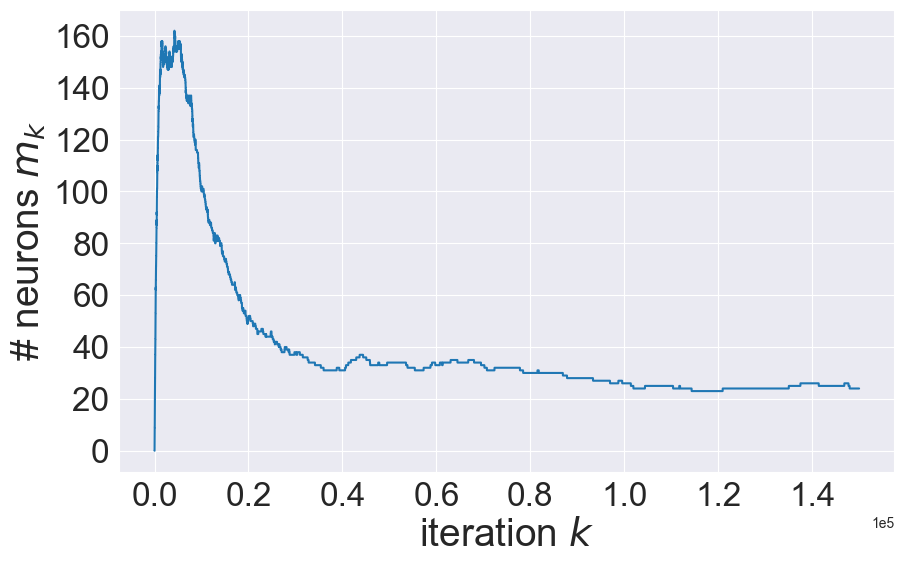

In [44]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms)), ms, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

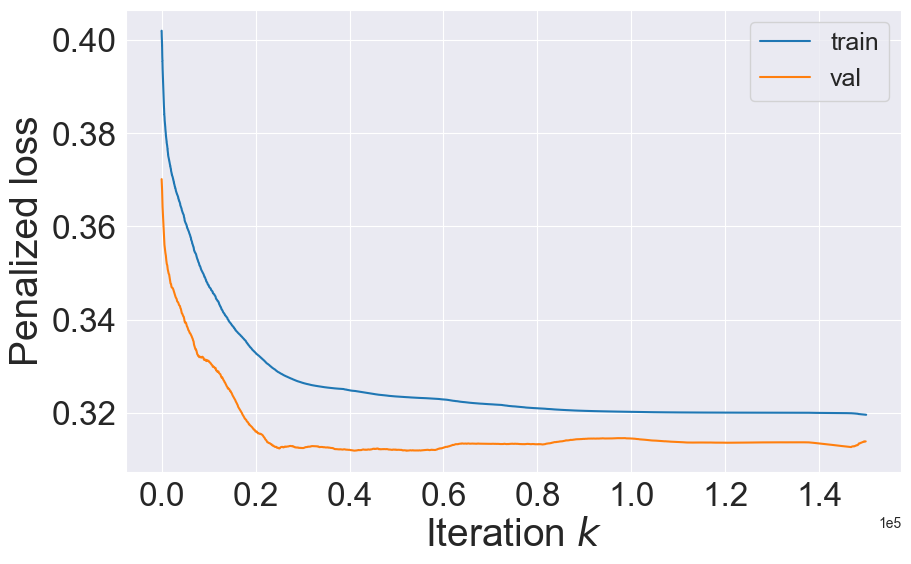

In [45]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_mix)), penalized_train_losses_mix, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses_mix)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

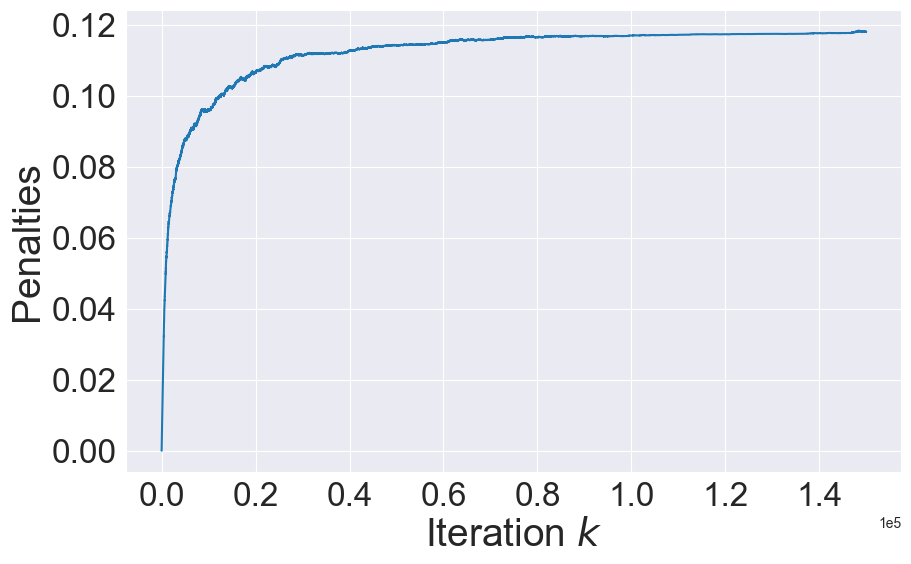

In [46]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses_mix - train_losses_mix

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

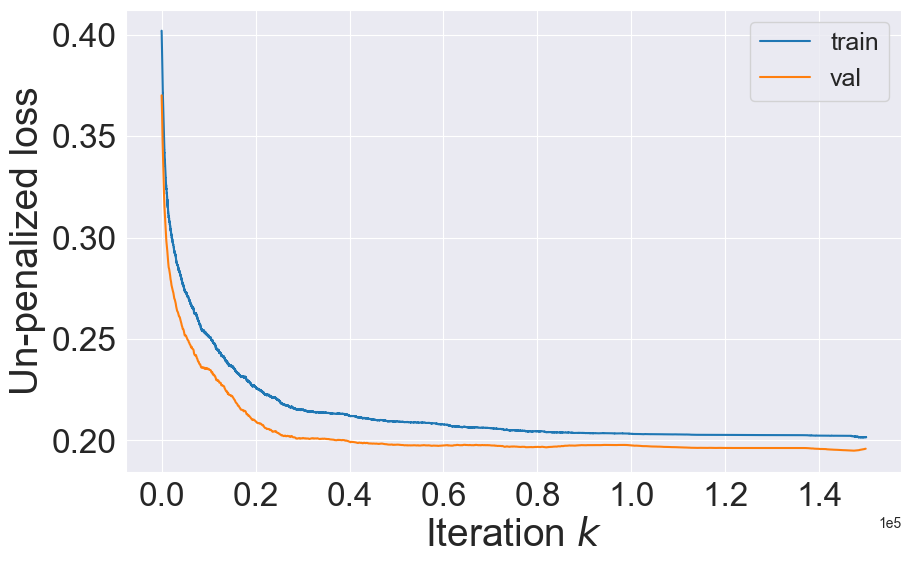

In [47]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_mix)), train_losses_mix, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses_mix)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 5. Mix $L^2(\tau)/L^2(\tau_m)/\text{conic-GD}$ algorithm

In [48]:
n_steps = N_STEPS
m = 500
ALPHA = 1.0
BETA = 1.0
ETA = 0.01
penalized = True

In [49]:
def update_random_neuron(a, b, x, y, eps=1.0e-9):
    if a.shape[1] > 0:
        j = np.random.randint(low=0, high=a.shape[1])
        b_j = b[j, :].reshape(1, -1)
        V = V_grad(a, b, x, y, b_j) - a[0, j] / BETA 
        new_a = BETA * soft_thresholding(V, tau=LAMBDA)

        if np.abs(new_a) > 0:
            # update weight for neuron b_j
            a[0, j] = new_a  
        else:
            # remove a_j and b_j from the list
            a = np.column_stack((a[:, :j], a[:, j+1:]))
            b = np.row_stack((b[:j, :], b[j+1:, :]))
        #    a[0, j] = 0. 
    return a, b  

In [50]:
#def projected_conic_particle_update(a, b, x, y, penalized=False):
#    m = a.shape[1]
#    if m > 0:
#        #a = a - ETA * V_grad(a, b, x, y, b).reshape(1, -1) / m
#        #b = b - m * ETA * nabla_V_grad(a, b, x, y, factor=a)
#        a = a - ETA * V_grad(a, b, x, y, b).reshape(1, -1)
#        b = b - ETA * nabla_V_grad(a, b, x, y, factor=a)
#        
#        if penalized:
#            a = a - ETA * LAMBDA * np.sign(a)
#        
#        b_norms = np.linalg.norm(b, ord=2, axis=1, keepdims=True)
#        # a = a * b_norms.T
#        b = b / b_norms
#    return a, b

In [51]:
def train(n_steps, x_train, y_train, x_val, y_val, do_val=True, penalized=False):
    a = np.array([[]])
    b = np.array([[]])
    ms = [0]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []

    for k in tqdm(range(n_steps)):
        if k % 3 == 0:
            # sample new particle and set weight
            a, b = add_new_neuron(a, b, x_train, y_train, eps=1e-8)
            ms.append(a.shape[1])
            # compute training loss
            train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
            train_losses.append(train_loss)
            penalized_train_losses.append(penalized_train_loss)
        elif k % 3 == 1:
            # update existing particle
            a, b = update_random_neuron(a, b, x_train, y_train, eps=1e-8)
            ms.append(a.shape[1])
            # compute training loss
            train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
            train_losses.append(train_loss)
            penalized_train_losses.append(penalized_train_loss)
        else:
            # do conic-GD update
            a, b = projected_conic_particle_update(a, b, x_train, y_train, penalized=penalized)
            ms.append(a.shape[1])
            # compute training loss
            train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
            train_losses.append(train_loss)
            penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses) 

In [52]:
a, b, ms, train_losses_mix_conic, penalized_train_losses_mix_conic, val_losses, penalized_val_losses = \
        train(n_steps, x_train, y_train, x_val, y_val, penalized=penalized)

  0%|                                                     | 303/150000 [00:00<00:49, 3012.32it/s]

m at step 0 : 1
Train loss at step 0 : 0.40200
Validation loss at step 0 : 0.37015
m at step 100 : 25
Train loss at step 100 : 0.39358
Validation loss at step 100 : 0.36050
m at step 200 : 42
Train loss at step 200 : 0.38448
Validation loss at step 200 : 0.35068
m at step 300 : 55
Train loss at step 300 : 0.37243
Validation loss at step 300 : 0.33995
m at step 400 : 66
Train loss at step 400 : 0.36344
Validation loss at step 400 : 0.33217
m at step 500 : 77
Train loss at step 500 : 0.35471
Validation loss at step 500 : 0.32539


  1%|▎                                                    | 852/150000 [00:00<01:14, 2013.60it/s]

m at step 600 : 89
Train loss at step 600 : 0.34513
Validation loss at step 600 : 0.31739
m at step 700 : 100
Train loss at step 700 : 0.33781
Validation loss at step 700 : 0.31110
m at step 800 : 105
Train loss at step 800 : 0.32771
Validation loss at step 800 : 0.30280
m at step 900 : 113
Train loss at step 900 : 0.31892
Validation loss at step 900 : 0.29492


  1%|▍                                                   | 1250/150000 [00:00<01:23, 1776.04it/s]

m at step 1,000 : 120
Train loss at step 1,000 : 0.31143
Validation loss at step 1,000 : 0.28877
m at step 1,100 : 127
Train loss at step 1,100 : 0.30399
Validation loss at step 1,100 : 0.28221
m at step 1,200 : 129
Train loss at step 1,200 : 0.29590
Validation loss at step 1,200 : 0.27588
m at step 1,300 : 132
Train loss at step 1,300 : 0.28652
Validation loss at step 1,300 : 0.26896


  1%|▌                                                   | 1605/150000 [00:00<01:27, 1698.50it/s]

m at step 1,400 : 131
Train loss at step 1,400 : 0.27946
Validation loss at step 1,400 : 0.26362
m at step 1,500 : 133
Train loss at step 1,500 : 0.27230
Validation loss at step 1,500 : 0.25803
m at step 1,600 : 136
Train loss at step 1,600 : 0.26450
Validation loss at step 1,600 : 0.25132
m at step 1,700 : 137
Train loss at step 1,700 : 0.25830
Validation loss at step 1,700 : 0.24691


  1%|▋                                                   | 2107/150000 [00:01<01:31, 1619.86it/s]

m at step 1,800 : 137
Train loss at step 1,800 : 0.25282
Validation loss at step 1,800 : 0.24293
m at step 1,900 : 138
Train loss at step 1,900 : 0.24707
Validation loss at step 1,900 : 0.23892
m at step 2,000 : 137
Train loss at step 2,000 : 0.24146
Validation loss at step 2,000 : 0.23447
m at step 2,100 : 136
Train loss at step 2,100 : 0.23566
Validation loss at step 2,100 : 0.22999


  2%|▊                                                   | 2424/150000 [00:01<01:39, 1481.74it/s]

m at step 2,200 : 136
Train loss at step 2,200 : 0.22991
Validation loss at step 2,200 : 0.22548
m at step 2,300 : 136
Train loss at step 2,300 : 0.22535
Validation loss at step 2,300 : 0.22204
m at step 2,400 : 136
Train loss at step 2,400 : 0.22080
Validation loss at step 2,400 : 0.21849


  2%|▉                                                   | 2719/150000 [00:01<01:42, 1440.32it/s]

m at step 2,500 : 136
Train loss at step 2,500 : 0.21582
Validation loss at step 2,500 : 0.21452
m at step 2,600 : 135
Train loss at step 2,600 : 0.21124
Validation loss at step 2,600 : 0.21113
m at step 2,700 : 135
Train loss at step 2,700 : 0.20793
Validation loss at step 2,700 : 0.20864


  2%|█                                                   | 3025/150000 [00:01<01:40, 1468.55it/s]

m at step 2,800 : 135
Train loss at step 2,800 : 0.20434
Validation loss at step 2,800 : 0.20574
m at step 2,900 : 133
Train loss at step 2,900 : 0.20076
Validation loss at step 2,900 : 0.20306
m at step 3,000 : 133
Train loss at step 3,000 : 0.19678
Validation loss at step 3,000 : 0.20015


  2%|█▏                                                  | 3340/150000 [00:02<01:38, 1495.08it/s]

m at step 3,100 : 133
Train loss at step 3,100 : 0.19325
Validation loss at step 3,100 : 0.19739
m at step 3,200 : 132
Train loss at step 3,200 : 0.19034
Validation loss at step 3,200 : 0.19512
m at step 3,300 : 132
Train loss at step 3,300 : 0.18770
Validation loss at step 3,300 : 0.19317
m at step 3,400 : 131
Train loss at step 3,400 : 0.18528
Validation loss at step 3,400 : 0.19128


  3%|█▎                                                  | 3822/150000 [00:02<01:33, 1570.31it/s]

m at step 3,500 : 131
Train loss at step 3,500 : 0.18219
Validation loss at step 3,500 : 0.18900
m at step 3,600 : 130
Train loss at step 3,600 : 0.17945
Validation loss at step 3,600 : 0.18707
m at step 3,700 : 129
Train loss at step 3,700 : 0.17716
Validation loss at step 3,700 : 0.18534
m at step 3,800 : 126
Train loss at step 3,800 : 0.17483
Validation loss at step 3,800 : 0.18365


  3%|█▍                                                  | 4152/150000 [00:02<01:30, 1610.29it/s]

m at step 3,900 : 125
Train loss at step 3,900 : 0.17291
Validation loss at step 3,900 : 0.18227
m at step 4,000 : 125
Train loss at step 4,000 : 0.17075
Validation loss at step 4,000 : 0.18077
m at step 4,100 : 123
Train loss at step 4,100 : 0.16904
Validation loss at step 4,100 : 0.17952
m at step 4,200 : 122
Train loss at step 4,200 : 0.16720
Validation loss at step 4,200 : 0.17805


  3%|█▌                                                  | 4498/150000 [00:02<01:27, 1671.63it/s]

m at step 4,300 : 120
Train loss at step 4,300 : 0.16541
Validation loss at step 4,300 : 0.17667
m at step 4,400 : 120
Train loss at step 4,400 : 0.16329
Validation loss at step 4,400 : 0.17513
m at step 4,500 : 119
Train loss at step 4,500 : 0.16231
Validation loss at step 4,500 : 0.17441
m at step 4,600 : 119
Train loss at step 4,600 : 0.16104
Validation loss at step 4,600 : 0.17354


  3%|█▋                                                  | 5010/150000 [00:03<01:25, 1695.24it/s]

m at step 4,700 : 119
Train loss at step 4,700 : 0.15960
Validation loss at step 4,700 : 0.17243
m at step 4,800 : 119
Train loss at step 4,800 : 0.15824
Validation loss at step 4,800 : 0.17138
m at step 4,900 : 118
Train loss at step 4,900 : 0.15702
Validation loss at step 4,900 : 0.17054
m at step 5,000 : 118
Train loss at step 5,000 : 0.15594
Validation loss at step 5,000 : 0.16973


  4%|█▊                                                  | 5349/150000 [00:03<01:27, 1658.87it/s]

m at step 5,100 : 113
Train loss at step 5,100 : 0.15492
Validation loss at step 5,100 : 0.16891
m at step 5,200 : 111
Train loss at step 5,200 : 0.15375
Validation loss at step 5,200 : 0.16794
m at step 5,300 : 110
Train loss at step 5,300 : 0.15281
Validation loss at step 5,300 : 0.16717
m at step 5,400 : 109
Train loss at step 5,400 : 0.15145
Validation loss at step 5,400 : 0.16608


  4%|█▉                                                  | 5695/150000 [00:03<01:25, 1696.54it/s]

m at step 5,500 : 108
Train loss at step 5,500 : 0.15056
Validation loss at step 5,500 : 0.16536
m at step 5,600 : 108
Train loss at step 5,600 : 0.14977
Validation loss at step 5,600 : 0.16473
m at step 5,700 : 106
Train loss at step 5,700 : 0.14900
Validation loss at step 5,700 : 0.16413
m at step 5,800 : 105
Train loss at step 5,800 : 0.14817
Validation loss at step 5,800 : 0.16345


  4%|██▏                                                 | 6226/150000 [00:03<01:23, 1721.66it/s]

m at step 5,900 : 101
Train loss at step 5,900 : 0.14727
Validation loss at step 5,900 : 0.16274
m at step 6,000 : 99
Train loss at step 6,000 : 0.14636
Validation loss at step 6,000 : 0.16200
m at step 6,100 : 97
Train loss at step 6,100 : 0.14572
Validation loss at step 6,100 : 0.16145
m at step 6,200 : 97
Train loss at step 6,200 : 0.14508
Validation loss at step 6,200 : 0.16094


  4%|██▎                                                 | 6615/150000 [00:03<01:17, 1840.31it/s]

m at step 6,300 : 97
Train loss at step 6,300 : 0.14410
Validation loss at step 6,300 : 0.16011
m at step 6,400 : 97
Train loss at step 6,400 : 0.14333
Validation loss at step 6,400 : 0.15943
m at step 6,500 : 96
Train loss at step 6,500 : 0.14264
Validation loss at step 6,500 : 0.15882
m at step 6,600 : 96
Train loss at step 6,600 : 0.14198
Validation loss at step 6,600 : 0.15829
m at step 6,700 : 95
Train loss at step 6,700 : 0.14146
Validation loss at step 6,700 : 0.15781


  5%|██▍                                                 | 7014/150000 [00:04<01:14, 1921.00it/s]

m at step 6,800 : 93
Train loss at step 6,800 : 0.14105
Validation loss at step 6,800 : 0.15744
m at step 6,900 : 90
Train loss at step 6,900 : 0.14065
Validation loss at step 6,900 : 0.15721
m at step 7,000 : 90
Train loss at step 7,000 : 0.13996
Validation loss at step 7,000 : 0.15660
m at step 7,100 : 90
Train loss at step 7,100 : 0.13928
Validation loss at step 7,100 : 0.15595
m at step 7,200 : 90
Train loss at step 7,200 : 0.13871
Validation loss at step 7,200 : 0.15545


  5%|██▋                                                 | 7602/150000 [00:04<01:13, 1938.70it/s]

m at step 7,300 : 90
Train loss at step 7,300 : 0.13834
Validation loss at step 7,300 : 0.15516
m at step 7,400 : 90
Train loss at step 7,400 : 0.13775
Validation loss at step 7,400 : 0.15467
m at step 7,500 : 90
Train loss at step 7,500 : 0.13719
Validation loss at step 7,500 : 0.15416
m at step 7,600 : 90
Train loss at step 7,600 : 0.13666
Validation loss at step 7,600 : 0.15375


  5%|██▋                                                 | 7796/150000 [00:04<01:20, 1757.99it/s]

m at step 7,700 : 90
Train loss at step 7,700 : 0.13630
Validation loss at step 7,700 : 0.15346
m at step 7,800 : 90
Train loss at step 7,800 : 0.13590
Validation loss at step 7,800 : 0.15307


  5%|██▊                                                 | 8136/150000 [00:04<01:38, 1433.19it/s]

m at step 7,900 : 90
Train loss at step 7,900 : 0.13550
Validation loss at step 7,900 : 0.15269
m at step 8,000 : 89
Train loss at step 8,000 : 0.13517
Validation loss at step 8,000 : 0.15243
m at step 8,100 : 89
Train loss at step 8,100 : 0.13493
Validation loss at step 8,100 : 0.15222


  6%|██▉                                                 | 8544/150000 [00:05<01:22, 1708.44it/s]

m at step 8,200 : 89
Train loss at step 8,200 : 0.13439
Validation loss at step 8,200 : 0.15174
m at step 8,300 : 89
Train loss at step 8,300 : 0.13417
Validation loss at step 8,300 : 0.15154
m at step 8,400 : 88
Train loss at step 8,400 : 0.13376
Validation loss at step 8,400 : 0.15121
m at step 8,500 : 88
Train loss at step 8,500 : 0.13332
Validation loss at step 8,500 : 0.15082
m at step 8,600 : 87
Train loss at step 8,600 : 0.13288
Validation loss at step 8,600 : 0.15041


  6%|███                                                 | 8949/150000 [00:05<01:16, 1855.17it/s]

m at step 8,700 : 87
Train loss at step 8,700 : 0.13270
Validation loss at step 8,700 : 0.15029
m at step 8,800 : 86
Train loss at step 8,800 : 0.13242
Validation loss at step 8,800 : 0.15006
m at step 8,900 : 86
Train loss at step 8,900 : 0.13220
Validation loss at step 8,900 : 0.14984
m at step 9,000 : 86
Train loss at step 9,000 : 0.13190
Validation loss at step 9,000 : 0.14961


  6%|███▏                                                | 9336/150000 [00:05<01:14, 1883.96it/s]

m at step 9,100 : 86
Train loss at step 9,100 : 0.13161
Validation loss at step 9,100 : 0.14933
m at step 9,200 : 86
Train loss at step 9,200 : 0.13134
Validation loss at step 9,200 : 0.14907
m at step 9,300 : 86
Train loss at step 9,300 : 0.13106
Validation loss at step 9,300 : 0.14876
m at step 9,400 : 86
Train loss at step 9,400 : 0.13063
Validation loss at step 9,400 : 0.14837
m at step 9,500 : 86
Train loss at step 9,500 : 0.13042
Validation loss at step 9,500 : 0.14820


  7%|███▍                                                | 9953/150000 [00:05<01:10, 1999.22it/s]

m at step 9,600 : 86
Train loss at step 9,600 : 0.13020
Validation loss at step 9,600 : 0.14797
m at step 9,700 : 85
Train loss at step 9,700 : 0.12986
Validation loss at step 9,700 : 0.14765
m at step 9,800 : 85
Train loss at step 9,800 : 0.12964
Validation loss at step 9,800 : 0.14742
m at step 9,900 : 84
Train loss at step 9,900 : 0.12948
Validation loss at step 9,900 : 0.14728
m at step 10,000 : 84
Train loss at step 10,000 : 0.12928
Validation loss at step 10,000 : 0.14709


  7%|███▌                                               | 10379/150000 [00:06<01:07, 2066.30it/s]

m at step 10,100 : 83
Train loss at step 10,100 : 0.12900
Validation loss at step 10,100 : 0.14680
m at step 10,200 : 83
Train loss at step 10,200 : 0.12877
Validation loss at step 10,200 : 0.14657
m at step 10,300 : 83
Train loss at step 10,300 : 0.12856
Validation loss at step 10,300 : 0.14632
m at step 10,400 : 83
Train loss at step 10,400 : 0.12836
Validation loss at step 10,400 : 0.14613
m at step 10,500 : 82
Train loss at step 10,500 : 0.12820
Validation loss at step 10,500 : 0.14597


  7%|███▋                                               | 11022/150000 [00:06<01:05, 2109.16it/s]

m at step 10,600 : 82
Train loss at step 10,600 : 0.12798
Validation loss at step 10,600 : 0.14580
m at step 10,700 : 81
Train loss at step 10,700 : 0.12776
Validation loss at step 10,700 : 0.14556
m at step 10,800 : 81
Train loss at step 10,800 : 0.12763
Validation loss at step 10,800 : 0.14538
m at step 10,900 : 81
Train loss at step 10,900 : 0.12737
Validation loss at step 10,900 : 0.14511
m at step 11,000 : 81
Train loss at step 11,000 : 0.12708
Validation loss at step 11,000 : 0.14481


  8%|███▉                                               | 11454/150000 [00:06<01:05, 2127.47it/s]

m at step 11,100 : 81
Train loss at step 11,100 : 0.12687
Validation loss at step 11,100 : 0.14455
m at step 11,200 : 81
Train loss at step 11,200 : 0.12676
Validation loss at step 11,200 : 0.14442
m at step 11,300 : 81
Train loss at step 11,300 : 0.12678
Validation loss at step 11,300 : 0.14440
m at step 11,400 : 81
Train loss at step 11,400 : 0.12653
Validation loss at step 11,400 : 0.14414
m at step 11,500 : 81
Train loss at step 11,500 : 0.12643
Validation loss at step 11,500 : 0.14402


  8%|████                                               | 11907/150000 [00:06<01:02, 2199.35it/s]

m at step 11,600 : 80
Train loss at step 11,600 : 0.12622
Validation loss at step 11,600 : 0.14380
m at step 11,700 : 80
Train loss at step 11,700 : 0.12606
Validation loss at step 11,700 : 0.14361
m at step 11,800 : 80
Train loss at step 11,800 : 0.12600
Validation loss at step 11,800 : 0.14351
m at step 11,900 : 80
Train loss at step 11,900 : 0.12581
Validation loss at step 11,900 : 0.14329
m at step 12,000 : 80
Train loss at step 12,000 : 0.12569
Validation loss at step 12,000 : 0.14317


  8%|████▏                                              | 12347/150000 [00:06<01:03, 2177.28it/s]

m at step 12,100 : 79
Train loss at step 12,100 : 0.12551
Validation loss at step 12,100 : 0.14296
m at step 12,200 : 79
Train loss at step 12,200 : 0.12538
Validation loss at step 12,200 : 0.14281
m at step 12,300 : 78
Train loss at step 12,300 : 0.12524
Validation loss at step 12,300 : 0.14264
m at step 12,400 : 77
Train loss at step 12,400 : 0.12502
Validation loss at step 12,400 : 0.14243
m at step 12,500 : 77
Train loss at step 12,500 : 0.12488
Validation loss at step 12,500 : 0.14229


  9%|████▎                                              | 12791/150000 [00:07<01:02, 2200.68it/s]

m at step 12,600 : 77
Train loss at step 12,600 : 0.12469
Validation loss at step 12,600 : 0.14207
m at step 12,700 : 76
Train loss at step 12,700 : 0.12453
Validation loss at step 12,700 : 0.14193
m at step 12,800 : 76
Train loss at step 12,800 : 0.12435
Validation loss at step 12,800 : 0.14171
m at step 12,900 : 76
Train loss at step 12,900 : 0.12420
Validation loss at step 12,900 : 0.14151


  9%|████▍                                              | 13227/150000 [00:07<01:17, 1764.65it/s]

m at step 13,000 : 75
Train loss at step 13,000 : 0.12415
Validation loss at step 13,000 : 0.14143
m at step 13,100 : 75
Train loss at step 13,100 : 0.12405
Validation loss at step 13,100 : 0.14126
m at step 13,200 : 75
Train loss at step 13,200 : 0.12388
Validation loss at step 13,200 : 0.14106
m at step 13,300 : 75
Train loss at step 13,300 : 0.12377
Validation loss at step 13,300 : 0.14094
m at step 13,400 : 74
Train loss at step 13,400 : 0.12371
Validation loss at step 13,400 : 0.14087


  9%|████▋                                              | 13872/150000 [00:07<01:08, 1974.37it/s]

m at step 13,500 : 74
Train loss at step 13,500 : 0.12354
Validation loss at step 13,500 : 0.14069
m at step 13,600 : 74
Train loss at step 13,600 : 0.12348
Validation loss at step 13,600 : 0.14061
m at step 13,700 : 74
Train loss at step 13,700 : 0.12335
Validation loss at step 13,700 : 0.14046
m at step 13,800 : 74
Train loss at step 13,800 : 0.12317
Validation loss at step 13,800 : 0.14023
m at step 13,900 : 74
Train loss at step 13,900 : 0.12297
Validation loss at step 13,900 : 0.14003


  9%|████▊                                              | 14093/150000 [00:07<01:06, 2039.07it/s]

m at step 14,000 : 74
Train loss at step 14,000 : 0.12290
Validation loss at step 14,000 : 0.13994
m at step 14,100 : 74
Train loss at step 14,100 : 0.12290
Validation loss at step 14,100 : 0.13991
m at step 14,200 : 73
Train loss at step 14,200 : 0.12276
Validation loss at step 14,200 : 0.13975


 10%|█████                                              | 14762/150000 [00:08<01:11, 1889.91it/s]

m at step 14,300 : 73
Train loss at step 14,300 : 0.12264
Validation loss at step 14,300 : 0.13960
m at step 14,400 : 73
Train loss at step 14,400 : 0.12251
Validation loss at step 14,400 : 0.13943
m at step 14,500 : 73
Train loss at step 14,500 : 0.12242
Validation loss at step 14,500 : 0.13934
m at step 14,600 : 73
Train loss at step 14,600 : 0.12234
Validation loss at step 14,600 : 0.13923
m at step 14,700 : 73
Train loss at step 14,700 : 0.12233
Validation loss at step 14,700 : 0.13918


 10%|█████▏                                             | 15208/150000 [00:08<01:05, 2054.66it/s]

m at step 14,800 : 73
Train loss at step 14,800 : 0.12224
Validation loss at step 14,800 : 0.13907
m at step 14,900 : 73
Train loss at step 14,900 : 0.12218
Validation loss at step 14,900 : 0.13899
m at step 15,000 : 73
Train loss at step 15,000 : 0.12214
Validation loss at step 15,000 : 0.13893
m at step 15,100 : 73
Train loss at step 15,100 : 0.12210
Validation loss at step 15,100 : 0.13886
m at step 15,200 : 72
Train loss at step 15,200 : 0.12196
Validation loss at step 15,200 : 0.13869


 10%|█████▎                                             | 15667/150000 [00:08<01:01, 2176.11it/s]

m at step 15,300 : 72
Train loss at step 15,300 : 0.12186
Validation loss at step 15,300 : 0.13855
m at step 15,400 : 72
Train loss at step 15,400 : 0.12182
Validation loss at step 15,400 : 0.13848
m at step 15,500 : 72
Train loss at step 15,500 : 0.12171
Validation loss at step 15,500 : 0.13835
m at step 15,600 : 72
Train loss at step 15,600 : 0.12166
Validation loss at step 15,600 : 0.13829
m at step 15,700 : 71
Train loss at step 15,700 : 0.12157
Validation loss at step 15,700 : 0.13815


 11%|█████▍                                             | 16120/150000 [00:08<01:00, 2219.88it/s]

m at step 15,800 : 71
Train loss at step 15,800 : 0.12154
Validation loss at step 15,800 : 0.13808
m at step 15,900 : 71
Train loss at step 15,900 : 0.12138
Validation loss at step 15,900 : 0.13791
m at step 16,000 : 71
Train loss at step 16,000 : 0.12126
Validation loss at step 16,000 : 0.13778
m at step 16,100 : 71
Train loss at step 16,100 : 0.12121
Validation loss at step 16,100 : 0.13769
m at step 16,200 : 70
Train loss at step 16,200 : 0.12116
Validation loss at step 16,200 : 0.13761


 11%|█████▋                                             | 16581/150000 [00:09<00:59, 2259.23it/s]

m at step 16,300 : 70
Train loss at step 16,300 : 0.12115
Validation loss at step 16,300 : 0.13761
m at step 16,400 : 70
Train loss at step 16,400 : 0.12107
Validation loss at step 16,400 : 0.13749
m at step 16,500 : 70
Train loss at step 16,500 : 0.12097
Validation loss at step 16,500 : 0.13734
m at step 16,600 : 70
Train loss at step 16,600 : 0.12088
Validation loss at step 16,600 : 0.13722
m at step 16,700 : 70
Train loss at step 16,700 : 0.12077
Validation loss at step 16,700 : 0.13707


 11%|█████▊                                             | 17039/150000 [00:09<00:59, 2251.37it/s]

m at step 16,800 : 70
Train loss at step 16,800 : 0.12073
Validation loss at step 16,800 : 0.13700
m at step 16,900 : 70
Train loss at step 16,900 : 0.12063
Validation loss at step 16,900 : 0.13686
m at step 17,000 : 69
Train loss at step 17,000 : 0.12050
Validation loss at step 17,000 : 0.13670
m at step 17,100 : 69
Train loss at step 17,100 : 0.12049
Validation loss at step 17,100 : 0.13665
m at step 17,200 : 69
Train loss at step 17,200 : 0.12048
Validation loss at step 17,200 : 0.13663


 12%|██████                                             | 17727/150000 [00:09<00:58, 2262.43it/s]

m at step 17,300 : 69
Train loss at step 17,300 : 0.12037
Validation loss at step 17,300 : 0.13649
m at step 17,400 : 69
Train loss at step 17,400 : 0.12031
Validation loss at step 17,400 : 0.13640
m at step 17,500 : 69
Train loss at step 17,500 : 0.12025
Validation loss at step 17,500 : 0.13633
m at step 17,600 : 69
Train loss at step 17,600 : 0.12022
Validation loss at step 17,600 : 0.13627
m at step 17,700 : 69
Train loss at step 17,700 : 0.12016
Validation loss at step 17,700 : 0.13618


 12%|██████▏                                            | 18190/150000 [00:09<00:57, 2288.50it/s]

m at step 17,800 : 69
Train loss at step 17,800 : 0.12012
Validation loss at step 17,800 : 0.13612
m at step 17,900 : 69
Train loss at step 17,900 : 0.12008
Validation loss at step 17,900 : 0.13604
m at step 18,000 : 69
Train loss at step 18,000 : 0.12001
Validation loss at step 18,000 : 0.13595
m at step 18,100 : 69
Train loss at step 18,100 : 0.11998
Validation loss at step 18,100 : 0.13589
m at step 18,200 : 69
Train loss at step 18,200 : 0.11995
Validation loss at step 18,200 : 0.13582


 12%|██████▎                                            | 18658/150000 [00:09<00:56, 2315.94it/s]

m at step 18,300 : 69
Train loss at step 18,300 : 0.11977
Validation loss at step 18,300 : 0.13563
m at step 18,400 : 69
Train loss at step 18,400 : 0.11976
Validation loss at step 18,400 : 0.13559
m at step 18,500 : 69
Train loss at step 18,500 : 0.11973
Validation loss at step 18,500 : 0.13553
m at step 18,600 : 69
Train loss at step 18,600 : 0.11965
Validation loss at step 18,600 : 0.13541
m at step 18,700 : 69
Train loss at step 18,700 : 0.11961
Validation loss at step 18,700 : 0.13535


 13%|██████▌                                            | 19125/150000 [00:10<00:56, 2323.22it/s]

m at step 18,800 : 69
Train loss at step 18,800 : 0.11958
Validation loss at step 18,800 : 0.13530
m at step 18,900 : 69
Train loss at step 18,900 : 0.11944
Validation loss at step 18,900 : 0.13512
m at step 19,000 : 69
Train loss at step 19,000 : 0.11940
Validation loss at step 19,000 : 0.13504
m at step 19,100 : 69
Train loss at step 19,100 : 0.11937
Validation loss at step 19,100 : 0.13499
m at step 19,200 : 69
Train loss at step 19,200 : 0.11932
Validation loss at step 19,200 : 0.13492


 13%|██████▋                                            | 19591/150000 [00:10<00:57, 2269.14it/s]

m at step 19,300 : 69
Train loss at step 19,300 : 0.11919
Validation loss at step 19,300 : 0.13477
m at step 19,400 : 69
Train loss at step 19,400 : 0.11917
Validation loss at step 19,400 : 0.13470
m at step 19,500 : 69
Train loss at step 19,500 : 0.11910
Validation loss at step 19,500 : 0.13462
m at step 19,600 : 69
Train loss at step 19,600 : 0.11904
Validation loss at step 19,600 : 0.13454
m at step 19,700 : 69
Train loss at step 19,700 : 0.11902
Validation loss at step 19,700 : 0.13449


 13%|██████▊                                            | 20055/150000 [00:10<00:56, 2280.45it/s]

m at step 19,800 : 69
Train loss at step 19,800 : 0.11900
Validation loss at step 19,800 : 0.13444
m at step 19,900 : 69
Train loss at step 19,900 : 0.11896
Validation loss at step 19,900 : 0.13436
m at step 20,000 : 69
Train loss at step 20,000 : 0.11889
Validation loss at step 20,000 : 0.13428
m at step 20,100 : 69
Train loss at step 20,100 : 0.11893
Validation loss at step 20,100 : 0.13428
m at step 20,200 : 69
Train loss at step 20,200 : 0.11890
Validation loss at step 20,200 : 0.13424


 14%|███████                                            | 20747/150000 [00:10<00:56, 2273.91it/s]

m at step 20,300 : 69
Train loss at step 20,300 : 0.11881
Validation loss at step 20,300 : 0.13413
m at step 20,400 : 69
Train loss at step 20,400 : 0.11883
Validation loss at step 20,400 : 0.13412
m at step 20,500 : 69
Train loss at step 20,500 : 0.11879
Validation loss at step 20,500 : 0.13408
m at step 20,600 : 69
Train loss at step 20,600 : 0.11868
Validation loss at step 20,600 : 0.13396
m at step 20,700 : 69
Train loss at step 20,700 : 0.11869
Validation loss at step 20,700 : 0.13394


 14%|███████▏                                           | 21210/150000 [00:11<00:56, 2296.99it/s]

m at step 20,800 : 69
Train loss at step 20,800 : 0.11865
Validation loss at step 20,800 : 0.13389
m at step 20,900 : 69
Train loss at step 20,900 : 0.11855
Validation loss at step 20,900 : 0.13378
m at step 21,000 : 69
Train loss at step 21,000 : 0.11854
Validation loss at step 21,000 : 0.13375
m at step 21,100 : 69
Train loss at step 21,100 : 0.11845
Validation loss at step 21,100 : 0.13362
m at step 21,200 : 69
Train loss at step 21,200 : 0.11839
Validation loss at step 21,200 : 0.13355


 14%|███████▎                                           | 21675/150000 [00:11<00:55, 2311.81it/s]

m at step 21,300 : 69
Train loss at step 21,300 : 0.11830
Validation loss at step 21,300 : 0.13344
m at step 21,400 : 69
Train loss at step 21,400 : 0.11830
Validation loss at step 21,400 : 0.13343
m at step 21,500 : 69
Train loss at step 21,500 : 0.11829
Validation loss at step 21,500 : 0.13341
m at step 21,600 : 69
Train loss at step 21,600 : 0.11829
Validation loss at step 21,600 : 0.13339
m at step 21,700 : 68
Train loss at step 21,700 : 0.11828
Validation loss at step 21,700 : 0.13335


 15%|███████▌                                           | 22136/150000 [00:11<00:56, 2277.59it/s]

m at step 21,800 : 68
Train loss at step 21,800 : 0.11826
Validation loss at step 21,800 : 0.13332
m at step 21,900 : 68
Train loss at step 21,900 : 0.11823
Validation loss at step 21,900 : 0.13327
m at step 22,000 : 68
Train loss at step 22,000 : 0.11813
Validation loss at step 22,000 : 0.13316
m at step 22,100 : 68
Train loss at step 22,100 : 0.11811
Validation loss at step 22,100 : 0.13313
m at step 22,200 : 68
Train loss at step 22,200 : 0.11804
Validation loss at step 22,200 : 0.13303


 15%|███████▋                                           | 22601/150000 [00:11<00:55, 2288.07it/s]

m at step 22,300 : 68
Train loss at step 22,300 : 0.11792
Validation loss at step 22,300 : 0.13291
m at step 22,400 : 68
Train loss at step 22,400 : 0.11793
Validation loss at step 22,400 : 0.13289
m at step 22,500 : 68
Train loss at step 22,500 : 0.11787
Validation loss at step 22,500 : 0.13281
m at step 22,600 : 68
Train loss at step 22,600 : 0.11784
Validation loss at step 22,600 : 0.13277
m at step 22,700 : 68
Train loss at step 22,700 : 0.11789
Validation loss at step 22,700 : 0.13280


 15%|███████▊                                           | 23070/150000 [00:11<00:55, 2292.62it/s]

m at step 22,800 : 68
Train loss at step 22,800 : 0.11788
Validation loss at step 22,800 : 0.13277
m at step 22,900 : 68
Train loss at step 22,900 : 0.11790
Validation loss at step 22,900 : 0.13278
m at step 23,000 : 68
Train loss at step 23,000 : 0.11783
Validation loss at step 23,000 : 0.13269
m at step 23,100 : 68
Train loss at step 23,100 : 0.11783
Validation loss at step 23,100 : 0.13268
m at step 23,200 : 68
Train loss at step 23,200 : 0.11781
Validation loss at step 23,200 : 0.13264


 16%|████████                                           | 23787/150000 [00:12<00:53, 2359.82it/s]

m at step 23,300 : 68
Train loss at step 23,300 : 0.11776
Validation loss at step 23,300 : 0.13258
m at step 23,400 : 68
Train loss at step 23,400 : 0.11769
Validation loss at step 23,400 : 0.13249
m at step 23,500 : 68
Train loss at step 23,500 : 0.11766
Validation loss at step 23,500 : 0.13246
m at step 23,600 : 68
Train loss at step 23,600 : 0.11763
Validation loss at step 23,600 : 0.13242
m at step 23,700 : 68
Train loss at step 23,700 : 0.11767
Validation loss at step 23,700 : 0.13244


 16%|████████▏                                          | 24261/150000 [00:12<00:54, 2317.08it/s]

m at step 23,800 : 68
Train loss at step 23,800 : 0.11769
Validation loss at step 23,800 : 0.13245
m at step 23,900 : 68
Train loss at step 23,900 : 0.11766
Validation loss at step 23,900 : 0.13241
m at step 24,000 : 67
Train loss at step 24,000 : 0.11759
Validation loss at step 24,000 : 0.13232
m at step 24,100 : 67
Train loss at step 24,100 : 0.11753
Validation loss at step 24,100 : 0.13226
m at step 24,200 : 67
Train loss at step 24,200 : 0.11749
Validation loss at step 24,200 : 0.13221


 16%|████████▍                                          | 24739/150000 [00:12<00:53, 2352.83it/s]

m at step 24,300 : 67
Train loss at step 24,300 : 0.11740
Validation loss at step 24,300 : 0.13212
m at step 24,400 : 67
Train loss at step 24,400 : 0.11731
Validation loss at step 24,400 : 0.13202
m at step 24,500 : 67
Train loss at step 24,500 : 0.11724
Validation loss at step 24,500 : 0.13195
m at step 24,600 : 66
Train loss at step 24,600 : 0.11723
Validation loss at step 24,600 : 0.13194
m at step 24,700 : 66
Train loss at step 24,700 : 0.11723
Validation loss at step 24,700 : 0.13192


 17%|████████▌                                          | 25218/150000 [00:12<00:52, 2371.37it/s]

m at step 24,800 : 66
Train loss at step 24,800 : 0.11725
Validation loss at step 24,800 : 0.13194
m at step 24,900 : 66
Train loss at step 24,900 : 0.11722
Validation loss at step 24,900 : 0.13190
m at step 25,000 : 66
Train loss at step 25,000 : 0.11715
Validation loss at step 25,000 : 0.13182
m at step 25,100 : 66
Train loss at step 25,100 : 0.11716
Validation loss at step 25,100 : 0.13182
m at step 25,200 : 66
Train loss at step 25,200 : 0.11714
Validation loss at step 25,200 : 0.13180


 17%|████████▋                                          | 25699/150000 [00:13<00:52, 2386.87it/s]

m at step 25,300 : 66
Train loss at step 25,300 : 0.11710
Validation loss at step 25,300 : 0.13176
m at step 25,400 : 66
Train loss at step 25,400 : 0.11709
Validation loss at step 25,400 : 0.13176
m at step 25,500 : 66
Train loss at step 25,500 : 0.11703
Validation loss at step 25,500 : 0.13169
m at step 25,600 : 66
Train loss at step 25,600 : 0.11702
Validation loss at step 25,600 : 0.13170
m at step 25,700 : 66
Train loss at step 25,700 : 0.11701
Validation loss at step 25,700 : 0.13170


 17%|████████▉                                          | 26181/150000 [00:13<00:51, 2381.29it/s]

m at step 25,800 : 66
Train loss at step 25,800 : 0.11694
Validation loss at step 25,800 : 0.13162
m at step 25,900 : 66
Train loss at step 25,900 : 0.11689
Validation loss at step 25,900 : 0.13158
m at step 26,000 : 66
Train loss at step 26,000 : 0.11690
Validation loss at step 26,000 : 0.13159
m at step 26,100 : 66
Train loss at step 26,100 : 0.11694
Validation loss at step 26,100 : 0.13162
m at step 26,200 : 66
Train loss at step 26,200 : 0.11689
Validation loss at step 26,200 : 0.13157


 18%|█████████                                          | 26661/150000 [00:13<00:51, 2375.83it/s]

m at step 26,300 : 65
Train loss at step 26,300 : 0.11683
Validation loss at step 26,300 : 0.13149
m at step 26,400 : 65
Train loss at step 26,400 : 0.11679
Validation loss at step 26,400 : 0.13143
m at step 26,500 : 65
Train loss at step 26,500 : 0.11675
Validation loss at step 26,500 : 0.13138
m at step 26,600 : 65
Train loss at step 26,600 : 0.11674
Validation loss at step 26,600 : 0.13137
m at step 26,700 : 65
Train loss at step 26,700 : 0.11668
Validation loss at step 26,700 : 0.13132


 18%|█████████▏                                         | 27147/150000 [00:13<00:52, 2348.98it/s]

m at step 26,800 : 65
Train loss at step 26,800 : 0.11666
Validation loss at step 26,800 : 0.13129
m at step 26,900 : 65
Train loss at step 26,900 : 0.11670
Validation loss at step 26,900 : 0.13132
m at step 27,000 : 65
Train loss at step 27,000 : 0.11664
Validation loss at step 27,000 : 0.13126
m at step 27,100 : 65
Train loss at step 27,100 : 0.11662
Validation loss at step 27,100 : 0.13123
m at step 27,200 : 65
Train loss at step 27,200 : 0.11659
Validation loss at step 27,200 : 0.13120


 18%|█████████▍                                         | 27618/150000 [00:13<00:54, 2261.94it/s]

m at step 27,300 : 65
Train loss at step 27,300 : 0.11656
Validation loss at step 27,300 : 0.13117
m at step 27,400 : 65
Train loss at step 27,400 : 0.11656
Validation loss at step 27,400 : 0.13116
m at step 27,500 : 65
Train loss at step 27,500 : 0.11652
Validation loss at step 27,500 : 0.13112
m at step 27,600 : 65
Train loss at step 27,600 : 0.11648
Validation loss at step 27,600 : 0.13109
m at step 27,700 : 65
Train loss at step 27,700 : 0.11648
Validation loss at step 27,700 : 0.13110


 19%|█████████▌                                         | 28103/150000 [00:14<00:51, 2347.86it/s]

m at step 27,800 : 65
Train loss at step 27,800 : 0.11642
Validation loss at step 27,800 : 0.13103
m at step 27,900 : 64
Train loss at step 27,900 : 0.11640
Validation loss at step 27,900 : 0.13102
m at step 28,000 : 64
Train loss at step 28,000 : 0.11635
Validation loss at step 28,000 : 0.13097
m at step 28,100 : 64
Train loss at step 28,100 : 0.11634
Validation loss at step 28,100 : 0.13096
m at step 28,200 : 64
Train loss at step 28,200 : 0.11634
Validation loss at step 28,200 : 0.13095


 19%|█████████▋                                         | 28584/150000 [00:14<00:51, 2369.52it/s]

m at step 28,300 : 63
Train loss at step 28,300 : 0.11632
Validation loss at step 28,300 : 0.13092
m at step 28,400 : 62
Train loss at step 28,400 : 0.11627
Validation loss at step 28,400 : 0.13088
m at step 28,500 : 61
Train loss at step 28,500 : 0.11627
Validation loss at step 28,500 : 0.13088
m at step 28,600 : 61
Train loss at step 28,600 : 0.11621
Validation loss at step 28,600 : 0.13082
m at step 28,700 : 61
Train loss at step 28,700 : 0.11622
Validation loss at step 28,700 : 0.13083


 19%|█████████▉                                         | 29061/150000 [00:14<00:51, 2356.09it/s]

m at step 28,800 : 61
Train loss at step 28,800 : 0.11617
Validation loss at step 28,800 : 0.13078
m at step 28,900 : 61
Train loss at step 28,900 : 0.11619
Validation loss at step 28,900 : 0.13079
m at step 29,000 : 61
Train loss at step 29,000 : 0.11621
Validation loss at step 29,000 : 0.13080
m at step 29,100 : 61
Train loss at step 29,100 : 0.11615
Validation loss at step 29,100 : 0.13074
m at step 29,200 : 61
Train loss at step 29,200 : 0.11616
Validation loss at step 29,200 : 0.13074


 20%|██████████                                         | 29553/150000 [00:14<00:49, 2410.63it/s]

m at step 29,300 : 60
Train loss at step 29,300 : 0.11613
Validation loss at step 29,300 : 0.13069
m at step 29,400 : 60
Train loss at step 29,400 : 0.11606
Validation loss at step 29,400 : 0.13063
m at step 29,500 : 60
Train loss at step 29,500 : 0.11602
Validation loss at step 29,500 : 0.13058
m at step 29,600 : 60
Train loss at step 29,600 : 0.11605
Validation loss at step 29,600 : 0.13060
m at step 29,700 : 60
Train loss at step 29,700 : 0.11601
Validation loss at step 29,700 : 0.13055
m at step 29,800 : 60
Train loss at step 29,800 : 0.11602
Validation loss at step 29,800 : 0.13056


 20%|██████████▎                                        | 30297/150000 [00:14<00:49, 2438.65it/s]

m at step 29,900 : 60
Train loss at step 29,900 : 0.11594
Validation loss at step 29,900 : 0.13047
m at step 30,000 : 60
Train loss at step 30,000 : 0.11591
Validation loss at step 30,000 : 0.13044
m at step 30,100 : 60
Train loss at step 30,100 : 0.11590
Validation loss at step 30,100 : 0.13043
m at step 30,200 : 60
Train loss at step 30,200 : 0.11588
Validation loss at step 30,200 : 0.13041
m at step 30,300 : 60
Train loss at step 30,300 : 0.11585
Validation loss at step 30,300 : 0.13037
m at step 30,400 : 60
Train loss at step 30,400 : 0.11588
Validation loss at step 30,400 : 0.13042


 21%|██████████▍                                        | 30796/150000 [00:15<00:48, 2467.87it/s]

m at step 30,500 : 60
Train loss at step 30,500 : 0.11582
Validation loss at step 30,500 : 0.13036
m at step 30,600 : 60
Train loss at step 30,600 : 0.11582
Validation loss at step 30,600 : 0.13035
m at step 30,700 : 60
Train loss at step 30,700 : 0.11579
Validation loss at step 30,700 : 0.13034
m at step 30,800 : 60
Train loss at step 30,800 : 0.11578
Validation loss at step 30,800 : 0.13032
m at step 30,900 : 60
Train loss at step 30,900 : 0.11583
Validation loss at step 30,900 : 0.13036
m at step 31,000 : 60
Train loss at step 31,000 : 0.11583
Validation loss at step 31,000 : 0.13035


 21%|██████████▋                                        | 31542/150000 [00:15<00:48, 2436.90it/s]

m at step 31,100 : 59
Train loss at step 31,100 : 0.11580
Validation loss at step 31,100 : 0.13032
m at step 31,200 : 59
Train loss at step 31,200 : 0.11576
Validation loss at step 31,200 : 0.13029
m at step 31,300 : 58
Train loss at step 31,300 : 0.11580
Validation loss at step 31,300 : 0.13032
m at step 31,400 : 58
Train loss at step 31,400 : 0.11576
Validation loss at step 31,400 : 0.13027
m at step 31,500 : 58
Train loss at step 31,500 : 0.11575
Validation loss at step 31,500 : 0.13027


 21%|██████████▉                                        | 32046/150000 [00:15<00:47, 2478.35it/s]

m at step 31,600 : 58
Train loss at step 31,600 : 0.11577
Validation loss at step 31,600 : 0.13029
m at step 31,700 : 58
Train loss at step 31,700 : 0.11577
Validation loss at step 31,700 : 0.13028
m at step 31,800 : 58
Train loss at step 31,800 : 0.11571
Validation loss at step 31,800 : 0.13022
m at step 31,900 : 58
Train loss at step 31,900 : 0.11562
Validation loss at step 31,900 : 0.13012
m at step 32,000 : 57
Train loss at step 32,000 : 0.11562
Validation loss at step 32,000 : 0.13012
m at step 32,100 : 57
Train loss at step 32,100 : 0.11563
Validation loss at step 32,100 : 0.13013


 22%|███████████                                        | 32550/150000 [00:15<00:48, 2441.27it/s]

m at step 32,200 : 57
Train loss at step 32,200 : 0.11560
Validation loss at step 32,200 : 0.13010
m at step 32,300 : 57
Train loss at step 32,300 : 0.11554
Validation loss at step 32,300 : 0.13004
m at step 32,400 : 57
Train loss at step 32,400 : 0.11557
Validation loss at step 32,400 : 0.13006
m at step 32,500 : 57
Train loss at step 32,500 : 0.11552
Validation loss at step 32,500 : 0.13000
m at step 32,600 : 57
Train loss at step 32,600 : 0.11552
Validation loss at step 32,600 : 0.12999


 22%|███████████▏                                       | 33058/150000 [00:16<00:46, 2493.94it/s]

m at step 32,700 : 57
Train loss at step 32,700 : 0.11549
Validation loss at step 32,700 : 0.12996
m at step 32,800 : 57
Train loss at step 32,800 : 0.11551
Validation loss at step 32,800 : 0.12998
m at step 32,900 : 57
Train loss at step 32,900 : 0.11550
Validation loss at step 32,900 : 0.12995
m at step 33,000 : 57
Train loss at step 33,000 : 0.11546
Validation loss at step 33,000 : 0.12992
m at step 33,100 : 57
Train loss at step 33,100 : 0.11544
Validation loss at step 33,100 : 0.12989
m at step 33,200 : 57
Train loss at step 33,200 : 0.11542
Validation loss at step 33,200 : 0.12987


 22%|███████████▍                                       | 33563/150000 [00:16<00:50, 2304.71it/s]

m at step 33,300 : 57
Train loss at step 33,300 : 0.11540
Validation loss at step 33,300 : 0.12984
m at step 33,400 : 57
Train loss at step 33,400 : 0.11543
Validation loss at step 33,400 : 0.12987
m at step 33,500 : 57
Train loss at step 33,500 : 0.11541
Validation loss at step 33,500 : 0.12984
m at step 33,600 : 57
Train loss at step 33,600 : 0.11537
Validation loss at step 33,600 : 0.12981


 23%|███████████▌                                       | 34038/150000 [00:16<00:50, 2292.88it/s]

m at step 33,700 : 57
Train loss at step 33,700 : 0.11536
Validation loss at step 33,700 : 0.12978
m at step 33,800 : 57
Train loss at step 33,800 : 0.11536
Validation loss at step 33,800 : 0.12977
m at step 33,900 : 57
Train loss at step 33,900 : 0.11535
Validation loss at step 33,900 : 0.12976
m at step 34,000 : 57
Train loss at step 34,000 : 0.11528
Validation loss at step 34,000 : 0.12968
m at step 34,100 : 57
Train loss at step 34,100 : 0.11531
Validation loss at step 34,100 : 0.12971
m at step 34,200 : 57
Train loss at step 34,200 : 0.11529
Validation loss at step 34,200 : 0.12970


 23%|███████████▊                                       | 34794/150000 [00:16<00:47, 2436.54it/s]

m at step 34,300 : 57
Train loss at step 34,300 : 0.11523
Validation loss at step 34,300 : 0.12964
m at step 34,400 : 57
Train loss at step 34,400 : 0.11524
Validation loss at step 34,400 : 0.12964
m at step 34,500 : 57
Train loss at step 34,500 : 0.11523
Validation loss at step 34,500 : 0.12963
m at step 34,600 : 57
Train loss at step 34,600 : 0.11524
Validation loss at step 34,600 : 0.12964
m at step 34,700 : 57
Train loss at step 34,700 : 0.11525
Validation loss at step 34,700 : 0.12965
m at step 34,800 : 56
Train loss at step 34,800 : 0.11523
Validation loss at step 34,800 : 0.12963


 24%|████████████                                       | 35308/150000 [00:17<00:45, 2503.73it/s]

m at step 34,900 : 56
Train loss at step 34,900 : 0.11521
Validation loss at step 34,900 : 0.12961
m at step 35,000 : 55
Train loss at step 35,000 : 0.11521
Validation loss at step 35,000 : 0.12961
m at step 35,100 : 55
Train loss at step 35,100 : 0.11516
Validation loss at step 35,100 : 0.12955
m at step 35,200 : 55
Train loss at step 35,200 : 0.11514
Validation loss at step 35,200 : 0.12953
m at step 35,300 : 55
Train loss at step 35,300 : 0.11514
Validation loss at step 35,300 : 0.12953
m at step 35,400 : 55
Train loss at step 35,400 : 0.11519
Validation loss at step 35,400 : 0.12958


 24%|████████████▏                                      | 35817/150000 [00:17<00:45, 2522.02it/s]

m at step 35,500 : 55
Train loss at step 35,500 : 0.11512
Validation loss at step 35,500 : 0.12951
m at step 35,600 : 55
Train loss at step 35,600 : 0.11506
Validation loss at step 35,600 : 0.12946
m at step 35,700 : 55
Train loss at step 35,700 : 0.11506
Validation loss at step 35,700 : 0.12945
m at step 35,800 : 55
Train loss at step 35,800 : 0.11503
Validation loss at step 35,800 : 0.12941
m at step 35,900 : 55
Train loss at step 35,900 : 0.11505
Validation loss at step 35,900 : 0.12942
m at step 36,000 : 55
Train loss at step 36,000 : 0.11504
Validation loss at step 36,000 : 0.12939


 24%|████████████▍                                      | 36575/150000 [00:17<00:45, 2501.56it/s]

m at step 36,100 : 55
Train loss at step 36,100 : 0.11502
Validation loss at step 36,100 : 0.12937
m at step 36,200 : 55
Train loss at step 36,200 : 0.11500
Validation loss at step 36,200 : 0.12936
m at step 36,300 : 55
Train loss at step 36,300 : 0.11503
Validation loss at step 36,300 : 0.12938
m at step 36,400 : 55
Train loss at step 36,400 : 0.11503
Validation loss at step 36,400 : 0.12937
m at step 36,500 : 55
Train loss at step 36,500 : 0.11503
Validation loss at step 36,500 : 0.12937
m at step 36,600 : 55
Train loss at step 36,600 : 0.11502
Validation loss at step 36,600 : 0.12936


 25%|████████████▌                                      | 37083/150000 [00:17<00:44, 2513.90it/s]

m at step 36,700 : 55
Train loss at step 36,700 : 0.11502
Validation loss at step 36,700 : 0.12934
m at step 36,800 : 55
Train loss at step 36,800 : 0.11497
Validation loss at step 36,800 : 0.12931
m at step 36,900 : 55
Train loss at step 36,900 : 0.11503
Validation loss at step 36,900 : 0.12935
m at step 37,000 : 55
Train loss at step 37,000 : 0.11497
Validation loss at step 37,000 : 0.12930
m at step 37,100 : 55
Train loss at step 37,100 : 0.11493
Validation loss at step 37,100 : 0.12927
m at step 37,200 : 55
Train loss at step 37,200 : 0.11497
Validation loss at step 37,200 : 0.12930


 25%|████████████▊                                      | 37592/150000 [00:17<00:44, 2524.37it/s]

m at step 37,300 : 55
Train loss at step 37,300 : 0.11492
Validation loss at step 37,300 : 0.12925
m at step 37,400 : 55
Train loss at step 37,400 : 0.11493
Validation loss at step 37,400 : 0.12927
m at step 37,500 : 55
Train loss at step 37,500 : 0.11493
Validation loss at step 37,500 : 0.12927
m at step 37,600 : 55
Train loss at step 37,600 : 0.11491
Validation loss at step 37,600 : 0.12924
m at step 37,700 : 55
Train loss at step 37,700 : 0.11484
Validation loss at step 37,700 : 0.12918
m at step 37,800 : 55
Train loss at step 37,800 : 0.11490
Validation loss at step 37,800 : 0.12923


 26%|█████████████                                      | 38357/150000 [00:18<00:43, 2537.86it/s]

m at step 37,900 : 55
Train loss at step 37,900 : 0.11492
Validation loss at step 37,900 : 0.12923
m at step 38,000 : 55
Train loss at step 38,000 : 0.11486
Validation loss at step 38,000 : 0.12917
m at step 38,100 : 55
Train loss at step 38,100 : 0.11487
Validation loss at step 38,100 : 0.12918
m at step 38,200 : 55
Train loss at step 38,200 : 0.11485
Validation loss at step 38,200 : 0.12916
m at step 38,300 : 55
Train loss at step 38,300 : 0.11489
Validation loss at step 38,300 : 0.12920
m at step 38,400 : 55
Train loss at step 38,400 : 0.11485
Validation loss at step 38,400 : 0.12917


 26%|█████████████▏                                     | 38861/150000 [00:18<00:44, 2489.29it/s]

m at step 38,500 : 55
Train loss at step 38,500 : 0.11485
Validation loss at step 38,500 : 0.12918
m at step 38,600 : 55
Train loss at step 38,600 : 0.11481
Validation loss at step 38,600 : 0.12913
m at step 38,700 : 55
Train loss at step 38,700 : 0.11481
Validation loss at step 38,700 : 0.12914
m at step 38,800 : 55
Train loss at step 38,800 : 0.11480
Validation loss at step 38,800 : 0.12913
m at step 38,900 : 55
Train loss at step 38,900 : 0.11478
Validation loss at step 38,900 : 0.12911


 26%|█████████████▍                                     | 39367/150000 [00:18<00:44, 2490.53it/s]

m at step 39,000 : 55
Train loss at step 39,000 : 0.11474
Validation loss at step 39,000 : 0.12908
m at step 39,100 : 54
Train loss at step 39,100 : 0.11474
Validation loss at step 39,100 : 0.12908
m at step 39,200 : 54
Train loss at step 39,200 : 0.11476
Validation loss at step 39,200 : 0.12909
m at step 39,300 : 54
Train loss at step 39,300 : 0.11479
Validation loss at step 39,300 : 0.12912
m at step 39,400 : 54
Train loss at step 39,400 : 0.11474
Validation loss at step 39,400 : 0.12909
m at step 39,500 : 54
Train loss at step 39,500 : 0.11474
Validation loss at step 39,500 : 0.12909


 27%|█████████████▌                                     | 39875/150000 [00:18<00:43, 2516.28it/s]

m at step 39,600 : 54
Train loss at step 39,600 : 0.11475
Validation loss at step 39,600 : 0.12909
m at step 39,700 : 54
Train loss at step 39,700 : 0.11474
Validation loss at step 39,700 : 0.12908
m at step 39,800 : 54
Train loss at step 39,800 : 0.11468
Validation loss at step 39,800 : 0.12902
m at step 39,900 : 54
Train loss at step 39,900 : 0.11467
Validation loss at step 39,900 : 0.12900
m at step 40,000 : 54
Train loss at step 40,000 : 0.11461
Validation loss at step 40,000 : 0.12894
m at step 40,100 : 54
Train loss at step 40,100 : 0.11464
Validation loss at step 40,100 : 0.12896


 27%|█████████████▊                                     | 40630/150000 [00:19<00:44, 2468.23it/s]

m at step 40,200 : 54
Train loss at step 40,200 : 0.11465
Validation loss at step 40,200 : 0.12897
m at step 40,300 : 54
Train loss at step 40,300 : 0.11464
Validation loss at step 40,300 : 0.12894
m at step 40,400 : 54
Train loss at step 40,400 : 0.11459
Validation loss at step 40,400 : 0.12889
m at step 40,500 : 54
Train loss at step 40,500 : 0.11458
Validation loss at step 40,500 : 0.12887
m at step 40,600 : 54
Train loss at step 40,600 : 0.11457
Validation loss at step 40,600 : 0.12886


 27%|█████████████▉                                     | 41126/150000 [00:19<00:44, 2472.33it/s]

m at step 40,700 : 54
Train loss at step 40,700 : 0.11454
Validation loss at step 40,700 : 0.12883
m at step 40,800 : 53
Train loss at step 40,800 : 0.11455
Validation loss at step 40,800 : 0.12883
m at step 40,900 : 53
Train loss at step 40,900 : 0.11454
Validation loss at step 40,900 : 0.12882
m at step 41,000 : 53
Train loss at step 41,000 : 0.11454
Validation loss at step 41,000 : 0.12882
m at step 41,100 : 53
Train loss at step 41,100 : 0.11449
Validation loss at step 41,100 : 0.12878
m at step 41,200 : 53
Train loss at step 41,200 : 0.11448
Validation loss at step 41,200 : 0.12877


 28%|██████████████▏                                    | 41637/150000 [00:19<00:43, 2507.80it/s]

m at step 41,300 : 53
Train loss at step 41,300 : 0.11446
Validation loss at step 41,300 : 0.12876
m at step 41,400 : 53
Train loss at step 41,400 : 0.11451
Validation loss at step 41,400 : 0.12880
m at step 41,500 : 53
Train loss at step 41,500 : 0.11455
Validation loss at step 41,500 : 0.12884
m at step 41,600 : 53
Train loss at step 41,600 : 0.11456
Validation loss at step 41,600 : 0.12885
m at step 41,700 : 53
Train loss at step 41,700 : 0.11449
Validation loss at step 41,700 : 0.12877
m at step 41,800 : 53
Train loss at step 41,800 : 0.11447
Validation loss at step 41,800 : 0.12874


 28%|██████████████▎                                    | 42153/150000 [00:19<00:42, 2542.58it/s]

m at step 41,900 : 53
Train loss at step 41,900 : 0.11449
Validation loss at step 41,900 : 0.12875
m at step 42,000 : 53
Train loss at step 42,000 : 0.11447
Validation loss at step 42,000 : 0.12873
m at step 42,100 : 53
Train loss at step 42,100 : 0.11446
Validation loss at step 42,100 : 0.12872
m at step 42,200 : 53
Train loss at step 42,200 : 0.11444
Validation loss at step 42,200 : 0.12870
m at step 42,300 : 53
Train loss at step 42,300 : 0.11443
Validation loss at step 42,300 : 0.12868
m at step 42,400 : 53
Train loss at step 42,400 : 0.11444
Validation loss at step 42,400 : 0.12870


 29%|██████████████▌                                    | 42920/150000 [00:20<00:44, 2397.05it/s]

m at step 42,500 : 53
Train loss at step 42,500 : 0.11444
Validation loss at step 42,500 : 0.12869
m at step 42,600 : 53
Train loss at step 42,600 : 0.11448
Validation loss at step 42,600 : 0.12872
m at step 42,700 : 53
Train loss at step 42,700 : 0.11451
Validation loss at step 42,700 : 0.12876
m at step 42,800 : 53
Train loss at step 42,800 : 0.11447
Validation loss at step 42,800 : 0.12871
m at step 42,900 : 53
Train loss at step 42,900 : 0.11445
Validation loss at step 42,900 : 0.12869


 29%|██████████████▋                                    | 43161/150000 [00:20<00:45, 2371.60it/s]

m at step 43,000 : 53
Train loss at step 43,000 : 0.11443
Validation loss at step 43,000 : 0.12866
m at step 43,100 : 53
Train loss at step 43,100 : 0.11441
Validation loss at step 43,100 : 0.12865
m at step 43,200 : 53
Train loss at step 43,200 : 0.11439
Validation loss at step 43,200 : 0.12863


 29%|██████████████▊                                    | 43617/150000 [00:20<00:54, 1940.23it/s]

m at step 43,300 : 53
Train loss at step 43,300 : 0.11440
Validation loss at step 43,300 : 0.12865
m at step 43,400 : 53
Train loss at step 43,400 : 0.11440
Validation loss at step 43,400 : 0.12863
m at step 43,500 : 53
Train loss at step 43,500 : 0.11439
Validation loss at step 43,500 : 0.12863
m at step 43,600 : 53
Train loss at step 43,600 : 0.11435
Validation loss at step 43,600 : 0.12858
m at step 43,700 : 53
Train loss at step 43,700 : 0.11433
Validation loss at step 43,700 : 0.12855


 29%|██████████████▉                                    | 44096/150000 [00:20<00:49, 2147.25it/s]

m at step 43,800 : 53
Train loss at step 43,800 : 0.11435
Validation loss at step 43,800 : 0.12856
m at step 43,900 : 53
Train loss at step 43,900 : 0.11432
Validation loss at step 43,900 : 0.12854
m at step 44,000 : 53
Train loss at step 44,000 : 0.11431
Validation loss at step 44,000 : 0.12852
m at step 44,100 : 53
Train loss at step 44,100 : 0.11432
Validation loss at step 44,100 : 0.12852
m at step 44,200 : 53
Train loss at step 44,200 : 0.11431
Validation loss at step 44,200 : 0.12852


 30%|███████████████▏                                   | 44601/150000 [00:20<00:45, 2331.81it/s]

m at step 44,300 : 53
Train loss at step 44,300 : 0.11431
Validation loss at step 44,300 : 0.12852
m at step 44,400 : 53
Train loss at step 44,400 : 0.11430
Validation loss at step 44,400 : 0.12851
m at step 44,500 : 53
Train loss at step 44,500 : 0.11430
Validation loss at step 44,500 : 0.12851
m at step 44,600 : 52
Train loss at step 44,600 : 0.11426
Validation loss at step 44,600 : 0.12847
m at step 44,700 : 52
Train loss at step 44,700 : 0.11424
Validation loss at step 44,700 : 0.12845
m at step 44,800 : 51
Train loss at step 44,800 : 0.11426
Validation loss at step 44,800 : 0.12847


 30%|███████████████▍                                   | 45408/150000 [00:21<00:40, 2562.23it/s]

m at step 44,900 : 51
Train loss at step 44,900 : 0.11423
Validation loss at step 44,900 : 0.12843
m at step 45,000 : 51
Train loss at step 45,000 : 0.11420
Validation loss at step 45,000 : 0.12841
m at step 45,100 : 51
Train loss at step 45,100 : 0.11424
Validation loss at step 45,100 : 0.12844
m at step 45,200 : 51
Train loss at step 45,200 : 0.11422
Validation loss at step 45,200 : 0.12843
m at step 45,300 : 51
Train loss at step 45,300 : 0.11421
Validation loss at step 45,300 : 0.12841
m at step 45,400 : 51
Train loss at step 45,400 : 0.11422
Validation loss at step 45,400 : 0.12842


 31%|███████████████▌                                   | 45932/150000 [00:21<00:40, 2573.71it/s]

m at step 45,500 : 51
Train loss at step 45,500 : 0.11424
Validation loss at step 45,500 : 0.12844
m at step 45,600 : 51
Train loss at step 45,600 : 0.11422
Validation loss at step 45,600 : 0.12842
m at step 45,700 : 51
Train loss at step 45,700 : 0.11422
Validation loss at step 45,700 : 0.12842
m at step 45,800 : 51
Train loss at step 45,800 : 0.11424
Validation loss at step 45,800 : 0.12843
m at step 45,900 : 51
Train loss at step 45,900 : 0.11421
Validation loss at step 45,900 : 0.12840
m at step 46,000 : 51
Train loss at step 46,000 : 0.11419
Validation loss at step 46,000 : 0.12839


 31%|███████████████▊                                   | 46458/150000 [00:21<00:39, 2601.12it/s]

m at step 46,100 : 51
Train loss at step 46,100 : 0.11417
Validation loss at step 46,100 : 0.12838
m at step 46,200 : 51
Train loss at step 46,200 : 0.11415
Validation loss at step 46,200 : 0.12836
m at step 46,300 : 51
Train loss at step 46,300 : 0.11412
Validation loss at step 46,300 : 0.12833
m at step 46,400 : 51
Train loss at step 46,400 : 0.11413
Validation loss at step 46,400 : 0.12834
m at step 46,500 : 51
Train loss at step 46,500 : 0.11411
Validation loss at step 46,500 : 0.12832
m at step 46,600 : 51
Train loss at step 46,600 : 0.11411
Validation loss at step 46,600 : 0.12833


 31%|███████████████▉                                   | 46983/150000 [00:21<00:41, 2471.48it/s]

m at step 46,700 : 51
Train loss at step 46,700 : 0.11411
Validation loss at step 46,700 : 0.12834
m at step 46,800 : 51
Train loss at step 46,800 : 0.11410
Validation loss at step 46,800 : 0.12833
m at step 46,900 : 51
Train loss at step 46,900 : 0.11410
Validation loss at step 46,900 : 0.12832
m at step 47,000 : 51
Train loss at step 47,000 : 0.11414
Validation loss at step 47,000 : 0.12836
m at step 47,100 : 51
Train loss at step 47,100 : 0.11413
Validation loss at step 47,100 : 0.12835


 32%|████████████████▏                                  | 47505/150000 [00:21<00:40, 2512.28it/s]

m at step 47,200 : 51
Train loss at step 47,200 : 0.11412
Validation loss at step 47,200 : 0.12835
m at step 47,300 : 51
Train loss at step 47,300 : 0.11408
Validation loss at step 47,300 : 0.12831
m at step 47,400 : 51
Train loss at step 47,400 : 0.11409
Validation loss at step 47,400 : 0.12831
m at step 47,500 : 51
Train loss at step 47,500 : 0.11410
Validation loss at step 47,500 : 0.12832
m at step 47,600 : 51
Train loss at step 47,600 : 0.11410
Validation loss at step 47,600 : 0.12832
m at step 47,700 : 51
Train loss at step 47,700 : 0.11409
Validation loss at step 47,700 : 0.12831


 32%|████████████████▍                                  | 48296/150000 [00:22<00:39, 2572.17it/s]

m at step 47,800 : 51
Train loss at step 47,800 : 0.11410
Validation loss at step 47,800 : 0.12832
m at step 47,900 : 51
Train loss at step 47,900 : 0.11408
Validation loss at step 47,900 : 0.12830
m at step 48,000 : 51
Train loss at step 48,000 : 0.11407
Validation loss at step 48,000 : 0.12829
m at step 48,100 : 51
Train loss at step 48,100 : 0.11410
Validation loss at step 48,100 : 0.12832
m at step 48,200 : 51
Train loss at step 48,200 : 0.11409
Validation loss at step 48,200 : 0.12831
m at step 48,300 : 51
Train loss at step 48,300 : 0.11408
Validation loss at step 48,300 : 0.12830


 33%|████████████████▌                                  | 48811/150000 [00:22<00:39, 2552.88it/s]

m at step 48,400 : 51
Train loss at step 48,400 : 0.11408
Validation loss at step 48,400 : 0.12829
m at step 48,500 : 51
Train loss at step 48,500 : 0.11405
Validation loss at step 48,500 : 0.12826
m at step 48,600 : 51
Train loss at step 48,600 : 0.11403
Validation loss at step 48,600 : 0.12825
m at step 48,700 : 51
Train loss at step 48,700 : 0.11405
Validation loss at step 48,700 : 0.12827
m at step 48,800 : 51
Train loss at step 48,800 : 0.11404
Validation loss at step 48,800 : 0.12827
m at step 48,900 : 51
Train loss at step 48,900 : 0.11402
Validation loss at step 48,900 : 0.12825


 33%|████████████████▊                                  | 49347/150000 [00:22<00:38, 2615.64it/s]

m at step 49,000 : 51
Train loss at step 49,000 : 0.11400
Validation loss at step 49,000 : 0.12822
m at step 49,100 : 51
Train loss at step 49,100 : 0.11398
Validation loss at step 49,100 : 0.12820
m at step 49,200 : 51
Train loss at step 49,200 : 0.11403
Validation loss at step 49,200 : 0.12824
m at step 49,300 : 51
Train loss at step 49,300 : 0.11402
Validation loss at step 49,300 : 0.12824
m at step 49,400 : 51
Train loss at step 49,400 : 0.11401
Validation loss at step 49,400 : 0.12822
m at step 49,500 : 51
Train loss at step 49,500 : 0.11397
Validation loss at step 49,500 : 0.12819


 33%|████████████████▉                                  | 49878/150000 [00:22<00:38, 2627.05it/s]

m at step 49,600 : 51
Train loss at step 49,600 : 0.11400
Validation loss at step 49,600 : 0.12820
m at step 49,700 : 51
Train loss at step 49,700 : 0.11403
Validation loss at step 49,700 : 0.12823
m at step 49,800 : 51
Train loss at step 49,800 : 0.11401
Validation loss at step 49,800 : 0.12822
m at step 49,900 : 51
Train loss at step 49,900 : 0.11402
Validation loss at step 49,900 : 0.12823
m at step 50,000 : 51
Train loss at step 50,000 : 0.11402
Validation loss at step 50,000 : 0.12823
m at step 50,100 : 51
Train loss at step 50,100 : 0.11402
Validation loss at step 50,100 : 0.12823


 34%|█████████████████▏                                 | 50685/150000 [00:23<00:37, 2663.21it/s]

m at step 50,200 : 51
Train loss at step 50,200 : 0.11400
Validation loss at step 50,200 : 0.12822
m at step 50,300 : 51
Train loss at step 50,300 : 0.11399
Validation loss at step 50,300 : 0.12822
m at step 50,400 : 51
Train loss at step 50,400 : 0.11403
Validation loss at step 50,400 : 0.12825
m at step 50,500 : 51
Train loss at step 50,500 : 0.11403
Validation loss at step 50,500 : 0.12826
m at step 50,600 : 51
Train loss at step 50,600 : 0.11401
Validation loss at step 50,600 : 0.12825
m at step 50,700 : 51
Train loss at step 50,700 : 0.11401
Validation loss at step 50,700 : 0.12825


 34%|█████████████████▍                                 | 51219/150000 [00:23<00:37, 2627.41it/s]

m at step 50,800 : 51
Train loss at step 50,800 : 0.11401
Validation loss at step 50,800 : 0.12825
m at step 50,900 : 51
Train loss at step 50,900 : 0.11397
Validation loss at step 50,900 : 0.12823
m at step 51,000 : 51
Train loss at step 51,000 : 0.11397
Validation loss at step 51,000 : 0.12823
m at step 51,100 : 51
Train loss at step 51,100 : 0.11393
Validation loss at step 51,100 : 0.12820
m at step 51,200 : 50
Train loss at step 51,200 : 0.11393
Validation loss at step 51,200 : 0.12819
m at step 51,300 : 50
Train loss at step 51,300 : 0.11391
Validation loss at step 51,300 : 0.12817


 35%|█████████████████▌                                 | 51756/150000 [00:23<00:37, 2651.50it/s]

m at step 51,400 : 50
Train loss at step 51,400 : 0.11392
Validation loss at step 51,400 : 0.12819
m at step 51,500 : 50
Train loss at step 51,500 : 0.11394
Validation loss at step 51,500 : 0.12821
m at step 51,600 : 50
Train loss at step 51,600 : 0.11391
Validation loss at step 51,600 : 0.12818
m at step 51,700 : 50
Train loss at step 51,700 : 0.11392
Validation loss at step 51,700 : 0.12818
m at step 51,800 : 50
Train loss at step 51,800 : 0.11392
Validation loss at step 51,800 : 0.12819
m at step 51,900 : 50
Train loss at step 51,900 : 0.11391
Validation loss at step 51,900 : 0.12818


 35%|█████████████████▊                                 | 52284/150000 [00:23<00:40, 2435.85it/s]

m at step 52,000 : 50
Train loss at step 52,000 : 0.11393
Validation loss at step 52,000 : 0.12820
m at step 52,100 : 50
Train loss at step 52,100 : 0.11391
Validation loss at step 52,100 : 0.12818
m at step 52,200 : 50
Train loss at step 52,200 : 0.11391
Validation loss at step 52,200 : 0.12819
m at step 52,300 : 49
Train loss at step 52,300 : 0.11388
Validation loss at step 52,300 : 0.12816
m at step 52,400 : 49
Train loss at step 52,400 : 0.11386
Validation loss at step 52,400 : 0.12814


 35%|█████████████████▉                                 | 52820/150000 [00:24<00:38, 2555.98it/s]

m at step 52,500 : 49
Train loss at step 52,500 : 0.11386
Validation loss at step 52,500 : 0.12813
m at step 52,600 : 49
Train loss at step 52,600 : 0.11386
Validation loss at step 52,600 : 0.12813
m at step 52,700 : 49
Train loss at step 52,700 : 0.11383
Validation loss at step 52,700 : 0.12810
m at step 52,800 : 49
Train loss at step 52,800 : 0.11383
Validation loss at step 52,800 : 0.12811
m at step 52,900 : 49
Train loss at step 52,900 : 0.11383
Validation loss at step 52,900 : 0.12811
m at step 53,000 : 49
Train loss at step 53,000 : 0.11384
Validation loss at step 53,000 : 0.12811


 36%|██████████████████▏                                | 53634/150000 [00:24<00:36, 2649.85it/s]

m at step 53,100 : 49
Train loss at step 53,100 : 0.11385
Validation loss at step 53,100 : 0.12811
m at step 53,200 : 49
Train loss at step 53,200 : 0.11383
Validation loss at step 53,200 : 0.12810
m at step 53,300 : 49
Train loss at step 53,300 : 0.11381
Validation loss at step 53,300 : 0.12807
m at step 53,400 : 49
Train loss at step 53,400 : 0.11382
Validation loss at step 53,400 : 0.12808
m at step 53,500 : 49
Train loss at step 53,500 : 0.11383
Validation loss at step 53,500 : 0.12808
m at step 53,600 : 49
Train loss at step 53,600 : 0.11382
Validation loss at step 53,600 : 0.12807


 36%|██████████████████▍                                | 54197/150000 [00:24<00:34, 2744.21it/s]

m at step 53,700 : 48
Train loss at step 53,700 : 0.11383
Validation loss at step 53,700 : 0.12809
m at step 53,800 : 48
Train loss at step 53,800 : 0.11382
Validation loss at step 53,800 : 0.12808
m at step 53,900 : 48
Train loss at step 53,900 : 0.11381
Validation loss at step 53,900 : 0.12806
m at step 54,000 : 48
Train loss at step 54,000 : 0.11379
Validation loss at step 54,000 : 0.12805
m at step 54,100 : 48
Train loss at step 54,100 : 0.11377
Validation loss at step 54,100 : 0.12802
m at step 54,200 : 48
Train loss at step 54,200 : 0.11376
Validation loss at step 54,200 : 0.12801


 37%|██████████████████▌                                | 54771/150000 [00:24<00:33, 2808.84it/s]

m at step 54,300 : 48
Train loss at step 54,300 : 0.11374
Validation loss at step 54,300 : 0.12799
m at step 54,400 : 48
Train loss at step 54,400 : 0.11373
Validation loss at step 54,400 : 0.12798
m at step 54,500 : 48
Train loss at step 54,500 : 0.11375
Validation loss at step 54,500 : 0.12800
m at step 54,600 : 48
Train loss at step 54,600 : 0.11372
Validation loss at step 54,600 : 0.12796
m at step 54,700 : 48
Train loss at step 54,700 : 0.11371
Validation loss at step 54,700 : 0.12795
m at step 54,800 : 48
Train loss at step 54,800 : 0.11371
Validation loss at step 54,800 : 0.12794


 37%|██████████████████▊                                | 55335/150000 [00:24<00:33, 2786.80it/s]

m at step 54,900 : 48
Train loss at step 54,900 : 0.11371
Validation loss at step 54,900 : 0.12794
m at step 55,000 : 48
Train loss at step 55,000 : 0.11365
Validation loss at step 55,000 : 0.12788
m at step 55,100 : 48
Train loss at step 55,100 : 0.11367
Validation loss at step 55,100 : 0.12790
m at step 55,200 : 48
Train loss at step 55,200 : 0.11368
Validation loss at step 55,200 : 0.12790
m at step 55,300 : 48
Train loss at step 55,300 : 0.11366
Validation loss at step 55,300 : 0.12788
m at step 55,400 : 48
Train loss at step 55,400 : 0.11367
Validation loss at step 55,400 : 0.12788


 37%|██████████████████▉                                | 55614/150000 [00:25<00:49, 1907.21it/s]

m at step 55,500 : 48
Train loss at step 55,500 : 0.11367
Validation loss at step 55,500 : 0.12788
m at step 55,600 : 48
Train loss at step 55,600 : 0.11369
Validation loss at step 55,600 : 0.12789
m at step 55,700 : 48
Train loss at step 55,700 : 0.11366
Validation loss at step 55,700 : 0.12786
m at step 55,800 : 48
Train loss at step 55,800 : 0.11367
Validation loss at step 55,800 : 0.12787


 38%|███████████████████▏                               | 56442/150000 [00:25<00:39, 2386.60it/s]

m at step 55,900 : 48
Train loss at step 55,900 : 0.11369
Validation loss at step 55,900 : 0.12790
m at step 56,000 : 48
Train loss at step 56,000 : 0.11366
Validation loss at step 56,000 : 0.12786
m at step 56,100 : 48
Train loss at step 56,100 : 0.11367
Validation loss at step 56,100 : 0.12787
m at step 56,200 : 48
Train loss at step 56,200 : 0.11370
Validation loss at step 56,200 : 0.12789
m at step 56,300 : 48
Train loss at step 56,300 : 0.11371
Validation loss at step 56,300 : 0.12789
m at step 56,400 : 48
Train loss at step 56,400 : 0.11369
Validation loss at step 56,400 : 0.12787


 38%|███████████████████▍                               | 57012/150000 [00:25<00:35, 2603.24it/s]

m at step 56,500 : 48
Train loss at step 56,500 : 0.11366
Validation loss at step 56,500 : 0.12784
m at step 56,600 : 48
Train loss at step 56,600 : 0.11367
Validation loss at step 56,600 : 0.12785
m at step 56,700 : 48
Train loss at step 56,700 : 0.11370
Validation loss at step 56,700 : 0.12787
m at step 56,800 : 48
Train loss at step 56,800 : 0.11371
Validation loss at step 56,800 : 0.12789
m at step 56,900 : 48
Train loss at step 56,900 : 0.11371
Validation loss at step 56,900 : 0.12789
m at step 57,000 : 48
Train loss at step 57,000 : 0.11370
Validation loss at step 57,000 : 0.12789


 38%|███████████████████▌                               | 57588/150000 [00:25<00:33, 2741.53it/s]

m at step 57,100 : 48
Train loss at step 57,100 : 0.11367
Validation loss at step 57,100 : 0.12785
m at step 57,200 : 48
Train loss at step 57,200 : 0.11366
Validation loss at step 57,200 : 0.12785
m at step 57,300 : 48
Train loss at step 57,300 : 0.11365
Validation loss at step 57,300 : 0.12785
m at step 57,400 : 48
Train loss at step 57,400 : 0.11367
Validation loss at step 57,400 : 0.12786
m at step 57,500 : 48
Train loss at step 57,500 : 0.11365
Validation loss at step 57,500 : 0.12784
m at step 57,600 : 48
Train loss at step 57,600 : 0.11365
Validation loss at step 57,600 : 0.12784


 39%|███████████████████▊                               | 58166/150000 [00:26<00:32, 2819.52it/s]

m at step 57,700 : 48
Train loss at step 57,700 : 0.11363
Validation loss at step 57,700 : 0.12782
m at step 57,800 : 48
Train loss at step 57,800 : 0.11362
Validation loss at step 57,800 : 0.12781
m at step 57,900 : 48
Train loss at step 57,900 : 0.11364
Validation loss at step 57,900 : 0.12782
m at step 58,000 : 48
Train loss at step 58,000 : 0.11363
Validation loss at step 58,000 : 0.12781
m at step 58,100 : 48
Train loss at step 58,100 : 0.11360
Validation loss at step 58,100 : 0.12779
m at step 58,200 : 48
Train loss at step 58,200 : 0.11360
Validation loss at step 58,200 : 0.12777


 39%|███████████████████▉                               | 58738/150000 [00:26<00:32, 2826.56it/s]

m at step 58,300 : 48
Train loss at step 58,300 : 0.11361
Validation loss at step 58,300 : 0.12778
m at step 58,400 : 48
Train loss at step 58,400 : 0.11361
Validation loss at step 58,400 : 0.12778
m at step 58,500 : 48
Train loss at step 58,500 : 0.11361
Validation loss at step 58,500 : 0.12777
m at step 58,600 : 48
Train loss at step 58,600 : 0.11361
Validation loss at step 58,600 : 0.12778
m at step 58,700 : 48
Train loss at step 58,700 : 0.11359
Validation loss at step 58,700 : 0.12776
m at step 58,800 : 48
Train loss at step 58,800 : 0.11360
Validation loss at step 58,800 : 0.12776


 40%|████████████████████▏                              | 59302/150000 [00:26<00:32, 2772.76it/s]

m at step 58,900 : 48
Train loss at step 58,900 : 0.11360
Validation loss at step 58,900 : 0.12776
m at step 59,000 : 48
Train loss at step 59,000 : 0.11357
Validation loss at step 59,000 : 0.12774
m at step 59,100 : 48
Train loss at step 59,100 : 0.11360
Validation loss at step 59,100 : 0.12776
m at step 59,200 : 48
Train loss at step 59,200 : 0.11357
Validation loss at step 59,200 : 0.12774
m at step 59,300 : 48
Train loss at step 59,300 : 0.11359
Validation loss at step 59,300 : 0.12775
m at step 59,400 : 48
Train loss at step 59,400 : 0.11359
Validation loss at step 59,400 : 0.12776


 40%|████████████████████▎                              | 59581/150000 [00:26<00:33, 2735.34it/s]

m at step 59,500 : 48
Train loss at step 59,500 : 0.11356
Validation loss at step 59,500 : 0.12772
m at step 59,600 : 48
Train loss at step 59,600 : 0.11357
Validation loss at step 59,600 : 0.12774
m at step 59,700 : 48
Train loss at step 59,700 : 0.11358
Validation loss at step 59,700 : 0.12775


 40%|████████████████████▍                              | 60125/150000 [00:26<00:44, 2017.14it/s]

m at step 59,800 : 48
Train loss at step 59,800 : 0.11361
Validation loss at step 59,800 : 0.12777
m at step 59,900 : 48
Train loss at step 59,900 : 0.11358
Validation loss at step 59,900 : 0.12775
m at step 60,000 : 48
Train loss at step 60,000 : 0.11356
Validation loss at step 60,000 : 0.12772
m at step 60,100 : 48
Train loss at step 60,100 : 0.11357
Validation loss at step 60,100 : 0.12772
m at step 60,200 : 48
Train loss at step 60,200 : 0.11356
Validation loss at step 60,200 : 0.12771
m at step 60,300 : 48
Train loss at step 60,300 : 0.11357
Validation loss at step 60,300 : 0.12772


 40%|████████████████████▋                              | 60705/150000 [00:27<00:37, 2398.38it/s]

m at step 60,400 : 48
Train loss at step 60,400 : 0.11358
Validation loss at step 60,400 : 0.12774
m at step 60,500 : 48
Train loss at step 60,500 : 0.11359
Validation loss at step 60,500 : 0.12774
m at step 60,600 : 48
Train loss at step 60,600 : 0.11359
Validation loss at step 60,600 : 0.12774
m at step 60,700 : 48
Train loss at step 60,700 : 0.11360
Validation loss at step 60,700 : 0.12775
m at step 60,800 : 48
Train loss at step 60,800 : 0.11361
Validation loss at step 60,800 : 0.12776
m at step 60,900 : 47
Train loss at step 60,900 : 0.11358
Validation loss at step 60,900 : 0.12774


 41%|████████████████████▉                              | 61522/150000 [00:27<00:34, 2557.19it/s]

m at step 61,000 : 47
Train loss at step 61,000 : 0.11359
Validation loss at step 61,000 : 0.12773
m at step 61,100 : 47
Train loss at step 61,100 : 0.11354
Validation loss at step 61,100 : 0.12769
m at step 61,200 : 47
Train loss at step 61,200 : 0.11351
Validation loss at step 61,200 : 0.12767
m at step 61,300 : 47
Train loss at step 61,300 : 0.11352
Validation loss at step 61,300 : 0.12768
m at step 61,400 : 47
Train loss at step 61,400 : 0.11355
Validation loss at step 61,400 : 0.12770
m at step 61,500 : 47
Train loss at step 61,500 : 0.11357
Validation loss at step 61,500 : 0.12772


 41%|█████████████████████                              | 62063/150000 [00:27<00:33, 2630.44it/s]

m at step 61,600 : 47
Train loss at step 61,600 : 0.11359
Validation loss at step 61,600 : 0.12774
m at step 61,700 : 47
Train loss at step 61,700 : 0.11357
Validation loss at step 61,700 : 0.12771
m at step 61,800 : 47
Train loss at step 61,800 : 0.11358
Validation loss at step 61,800 : 0.12773
m at step 61,900 : 47
Train loss at step 61,900 : 0.11354
Validation loss at step 61,900 : 0.12770
m at step 62,000 : 47
Train loss at step 62,000 : 0.11353
Validation loss at step 62,000 : 0.12770
m at step 62,100 : 47
Train loss at step 62,100 : 0.11351
Validation loss at step 62,100 : 0.12767


 42%|█████████████████████▎                             | 62597/150000 [00:27<00:34, 2570.14it/s]

m at step 62,200 : 47
Train loss at step 62,200 : 0.11353
Validation loss at step 62,200 : 0.12770
m at step 62,300 : 47
Train loss at step 62,300 : 0.11352
Validation loss at step 62,300 : 0.12769
m at step 62,400 : 47
Train loss at step 62,400 : 0.11353
Validation loss at step 62,400 : 0.12770
m at step 62,500 : 47
Train loss at step 62,500 : 0.11350
Validation loss at step 62,500 : 0.12767
m at step 62,600 : 47
Train loss at step 62,600 : 0.11351
Validation loss at step 62,600 : 0.12767


 42%|█████████████████████▍                             | 63132/150000 [00:28<00:33, 2570.54it/s]

m at step 62,700 : 47
Train loss at step 62,700 : 0.11351
Validation loss at step 62,700 : 0.12766
m at step 62,800 : 47
Train loss at step 62,800 : 0.11353
Validation loss at step 62,800 : 0.12767
m at step 62,900 : 47
Train loss at step 62,900 : 0.11352
Validation loss at step 62,900 : 0.12766
m at step 63,000 : 47
Train loss at step 63,000 : 0.11351
Validation loss at step 63,000 : 0.12765
m at step 63,100 : 47
Train loss at step 63,100 : 0.11349
Validation loss at step 63,100 : 0.12763
m at step 63,200 : 47
Train loss at step 63,200 : 0.11347
Validation loss at step 63,200 : 0.12762


 42%|█████████████████████▋                             | 63664/150000 [00:28<00:33, 2613.17it/s]

m at step 63,300 : 47
Train loss at step 63,300 : 0.11349
Validation loss at step 63,300 : 0.12763
m at step 63,400 : 47
Train loss at step 63,400 : 0.11349
Validation loss at step 63,400 : 0.12764
m at step 63,500 : 47
Train loss at step 63,500 : 0.11349
Validation loss at step 63,500 : 0.12764
m at step 63,600 : 47
Train loss at step 63,600 : 0.11351
Validation loss at step 63,600 : 0.12766
m at step 63,700 : 47
Train loss at step 63,700 : 0.11354
Validation loss at step 63,700 : 0.12768
m at step 63,800 : 47
Train loss at step 63,800 : 0.11354
Validation loss at step 63,800 : 0.12768


 43%|█████████████████████▊                             | 64191/150000 [00:28<00:32, 2607.19it/s]

m at step 63,900 : 47
Train loss at step 63,900 : 0.11351
Validation loss at step 63,900 : 0.12766
m at step 64,000 : 47
Train loss at step 64,000 : 0.11350
Validation loss at step 64,000 : 0.12764
m at step 64,100 : 47
Train loss at step 64,100 : 0.11345
Validation loss at step 64,100 : 0.12760
m at step 64,200 : 47
Train loss at step 64,200 : 0.11345
Validation loss at step 64,200 : 0.12760
m at step 64,300 : 47
Train loss at step 64,300 : 0.11345
Validation loss at step 64,300 : 0.12759
m at step 64,400 : 47
Train loss at step 64,400 : 0.11346
Validation loss at step 64,400 : 0.12760


 43%|██████████████████████                             | 65007/150000 [00:28<00:31, 2680.04it/s]

m at step 64,500 : 47
Train loss at step 64,500 : 0.11347
Validation loss at step 64,500 : 0.12762
m at step 64,600 : 47
Train loss at step 64,600 : 0.11348
Validation loss at step 64,600 : 0.12762
m at step 64,700 : 47
Train loss at step 64,700 : 0.11348
Validation loss at step 64,700 : 0.12762
m at step 64,800 : 47
Train loss at step 64,800 : 0.11346
Validation loss at step 64,800 : 0.12760
m at step 64,900 : 47
Train loss at step 64,900 : 0.11347
Validation loss at step 64,900 : 0.12762
m at step 65,000 : 47
Train loss at step 65,000 : 0.11347
Validation loss at step 65,000 : 0.12762


 44%|██████████████████████▎                            | 65551/150000 [00:29<00:31, 2698.64it/s]

m at step 65,100 : 47
Train loss at step 65,100 : 0.11350
Validation loss at step 65,100 : 0.12765
m at step 65,200 : 47
Train loss at step 65,200 : 0.11349
Validation loss at step 65,200 : 0.12764
m at step 65,300 : 47
Train loss at step 65,300 : 0.11346
Validation loss at step 65,300 : 0.12761
m at step 65,400 : 47
Train loss at step 65,400 : 0.11342
Validation loss at step 65,400 : 0.12758
m at step 65,500 : 47
Train loss at step 65,500 : 0.11341
Validation loss at step 65,500 : 0.12757
m at step 65,600 : 47
Train loss at step 65,600 : 0.11344
Validation loss at step 65,600 : 0.12760


 44%|██████████████████████▍                            | 66092/150000 [00:29<00:31, 2694.92it/s]

m at step 65,700 : 47
Train loss at step 65,700 : 0.11345
Validation loss at step 65,700 : 0.12761
m at step 65,800 : 47
Train loss at step 65,800 : 0.11344
Validation loss at step 65,800 : 0.12760
m at step 65,900 : 47
Train loss at step 65,900 : 0.11343
Validation loss at step 65,900 : 0.12759
m at step 66,000 : 47
Train loss at step 66,000 : 0.11344
Validation loss at step 66,000 : 0.12760
m at step 66,100 : 47
Train loss at step 66,100 : 0.11345
Validation loss at step 66,100 : 0.12760
m at step 66,200 : 47
Train loss at step 66,200 : 0.11344
Validation loss at step 66,200 : 0.12760


 44%|██████████████████████▋                            | 66627/150000 [00:29<00:31, 2633.27it/s]

m at step 66,300 : 47
Train loss at step 66,300 : 0.11345
Validation loss at step 66,300 : 0.12760
m at step 66,400 : 47
Train loss at step 66,400 : 0.11342
Validation loss at step 66,400 : 0.12758
m at step 66,500 : 47
Train loss at step 66,500 : 0.11341
Validation loss at step 66,500 : 0.12756
m at step 66,600 : 47
Train loss at step 66,600 : 0.11341
Validation loss at step 66,600 : 0.12756
m at step 66,700 : 47
Train loss at step 66,700 : 0.11344
Validation loss at step 66,700 : 0.12759
m at step 66,800 : 47
Train loss at step 66,800 : 0.11347
Validation loss at step 66,800 : 0.12762


 45%|██████████████████████▉                            | 67447/150000 [00:29<00:30, 2698.92it/s]

m at step 66,900 : 47
Train loss at step 66,900 : 0.11347
Validation loss at step 66,900 : 0.12762
m at step 67,000 : 47
Train loss at step 67,000 : 0.11346
Validation loss at step 67,000 : 0.12761
m at step 67,100 : 47
Train loss at step 67,100 : 0.11345
Validation loss at step 67,100 : 0.12760
m at step 67,200 : 47
Train loss at step 67,200 : 0.11344
Validation loss at step 67,200 : 0.12758
m at step 67,300 : 47
Train loss at step 67,300 : 0.11346
Validation loss at step 67,300 : 0.12761
m at step 67,400 : 47
Train loss at step 67,400 : 0.11348
Validation loss at step 67,400 : 0.12763


 45%|███████████████████████                            | 67995/150000 [00:29<00:30, 2711.71it/s]

m at step 67,500 : 47
Train loss at step 67,500 : 0.11347
Validation loss at step 67,500 : 0.12763
m at step 67,600 : 47
Train loss at step 67,600 : 0.11346
Validation loss at step 67,600 : 0.12761
m at step 67,700 : 47
Train loss at step 67,700 : 0.11343
Validation loss at step 67,700 : 0.12759
m at step 67,800 : 47
Train loss at step 67,800 : 0.11343
Validation loss at step 67,800 : 0.12760
m at step 67,900 : 47
Train loss at step 67,900 : 0.11343
Validation loss at step 67,900 : 0.12759
m at step 68,000 : 47
Train loss at step 68,000 : 0.11346
Validation loss at step 68,000 : 0.12762


 46%|███████████████████████▎                           | 68541/150000 [00:30<00:30, 2713.21it/s]

m at step 68,100 : 47
Train loss at step 68,100 : 0.11343
Validation loss at step 68,100 : 0.12759
m at step 68,200 : 47
Train loss at step 68,200 : 0.11341
Validation loss at step 68,200 : 0.12758
m at step 68,300 : 47
Train loss at step 68,300 : 0.11339
Validation loss at step 68,300 : 0.12756
m at step 68,400 : 47
Train loss at step 68,400 : 0.11337
Validation loss at step 68,400 : 0.12754
m at step 68,500 : 47
Train loss at step 68,500 : 0.11337
Validation loss at step 68,500 : 0.12754
m at step 68,600 : 47
Train loss at step 68,600 : 0.11339
Validation loss at step 68,600 : 0.12756


 46%|███████████████████████▍                           | 69084/150000 [00:30<00:30, 2680.93it/s]

m at step 68,700 : 47
Train loss at step 68,700 : 0.11336
Validation loss at step 68,700 : 0.12752
m at step 68,800 : 47
Train loss at step 68,800 : 0.11338
Validation loss at step 68,800 : 0.12753
m at step 68,900 : 47
Train loss at step 68,900 : 0.11336
Validation loss at step 68,900 : 0.12752
m at step 69,000 : 47
Train loss at step 69,000 : 0.11340
Validation loss at step 69,000 : 0.12755
m at step 69,100 : 47
Train loss at step 69,100 : 0.11337
Validation loss at step 69,100 : 0.12753
m at step 69,200 : 47
Train loss at step 69,200 : 0.11338
Validation loss at step 69,200 : 0.12753


 46%|███████████████████████▋                           | 69627/150000 [00:30<00:30, 2658.16it/s]

m at step 69,300 : 47
Train loss at step 69,300 : 0.11339
Validation loss at step 69,300 : 0.12754
m at step 69,400 : 47
Train loss at step 69,400 : 0.11337
Validation loss at step 69,400 : 0.12752
m at step 69,500 : 47
Train loss at step 69,500 : 0.11338
Validation loss at step 69,500 : 0.12753
m at step 69,600 : 47
Train loss at step 69,600 : 0.11339
Validation loss at step 69,600 : 0.12755
m at step 69,700 : 47
Train loss at step 69,700 : 0.11340
Validation loss at step 69,700 : 0.12756
m at step 69,800 : 47
Train loss at step 69,800 : 0.11339
Validation loss at step 69,800 : 0.12756


 47%|███████████████████████▉                           | 70437/150000 [00:30<00:29, 2681.33it/s]

m at step 69,900 : 47
Train loss at step 69,900 : 0.11340
Validation loss at step 69,900 : 0.12757
m at step 70,000 : 47
Train loss at step 70,000 : 0.11339
Validation loss at step 70,000 : 0.12756
m at step 70,100 : 47
Train loss at step 70,100 : 0.11334
Validation loss at step 70,100 : 0.12753
m at step 70,200 : 47
Train loss at step 70,200 : 0.11335
Validation loss at step 70,200 : 0.12753
m at step 70,300 : 47
Train loss at step 70,300 : 0.11336
Validation loss at step 70,300 : 0.12755
m at step 70,400 : 47
Train loss at step 70,400 : 0.11338
Validation loss at step 70,400 : 0.12756


 47%|████████████████████████▏                          | 70983/150000 [00:31<00:29, 2703.92it/s]

m at step 70,500 : 47
Train loss at step 70,500 : 0.11341
Validation loss at step 70,500 : 0.12761
m at step 70,600 : 47
Train loss at step 70,600 : 0.11341
Validation loss at step 70,600 : 0.12761
m at step 70,700 : 47
Train loss at step 70,700 : 0.11338
Validation loss at step 70,700 : 0.12758
m at step 70,800 : 47
Train loss at step 70,800 : 0.11337
Validation loss at step 70,800 : 0.12757
m at step 70,900 : 47
Train loss at step 70,900 : 0.11337
Validation loss at step 70,900 : 0.12757
m at step 71,000 : 47
Train loss at step 71,000 : 0.11337
Validation loss at step 71,000 : 0.12756


 48%|████████████████████████▎                          | 71529/150000 [00:31<00:29, 2704.52it/s]

m at step 71,100 : 47
Train loss at step 71,100 : 0.11336
Validation loss at step 71,100 : 0.12756
m at step 71,200 : 47
Train loss at step 71,200 : 0.11339
Validation loss at step 71,200 : 0.12758
m at step 71,300 : 47
Train loss at step 71,300 : 0.11338
Validation loss at step 71,300 : 0.12758
m at step 71,400 : 47
Train loss at step 71,400 : 0.11339
Validation loss at step 71,400 : 0.12758
m at step 71,500 : 47
Train loss at step 71,500 : 0.11339
Validation loss at step 71,500 : 0.12759
m at step 71,600 : 47
Train loss at step 71,600 : 0.11335
Validation loss at step 71,600 : 0.12755


 48%|████████████████████████▌                          | 72065/150000 [00:31<00:29, 2621.78it/s]

m at step 71,700 : 47
Train loss at step 71,700 : 0.11331
Validation loss at step 71,700 : 0.12752
m at step 71,800 : 47
Train loss at step 71,800 : 0.11332
Validation loss at step 71,800 : 0.12754
m at step 71,900 : 47
Train loss at step 71,900 : 0.11333
Validation loss at step 71,900 : 0.12755
m at step 72,000 : 47
Train loss at step 72,000 : 0.11335
Validation loss at step 72,000 : 0.12756
m at step 72,100 : 47
Train loss at step 72,100 : 0.11336
Validation loss at step 72,100 : 0.12756
m at step 72,200 : 47
Train loss at step 72,200 : 0.11333
Validation loss at step 72,200 : 0.12754


 48%|████████████████████████▋                          | 72603/150000 [00:31<00:29, 2655.45it/s]

m at step 72,300 : 47
Train loss at step 72,300 : 0.11333
Validation loss at step 72,300 : 0.12754
m at step 72,400 : 47
Train loss at step 72,400 : 0.11334
Validation loss at step 72,400 : 0.12755
m at step 72,500 : 47
Train loss at step 72,500 : 0.11330
Validation loss at step 72,500 : 0.12752
m at step 72,600 : 47
Train loss at step 72,600 : 0.11332
Validation loss at step 72,600 : 0.12755
m at step 72,700 : 47
Train loss at step 72,700 : 0.11334
Validation loss at step 72,700 : 0.12756
m at step 72,800 : 47
Train loss at step 72,800 : 0.11334
Validation loss at step 72,800 : 0.12756


 49%|████████████████████████▉                          | 73404/150000 [00:31<00:29, 2614.74it/s]

m at step 72,900 : 47
Train loss at step 72,900 : 0.11329
Validation loss at step 72,900 : 0.12752
m at step 73,000 : 47
Train loss at step 73,000 : 0.11330
Validation loss at step 73,000 : 0.12753
m at step 73,100 : 47
Train loss at step 73,100 : 0.11333
Validation loss at step 73,100 : 0.12756
m at step 73,200 : 47
Train loss at step 73,200 : 0.11333
Validation loss at step 73,200 : 0.12756
m at step 73,300 : 47
Train loss at step 73,300 : 0.11331
Validation loss at step 73,300 : 0.12754
m at step 73,400 : 47
Train loss at step 73,400 : 0.11332
Validation loss at step 73,400 : 0.12755


 49%|█████████████████████████▏                         | 73942/150000 [00:32<00:28, 2652.93it/s]

m at step 73,500 : 47
Train loss at step 73,500 : 0.11333
Validation loss at step 73,500 : 0.12756
m at step 73,600 : 47
Train loss at step 73,600 : 0.11331
Validation loss at step 73,600 : 0.12754
m at step 73,700 : 47
Train loss at step 73,700 : 0.11331
Validation loss at step 73,700 : 0.12754
m at step 73,800 : 47
Train loss at step 73,800 : 0.11333
Validation loss at step 73,800 : 0.12755
m at step 73,900 : 47
Train loss at step 73,900 : 0.11332
Validation loss at step 73,900 : 0.12754
m at step 74,000 : 47
Train loss at step 74,000 : 0.11331
Validation loss at step 74,000 : 0.12753


 50%|█████████████████████████▎                         | 74478/150000 [00:32<00:28, 2633.83it/s]

m at step 74,100 : 47
Train loss at step 74,100 : 0.11330
Validation loss at step 74,100 : 0.12753
m at step 74,200 : 47
Train loss at step 74,200 : 0.11329
Validation loss at step 74,200 : 0.12752
m at step 74,300 : 47
Train loss at step 74,300 : 0.11329
Validation loss at step 74,300 : 0.12751
m at step 74,400 : 47
Train loss at step 74,400 : 0.11330
Validation loss at step 74,400 : 0.12752
m at step 74,500 : 47
Train loss at step 74,500 : 0.11325
Validation loss at step 74,500 : 0.12748
m at step 74,600 : 47
Train loss at step 74,600 : 0.11324
Validation loss at step 74,600 : 0.12746


 50%|█████████████████████████▌                         | 75018/150000 [00:32<00:28, 2655.96it/s]

m at step 74,700 : 47
Train loss at step 74,700 : 0.11323
Validation loss at step 74,700 : 0.12745
m at step 74,800 : 47
Train loss at step 74,800 : 0.11325
Validation loss at step 74,800 : 0.12747
m at step 74,900 : 47
Train loss at step 74,900 : 0.11327
Validation loss at step 74,900 : 0.12750
m at step 75,000 : 47
Train loss at step 75,000 : 0.11328
Validation loss at step 75,000 : 0.12751
m at step 75,100 : 47
Train loss at step 75,100 : 0.11325
Validation loss at step 75,100 : 0.12749
m at step 75,200 : 47
Train loss at step 75,200 : 0.11326
Validation loss at step 75,200 : 0.12750


 51%|█████████████████████████▊                         | 75828/150000 [00:32<00:27, 2661.18it/s]

m at step 75,300 : 47
Train loss at step 75,300 : 0.11328
Validation loss at step 75,300 : 0.12752
m at step 75,400 : 47
Train loss at step 75,400 : 0.11326
Validation loss at step 75,400 : 0.12751
m at step 75,500 : 47
Train loss at step 75,500 : 0.11326
Validation loss at step 75,500 : 0.12751
m at step 75,600 : 47
Train loss at step 75,600 : 0.11325
Validation loss at step 75,600 : 0.12750
m at step 75,700 : 47
Train loss at step 75,700 : 0.11326
Validation loss at step 75,700 : 0.12751
m at step 75,800 : 47
Train loss at step 75,800 : 0.11326
Validation loss at step 75,800 : 0.12751


 51%|█████████████████████████▉                         | 76368/150000 [00:33<00:27, 2680.66it/s]

m at step 75,900 : 47
Train loss at step 75,900 : 0.11325
Validation loss at step 75,900 : 0.12750
m at step 76,000 : 47
Train loss at step 76,000 : 0.11326
Validation loss at step 76,000 : 0.12751
m at step 76,100 : 47
Train loss at step 76,100 : 0.11326
Validation loss at step 76,100 : 0.12751
m at step 76,200 : 47
Train loss at step 76,200 : 0.11327
Validation loss at step 76,200 : 0.12752
m at step 76,300 : 47
Train loss at step 76,300 : 0.11327
Validation loss at step 76,300 : 0.12752
m at step 76,400 : 47
Train loss at step 76,400 : 0.11327
Validation loss at step 76,400 : 0.12753


 51%|██████████████████████████▏                        | 76908/150000 [00:33<00:27, 2687.62it/s]

m at step 76,500 : 47
Train loss at step 76,500 : 0.11327
Validation loss at step 76,500 : 0.12753
m at step 76,600 : 47
Train loss at step 76,600 : 0.11323
Validation loss at step 76,600 : 0.12750
m at step 76,700 : 47
Train loss at step 76,700 : 0.11323
Validation loss at step 76,700 : 0.12749
m at step 76,800 : 47
Train loss at step 76,800 : 0.11326
Validation loss at step 76,800 : 0.12752
m at step 76,900 : 47
Train loss at step 76,900 : 0.11324
Validation loss at step 76,900 : 0.12750
m at step 77,000 : 47
Train loss at step 77,000 : 0.11321
Validation loss at step 77,000 : 0.12748


 52%|██████████████████████████▎                        | 77447/150000 [00:33<00:27, 2648.63it/s]

m at step 77,100 : 47
Train loss at step 77,100 : 0.11322
Validation loss at step 77,100 : 0.12749
m at step 77,200 : 47
Train loss at step 77,200 : 0.11321
Validation loss at step 77,200 : 0.12747
m at step 77,300 : 47
Train loss at step 77,300 : 0.11320
Validation loss at step 77,300 : 0.12746
m at step 77,400 : 47
Train loss at step 77,400 : 0.11322
Validation loss at step 77,400 : 0.12748
m at step 77,500 : 47
Train loss at step 77,500 : 0.11321
Validation loss at step 77,500 : 0.12747
m at step 77,600 : 47
Train loss at step 77,600 : 0.11318
Validation loss at step 77,600 : 0.12743


 52%|██████████████████████████▌                        | 77991/150000 [00:33<00:26, 2683.42it/s]

m at step 77,700 : 47
Train loss at step 77,700 : 0.11316
Validation loss at step 77,700 : 0.12742
m at step 77,800 : 47
Train loss at step 77,800 : 0.11317
Validation loss at step 77,800 : 0.12744
m at step 77,900 : 47
Train loss at step 77,900 : 0.11320
Validation loss at step 77,900 : 0.12745
m at step 78,000 : 47
Train loss at step 78,000 : 0.11319
Validation loss at step 78,000 : 0.12745
m at step 78,100 : 47
Train loss at step 78,100 : 0.11322
Validation loss at step 78,100 : 0.12748
m at step 78,200 : 47
Train loss at step 78,200 : 0.11324
Validation loss at step 78,200 : 0.12749


 53%|██████████████████████████▊                        | 78805/150000 [00:34<00:26, 2647.14it/s]

m at step 78,300 : 47
Train loss at step 78,300 : 0.11322
Validation loss at step 78,300 : 0.12747
m at step 78,400 : 47
Train loss at step 78,400 : 0.11323
Validation loss at step 78,400 : 0.12748
m at step 78,500 : 47
Train loss at step 78,500 : 0.11321
Validation loss at step 78,500 : 0.12746
m at step 78,600 : 47
Train loss at step 78,600 : 0.11319
Validation loss at step 78,600 : 0.12744
m at step 78,700 : 47
Train loss at step 78,700 : 0.11321
Validation loss at step 78,700 : 0.12746
m at step 78,800 : 47
Train loss at step 78,800 : 0.11320
Validation loss at step 78,800 : 0.12746


 53%|██████████████████████████▉                        | 79344/150000 [00:34<00:26, 2670.74it/s]

m at step 78,900 : 47
Train loss at step 78,900 : 0.11317
Validation loss at step 78,900 : 0.12742
m at step 79,000 : 47
Train loss at step 79,000 : 0.11319
Validation loss at step 79,000 : 0.12744
m at step 79,100 : 47
Train loss at step 79,100 : 0.11322
Validation loss at step 79,100 : 0.12746
m at step 79,200 : 47
Train loss at step 79,200 : 0.11321
Validation loss at step 79,200 : 0.12746
m at step 79,300 : 47
Train loss at step 79,300 : 0.11320
Validation loss at step 79,300 : 0.12745
m at step 79,400 : 47
Train loss at step 79,400 : 0.11321
Validation loss at step 79,400 : 0.12746


 53%|███████████████████████████▏                       | 79876/150000 [00:34<00:27, 2592.79it/s]

m at step 79,500 : 47
Train loss at step 79,500 : 0.11318
Validation loss at step 79,500 : 0.12743
m at step 79,600 : 47
Train loss at step 79,600 : 0.11318
Validation loss at step 79,600 : 0.12744
m at step 79,700 : 47
Train loss at step 79,700 : 0.11320
Validation loss at step 79,700 : 0.12746
m at step 79,800 : 47
Train loss at step 79,800 : 0.11322
Validation loss at step 79,800 : 0.12749
m at step 79,900 : 47
Train loss at step 79,900 : 0.11319
Validation loss at step 79,900 : 0.12745
m at step 80,000 : 47
Train loss at step 80,000 : 0.11318
Validation loss at step 80,000 : 0.12745


 54%|███████████████████████████▎                       | 80419/150000 [00:34<00:26, 2652.52it/s]

m at step 80,100 : 47
Train loss at step 80,100 : 0.11316
Validation loss at step 80,100 : 0.12743
m at step 80,200 : 47
Train loss at step 80,200 : 0.11317
Validation loss at step 80,200 : 0.12743
m at step 80,300 : 47
Train loss at step 80,300 : 0.11318
Validation loss at step 80,300 : 0.12745
m at step 80,400 : 47
Train loss at step 80,400 : 0.11320
Validation loss at step 80,400 : 0.12746
m at step 80,500 : 47
Train loss at step 80,500 : 0.11319
Validation loss at step 80,500 : 0.12745
m at step 80,600 : 47
Train loss at step 80,600 : 0.11317
Validation loss at step 80,600 : 0.12744


 54%|███████████████████████████▌                       | 81223/150000 [00:34<00:25, 2657.45it/s]

m at step 80,700 : 47
Train loss at step 80,700 : 0.11317
Validation loss at step 80,700 : 0.12745
m at step 80,800 : 47
Train loss at step 80,800 : 0.11316
Validation loss at step 80,800 : 0.12744
m at step 80,900 : 47
Train loss at step 80,900 : 0.11315
Validation loss at step 80,900 : 0.12744
m at step 81,000 : 47
Train loss at step 81,000 : 0.11314
Validation loss at step 81,000 : 0.12743
m at step 81,100 : 47
Train loss at step 81,100 : 0.11314
Validation loss at step 81,100 : 0.12743
m at step 81,200 : 47
Train loss at step 81,200 : 0.11311
Validation loss at step 81,200 : 0.12739


 55%|███████████████████████████▊                       | 81765/150000 [00:35<00:25, 2684.64it/s]

m at step 81,300 : 47
Train loss at step 81,300 : 0.11310
Validation loss at step 81,300 : 0.12739
m at step 81,400 : 47
Train loss at step 81,400 : 0.11310
Validation loss at step 81,400 : 0.12738
m at step 81,500 : 47
Train loss at step 81,500 : 0.11311
Validation loss at step 81,500 : 0.12739
m at step 81,600 : 47
Train loss at step 81,600 : 0.11311
Validation loss at step 81,600 : 0.12738
m at step 81,700 : 47
Train loss at step 81,700 : 0.11311
Validation loss at step 81,700 : 0.12739
m at step 81,800 : 47
Train loss at step 81,800 : 0.11311
Validation loss at step 81,800 : 0.12740


 55%|███████████████████████████▉                       | 82303/150000 [00:35<00:25, 2658.91it/s]

m at step 81,900 : 47
Train loss at step 81,900 : 0.11311
Validation loss at step 81,900 : 0.12740
m at step 82,000 : 47
Train loss at step 82,000 : 0.11311
Validation loss at step 82,000 : 0.12740
m at step 82,100 : 47
Train loss at step 82,100 : 0.11310
Validation loss at step 82,100 : 0.12739
m at step 82,200 : 47
Train loss at step 82,200 : 0.11311
Validation loss at step 82,200 : 0.12740
m at step 82,300 : 47
Train loss at step 82,300 : 0.11310
Validation loss at step 82,300 : 0.12739
m at step 82,400 : 47
Train loss at step 82,400 : 0.11311
Validation loss at step 82,400 : 0.12739


 55%|████████████████████████████▏                      | 82841/150000 [00:35<00:25, 2656.47it/s]

m at step 82,500 : 47
Train loss at step 82,500 : 0.11314
Validation loss at step 82,500 : 0.12742
m at step 82,600 : 47
Train loss at step 82,600 : 0.11310
Validation loss at step 82,600 : 0.12740
m at step 82,700 : 47
Train loss at step 82,700 : 0.11309
Validation loss at step 82,700 : 0.12739
m at step 82,800 : 47
Train loss at step 82,800 : 0.11307
Validation loss at step 82,800 : 0.12737
m at step 82,900 : 47
Train loss at step 82,900 : 0.11306
Validation loss at step 82,900 : 0.12737
m at step 83,000 : 47
Train loss at step 83,000 : 0.11307
Validation loss at step 83,000 : 0.12738


 56%|████████████████████████████▎                      | 83376/150000 [00:35<00:25, 2652.57it/s]

m at step 83,100 : 47
Train loss at step 83,100 : 0.11307
Validation loss at step 83,100 : 0.12737
m at step 83,200 : 47
Train loss at step 83,200 : 0.11310
Validation loss at step 83,200 : 0.12740
m at step 83,300 : 47
Train loss at step 83,300 : 0.11307
Validation loss at step 83,300 : 0.12737
m at step 83,400 : 47
Train loss at step 83,400 : 0.11305
Validation loss at step 83,400 : 0.12735
m at step 83,500 : 47
Train loss at step 83,500 : 0.11305
Validation loss at step 83,500 : 0.12736
m at step 83,600 : 47
Train loss at step 83,600 : 0.11308
Validation loss at step 83,600 : 0.12740


 56%|████████████████████████████▌                      | 84175/150000 [00:36<00:25, 2619.30it/s]

m at step 83,700 : 47
Train loss at step 83,700 : 0.11308
Validation loss at step 83,700 : 0.12740
m at step 83,800 : 47
Train loss at step 83,800 : 0.11308
Validation loss at step 83,800 : 0.12740
m at step 83,900 : 47
Train loss at step 83,900 : 0.11311
Validation loss at step 83,900 : 0.12742
m at step 84,000 : 47
Train loss at step 84,000 : 0.11310
Validation loss at step 84,000 : 0.12742
m at step 84,100 : 47
Train loss at step 84,100 : 0.11311
Validation loss at step 84,100 : 0.12742
m at step 84,200 : 47
Train loss at step 84,200 : 0.11309
Validation loss at step 84,200 : 0.12740


 56%|████████████████████████████▊                      | 84720/150000 [00:36<00:24, 2670.80it/s]

m at step 84,300 : 47
Train loss at step 84,300 : 0.11309
Validation loss at step 84,300 : 0.12740
m at step 84,400 : 47
Train loss at step 84,400 : 0.11307
Validation loss at step 84,400 : 0.12737
m at step 84,500 : 47
Train loss at step 84,500 : 0.11307
Validation loss at step 84,500 : 0.12737
m at step 84,600 : 47
Train loss at step 84,600 : 0.11307
Validation loss at step 84,600 : 0.12738
m at step 84,700 : 47
Train loss at step 84,700 : 0.11310
Validation loss at step 84,700 : 0.12741
m at step 84,800 : 47
Train loss at step 84,800 : 0.11304
Validation loss at step 84,800 : 0.12736


 57%|████████████████████████████▉                      | 85252/150000 [00:36<00:24, 2616.75it/s]

m at step 84,900 : 47
Train loss at step 84,900 : 0.11307
Validation loss at step 84,900 : 0.12739
m at step 85,000 : 47
Train loss at step 85,000 : 0.11307
Validation loss at step 85,000 : 0.12740
m at step 85,100 : 47
Train loss at step 85,100 : 0.11310
Validation loss at step 85,100 : 0.12743
m at step 85,200 : 47
Train loss at step 85,200 : 0.11312
Validation loss at step 85,200 : 0.12743
m at step 85,300 : 47
Train loss at step 85,300 : 0.11310
Validation loss at step 85,300 : 0.12742
m at step 85,400 : 47
Train loss at step 85,400 : 0.11311
Validation loss at step 85,400 : 0.12743


 57%|█████████████████████████████▏                     | 85794/150000 [00:36<00:24, 2665.88it/s]

m at step 85,500 : 47
Train loss at step 85,500 : 0.11311
Validation loss at step 85,500 : 0.12743
m at step 85,600 : 47
Train loss at step 85,600 : 0.11311
Validation loss at step 85,600 : 0.12743
m at step 85,700 : 47
Train loss at step 85,700 : 0.11311
Validation loss at step 85,700 : 0.12743
m at step 85,800 : 47
Train loss at step 85,800 : 0.11307
Validation loss at step 85,800 : 0.12741
m at step 85,900 : 47
Train loss at step 85,900 : 0.11306
Validation loss at step 85,900 : 0.12740
m at step 86,000 : 47
Train loss at step 86,000 : 0.11307
Validation loss at step 86,000 : 0.12740


 58%|█████████████████████████████▍                     | 86604/150000 [00:36<00:23, 2672.17it/s]

m at step 86,100 : 47
Train loss at step 86,100 : 0.11304
Validation loss at step 86,100 : 0.12738
m at step 86,200 : 47
Train loss at step 86,200 : 0.11304
Validation loss at step 86,200 : 0.12738
m at step 86,300 : 47
Train loss at step 86,300 : 0.11304
Validation loss at step 86,300 : 0.12738
m at step 86,400 : 47
Train loss at step 86,400 : 0.11303
Validation loss at step 86,400 : 0.12737
m at step 86,500 : 47
Train loss at step 86,500 : 0.11302
Validation loss at step 86,500 : 0.12735
m at step 86,600 : 47
Train loss at step 86,600 : 0.11303
Validation loss at step 86,600 : 0.12736


 58%|█████████████████████████████▋                     | 87147/150000 [00:37<00:23, 2694.06it/s]

m at step 86,700 : 47
Train loss at step 86,700 : 0.11304
Validation loss at step 86,700 : 0.12736
m at step 86,800 : 47
Train loss at step 86,800 : 0.11307
Validation loss at step 86,800 : 0.12739
m at step 86,900 : 47
Train loss at step 86,900 : 0.11307
Validation loss at step 86,900 : 0.12739
m at step 87,000 : 47
Train loss at step 87,000 : 0.11308
Validation loss at step 87,000 : 0.12741
m at step 87,100 : 47
Train loss at step 87,100 : 0.11310
Validation loss at step 87,100 : 0.12742
m at step 87,200 : 47
Train loss at step 87,200 : 0.11309
Validation loss at step 87,200 : 0.12742


 58%|█████████████████████████████▊                     | 87686/150000 [00:37<00:23, 2661.80it/s]

m at step 87,300 : 47
Train loss at step 87,300 : 0.11309
Validation loss at step 87,300 : 0.12743
m at step 87,400 : 47
Train loss at step 87,400 : 0.11309
Validation loss at step 87,400 : 0.12743
m at step 87,500 : 47
Train loss at step 87,500 : 0.11310
Validation loss at step 87,500 : 0.12743
m at step 87,600 : 47
Train loss at step 87,600 : 0.11311
Validation loss at step 87,600 : 0.12744
m at step 87,700 : 47
Train loss at step 87,700 : 0.11305
Validation loss at step 87,700 : 0.12738
m at step 87,800 : 47
Train loss at step 87,800 : 0.11307
Validation loss at step 87,800 : 0.12740


 59%|█████████████████████████████▉                     | 88227/150000 [00:37<00:23, 2663.46it/s]

m at step 87,900 : 47
Train loss at step 87,900 : 0.11309
Validation loss at step 87,900 : 0.12742
m at step 88,000 : 47
Train loss at step 88,000 : 0.11309
Validation loss at step 88,000 : 0.12742
m at step 88,100 : 47
Train loss at step 88,100 : 0.11307
Validation loss at step 88,100 : 0.12741
m at step 88,200 : 47
Train loss at step 88,200 : 0.11305
Validation loss at step 88,200 : 0.12738
m at step 88,300 : 47
Train loss at step 88,300 : 0.11307
Validation loss at step 88,300 : 0.12740
m at step 88,400 : 47
Train loss at step 88,400 : 0.11304
Validation loss at step 88,400 : 0.12738


 59%|██████████████████████████████▎                    | 89037/150000 [00:37<00:22, 2683.07it/s]

m at step 88,500 : 47
Train loss at step 88,500 : 0.11305
Validation loss at step 88,500 : 0.12739
m at step 88,600 : 47
Train loss at step 88,600 : 0.11306
Validation loss at step 88,600 : 0.12740
m at step 88,700 : 47
Train loss at step 88,700 : 0.11306
Validation loss at step 88,700 : 0.12740
m at step 88,800 : 47
Train loss at step 88,800 : 0.11303
Validation loss at step 88,800 : 0.12737
m at step 88,900 : 47
Train loss at step 88,900 : 0.11303
Validation loss at step 88,900 : 0.12737
m at step 89,000 : 47
Train loss at step 89,000 : 0.11301
Validation loss at step 89,000 : 0.12735


 60%|██████████████████████████████▍                    | 89581/150000 [00:38<00:22, 2702.24it/s]

m at step 89,100 : 47
Train loss at step 89,100 : 0.11302
Validation loss at step 89,100 : 0.12736
m at step 89,200 : 47
Train loss at step 89,200 : 0.11303
Validation loss at step 89,200 : 0.12736
m at step 89,300 : 47
Train loss at step 89,300 : 0.11303
Validation loss at step 89,300 : 0.12737
m at step 89,400 : 47
Train loss at step 89,400 : 0.11303
Validation loss at step 89,400 : 0.12737
m at step 89,500 : 47
Train loss at step 89,500 : 0.11302
Validation loss at step 89,500 : 0.12736
m at step 89,600 : 47
Train loss at step 89,600 : 0.11301
Validation loss at step 89,600 : 0.12735


 60%|██████████████████████████████▋                    | 90126/150000 [00:38<00:22, 2697.40it/s]

m at step 89,700 : 47
Train loss at step 89,700 : 0.11301
Validation loss at step 89,700 : 0.12735
m at step 89,800 : 47
Train loss at step 89,800 : 0.11303
Validation loss at step 89,800 : 0.12738
m at step 89,900 : 47
Train loss at step 89,900 : 0.11305
Validation loss at step 89,900 : 0.12740
m at step 90,000 : 47
Train loss at step 90,000 : 0.11304
Validation loss at step 90,000 : 0.12738
m at step 90,100 : 47
Train loss at step 90,100 : 0.11301
Validation loss at step 90,100 : 0.12736
m at step 90,200 : 47
Train loss at step 90,200 : 0.11304
Validation loss at step 90,200 : 0.12738


 60%|██████████████████████████████▊                    | 90661/150000 [00:38<00:22, 2637.31it/s]

m at step 90,300 : 47
Train loss at step 90,300 : 0.11301
Validation loss at step 90,300 : 0.12735
m at step 90,400 : 47
Train loss at step 90,400 : 0.11302
Validation loss at step 90,400 : 0.12736
m at step 90,500 : 47
Train loss at step 90,500 : 0.11304
Validation loss at step 90,500 : 0.12737
m at step 90,600 : 47
Train loss at step 90,600 : 0.11300
Validation loss at step 90,600 : 0.12734
m at step 90,700 : 47
Train loss at step 90,700 : 0.11296
Validation loss at step 90,700 : 0.12730
m at step 90,800 : 47
Train loss at step 90,800 : 0.11297
Validation loss at step 90,800 : 0.12730


 61%|███████████████████████████████                    | 91200/150000 [00:38<00:22, 2666.05it/s]

m at step 90,900 : 47
Train loss at step 90,900 : 0.11295
Validation loss at step 90,900 : 0.12728
m at step 91,000 : 47
Train loss at step 91,000 : 0.11297
Validation loss at step 91,000 : 0.12730
m at step 91,100 : 47
Train loss at step 91,100 : 0.11297
Validation loss at step 91,100 : 0.12730
m at step 91,200 : 47
Train loss at step 91,200 : 0.11298
Validation loss at step 91,200 : 0.12731
m at step 91,300 : 47
Train loss at step 91,300 : 0.11298
Validation loss at step 91,300 : 0.12731
m at step 91,400 : 47
Train loss at step 91,400 : 0.11298
Validation loss at step 91,400 : 0.12731


 61%|███████████████████████████████▎                   | 92017/150000 [00:38<00:21, 2710.08it/s]

m at step 91,500 : 47
Train loss at step 91,500 : 0.11300
Validation loss at step 91,500 : 0.12733
m at step 91,600 : 47
Train loss at step 91,600 : 0.11300
Validation loss at step 91,600 : 0.12733
m at step 91,700 : 47
Train loss at step 91,700 : 0.11301
Validation loss at step 91,700 : 0.12734
m at step 91,800 : 47
Train loss at step 91,800 : 0.11300
Validation loss at step 91,800 : 0.12733
m at step 91,900 : 47
Train loss at step 91,900 : 0.11300
Validation loss at step 91,900 : 0.12733
m at step 92,000 : 47
Train loss at step 92,000 : 0.11300
Validation loss at step 92,000 : 0.12733


 62%|███████████████████████████████▍                   | 92565/150000 [00:39<00:21, 2717.15it/s]

m at step 92,100 : 47
Train loss at step 92,100 : 0.11300
Validation loss at step 92,100 : 0.12733
m at step 92,200 : 46
Train loss at step 92,200 : 0.11299
Validation loss at step 92,200 : 0.12732
m at step 92,300 : 46
Train loss at step 92,300 : 0.11298
Validation loss at step 92,300 : 0.12731
m at step 92,400 : 46
Train loss at step 92,400 : 0.11297
Validation loss at step 92,400 : 0.12731
m at step 92,500 : 46
Train loss at step 92,500 : 0.11298
Validation loss at step 92,500 : 0.12732
m at step 92,600 : 46
Train loss at step 92,600 : 0.11298
Validation loss at step 92,600 : 0.12733


 62%|███████████████████████████████▋                   | 93107/150000 [00:39<00:21, 2629.58it/s]

m at step 92,700 : 46
Train loss at step 92,700 : 0.11299
Validation loss at step 92,700 : 0.12735
m at step 92,800 : 46
Train loss at step 92,800 : 0.11299
Validation loss at step 92,800 : 0.12734
m at step 92,900 : 46
Train loss at step 92,900 : 0.11301
Validation loss at step 92,900 : 0.12736
m at step 93,000 : 46
Train loss at step 93,000 : 0.11302
Validation loss at step 93,000 : 0.12736
m at step 93,100 : 46
Train loss at step 93,100 : 0.11300
Validation loss at step 93,100 : 0.12735
m at step 93,200 : 46
Train loss at step 93,200 : 0.11297
Validation loss at step 93,200 : 0.12732


 62%|███████████████████████████████▊                   | 93651/150000 [00:39<00:21, 2677.34it/s]

m at step 93,300 : 46
Train loss at step 93,300 : 0.11294
Validation loss at step 93,300 : 0.12729
m at step 93,400 : 45
Train loss at step 93,400 : 0.11293
Validation loss at step 93,400 : 0.12728
m at step 93,500 : 45
Train loss at step 93,500 : 0.11293
Validation loss at step 93,500 : 0.12727
m at step 93,600 : 45
Train loss at step 93,600 : 0.11290
Validation loss at step 93,600 : 0.12724
m at step 93,700 : 45
Train loss at step 93,700 : 0.11293
Validation loss at step 93,700 : 0.12727
m at step 93,800 : 45
Train loss at step 93,800 : 0.11295
Validation loss at step 93,800 : 0.12728


 63%|████████████████████████████████                   | 94197/150000 [00:39<00:20, 2698.71it/s]

m at step 93,900 : 45
Train loss at step 93,900 : 0.11294
Validation loss at step 93,900 : 0.12727
m at step 94,000 : 45
Train loss at step 94,000 : 0.11292
Validation loss at step 94,000 : 0.12725
m at step 94,100 : 45
Train loss at step 94,100 : 0.11294
Validation loss at step 94,100 : 0.12726
m at step 94,200 : 45
Train loss at step 94,200 : 0.11293
Validation loss at step 94,200 : 0.12725
m at step 94,300 : 45
Train loss at step 94,300 : 0.11292
Validation loss at step 94,300 : 0.12724
m at step 94,400 : 45
Train loss at step 94,400 : 0.11291
Validation loss at step 94,400 : 0.12724


 63%|████████████████████████████████▎                  | 95009/150000 [00:40<00:20, 2671.34it/s]

m at step 94,500 : 45
Train loss at step 94,500 : 0.11293
Validation loss at step 94,500 : 0.12725
m at step 94,600 : 45
Train loss at step 94,600 : 0.11292
Validation loss at step 94,600 : 0.12725
m at step 94,700 : 45
Train loss at step 94,700 : 0.11292
Validation loss at step 94,700 : 0.12725
m at step 94,800 : 45
Train loss at step 94,800 : 0.11292
Validation loss at step 94,800 : 0.12725
m at step 94,900 : 45
Train loss at step 94,900 : 0.11293
Validation loss at step 94,900 : 0.12725
m at step 95,000 : 45
Train loss at step 95,000 : 0.11295
Validation loss at step 95,000 : 0.12727


 64%|████████████████████████████████▍                  | 95568/150000 [00:40<00:19, 2734.23it/s]

m at step 95,100 : 45
Train loss at step 95,100 : 0.11294
Validation loss at step 95,100 : 0.12727
m at step 95,200 : 44
Train loss at step 95,200 : 0.11292
Validation loss at step 95,200 : 0.12725
m at step 95,300 : 44
Train loss at step 95,300 : 0.11292
Validation loss at step 95,300 : 0.12725
m at step 95,400 : 44
Train loss at step 95,400 : 0.11293
Validation loss at step 95,400 : 0.12726
m at step 95,500 : 44
Train loss at step 95,500 : 0.11290
Validation loss at step 95,500 : 0.12723
m at step 95,600 : 44
Train loss at step 95,600 : 0.11292
Validation loss at step 95,600 : 0.12725


 64%|████████████████████████████████▋                  | 96116/150000 [00:40<00:19, 2708.34it/s]

m at step 95,700 : 44
Train loss at step 95,700 : 0.11294
Validation loss at step 95,700 : 0.12726
m at step 95,800 : 44
Train loss at step 95,800 : 0.11296
Validation loss at step 95,800 : 0.12728
m at step 95,900 : 44
Train loss at step 95,900 : 0.11292
Validation loss at step 95,900 : 0.12726
m at step 96,000 : 44
Train loss at step 96,000 : 0.11293
Validation loss at step 96,000 : 0.12726
m at step 96,100 : 44
Train loss at step 96,100 : 0.11291
Validation loss at step 96,100 : 0.12724
m at step 96,200 : 44
Train loss at step 96,200 : 0.11290
Validation loss at step 96,200 : 0.12723


 64%|████████████████████████████████▊                  | 96675/150000 [00:40<00:19, 2750.75it/s]

m at step 96,300 : 44
Train loss at step 96,300 : 0.11289
Validation loss at step 96,300 : 0.12722
m at step 96,400 : 44
Train loss at step 96,400 : 0.11288
Validation loss at step 96,400 : 0.12721
m at step 96,500 : 44
Train loss at step 96,500 : 0.11289
Validation loss at step 96,500 : 0.12722
m at step 96,600 : 44
Train loss at step 96,600 : 0.11289
Validation loss at step 96,600 : 0.12722
m at step 96,700 : 44
Train loss at step 96,700 : 0.11288
Validation loss at step 96,700 : 0.12721
m at step 96,800 : 44
Train loss at step 96,800 : 0.11290
Validation loss at step 96,800 : 0.12723


 65%|█████████████████████████████████                  | 97240/150000 [00:40<00:18, 2791.90it/s]

m at step 96,900 : 44
Train loss at step 96,900 : 0.11289
Validation loss at step 96,900 : 0.12722
m at step 97,000 : 44
Train loss at step 97,000 : 0.11288
Validation loss at step 97,000 : 0.12721
m at step 97,100 : 44
Train loss at step 97,100 : 0.11289
Validation loss at step 97,100 : 0.12721
m at step 97,200 : 44
Train loss at step 97,200 : 0.11288
Validation loss at step 97,200 : 0.12719
m at step 97,300 : 44
Train loss at step 97,300 : 0.11288
Validation loss at step 97,300 : 0.12720
m at step 97,400 : 44
Train loss at step 97,400 : 0.11287
Validation loss at step 97,400 : 0.12719


 65%|█████████████████████████████████▎                 | 97805/150000 [00:41<00:18, 2808.99it/s]

m at step 97,500 : 44
Train loss at step 97,500 : 0.11285
Validation loss at step 97,500 : 0.12718
m at step 97,600 : 44
Train loss at step 97,600 : 0.11288
Validation loss at step 97,600 : 0.12720
m at step 97,700 : 43
Train loss at step 97,700 : 0.11289
Validation loss at step 97,700 : 0.12721
m at step 97,800 : 43
Train loss at step 97,800 : 0.11290
Validation loss at step 97,800 : 0.12722
m at step 97,900 : 43
Train loss at step 97,900 : 0.11290
Validation loss at step 97,900 : 0.12723
m at step 98,000 : 43
Train loss at step 98,000 : 0.11288
Validation loss at step 98,000 : 0.12721


 66%|█████████████████████████████████▌                 | 98652/150000 [00:41<00:18, 2764.07it/s]

m at step 98,100 : 43
Train loss at step 98,100 : 0.11286
Validation loss at step 98,100 : 0.12720
m at step 98,200 : 43
Train loss at step 98,200 : 0.11289
Validation loss at step 98,200 : 0.12722
m at step 98,300 : 43
Train loss at step 98,300 : 0.11285
Validation loss at step 98,300 : 0.12717
m at step 98,400 : 43
Train loss at step 98,400 : 0.11283
Validation loss at step 98,400 : 0.12717
m at step 98,500 : 43
Train loss at step 98,500 : 0.11284
Validation loss at step 98,500 : 0.12718
m at step 98,600 : 43
Train loss at step 98,600 : 0.11285
Validation loss at step 98,600 : 0.12719


 66%|█████████████████████████████████▋                 | 99211/150000 [00:41<00:18, 2757.34it/s]

m at step 98,700 : 43
Train loss at step 98,700 : 0.11288
Validation loss at step 98,700 : 0.12722
m at step 98,800 : 43
Train loss at step 98,800 : 0.11288
Validation loss at step 98,800 : 0.12721
m at step 98,900 : 43
Train loss at step 98,900 : 0.11289
Validation loss at step 98,900 : 0.12723
m at step 99,000 : 43
Train loss at step 99,000 : 0.11289
Validation loss at step 99,000 : 0.12723
m at step 99,100 : 42
Train loss at step 99,100 : 0.11287
Validation loss at step 99,100 : 0.12721
m at step 99,200 : 42
Train loss at step 99,200 : 0.11286
Validation loss at step 99,200 : 0.12720


 67%|█████████████████████████████████▉                 | 99779/150000 [00:41<00:17, 2798.82it/s]

m at step 99,300 : 42
Train loss at step 99,300 : 0.11286
Validation loss at step 99,300 : 0.12721
m at step 99,400 : 42
Train loss at step 99,400 : 0.11284
Validation loss at step 99,400 : 0.12719
m at step 99,500 : 42
Train loss at step 99,500 : 0.11284
Validation loss at step 99,500 : 0.12719
m at step 99,600 : 42
Train loss at step 99,600 : 0.11283
Validation loss at step 99,600 : 0.12718
m at step 99,700 : 42
Train loss at step 99,700 : 0.11283
Validation loss at step 99,700 : 0.12718
m at step 99,800 : 42
Train loss at step 99,800 : 0.11283
Validation loss at step 99,800 : 0.12719


 67%|█████████████████████████████████▍                | 100339/150000 [00:42<00:17, 2776.66it/s]

m at step 99,900 : 42
Train loss at step 99,900 : 0.11286
Validation loss at step 99,900 : 0.12721
m at step 100,000 : 42
Train loss at step 100,000 : 0.11285
Validation loss at step 100,000 : 0.12720
m at step 100,100 : 42
Train loss at step 100,100 : 0.11283
Validation loss at step 100,100 : 0.12719
m at step 100,200 : 42
Train loss at step 100,200 : 0.11283
Validation loss at step 100,200 : 0.12719
m at step 100,300 : 42
Train loss at step 100,300 : 0.11283
Validation loss at step 100,300 : 0.12719
m at step 100,400 : 42
Train loss at step 100,400 : 0.11283
Validation loss at step 100,400 : 0.12719


 67%|█████████████████████████████████▋                | 100908/150000 [00:42<00:17, 2807.50it/s]

m at step 100,500 : 42
Train loss at step 100,500 : 0.11283
Validation loss at step 100,500 : 0.12718
m at step 100,600 : 42
Train loss at step 100,600 : 0.11281
Validation loss at step 100,600 : 0.12718
m at step 100,700 : 42
Train loss at step 100,700 : 0.11279
Validation loss at step 100,700 : 0.12715
m at step 100,800 : 42
Train loss at step 100,800 : 0.11283
Validation loss at step 100,800 : 0.12719
m at step 100,900 : 42
Train loss at step 100,900 : 0.11283
Validation loss at step 100,900 : 0.12718
m at step 101,000 : 42
Train loss at step 101,000 : 0.11281
Validation loss at step 101,000 : 0.12717


 68%|█████████████████████████████████▊                | 101468/150000 [00:42<00:17, 2769.71it/s]

m at step 101,100 : 42
Train loss at step 101,100 : 0.11283
Validation loss at step 101,100 : 0.12720
m at step 101,200 : 42
Train loss at step 101,200 : 0.11282
Validation loss at step 101,200 : 0.12717
m at step 101,300 : 42
Train loss at step 101,300 : 0.11283
Validation loss at step 101,300 : 0.12718
m at step 101,400 : 42
Train loss at step 101,400 : 0.11283
Validation loss at step 101,400 : 0.12718
m at step 101,500 : 42
Train loss at step 101,500 : 0.11283
Validation loss at step 101,500 : 0.12718
m at step 101,600 : 42
Train loss at step 101,600 : 0.11283
Validation loss at step 101,600 : 0.12718


 68%|██████████████████████████████████                | 102033/150000 [00:42<00:17, 2784.36it/s]

m at step 101,700 : 42
Train loss at step 101,700 : 0.11284
Validation loss at step 101,700 : 0.12719
m at step 101,800 : 42
Train loss at step 101,800 : 0.11284
Validation loss at step 101,800 : 0.12719
m at step 101,900 : 42
Train loss at step 101,900 : 0.11285
Validation loss at step 101,900 : 0.12720
m at step 102,000 : 42
Train loss at step 102,000 : 0.11283
Validation loss at step 102,000 : 0.12718
m at step 102,100 : 41
Train loss at step 102,100 : 0.11287
Validation loss at step 102,100 : 0.12722
m at step 102,200 : 41
Train loss at step 102,200 : 0.11286
Validation loss at step 102,200 : 0.12722


 68%|██████████████████████████████████▏               | 102614/150000 [00:42<00:16, 2843.22it/s]

m at step 102,300 : 41
Train loss at step 102,300 : 0.11285
Validation loss at step 102,300 : 0.12721
m at step 102,400 : 41
Train loss at step 102,400 : 0.11284
Validation loss at step 102,400 : 0.12719
m at step 102,500 : 41
Train loss at step 102,500 : 0.11283
Validation loss at step 102,500 : 0.12717
m at step 102,600 : 41
Train loss at step 102,600 : 0.11281
Validation loss at step 102,600 : 0.12716
m at step 102,700 : 41
Train loss at step 102,700 : 0.11280
Validation loss at step 102,700 : 0.12715
m at step 102,800 : 41
Train loss at step 102,800 : 0.11279
Validation loss at step 102,800 : 0.12715


 69%|██████████████████████████████████▍               | 103496/150000 [00:43<00:15, 2907.77it/s]

m at step 102,900 : 41
Train loss at step 102,900 : 0.11280
Validation loss at step 102,900 : 0.12715
m at step 103,000 : 41
Train loss at step 103,000 : 0.11281
Validation loss at step 103,000 : 0.12716
m at step 103,100 : 41
Train loss at step 103,100 : 0.11278
Validation loss at step 103,100 : 0.12714
m at step 103,200 : 41
Train loss at step 103,200 : 0.11279
Validation loss at step 103,200 : 0.12715
m at step 103,300 : 41
Train loss at step 103,300 : 0.11280
Validation loss at step 103,300 : 0.12716
m at step 103,400 : 41
Train loss at step 103,400 : 0.11280
Validation loss at step 103,400 : 0.12716


 69%|██████████████████████████████████▋               | 104083/150000 [00:43<00:15, 2918.39it/s]

m at step 103,500 : 41
Train loss at step 103,500 : 0.11281
Validation loss at step 103,500 : 0.12716
m at step 103,600 : 41
Train loss at step 103,600 : 0.11281
Validation loss at step 103,600 : 0.12717
m at step 103,700 : 41
Train loss at step 103,700 : 0.11279
Validation loss at step 103,700 : 0.12715
m at step 103,800 : 40
Train loss at step 103,800 : 0.11277
Validation loss at step 103,800 : 0.12712
m at step 103,900 : 40
Train loss at step 103,900 : 0.11276
Validation loss at step 103,900 : 0.12712
m at step 104,000 : 40
Train loss at step 104,000 : 0.11276
Validation loss at step 104,000 : 0.12712


 70%|██████████████████████████████████▉               | 104683/150000 [00:43<00:15, 2950.73it/s]

m at step 104,100 : 40
Train loss at step 104,100 : 0.11277
Validation loss at step 104,100 : 0.12713
m at step 104,200 : 40
Train loss at step 104,200 : 0.11277
Validation loss at step 104,200 : 0.12714
m at step 104,300 : 40
Train loss at step 104,300 : 0.11278
Validation loss at step 104,300 : 0.12715
m at step 104,400 : 40
Train loss at step 104,400 : 0.11276
Validation loss at step 104,400 : 0.12714
m at step 104,500 : 40
Train loss at step 104,500 : 0.11277
Validation loss at step 104,500 : 0.12714
m at step 104,600 : 40
Train loss at step 104,600 : 0.11278
Validation loss at step 104,600 : 0.12716
m at step 104,700 : 40
Train loss at step 104,700 : 0.11277
Validation loss at step 104,700 : 0.12715


 70%|███████████████████████████████████               | 105279/150000 [00:43<00:15, 2924.45it/s]

m at step 104,800 : 40
Train loss at step 104,800 : 0.11276
Validation loss at step 104,800 : 0.12715
m at step 104,900 : 40
Train loss at step 104,900 : 0.11277
Validation loss at step 104,900 : 0.12716
m at step 105,000 : 40
Train loss at step 105,000 : 0.11275
Validation loss at step 105,000 : 0.12715
m at step 105,100 : 40
Train loss at step 105,100 : 0.11274
Validation loss at step 105,100 : 0.12714
m at step 105,200 : 40
Train loss at step 105,200 : 0.11275
Validation loss at step 105,200 : 0.12715
m at step 105,300 : 39
Train loss at step 105,300 : 0.11274
Validation loss at step 105,300 : 0.12715


 71%|███████████████████████████████████▎              | 105864/150000 [00:43<00:15, 2863.12it/s]

m at step 105,400 : 38
Train loss at step 105,400 : 0.11272
Validation loss at step 105,400 : 0.12713
m at step 105,500 : 38
Train loss at step 105,500 : 0.11271
Validation loss at step 105,500 : 0.12712
m at step 105,600 : 38
Train loss at step 105,600 : 0.11275
Validation loss at step 105,600 : 0.12716
m at step 105,700 : 38
Train loss at step 105,700 : 0.11275
Validation loss at step 105,700 : 0.12715
m at step 105,800 : 38
Train loss at step 105,800 : 0.11274
Validation loss at step 105,800 : 0.12715
m at step 105,900 : 38
Train loss at step 105,900 : 0.11272
Validation loss at step 105,900 : 0.12714


 71%|███████████████████████████████████▍              | 106446/150000 [00:44<00:15, 2820.98it/s]

m at step 106,000 : 38
Train loss at step 106,000 : 0.11276
Validation loss at step 106,000 : 0.12718
m at step 106,100 : 38
Train loss at step 106,100 : 0.11275
Validation loss at step 106,100 : 0.12717
m at step 106,200 : 38
Train loss at step 106,200 : 0.11273
Validation loss at step 106,200 : 0.12716
m at step 106,300 : 38
Train loss at step 106,300 : 0.11270
Validation loss at step 106,300 : 0.12713
m at step 106,400 : 38
Train loss at step 106,400 : 0.11272
Validation loss at step 106,400 : 0.12715
m at step 106,500 : 38
Train loss at step 106,500 : 0.11272
Validation loss at step 106,500 : 0.12715


 71%|███████████████████████████████████▋              | 107019/150000 [00:44<00:15, 2824.12it/s]

m at step 106,600 : 38
Train loss at step 106,600 : 0.11271
Validation loss at step 106,600 : 0.12715
m at step 106,700 : 38
Train loss at step 106,700 : 0.11271
Validation loss at step 106,700 : 0.12714
m at step 106,800 : 38
Train loss at step 106,800 : 0.11270
Validation loss at step 106,800 : 0.12715
m at step 106,900 : 38
Train loss at step 106,900 : 0.11268
Validation loss at step 106,900 : 0.12713
m at step 107,000 : 38
Train loss at step 107,000 : 0.11268
Validation loss at step 107,000 : 0.12713
m at step 107,100 : 38
Train loss at step 107,100 : 0.11267
Validation loss at step 107,100 : 0.12713


 72%|███████████████████████████████████▊              | 107581/150000 [00:44<00:15, 2785.12it/s]

m at step 107,200 : 38
Train loss at step 107,200 : 0.11267
Validation loss at step 107,200 : 0.12712
m at step 107,300 : 38
Train loss at step 107,300 : 0.11266
Validation loss at step 107,300 : 0.12711
m at step 107,400 : 38
Train loss at step 107,400 : 0.11267
Validation loss at step 107,400 : 0.12713
m at step 107,500 : 38
Train loss at step 107,500 : 0.11266
Validation loss at step 107,500 : 0.12711
m at step 107,600 : 38
Train loss at step 107,600 : 0.11266
Validation loss at step 107,600 : 0.12711
m at step 107,700 : 38
Train loss at step 107,700 : 0.11268
Validation loss at step 107,700 : 0.12712


 72%|████████████████████████████████████              | 108143/150000 [00:44<00:14, 2796.18it/s]

m at step 107,800 : 38
Train loss at step 107,800 : 0.11268
Validation loss at step 107,800 : 0.12712
m at step 107,900 : 38
Train loss at step 107,900 : 0.11268
Validation loss at step 107,900 : 0.12712
m at step 108,000 : 38
Train loss at step 108,000 : 0.11268
Validation loss at step 108,000 : 0.12712
m at step 108,100 : 38
Train loss at step 108,100 : 0.11266
Validation loss at step 108,100 : 0.12711
m at step 108,200 : 38
Train loss at step 108,200 : 0.11268
Validation loss at step 108,200 : 0.12712
m at step 108,300 : 37
Train loss at step 108,300 : 0.11269
Validation loss at step 108,300 : 0.12713


 72%|████████████████████████████████████▏             | 108720/150000 [00:44<00:14, 2840.05it/s]

m at step 108,400 : 37
Train loss at step 108,400 : 0.11269
Validation loss at step 108,400 : 0.12713
m at step 108,500 : 37
Train loss at step 108,500 : 0.11271
Validation loss at step 108,500 : 0.12715
m at step 108,600 : 37
Train loss at step 108,600 : 0.11270
Validation loss at step 108,600 : 0.12714
m at step 108,700 : 37
Train loss at step 108,700 : 0.11268
Validation loss at step 108,700 : 0.12712
m at step 108,800 : 37
Train loss at step 108,800 : 0.11267
Validation loss at step 108,800 : 0.12712
m at step 108,900 : 37
Train loss at step 108,900 : 0.11263
Validation loss at step 108,900 : 0.12709


 73%|████████████████████████████████████▎             | 109014/150000 [00:45<00:14, 2869.62it/s]

m at step 109,000 : 37
Train loss at step 109,000 : 0.11263
Validation loss at step 109,000 : 0.12709
m at step 109,100 : 37
Train loss at step 109,100 : 0.11264
Validation loss at step 109,100 : 0.12709
m at step 109,200 : 37
Train loss at step 109,200 : 0.11265
Validation loss at step 109,200 : 0.12709


 73%|████████████████████████████████████▌             | 109541/150000 [00:45<00:19, 2104.72it/s]

m at step 109,300 : 37
Train loss at step 109,300 : 0.11266
Validation loss at step 109,300 : 0.12710
m at step 109,400 : 37
Train loss at step 109,400 : 0.11263
Validation loss at step 109,400 : 0.12708
m at step 109,500 : 37
Train loss at step 109,500 : 0.11264
Validation loss at step 109,500 : 0.12708
m at step 109,600 : 37
Train loss at step 109,600 : 0.11265
Validation loss at step 109,600 : 0.12709
m at step 109,700 : 37
Train loss at step 109,700 : 0.11265
Validation loss at step 109,700 : 0.12709
m at step 109,800 : 37
Train loss at step 109,800 : 0.11265
Validation loss at step 109,800 : 0.12709


 74%|████████████████████████████████████▊             | 110424/150000 [00:45<00:15, 2606.15it/s]

m at step 109,900 : 37
Train loss at step 109,900 : 0.11264
Validation loss at step 109,900 : 0.12708
m at step 110,000 : 37
Train loss at step 110,000 : 0.11263
Validation loss at step 110,000 : 0.12707
m at step 110,100 : 37
Train loss at step 110,100 : 0.11265
Validation loss at step 110,100 : 0.12709
m at step 110,200 : 37
Train loss at step 110,200 : 0.11266
Validation loss at step 110,200 : 0.12711
m at step 110,300 : 37
Train loss at step 110,300 : 0.11268
Validation loss at step 110,300 : 0.12712
m at step 110,400 : 37
Train loss at step 110,400 : 0.11268
Validation loss at step 110,400 : 0.12712
m at step 110,500 : 37
Train loss at step 110,500 : 0.11268
Validation loss at step 110,500 : 0.12712


 74%|█████████████████████████████████████             | 111021/150000 [00:45<00:13, 2796.64it/s]

m at step 110,600 : 37
Train loss at step 110,600 : 0.11265
Validation loss at step 110,600 : 0.12710
m at step 110,700 : 37
Train loss at step 110,700 : 0.11265
Validation loss at step 110,700 : 0.12710
m at step 110,800 : 36
Train loss at step 110,800 : 0.11265
Validation loss at step 110,800 : 0.12709
m at step 110,900 : 36
Train loss at step 110,900 : 0.11262
Validation loss at step 110,900 : 0.12706
m at step 111,000 : 36
Train loss at step 111,000 : 0.11261
Validation loss at step 111,000 : 0.12705
m at step 111,100 : 36
Train loss at step 111,100 : 0.11259
Validation loss at step 111,100 : 0.12704
m at step 111,200 : 36
Train loss at step 111,200 : 0.11259
Validation loss at step 111,200 : 0.12703


 74%|█████████████████████████████████████▏            | 111615/150000 [00:46<00:13, 2887.09it/s]

m at step 111,300 : 36
Train loss at step 111,300 : 0.11257
Validation loss at step 111,300 : 0.12701
m at step 111,400 : 36
Train loss at step 111,400 : 0.11257
Validation loss at step 111,400 : 0.12701
m at step 111,500 : 36
Train loss at step 111,500 : 0.11258
Validation loss at step 111,500 : 0.12701
m at step 111,600 : 36
Train loss at step 111,600 : 0.11258
Validation loss at step 111,600 : 0.12701
m at step 111,700 : 36
Train loss at step 111,700 : 0.11259
Validation loss at step 111,700 : 0.12701
m at step 111,800 : 36
Train loss at step 111,800 : 0.11259
Validation loss at step 111,800 : 0.12702
m at step 111,900 : 36
Train loss at step 111,900 : 0.11259
Validation loss at step 111,900 : 0.12702


 75%|█████████████████████████████████████▌            | 112529/150000 [00:46<00:12, 2972.40it/s]

m at step 112,000 : 36
Train loss at step 112,000 : 0.11261
Validation loss at step 112,000 : 0.12703
m at step 112,100 : 36
Train loss at step 112,100 : 0.11259
Validation loss at step 112,100 : 0.12701
m at step 112,200 : 36
Train loss at step 112,200 : 0.11259
Validation loss at step 112,200 : 0.12700
m at step 112,300 : 36
Train loss at step 112,300 : 0.11258
Validation loss at step 112,300 : 0.12699
m at step 112,400 : 36
Train loss at step 112,400 : 0.11256
Validation loss at step 112,400 : 0.12697
m at step 112,500 : 36
Train loss at step 112,500 : 0.11258
Validation loss at step 112,500 : 0.12699
m at step 112,600 : 36
Train loss at step 112,600 : 0.11259
Validation loss at step 112,600 : 0.12700


 75%|█████████████████████████████████████▋            | 113136/150000 [00:46<00:12, 2982.61it/s]

m at step 112,700 : 36
Train loss at step 112,700 : 0.11260
Validation loss at step 112,700 : 0.12702
m at step 112,800 : 36
Train loss at step 112,800 : 0.11258
Validation loss at step 112,800 : 0.12700
m at step 112,900 : 36
Train loss at step 112,900 : 0.11257
Validation loss at step 112,900 : 0.12700
m at step 113,000 : 36
Train loss at step 113,000 : 0.11258
Validation loss at step 113,000 : 0.12700
m at step 113,100 : 36
Train loss at step 113,100 : 0.11257
Validation loss at step 113,100 : 0.12699
m at step 113,200 : 36
Train loss at step 113,200 : 0.11259
Validation loss at step 113,200 : 0.12700
m at step 113,300 : 36
Train loss at step 113,300 : 0.11259
Validation loss at step 113,300 : 0.12700


 76%|█████████████████████████████████████▉            | 113740/150000 [00:46<00:12, 2987.62it/s]

m at step 113,400 : 36
Train loss at step 113,400 : 0.11258
Validation loss at step 113,400 : 0.12699
m at step 113,500 : 36
Train loss at step 113,500 : 0.11257
Validation loss at step 113,500 : 0.12698
m at step 113,600 : 36
Train loss at step 113,600 : 0.11255
Validation loss at step 113,600 : 0.12696
m at step 113,700 : 36
Train loss at step 113,700 : 0.11257
Validation loss at step 113,700 : 0.12698
m at step 113,800 : 36
Train loss at step 113,800 : 0.11257
Validation loss at step 113,800 : 0.12698
m at step 113,900 : 36
Train loss at step 113,900 : 0.11257
Validation loss at step 113,900 : 0.12698
m at step 114,000 : 36
Train loss at step 114,000 : 0.11259
Validation loss at step 114,000 : 0.12700


 76%|██████████████████████████████████████▏           | 114671/150000 [00:47<00:11, 3063.91it/s]

m at step 114,100 : 36
Train loss at step 114,100 : 0.11259
Validation loss at step 114,100 : 0.12700
m at step 114,200 : 36
Train loss at step 114,200 : 0.11256
Validation loss at step 114,200 : 0.12698
m at step 114,300 : 36
Train loss at step 114,300 : 0.11256
Validation loss at step 114,300 : 0.12698
m at step 114,400 : 36
Train loss at step 114,400 : 0.11258
Validation loss at step 114,400 : 0.12700
m at step 114,500 : 36
Train loss at step 114,500 : 0.11256
Validation loss at step 114,500 : 0.12698
m at step 114,600 : 36
Train loss at step 114,600 : 0.11256
Validation loss at step 114,600 : 0.12698
m at step 114,700 : 36
Train loss at step 114,700 : 0.11256
Validation loss at step 114,700 : 0.12698


 77%|██████████████████████████████████████▍           | 115284/150000 [00:47<00:11, 3022.70it/s]

m at step 114,800 : 36
Train loss at step 114,800 : 0.11256
Validation loss at step 114,800 : 0.12698
m at step 114,900 : 36
Train loss at step 114,900 : 0.11256
Validation loss at step 114,900 : 0.12698
m at step 115,000 : 36
Train loss at step 115,000 : 0.11256
Validation loss at step 115,000 : 0.12698
m at step 115,100 : 36
Train loss at step 115,100 : 0.11256
Validation loss at step 115,100 : 0.12698
m at step 115,200 : 36
Train loss at step 115,200 : 0.11256
Validation loss at step 115,200 : 0.12698
m at step 115,300 : 36
Train loss at step 115,300 : 0.11256
Validation loss at step 115,300 : 0.12698


 77%|██████████████████████████████████████▋           | 115895/150000 [00:47<00:11, 3019.61it/s]

m at step 115,400 : 36
Train loss at step 115,400 : 0.11255
Validation loss at step 115,400 : 0.12697
m at step 115,500 : 36
Train loss at step 115,500 : 0.11254
Validation loss at step 115,500 : 0.12697
m at step 115,600 : 36
Train loss at step 115,600 : 0.11254
Validation loss at step 115,600 : 0.12697
m at step 115,700 : 36
Train loss at step 115,700 : 0.11255
Validation loss at step 115,700 : 0.12697
m at step 115,800 : 36
Train loss at step 115,800 : 0.11254
Validation loss at step 115,800 : 0.12697
m at step 115,900 : 36
Train loss at step 115,900 : 0.11255
Validation loss at step 115,900 : 0.12697
m at step 116,000 : 36
Train loss at step 116,000 : 0.11254
Validation loss at step 116,000 : 0.12697


 78%|██████████████████████████████████████▊           | 116513/150000 [00:47<00:10, 3059.32it/s]

m at step 116,100 : 36
Train loss at step 116,100 : 0.11254
Validation loss at step 116,100 : 0.12697
m at step 116,200 : 36
Train loss at step 116,200 : 0.11254
Validation loss at step 116,200 : 0.12696
m at step 116,300 : 36
Train loss at step 116,300 : 0.11255
Validation loss at step 116,300 : 0.12698
m at step 116,400 : 36
Train loss at step 116,400 : 0.11254
Validation loss at step 116,400 : 0.12697
m at step 116,500 : 36
Train loss at step 116,500 : 0.11251
Validation loss at step 116,500 : 0.12694
m at step 116,600 : 36
Train loss at step 116,600 : 0.11250
Validation loss at step 116,600 : 0.12694
m at step 116,700 : 36
Train loss at step 116,700 : 0.11250
Validation loss at step 116,700 : 0.12694


 78%|███████████████████████████████████████           | 117135/150000 [00:47<00:10, 3062.32it/s]

m at step 116,800 : 36
Train loss at step 116,800 : 0.11252
Validation loss at step 116,800 : 0.12695
m at step 116,900 : 36
Train loss at step 116,900 : 0.11253
Validation loss at step 116,900 : 0.12696
m at step 117,000 : 36
Train loss at step 117,000 : 0.11254
Validation loss at step 117,000 : 0.12697
m at step 117,100 : 36
Train loss at step 117,100 : 0.11253
Validation loss at step 117,100 : 0.12696
m at step 117,200 : 36
Train loss at step 117,200 : 0.11255
Validation loss at step 117,200 : 0.12698
m at step 117,300 : 36
Train loss at step 117,300 : 0.11253
Validation loss at step 117,300 : 0.12696
m at step 117,400 : 36
Train loss at step 117,400 : 0.11254
Validation loss at step 117,400 : 0.12696


 79%|███████████████████████████████████████▎          | 118062/150000 [00:48<00:10, 3015.33it/s]

m at step 117,500 : 36
Train loss at step 117,500 : 0.11255
Validation loss at step 117,500 : 0.12697
m at step 117,600 : 36
Train loss at step 117,600 : 0.11254
Validation loss at step 117,600 : 0.12696
m at step 117,700 : 36
Train loss at step 117,700 : 0.11252
Validation loss at step 117,700 : 0.12694
m at step 117,800 : 36
Train loss at step 117,800 : 0.11252
Validation loss at step 117,800 : 0.12694
m at step 117,900 : 36
Train loss at step 117,900 : 0.11252
Validation loss at step 117,900 : 0.12694
m at step 118,000 : 36
Train loss at step 118,000 : 0.11250
Validation loss at step 118,000 : 0.12693


 79%|███████████████████████████████████████▌          | 118662/150000 [00:48<00:10, 2948.78it/s]

m at step 118,100 : 36
Train loss at step 118,100 : 0.11251
Validation loss at step 118,100 : 0.12693
m at step 118,200 : 36
Train loss at step 118,200 : 0.11252
Validation loss at step 118,200 : 0.12694
m at step 118,300 : 36
Train loss at step 118,300 : 0.11254
Validation loss at step 118,300 : 0.12695
m at step 118,400 : 36
Train loss at step 118,400 : 0.11255
Validation loss at step 118,400 : 0.12696
m at step 118,500 : 36
Train loss at step 118,500 : 0.11254
Validation loss at step 118,500 : 0.12696
m at step 118,600 : 36
Train loss at step 118,600 : 0.11254
Validation loss at step 118,600 : 0.12696


 80%|███████████████████████████████████████▊          | 119277/150000 [00:48<00:10, 3010.92it/s]

m at step 118,700 : 36
Train loss at step 118,700 : 0.11254
Validation loss at step 118,700 : 0.12696
m at step 118,800 : 36
Train loss at step 118,800 : 0.11252
Validation loss at step 118,800 : 0.12694
m at step 118,900 : 36
Train loss at step 118,900 : 0.11250
Validation loss at step 118,900 : 0.12692
m at step 119,000 : 36
Train loss at step 119,000 : 0.11252
Validation loss at step 119,000 : 0.12694
m at step 119,100 : 36
Train loss at step 119,100 : 0.11252
Validation loss at step 119,100 : 0.12694
m at step 119,200 : 36
Train loss at step 119,200 : 0.11253
Validation loss at step 119,200 : 0.12695
m at step 119,300 : 36
Train loss at step 119,300 : 0.11253
Validation loss at step 119,300 : 0.12695


 80%|███████████████████████████████████████▉          | 119892/150000 [00:48<00:09, 3044.89it/s]

m at step 119,400 : 36
Train loss at step 119,400 : 0.11252
Validation loss at step 119,400 : 0.12694
m at step 119,500 : 36
Train loss at step 119,500 : 0.11253
Validation loss at step 119,500 : 0.12695
m at step 119,600 : 36
Train loss at step 119,600 : 0.11254
Validation loss at step 119,600 : 0.12696
m at step 119,700 : 36
Train loss at step 119,700 : 0.11254
Validation loss at step 119,700 : 0.12695
m at step 119,800 : 36
Train loss at step 119,800 : 0.11252
Validation loss at step 119,800 : 0.12694
m at step 119,900 : 35
Train loss at step 119,900 : 0.11251
Validation loss at step 119,900 : 0.12693
m at step 120,000 : 35
Train loss at step 120,000 : 0.11252
Validation loss at step 120,000 : 0.12693


 80%|████████████████████████████████████████▏         | 120510/150000 [00:49<00:09, 3057.23it/s]

m at step 120,100 : 35
Train loss at step 120,100 : 0.11252
Validation loss at step 120,100 : 0.12693
m at step 120,200 : 35
Train loss at step 120,200 : 0.11250
Validation loss at step 120,200 : 0.12692
m at step 120,300 : 35
Train loss at step 120,300 : 0.11249
Validation loss at step 120,300 : 0.12691
m at step 120,400 : 35
Train loss at step 120,400 : 0.11250
Validation loss at step 120,400 : 0.12692
m at step 120,500 : 35
Train loss at step 120,500 : 0.11250
Validation loss at step 120,500 : 0.12692
m at step 120,600 : 35
Train loss at step 120,600 : 0.11250
Validation loss at step 120,600 : 0.12691
m at step 120,700 : 35
Train loss at step 120,700 : 0.11251
Validation loss at step 120,700 : 0.12693


 81%|████████████████████████████████████████▍         | 121131/150000 [00:49<00:09, 3080.98it/s]

m at step 120,800 : 35
Train loss at step 120,800 : 0.11251
Validation loss at step 120,800 : 0.12693
m at step 120,900 : 35
Train loss at step 120,900 : 0.11250
Validation loss at step 120,900 : 0.12692
m at step 121,000 : 35
Train loss at step 121,000 : 0.11249
Validation loss at step 121,000 : 0.12691
m at step 121,100 : 35
Train loss at step 121,100 : 0.11251
Validation loss at step 121,100 : 0.12692
m at step 121,200 : 35
Train loss at step 121,200 : 0.11252
Validation loss at step 121,200 : 0.12693
m at step 121,300 : 35
Train loss at step 121,300 : 0.11252
Validation loss at step 121,300 : 0.12694
m at step 121,400 : 35
Train loss at step 121,400 : 0.11253
Validation loss at step 121,400 : 0.12695


 81%|████████████████████████████████████████▋         | 122058/150000 [00:49<00:09, 3046.27it/s]

m at step 121,500 : 35
Train loss at step 121,500 : 0.11253
Validation loss at step 121,500 : 0.12695
m at step 121,600 : 35
Train loss at step 121,600 : 0.11253
Validation loss at step 121,600 : 0.12695
m at step 121,700 : 35
Train loss at step 121,700 : 0.11251
Validation loss at step 121,700 : 0.12693
m at step 121,800 : 35
Train loss at step 121,800 : 0.11252
Validation loss at step 121,800 : 0.12695
m at step 121,900 : 35
Train loss at step 121,900 : 0.11251
Validation loss at step 121,900 : 0.12694
m at step 122,000 : 35
Train loss at step 122,000 : 0.11251
Validation loss at step 122,000 : 0.12693
m at step 122,100 : 35
Train loss at step 122,100 : 0.11251
Validation loss at step 122,100 : 0.12694


 82%|████████████████████████████████████████▉         | 122676/150000 [00:49<00:08, 3069.87it/s]

m at step 122,200 : 35
Train loss at step 122,200 : 0.11252
Validation loss at step 122,200 : 0.12695
m at step 122,300 : 35
Train loss at step 122,300 : 0.11252
Validation loss at step 122,300 : 0.12694
m at step 122,400 : 35
Train loss at step 122,400 : 0.11250
Validation loss at step 122,400 : 0.12692
m at step 122,500 : 35
Train loss at step 122,500 : 0.11251
Validation loss at step 122,500 : 0.12693
m at step 122,600 : 35
Train loss at step 122,600 : 0.11251
Validation loss at step 122,600 : 0.12694
m at step 122,700 : 35
Train loss at step 122,700 : 0.11250
Validation loss at step 122,700 : 0.12692
m at step 122,800 : 35
Train loss at step 122,800 : 0.11249
Validation loss at step 122,800 : 0.12692


 82%|█████████████████████████████████████████         | 123300/150000 [00:49<00:08, 3095.40it/s]

m at step 122,900 : 35
Train loss at step 122,900 : 0.11250
Validation loss at step 122,900 : 0.12692
m at step 123,000 : 35
Train loss at step 123,000 : 0.11251
Validation loss at step 123,000 : 0.12693
m at step 123,100 : 35
Train loss at step 123,100 : 0.11247
Validation loss at step 123,100 : 0.12690
m at step 123,200 : 35
Train loss at step 123,200 : 0.11247
Validation loss at step 123,200 : 0.12689
m at step 123,300 : 35
Train loss at step 123,300 : 0.11247
Validation loss at step 123,300 : 0.12689
m at step 123,400 : 35
Train loss at step 123,400 : 0.11248
Validation loss at step 123,400 : 0.12691
m at step 123,500 : 35
Train loss at step 123,500 : 0.11251
Validation loss at step 123,500 : 0.12694


 83%|█████████████████████████████████████████▎        | 123926/150000 [00:50<00:08, 3110.31it/s]

m at step 123,600 : 35
Train loss at step 123,600 : 0.11251
Validation loss at step 123,600 : 0.12693
m at step 123,700 : 35
Train loss at step 123,700 : 0.11248
Validation loss at step 123,700 : 0.12691
m at step 123,800 : 35
Train loss at step 123,800 : 0.11247
Validation loss at step 123,800 : 0.12690
m at step 123,900 : 35
Train loss at step 123,900 : 0.11249
Validation loss at step 123,900 : 0.12692
m at step 124,000 : 35
Train loss at step 124,000 : 0.11247
Validation loss at step 124,000 : 0.12691
m at step 124,100 : 35
Train loss at step 124,100 : 0.11247
Validation loss at step 124,100 : 0.12691
m at step 124,200 : 35
Train loss at step 124,200 : 0.11249
Validation loss at step 124,200 : 0.12692


 83%|█████████████████████████████████████████▌        | 124858/150000 [00:50<00:08, 2992.06it/s]

m at step 124,300 : 35
Train loss at step 124,300 : 0.11249
Validation loss at step 124,300 : 0.12692
m at step 124,400 : 35
Train loss at step 124,400 : 0.11250
Validation loss at step 124,400 : 0.12693
m at step 124,500 : 35
Train loss at step 124,500 : 0.11250
Validation loss at step 124,500 : 0.12693
m at step 124,600 : 34
Train loss at step 124,600 : 0.11248
Validation loss at step 124,600 : 0.12691
m at step 124,700 : 34
Train loss at step 124,700 : 0.11247
Validation loss at step 124,700 : 0.12690
m at step 124,800 : 34
Train loss at step 124,800 : 0.11248
Validation loss at step 124,800 : 0.12690


 84%|█████████████████████████████████████████▊        | 125461/150000 [00:50<00:08, 2987.03it/s]

m at step 124,900 : 34
Train loss at step 124,900 : 0.11247
Validation loss at step 124,900 : 0.12689
m at step 125,000 : 34
Train loss at step 125,000 : 0.11246
Validation loss at step 125,000 : 0.12689
m at step 125,100 : 34
Train loss at step 125,100 : 0.11245
Validation loss at step 125,100 : 0.12687
m at step 125,200 : 34
Train loss at step 125,200 : 0.11245
Validation loss at step 125,200 : 0.12687
m at step 125,300 : 34
Train loss at step 125,300 : 0.11246
Validation loss at step 125,300 : 0.12688
m at step 125,400 : 34
Train loss at step 125,400 : 0.11243
Validation loss at step 125,400 : 0.12686
m at step 125,500 : 34
Train loss at step 125,500 : 0.11245
Validation loss at step 125,500 : 0.12687


 84%|██████████████████████████████████████████        | 126086/150000 [00:50<00:07, 3059.01it/s]

m at step 125,600 : 34
Train loss at step 125,600 : 0.11242
Validation loss at step 125,600 : 0.12684
m at step 125,700 : 34
Train loss at step 125,700 : 0.11243
Validation loss at step 125,700 : 0.12685
m at step 125,800 : 34
Train loss at step 125,800 : 0.11244
Validation loss at step 125,800 : 0.12687
m at step 125,900 : 34
Train loss at step 125,900 : 0.11244
Validation loss at step 125,900 : 0.12687
m at step 126,000 : 34
Train loss at step 126,000 : 0.11243
Validation loss at step 126,000 : 0.12686
m at step 126,100 : 34
Train loss at step 126,100 : 0.11243
Validation loss at step 126,100 : 0.12685
m at step 126,200 : 34
Train loss at step 126,200 : 0.11242
Validation loss at step 126,200 : 0.12685


 84%|██████████████████████████████████████████▏       | 126716/150000 [00:51<00:07, 3106.26it/s]

m at step 126,300 : 34
Train loss at step 126,300 : 0.11241
Validation loss at step 126,300 : 0.12683
m at step 126,400 : 34
Train loss at step 126,400 : 0.11243
Validation loss at step 126,400 : 0.12685
m at step 126,500 : 34
Train loss at step 126,500 : 0.11244
Validation loss at step 126,500 : 0.12686
m at step 126,600 : 34
Train loss at step 126,600 : 0.11245
Validation loss at step 126,600 : 0.12687
m at step 126,700 : 34
Train loss at step 126,700 : 0.11242
Validation loss at step 126,700 : 0.12684
m at step 126,800 : 34
Train loss at step 126,800 : 0.11245
Validation loss at step 126,800 : 0.12686
m at step 126,900 : 34
Train loss at step 126,900 : 0.11247
Validation loss at step 126,900 : 0.12688


 85%|██████████████████████████████████████████▍       | 127338/150000 [00:51<00:07, 3096.78it/s]

m at step 127,000 : 34
Train loss at step 127,000 : 0.11245
Validation loss at step 127,000 : 0.12686
m at step 127,100 : 34
Train loss at step 127,100 : 0.11247
Validation loss at step 127,100 : 0.12688
m at step 127,200 : 34
Train loss at step 127,200 : 0.11247
Validation loss at step 127,200 : 0.12688
m at step 127,300 : 33
Train loss at step 127,300 : 0.11245
Validation loss at step 127,300 : 0.12686
m at step 127,400 : 33
Train loss at step 127,400 : 0.11243
Validation loss at step 127,400 : 0.12685
m at step 127,500 : 33
Train loss at step 127,500 : 0.11244
Validation loss at step 127,500 : 0.12686
m at step 127,600 : 33
Train loss at step 127,600 : 0.11242
Validation loss at step 127,600 : 0.12684


 86%|██████████████████████████████████████████▊       | 128293/150000 [00:51<00:06, 3130.62it/s]

m at step 127,700 : 33
Train loss at step 127,700 : 0.11242
Validation loss at step 127,700 : 0.12684
m at step 127,800 : 33
Train loss at step 127,800 : 0.11242
Validation loss at step 127,800 : 0.12684
m at step 127,900 : 33
Train loss at step 127,900 : 0.11240
Validation loss at step 127,900 : 0.12682
m at step 128,000 : 33
Train loss at step 128,000 : 0.11240
Validation loss at step 128,000 : 0.12682
m at step 128,100 : 33
Train loss at step 128,100 : 0.11239
Validation loss at step 128,100 : 0.12681
m at step 128,200 : 33
Train loss at step 128,200 : 0.11239
Validation loss at step 128,200 : 0.12681
m at step 128,300 : 33
Train loss at step 128,300 : 0.11241
Validation loss at step 128,300 : 0.12683


 86%|██████████████████████████████████████████▉       | 128921/150000 [00:51<00:06, 3041.97it/s]

m at step 128,400 : 33
Train loss at step 128,400 : 0.11242
Validation loss at step 128,400 : 0.12684
m at step 128,500 : 33
Train loss at step 128,500 : 0.11240
Validation loss at step 128,500 : 0.12684
m at step 128,600 : 33
Train loss at step 128,600 : 0.11243
Validation loss at step 128,600 : 0.12685
m at step 128,700 : 33
Train loss at step 128,700 : 0.11244
Validation loss at step 128,700 : 0.12686
m at step 128,800 : 33
Train loss at step 128,800 : 0.11244
Validation loss at step 128,800 : 0.12686
m at step 128,900 : 33
Train loss at step 128,900 : 0.11244
Validation loss at step 128,900 : 0.12686


 86%|███████████████████████████████████████████▏      | 129551/150000 [00:52<00:06, 3008.45it/s]

m at step 129,000 : 33
Train loss at step 129,000 : 0.11244
Validation loss at step 129,000 : 0.12686
m at step 129,100 : 33
Train loss at step 129,100 : 0.11242
Validation loss at step 129,100 : 0.12685
m at step 129,200 : 33
Train loss at step 129,200 : 0.11241
Validation loss at step 129,200 : 0.12685
m at step 129,300 : 33
Train loss at step 129,300 : 0.11242
Validation loss at step 129,300 : 0.12685
m at step 129,400 : 33
Train loss at step 129,400 : 0.11242
Validation loss at step 129,400 : 0.12684
m at step 129,500 : 33
Train loss at step 129,500 : 0.11241
Validation loss at step 129,500 : 0.12684
m at step 129,600 : 33
Train loss at step 129,600 : 0.11242
Validation loss at step 129,600 : 0.12684


 87%|███████████████████████████████████████████▍      | 130173/150000 [00:52<00:06, 3023.05it/s]

m at step 129,700 : 33
Train loss at step 129,700 : 0.11242
Validation loss at step 129,700 : 0.12684
m at step 129,800 : 33
Train loss at step 129,800 : 0.11242
Validation loss at step 129,800 : 0.12685
m at step 129,900 : 33
Train loss at step 129,900 : 0.11243
Validation loss at step 129,900 : 0.12685
m at step 130,000 : 33
Train loss at step 130,000 : 0.11244
Validation loss at step 130,000 : 0.12686
m at step 130,100 : 33
Train loss at step 130,100 : 0.11246
Validation loss at step 130,100 : 0.12688
m at step 130,200 : 33
Train loss at step 130,200 : 0.11244
Validation loss at step 130,200 : 0.12686
m at step 130,300 : 33
Train loss at step 130,300 : 0.11244
Validation loss at step 130,300 : 0.12686


 87%|███████████████████████████████████████████▌      | 130788/150000 [00:52<00:06, 3047.43it/s]

m at step 130,400 : 33
Train loss at step 130,400 : 0.11243
Validation loss at step 130,400 : 0.12685
m at step 130,500 : 33
Train loss at step 130,500 : 0.11243
Validation loss at step 130,500 : 0.12685
m at step 130,600 : 33
Train loss at step 130,600 : 0.11244
Validation loss at step 130,600 : 0.12686
m at step 130,700 : 33
Train loss at step 130,700 : 0.11243
Validation loss at step 130,700 : 0.12684
m at step 130,800 : 33
Train loss at step 130,800 : 0.11243
Validation loss at step 130,800 : 0.12686
m at step 130,900 : 33
Train loss at step 130,900 : 0.11242
Validation loss at step 130,900 : 0.12685
m at step 131,000 : 33
Train loss at step 131,000 : 0.11243
Validation loss at step 131,000 : 0.12685


 88%|███████████████████████████████████████████▉      | 131741/150000 [00:52<00:05, 3139.52it/s]

m at step 131,100 : 33
Train loss at step 131,100 : 0.11243
Validation loss at step 131,100 : 0.12686
m at step 131,200 : 33
Train loss at step 131,200 : 0.11241
Validation loss at step 131,200 : 0.12684
m at step 131,300 : 33
Train loss at step 131,300 : 0.11242
Validation loss at step 131,300 : 0.12685
m at step 131,400 : 33
Train loss at step 131,400 : 0.11244
Validation loss at step 131,400 : 0.12686
m at step 131,500 : 33
Train loss at step 131,500 : 0.11242
Validation loss at step 131,500 : 0.12685
m at step 131,600 : 33
Train loss at step 131,600 : 0.11242
Validation loss at step 131,600 : 0.12684
m at step 131,700 : 33
Train loss at step 131,700 : 0.11242
Validation loss at step 131,700 : 0.12685


 88%|████████████████████████████████████████████▏     | 132380/150000 [00:52<00:05, 3164.54it/s]

m at step 131,800 : 33
Train loss at step 131,800 : 0.11244
Validation loss at step 131,800 : 0.12687
m at step 131,900 : 33
Train loss at step 131,900 : 0.11244
Validation loss at step 131,900 : 0.12687
m at step 132,000 : 33
Train loss at step 132,000 : 0.11244
Validation loss at step 132,000 : 0.12687
m at step 132,100 : 33
Train loss at step 132,100 : 0.11242
Validation loss at step 132,100 : 0.12686
m at step 132,200 : 33
Train loss at step 132,200 : 0.11242
Validation loss at step 132,200 : 0.12686
m at step 132,300 : 33
Train loss at step 132,300 : 0.11241
Validation loss at step 132,300 : 0.12684
m at step 132,400 : 33
Train loss at step 132,400 : 0.11239
Validation loss at step 132,400 : 0.12682


 89%|████████████████████████████████████████████▎     | 133020/150000 [00:53<00:05, 3177.88it/s]

m at step 132,500 : 33
Train loss at step 132,500 : 0.11240
Validation loss at step 132,500 : 0.12683
m at step 132,600 : 33
Train loss at step 132,600 : 0.11240
Validation loss at step 132,600 : 0.12684
m at step 132,700 : 33
Train loss at step 132,700 : 0.11240
Validation loss at step 132,700 : 0.12683
m at step 132,800 : 33
Train loss at step 132,800 : 0.11241
Validation loss at step 132,800 : 0.12685
m at step 132,900 : 33
Train loss at step 132,900 : 0.11241
Validation loss at step 132,900 : 0.12684
m at step 133,000 : 33
Train loss at step 133,000 : 0.11240
Validation loss at step 133,000 : 0.12684
m at step 133,100 : 33
Train loss at step 133,100 : 0.11243
Validation loss at step 133,100 : 0.12685


 89%|████████████████████████████████████████████▌     | 133647/150000 [00:53<00:05, 3052.09it/s]

m at step 133,200 : 33
Train loss at step 133,200 : 0.11243
Validation loss at step 133,200 : 0.12685
m at step 133,300 : 33
Train loss at step 133,300 : 0.11245
Validation loss at step 133,300 : 0.12687
m at step 133,400 : 33
Train loss at step 133,400 : 0.11244
Validation loss at step 133,400 : 0.12686
m at step 133,500 : 33
Train loss at step 133,500 : 0.11242
Validation loss at step 133,500 : 0.12684
m at step 133,600 : 33
Train loss at step 133,600 : 0.11242
Validation loss at step 133,600 : 0.12684
m at step 133,700 : 33
Train loss at step 133,700 : 0.11240
Validation loss at step 133,700 : 0.12683
m at step 133,800 : 33
Train loss at step 133,800 : 0.11240
Validation loss at step 133,800 : 0.12682


 90%|████████████████████████████████████████████▊     | 134275/150000 [00:53<00:05, 3087.72it/s]

m at step 133,900 : 33
Train loss at step 133,900 : 0.11241
Validation loss at step 133,900 : 0.12683
m at step 134,000 : 33
Train loss at step 134,000 : 0.11240
Validation loss at step 134,000 : 0.12683
m at step 134,100 : 33
Train loss at step 134,100 : 0.11240
Validation loss at step 134,100 : 0.12682
m at step 134,200 : 33
Train loss at step 134,200 : 0.11240
Validation loss at step 134,200 : 0.12682
m at step 134,300 : 33
Train loss at step 134,300 : 0.11239
Validation loss at step 134,300 : 0.12681
m at step 134,400 : 33
Train loss at step 134,400 : 0.11239
Validation loss at step 134,400 : 0.12681
m at step 134,500 : 33
Train loss at step 134,500 : 0.11239
Validation loss at step 134,500 : 0.12681


 90%|█████████████████████████████████████████████     | 135219/150000 [00:53<00:04, 3081.74it/s]

m at step 134,600 : 33
Train loss at step 134,600 : 0.11240
Validation loss at step 134,600 : 0.12681
m at step 134,700 : 33
Train loss at step 134,700 : 0.11240
Validation loss at step 134,700 : 0.12681
m at step 134,800 : 33
Train loss at step 134,800 : 0.11239
Validation loss at step 134,800 : 0.12680
m at step 134,900 : 33
Train loss at step 134,900 : 0.11240
Validation loss at step 134,900 : 0.12681
m at step 135,000 : 33
Train loss at step 135,000 : 0.11241
Validation loss at step 135,000 : 0.12682
m at step 135,100 : 33
Train loss at step 135,100 : 0.11241
Validation loss at step 135,100 : 0.12681
m at step 135,200 : 33
Train loss at step 135,200 : 0.11242
Validation loss at step 135,200 : 0.12682


 91%|█████████████████████████████████████████████▎    | 135854/150000 [00:54<00:04, 3127.84it/s]

m at step 135,300 : 33
Train loss at step 135,300 : 0.11242
Validation loss at step 135,300 : 0.12682
m at step 135,400 : 33
Train loss at step 135,400 : 0.11242
Validation loss at step 135,400 : 0.12682
m at step 135,500 : 33
Train loss at step 135,500 : 0.11242
Validation loss at step 135,500 : 0.12683
m at step 135,600 : 33
Train loss at step 135,600 : 0.11242
Validation loss at step 135,600 : 0.12683
m at step 135,700 : 33
Train loss at step 135,700 : 0.11242
Validation loss at step 135,700 : 0.12683
m at step 135,800 : 33
Train loss at step 135,800 : 0.11241
Validation loss at step 135,800 : 0.12682
m at step 135,900 : 33
Train loss at step 135,900 : 0.11241
Validation loss at step 135,900 : 0.12682


 91%|█████████████████████████████████████████████▍    | 136488/150000 [00:54<00:04, 3148.04it/s]

m at step 136,000 : 33
Train loss at step 136,000 : 0.11239
Validation loss at step 136,000 : 0.12680
m at step 136,100 : 33
Train loss at step 136,100 : 0.11239
Validation loss at step 136,100 : 0.12680
m at step 136,200 : 33
Train loss at step 136,200 : 0.11239
Validation loss at step 136,200 : 0.12680
m at step 136,300 : 33
Train loss at step 136,300 : 0.11239
Validation loss at step 136,300 : 0.12680
m at step 136,400 : 33
Train loss at step 136,400 : 0.11239
Validation loss at step 136,400 : 0.12680
m at step 136,500 : 33
Train loss at step 136,500 : 0.11238
Validation loss at step 136,500 : 0.12679
m at step 136,600 : 33
Train loss at step 136,600 : 0.11237
Validation loss at step 136,600 : 0.12679


 91%|█████████████████████████████████████████████▋    | 137114/150000 [00:54<00:04, 3089.66it/s]

m at step 136,700 : 33
Train loss at step 136,700 : 0.11237
Validation loss at step 136,700 : 0.12678
m at step 136,800 : 33
Train loss at step 136,800 : 0.11237
Validation loss at step 136,800 : 0.12678
m at step 136,900 : 33
Train loss at step 136,900 : 0.11238
Validation loss at step 136,900 : 0.12679
m at step 137,000 : 33
Train loss at step 137,000 : 0.11239
Validation loss at step 137,000 : 0.12680
m at step 137,100 : 33
Train loss at step 137,100 : 0.11239
Validation loss at step 137,100 : 0.12680
m at step 137,200 : 33
Train loss at step 137,200 : 0.11239
Validation loss at step 137,200 : 0.12680
m at step 137,300 : 33
Train loss at step 137,300 : 0.11238
Validation loss at step 137,300 : 0.12680


 92%|█████████████████████████████████████████████▉    | 137751/150000 [00:54<00:03, 3137.60it/s]

m at step 137,400 : 33
Train loss at step 137,400 : 0.11238
Validation loss at step 137,400 : 0.12680
m at step 137,500 : 33
Train loss at step 137,500 : 0.11237
Validation loss at step 137,500 : 0.12679
m at step 137,600 : 33
Train loss at step 137,600 : 0.11238
Validation loss at step 137,600 : 0.12680
m at step 137,700 : 33
Train loss at step 137,700 : 0.11240
Validation loss at step 137,700 : 0.12682
m at step 137,800 : 33
Train loss at step 137,800 : 0.11242
Validation loss at step 137,800 : 0.12684
m at step 137,900 : 33
Train loss at step 137,900 : 0.11242
Validation loss at step 137,900 : 0.12684
m at step 138,000 : 33
Train loss at step 138,000 : 0.11242
Validation loss at step 138,000 : 0.12684


 92%|██████████████████████████████████████████████▏   | 138705/150000 [00:54<00:03, 3151.45it/s]

m at step 138,100 : 33
Train loss at step 138,100 : 0.11242
Validation loss at step 138,100 : 0.12683
m at step 138,200 : 33
Train loss at step 138,200 : 0.11240
Validation loss at step 138,200 : 0.12682
m at step 138,300 : 33
Train loss at step 138,300 : 0.11240
Validation loss at step 138,300 : 0.12681
m at step 138,400 : 33
Train loss at step 138,400 : 0.11239
Validation loss at step 138,400 : 0.12680
m at step 138,500 : 33
Train loss at step 138,500 : 0.11238
Validation loss at step 138,500 : 0.12679
m at step 138,600 : 33
Train loss at step 138,600 : 0.11239
Validation loss at step 138,600 : 0.12680
m at step 138,700 : 33
Train loss at step 138,700 : 0.11241
Validation loss at step 138,700 : 0.12682


 93%|██████████████████████████████████████████████▍   | 139342/150000 [00:55<00:03, 3165.88it/s]

m at step 138,800 : 33
Train loss at step 138,800 : 0.11238
Validation loss at step 138,800 : 0.12679
m at step 138,900 : 33
Train loss at step 138,900 : 0.11239
Validation loss at step 138,900 : 0.12680
m at step 139,000 : 33
Train loss at step 139,000 : 0.11239
Validation loss at step 139,000 : 0.12680
m at step 139,100 : 33
Train loss at step 139,100 : 0.11240
Validation loss at step 139,100 : 0.12681
m at step 139,200 : 33
Train loss at step 139,200 : 0.11241
Validation loss at step 139,200 : 0.12682
m at step 139,300 : 33
Train loss at step 139,300 : 0.11242
Validation loss at step 139,300 : 0.12684
m at step 139,400 : 33
Train loss at step 139,400 : 0.11243
Validation loss at step 139,400 : 0.12684


 93%|██████████████████████████████████████████████▋   | 139976/150000 [00:55<00:03, 3124.47it/s]

m at step 139,500 : 33
Train loss at step 139,500 : 0.11243
Validation loss at step 139,500 : 0.12684
m at step 139,600 : 33
Train loss at step 139,600 : 0.11241
Validation loss at step 139,600 : 0.12682
m at step 139,700 : 33
Train loss at step 139,700 : 0.11240
Validation loss at step 139,700 : 0.12682
m at step 139,800 : 33
Train loss at step 139,800 : 0.11239
Validation loss at step 139,800 : 0.12681
m at step 139,900 : 33
Train loss at step 139,900 : 0.11237
Validation loss at step 139,900 : 0.12679
m at step 140,000 : 33
Train loss at step 140,000 : 0.11237
Validation loss at step 140,000 : 0.12679
m at step 140,100 : 33
Train loss at step 140,100 : 0.11237
Validation loss at step 140,100 : 0.12680


 94%|██████████████████████████████████████████████▊   | 140614/150000 [00:55<00:02, 3154.86it/s]

m at step 140,200 : 33
Train loss at step 140,200 : 0.11237
Validation loss at step 140,200 : 0.12679
m at step 140,300 : 33
Train loss at step 140,300 : 0.11237
Validation loss at step 140,300 : 0.12680
m at step 140,400 : 33
Train loss at step 140,400 : 0.11236
Validation loss at step 140,400 : 0.12678
m at step 140,500 : 33
Train loss at step 140,500 : 0.11235
Validation loss at step 140,500 : 0.12677
m at step 140,600 : 33
Train loss at step 140,600 : 0.11236
Validation loss at step 140,600 : 0.12677
m at step 140,700 : 33
Train loss at step 140,700 : 0.11236
Validation loss at step 140,700 : 0.12677
m at step 140,800 : 33
Train loss at step 140,800 : 0.11237
Validation loss at step 140,800 : 0.12679


 94%|███████████████████████████████████████████████   | 141249/150000 [00:55<00:02, 3135.70it/s]

m at step 140,900 : 33
Train loss at step 140,900 : 0.11238
Validation loss at step 140,900 : 0.12680
m at step 141,000 : 33
Train loss at step 141,000 : 0.11238
Validation loss at step 141,000 : 0.12679
m at step 141,100 : 33
Train loss at step 141,100 : 0.11236
Validation loss at step 141,100 : 0.12679
m at step 141,200 : 33
Train loss at step 141,200 : 0.11235
Validation loss at step 141,200 : 0.12678
m at step 141,300 : 33
Train loss at step 141,300 : 0.11235
Validation loss at step 141,300 : 0.12677
m at step 141,400 : 33
Train loss at step 141,400 : 0.11235
Validation loss at step 141,400 : 0.12678
m at step 141,500 : 33
Train loss at step 141,500 : 0.11235
Validation loss at step 141,500 : 0.12678


 95%|███████████████████████████████████████████████▍  | 142211/150000 [00:56<00:02, 3176.43it/s]

m at step 141,600 : 33
Train loss at step 141,600 : 0.11234
Validation loss at step 141,600 : 0.12676
m at step 141,700 : 33
Train loss at step 141,700 : 0.11235
Validation loss at step 141,700 : 0.12677
m at step 141,800 : 33
Train loss at step 141,800 : 0.11235
Validation loss at step 141,800 : 0.12677
m at step 141,900 : 33
Train loss at step 141,900 : 0.11235
Validation loss at step 141,900 : 0.12678
m at step 142,000 : 33
Train loss at step 142,000 : 0.11234
Validation loss at step 142,000 : 0.12677
m at step 142,100 : 33
Train loss at step 142,100 : 0.11234
Validation loss at step 142,100 : 0.12677
m at step 142,200 : 33
Train loss at step 142,200 : 0.11235
Validation loss at step 142,200 : 0.12678


 95%|███████████████████████████████████████████████▌  | 142845/150000 [00:56<00:02, 3094.16it/s]

m at step 142,300 : 33
Train loss at step 142,300 : 0.11236
Validation loss at step 142,300 : 0.12678
m at step 142,400 : 33
Train loss at step 142,400 : 0.11239
Validation loss at step 142,400 : 0.12681
m at step 142,500 : 33
Train loss at step 142,500 : 0.11238
Validation loss at step 142,500 : 0.12680
m at step 142,600 : 33
Train loss at step 142,600 : 0.11237
Validation loss at step 142,600 : 0.12679
m at step 142,700 : 33
Train loss at step 142,700 : 0.11237
Validation loss at step 142,700 : 0.12679
m at step 142,800 : 33
Train loss at step 142,800 : 0.11237
Validation loss at step 142,800 : 0.12679
m at step 142,900 : 33
Train loss at step 142,900 : 0.11235
Validation loss at step 142,900 : 0.12677


 96%|███████████████████████████████████████████████▊  | 143464/150000 [00:56<00:02, 3067.08it/s]

m at step 143,000 : 33
Train loss at step 143,000 : 0.11234
Validation loss at step 143,000 : 0.12677
m at step 143,100 : 33
Train loss at step 143,100 : 0.11235
Validation loss at step 143,100 : 0.12678
m at step 143,200 : 33
Train loss at step 143,200 : 0.11235
Validation loss at step 143,200 : 0.12678
m at step 143,300 : 33
Train loss at step 143,300 : 0.11234
Validation loss at step 143,300 : 0.12678
m at step 143,400 : 33
Train loss at step 143,400 : 0.11236
Validation loss at step 143,400 : 0.12680
m at step 143,500 : 33
Train loss at step 143,500 : 0.11237
Validation loss at step 143,500 : 0.12680
m at step 143,600 : 33
Train loss at step 143,600 : 0.11237
Validation loss at step 143,600 : 0.12681


 96%|████████████████████████████████████████████████  | 144101/150000 [00:56<00:01, 3127.87it/s]

m at step 143,700 : 33
Train loss at step 143,700 : 0.11236
Validation loss at step 143,700 : 0.12679
m at step 143,800 : 33
Train loss at step 143,800 : 0.11235
Validation loss at step 143,800 : 0.12678
m at step 143,900 : 33
Train loss at step 143,900 : 0.11235
Validation loss at step 143,900 : 0.12678
m at step 144,000 : 33
Train loss at step 144,000 : 0.11236
Validation loss at step 144,000 : 0.12679
m at step 144,100 : 33
Train loss at step 144,100 : 0.11236
Validation loss at step 144,100 : 0.12679
m at step 144,200 : 33
Train loss at step 144,200 : 0.11236
Validation loss at step 144,200 : 0.12680
m at step 144,300 : 33
Train loss at step 144,300 : 0.11235
Validation loss at step 144,300 : 0.12678


 96%|████████████████████████████████████████████████▏ | 144725/150000 [00:56<00:01, 3078.38it/s]

m at step 144,400 : 33
Train loss at step 144,400 : 0.11234
Validation loss at step 144,400 : 0.12678
m at step 144,500 : 33
Train loss at step 144,500 : 0.11234
Validation loss at step 144,500 : 0.12677
m at step 144,600 : 33
Train loss at step 144,600 : 0.11234
Validation loss at step 144,600 : 0.12677
m at step 144,700 : 33
Train loss at step 144,700 : 0.11234
Validation loss at step 144,700 : 0.12677
m at step 144,800 : 33
Train loss at step 144,800 : 0.11236
Validation loss at step 144,800 : 0.12679
m at step 144,900 : 33
Train loss at step 144,900 : 0.11235
Validation loss at step 144,900 : 0.12678


 97%|████████████████████████████████████████████████▍ | 145359/150000 [00:57<00:01, 3077.14it/s]

m at step 145,000 : 33
Train loss at step 145,000 : 0.11237
Validation loss at step 145,000 : 0.12680
m at step 145,100 : 33
Train loss at step 145,100 : 0.11236
Validation loss at step 145,100 : 0.12679
m at step 145,200 : 33
Train loss at step 145,200 : 0.11235
Validation loss at step 145,200 : 0.12677
m at step 145,300 : 33
Train loss at step 145,300 : 0.11233
Validation loss at step 145,300 : 0.12676
m at step 145,400 : 33
Train loss at step 145,400 : 0.11234
Validation loss at step 145,400 : 0.12677
m at step 145,500 : 33
Train loss at step 145,500 : 0.11234
Validation loss at step 145,500 : 0.12677
m at step 145,600 : 33
Train loss at step 145,600 : 0.11233
Validation loss at step 145,600 : 0.12676


 98%|████████████████████████████████████████████████▊ | 146295/150000 [00:57<00:01, 3095.09it/s]

m at step 145,700 : 33
Train loss at step 145,700 : 0.11232
Validation loss at step 145,700 : 0.12675
m at step 145,800 : 33
Train loss at step 145,800 : 0.11232
Validation loss at step 145,800 : 0.12675
m at step 145,900 : 33
Train loss at step 145,900 : 0.11232
Validation loss at step 145,900 : 0.12675
m at step 146,000 : 33
Train loss at step 146,000 : 0.11233
Validation loss at step 146,000 : 0.12676
m at step 146,100 : 33
Train loss at step 146,100 : 0.11232
Validation loss at step 146,100 : 0.12676
m at step 146,200 : 33
Train loss at step 146,200 : 0.11233
Validation loss at step 146,200 : 0.12677
m at step 146,300 : 33
Train loss at step 146,300 : 0.11231
Validation loss at step 146,300 : 0.12675


 98%|████████████████████████████████████████████████▉ | 146930/150000 [00:57<00:00, 3137.48it/s]

m at step 146,400 : 33
Train loss at step 146,400 : 0.11231
Validation loss at step 146,400 : 0.12674
m at step 146,500 : 33
Train loss at step 146,500 : 0.11233
Validation loss at step 146,500 : 0.12677
m at step 146,600 : 33
Train loss at step 146,600 : 0.11233
Validation loss at step 146,600 : 0.12676
m at step 146,700 : 33
Train loss at step 146,700 : 0.11235
Validation loss at step 146,700 : 0.12678
m at step 146,800 : 33
Train loss at step 146,800 : 0.11234
Validation loss at step 146,800 : 0.12677
m at step 146,900 : 33
Train loss at step 146,900 : 0.11235
Validation loss at step 146,900 : 0.12679
m at step 147,000 : 33
Train loss at step 147,000 : 0.11235
Validation loss at step 147,000 : 0.12679


 98%|█████████████████████████████████████████████████▏| 147567/150000 [00:57<00:00, 3157.22it/s]

m at step 147,100 : 33
Train loss at step 147,100 : 0.11234
Validation loss at step 147,100 : 0.12678
m at step 147,200 : 33
Train loss at step 147,200 : 0.11234
Validation loss at step 147,200 : 0.12678
m at step 147,300 : 33
Train loss at step 147,300 : 0.11234
Validation loss at step 147,300 : 0.12678
m at step 147,400 : 33
Train loss at step 147,400 : 0.11233
Validation loss at step 147,400 : 0.12677
m at step 147,500 : 33
Train loss at step 147,500 : 0.11234
Validation loss at step 147,500 : 0.12678
m at step 147,600 : 33
Train loss at step 147,600 : 0.11234
Validation loss at step 147,600 : 0.12678
m at step 147,700 : 33
Train loss at step 147,700 : 0.11234
Validation loss at step 147,700 : 0.12677


 99%|█████████████████████████████████████████████████▍| 148206/150000 [00:58<00:00, 3175.92it/s]

m at step 147,800 : 33
Train loss at step 147,800 : 0.11234
Validation loss at step 147,800 : 0.12677
m at step 147,900 : 33
Train loss at step 147,900 : 0.11234
Validation loss at step 147,900 : 0.12677
m at step 148,000 : 33
Train loss at step 148,000 : 0.11234
Validation loss at step 148,000 : 0.12677
m at step 148,100 : 33
Train loss at step 148,100 : 0.11235
Validation loss at step 148,100 : 0.12678
m at step 148,200 : 33
Train loss at step 148,200 : 0.11234
Validation loss at step 148,200 : 0.12677
m at step 148,300 : 33
Train loss at step 148,300 : 0.11234
Validation loss at step 148,300 : 0.12677
m at step 148,400 : 33
Train loss at step 148,400 : 0.11232
Validation loss at step 148,400 : 0.12676


 99%|█████████████████████████████████████████████████▌| 148847/150000 [00:58<00:00, 3185.89it/s]

m at step 148,500 : 33
Train loss at step 148,500 : 0.11232
Validation loss at step 148,500 : 0.12676
m at step 148,600 : 33
Train loss at step 148,600 : 0.11232
Validation loss at step 148,600 : 0.12675
m at step 148,700 : 33
Train loss at step 148,700 : 0.11230
Validation loss at step 148,700 : 0.12674
m at step 148,800 : 33
Train loss at step 148,800 : 0.11231
Validation loss at step 148,800 : 0.12675
m at step 148,900 : 33
Train loss at step 148,900 : 0.11231
Validation loss at step 148,900 : 0.12674
m at step 149,000 : 33
Train loss at step 149,000 : 0.11233
Validation loss at step 149,000 : 0.12676
m at step 149,100 : 33
Train loss at step 149,100 : 0.11232
Validation loss at step 149,100 : 0.12676


100%|█████████████████████████████████████████████████▉| 149795/150000 [00:58<00:00, 3120.90it/s]

m at step 149,200 : 33
Train loss at step 149,200 : 0.11233
Validation loss at step 149,200 : 0.12676
m at step 149,300 : 33
Train loss at step 149,300 : 0.11232
Validation loss at step 149,300 : 0.12675
m at step 149,400 : 33
Train loss at step 149,400 : 0.11233
Validation loss at step 149,400 : 0.12676
m at step 149,500 : 33
Train loss at step 149,500 : 0.11233
Validation loss at step 149,500 : 0.12676
m at step 149,600 : 33
Train loss at step 149,600 : 0.11231
Validation loss at step 149,600 : 0.12675
m at step 149,700 : 33
Train loss at step 149,700 : 0.11233
Validation loss at step 149,700 : 0.12677
m at step 149,800 : 33
Train loss at step 149,800 : 0.11233
Validation loss at step 149,800 : 0.12677


100%|██████████████████████████████████████████████████| 150000/150000 [00:58<00:00, 2560.15it/s]

m at step 149,900 : 33
Train loss at step 149,900 : 0.11233
Validation loss at step 149,900 : 0.12677


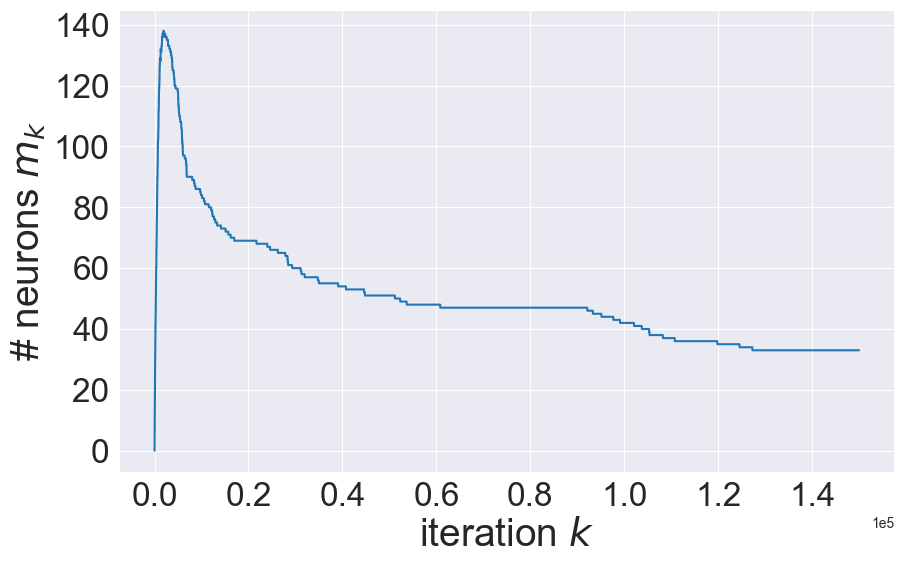

In [53]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms)), ms, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

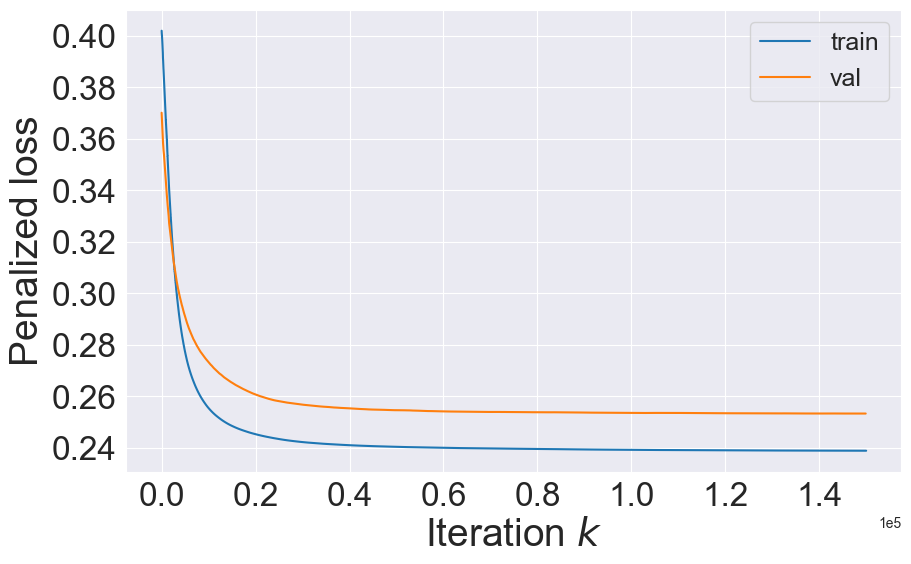

In [54]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_mix_conic)), penalized_train_losses_mix_conic, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses_mix_conic)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

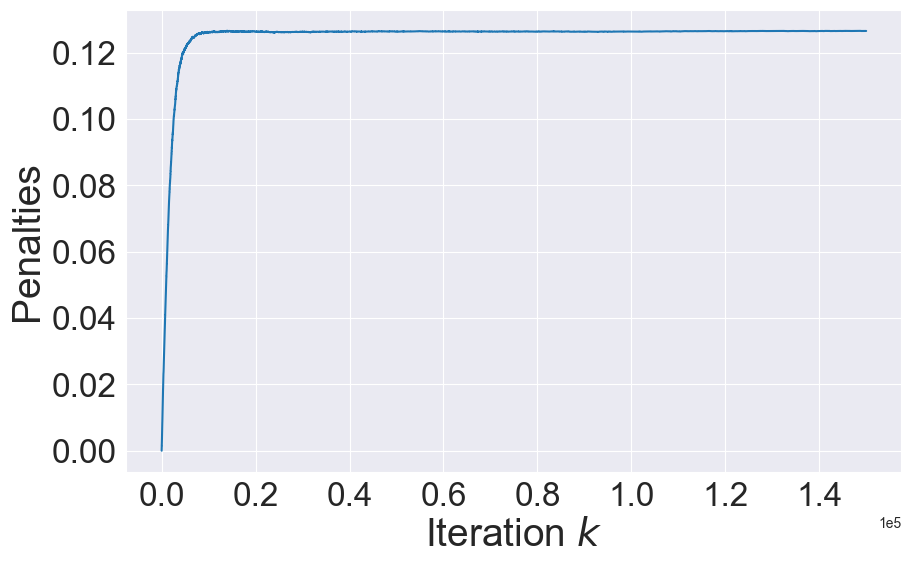

In [55]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses_mix_conic - train_losses_mix_conic

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

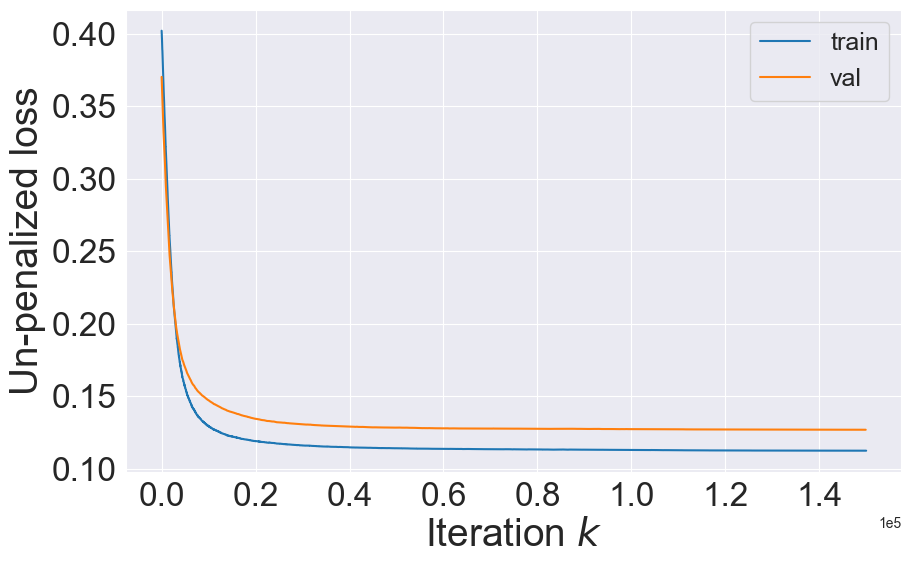

In [56]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_mix_conic)), train_losses_mix_conic, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses_mix_conic)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 6. Comparative results

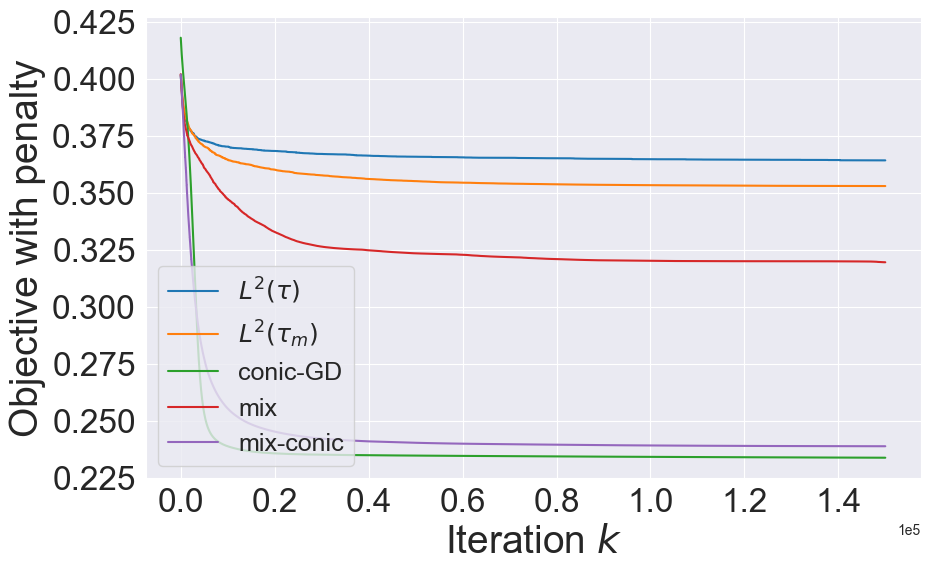

In [57]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses_pop)), penalized_train_losses_pop, label='$L^2(\\tau)$')
plt.plot(np.arange(len(penalized_train_losses_coord)), penalized_train_losses_coord, label='$L^2(\\tau_m)$')
plt.plot(np.arange(len(penalized_train_losses_conic)), penalized_train_losses_conic, label='conic-GD')
plt.plot(np.arange(len(penalized_train_losses_mix)), penalized_train_losses_mix, label='mix')
plt.plot(np.arange(len(penalized_train_losses_mix_conic)), penalized_train_losses_mix_conic, label='mix-conic')
#plt.plot([min(VAL_ITER * k, len(penalized_train_losses_mix)) for k in range(len(penalized_val_losses))], 
#         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Objective with penalty', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'all_objectives_penalty_m={}.png'.format(m_star)), bbox_inches='tight')
plt.show()

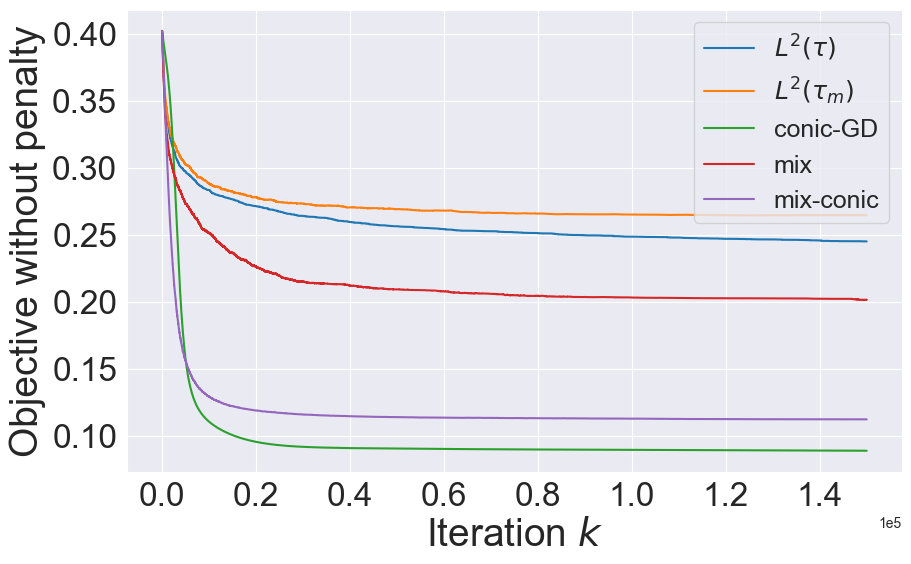

In [58]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_pop)), train_losses_pop, label='$L^2(\\tau)$')
plt.plot(np.arange(len(train_losses_coord)), train_losses_coord, label='$L^2(\\tau_m)$')
plt.plot(np.arange(len(train_losses_conic)), train_losses_conic, label='conic-GD')
plt.plot(np.arange(len(train_losses_mix)), train_losses_mix, label='mix')
plt.plot(np.arange(len(train_losses_mix_conic)), train_losses_mix_conic, label='mix-conic')
#plt.plot([min(VAL_ITER * k, len(penalized_train_losses_mix)) for k in range(len(penalized_val_losses))], 
#         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Objective without penalty', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'all_objectives_no_penalty_m={}.png'.format(m_star)), bbox_inches='tight')
plt.show()